# Title of notebook

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [218]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert
import matplotlib

In [3]:
from itertools import product

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [219]:
from sklearn import preprocessing as pre



In [6]:
import math

In [7]:
from collections import defaultdict

In [8]:
import numpy as np
from astropy.stats import rayleightest
from astropy import units as u


In [134]:
from matplotlib_venn import venn3


In [172]:
from venn import venn

## Inputs & Data

Explanation of each input and where it comes from.

In [9]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [10]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("./proc/all_spike_time.csv")

In [11]:
BASIC_LFP_TRACES_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [12]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [15]:
BAND_TO_FREQUENCY = {"theta": {"FREQ": (4,12)}, "beta": {"FREQ": (12,30)}, "gamma": {"FREQ": (30,90)}}

In [16]:
ORDER=4

In [17]:
for key, value in BAND_TO_FREQUENCY.items():
    BAND_TO_FREQUENCY[key]["numerator_b_and_denominator_a"] = butter(ORDER, value["FREQ"], fs=LFP_SAMPLING_RATE, btype='band')

In [18]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [19]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [20]:
def PPC(spike_phases):
    sp_complex = map(lambda x: [math.cos(x), math.sin(x)], spike_phases)
    all_com = list(itertools.combinations(sp_complex , 2))
    dp_array = np.empty(int(len(spike_phases) * (len(spike_phases) - 1) / 2))
    for d, combination in enumerate(all_com):
        dp = np.dot(combination[0], combination[1])
        dp_array[d] = dp
    dp_sum = np.sum(dp_array)
    ppc = dp_sum / len(dp_array)
    return ppc


In [21]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [22]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


# Processing

To help towards deciding how to calculate the phase locking, could you let me know what is the  num of spikes you have per trial condition? The a quick look to make sure that if we make a threshold to exclude low firing we do not end up excluding 50% of the cells. If there is too little spiking then we can focus on social vs alone comparison, and do whole session phase locking

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

## Getting the timestamps

- Getting a list of all the timestamps for LFP and spike for syncing with other data

In [23]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                             mPFC_baseline_lfp_trace  \
0  [1.8457601, 1.7363818, 1.6475118, 1.59738, 1.2...   
1  [1.2191132, 1.1348007, 1.2054409, 1.0960625, 0...   
2  [-1.2669662, -1.2965895, -1.2532939, -0.986684...   
3  [-2.0257788, -2.0348935, -1.9323514, -1.754611...   
4  [-0.5765152, 0.25749493, 0.6403192, 0.4375135,...   

                                mPFC_trial_lfp_trace  \
0  [0.6927297, 0.96389693, 0.7884358, -0.04101689...   
1  [1.0732753, 0.7246318, 0.7633699, 0.3782669, -...   
2  [0.28711826, 0.84996116, 1.0960625, 0.8226166,...   
3  [2.376701, 2.3015034, 1.7796774, 0.9411098, 0....   
4  [-0.043295607, 0.73602533, 0.31674156, 0.07747...   

                             vHPC_baseline_lfp_trace  \
0  [-0.06969439, -0.09568214, -0.05315674, 0.1571...   
1  [0.31539667, 0.23152715, 0.29767776, 0.4217101...   
2  [-1.2556804, -1.2580429, -1.3312811, -1.118654...   
3  [0.16655779, 0.42879772, 0.66268736, 0.6934002...   
4  [-0.31421542, 0.19727057, 0.4453354, 0.3744597...   

                                vHPC_trial_lfp_trace  \
0  [1.5864334, 1.5710771, 1.5970649, 1.2155175, 0...   
1  [0.03543783, -0.27641505, -0.40044746, -0.6638...   
2  [0.060244307, 0.4748669, 0.7654571, 0.6591436,...   
3  [-1.8427671, -2.303459, -2.6802812, -3.060647,...   
4  [0.21617076, 0.8221576, 0.58236164, 0.43116024...   

                              BLA_baseline_lfp_trace  \
0  [2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...   
1  [0.3107247, 0.14209972, -0.05873455, -0.331566...   
2  [-1.9912907, -1.9041362, -1.9325562, -1.542255...   
3  [-1.2637402, -1.0382752, -0.82986236, -0.74649...   
4  [-2.1352851, -2.0576038, -2.0822346, -2.140969...   

                                 BLA_trial_lfp_trace  \
0  [0.3164087, 0.36377528, 0.18757163, -0.5020857...   
1  [0.026525281, -0.04547191, 0.11936376, -0.4092...   
2  [0.69344664, 1.4001559, 1.7582471, 1.4304705, ...   
3  [2.6771586, 2.3929594, 2.209177, 1.9761335, 1....   
4  [-0.18188764, 0.113679774, -0.66123736, -0.935...   

      

In [24]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [25]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

BASIC_LFP_TRACES_DF["lfp_baseline_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [26]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

BASIC_LFP_TRACES_DF["lfp_baseline_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

# Syncing LFP and spikes

In [27]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0           0              65          937          65           2        1   
1           1             123          998         123           1        1   
2           2             103         1125         103          12        2   
3           3             123         1327         123           1        1   
4           4             103         1346         103          12        2   

   2ms_isi        amp  ch  channel_group  depth        fr group  n_spikes  sh  \
0        3   8.466800   2            0.0   40.0  2.628268  good      9014   0   
1        1  19.984566  24            0.0  480.0  2.384219  good      8177   0   
2       32  14.402934   6            0.0  120.0  8.755451  good     30028   0   
3        1  19.984566  24            0.0  480.0  2.384219  good      8177   0   
4       32  14.402934   6            0.0  120.0  8.755451  good     30028   0   

   si_unit_id                                     recording_name  \
0         8.0  20230618_100636_standard_comp_to_omission_D2_s...   
1        28.0  20230618_100636_standard_comp_to_omission_D2_s...   
2        11.0  20230618_100636_standard_comp_to_omission_D2_s...   
3        28.0  20230618_100636_standard_comp_to_omission_D2_s...   
4        11.0  20230618_100636_standard_comp_to_omission_D2_s...   

   timestamp_isi  current_isi  closest_trial  
0            NaN          NaN       11599246  
1            NaN          NaN       11599246  
2            NaN          NaN       11599246  
3          329.0      0.01645       11599246  
4          221.0      0.01105       11599246

- Getting the ephys sample index from the start of the trial onset
    - i.e. the number of ephys samples that the spike fired compared to sample of the trial onset

In [28]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["spike_times"] - MERGED_SPIKE_TRIAL_DF["closest_trial"]


- Doing the same for LFP, but just downsampling from 20khz to 1khz

In [29]:
(EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

20

In [30]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] // (EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

- Removing all spikes that are not within the 10 second trial duration

In [31]:
MERGED_SPIKE_TRIAL_DF = MERGED_SPIKE_TRIAL_DF[np.abs(MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]) <= TRIAL_DURATION * EPHYS_SAMPLING_RATE].reset_index(drop=True)

In [32]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"].head()

0   -199973
1   -199830
2   -199448
3   -199250
4   -198540
Name: ephys_sample_from_trial_onset, dtype: int64

In [33]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"].head()

0   -9999
1   -9992
2   -9973
3   -9963
4   -9927
Name: lfp_sample_from_trial_onset, dtype: int64

- Remaking the spike IDs to include file name
    - This is necessary because some spikes have the same ID number across files because they're just based on ID number that repeats with every spike sorting

In [34]:
MERGED_SPIKE_TRIAL_DF["cluster_id_with_file_name"] = MERGED_SPIKE_TRIAL_DF["cluster_id"].astype(str) + "_" + MERGED_SPIKE_TRIAL_DF["recording_name"]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [35]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                              BLA_baseline_lfp_trace  \
0  [2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...   
1  [0.3107247, 0.14209972, -0.05873455, -0.331566...   
2  [-1.9912907, -1.9041362, -1.9325562, -1.542255...   
3  [-1.2637402, -1.0382752, -0.82986236, -0.74649...   
4  [-2.1352851, -2.0576038, -2.0822346, -2.140969...   

                                 BLA_trial_lfp_trace  \
0  [0.3164087, 0.36377528, 0.18757163, -0.5020857...   
1  [0.026525281, -0.04547191, 0.11936376, -0.4092...   
2  [0.69344664, 1.4001559, 1.7582471, 1.4304705, ...   
3  [2.6771586, 2.3929594, 2.209177, 1.9761335, 1....   
4  [-0.18188764, 0.113679774, -0.66123736, -0.935...   

                               LH_baseline_lfp_trace  \
0  [3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...   
1  [-1.180375, -1.2959143, -1.3771042, -1.458294,...   
2  [-0.19985186, -0.074944444, -0.18423842, -0.13...   
3  [-2.538743, -2.1983705, -1.8673657, -1.7143542...   
4  [-2.1671436, -1.4832754, -1.0554676, -1.130412...   

                                  LH_trial_lfp_trace  \
0  [0.8118982, 1.2209699, 0.87435186, -0.4028264,...   
1  [0.9492963, 0.46840277, 0.6713773, 0.043717593...   
2  [-0.59643286, 0.27167362, 0.6901134, 0.4371759...   
3  [2.8447661, 2.3045416, 1.5301157, 0.96490973, ...   
4  [0.5339792, 1.5113796, 0.57145137, -0.02810416...   

                               MD_baseline_lfp_trace  \
0  [1.3934726, 1.494771, 1.764077, 1.828315, 1.68...   
1  [-0.14577106, -0.16059524, 0.027177656, 0.1680...   
2  [-0.32119048, -0.52872896, -0.96851283, -0.753...   
3  [-2.7647088, -2.5546997, -2.3051593, -2.055619...   
4  [-2.0111465, -1.714663, -1.4255916, -1.3662949...   

                                  MD_trial_lfp_trace  \
0  [-0.9783956, -0.86721426, -0.7288553, -1.40582...   
1  [1.6281886, 1.349, 1.4675934, 0.9487473, -0.21...   
2  [0.096357144, 0.88450915, 1.2131118, 0.8943919...   
3  [2.087738, 1.7418406, 1.1266373, 0.45954946, 0...   
4  [0.31871977, 1.008044, 0.25942308, -0.22730403...   

      

# Phase calculation

- Calculating the phase in degrees and radians

In [36]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [37]:
for trace_col, (band, value) in product(trace_columns, BAND_TO_FREQUENCY.items()):
    region_name = "_".join(trace_col.split("_")[:2])
    print(band, region_name)
    BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)] = BASIC_LFP_TRACES_DF[trace_col].apply(lambda x: filtfilt(value["numerator_b_and_denominator_a"][0], value["numerator_b_and_denominator_a"][1], x, padtype=None))
    
    BASIC_LFP_TRACES_DF["{}_{}_phase_radians".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))

    BASIC_LFP_TRACES_DF["{}_{}_phase_degrees".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=True))

theta mPFC_baseline
beta mPFC_baseline
gamma mPFC_baseline
theta mPFC_trial
beta mPFC_trial
gamma mPFC_trial
theta vHPC_baseline
beta vHPC_baseline
gamma vHPC_baseline
theta vHPC_trial
beta vHPC_trial
gamma vHPC_trial
theta BLA_baseline
beta BLA_baseline
gamma BLA_baseline
theta BLA_trial
beta BLA_trial
gamma BLA_trial
theta LH_baseline
beta LH_baseline
gamma LH_baseline
theta LH_trial
beta LH_trial
gamma LH_trial
theta MD_baseline
beta MD_baseline
gamma MD_baseline
theta MD_trial
beta MD_trial
gamma MD_trial


In [38]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                     gamma_MD_baseline_phase_degrees  \
0  [-73.65554909929288, -52.38884135467074, -32.6...   
1  [142.72986538822607, 177.84259847255115, -172....   
2  [150.93294763979742, -161.23241762039694, -141...   
3  [177.7553989209761, -125.63606254340398, -101....   
4  [-176.81840124801423, -119.51609014266732, -95...   

                             theta_MD_trial_filtered  \
0  [-0.2107802673060125, -0.1992412769085011, -0....   
1  [0.07421069523106737, 0.04552025774441368, 0.0...   
2  [0.30981270211917433, 0.3240643885502497, 0.33...   
3  [0.8889586162197898, 0.8722693383653553, 0.854...   
4  [-0.10875741774669787, -0.08716787699961176, -...   

                        theta_MD_trial_phase_radians  \
0  [3.048252903026577, -2.5328305508061786, -2.44...   
1  [1.3052338927475164, 1.4443790135857506, 1.527...   
2  [-0.962385359743742, -0.6632895484675844, -0.6...   
3  [-0.7870818112901102, -0.3193998231079843, -0....   
4  [-2.2418140551946046, -1.925273923980867, -1.8...   

                        theta_MD_trial_phase_degrees  \
0  [174.65202623192386, -145.12050078298967, -139...   
1  [74.78439333186384, 82.75682149573251, 87.5183...   
2  [-55.14061937849585, -38.00369172233064, -36.3...   
3  [-45.09646591843563, -18.300261841312565, -16....   
4  [-128.44648381575902, -110.31007025069457, -10...   

                              beta_MD_trial_filtered  \
0  [0.04582688855964577, 0.033802766609884974, 0....   
1  [0.30232516047203095, 0.263862496888888, 0.219...   
2  [-0.2586119521457031, -0.21406657916267624, -0...   
3  [0.2138537267502523, 0.20164256158089383, 0.18...   
4  [-0.17109954986501608, -0.17395757464405473, -...   

                         beta_MD_trial_phase_radians  \
0  [0.4255337696189414, 1.083524295329371, 1.2755...   
1  [-0.2315727587966999, 0.5976348210699142, 0.77...   
2  [3.0656289077939856, -2.3850437013093506, -2.1...   
3  [-0.5738870733129354, 0.10586470153849892, 0.2...   
4  [2.377772191502466, 2.8605037452301936, 2.9053...   

      

- Plotting an example filtered trace

In [39]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0       20759             103     11399273         103          12        2   
1       20760              83     11399416          83           9        3   
2       20761              65     11399798          65           2        1   
3       20762             103     11399996         103          12        2   
4       20763             103     11400706         103          12        2   

   2ms_isi        amp  ch  channel_group  ...  n_spikes  sh si_unit_id  \
0       32  14.402934   6            0.0  ...     30028   0       11.0   
1       26  13.022879   2            0.0  ...     36640   0        5.0   
2        3   8.466800   2            0.0  ...      9014   0        8.0   
3       32  14.402934   6            0.0  ...     30028   0       11.0   
4       32  14.402934   6            0.0  ...     30028   0       11.0   

                                      recording_name  timestamp_isi  \
0  20230618_100636_standard_comp_to_omission_D2_s...          183.0   
1  20230618_100636_standard_comp_to_omission_D2_s...         1165.0   
2  20230618_100636_standard_comp_to_omission_D2_s...         7188.0   
3  20230618_100636_standard_comp_to_omission_D2_s...          723.0   
4  20230618_100636_standard_comp_to_omission_D2_s...          710.0   

   current_isi closest_trial  ephys_sample_from_trial_onset  \
0      0.00915      11599246                        -199973   
1      0.05825      11599246                        -199830   
2      0.35940      11599246                        -199448   
3      0.03615      11599246                        -199250   
4      0.03550      11599246                        -198540   

   lfp_sample_from_trial_onset  \
0                        -9999   
1                        -9992   
2                        -9973   
3                        -9963   
4                        -9927   

                           cluster_id_with_file_name  
0  103_20230618_100636_standard_comp_to_omission_...  
1  83_20230618_100636_standard_comp_to_omission_D...  
2  65_20230618_100636_standard_comp_to_omission_D...  
3  103_20230618_100636_standard_comp_to_omission_...  
4  103_20230618_100636_standard_comp_to_omission_...  

[5 rows x 23 columns]

(0.0, 10000.0)

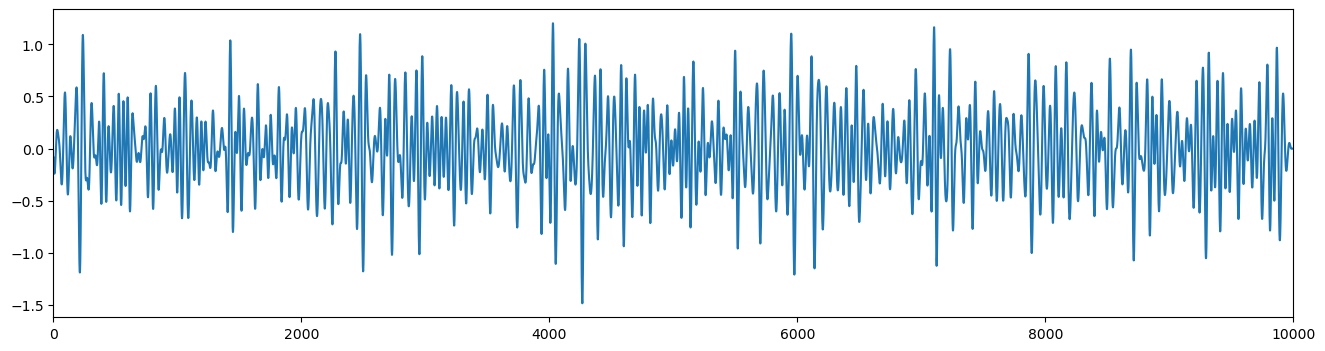

In [40]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["beta_BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

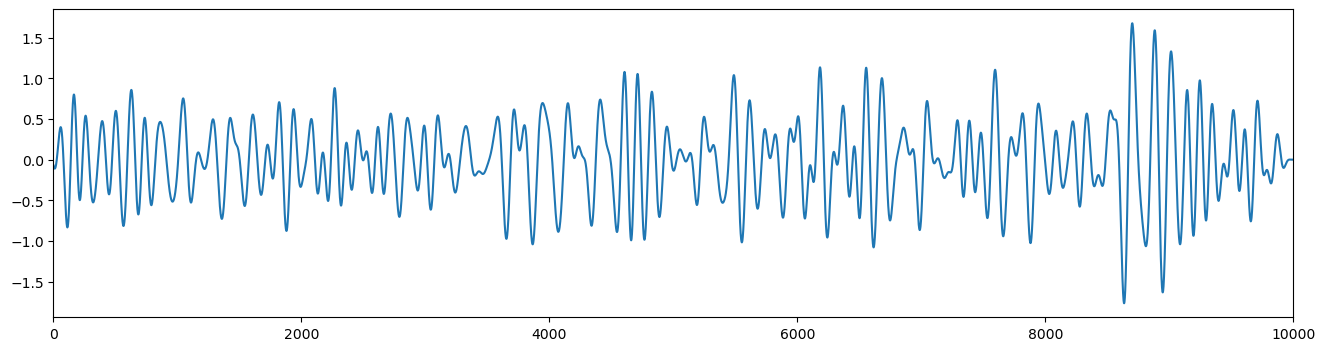

In [41]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

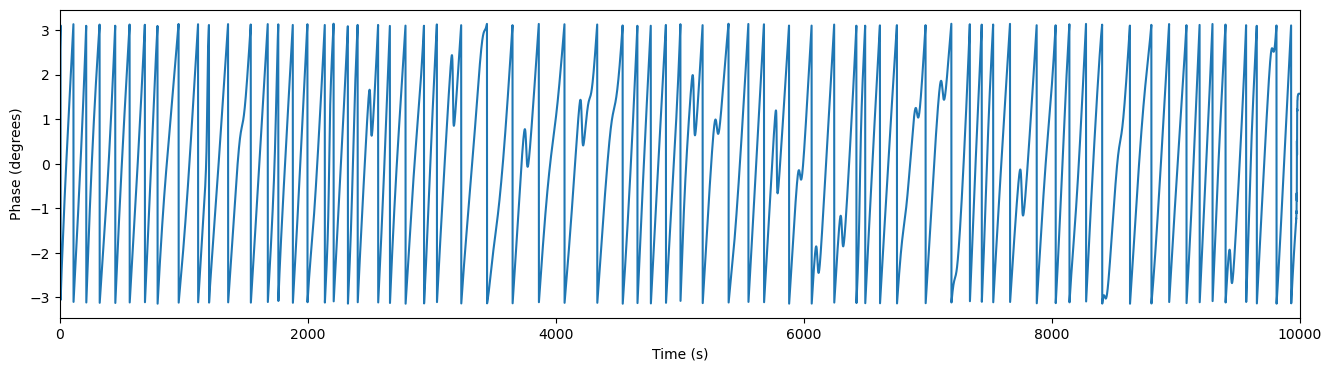

In [42]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_radians"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

(0.0, 10000.0)

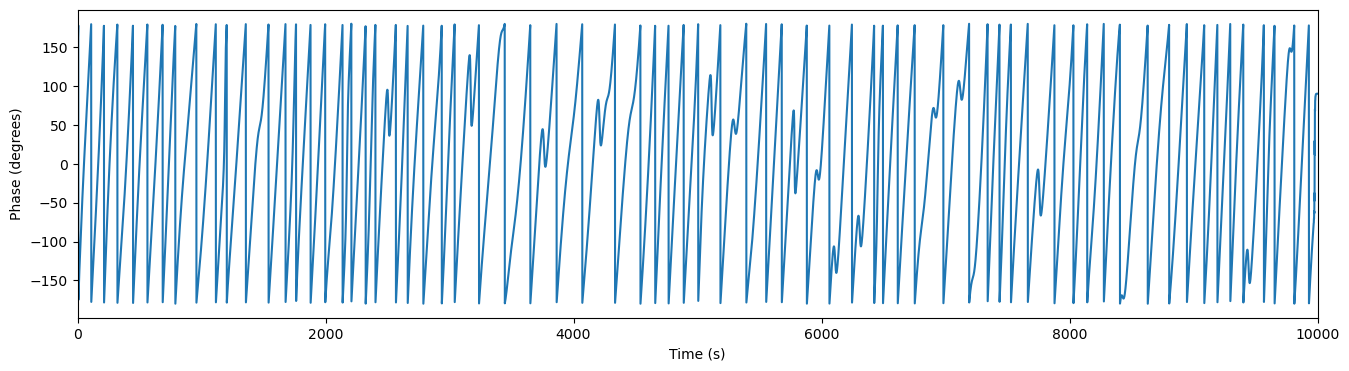

In [43]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_degrees"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

In [44]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                     gamma_MD_baseline_phase_degrees  \
0  [-73.65554909929288, -52.38884135467074, -32.6...   
1  [142.72986538822607, 177.84259847255115, -172....   
2  [150.93294763979742, -161.23241762039694, -141...   
3  [177.7553989209761, -125.63606254340398, -101....   
4  [-176.81840124801423, -119.51609014266732, -95...   

                             theta_MD_trial_filtered  \
0  [-0.2107802673060125, -0.1992412769085011, -0....   
1  [0.07421069523106737, 0.04552025774441368, 0.0...   
2  [0.30981270211917433, 0.3240643885502497, 0.33...   
3  [0.8889586162197898, 0.8722693383653553, 0.854...   
4  [-0.10875741774669787, -0.08716787699961176, -...   

                        theta_MD_trial_phase_radians  \
0  [3.048252903026577, -2.5328305508061786, -2.44...   
1  [1.3052338927475164, 1.4443790135857506, 1.527...   
2  [-0.962385359743742, -0.6632895484675844, -0.6...   
3  [-0.7870818112901102, -0.3193998231079843, -0....   
4  [-2.2418140551946046, -1.925273923980867, -1.8...   

                        theta_MD_trial_phase_degrees  \
0  [174.65202623192386, -145.12050078298967, -139...   
1  [74.78439333186384, 82.75682149573251, 87.5183...   
2  [-55.14061937849585, -38.00369172233064, -36.3...   
3  [-45.09646591843563, -18.300261841312565, -16....   
4  [-128.44648381575902, -110.31007025069457, -10...   

                              beta_MD_trial_filtered  \
0  [0.04582688855964577, 0.033802766609884974, 0....   
1  [0.30232516047203095, 0.263862496888888, 0.219...   
2  [-0.2586119521457031, -0.21406657916267624, -0...   
3  [0.2138537267502523, 0.20164256158089383, 0.18...   
4  [-0.17109954986501608, -0.17395757464405473, -...   

                         beta_MD_trial_phase_radians  \
0  [0.4255337696189414, 1.083524295329371, 1.2755...   
1  [-0.2315727587966999, 0.5976348210699142, 0.77...   
2  [3.0656289077939856, -2.3850437013093506, -2.1...   
3  [-0.5738870733129354, 0.10586470153849892, 0.2...   
4  [2.377772191502466, 2.8605037452301936, 2.9053...   

      

- Combining all the LFP phases with the spike firing times

In [45]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [46]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name',
       ...
       'n_spikes', 'sh', 'si_unit_id', 'recording_name', 'timestamp_isi',
       'current_isi', 'closest_trial', 'ephys_sample_from_trial_onset',
       'lfp_sample_from_trial_onset', 'cluster_id_with_file_name'],
      dtype='object', length=154)

- Getting the phase of all the spikes for each neuron

In [47]:
TRACE_AND_SPIKE_DF["beta_BLA_trial_phase_radians"].iloc[0].shape

(10000,)

In [48]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9986
1        -9966
2        -9948
3        -9928
4        -9906
          ... 
177850    9911
177851    9956
177852    9963
177853    9972
177854    9998
Name: lfp_sample_from_trial_onset, Length: 177855, dtype: int64

In [49]:
radian_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_radians" in col]

In [50]:
degree_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_degrees" in col]

In [51]:
degree_phase_columns

['theta_mPFC_trial_phase_degrees',
 'beta_mPFC_trial_phase_degrees',
 'gamma_mPFC_trial_phase_degrees',
 'theta_vHPC_trial_phase_degrees',
 'beta_vHPC_trial_phase_degrees',
 'gamma_vHPC_trial_phase_degrees',
 'theta_BLA_trial_phase_degrees',
 'beta_BLA_trial_phase_degrees',
 'gamma_BLA_trial_phase_degrees',
 'theta_LH_trial_phase_degrees',
 'beta_LH_trial_phase_degrees',
 'gamma_LH_trial_phase_degrees',
 'theta_MD_trial_phase_degrees',
 'beta_MD_trial_phase_degrees',
 'gamma_MD_trial_phase_degrees']

In [52]:
for col in radian_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_radians".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
beta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
beta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
beta_BLA_trial
gamma_BLA_trial
theta_LH_trial
beta_LH_trial
gamma_LH_trial
theta_MD_trial
beta_MD_trial
gamma_MD_trial


In [53]:
for col in degree_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_degrees".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
beta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
beta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
beta_BLA_trial
gamma_BLA_trial
theta_LH_trial
beta_LH_trial
gamma_LH_trial
theta_MD_trial
beta_MD_trial
gamma_MD_trial


In [54]:
TRACE_AND_SPIKE_DF.head()

time                                      recording_dir  \
0  6310663  20221202_134600_omission_and_competition_subje...   
1  6310663  20221202_134600_omission_and_competition_subje...   
2  6310663  20221202_134600_omission_and_competition_subje...   
3  6310663  20221202_134600_omission_and_competition_subje...   
4  6310663  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           1390826   
2  20221202_134600_omission_and_competition_subje...           1390826   
3  20221202_134600_omission_and_competition_subje...           1390826   
4  20221202_134600_omission_and_competition_subje...           1390826   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         1734   
2  20221202_134600_omission_and_competition_subje...         1734   
3  20221202_134600_omission_and_competition_subje...         1734   
4  20221202_134600_omission_and_competition_subje...         1734   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              rewarded   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

  gamma_vHPC_trial_spike_phase_degrees theta_BLA_trial_spike_phase_degrees  \
0                            73.119936                         -141.935604   
1                            48.728891                          -62.205986   
2                          -142.842480                           -0.512110   
3                          -150.980004                           63.106630   
4                           101.253018                          130.604812   

  beta_BLA_trial_spike_phase_degrees  gamma_BLA_trial_spike_phase_degrees  \
0                        -128.788362                          -158.355143   
1                           8.609588                           120.528596   
2                         103.396428                            39.823317   
3                        -131.139171                           -16.815703   
4                          12.112645                           -76.816687   

  theta_LH_trial_spike_phase_degrees beta_LH_trial_spike_phase_degrees  \
0                         -28.381459                        170.720980   
1                          14.540183                       -127.139446   
2                          55.739710                        -18.171860   
3                         103.014830                        115.126404   
4                         155.430958                       -101.062576   

  gamma_LH_trial_spike_phase_degrees theta_MD_trial_spike_phase_degrees  \
0                          94.913051                         -82.743902   
1                         148.960302                         -25.978561   
2                          41.584338                          21.774475   
3                        -114.457133                          74.933892   
4                         -65.566342                         134.678794   

  beta_MD_trial_spike_phase_degrees gamma_MD_trial_spike_phase_degrees  
0                        155.447696                         150.742485  
1                       -137.267443                        

In [55]:
TRACE_AND_SPIKE_DF["recording_file"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
       '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged'],
      dtype=object)

In [56]:
radians_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_radians" in col])
degrees_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_degrees" in col])

In [57]:
radians_spike_columns

['beta_BLA_trial_spike_phase_radians',
 'beta_LH_trial_spike_phase_radians',
 'beta_MD_trial_spike_phase_radians',
 'beta_mPFC_trial_spike_phase_radians',
 'beta_vHPC_trial_spike_phase_radians',
 'gamma_BLA_trial_spike_phase_radians',
 'gamma_LH_trial_spike_phase_radians',
 'gamma_MD_trial_spike_phase_radians',
 'gamma_mPFC_trial_spike_phase_radians',
 'gamma_vHPC_trial_spike_phase_radians',
 'theta_BLA_trial_spike_phase_radians',
 'theta_LH_trial_spike_phase_radians',
 'theta_MD_trial_spike_phase_radians',
 'theta_mPFC_trial_spike_phase_radians',
 'theta_vHPC_trial_spike_phase_radians']

In [58]:
degrees_spike_columns

['beta_BLA_trial_spike_phase_degrees',
 'beta_LH_trial_spike_phase_degrees',
 'beta_MD_trial_spike_phase_degrees',
 'beta_mPFC_trial_spike_phase_degrees',
 'beta_vHPC_trial_spike_phase_degrees',
 'gamma_BLA_trial_spike_phase_degrees',
 'gamma_LH_trial_spike_phase_degrees',
 'gamma_MD_trial_spike_phase_degrees',
 'gamma_mPFC_trial_spike_phase_degrees',
 'gamma_vHPC_trial_spike_phase_degrees',
 'theta_BLA_trial_spike_phase_degrees',
 'theta_LH_trial_spike_phase_degrees',
 'theta_MD_trial_spike_phase_degrees',
 'theta_mPFC_trial_spike_phase_degrees',
 'theta_vHPC_trial_spike_phase_degrees']

## Filtering for neurons that have enough spikes

- Getting rows that focus on the trial portion only

In [315]:
temp_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"] >= 1].copy()

In [316]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name',
       ...
       'gamma_vHPC_trial_spike_phase_degrees',
       'theta_BLA_trial_spike_phase_degrees',
       'beta_BLA_trial_spike_phase_degrees',
       'gamma_BLA_trial_spike_phase_degrees',
       'theta_LH_trial_spike_phase_degrees',
       'beta_LH_trial_spike_phase_degrees',
       'gamma_LH_trial_spike_phase_degrees',
       'theta_MD_trial_spike_phase_degrees',
       'beta_MD_trial_spike_phase_degrees',
       'gamma_MD_trial_spike_phase_degrees'],
      dtype='object', length=184)

- Getting the total number of spikes for each neuron and each trial type

In [317]:
temp_df = temp_df.groupby(["trial_outcome", "cluster_id_with_file_name"]).count()["recording_dir"].reset_index()

In [318]:
temp_df[temp_df["recording_dir"] > 50].groupby(["trial_outcome"]).count()

cluster_id_with_file_name  recording_dir
trial_outcome                                          
lose                                  67             67
omission                              33             33
rewarded                              84             84
win                                   67             67

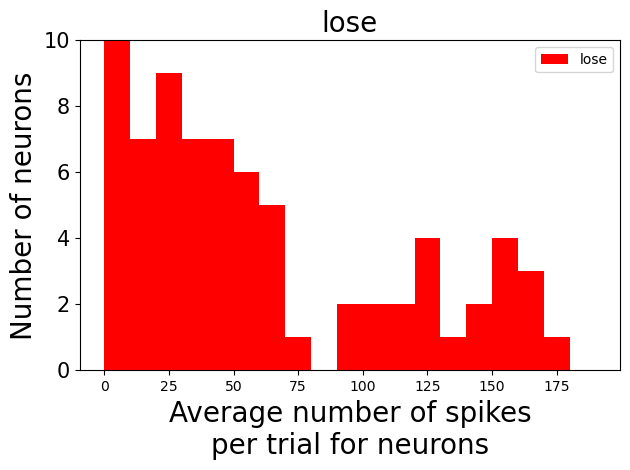

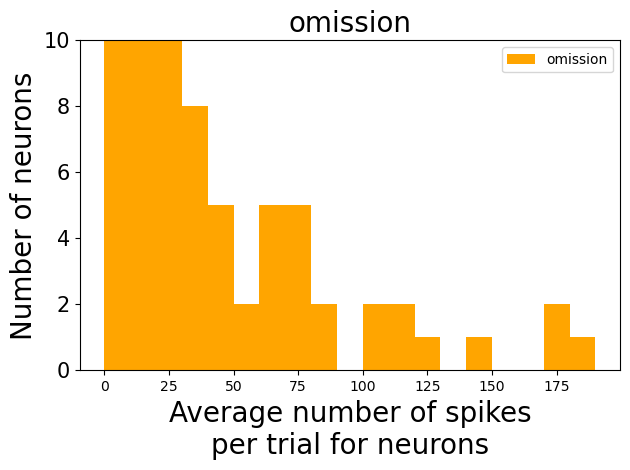

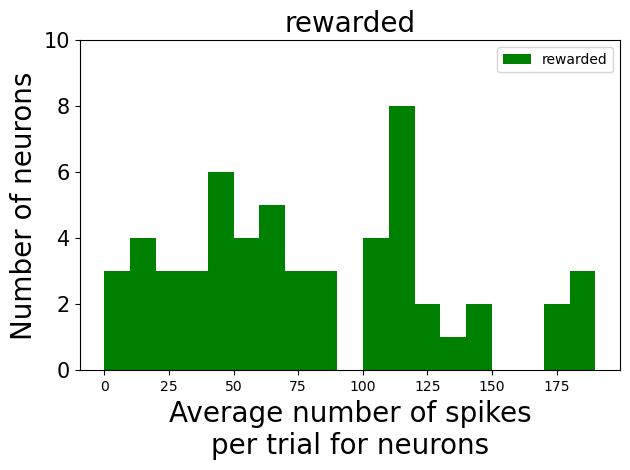

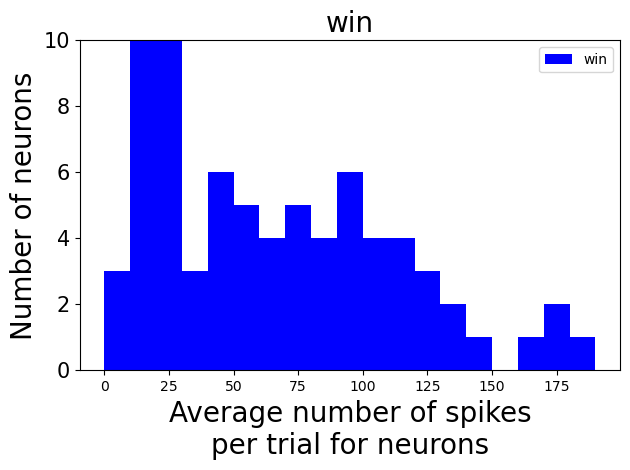

In [319]:
for outcome in temp_df["trial_outcome"].unique():
    fig, ax = plt.subplots()
    plt.hist(temp_df[temp_df["trial_outcome"] == outcome]["recording_dir"], color=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, bins=range(0, 200, 10))
    plt.legend()
    plt.ylim(0,10)
    # plt.xlim(0, 200)
    # plt.xticks(np.arange(0, 200, 10), rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(outcome, fontsize=20)
    plt.xlabel("Average number of spikes\nper trial for neurons", fontsize=20)
    plt.ylabel("Number of neurons", fontsize=20)
    plt.tight_layout()
    plt.savefig("./proc/per_trial_spike_histogram_{}.png".format(outcome))
    
    plt.show()

In [320]:
len(temp_df["cluster_id_with_file_name"].unique())

126

In [321]:
temp_df = temp_df[temp_df["recording_dir"] >= 10].groupby("cluster_id_with_file_name").count()

In [322]:
high_spike_neurons = temp_df[temp_df["trial_outcome"] >= 4].reset_index()["cluster_id_with_file_name"]

In [323]:
high_spike_neurons

0     103_20230618_100636_standard_comp_to_omission_...
1     106_20230618_100636_standard_comp_to_omission_...
2     118_20230618_100636_standard_comp_to_omission_...
3     11_20230618_100636_standard_comp_to_omission_D...
4     123_20230618_100636_standard_comp_to_omission_...
                            ...                        
56    90_20230620_114347_standard_comp_to_omission_D...
57    93_20230618_100636_standard_comp_to_omission_D...
58    94_20230620_114347_standard_comp_to_omission_D...
59    99_20230618_100636_standard_comp_to_omission_D...
60    9_20230618_100636_standard_comp_to_omission_D2...
Name: cluster_id_with_file_name, Length: 61, dtype: object

## Getting the average number of spikes per trial

In [67]:
temp_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"] >= 1].copy()

In [68]:
temp_df = temp_df.groupby(["trial_outcome", "cluster_id_with_file_name", "time"]).count().reset_index()

In [69]:
temp_df.groupby(["trial_outcome", "cluster_id_with_file_name"])["recording_dir"].mean()

trial_outcome  cluster_id_with_file_name                                                  
lose           103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged    130.000000
               105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged     16.750000
               106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged      5.333333
               118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged      4.333333
               11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged      16.000000
                                                                                                 ...    
win            93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged      3.250000
               94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged      7.857143
               98_20230618_100636_standard_comp_to_omission_D2_subj_1

In [70]:
for col in TRACE_AND_SPIKE_DF.columns:
    print(col)

time
recording_dir
recording_file
time_stamp_index
video_file
video_frame
video_number
subject_info
competition_closeness
video_name
all_subjects
current_subject
trial_outcome
lfp_index
baseline_lfp_timestamp_range
trial_lfp_timestamp_range
baseline_ephys_timestamp_range
trial_ephys_timestamp_range
baseline_videoframe_range
trial_videoframe_range
trial_number
Cohort
spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD
mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace
lfp_trial_all_lfp_index
lfp_baseline_all_lfp_index
lfp_trial_all_ephys_index
lfp_baseline_all_ephys_index
theta_mPFC_baseline_filtered
theta_mPFC_baseline_phase_radians
theta_mPFC_baseline_phase_degrees
beta_mPFC_baseline_filtered
beta_mPFC_baseline_phase_radians
beta_mPFC_baseline_phase_degrees
gamma_mPFC_baseline

In [71]:
high_spike_neurons

0     103_20230618_100636_standard_comp_to_omission_...
1     123_20230618_100636_standard_comp_to_omission_...
2     124_20230620_114347_standard_comp_to_omission_...
3     139_20230618_100636_standard_comp_to_omission_...
4     14_20230620_114347_standard_comp_to_omission_D...
5     153_20230620_114347_standard_comp_to_omission_...
6     162_20230620_114347_standard_comp_to_omission_...
7     168_20230620_114347_standard_comp_to_omission_...
8     181_20230620_114347_standard_comp_to_omission_...
9     207_20230620_114347_standard_comp_to_omission_...
10    241_20230620_114347_standard_comp_to_omission_...
11    251_20230620_114347_standard_comp_to_omission_...
12    258_20230620_114347_standard_comp_to_omission_...
13    259_20230620_114347_standard_comp_to_omission_...
14    41_20230620_114347_standard_comp_to_omission_D...
15    42_20230620_114347_standard_comp_to_omission_D...
16    43_20230620_114347_standard_comp_to_omission_D...
17    45_20230620_114347_standard_comp_to_omissi

In [72]:
BACK_UP_TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF.copy()

In [73]:
# TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].isin(high_spike_neurons)].copy()

In [81]:
# Creating a dictionary that we can add all dataframes to
# id_and_outcome_to_stats = defaultdict(list)
id_and_outcome_to_stats = []


# iterating through each band and each brain region
for radian_col, degree_col in zip(radians_spike_columns, degrees_spike_columns):
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(radian_col)
        print(degree_col)
        print(neuron_id)

        subj_id = ".".join(neuron_id.split("subj")[-1].strip("ect").strip("_").replace("-", "_").split("_")[:2])
        date = neuron_id.split("_")[1]
        neuron_number = neuron_id.split("_")[0]

        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
            try:
                print(outcome)
                # Getting all the rows that have this trial outcome and this neuron
                outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
    
                # Getting the phases of the current brain regions for all the spikes 
                radian_spike_phases = outcome_df[radian_col]
                binned_phases = np.digitize(radian_spike_phases, PHASE_BINS, N_BINS+1)
                spike_phase_hist = np.zeros(N_BINS+1)
                
                for bin in range(0, N_BINS + 1):
                    spike_phase_hist[bin] = np.sum(binned_phases == bin)
    
                # Calculating the ppc values
                ppc_val = PPC(radian_spike_phases)
                # Calculating the Rayleightest            
                rayleigh_val = rayleightest(outcome_df[degree_col].to_numpy()*u.deg)
                print(outcome)
                print("\tSpike phase histogram: {}".format(spike_phase_hist))
                print("\tppc_val: {}".format(ppc_val))
                print("\trayleigh_val: {}".format(rayleigh_val))
    
                id_and_outcome_to_stats.append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": float(rayleigh_val), "band": radian_col.split("_")[0], "region": radian_col.split("_")[1], "subj_id": subj_id, "date": date})
                
                # Creating a new plot for each outcome
                fig, ax = plt.subplots()
                #Plotting the histogram
                ax = plt.subplot(1,1,1, polar=True)
                
                plt.title("Neuron #{} Spike-{}-{}-LFP Coupling subj {}".format(neuron_number, radian_col.split("_")[1], radian_col.split("_")[0], subj_id))
                plt.xlabel("_".join(radian_col.split("_")[:3]))
                
                plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, color=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome)

                plt.plot([], [], ' ', label="PPC: {}".format(round(ppc_val, 4)))
                plt.plot([], [], ' ', label="Rayleigh: {}".format(round(float(rayleigh_val),4)))
                plt.plot([], [], ' ', label="Date: {}".format(date))


                plt.legend(loc="upper left")
                
                plt.tight_layout()
                plt.savefig("./proc/lfp_spike_coupling/all/{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome))

                if float(rayleigh_val) <= 0.1:
                    plt.savefig("./proc/lfp_spike_coupling/significant/{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome))
                else:
                    plt.savefig("./proc/lfp_spike_coupling/not_sig/{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome))

                plt.close()
                plt.show()     
            except Exception as e: 
                print(e)
                


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 36. 43. 41. 36. 50. 44. 44. 37. 34. 43. 40. 41. 55. 45. 40. 33.
 41.]
	ppc_val: -0.0007948378166682545
	rayleigh_val: 0.6598160435215877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 15. 16.  8.  7. 17. 13. 18. 19. 12. 10.  8. 13. 14.  7. 12. 13.
 17.]
	ppc_val: -0.002216967445360456
	rayleigh_val: 0.6112101375190081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 155. 166. 179. 198. 188. 175. 179. 175. 188. 160. 179. 162. 166.
 160. 164. 163. 171. 161.]
	ppc_val: 0.0007840980678467592
	rayleigh_val: 0.03267010519294225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 41. 46. 62. 54. 54. 39. 54. 34. 45. 55. 41. 48. 44. 37. 60. 47.
 54.]
	ppc_val: -0.000439547953306684
	rayleigh_val: 0.5359325571882253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 76. 72. 79. 83. 81. 63. 82. 70. 68. 82. 82. 80. 77. 73. 60. 64. 78.
 71.]
	ppc_val: -0.0004741438508974789
	rayleigh_val: 0.6944415790271143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 18. 16. 12. 19. 13. 12. 11. 22. 17. 17. 13. 15. 13. 20. 14. 15.
 19.]
	ppc_val: -0.0033308867773316556
	rayleigh_val: 0.9194256142672889


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 57. 63. 69. 66. 65. 71. 75. 56. 70. 52. 61. 61. 65. 63. 64. 82. 71.
 68.]
	ppc_val: -0.000317525928108497
	rayleigh_val: 0.5347507883993136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 19. 20. 17. 20. 21. 23. 20. 21. 25. 20. 13. 14. 22. 16. 20. 19. 23.
 12.]
	ppc_val: -0.0011502035806124848
	rayleigh_val: 0.5464404364382756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 15. 15. 15. 23. 16. 17. 25. 22. 18. 15. 15. 22. 21. 21. 20. 17.
 24.]
	ppc_val: -0.0022771119714185706
	rayleigh_val: 0.7960772567020017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 1. 1. 0. 2. 0. 0. 2. 2. 2. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.04232162005536875
	rayleigh_val: 0.6725834301825333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  3.  3.  8.  7.  4.  6.  8.  8.  8.  5.  8.  7.  6.  6. 11.  8.
  7.]
	ppc_val: -0.002080875500212677
	rayleigh_val: 0.4712456290564583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 3. 1. 0. 2. 0. 1. 1. 0. 1. 2. 1. 3. 2. 2. 1. 2.]
	ppc_val: 0.030393226277047193
	rayleigh_val: 0.178254288274594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4.  4.  1.  7.  4.  6.  3.  7.  6.  2.  3. 10.  2.  5.  2. 10.
  2.]
	ppc_val: -0.011211338463836918
	rayleigh_val: 0.9434163578433554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 5. 1. 2. 0. 3. 0. 0. 1. 3. 2. 4. 0. 1. 1. 2. 1. 1.]
	ppc_val: -0.0380076474560786
	rayleigh_val: 0.9884816491219884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  5.  5.  9. 10.  9.  4.  5.  5.  4.  2.  7.  5.  4.  6.  7.  8.
  7.]
	ppc_val: 0.0019849800593931227
	rayleigh_val: 0.29926137422003174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 2. 1.]
	ppc_val: 0.04352868466371293
	rayleigh_val: 0.19332114156186947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2. 11.  8.  3.  6.  3.  5.  7.  8.  9.  3.  8.  4.  5.  5.  8.  5.
  8.]
	ppc_val: -0.009313884765407062
	rayleigh_val: 0.996591492095391


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 3. 3. 0. 1. 3. 2. 0. 1. 1. 2. 2. 0. 0. 2. 1.]
	ppc_val: 0.011519138817993546
	rayleigh_val: 0.2685727925783925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 2. 2. 5. 4. 1. 0. 5. 3. 4. 2. 8. 2. 5. 4. 2. 6.]
	ppc_val: -0.0018247368712618476
	rayleigh_val: 0.41194463736816683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 19. 20. 21. 23. 19. 22. 26. 33. 24. 21. 29. 28. 24. 18. 20. 18.
 17.]
	ppc_val: 0.004991779074802504
	rayleigh_val: 0.04896356904763311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 1. 5. 7. 3. 2. 3. 5. 3. 6. 2. 4. 3. 7. 5. 4. 5.]
	ppc_val: -0.010689023177166471
	rayleigh_val: 0.8113852678036805


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11.  9.  8.  7.  9.  4.  4.  3.  7.  4.  3. 10.  6.  4.  7.  3.
  5.]
	ppc_val: 0.0151745957506108
	rayleigh_val: 0.06723544440047241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8. 21. 11. 16. 21.  8. 15. 12. 19. 13. 14. 14.  9. 16. 12. 14.
 19.]
	ppc_val: -0.0029709917314991187
	rayleigh_val: 0.7777811569329839


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 8. 6. 6. 9. 4. 8. 7. 8. 5. 6. 7. 3. 8. 5. 4. 6.]
	ppc_val: -0.0015201071304409963
	rayleigh_val: 0.43285670674999166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  5.  4. 12.  8.  8.  8.  7.  8. 11.  6.  7.  7. 10. 11.  8.
  8.]
	ppc_val: -0.004782072906111401
	rayleigh_val: 0.7117176971531521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 4. 1. 0. 4. 1. 1. 3. 2. 2. 4. 1. 1. 0. 3. 1. 1.]
	ppc_val: -0.01171202917515824
	rayleigh_val: 0.5205216902402221


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.0826295439663417
	rayleigh_val: 0.30705139100050693


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 1. 2. 1. 1. 2. 1. 3. 1. 2. 1. 1. 2. 0. 3. 3. 3.]
	ppc_val: -0.015760541194630842
	rayleigh_val: 0.5939899805547351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  6. 13.  6.  7.  5.  4.  6.  5.  9.  5.  7.  8.  7.  7.  4.  3.
  3.]
	ppc_val: -0.007762080646005227
	rayleigh_val: 0.8843654586614779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 1. 1. 2. 3. 1. 1. 0. 0. 2. 1. 1. 3. 2. 0. 2. 0.]
	ppc_val: -0.041777078814279806
	rayleigh_val: 0.9238316970941901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 3. 2. 1. 1. 2. 1. 1. 2. 0. 5. 3. 1. 3. 3. 3. 0.]
	ppc_val: 0.014503495523566712
	rayleigh_val: 0.23969081565545725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 27. 32. 23. 28. 44. 22. 27. 25. 35. 37. 27. 33. 28. 32. 32. 19.
 27.]
	ppc_val: -0.0014917454790042064
	rayleigh_val: 0.8159453378328567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  6.  7.  5.  3.  5.  3.  7.  8.  8.  2.  5.  7. 10.  6.  9.  7.
  6.]
	ppc_val: 0.0028707642337307553
	rayleigh_val: 0.2667280726168199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8. 18. 12. 11. 20. 10. 16. 10.  9. 15.  7. 13. 13.  7. 19. 10.
 10.]
	ppc_val: -0.0023180924375217683
	rayleigh_val: 0.6083688370529916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 6. 2. 2. 5. 4. 5. 1. 4. 6. 4. 1. 2. 5. 4. 6. 5.]
	ppc_val: -0.01444722741897765
	rayleigh_val: 0.9545807975195499


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 1. 3. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0.]
	ppc_val: -0.01719800442570838
	rayleigh_val: 0.44694731623013984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 3. 7. 6. 5. 4. 8. 4. 7. 6. 8. 5. 4. 6. 3. 8. 8.]
	ppc_val: -0.009074151577126337
	rayleigh_val: 0.9115718678411577


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 334. 291. 315. 304. 318. 284. 318. 292. 323. 331. 301. 316. 313.
 313. 302. 289. 312. 308.]
	ppc_val: -0.0001636808713001085
	rayleigh_val: 0.9144401005599413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 14. 14. 15. 18. 16. 23. 23. 16. 23. 15. 14. 26. 19. 19. 14. 17.
 16.]
	ppc_val: 0.0011835861000673385
	rayleigh_val: 0.2524908219042518


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 15.  8. 15. 21. 14.  9. 11.  8.  9. 11. 11.  9. 14. 14. 13. 12.
 12.]
	ppc_val: 0.0016913279190037005
	rayleigh_val: 0.2535758873972213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 3. 2. 3. 3. 2. 0. 3. 3. 3. 2. 3. 1. 1. 3. 3. 1.]
	ppc_val: -0.021261674662940214
	rayleigh_val: 0.809925242180685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 86. 80. 72. 82. 77. 66. 75. 80. 84. 60. 74. 77. 84. 77. 69. 70. 79.
 78.]
	ppc_val: -0.0005796145000889875
	rayleigh_val: 0.8134199579336662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 5. 4. 9. 5. 4. 1. 3. 3. 1. 3. 2. 3. 5. 2. 2.]
	ppc_val: 0.021673232030884237
	rayleigh_val: 0.10465903925143881


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  5.  6.  8. 12.  8.  2.  5.  3.  4.  8.  7.  5. 13.  6.  7.
 17.]
	ppc_val: 0.00945904119189004
	rayleigh_val: 0.11171110160245577


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.17467793182801114
	rayleigh_val: 0.8896932337077726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 60. 56. 49. 66. 58. 60. 55. 49. 68. 62. 58. 73. 70. 72. 64. 68. 76.
 57.]
	ppc_val: 0.0020884096496026753
	rayleigh_val: 0.03547174526063324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 2. 5. 4. 7. 4. 6. 3. 4. 3. 5. 5. 6. 3. 6. 4. 2.]
	ppc_val: -0.008465287288393953
	rayleigh_val: 0.6941248376094148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 59. 49. 62. 66. 52. 65. 76. 56. 59. 64. 57. 64. 53. 56. 67. 64.
 73.]
	ppc_val: -0.0004831796206184981
	rayleigh_val: 0.6208185244784077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 10. 10. 13. 10.  9.  6.  9.  4. 12. 11. 11. 11. 16.  7. 14.  6.
  6.]
	ppc_val: -0.002266392940611377
	rayleigh_val: 0.540795973303268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  4. 13. 10. 14.  6. 11. 12. 11.  5. 13. 12. 16. 13. 10. 12. 10.
 15.]
	ppc_val: -0.0011371782738802568
	rayleigh_val: 0.4576448778892083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 1. 1. 1. 3. 2. 3. 2. 3. 1. 2. 1. 2. 1. 1. 3. 0.]
	ppc_val: -0.025917708479055574
	rayleigh_val: 0.889401930475305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 15. 10.  5. 18. 15. 12. 12.  7. 14. 12. 14.  8. 14. 22. 16.  9.
 12.]
	ppc_val: -0.0015445363211645912
	rayleigh_val: 0.5239803043670398


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 1. 5. 2. 0. 3. 4. 5. 2. 2. 2. 4. 2. 3. 2. 7.]
	ppc_val: -0.009577183390740589
	rayleigh_val: 0.5739874518329269


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 6. 5. 4. 4. 1. 5. 4. 1. 9. 2. 7. 4. 3. 3. 1. 0.]
	ppc_val: -0.004888429854478542
	rayleigh_val: 0.5079543845621363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 2. 0. 2. 0. 2. 1. 1. 1. 4. 2. 0. 1. 0.]
	ppc_val: 0.03478911830040468
	rayleigh_val: 0.19833506912101279


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 51. 46. 46. 55. 44. 46. 43. 41. 39. 42. 42. 50. 43. 41. 63. 38. 47.
 32.]
	ppc_val: -0.0010445480978483808
	rayleigh_val: 0.855554795427355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 5. 4. 2. 6. 2. 3. 1. 7. 2. 3. 1. 4. 1. 6. 2. 3. 3.]
	ppc_val: -0.014531594236775263
	rayleigh_val: 0.8063044234360388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 46. 33. 29. 28. 35. 35. 26. 33. 28. 29. 27. 29. 33. 28. 37. 28. 39.
 27.]
	ppc_val: 0.0004318052624007379
	rayleigh_val: 0.28774022733403426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 3. 0. 1. 2. 1. 1. 3. 2. 2. 4. 3. 0. 5. 0. 0. 3.]
	ppc_val: -0.01652487140400983
	rayleigh_val: 0.6590225377817707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 15. 17.  9. 15. 10. 11. 13.  5. 12.  8. 11. 14. 16. 11. 14. 14.
 16.]
	ppc_val: 0.0015555957838047532
	rayleigh_val: 0.2628928644504394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 2. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.05159087744191091
	rayleigh_val: 0.4958772155821319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 16. 18. 22. 21. 31. 19. 19. 24. 20. 23. 23. 23. 26. 18. 19. 21.
 21.]
	ppc_val: -0.0021507656372969897
	rayleigh_val: 0.8529531678952194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 3. 0. 0. 1. 2.]
	ppc_val: -0.022165475819347268
	rayleigh_val: 0.4694669291018872


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 51. 37. 41. 28. 30. 29. 38. 39. 47. 51. 39. 29. 25. 34. 38. 27.
 40.]
	ppc_val: -0.001186500704586139
	rayleigh_val: 0.8069153317005052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 1. 0. 1. 1. 2. 1. 2. 3. 1. 0. 5. 5. 1. 2. 0. 1.]
	ppc_val: -0.003860376451312549
	rayleigh_val: 0.4209262004890432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9. 10.  8. 10. 16.  4.  9.  7.  6.  3. 12. 12. 13. 13. 10.  7.
  8.]
	ppc_val: -0.0037397529303388644
	rayleigh_val: 0.6742461511743332


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
	ppc_val: -0.15834385203975868
	rayleigh_val: 0.9545386773821136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 7. 3. 5. 4. 5. 4. 3. 6. 5. 3. 3. 5. 3. 5. 4. 5. 8.]
	ppc_val: -0.011515416377810533
	rayleigh_val: 0.9032124133191883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0.]
	ppc_val: 0.9456022872599431
	rayleigh_val: 0.03986659590380373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 35. 24. 31. 34. 26. 32. 25. 22. 28. 23. 30. 30. 18. 26. 18. 35.
 27.]
	ppc_val: 0.000299546374419365
	rayleigh_val: 0.317753873974898


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 17. 17. 12. 11. 16. 12. 18. 12. 17. 20. 12. 20. 12. 20. 27. 14.
 21.]
	ppc_val: 0.0047206247189593405
	rayleigh_val: 0.09313531966594657


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 14.  8.  6.  9. 14. 15. 10. 14. 10. 15. 10.  9. 13. 11. 10. 13.
 18.]
	ppc_val: -0.0038481689766087486
	rayleigh_val: 0.8159281153421367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 194. 166. 186. 155. 173. 186. 161. 162. 172. 184. 185. 179. 188.
 172. 178. 197. 170. 195.]
	ppc_val: 0.00018813275375601136
	rayleigh_val: 0.201412330321259


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11. 11.  9.  5. 10.  8.  8.  8.  9.  8.  9.  5.  4.  7.  8.  7.
  8.]
	ppc_val: 0.0007469686888170796
	rayleigh_val: 0.33060977634834704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 20. 18. 15. 21. 18. 11. 20. 18. 28. 17. 25. 16. 19. 26. 20. 27.
 24.]
	ppc_val: 0.002342256539156239
	rayleigh_val: 0.1579377026652649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  5.  1.  2.  6.  7.  2.  8.  4.  6. 10.  5.  6.  4.  3.  8.  5.
  5.]
	ppc_val: -0.0019294213599252272
	rayleigh_val: 0.44103352228742515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 38. 32. 31. 24. 36. 24. 32. 28. 26. 32. 33. 25. 31. 34. 35. 34.
 30.]
	ppc_val: -0.001284808871704133
	rayleigh_val: 0.7419344692796747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 2. 3. 1. 0. 0. 3. 0. 4. 4. 1. 1. 2. 1. 1. 1. 3.]
	ppc_val: -0.02852594094270646
	rayleigh_val: 0.9176757880005041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 32. 23. 23. 32. 22. 30. 24. 27. 20. 37. 22. 23. 30. 31. 30. 22.
 29.]
	ppc_val: -0.0016198416542408034
	rayleigh_val: 0.8057380096744252


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 217. 225. 239. 226. 241. 240. 212. 206. 209. 221. 228. 218. 225.
 264. 251. 227. 205. 210.]
	ppc_val: -0.00018861034484802118
	rayleigh_val: 0.7916181249749669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 23. 29. 21. 33. 27. 19. 26. 24. 31. 29. 21. 23. 18. 27. 17. 17.
 28.]
	ppc_val: -8.66627022131289e-05
	rayleigh_val: 0.3822775272927307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 106.  95. 114.  99. 103. 110. 101. 105. 104. 103. 123.  92. 124.
  85.  95. 117.  95. 113.]
	ppc_val: -0.0005164812126573718
	rayleigh_val: 0.9729078809447284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 76. 60. 75. 71. 69. 80. 75. 78. 74. 74. 72. 81. 68. 78. 79. 69. 80.
 65.]
	ppc_val: -0.00036650791941094106
	rayleigh_val: 0.5974348596540029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 64. 58. 63. 54. 69. 56. 73. 66. 62. 56. 73. 49. 71. 65. 56. 58. 53.
 61.]
	ppc_val: -0.00019448042547203515
	rayleigh_val: 0.4561631951336629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  4.  2.  4. 10.  5.  7.  6.  8.  6. 11. 15. 13.  7.  6.  9.  7.
  5.]
	ppc_val: 0.045348937933531216
	rayleigh_val: 0.0011085925341435556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 18. 24. 15. 16. 20. 22. 25. 14. 25. 10. 18. 16. 21. 20. 14. 16.
 21.]
	ppc_val: -0.0014276668572986504
	rayleigh_val: 0.5867520574939187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 15. 17. 15.  7. 23. 22. 17. 22. 11. 19. 22. 12. 18. 15. 20. 15.
 14.]
	ppc_val: -0.0006761726220618162
	rayleigh_val: 0.44969903492587426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 60. 67. 77. 66. 68. 66. 74. 68. 73. 78. 64. 77. 63. 73. 55. 60.
 75.]
	ppc_val: -1.6516672792429044e-05
	rayleigh_val: 0.3753799275165248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  3.  5.  8.  6.  4.  9.  3.  6.  7.  5.  8.  8.  9.  4.  9.  3.
  3.]
	ppc_val: -0.004594104601961661
	rayleigh_val: 0.6069902210274035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 24. 17. 25. 33. 17. 22. 23. 19. 25. 28. 21. 23. 23. 17. 19. 24.
 26.]
	ppc_val: -0.001852658306982664
	rayleigh_val: 0.7747372335587702


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 15. 17. 19. 11. 22. 22. 12. 18. 17. 14. 13. 14. 24.  6. 20. 18.
 13.]
	ppc_val: -0.002235064139298807
	rayleigh_val: 0.709715464818955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 41. 37. 38. 37. 39. 34. 39. 37. 40. 41. 38. 38. 37. 43. 43. 27.
 50.]
	ppc_val: -0.0011836550794101675
	rayleigh_val: 0.8286042538893745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 6. 3. 6. 6. 4. 4. 5. 5. 5. 6. 2. 3. 6. 4. 5. 7. 3.]
	ppc_val: -0.011106071318546113
	rayleigh_val: 0.9247830767803428


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 13. 14. 14. 23. 14. 16. 17. 16. 14. 13. 15. 13. 11. 13.  7. 21.
 15.]
	ppc_val: 0.0028009976980163456
	rayleigh_val: 0.1780913952886116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 10.  5. 11.  6. 11. 10. 11.  8.  8.  3.  8. 10.  7.  8.  5. 14.
  9.]
	ppc_val: -0.004387638982084533
	rayleigh_val: 0.704244676998723


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 28. 33. 23. 16. 35. 27. 37. 29. 34. 34. 27. 32. 28. 27. 28. 20.
 39.]
	ppc_val: -0.000943260706786488
	rayleigh_val: 0.605344024626696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 5. 0. 1. 0. 3. 2. 0. 4. 2. 6. 0. 2. 4. 3. 1. 1.]
	ppc_val: -0.00678126203100289
	rayleigh_val: 0.4820640275071345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 0. 1. 2. 1. 1. 1. 2. 0. 0. 4. 3. 1. 2. 1. 0.]
	ppc_val: -0.010355741749025416
	rayleigh_val: 0.4668549517907168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 3. 2. 6. 2. 0. 2. 3. 1. 0. 1. 1. 3. 2. 2. 2. 1.]
	ppc_val: 0.03781307066141387
	rayleigh_val: 0.08682366658329121


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 32. 31. 39. 41. 39. 41. 36. 36. 33. 32. 42. 42. 38. 38. 41. 47.
 32.]
	ppc_val: -0.0010613290069992956
	rayleigh_val: 0.7586811992005502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  5.  2.  2.  3.  5. 11.  2.  8.  4.  3.  5.  2.  4.  7.  2.  2.
  3.]
	ppc_val: 0.0057737700907552645
	rayleigh_val: 0.23996577098294042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 29. 30. 43. 35. 27. 32. 36. 42. 32. 36. 24. 37. 40. 29. 32. 45.
 41.]
	ppc_val: -0.0014997080026616057
	rayleigh_val: 0.9308280186200825


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 28. 42. 35. 20. 34. 25. 29. 38. 18. 30. 31. 24. 27. 29. 27. 24.
 31.]
	ppc_val: -0.0002703893851524678
	rayleigh_val: 0.42318819286229115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 22. 23. 24. 25. 24. 15. 32. 23. 26. 23. 17. 14. 21. 21. 24. 22.
 32.]
	ppc_val: -0.0007527786436234291
	rayleigh_val: 0.5008940105261489


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 1. 4. 3. 3. 3. 4. 6. 4. 3. 3. 2. 6. 3. 1. 3. 1.]
	ppc_val: -0.004882928152192602
	rayleigh_val: 0.4859385539264289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 14. 10. 14. 18. 10. 19. 10. 11. 16. 12. 10. 12. 16. 10. 10. 11.
  9.]
	ppc_val: -0.0019992049854733154
	rayleigh_val: 0.5780010040023212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  7.  6.  5.  7.  8.  8.  6.  8.  9.  4. 10. 10.  6.  8.  6.
  7.]
	ppc_val: -0.0038097601033909062
	rayleigh_val: 0.5945382489101761


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 14. 17. 25. 17. 16. 20. 19. 23. 28. 19. 16. 18. 15. 14. 15. 16.
 17.]
	ppc_val: -1.0484432885599406e-05
	rayleigh_val: 0.36920477630971293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 4. 1. 2. 0. 2. 2. 3. 2. 0. 7. 2. 1. 3. 2. 1. 0.]
	ppc_val: 0.003405680057187185
	rayleigh_val: 0.3312052483377184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3. 10.  6.  8.  9.  7.  9.  6. 10.  3.  5.  8. 10.  9.  1.  4. 14.
  5.]
	ppc_val: -0.005780439416725187
	rayleigh_val: 0.7621098043404357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 3. 8. 5. 1. 1. 3. 2. 2. 6. 4. 1. 6. 2. 1. 3. 0.]
	ppc_val: -0.014569697334966
	rayleigh_val: 0.7962786900803468


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 26. 35. 17. 37. 34. 31. 27. 32. 40. 26. 31. 26. 34. 30. 35. 21.
 29.]
	ppc_val: -0.0005404144561809441
	rayleigh_val: 0.4920096137321931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 0. 0. 1. 4. 3. 2. 2. 2. 4. 2. 1. 0. 3. 2. 0. 3.]
	ppc_val: -0.010906835609380406
	rayleigh_val: 0.5306599567356947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 27. 23. 31. 15. 13. 31. 29. 22. 26. 26. 20. 25. 26. 26. 38. 29.
 33.]
	ppc_val: 0.00298187605030578
	rayleigh_val: 0.09058363207813129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  9. 12. 12. 18. 14. 10. 13. 15. 12. 16. 21. 11. 13. 24. 15. 17.
 13.]
	ppc_val: 0.0039701408592439785
	rayleigh_val: 0.1363493120995613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 11. 16. 29. 21. 20. 27. 18. 14. 20. 20. 17. 19. 19. 18. 29. 14.
 15.]
	ppc_val: -0.00038940160322117705
	rayleigh_val: 0.4199567895989051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  6.  6.  3. 11.  2.  0.  2.  4.  8.  1.  3.  2.  4.  5.  5.  2.
  2.]
	ppc_val: -0.0020026252502090944
	rayleigh_val: 0.42239311022833637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  8.  9.  8.  5.  7. 10. 10. 11. 12.  9.  5.  6. 13.  8.  6. 11.
  6.]
	ppc_val: 0.0021864862001729876
	rayleigh_val: 0.26734188133529135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 8. 2. 3. 6. 1. 6. 7. 8. 4. 8. 6. 4. 7. 7. 5. 5. 4.]
	ppc_val: 0.0015013531296319735
	rayleigh_val: 0.3189794662743357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 20. 24. 25. 27. 27. 25. 24. 21. 28. 25. 20. 27. 24. 23. 25. 17.
 20.]
	ppc_val: -0.0005283787303882532
	rayleigh_val: 0.4597721787469265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 4. 4. 5. 5. 3. 3. 6. 2. 2. 3. 1. 5. 3. 2. 2. 4.]
	ppc_val: -0.0012324587833342467
	rayleigh_val: 0.39611430000456976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  7.  7. 10. 11. 10. 15. 12.  9. 11.  9. 11. 14.  8. 10. 13.  9.
 17.]
	ppc_val: -0.00464580943772213
	rayleigh_val: 0.9018033677563163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 4. 3. 1. 3. 3. 2. 7. 3. 5. 8. 1. 4. 6. 4. 6. 7.]
	ppc_val: 0.0036147027719946726
	rayleigh_val: 0.2835806831703123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 22. 13. 18. 19. 26. 18. 24. 21. 17. 22. 24. 24. 13. 19. 16. 21.
 22.]
	ppc_val: -0.0014369722065512556
	rayleigh_val: 0.6153500721861843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 2. 1. 6. 5. 6. 4. 2. 5. 2. 9. 4. 5. 3. 7. 1. 5.]
	ppc_val: -0.007922002148652081
	rayleigh_val: 0.6611517817881367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 1. 7. 1. 6. 7. 7. 7. 6. 7. 6. 5. 7. 5. 8. 7. 6. 7.]
	ppc_val: -0.0030829231613918565
	rayleigh_val: 0.5084984721833662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 8. 5. 6. 1. 9. 8. 3. 5. 6. 5. 4. 1. 6. 5. 4. 5.]
	ppc_val: 0.0006078345284807107
	rayleigh_val: 0.34956767566346997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 25. 26. 24. 19. 20. 18. 18. 26. 30. 19. 26. 19. 24. 18. 26. 29.
 16.]
	ppc_val: -0.0019130932322612355
	rayleigh_val: 0.7998875307963839


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 4. 1. 8. 5. 3. 0. 3. 2. 3. 3. 2. 4. 2. 4. 1. 2.]
	ppc_val: -0.005165078739165664
	rayleigh_val: 0.4837191415142622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 2. 5. 7. 2. 4. 4. 2. 1. 3. 0. 9. 3. 3. 4. 2. 3.]
	ppc_val: -0.01716167065468726
	rayleigh_val: 0.9784508017315894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 2. 0. 1. 0. 0. 1. 2. 1. 1. 0. 0. 1. 1. 1. 2.]
	ppc_val: -0.06550904164217441
	rayleigh_val: 0.9228890523658319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 6. 8. 2. 1. 8. 3. 5. 7. 3. 4. 5. 4. 0. 4. 3. 0.]
	ppc_val: 0.0019898630726724086
	rayleigh_val: 0.3187748766277612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
	ppc_val: 0.08317194343747436
	rayleigh_val: 0.3065397123550388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 2. 1. 1. 1. 1. 1. 2. 1. 3. 1. 2. 3. 1. 6. 0. 2.]
	ppc_val: 0.01798421696108049
	rayleigh_val: 0.20798516572216266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 4. 1. 1. 1. 2. 4. 3. 5. 0. 0. 2. 2. 4. 4. 1. 3.]
	ppc_val: -0.023159174532699493
	rayleigh_val: 0.9513340260370694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8.  8.  3. 15. 10.  7. 11. 12.  5.  8. 12. 11. 10.  9.  9.  4.
  4.]
	ppc_val: 0.000386610469081539
	rayleigh_val: 0.34634799856578463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 2.]
	ppc_val: 0.04043376669239205
	rayleigh_val: 0.2505578445161508


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 6. 7. 5. 3. 1. 2. 2. 4. 3. 2. 6. 2. 0. 3. 4. 3.]
	ppc_val: -0.0012949693764479381
	rayleigh_val: 0.39554856122739157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 2. 7. 5. 3. 3. 2. 5. 5. 4. 4. 4. 7. 5. 6. 7. 4.]
	ppc_val: -0.002122542126855527
	rayleigh_val: 0.4359635544440935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 20. 15. 14. 10. 18. 21. 14. 12. 12. 17. 11. 19. 17. 19. 12. 12.
 16.]
	ppc_val: -0.003658685497664011
	rayleigh_val: 0.9807160737633556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 2. 1. 1. 4. 1. 3. 2. 1. 1. 1. 3. 3. 3. 1. 2.]
	ppc_val: -0.017697769058683605
	rayleigh_val: 0.6292320675138862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 5. 3. 3. 5. 7. 7. 9. 6. 1. 8. 5. 0. 2. 7. 8. 2.]
	ppc_val: 0.00024292302776874304
	rayleigh_val: 0.36027365612977674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 3. 1. 4. 1. 2. 3. 2. 2. 2. 0. 2. 1. 3. 1. 5. 2.]
	ppc_val: -0.023774033241105205
	rayleigh_val: 0.8472354835438048


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 7. 4. 3. 2. 3. 6. 4. 0. 1. 8. 2. 3. 3. 5. 4. 2. 3.]
	ppc_val: -0.011133317106984827
	rayleigh_val: 0.741855334162059


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 7. 1. 0. 3. 7. 2. 2. 5. 4. 3. 4. 2. 1. 2. 4. 2.]
	ppc_val: -0.014179716905387421
	rayleigh_val: 0.802426056060735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 2. 2. 2. 0. 1. 2. 0. 1. 3. 3. 2. 2. 0. 0. 1. 2.]
	ppc_val: -0.008639116936874228
	rayleigh_val: 0.44963553021185804


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 3. 3. 5. 2. 8. 5. 9. 6. 2. 3. 3. 5. 6. 5. 4. 3.]
	ppc_val: 0.0026467678568760466
	rayleigh_val: 0.3008467268279293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
	ppc_val: -0.09735398654911503
	rayleigh_val: 0.9750274932609979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.]
	ppc_val: -0.18710818568088258
	rayleigh_val: 0.7948054073496704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 3. 3. 2. 1. 0. 2. 0. 0. 1. 3. 3. 3. 0. 1. 1. 2.]
	ppc_val: -0.026910635942227114
	rayleigh_val: 0.7440884795228918


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 6. 7. 8. 8. 6. 6. 4. 3. 3. 4. 5. 3. 8. 6. 2. 4. 6.]
	ppc_val: 0.0026261756968459483
	rayleigh_val: 0.28967896442822827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0.]
	ppc_val: 0.14110570633836061
	rayleigh_val: 0.3040904458761683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 1. 5. 1. 0. 0. 4. 1. 2. 3. 3. 3. 4. 2. 2. 2. 2.]
	ppc_val: -0.004685229288725008
	rayleigh_val: 0.4504128723796123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 7. 1. 5. 3. 5. 3. 3. 7. 3. 4. 1. 3. 2. 3. 3. 0. 0.]
	ppc_val: 0.047402051405275654
	rayleigh_val: 0.03127592417598168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 65. 55. 55. 38. 82. 51. 53. 52. 62. 56. 51. 57. 48. 51. 58. 54. 55.
 50.]
	ppc_val: -0.0007814261152909098
	rayleigh_val: 0.7986557368152024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 3. 5. 4. 5. 5. 5. 2. 3. 2. 3. 1. 6. 2. 8. 3. 1.]
	ppc_val: -0.009890266206112075
	rayleigh_val: 0.6859755940916967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 14. 14.  7. 15. 14.  7. 13.  7. 14. 13. 14.  9.  9.  8.  4.  9.
 15.]
	ppc_val: 0.00018965292512881368
	rayleigh_val: 0.3546574040287955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 5. 4. 6. 1. 1. 4. 3. 3. 9. 4. 5. 3. 3. 6. 2. 1. 3.]
	ppc_val: -0.01224465945382015
	rayleigh_val: 0.835597854771617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 4. 4. 7. 3. 7. 5. 3. 5. 7. 8. 7. 7. 5. 7. 2. 5. 4.]
	ppc_val: -0.005922463713917828
	rayleigh_val: 0.6534292468811407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 2. 0. 0. 0. 1. 1. 0. 1. 2. 1. 4. 3. 0. 1. 0.]
	ppc_val: 0.06330617628479966
	rayleigh_val: 0.11724683352442555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.]
	ppc_val: -0.13826453927592794
	rayleigh_val: 0.8526697815433136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 102.  91.  85.  95. 105.  75.  97.  88.  93.  89.  85.  87.  91.
  99.  93.  87.  84.  94.]
	ppc_val: -0.0005307169059330898
	rayleigh_val: 0.8779593444237512


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  9. 12. 12.  9. 11. 10. 17.  8.  9.  5. 10. 11. 14. 15. 15. 14.
 12.]
	ppc_val: -0.0012559467867750017
	rayleigh_val: 0.471742243793179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 38. 29. 32. 29. 36. 39. 24. 29. 28. 39. 40. 28. 25. 22. 27. 33.
 32.]
	ppc_val: -0.0009217605322224477
	rayleigh_val: 0.6175652297162537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 81. 62. 75. 66. 60. 77. 71. 75. 85. 79. 70. 73. 81. 58. 67. 74. 57.
 68.]
	ppc_val: 0.00016969911350924092
	rayleigh_val: 0.2961540659288192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 262. 236. 253. 265. 341. 252. 267. 274. 235. 264. 248. 227. 278.
 251. 236. 241. 236. 235.]
	ppc_val: 0.0009888782361509095
	rayleigh_val: 0.003891969752910987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 58. 52. 52. 60. 50. 66. 61. 51. 56. 52. 57. 58. 39. 43. 60. 49. 52.
 65.]
	ppc_val: 0.0003065476501824923
	rayleigh_val: 0.27241825346216286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 22. 30. 35. 32. 41. 38. 32. 19. 21. 33. 37. 35. 31. 25. 32. 37.
 35.]
	ppc_val: -0.0016653830965065461
	rayleigh_val: 0.930175858782706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 53. 59. 72. 38. 47. 47. 74. 57. 55. 68. 61. 61. 57. 51. 63. 65. 76.
 71.]
	ppc_val: 0.0004932427847705091
	rayleigh_val: 0.2165913780992393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 41. 44. 33. 43. 34. 54. 44. 52. 40. 33. 37. 38. 49. 50. 25. 49.
 44.]
	ppc_val: -0.0012055599587378317
	rayleigh_val: 0.9086184399608112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 4. 7. 2. 3. 6. 5. 6. 5. 4. 5. 6. 2. 4. 3. 6. 3.]
	ppc_val: -0.0020450051001169854
	rayleigh_val: 0.42973797676367953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 11. 16. 11. 18. 14. 10. 10. 10. 15. 10. 16. 10. 11. 12. 10. 12.
  8.]
	ppc_val: -0.002670956960615921
	rayleigh_val: 0.6515408320803631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 19. 24. 16. 16. 20. 20. 17. 12. 18. 20. 21. 21. 21. 17. 14. 16.
 15.]
	ppc_val: -0.0030394779808579917
	rayleigh_val: 0.9939278104552504


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7. 10.  4.  7.  6. 12.  5.  7.  8.  7.  4.  8.  5.  4.  5. 11.
  4.]
	ppc_val: -0.0035378724188408098
	rayleigh_val: 0.5604623661053554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 0. 1. 1. 3. 0. 0. 1. 1. 1. 2. 0. 0. 0. 4. 1.]
	ppc_val: -0.045351656975632315
	rayleigh_val: 0.7997959349065884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 2. 1. 1. 0. 0. 2. 4. 2. 1. 2. 3. 4. 3. 2. 2. 0.]
	ppc_val: 0.030156250247594475
	rayleigh_val: 0.136008838037257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 3. 2. 4. 4. 1. 3. 4. 1. 2. 7. 5. 3. 1. 3. 2. 1.]
	ppc_val: -0.017056866365094455
	rayleigh_val: 0.9084766595683678


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  6. 14.  8. 15. 12.  7.  4. 15.  7.  9. 14. 14. 17. 13. 12. 10.
 15.]
	ppc_val: 0.003424741705004732
	rayleigh_val: 0.18355837060743843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 1. 5. 2. 1. 1. 1. 1. 2. 4. 2. 1. 1. 4. 0. 4. 2.]
	ppc_val: -0.00877827376067054
	rayleigh_val: 0.5120758417280389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 1. 5. 1. 2. 1. 4. 6. 4. 3. 2. 2. 2. 2. 5. 6. 7.]
	ppc_val: 0.0007366604719040274
	rayleigh_val: 0.35197341622845024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  5.  5.  4.  6.  4.  9.  3.  7.  6.  8.  6. 12.  8.  2.  4.  3.
  7.]
	ppc_val: -0.006463427473663202
	rayleigh_val: 0.7538517484318313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  77.  72.  92.  74. 100.  83.  82.  92.  79.  98.  57.  78.  85.
  87.  86.  78.  80.  65.]
	ppc_val: 1.3902861933336355e-05
	rayleigh_val: 0.3604673879006078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 12.  9. 21. 11. 11.  4. 13. 13. 12. 14. 11. 16.  9. 12. 11. 16.
 19.]
	ppc_val: -0.002990948333173383
	rayleigh_val: 0.7146163383419136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  2.  9. 11.  5.  8. 10.  5.  9. 13. 12. 10.  9. 12. 10.  8.  5.
 12.]
	ppc_val: 0.007394399827550013
	rayleigh_val: 0.1178034674141559


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 16. 19. 32. 29. 18. 21. 21. 19. 18. 22. 23. 22. 25. 24. 24. 19.
 25.]
	ppc_val: -0.002061082304858915
	rayleigh_val: 0.8355298180904631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 36. 38. 28. 68. 43. 39. 43. 39. 42. 50. 38. 43. 45. 40. 48. 39.
 47.]
	ppc_val: -0.001263998127762119
	rayleigh_val: 0.9748638648815308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  6.  6.  7.  7.  8.  7.  6.  4.  9.  6.  7.  6. 13. 11.  6.  6.
  5.]
	ppc_val: -0.0036056125760412137
	rayleigh_val: 0.5836337751154823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  6.  9. 12.  5.  8.  8.  6. 10. 11.  8.  7. 10.  6.  5.  8. 10.
  2.]
	ppc_val: -0.004113968592890114
	rayleigh_val: 0.6490325988535592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  8. 17. 12.  9. 12. 12. 14. 10. 12.  9. 14. 14. 10. 12. 11. 18.
 17.]
	ppc_val: -0.0032224571004367186
	rayleigh_val: 0.7474712485734507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 39. 21. 26. 36. 35. 27. 26. 36. 21. 28. 39. 35. 33. 35. 33. 25.
 31.]
	ppc_val: -0.000904750100572165
	rayleigh_val: 0.6094798174609204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 1. 5. 0. 1. 1. 4. 1. 3. 3. 1. 2. 1. 4. 4. 0. 3.]
	ppc_val: -0.022173576854167588
	rayleigh_val: 0.8748893478158063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 4. 2. 3. 2. 4. 2. 4. 3. 3. 3. 2. 4. 3. 6. 6. 3.]
	ppc_val: -0.0057937451158133054
	rayleigh_val: 0.5148072175349278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 1. 4. 5. 3. 0. 1. 3. 1. 2. 2. 3. 3. 5. 3. 5. 3.]
	ppc_val: 0.007870964123295486
	rayleigh_val: 0.2532524762099711


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 4. 6. 5. 1. 5. 4. 5. 0. 3. 2. 1. 4. 3. 2. 3. 4. 5.]
	ppc_val: 0.03588098523663581
	rayleigh_val: 0.038369129195641546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
	ppc_val: -0.20714479374145106
	rayleigh_val: 0.8555993935920776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 1. 1. 2. 1. 4. 4. 2. 1. 2. 3. 3. 0. 3. 1. 1. 1.]
	ppc_val: 0.03904230140167563
	rayleigh_val: 0.10926300823007165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  8. 11.  8.  7. 15.  8. 13. 12. 10.  9. 17. 17.  7. 11. 11.  9.
 10.]
	ppc_val: 3.7504050546482126e-05
	rayleigh_val: 0.36519884611764103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 23. 21. 32. 30. 25. 24. 14. 22. 28. 26. 18. 20. 28. 17. 24. 22.
 27.]
	ppc_val: 0.00013672178118630674
	rayleigh_val: 0.3470174540075987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 6. 5. 2. 6. 9. 7. 1. 7. 7. 6. 3. 3. 4. 4. 9. 6.]
	ppc_val: -0.009821500241223722
	rayleigh_val: 0.9080807452866574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 8. 7. 6. 7. 9. 3. 8. 2. 2. 5. 5. 5. 6. 7. 4. 8. 6.]
	ppc_val: 0.01216627972967624
	rayleigh_val: 0.1025444032657641


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 13. 14. 13. 12. 10.  8. 11.  9. 14.  8.  8. 13. 18. 13. 11. 19.
  4.]
	ppc_val: -0.0016417451633310232
	rayleigh_val: 0.517618390534775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 25. 26. 34. 32. 28. 27. 25. 28. 29. 23. 24. 19. 25. 27. 31. 19.
 33.]
	ppc_val: 0.0002940601447241572
	rayleigh_val: 0.319827775738148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 2. 1. 3. 1. 4. 1. 1. 2. 3. 2. 2. 0. 2. 5. 3.]
	ppc_val: -0.02605184429155035
	rayleigh_val: 0.8934160266874381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  8.  8. 12. 14.  7. 13.  7. 12. 16. 13. 15. 14.  7.  8. 14.  8.
 16.]
	ppc_val: -0.0019919447263418593
	rayleigh_val: 0.5501154216215238


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10. 11. 13. 16. 13.  8. 17. 11.  7. 15. 15.  8. 10. 10.  9. 16.
 11.]
	ppc_val: -0.0028686788548137453
	rayleigh_val: 0.6681017489891867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  6. 11. 10.  9.  8. 12.  8. 10.  9.  7.  5. 10.  9.  6.  7.  9.
  7.]
	ppc_val: -0.0013280029103505853
	rayleigh_val: 0.4507621082913212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.19290024747185858
	rayleigh_val: 0.3525970437223213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 1. 1. 3. 3. 5. 4. 2. 6. 4. 2. 2. 2. 3. 3. 0. 1.]
	ppc_val: 0.05975740616278542
	rayleigh_val: 0.024130370466983537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  8.  6.  8. 11. 13.  4. 10.  4.  6.  5.  5.  7.  7.  8.  5. 11.
  8.]
	ppc_val: 0.003112133426952957
	rayleigh_val: 0.24394765330071919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 53. 52. 44. 49. 47. 57. 47. 58. 50. 48. 57. 43. 54. 51. 45. 32.
 57.]
	ppc_val: -0.0004858478295501473
	rayleigh_val: 0.5666115655888561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 126.  98. 129. 147. 116. 119. 138. 120. 133. 133. 129. 135. 136.
 130. 129. 140. 122. 123.]
	ppc_val: 0.00013752419088480293
	rayleigh_val: 0.2680502844794115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 55. 46. 40. 56. 47. 43. 45. 52. 36. 45. 55. 57. 31. 49. 59. 55.
 38.]
	ppc_val: -0.0008306649994852489
	rayleigh_val: 0.7440879189964417


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 224. 225. 189. 201. 241. 224. 241. 239. 210. 208. 205. 227. 218.
 232. 240. 224. 233. 232.]
	ppc_val: -0.00015708824313982164
	rayleigh_val: 0.6908987667199704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0.  84.  77.  67.  81.  84.  93.  71.  84.  67.  74.  75.  84.  73.
  79.  66.  78.  80. 102.]
	ppc_val: 8.404090064090498e-05
	rayleigh_val: 0.32655072021487397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 161. 186. 167. 180. 181. 175. 159. 150. 177. 176. 162. 162. 183.
 178. 161. 164. 156. 169.]
	ppc_val: -0.0003012577013313219
	rayleigh_val: 0.9209320336124124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  7.  6.  7.  8.  9.  7. 10.  6.  8.  4.  6.  6.  6.  6.  6.  6.
  6.]
	ppc_val: -0.002365484562020141
	rayleigh_val: 0.48863384532198517


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  99. 116. 108. 128. 100. 105. 104. 112. 102. 130. 114. 106. 117.
 107. 114. 124. 121. 111.]
	ppc_val: -0.00018701408652676397
	rayleigh_val: 0.5364442763364167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 1. 3. 1. 2. 1. 2. 1. 0. 0. 0. 2. 2. 1. 1. 2. 3.]
	ppc_val: 0.058809321132122824
	rayleigh_val: 0.07412970755429946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 48. 36. 46. 49. 45. 48. 36. 36. 45. 43. 52. 32. 44. 51. 47. 41. 50.
 41.]
	ppc_val: -0.0008880617468392585
	rayleigh_val: 0.741322680847185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 3. 1. 3. 1. 3. 0. 4. 2. 0. 1. 2. 1. 0. 1. 0. 0.]
	ppc_val: 0.07338217146272266
	rayleigh_val: 0.07188571117733837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 14.  9. 13. 13.  8.  9. 14.  5.  5.  4.  7.  6.  5.  5. 15. 12.
  7.]
	ppc_val: 0.021264212676734725
	rayleigh_val: 0.012781638847518787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 10. 10.  8.  9. 10. 15.  9. 17.  6. 13. 20. 10. 14. 13.  5. 11.
 12.]
	ppc_val: 0.0037945817914624125
	rayleigh_val: 0.1715790921303057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 44. 50. 37. 43. 38. 49. 40. 38. 45. 29. 35. 41. 47. 38. 41. 30. 41.
 30.]
	ppc_val: -0.0005576858413768757
	rayleigh_val: 0.5481235159207695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 69. 75. 65. 63. 66. 59. 69. 54. 63. 71. 63. 78. 62. 67. 62. 72.
 63.]
	ppc_val: -0.0007076019352664958
	rayleigh_val: 0.8448740414896456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  80.  83.  90. 102.  82.  78.  74.  84.  71.  80.  75.  86.  81.
  76.  81.  76.  75.  76.]
	ppc_val: -7.526293024337814e-05
	rayleigh_val: 0.41026827086375905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 0. 1. 2. 2. 2. 1. 2. 0. 2. 0. 2. 2. 0. 1. 3. 2.]
	ppc_val: -0.03415238471069552
	rayleigh_val: 0.8662405547767638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 14.  8. 13. 13. 18.  2.  9. 11. 11. 12. 12. 16. 12.  9.  7. 12.
 12.]
	ppc_val: -0.0046484741766950185
	rayleigh_val: 0.9364523020984413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 28. 25. 31. 19. 25. 32. 16. 18. 23. 26. 34. 20. 32. 26. 29. 29.
 26.]
	ppc_val: 0.0003983885664965864
	rayleigh_val: 0.3061570329289586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 23. 40. 28. 22. 35. 38. 30. 40. 45. 25. 29. 40. 29. 34. 42. 27.
 27.]
	ppc_val: 0.0003724507717330889
	rayleigh_val: 0.29574545254985257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 16.  4. 11. 12.  8. 11.  5.  7.  8. 10. 15.  8. 13.  9. 11.  7.
  7.]
	ppc_val: -0.004634682880955629
	rayleigh_val: 0.8014174745417176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 28. 26. 38. 34. 37. 36. 28. 38. 37. 32. 42. 21. 33. 32. 40. 36.
 40.]
	ppc_val: -0.0015678868705839637
	rayleigh_val: 0.9648818941735027


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 5. 3. 0. 1. 2. 5. 7. 5. 5. 5. 2. 4. 2. 3. 3. 0.]
	ppc_val: 0.02917501043632936
	rayleigh_val: 0.07180504186484836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 40. 28. 22. 22. 24. 22. 27. 19. 23. 18. 28. 13. 23. 29. 24. 23.
 24.]
	ppc_val: 0.0003981974664108985
	rayleigh_val: 0.31072850393891105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 0. 3. 1. 1. 1. 2. 2. 0. 1. 0. 2. 1. 3. 0. 0. 2.]
	ppc_val: -0.04320034464953182
	rayleigh_val: 0.9132076938963026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  5. 11. 10.  7. 11. 12.  9. 12.  9. 14.  8. 13. 12. 10. 12.  9.
 15.]
	ppc_val: -0.0006211564490161889
	rayleigh_val: 0.4126786578916967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.1072149159073508
	rayleigh_val: 0.7148736429029247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  6. 11. 10. 11. 11.  5.  2. 13. 10. 14. 12. 17. 13. 13.  7. 15.
 10.]
	ppc_val: 0.012190187144211388
	rayleigh_val: 0.03673793633318607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 149. 128. 102. 103. 127. 133. 158. 108. 144. 139. 133. 143. 129.
 144. 146. 126. 122. 131.]
	ppc_val: 0.0005156221546912666
	rayleigh_val: 0.10872529864714076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 25. 34. 28. 36. 17. 23. 27. 14. 17. 26. 34. 36. 22. 28. 27. 24.
 24.]
	ppc_val: -0.0010911862788116338
	rayleigh_val: 0.6103702329708888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 62. 68. 73. 80. 71. 67. 79. 57. 72. 65. 88. 65. 70. 59. 65. 71.
 71.]
	ppc_val: -0.0005407008717648488
	rayleigh_val: 0.7219885399149685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 51. 65. 42. 57. 52. 50. 52. 62. 49. 45. 57. 44. 41. 54. 53. 41.
 50.]
	ppc_val: 0.000141108551113125
	rayleigh_val: 0.3237760393566874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 236. 230. 228. 216. 228. 227. 229. 233. 197. 228. 236. 211. 214.
 222. 221. 229. 207. 216.]
	ppc_val: -0.0002131379931758398
	rayleigh_val: 0.8641956739465233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 54. 53. 68. 53. 54. 53. 56. 53. 54. 55. 59. 49. 73. 54. 42. 62.
 54.]
	ppc_val: -0.0009649275304893545
	rayleigh_val: 0.9581107619864769


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 116. 113. 116. 115. 138. 130. 110. 115. 105. 113. 126. 116. 124.
 105. 140. 119. 124. 115.]
	ppc_val: -0.00044038893900924617
	rayleigh_val: 0.9436423421591734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  76.  73.  76.  74.  81.  68.  82.  77.  98.  70.  53.  89.  93.
  84.  68. 103. 102.  67.]
	ppc_val: 0.00019343914270799343
	rayleigh_val: 0.2788173721775578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 76. 58. 60. 87. 63. 78. 60. 80. 65. 78. 52. 78. 68. 56. 71. 70. 67.
 72.]
	ppc_val: -0.0006539923867281742
	rayleigh_val: 0.8266636107011592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  9. 13.  8.  7.  8.  7. 10.  7. 11.  5.  5.  8. 13.  5.  9.  8.
 11.]
	ppc_val: -0.0030114409125862667
	rayleigh_val: 0.5796838430800751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 34. 24. 21. 32. 34. 26. 32. 25. 31. 30. 36. 38. 23. 34. 40. 34.
 22.]
	ppc_val: 0.0008955209687288997
	rayleigh_val: 0.22641801482179202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 22. 20. 25. 23. 19. 21. 21. 33. 30. 25. 19. 32. 34. 25. 22. 24.
 23.]
	ppc_val: 0.002401541062089948
	rayleigh_val: 0.12757133146145133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 10. 13. 11.  4. 13.  9.  7.  7.  8. 10. 11. 10.  6. 13. 11.
  8.]
	ppc_val: -0.0022258223701215117
	rayleigh_val: 0.539475152251469


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 2. 2. 2. 3. 2. 0. 3. 5. 2. 2. 3. 1. 1. 1. 3.]
	ppc_val: -0.010191711282031628
	rayleigh_val: 0.5287746128440967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 4. 1. 6. 3. 3. 3. 2. 4. 0. 7. 1. 1. 6. 4. 6. 4.]
	ppc_val: -0.013007396280755038
	rayleigh_val: 0.7822577292290096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 1. 2. 3. 1. 2. 1. 4. 4. 1. 3. 1. 0. 3. 0. 2. 2.]
	ppc_val: 0.0005197838525140015
	rayleigh_val: 0.3645995198795991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 10. 10.  8. 13. 14. 14. 10. 18.  9.  9. 11.  9. 10. 12.  8. 11.
 16.]
	ppc_val: -0.0020268581536562894
	rayleigh_val: 0.5495353996897463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 3. 0. 2. 1. 2. 4. 2. 1. 2. 1. 1. 0. 2. 1. 3. 1.]
	ppc_val: -0.02236224400442752
	rayleigh_val: 0.662036677013096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 6. 5. 5. 4. 9. 3. 3. 4. 9. 3. 4. 9. 4. 7. 6. 4.]
	ppc_val: -0.008053574492278287
	rayleigh_val: 0.7717681123279858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 5. 3. 4. 1. 3. 6. 3. 0. 6. 3. 1. 8. 1. 4. 3. 2.]
	ppc_val: -0.016924558666418565
	rayleigh_val: 0.9817922045492191


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 30. 50. 32. 32. 30. 26. 29. 34. 28. 22. 45. 22. 33. 29. 31. 32.
 29.]
	ppc_val: -0.0003401441669280648
	rayleigh_val: 0.44567794248604004


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 4. 1. 1. 3. 1. 1. 4. 3. 3. 3. 2. 2. 2. 5. 3.]
	ppc_val: -0.012982943723269798
	rayleigh_val: 0.6454457923330393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  6.  4.  5.  3. 10.  4.  7.  3.  5.  4.  4.  4.  8.  7.  4.
  2.]
	ppc_val: -0.009168499482285675
	rayleigh_val: 0.8630095273579416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 2. 1. 2. 3. 0. 2. 4. 2. 0. 2. 0. 1. 2. 0. 2. 2.]
	ppc_val: -0.006296323030186697
	rayleigh_val: 0.43470276778395195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 12. 12. 24. 13. 12. 22. 13. 13. 12. 15. 14. 18.  7. 17. 10. 14.
 12.]
	ppc_val: -0.0006615310002378938
	rayleigh_val: 0.4349028279197987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 5. 0. 7. 4. 8. 5. 4. 6. 3. 6. 5. 3. 5. 6. 3. 2.]
	ppc_val: 0.00796018021523071
	rayleigh_val: 0.2008948391067563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 12. 10.  7.  7. 10.  7.  9. 10.  7. 14. 11.  7.  9. 10. 10.
  8.]
	ppc_val: -0.005040522537531204
	rayleigh_val: 0.8493590618883425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 5. 4. 5. 2. 2. 4. 3. 2. 5. 3. 1. 5. 3. 0. 5. 0. 5.]
	ppc_val: 0.0003504396993877502
	rayleigh_val: 0.36022502190163513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9. 10.  6.  6.  3. 12.  9.  5.  5.  8.  5.  3.  5.  3.  7. 11.
  4.]
	ppc_val: 0.001220638051643797
	rayleigh_val: 0.3185310596838407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 0. 1. 2. 1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 2.]
	ppc_val: -0.05829686162289391
	rayleigh_val: 0.9367366707921729


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 47. 40. 34. 35. 47. 36. 33. 32. 33. 32. 40. 33. 37. 39. 31. 33.
 29.]
	ppc_val: -0.0008740065547372162
	rayleigh_val: 0.6397013508397337


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 30. 33. 23. 38. 42. 26. 30. 29. 29. 36. 30. 29. 27. 33. 29. 39.
 25.]
	ppc_val: -0.001347939377246032
	rayleigh_val: 0.779425813534721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 19. 19. 16. 21. 16. 11. 14. 19. 15. 17. 18. 22. 20. 17.  6. 14.
 22.]
	ppc_val: -0.002927015926597422
	rayleigh_val: 0.8672878646366328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  5.  6. 12.  9.  3.  5. 15.  3.  4.  4.  8.  6.  9.  8.  6. 10.
  9.]
	ppc_val: -0.007322306802134242
	rayleigh_val: 0.9120741781401771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 4. 1. 5. 1. 1. 2. 5. 0. 1. 3. 0. 2. 1. 1. 1.]
	ppc_val: 0.0005344544807445478
	rayleigh_val: 0.36471191798581876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 2. 2. 2. 1. 1. 0. 0. 0. 2. 1. 0. 1. 1. 1. 0.]
	ppc_val: -0.013246483438160804
	rayleigh_val: 0.45566218303311457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 14. 19. 12. 12. 13. 11. 16. 14. 12. 11. 14.  5. 17. 11.  5. 11.
 10.]
	ppc_val: 0.002858493968077531
	rayleigh_val: 0.2001157729422271


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 3. 4. 6. 3. 2. 3. 1. 5. 3. 0. 4. 4. 5. 1. 2. 2.]
	ppc_val: -0.012523052440851846
	rayleigh_val: 0.7234273387213978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 0. 3. 1. 1. 3. 2. 1. 1. 0. 3. 0. 3. 4. 2. 0. 1.]
	ppc_val: -0.029319298453653556
	rayleigh_val: 0.8146058823160721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 0. 2. 0. 0. 1. 1. 1. 1. 3. 2. 0. 0. 1. 0. 0.]
	ppc_val: 0.03591438367735917
	rayleigh_val: 0.234069982020263


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  6.  2.  4. 11.  9.  5. 13.  5.  1.  6.  2.  3.  6.  4.  4.
  3.]
	ppc_val: 0.020986487329218227
	rayleigh_val: 0.05116345307503455


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 0. 1. 3. 1. 0. 3. 5. 2. 1. 3. 1. 1. 1. 4. 2. 1.]
	ppc_val: -0.011457218100859616
	rayleigh_val: 0.5283728264405376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 1. 2. 5. 3. 2. 4. 4. 5. 3. 1. 5. 6. 1. 1. 4. 6. 2.]
	ppc_val: -0.015536106416633371
	rayleigh_val: 0.9200109365837906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 1. 5. 1. 4. 3. 3. 6. 5. 2. 1. 0. 3. 2. 7. 6. 4.]
	ppc_val: -0.018104829206418052
	rayleigh_val: 0.9957745587573131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 11. 10. 12.  7.  9. 11.  7.  9.  6.  7. 11. 10. 11.  8. 10.  6.
 11.]
	ppc_val: -0.0038333972534580906
	rayleigh_val: 0.6978000638884523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 3. 4. 2. 0. 0. 2. 3. 4. 3. 0. 4. 3. 0. 1. 5.]
	ppc_val: -0.02209072877221357
	rayleigh_val: 0.8720974787627247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 3. 3. 0. 2. 2. 1. 1. 4. 2. 2. 3. 2. 3. 2. 1. 1.]
	ppc_val: -0.005954345491511465
	rayleigh_val: 0.448390921015276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.044570039261626386
	rayleigh_val: 0.5386846516126781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 114. 115. 129. 102. 112. 126. 119. 113. 122. 106. 113. 103. 120.
 111. 121. 119. 112. 104.]
	ppc_val: -0.00042512288075865725
	rayleigh_val: 0.883161791671008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 28. 18. 21. 22. 25. 28. 28. 20. 25. 26. 18. 15. 28. 38. 20. 21.
 25.]
	ppc_val: -0.0022339422040699142
	rayleigh_val: 0.9570757503814635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 48. 47. 58. 60. 53. 60. 60. 68. 74. 58. 67. 78. 60. 73. 54. 68. 55.
 59.]
	ppc_val: 0.003984293974347
	rayleigh_val: 0.004613635699509277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  83.  87.  94.  97. 107.  82.  85.  88.  98.  90.  91. 100.  83.
 101.  95.  95. 108.  97.]
	ppc_val: -0.0003875400569525533
	rayleigh_val: 0.7054406017778233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  9. 18. 17. 16. 13. 16. 14. 18. 23. 12.  5.  9. 12. 15.  2.  6.
  7.]
	ppc_val: 0.03403917183269908
	rayleigh_val: 0.00019891022314150284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 4. 9. 5. 1. 8. 4. 6. 3. 6. 0. 3. 6. 3. 6. 2. 5. 6.]
	ppc_val: 0.005755341557889639
	rayleigh_val: 0.22685398851390304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  6. 10. 14.  6.  9.  8. 12.  8.  5.  8. 12.  7.  9.  4.  6.  7.
  8.]
	ppc_val: 0.00014634294464886208
	rayleigh_val: 0.3601553809234631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 13. 14. 15. 14. 16. 16. 17. 12. 18. 14. 14. 17. 16. 20. 15. 15.
 20.]
	ppc_val: -0.002419183307251297
	rayleigh_val: 0.7207470462856921


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 187. 184. 195. 200. 176. 199. 191. 185. 228. 167. 185. 185. 187.
 195. 200. 201. 194. 194.]
	ppc_val: -0.0002750577118319578
	rayleigh_val: 0.9507531882672108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 49. 53. 32. 51. 53. 51. 50. 55. 39. 50. 57. 71. 55. 46. 51. 44.
 36.]
	ppc_val: 0.0012552170832245502
	rayleigh_val: 0.11992258668650042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 76. 59. 74. 59. 68. 55. 79. 62. 61. 62. 65. 62. 61. 71. 68. 66. 75.
 72.]
	ppc_val: -4.021981181404542e-05
	rayleigh_val: 0.3859769815081469


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 110. 121. 118. 120.  99. 107. 112. 117. 110. 101. 121. 121. 120.
 105. 124. 117. 105. 125.]
	ppc_val: -0.00030566519981544717
	rayleigh_val: 0.6888201930809595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 206. 187. 207. 218. 196. 200. 177. 209. 182. 203. 213. 187. 209.
 187. 179. 203. 194. 198.]
	ppc_val: -0.00022767315596613347
	rayleigh_val: 0.8262568447824021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 50. 48. 37. 46. 53. 39. 58. 35. 41. 43. 43. 52. 30. 38. 45. 38.
 54.]
	ppc_val: -0.00027629586203999193
	rayleigh_val: 0.45774181655650265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 42. 48. 39. 41. 50. 44. 53. 44. 41. 52. 52. 62. 36. 31. 46. 49.
 55.]
	ppc_val: -0.00045745392377584106
	rayleigh_val: 0.5353214975866432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 73. 83. 87. 90. 87. 87. 84. 78. 77. 91. 86. 84. 92. 92. 73. 92. 80.
 99.]
	ppc_val: -0.0006310654273050007
	rayleigh_val: 0.9685592368413896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  85.  74.  94.  91. 105. 101.  82. 102.  93.  82.  84.  91. 110.
 103.  82. 100. 111.  95.]
	ppc_val: -0.0004942275366859702
	rayleigh_val: 0.8455898665639058


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 37. 26. 17. 25. 19. 27. 22. 22. 25. 27. 19. 31. 23. 21. 22. 25.
 21.]
	ppc_val: -0.002331152588941815
	rayleigh_val: 0.9884756180415457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 19. 22. 26. 26. 15. 26. 19. 22. 24. 16. 22. 21. 29. 15. 29. 34.
 18.]
	ppc_val: -0.0007806886773000951
	rayleigh_val: 0.5054734782141556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 28. 27. 26. 26. 27. 29. 32. 20. 32. 30. 27. 22. 30. 22. 36. 37.
 17.]
	ppc_val: -0.0014457592706675789
	rayleigh_val: 0.7438504776961571


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 189. 174. 189. 170. 206. 175. 190. 175. 203. 203. 189. 168. 220.
 182. 180. 180. 187. 181.]
	ppc_val: -2.358314911428825e-05
	rayleigh_val: 0.39821603519019716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 34. 33. 41. 30. 37. 34. 41. 34. 37. 40. 38. 37. 33. 43. 36. 38.
 37.]
	ppc_val: -0.0005925127424040572
	rayleigh_val: 0.5413540965585629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 70. 68. 74. 70. 72. 72. 70. 63. 84. 70. 68. 67. 76. 66. 60. 78.
 75.]
	ppc_val: -0.0007597355453657636
	rayleigh_val: 0.9618136721094369


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 140. 149. 162. 145. 153. 129. 146. 151. 135. 154. 114. 155. 119.
 129. 142. 126. 135. 136.]
	ppc_val: 0.0006192535165490803
	rayleigh_val: 0.07731250159590772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 29. 32. 27. 29. 27. 39. 28. 25. 26. 22. 36. 27. 20. 30. 24. 30.
 20.]
	ppc_val: -0.0007521736029496313
	rayleigh_val: 0.534233701267294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  8. 14.  4.  5.  6.  3.  8.  9.  7.  8. 12. 12.  7.  7. 11. 10.
 11.]
	ppc_val: 0.011388250638116017
	rayleigh_val: 0.06441541265069754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  5.  8.  8. 10. 11. 10.  5.  6.  7.  8. 12.  6.  5.  4. 15. 12.
  7.]
	ppc_val: -0.0021075073933423667
	rayleigh_val: 0.507859030556251


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 10. 11.  8. 10. 16. 10. 11. 10. 12. 17. 16.  9. 18. 12. 11.  8.
 15.]
	ppc_val: -1.9212032127605472e-05
	rayleigh_val: 0.3694234333443996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 130. 158. 129. 158. 135. 150. 148. 122. 114. 136. 137. 145. 125.
 156. 124. 137. 132. 104.]
	ppc_val: -0.0001870078424904118
	rayleigh_val: 0.5804870002418174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 40. 25. 37. 35. 37. 29. 30. 27. 25. 30. 32. 31. 32. 37. 30. 28. 27.
 27.]
	ppc_val: -0.0013616185284949262
	rayleigh_val: 0.7864572905791646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 33. 50. 53. 35. 44. 39. 34. 48. 40. 41. 50. 34. 36. 40. 37. 44.
 44.]
	ppc_val: -0.0010422835767262752
	rayleigh_val: 0.791423883961343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 78. 70. 80. 95. 97. 73. 77. 81. 71. 76. 80. 77. 61. 80. 97. 95. 70.
 85.]
	ppc_val: -0.0002676353776473676
	rayleigh_val: 0.5411440413265174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  4.  5. 13.  8. 14. 17. 12. 13. 12. 11. 14. 15. 12. 11. 12.  7.
 10.]
	ppc_val: 0.009115439309876558
	rayleigh_val: 0.058882973708000615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 1. 2. 4. 3. 0. 4. 3. 4. 3. 5. 3. 0. 2. 5. 3. 5.]
	ppc_val: -0.016701828351261
	rayleigh_val: 0.8915416735136754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 31. 28. 20. 24. 21. 24. 20. 23. 17. 19. 24. 20. 14. 24. 21. 16.
 25.]
	ppc_val: 0.0028567649352647124
	rayleigh_val: 0.11902494935153964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 17. 23. 17. 21. 20. 25. 20. 19. 18. 29. 16. 17. 30. 26. 23. 22.
 20.]
	ppc_val: -0.0012174419182916117
	rayleigh_val: 0.5900001217639276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 46. 39. 42. 28. 44. 48. 34. 44. 39. 40. 38. 42. 48. 48. 37. 43.
 33.]
	ppc_val: -0.001030654896070619
	rayleigh_val: 0.7838800198220662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  2.  9.  9. 11.  8.  9.  6. 10.  5.  8.  5.  7.  6.  3.  7. 15.
 11.]
	ppc_val: 0.0004127067557141699
	rayleigh_val: 0.347369494801271


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 11.  9.  9. 13. 12. 18. 13.  5. 11. 12. 14. 12. 14. 11. 15. 13.
 23.]
	ppc_val: -0.0006514129178163229
	rayleigh_val: 0.4262280784456154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 23. 26. 22. 27. 29. 23. 30. 22. 16. 23. 22. 35. 30. 26. 23. 26.
 22.]
	ppc_val: -0.002022409964791774
	rayleigh_val: 0.9048124759321815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 31. 31. 47. 47. 44. 34. 38. 37. 40. 36. 33. 31. 30. 34. 41. 35.
 37.]
	ppc_val: 0.0015076548805515973
	rayleigh_val: 0.13662309764169397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 11.  5.  6.  8.  6.  9.  8.  5. 11. 10.  9.  8.  3. 10.  5.  7.
 11.]
	ppc_val: -0.006864404987737412
	rayleigh_val: 0.9683914366598917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 25. 21. 13. 23. 20. 14. 18. 19. 19. 24. 28. 15. 26. 30. 26. 18.
 16.]
	ppc_val: 0.003983451193961073
	rayleigh_val: 0.08194056594023717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 45. 28. 32. 32. 42. 32. 26. 32. 35. 39. 28. 34. 45. 37. 35. 38.
 34.]
	ppc_val: -5.3463750024669216e-05
	rayleigh_val: 0.3804407747225063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 44. 48. 34. 33. 42. 45. 36. 38. 37. 50. 58. 49. 40. 45. 39. 50.
 39.]
	ppc_val: 0.0007254099647725509
	rayleigh_val: 0.20937182459562265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 11. 10. 11. 10. 12.  9. 11.  6.  9. 14. 12. 11.  7. 13.  7. 11.
  8.]
	ppc_val: -0.005314898522694012
	rayleigh_val: 0.9833956245707592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  9. 18. 11. 15. 11. 15. 30. 20. 13. 15. 16. 13. 17. 18. 11. 17.
 11.]
	ppc_val: 0.0025310047919377713
	rayleigh_val: 0.18341089453609308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 19. 15. 12. 12. 27. 25. 19. 28. 24. 16. 23. 17. 20. 22. 21. 21.
 25.]
	ppc_val: -0.0004818740938307849
	rayleigh_val: 0.43883399468021794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 59. 57. 47. 55. 56. 49. 54. 51. 57. 67. 50. 46. 39. 50. 64. 58.
 43.]
	ppc_val: -0.0009454416396269507
	rayleigh_val: 0.9048921088991175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  8. 18. 16. 17. 12. 12. 14. 12. 14. 11. 14. 18.  7. 11. 14.  8.
 18.]
	ppc_val: -0.00224343339809051
	rayleigh_val: 0.6163068425548076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 14.  3.  8. 12. 11. 11.  7.  7. 12. 10.  7. 13.  8.  4. 10. 11.
  6.]
	ppc_val: -0.003768386444593807
	rayleigh_val: 0.667247030039044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 13. 12. 17. 13. 17. 10. 16. 15. 17. 11. 16.  9. 22. 10. 20. 17.
 14.]
	ppc_val: -0.003468180508347854
	rayleigh_val: 0.9064013609051342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  78.  78.  87.  80.  80.  82.  92.  78.  90.  82. 100.  85.  70.
  76.  80.  74.  89.  78.]
	ppc_val: -0.0001228499779267429
	rayleigh_val: 0.4411246754919962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 24. 20. 18. 11. 19. 24. 15. 25. 17. 16. 20. 20. 18. 16. 22. 24.
 23.]
	ppc_val: 0.00046616867562854366
	rayleigh_val: 0.3113341874919461


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 20. 17.  9. 18. 16. 20. 14. 21. 12. 13. 16. 10. 16. 18. 17. 13.
 17.]
	ppc_val: -0.0030621481902689315
	rayleigh_val: 0.8539272743367577


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 36. 32. 28. 27. 22. 30. 31. 22. 33. 24. 28. 28. 27. 26. 30. 33.
 39.]
	ppc_val: 0.0010322959054888683
	rayleigh_val: 0.21374156235923797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  6.  7.  5. 11.  5.  4.  9.  3.  8.  6.  4.  8.  7.  5.  4.  9.
  5.]
	ppc_val: -0.008565020042274829
	rayleigh_val: 0.9277640495878781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 3. 2. 1. 3. 2. 3. 0. 1. 2. 0. 1. 1. 1. 4. 3. 0.]
	ppc_val: 0.007143854432689305
	rayleigh_val: 0.2992501713578036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 5. 2. 2. 3. 3. 4. 2. 2. 6. 4. 4. 3. 2. 9. 1. 4.]
	ppc_val: 0.002209286002710147
	rayleigh_val: 0.32506828333495275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  5.  9.  7.  2.  3. 11.  3.  5.  5.  4.  5.  4.  4.  2.  4.  7.
  9.]
	ppc_val: 0.0007869224151998847
	rayleigh_val: 0.3421873577659719


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 26. 25. 38. 37. 31. 29. 26. 36. 26. 27. 34. 38. 44. 26. 25. 20.
 37.]
	ppc_val: -0.0014060983218670046
	rayleigh_val: 0.7994480504806308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  8.  7.  8.  9. 10. 11.  9. 19.  6. 10.  6. 14. 11. 11.  5.  6.
  6.]
	ppc_val: 0.015405085790138509
	rayleigh_val: 0.03127883130352928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  8. 10. 13.  5.  5. 11. 10.  7. 12. 11.  5.  8.  4. 12.  8.  6.
  4.]
	ppc_val: -0.002621273562497688
	rayleigh_val: 0.5394020542555029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 14. 18. 15. 16.  7. 10. 12. 11. 17. 16. 12. 16. 18. 17. 11. 14.
 18.]
	ppc_val: 0.0005194440157176642
	rayleigh_val: 0.32224014353988545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 35. 45. 48. 60. 35. 52. 41. 40. 66. 47. 46. 44. 41. 37. 53. 52.
 35.]
	ppc_val: 0.00026533154748063927
	rayleigh_val: 0.2964980764454699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  9. 13. 11. 14. 19.  8. 15.  7. 12. 12. 11. 15. 12.  8. 16. 14.
 17.]
	ppc_val: -0.003250557240025947
	rayleigh_val: 0.7619493630192697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 18. 15. 19.  9. 17. 17. 14.  6. 16. 15.  9. 12. 19.  9. 15. 12.
 17.]
	ppc_val: -0.0012224825986894938
	rayleigh_val: 0.4993842945208971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 22. 28. 23. 16. 27. 18. 25. 17. 22. 18. 20. 24. 29. 21. 23. 13.
 21.]
	ppc_val: -0.002191039538506951
	rayleigh_val: 0.8702963776621977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 16. 13. 10. 22. 17. 15. 11.  6. 14. 14. 11. 11. 16. 26. 12. 17.
 27.]
	ppc_val: 0.008881460497251885
	rayleigh_val: 0.03227313346170311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 11.  8.  6.  7.  9. 10.  8.  6. 11.  5. 10. 11. 13. 12.  8.  8.
 10.]
	ppc_val: 0.0002844739648430118
	rayleigh_val: 0.3512105926860014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 18. 21. 17.  9. 18. 15.  7. 10.  8. 14. 14. 12. 11.  9.  9. 13.
 21.]
	ppc_val: 0.009023723477535705
	rayleigh_val: 0.044131784586195814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 13. 10. 11. 29. 23. 17. 14. 18. 21. 16. 17. 13. 17. 17. 19. 19.
 14.]
	ppc_val: -0.002033431240438568
	rayleigh_val: 0.6895819416317159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 16. 29. 27. 29. 32. 24. 35. 29. 32. 21. 38. 15. 29. 28. 21. 32.
 28.]
	ppc_val: -0.0006709019490134312
	rayleigh_val: 0.5117514397366242


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  5.  4.  5.  9.  4.  9. 13.  8.  5.  7.  5. 11.  8.  3.  6.  9.
  9.]
	ppc_val: -0.0017067807545840213
	rayleigh_val: 0.45381485740572497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 9. 7. 3. 7. 1. 7. 7. 6. 6. 4. 3. 3. 2. 5. 5. 5. 8.]
	ppc_val: 0.0022668419155138057
	rayleigh_val: 0.2993078566717675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 15.  9. 12.  9.  9.  5. 11. 11. 11. 18. 12.  9.  9. 12. 10.  5.
 10.]
	ppc_val: -0.0038403316277953606
	rayleigh_val: 0.7514892931243953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 17. 16. 16. 20. 13. 18. 18. 11.  9. 13. 13. 15. 14. 17. 12. 12.
 21.]
	ppc_val: -0.00041115608883095526
	rayleigh_val: 0.4105648747197916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 5. 7. 4. 1. 1. 3. 3. 5. 1. 3. 2. 4. 2. 4. 1. 4.]
	ppc_val: -0.012408046954805114
	rayleigh_val: 0.7189485622940175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  8. 12. 10. 11. 10. 11.  9.  7.  7.  8.  6.  8.  8. 16.  9.  8.
  9.]
	ppc_val: 0.00015025275059378387
	rayleigh_val: 0.3586555883697962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 27. 27. 25. 22. 20. 20. 26. 25. 21. 28. 29. 21. 25. 23. 23. 26.
 28.]
	ppc_val: -0.0010970249993518869
	rayleigh_val: 0.5994013479389266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19.  7. 13. 10. 17. 16. 12. 12. 17. 17. 14. 17.  9. 15. 15. 10.  9.
  8.]
	ppc_val: 0.002417783835884033
	rayleigh_val: 0.20792101951332548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 5. 3. 5. 1. 2. 2. 5. 1. 1. 4. 3. 3. 1. 3. 3. 4.]
	ppc_val: -0.01652969800737181
	rayleigh_val: 0.8149031026501488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  3.  6.  3.  3.  4.  2.  5.  8.  7.  6.  7.  4.  4.  7.  4.  2.
  4.]
	ppc_val: -0.004767527540641322
	rayleigh_val: 0.5623167088808846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  5.  6.  7.  5.  3.  3.  5.  4.  6.  4.  2.  6.  5. 10.  3.  2.
  5.]
	ppc_val: -0.01083129843604434
	rayleigh_val: 0.9137749791102114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 14. 15. 13. 16.  9. 10. 14. 14. 13.  9. 10.  7. 13. 14. 12. 14.
 16.]
	ppc_val: 0.003649177465703514
	rayleigh_val: 0.16009106615680135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 3. 3. 1. 3. 2. 3. 5. 3. 1. 4. 5. 3. 1. 1. 3. 3.]
	ppc_val: -0.003518396464293286
	rayleigh_val: 0.4347705775942735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 15. 12. 12. 11. 10.  6. 12. 10. 10. 14.  6. 11.  9. 12.  7. 13.
 10.]
	ppc_val: -0.0039191364672740365
	rayleigh_val: 0.7625855217735148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 17. 25. 16. 21. 24. 26. 18. 16. 18. 17. 22. 18. 22. 16. 18. 17.
 21.]
	ppc_val: -0.001449273072857819
	rayleigh_val: 0.6074098457782612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  79. 103.  68.  79.  89.  87.  84.  91.  74.  77.  88.  85.  85.
  89. 101.  72.  99. 104.]
	ppc_val: 0.00016084160967662998
	rayleigh_val: 0.2865658231996288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 31. 20. 23. 24. 25. 26. 26. 25. 16. 25. 15. 39. 24. 24. 23. 19.
 39.]
	ppc_val: -0.0002599626922553323
	rayleigh_val: 0.41321110083933393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 29. 32. 28. 23. 27. 34. 29. 24. 19. 22. 36. 32. 33. 28. 31. 25.
 32.]
	ppc_val: -0.0013096747743037334
	rayleigh_val: 0.7127573500675287


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 56. 65. 61. 68. 54. 62. 60. 63. 53. 54. 67. 52. 57. 59. 65. 46. 49.
 47.]
	ppc_val: -4.0079686769523534e-05
	rayleigh_val: 0.3834916755919223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 9. 8. 6. 5. 8. 7. 6. 5. 7. 5. 4. 8. 8. 7. 4. 5. 7.]
	ppc_val: -0.008155256185076627
	rayleigh_val: 0.9095852401217961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.]
	ppc_val: -0.04751891663960061
	rayleigh_val: 0.5512510028010161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 4. 2. 4. 2. 2. 1. 3. 2. 3. 3. 4. 4. 3. 3. 3. 3.]
	ppc_val: -0.008220193674641846
	rayleigh_val: 0.5548872626288703


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 6. 4. 0. 3. 5. 3. 5. 4. 3. 5. 0. 3. 4. 3. 5. 3. 1.]
	ppc_val: -0.013882046473701077
	rayleigh_val: 0.8116197383775338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 5. 6. 6. 6. 5. 5. 5. 4. 6. 0. 7. 4. 5. 7. 3. 6. 4.]
	ppc_val: -0.00397904908005961
	rayleigh_val: 0.5262991073053115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 2. 3. 0. 3. 1. 0. 1. 1. 1. 2. 1. 3. 0. 1. 3. 1.]
	ppc_val: -0.02528135949731982
	rayleigh_val: 0.6961566410600638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 1. 0. 1. 2. 0. 1. 0. 1. 1. 6. 0. 1. 1. 0. 1.]
	ppc_val: 0.017485010521455468
	rayleigh_val: 0.2768919746149097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 5. 5. 3. 3. 3. 4. 3. 0. 4. 6. 2. 2. 1. 5. 2. 5. 3.]
	ppc_val: -0.0027207732207130066
	rayleigh_val: 0.431937498770097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  9.  7.  9.  5.  2.  9.  4. 10.  9.  9.  4.  8.  4.  7. 11.  9.
  9.]
	ppc_val: 0.0033806706540755634
	rayleigh_val: 0.2315054462977594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 2. 1. 1. 0. 2. 1. 0. 1. 2. 1. 2. 0. 3. 1. 1.]
	ppc_val: 0.00046558926977484616
	rayleigh_val: 0.3671957507803821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 3. 4. 4. 1. 5. 4. 5. 7. 7. 6. 4. 3. 1. 1. 2. 2.]
	ppc_val: 0.04098775022634165
	rayleigh_val: 0.025624566346960486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  2.  6.  9.  5.  6.  3.  5.  6.  5.  7.  4.  6. 15. 10.  5.  5.  4.
 11.]
	ppc_val: 0.004540492485178569
	rayleigh_val: 0.22023157979609537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  7.  6. 12.  4. 10. 12. 12. 11.  9.  8. 19.  8. 10. 17. 16.  9.
 14.]
	ppc_val: 0.006737856953635454
	rayleigh_val: 0.09954512211641586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 2. 5. 4. 0. 4. 2. 5. 5. 3. 2. 2. 5. 4. 3. 3. 1.]
	ppc_val: -0.014627820916028855
	rayleigh_val: 0.834567185944366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  2.  4.  4.  7. 12.  3.  8.  4.  5.  2.  3.  4.  6.  5.  7.  4.
  3.]
	ppc_val: -0.0018005219393653986
	rayleigh_val: 0.4357219633884769


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  9. 10. 15.  9.  9. 12. 14.  7. 12.  8.  9. 12.  7.  7. 11. 16.
  8.]
	ppc_val: -0.0034043210443321184
	rayleigh_val: 0.6905957785323432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 33. 26. 33. 20. 28. 19. 28. 23. 24. 32. 26. 33. 26. 23. 28. 28.
 31.]
	ppc_val: 7.897182419032039e-05
	rayleigh_val: 0.3539158188969758


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 4. 2. 4. 0. 3. 2. 3. 3. 2. 1. 0. 3. 1. 0. 3.]
	ppc_val: -0.000827554287010444
	rayleigh_val: 0.38135840550845973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 3. 6. 3. 8. 5. 1. 2. 5. 2. 5. 5. 5. 2. 3. 3. 4. 3.]
	ppc_val: -0.006270499096870226
	rayleigh_val: 0.5778019795026583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  6. 11.  9.  5.  5.  6.  5.  0. 10.  8.  6. 12.  6.  7. 12.  6.
  6.]
	ppc_val: 0.002726275955233655
	rayleigh_val: 0.25950914860184304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 13. 15. 16. 13. 15. 19. 14. 13. 20. 14. 13. 20. 13. 15. 18. 17.
 11.]
	ppc_val: -0.002352537919320544
	rayleigh_val: 0.6975998049807542


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 6. 1. 1. 2. 2. 5. 5. 4. 3. 4. 4. 3. 5. 3. 2. 3.]
	ppc_val: -0.004997522602565121
	rayleigh_val: 0.49403635743855767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 3. 1. 0. 0. 1. 2. 0. 1. 4. 1. 0. 0. 2. 2. 3. 1.]
	ppc_val: -0.0012447269915246077
	rayleigh_val: 0.38322966311086476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  6.  5.  9.  8.  8.  7.  4.  7.  6. 10.  6.  1.  6. 11. 13.  9.
  8.]
	ppc_val: -0.001550231848429347
	rayleigh_val: 0.45001702675322824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_BLA_trial_spike_phase_radians
beta_BLA_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7.  5.  7.  2.  4.  8.  8. 12.  9. 10.  2. 10.  7.  9.  7.  9.
  8.]
	ppc_val: 0.004885160112252997
	rayleigh_val: 0.1968525132440893


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 1. 3. 0. 0. 3. 4. 2. 7. 2. 4. 3. 9. 5. 2. 7.]
	ppc_val: 0.1123226827619863
	rayleigh_val: 0.0009556658967472613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  7.  5.  6.  6.  8.  8.  7. 11. 11.  9. 11.  9. 13.  9.  6.  9.
 13.]
	ppc_val: 0.012161071955103728
	rayleigh_val: 0.05935844994409694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 11.  9. 13.  7.  8. 13. 11. 16. 14.  3.  9. 12. 17. 14. 10.  7.
 13.]
	ppc_val: -0.0037676712322686073
	rayleigh_val: 0.7934259464169345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 40. 37. 43. 44. 37. 47. 44. 44. 31. 45. 49. 41. 41. 36. 38. 44.
 44.]
	ppc_val: -0.0006127280448496757
	rayleigh_val: 0.5771547291205232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 13.  9. 10. 12. 16. 14. 18. 10. 17.  9. 10. 12.  7. 13. 15. 19.
 14.]
	ppc_val: -0.004036664733976839
	rayleigh_val: 0.9271835062204803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 176. 172. 167. 190. 189. 173. 178. 177. 172. 166. 161. 155. 163.
 187. 164. 159. 175. 165.]
	ppc_val: 0.00026013516095588235
	rayleigh_val: 0.16475473309952482


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 44. 52. 49. 59. 40. 45. 44. 38. 41. 40. 54. 51. 45. 48. 44. 60.
 53.]
	ppc_val: 0.001349234822631464
	rayleigh_val: 0.11590956451639421


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 79. 71. 72. 78. 68. 80. 73. 66. 69. 79. 79. 70. 75. 77. 81. 72.
 79.]
	ppc_val: -0.0005652793301074695
	rayleigh_val: 0.7846435838187502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 14. 18. 15. 11. 21. 13. 13. 18. 13. 17. 16. 11. 14. 19. 11. 14.
 18.]
	ppc_val: -0.0022922696729270648
	rayleigh_val: 0.6909928241884217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 66. 67. 55. 55. 70. 58. 71. 75. 62. 74. 55. 46. 62. 61. 67. 91. 73.
 71.]
	ppc_val: -0.00015948817262261773
	rayleigh_val: 0.44391466425302833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 23. 13. 19. 20. 12. 27. 25. 22. 11. 25. 19. 19. 13. 14. 16. 26.
 14.]
	ppc_val: -0.001573432227568483
	rayleigh_val: 0.6320799980097177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 21. 17. 15. 19. 19. 19. 27. 23. 17. 21. 26. 15. 23. 16. 15. 15.
 14.]
	ppc_val: 0.003472184833132787
	rayleigh_val: 0.11337315337605679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 1. 3. 0. 0. 0. 3. 0. 1. 0. 2. 0. 2. 1. 0. 0.]
	ppc_val: -0.06151288340321956
	rayleigh_val: 0.8741197337638625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  4.  6.  6.  8.  5.  6. 11.  9.  2.  8.  6. 10.  8.  9.  5.  6.
  7.]
	ppc_val: -0.0007143855422720339
	rayleigh_val: 0.40052138406850424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 0. 3. 0. 0. 0. 5. 1. 3. 1. 4. 3. 1. 2.]
	ppc_val: 0.12610877822548774
	rayleigh_val: 0.016324582273242835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 2. 5. 4. 4. 1. 6. 4. 3. 7. 6. 6. 3. 4. 2. 7. 9. 5.]
	ppc_val: -0.005512274735375884
	rayleigh_val: 0.5845172873350503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 1. 3. 0. 3. 1. 3. 0. 1. 2. 1. 0. 1. 3. 0. 3. 1.]
	ppc_val: -0.026576886949896652
	rayleigh_val: 0.7377427405830616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 10.  6.  7.  6.  4.  1.  3. 11.  6.  6.  6.  6.  7.  5.  6.  5.
  4.]
	ppc_val: -0.008917650521715484
	rayleigh_val: 0.9300059028154513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 0. 2. 0. 3. 1. 0. 1. 0. 1. 0. 0. 0. 2. 0. 1. 0.]
	ppc_val: 0.05401161612981222
	rayleigh_val: 0.1645816470432267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  8.  7.  5.  4.  5. 11.  5.  7.  2.  2.  2. 13.  7.  9.  5.  1.
  6.]
	ppc_val: -0.00583460307460742
	rayleigh_val: 0.6868100815712284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 1. 3. 1. 3. 2. 2. 1. 2. 2. 1. 2. 1. 1. 1. 0.]
	ppc_val: -0.005307026992021496
	rayleigh_val: 0.43047206926777437


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 3. 4. 8. 1. 5. 2. 1. 3. 1. 1. 8. 6. 3. 2. 5. 4.]
	ppc_val: -0.010281951854280475
	rayleigh_val: 0.6959211014670275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 22. 29. 15. 18. 20. 22. 21. 23. 26. 30. 21. 23. 26. 19. 27. 29.
 17.]
	ppc_val: 0.001599319704912925
	rayleigh_val: 0.1927955147569964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 3. 4. 4. 3. 7. 8. 4. 4. 0. 1. 6. 6. 5. 6. 4. 4.]
	ppc_val: -0.013232271691387241
	rayleigh_val: 0.9794031780372743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  4.  6.  6.  9.  7.  5. 10. 10.  6.  9.  1.  3.  9.  4.  3.  7.
  5.]
	ppc_val: 0.0033275973481371943
	rayleigh_val: 0.25342410153959355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 15. 12. 21. 13. 16. 18. 13. 11.  8. 19.  8. 14. 12. 18. 11. 11.
 19.]
	ppc_val: -0.0006559610508840742
	rayleigh_val: 0.4340056115280388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 7. 5. 5. 3. 8. 5. 9. 6. 9. 3. 5. 5. 6. 6. 7. 9.]
	ppc_val: -0.008819010707983662
	rayleigh_val: 0.9451932696551831


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  9.  7.  5.  7. 10.  9.  3.  6.  7. 12. 12.  7.  6. 15.  6.  5.
  4.]
	ppc_val: -0.001944021637572185
	rayleigh_val: 0.4810784069180922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 0. 2. 0. 1. 1. 2. 2. 4. 4. 1. 4. 1. 2. 2. 0. 0. 0.]
	ppc_val: 0.054218738336161115
	rayleigh_val: 0.07539371730534576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.24863359582264696
	rayleigh_val: 0.7973248335944411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 3. 3. 1. 0. 4. 1. 1. 1. 1. 3. 4. 1. 4. 0. 1. 1.]
	ppc_val: -0.03002412365252586
	rayleigh_val: 0.9068666470069763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  3.  6. 11.  5.  5.  1. 11.  4.  3.  8. 11.  9.  5.  7.  3.  9.
  7.]
	ppc_val: -0.005231241626469799
	rayleigh_val: 0.6644008006251283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 2. 1. 1. 4. 1. 0. 0. 3. 0. 0. 0. 0. 4. 2. 2.]
	ppc_val: -0.011121259127966427
	rayleigh_val: 0.47474022461205717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 0. 0. 1. 2. 3. 1. 2. 1. 0. 5. 3. 2. 2. 4. 1. 2.]
	ppc_val: 0.03907860518056545
	rayleigh_val: 0.11356148010801993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 41. 26. 38. 25. 29. 26. 33. 25. 34. 31. 32. 25. 28. 17. 32. 28.
 32.]
	ppc_val: -0.00011918671843614706
	rayleigh_val: 0.39205454935503486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  5.  7.  7.  8.  4.  4.  3.  7.  5.  6. 11.  6.  8.  3.  4.  8.
 10.]
	ppc_val: -0.005252379414925623
	rayleigh_val: 0.6625008053311363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13. 13. 13. 16. 17. 11. 15. 13. 11. 12. 11.  7. 13. 18.  9.  8.
  8.]
	ppc_val: 0.0007540957565001068
	rayleigh_val: 0.3123475467758879


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 4. 6. 3. 6. 5. 1. 2. 4. 3. 7. 1. 2. 5. 1. 5. 4.]
	ppc_val: -0.005212131823224662
	rayleigh_val: 0.5189232435777955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 2. 0. 1. 0. 1. 0. 0. 0. 2. 1. 0. 0. 1. 2. 1.]
	ppc_val: -0.07413914080365147
	rayleigh_val: 0.7800577084988858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 6. 5. 8. 3. 7. 8. 4. 6. 5. 1. 5. 6. 9. 8. 5. 5. 5.]
	ppc_val: -0.00925634869738773
	rayleigh_val: 0.928332669600892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 309. 321. 306. 285. 339. 281. 314. 315. 332. 321. 312. 312. 311.
 295. 275. 317. 325. 294.]
	ppc_val: -8.34252622692767e-05
	rayleigh_val: 0.5851393435590204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 22. 14. 18. 11. 17. 22. 20. 21. 19. 26. 13. 21. 18. 18. 14. 15.
 12.]
	ppc_val: 0.0025699795331448096
	rayleigh_val: 0.1624713676945335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 11.  8. 17. 16. 14. 14.  9.  7. 10. 12. 10. 13. 14. 14. 15. 10.
 13.]
	ppc_val: -0.0021865148184147406
	rayleigh_val: 0.5951351597742854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 2. 0. 2. 5. 1. 1. 2. 4. 1. 1. 3. 1. 4. 1. 3. 3.]
	ppc_val: -0.026410717985200723
	rayleigh_val: 0.9777434082447148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 80. 85. 80. 84. 70. 82. 81. 58. 75. 88. 71. 81. 68. 63. 80. 67. 73.
 84.]
	ppc_val: 9.757368940331088e-05
	rayleigh_val: 0.32187938614680134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 3. 3. 8. 5. 4. 6. 3. 4. 1. 3. 3. 3. 0. 5. 2. 2.]
	ppc_val: 0.024697206652216544
	rayleigh_val: 0.08782246145521157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 11.  4.  6.  5.  9. 12.  9.  4.  2.  5.  9.  8.  6.  7.  8.  6.
  8.]
	ppc_val: -0.005372103937723953
	rayleigh_val: 0.7238906717661706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.15918537082003056
	rayleigh_val: 0.8278521972899172


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 65. 51. 54. 48. 63. 63. 66. 60. 72. 50. 65. 63. 93. 67. 59. 58.
 67.]
	ppc_val: 0.0020944033726046176
	rayleigh_val: 0.035234421970548865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 6. 5. 4. 7. 5. 2. 6. 2. 2. 6. 9. 0. 7. 4. 4.]
	ppc_val: -0.011297821451993463
	rayleigh_val: 0.8584186245335751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 72. 52. 54. 55. 64. 53. 54. 69. 56. 69. 78. 64. 62. 57. 55. 58. 53.
 59.]
	ppc_val: 0.000662430991896831
	rayleigh_val: 0.17953003408828588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 11.  8. 11. 10.  2. 10.  8. 10. 14.  8. 11.  9. 15. 11.  5. 13.
  7.]
	ppc_val: -0.0004183074769086154
	rayleigh_val: 0.3949928052019406


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14.  9. 17. 14. 13.  3.  6. 13.  5. 12. 11. 14. 12.  8.  9. 14. 11.
  8.]
	ppc_val: -0.002246992124328352
	rayleigh_val: 0.5663304642106207


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 2. 1. 2. 3. 4. 2. 1. 1. 4. 1. 1. 2. 2. 2. 2. 2.]
	ppc_val: -0.026771809605448425
	rayleigh_val: 0.9152685608029095


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 18. 10. 10. 15. 21. 14.  5. 11. 12. 11. 10.  9. 16. 12. 17. 10.
 14.]
	ppc_val: 0.00118570284611333
	rayleigh_val: 0.28040341306688604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 2. 2. 1. 3. 2. 2. 3. 1. 4. 3. 1. 3. 3. 2. 4. 5.]
	ppc_val: -0.005169940684997204
	rayleigh_val: 0.4690089049479844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 2. 4. 4. 2. 6. 4. 1. 3. 6. 5. 1. 6. 6. 4. 1. 3.]
	ppc_val: -0.013521924409166986
	rayleigh_val: 0.8980289355392662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 1. 1. 2. 2. 0. 0. 1. 1. 1. 4. 3. 1. 0.]
	ppc_val: 0.023768704831594663
	rayleigh_val: 0.2425228691016709


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 47. 53. 53. 43. 44. 40. 34. 42. 40. 52. 42. 45. 41. 53. 45. 50.
 44.]
	ppc_val: 0.0001100501939719734
	rayleigh_val: 0.336579616288199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 5. 4. 3. 1. 4. 4. 5. 4. 0. 3. 2. 4. 0. 0. 4. 3.]
	ppc_val: 0.006220923433867475
	rayleigh_val: 0.2629135875009201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 21. 34. 41. 38. 26. 40. 29. 33. 22. 28. 26. 35. 34. 32. 29. 33.
 39.]
	ppc_val: -0.00031156677594438925
	rayleigh_val: 0.43923596505666324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 2. 2. 1. 0. 1. 3. 0. 4. 1. 6. 1. 3. 2. 2. 0. 1.]
	ppc_val: -0.01540416915243607
	rayleigh_val: 0.6338684600632619


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11. 11. 14. 11. 13. 12. 12.  8. 13. 15.  8. 14. 13. 14. 11. 15.
 13.]
	ppc_val: -0.004412928153425377
	rayleigh_val: 0.9542710590953267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 2. 1.]
	ppc_val: -0.06890541569874789
	rayleigh_val: 0.5393254450104659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 18. 18. 18. 27. 22. 20. 30. 21. 19. 29. 16. 17. 26. 24. 20. 23.
 21.]
	ppc_val: -0.0017808102357972767
	rayleigh_val: 0.7380798976795059


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 0. 1. 1. 2. 0. 1. 0. 0. 0. 1. 0. 3. 0. 0. 0.]
	ppc_val: -0.08267030129156994
	rayleigh_val: 0.8469236393871724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 38. 44. 33. 33. 36. 30. 34. 47. 37. 48. 40. 24. 25. 32. 40. 51.
 31.]
	ppc_val: -0.0013512355789377607
	rayleigh_val: 0.8998906286693045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 1. 1. 0. 0. 5. 3. 3. 1. 2. 2. 1. 0. 2. 2. 1. 2.]
	ppc_val: -0.024785123593059448
	rayleigh_val: 0.8355532497370228


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  4. 10. 18.  4. 16.  7.  9. 10.  6.  6. 10.  8. 10.  7.  8. 13.
  9.]
	ppc_val: -0.003282504855038348
	rayleigh_val: 0.6261068638135726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 0. 0. 2. 0.]
	ppc_val: -0.11700548445236655
	rayleigh_val: 0.7559094133309028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  2. 11.  3.  4.  3.  4.  4.  7.  6.  4.  3.  4.  2.  6.  5.  4.
  5.]
	ppc_val: -0.012016934575120626
	rayleigh_val: 0.9392448260499295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
	ppc_val: 0.9271513751104649
	rayleigh_val: 0.04226945812120211


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 26. 30. 24. 24. 35. 25. 39. 24. 23. 28. 30. 23. 23. 24. 32. 29.
 22.]
	ppc_val: -0.0013249462128393685
	rayleigh_val: 0.703208881957034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 13. 12. 18. 12. 17. 11. 18. 11. 15. 12. 25. 23. 18. 17. 23. 19.
 13.]
	ppc_val: 0.0077550748097671915
	rayleigh_val: 0.03851425795924706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 10. 12. 15. 11. 11. 12. 14. 16.  9.  7. 11. 14.  6. 14. 10. 15.
 13.]
	ppc_val: -0.003567922092754602
	rayleigh_val: 0.7699419729342144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 171. 155. 158. 180. 180. 195. 179. 164. 155. 177. 187. 178. 197.
 174. 194. 181. 204. 174.]
	ppc_val: 5.868604769929798e-05
	rayleigh_val: 0.30485692075129645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 13.  9.  6.  8.  5. 11. 10.  8.  4.  7.  8.  7.  9.  8.  7.  8.
  5.]
	ppc_val: -0.0031092091122236556
	rayleigh_val: 0.5738523779839174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 19. 18. 16. 18. 17. 19. 24. 22. 20. 18. 24. 19. 21. 26. 19. 26.
 19.]
	ppc_val: -0.00017232919728237222
	rayleigh_val: 0.39149240644968286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 2. 5. 5. 7. 3. 8. 8. 3. 4. 8. 9. 5. 3. 3. 6. 8.]
	ppc_val: -0.004741646792370521
	rayleigh_val: 0.5744827538700656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 35. 37. 34. 30. 31. 26. 34. 33. 35. 31. 25. 32. 31. 16. 30. 32.
 32.]
	ppc_val: 3.41263364184131e-05
	rayleigh_val: 0.361088217865474


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 3. 1. 0. 2. 2. 1. 0. 3. 2. 3. 3. 0. 2. 3. 5.]
	ppc_val: 0.008588717431831778
	rayleigh_val: 0.2814780544896076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 33. 30. 29. 25. 21. 35. 25. 37. 27. 22. 19. 23. 24. 28. 26. 31.
 23.]
	ppc_val: -0.00016557713839935229
	rayleigh_val: 0.39857457259789153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 188. 206. 236. 248. 231. 245. 223. 197. 234. 201. 234. 234. 223.
 266. 248. 226. 224. 200.]
	ppc_val: -0.00010655509656026705
	rayleigh_val: 0.5671867623239224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 28. 31. 26. 19. 25. 28. 20. 28. 22. 21. 28. 21. 15. 25. 21. 24.
 31.]
	ppc_val: 0.0016360432171392224
	rayleigh_val: 0.17821454505530698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 100. 109. 127. 101.  92. 113. 106. 107.  94. 120. 101. 116.  97.
  81. 107. 113.  94. 106.]
	ppc_val: -0.0003561907055692114
	rayleigh_val: 0.7194322631570075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 69. 67. 65. 76. 72. 69. 83. 73. 59. 76. 82. 68. 72. 72. 70. 86. 86.
 79.]
	ppc_val: -0.00040947781007566724
	rayleigh_val: 0.6323824931190974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 62. 58. 66. 60. 58. 87. 57. 57. 57. 59. 52. 84. 71. 51. 60. 54. 59.
 55.]
	ppc_val: -0.0004432783175389044
	rayleigh_val: 0.6006552232827884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  7.  4.  4. 10.  7.  5. 10.  5.  7. 12.  4.  9. 15.  7.  6.  4.
  9.]
	ppc_val: 0.005235724888260985
	rayleigh_val: 0.1882145420481124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 14. 22. 13. 21. 18. 17. 22. 13. 19. 16. 22. 29. 15. 16. 21. 14.
 13.]
	ppc_val: -0.0020096079781242453
	rayleigh_val: 0.7097388516721738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 12. 11. 19. 16. 15. 20. 25. 17. 15. 22. 18. 22. 12. 19. 14. 14.
 12.]
	ppc_val: 0.0070117863649561355
	rayleigh_val: 0.045844476778048905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 52. 56. 58. 72. 71. 70. 69. 69. 71. 72. 66. 78. 69. 67. 84. 63. 76.
 60.]
	ppc_val: 0.0009640693897878912
	rayleigh_val: 0.11325732981096143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  4. 14. 10.  3.  4.  6.  5.  5.  6.  6.  8.  5. 11.  9.  1.  7.
  4.]
	ppc_val: -0.00874956330296078
	rayleigh_val: 0.9547577840122771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 19. 18. 23. 24. 24. 18. 25. 18. 22. 25. 20. 24. 24. 23. 23. 25.
 23.]
	ppc_val: -0.0016323002643266703
	rayleigh_val: 0.7090598837537324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 14. 17. 20. 20. 13. 18. 14. 23. 17. 13. 13. 10. 13. 19. 17. 15.
 20.]
	ppc_val: -0.00024313422594654304
	rayleigh_val: 0.39513866005296006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 39. 27. 37. 35. 51. 39. 44. 41. 38. 33. 46. 35. 39. 34. 38. 25.
 56.]
	ppc_val: -0.00030120742070063243
	rayleigh_val: 0.4523171393733961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 6. 2. 7. 3. 6. 6. 7. 5. 3. 6. 4. 8. 2. 3. 4. 5.]
	ppc_val: -0.0046658890570316315
	rayleigh_val: 0.5418688894081346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 16. 20. 17. 13. 11. 17. 15. 16. 14. 12. 10. 10. 15. 13. 16. 16.
 16.]
	ppc_val: -0.0003208952444864553
	rayleigh_val: 0.39976111144155224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  9.  5.  5. 13. 11. 13.  8.  8.  5.  7. 11.  7.  7. 10.  3.  8.
 11.]
	ppc_val: -0.001275987299494541
	rayleigh_val: 0.4443450495788123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 34. 19. 34. 23. 30. 26. 35. 35. 28. 37. 33. 25. 24. 19. 32. 31.
 35.]
	ppc_val: -0.0009692055249183028
	rayleigh_val: 0.6136936094180356


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 0. 3. 2. 4. 2. 4. 3. 1. 0. 3. 3. 1. 2. 2. 4. 2.]
	ppc_val: -0.02265580183181003
	rayleigh_val: 0.8913157651736248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 1. 0. 1. 2. 0. 4. 1. 2. 0. 1. 2. 2. 2. 0. 0.]
	ppc_val: -0.03433176825403527
	rayleigh_val: 0.7865987381481135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 2. 3. 4. 2. 2. 2. 2. 3. 0. 0. 4. 5. 2. 0. 2. 3.]
	ppc_val: -0.02296229498366143
	rayleigh_val: 0.8816970692904992


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 37. 33. 32. 38. 39. 36. 43. 39. 35. 37. 35. 30. 46. 49. 41. 39.
 37.]
	ppc_val: -0.0008617680680665496
	rayleigh_val: 0.6621427064781482


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  2.  2.  4.  5.  4.  6. 11.  3.  2.  5.  3.  5.  3.  5.  4.  3.
  4.]
	ppc_val: 0.002610368649976766
	rayleigh_val: 0.30325923442445135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 38. 38. 24. 38. 28. 38. 33. 40. 40. 27. 34. 36. 41. 32. 31. 30. 35.
 37.]
	ppc_val: -0.0015980175757789024
	rayleigh_val: 0.9892312817110066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 28. 28. 27. 32. 35. 19. 26. 37. 24. 29. 19. 30. 35. 30. 27. 37.
 31.]
	ppc_val: -0.001322484533826479
	rayleigh_val: 0.729823166775386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 17. 26. 29. 24. 22. 20. 29. 24. 16. 27. 18. 23. 28. 17. 18. 26.
 21.]
	ppc_val: -0.0017962842658230075
	rayleigh_val: 0.7683396038862462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 3. 2. 3. 3. 1. 3. 2. 4. 5. 4. 7. 5. 2. 2. 5. 2.]
	ppc_val: 0.014256458895060633
	rayleigh_val: 0.1632262249904276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 13. 13. 18. 11. 19.  8. 11. 11. 15. 12.  7. 10. 13. 15. 15. 12.
 10.]
	ppc_val: -0.001606012639114263
	rayleigh_val: 0.5288549170839494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8.  5.  8.  6.  8.  4.  5.  8.  5.  7.  8.  7.  7.  7. 13.  9.
  6.]
	ppc_val: -0.0012496395433233675
	rayleigh_val: 0.43061303726283284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 14. 17. 18. 26. 14. 18. 20. 21. 26. 22. 22. 16.  8. 15. 20. 21.
 26.]
	ppc_val: -0.0015896827223144331
	rayleigh_val: 0.6346136907459211


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 1. 0. 2. 1. 2. 3. 3. 2. 2. 1. 1. 5. 2. 1. 0.]
	ppc_val: -0.018800153122405683
	rayleigh_val: 0.6872448764882367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 11. 10.  5.  5.  7.  3.  6.  8.  5.  6. 10.  8. 14.  2.  4.  7.
 10.]
	ppc_val: -0.003143897287381387
	rayleigh_val: 0.546692418029496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 4. 4. 2. 3. 2. 4. 3. 3. 1. 4. 5. 2. 4. 3. 2. 2.]
	ppc_val: -0.01875322019792037
	rayleigh_val: 0.9939391122233763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 32. 28. 32. 30. 24. 31. 28. 37. 28. 29. 33. 30. 32. 38. 23. 26.
 29.]
	ppc_val: -0.0012290833812329304
	rayleigh_val: 0.712658353578622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 2. 3. 2. 1. 1. 3. 4. 3. 2. 2. 1. 4. 2. 0. 3.]
	ppc_val: 0.015001479994731328
	rayleigh_val: 0.22551616278572167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 26. 29. 15. 20. 29. 21. 24. 27. 31. 23. 25. 20. 29. 36. 38. 29.
 25.]
	ppc_val: 0.00329411919968609
	rayleigh_val: 0.0782195217489186


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 13.  8. 16.  8. 17. 17. 19. 11. 15. 11. 19. 11. 12. 19. 13. 15.
 13.]
	ppc_val: -0.002591545515830436
	rayleigh_val: 0.7032002190951995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 21. 17. 25. 14. 20. 23. 18. 23. 16. 19. 16. 14. 17. 30. 20. 18.
 19.]
	ppc_val: -0.0029054767800839616
	rayleigh_val: 0.9879354723325499


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 3. 8. 6. 6. 4. 4. 5. 2. 4. 2. 1. 4. 3. 2. 4. 3.]
	ppc_val: 0.02484655801954067
	rayleigh_val: 0.06624385962292463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  5.  5.  8. 11.  6. 13.  8.  8.  7. 11. 12.  9.  5. 10. 10.  4.
  5.]
	ppc_val: 0.0009369191224895283
	rayleigh_val: 0.32084722879912003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  6.  7.  4.  3.  5.  3.  5.  9.  7.  3.  9.  2.  8.  6. 10.  2.
  3.]
	ppc_val: -0.0023946202517651665
	rayleigh_val: 0.4618518658136683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 26. 24. 25. 19. 28. 20. 29. 30. 20. 25. 16. 32. 26. 22. 16. 28.
 20.]
	ppc_val: -0.0007072320990406593
	rayleigh_val: 0.49581715754323114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 3. 3. 3. 6. 3. 3. 1. 1. 4. 3. 4. 6. 3. 1. 4. 2.]
	ppc_val: -0.010862211569609311
	rayleigh_val: 0.70591015709683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7. 11. 10. 12. 17. 12.  8. 10. 15.  8. 13.  8. 12.  8. 11. 15.
 10.]
	ppc_val: -0.0027899547709149086
	rayleigh_val: 0.6303130178776849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 4. 3. 1. 4. 1. 4. 2. 7. 5. 6. 5. 2. 4. 7. 6. 7.]
	ppc_val: 0.020711268707545572
	rayleigh_val: 0.08280959464548299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 22. 21. 25. 20. 15. 22. 24. 17. 23. 18. 20. 21. 25. 19. 13. 15.
 19.]
	ppc_val: -0.001828179558455367
	rayleigh_val: 0.7078580370231226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 1. 6. 4. 5. 2. 3. 5. 5. 6. 3. 7. 5. 2. 6. 4. 3.]
	ppc_val: -0.00515382156820107
	rayleigh_val: 0.5386888195820433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  3.  5.  3.  2.  4.  8.  9.  7.  7.  4.  3.  5. 10.  7. 10.  4.
  5.]
	ppc_val: -0.0007647218697180602
	rayleigh_val: 0.39863693898649805


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 7. 5. 3. 5. 6. 8. 4. 7. 5. 5. 4. 4. 4. 4. 4. 2.]
	ppc_val: 0.006484911788163579
	rayleigh_val: 0.21336892053394427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 19. 23. 24. 28. 18. 24. 21. 20. 23. 28. 19. 21. 23. 25. 22. 20.
 19.]
	ppc_val: -0.002338633604019194
	rayleigh_val: 0.9507398987204979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 3. 2. 3. 6. 2. 0. 5. 6. 2. 2. 1. 3. 5. 3. 3. 2.]
	ppc_val: -0.01767776966528496
	rayleigh_val: 0.9388700439135909


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 4. 2. 2. 5. 3. 3. 2. 1. 2. 5. 3. 6. 5. 3. 1. 3.]
	ppc_val: -0.0070799158896326184
	rayleigh_val: 0.550766246818697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 3. 2. 0. 0. 1. 0. 1. 1. 2. 0. 0. 1. 0. 1. 1. 1.]
	ppc_val: -0.036580380549744
	rayleigh_val: 0.6215863125282222


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 7. 2. 5. 4. 4. 7. 1. 7. 6. 2. 7. 4. 2. 1. 4. 2. 7.]
	ppc_val: -0.005891774176109274
	rayleigh_val: 0.562259237181373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.3133145813630027
	rayleigh_val: 0.9483681264588901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 2. 4. 0. 1. 0. 3. 2. 0. 3. 1. 2. 3. 1. 4. 0. 2.]
	ppc_val: -0.02188785370342084
	rayleigh_val: 0.7439895389761372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 1. 1. 1. 2. 4. 3. 5. 2. 2. 2. 1. 4. 3. 2. 2. 4.]
	ppc_val: -0.007081616427066513
	rayleigh_val: 0.49451893066804614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  4. 11.  6. 15. 13.  9.  9.  6. 10. 10. 13.  7.  8. 11.  6.  7.
  6.]
	ppc_val: 0.004356992398723199
	rayleigh_val: 0.18643160913534676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 1. 3. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
	ppc_val: 0.1401667500513109
	rayleigh_val: 0.08845215357977494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 5. 4. 5. 2. 3. 2. 1. 4. 5. 4. 3. 1. 3. 4. 3. 3.]
	ppc_val: -0.01568794484887722
	rayleigh_val: 0.8856131150580644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 5. 7. 2. 5. 4. 2. 2. 5. 3. 7. 5. 6. 3. 8. 5. 6.]
	ppc_val: -0.0017904533713375842
	rayleigh_val: 0.4245337673200295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 11. 14. 22. 16. 18. 18. 17. 16. 13. 14. 13. 16. 17. 15. 11. 12.
 15.]
	ppc_val: 0.0015286565447829104
	rayleigh_val: 0.24422143273925698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 2. 3. 0. 2. 3. 1. 3. 1. 0. 1. 2. 1. 4. 3. 0. 3.]
	ppc_val: -0.030200431677039747
	rayleigh_val: 0.9116058475371868


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 4. 7. 6. 3. 6. 8. 6. 4. 7. 8. 4. 1. 3. 8. 2. 2.]
	ppc_val: 0.01071774500535055
	rayleigh_val: 0.14635412645263537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 2. 1. 3. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 3. 1. 5.]
	ppc_val: -0.005792953316942102
	rayleigh_val: 0.4536042334850863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 6. 1. 4. 3. 3. 3. 3. 2. 3. 5. 1. 4. 5. 5. 3. 4. 4.]
	ppc_val: -0.0006129787598995176
	rayleigh_val: 0.38236396419912094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 5. 2. 2. 4. 2. 4. 2. 1. 8. 5. 2. 3. 3. 3. 2. 3.]
	ppc_val: -0.011092001627252593
	rayleigh_val: 0.6770975597288404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 1. 3. 1. 4. 1. 0. 1. 2. 1. 2. 0. 0. 1. 1. 1.]
	ppc_val: 0.0010572600997785448
	rayleigh_val: 0.3634253597891775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  1.  3.  6.  4.  1.  2.  8. 11.  3.  6.  5.  2.  5.  2.  5.  2.
  4.]
	ppc_val: 0.0005236505333036863
	rayleigh_val: 0.3535262848031174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 2. 2. 0. 0. 0. 2. 0.]
	ppc_val: -0.08961897296914927
	rayleigh_val: 0.9053990814884401


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
	ppc_val: -0.2374569058891071
	rayleigh_val: 0.9556010600846313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 3. 0. 3. 1. 0. 1. 0. 1. 2. 2. 2. 2. 0. 2. 1. 1.]
	ppc_val: -0.0007685209214362495
	rayleigh_val: 0.3788493698736843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  7.  2.  6.  4.  5. 11.  5.  4.  2.  2.  9.  3.  4.  7.  7.  7.
  4.]
	ppc_val: -0.01042566141559672
	rayleigh_val: 0.9500270594318772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.2979660344299118
	rayleigh_val: 0.7052982581808571


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 3. 5. 2. 1. 0. 5. 1. 1. 4. 3. 2. 4. 2. 2. 0. 2.]
	ppc_val: -0.023455375327191854
	rayleigh_val: 0.985404367229666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 2. 3. 2. 3. 5. 3. 4. 4. 2. 4. 2. 6. 1. 3. 2. 1.]
	ppc_val: -0.004278182190242442
	rayleigh_val: 0.45953759372857245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 62. 58. 54. 63. 50. 56. 47. 56. 57. 48. 54. 48. 56. 65. 62. 52.
 55.]
	ppc_val: -0.000689269910352079
	rayleigh_val: 0.7288813999216519


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 6. 3. 1. 4. 3. 7. 7. 2. 5. 3. 2. 5. 3. 2. 1. 7. 3.]
	ppc_val: -0.0045352291979375335
	rayleigh_val: 0.48954418254161164


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10. 13.  9. 12. 16.  9.  3.  8. 10. 16. 16.  5.  9. 12.  9. 11.
 16.]
	ppc_val: -0.0033791011490132148
	rayleigh_val: 0.7062164668320947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 7. 2. 6. 3. 2. 1. 7. 2. 5. 5. 3. 4. 6. 2. 1. 6.]
	ppc_val: -0.014071818563873652
	rayleigh_val: 0.9444163548361286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6.  6.  2.  6.  4.  8. 10.  2.  7.  7.  3.  7.  4.  5.  3.  7.
  5.]
	ppc_val: -0.007287419743836713
	rayleigh_val: 0.7459324109342168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 2. 3. 1. 1. 3. 0. 1. 3. 2.]
	ppc_val: 0.11289180393442426
	rayleigh_val: 0.04613062796730096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
	ppc_val: -0.15126480147687546
	rayleigh_val: 0.9173959595894322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  93.  84.  81.  89. 125.  80.  86.  97. 102.  89.  88.  93.  86.
 114.  83.  96.  82.  72.]
	ppc_val: 4.116984907225684e-05
	rayleigh_val: 0.3438748889655214


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 12. 11.  7. 13. 16. 15.  5. 15. 10. 10. 11. 13. 10. 16.  8.  8.
  9.]
	ppc_val: -0.003088404239600737
	rayleigh_val: 0.6780759609221523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 46. 39. 36. 37. 28. 20. 34. 25. 37. 27. 36. 36. 29. 28. 23. 31. 29.
 22.]
	ppc_val: -0.0006669116189563755
	rayleigh_val: 0.5351567040829038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 80. 76. 53. 72. 67. 71. 72. 72. 73. 84. 75. 80. 62. 67. 58. 65.
 67.]
	ppc_val: -0.0004993253710085159
	rayleigh_val: 0.6963783389799202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 249. 266. 251. 248. 341. 256. 225. 247. 255. 255. 256. 232. 247.
 288. 265. 228. 234. 258.]
	ppc_val: 5.169863392181784e-05
	rayleigh_val: 0.2900175861219692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 58. 66. 52. 68. 61. 44. 57. 60. 54. 46. 55. 57. 52. 47. 42. 49.
 66.]
	ppc_val: 0.000817665349430599
	rayleigh_val: 0.1650821512797516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 27. 33. 25. 33. 25. 34. 31. 32. 39. 25. 31. 21. 33. 38. 29. 35.
 40.]
	ppc_val: -0.0013511282502072866
	rayleigh_val: 0.780811461641519


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 59. 59. 67. 46. 51. 59. 60. 59. 61. 69. 56. 56. 47. 64. 65. 63. 64.
 70.]
	ppc_val: -0.00044023341036066445
	rayleigh_val: 0.5902616786508528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 47. 28. 42. 40. 48. 36. 37. 61. 40. 44. 25. 39. 40. 57. 45. 45. 35.
 42.]
	ppc_val: -0.001247739993843146
	rayleigh_val: 0.9378221020579564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 5. 6. 3. 8. 4. 3. 5. 5. 3. 5. 0. 4. 7. 4. 4. 2.]
	ppc_val: -0.005008872235642602
	rayleigh_val: 0.5383072904207117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12. 13. 12. 14. 13. 11. 16. 12. 10. 10. 16.  9.  8. 17. 10.  9.
  9.]
	ppc_val: -0.002249460770610858
	rayleigh_val: 0.5953442941903683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 17. 20. 19. 19. 14. 18. 20. 17. 14. 24. 14. 23. 20. 17. 22. 18.
 18.]
	ppc_val: -0.00249319999976814
	rayleigh_val: 0.8313340327629978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  8. 10. 10.  5.  4.  7. 12.  7.  7.  4.  6.  6.  6.  4.  4.  8.
  7.]
	ppc_val: 0.0034664774890920966
	rayleigh_val: 0.24353105194496583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 1. 1. 1. 0. 1. 4. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
	ppc_val: -0.01783370922245379
	rayleigh_val: 0.5045734337895759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 1. 1. 1. 0. 2. 2. 0. 2. 6. 2. 2. 4. 0. 2. 2. 1.]
	ppc_val: 0.006429980825713357
	rayleigh_val: 0.2996781863855485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 2. 4. 6. 3. 2. 0. 4. 4. 3. 2. 3. 2. 3. 4. 4.]
	ppc_val: -0.015597421728019333
	rayleigh_val: 0.8408544948584304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 11.  6.  9. 12.  8.  8.  9.  8. 11.  6. 17. 17. 14. 14. 15. 14.
  8.]
	ppc_val: 0.01748869428625656
	rayleigh_val: 0.01056503896172147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 1. 1. 2. 1. 2. 4. 0. 3. 4. 2. 0. 5. 3. 2. 4. 0.]
	ppc_val: -0.0007688257661595605
	rayleigh_val: 0.3810187333428144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 7. 4. 3. 2. 5. 0. 5. 1. 3. 3. 2. 3. 3. 1. 5. 7. 6.]
	ppc_val: 0.02231730815492528
	rayleigh_val: 0.0964203028276512


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 8. 6. 8. 5. 8. 7. 5. 3. 5. 3. 5. 7. 9. 5. 6. 4. 9. 9.]
	ppc_val: 0.00542908436888276
	rayleigh_val: 0.20136655703454076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  75.  78.  67.  88. 118.  79.  76.  76.  79.  79.  79.  81.  81.
 102.  85.  64.  85.  73.]
	ppc_val: -0.0005430603300113157
	rayleigh_val: 0.8146801662087073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 15. 10. 20.  7.  9.  8. 11. 13. 13. 11. 10. 10. 12. 15.  7. 12.
 19.]
	ppc_val: 0.006324835815763159
	rayleigh_val: 0.0903455468345458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  6. 10.  3.  7. 12.  8. 10. 15.  6. 10.  9. 11.  8.  9.  9.
  8.]
	ppc_val: 0.00432211646679504
	rayleigh_val: 0.1890760552973785


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 22. 25. 19. 19. 20. 19. 24. 15. 19. 22. 28. 24. 28. 19. 20. 26.
 24.]
	ppc_val: 0.00026636814601819277
	rayleigh_val: 0.3308750318697593


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 33. 36. 47. 61. 28. 43. 47. 43. 29. 46. 52. 53. 39. 46. 48. 44.
 43.]
	ppc_val: -0.00021985251672547486
	rayleigh_val: 0.4358340577353561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  7.  7.  8. 10.  5.  8.  7.  4.  6.  4.  6. 10.  7.  9.  9.  8.
  7.]
	ppc_val: -2.1402771242981984e-05
	rayleigh_val: 0.36888864878912103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7.  7.  7. 11.  7.  6.  4.  9.  6. 11. 11. 10.  7.  6.  8.  6.
 10.]
	ppc_val: -0.004490388358080233
	rayleigh_val: 0.6836382287709754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 16.  3. 11. 18. 11. 10. 17. 11. 15.  9.  8.  9. 20.  8. 16. 14.
 12.]
	ppc_val: -0.004287884607677003
	rayleigh_val: 0.9449101963598856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 28. 24. 38. 32. 27. 23. 37. 20. 37. 29. 28. 36. 35. 28. 37. 28.
 36.]
	ppc_val: -0.0004651048426741315
	rayleigh_val: 0.4768890103906229


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 1. 1. 4. 4. 2. 3. 2. 3. 3. 1. 0. 3. 0. 3. 0. 3.]
	ppc_val: -0.0008121948038794146
	rayleigh_val: 0.38212212134908274


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 8. 1. 4. 0. 3. 1. 4. 2. 3. 2. 3. 5. 3. 9. 4. 2.]
	ppc_val: 0.01885474728740317
	rayleigh_val: 0.12324570153277009


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 2. 3. 1. 1. 3. 3. 3. 2. 4. 4. 0. 1. 4. 4. 4. 3.]
	ppc_val: -0.007865763254077071
	rayleigh_val: 0.5389941976967912


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 5. 5. 3. 6. 3. 7. 3. 3. 0. 1. 4. 4. 4. 6. 2. 2. 3.]
	ppc_val: -0.004092855224864927
	rayleigh_val: 0.4760891650148082


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
	ppc_val: -0.2442127947719727
	rayleigh_val: 0.9792868628140909


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 1. 3. 1. 3. 3. 2. 0. 1. 0. 4. 3. 1. 2. 2. 3. 2.]
	ppc_val: -0.03145542033529456
	rayleigh_val: 0.975797834885914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 13.  7. 12.  7.  8. 14.  8.  9. 20. 10.  8.  7. 13. 13. 14.  7.
  9.]
	ppc_val: -0.004827746448453805
	rayleigh_val: 0.9430938839039046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 23. 22. 26. 26. 33. 20. 12. 20. 21. 18. 28. 30. 31. 27. 29. 17.
 17.]
	ppc_val: -0.0009376397145487936
	rayleigh_val: 0.5490159188069187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 5. 6. 2. 4. 5. 8. 5. 6. 5. 2. 4. 7. 3. 6. 7. 6. 8.]
	ppc_val: -0.008187215653215393
	rayleigh_val: 0.7813155637098108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8.  6.  8.  9.  2.  6.  5.  5.  3.  5.  4.  3.  7.  9.  8.  6.
  2.]
	ppc_val: 0.004437952936177111
	rayleigh_val: 0.23085047825949098


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10. 17.  7. 15. 12.  9.  9. 12. 14.  9. 11. 13. 13.  6. 22.  7.
 11.]
	ppc_val: -0.00411116581825366
	rayleigh_val: 0.8651282563512237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 32. 33. 29. 27. 25. 17. 30. 11. 38. 26. 32. 25. 27. 25. 21. 30.
 23.]
	ppc_val: -0.0015306345763288981
	rayleigh_val: 0.7622978337907673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 1. 2. 2. 3. 4. 1. 3. 1. 0. 1. 1. 3. 3. 3. 0. 1.]
	ppc_val: -0.021127419977407892
	rayleigh_val: 0.7571372759481588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9. 17. 10.  8. 16. 13. 12. 13.  9.  7. 20.  7. 13.  8.  9.  9.
 17.]
	ppc_val: -0.0026127320631784043
	rayleigh_val: 0.6236112364755936


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 14.  6. 15. 15. 14.  6. 16. 10. 14. 12. 16.  9.  9. 12. 12.  7.
 12.]
	ppc_val: -0.0024233082680660315
	rayleigh_val: 0.6089909448645751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7. 17.  5. 11.  8. 10.  8. 10.  5.  6.  7. 14. 12.  8.  7.  8.
  5.]
	ppc_val: -0.006332217612303469
	rayleigh_val: 0.9693100925650521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.775471810515175
	rayleigh_val: 0.8389993648379395


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 0. 2. 2. 2. 4. 4. 5. 2. 1. 3. 2. 4. 4. 3. 3. 1.]
	ppc_val: -0.0010308492876710284
	rayleigh_val: 0.38746095063609476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  8.  9.  7.  8.  7.  9.  7.  5.  9.  9.  2.  6. 14.  9.  9.  5.
  5.]
	ppc_val: -0.007315507973362924
	rayleigh_val: 0.9662304158225838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 56. 42. 48. 43. 47. 54. 55. 54. 49. 46. 52. 50. 44. 57. 57. 40.
 55.]
	ppc_val: -0.0008459989545992151
	rayleigh_val: 0.7804325752562727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 113. 125. 113. 138. 118. 163. 145. 132. 123. 115. 130. 133. 140.
 120. 151. 112. 103. 129.]
	ppc_val: 0.0005060015576476281
	rayleigh_val: 0.11477109807695153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 40. 31. 53. 53. 40. 57. 39. 48. 38. 60. 46. 40. 42. 62. 42. 68.
 47.]
	ppc_val: -0.0006721207320789016
	rayleigh_val: 0.6504820216204774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 205. 273. 220. 222. 236. 226. 202. 234. 198. 228. 206. 218. 210.
 230. 246. 219. 227. 213.]
	ppc_val: 9.182797161747695e-06
	rayleigh_val: 0.3545728752470687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 96. 88. 93. 73. 71. 90. 70. 64. 81. 77. 79. 74. 80. 66. 80. 88. 77.
 72.]
	ppc_val: 0.0003706735455259548
	rayleigh_val: 0.2174872420194158


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 177. 172. 165. 161. 182. 183. 168. 187. 149. 175. 142. 169. 165.
 174. 176. 164. 167. 171.]
	ppc_val: -0.00014067638953582626
	rayleigh_val: 0.5646779459758673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  8.  6.  7.  6.  7.  7.  8.  6.  8. 12.  1.  8.  3.  4.  6.  9.
 11.]
	ppc_val: -0.005692004136814757
	rayleigh_val: 0.7283602505094615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 104. 111. 112. 108. 110. 117. 105. 117.  91. 132. 100. 114.  96.
 115. 124. 133. 114. 115.]
	ppc_val: -0.00019236496827660163
	rayleigh_val: 0.5422653297809289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 3. 2. 1. 4. 2. 1. 0. 0. 0. 1. 2. 1. 3. 0. 5. 3. 0.]
	ppc_val: 0.0122564254703
	rayleigh_val: 0.26639361378241516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 40. 31. 42. 42. 42. 46. 45. 61. 42. 36. 49. 47. 48. 44. 47. 42.
 46.]
	ppc_val: 0.0003574480219957938
	rayleigh_val: 0.27747443134038036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 1. 0. 1. 1. 3. 1. 4. 0. 0. 1. 2. 0. 1. 0. 3. 1.]
	ppc_val: -0.037203720102906485
	rayleigh_val: 0.8369929532827747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 11. 10.  8. 12. 10. 12.  7.  9.  8.  6.  6.  6. 11. 13.  9.  6.
  6.]
	ppc_val: -0.0029719027016471803
	rayleigh_val: 0.5883464092711667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 11.  7. 13. 12.  5. 11. 11. 21.  7. 13. 10. 13. 14. 15.  8. 11.
 13.]
	ppc_val: 0.0016624963032301416
	rayleigh_val: 0.26337885844792097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 42. 47. 45. 50. 44. 43. 42. 42. 34. 36. 31. 32. 40. 43. 38. 28. 41.
 38.]
	ppc_val: 0.003705166182737911
	rayleigh_val: 0.026012090738276313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 63. 58. 64. 78. 62. 53. 62. 71. 63. 56. 76. 62. 65. 66. 75. 62. 66.
 74.]
	ppc_val: -0.00047743439202007785
	rayleigh_val: 0.6446713742078536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 82. 92. 83. 85. 90. 79. 81. 75. 91. 63. 83. 84. 80. 71. 70. 94. 78.
 69.]
	ppc_val: -7.054435456387761e-05
	rayleigh_val: 0.40747274570764086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 1. 1. 0. 2. 1. 2. 2. 3. 0. 2. 1. 1. 1. 1. 0. 2.]
	ppc_val: -0.02972017028056465
	rayleigh_val: 0.7767077033103886


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 14. 11. 11.  8.  9.  8. 13. 18.  9. 13.  9.  4. 12. 12.  9.  5.
 20.]
	ppc_val: -0.002092151078505842
	rayleigh_val: 0.5601909152743006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 26. 35. 34. 31. 20. 15. 19. 21. 27. 24. 27. 30. 27. 29. 25. 28.
 29.]
	ppc_val: 0.0007741522167433054
	rayleigh_val: 0.2574617349855285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 29. 29. 44. 27. 33. 38. 33. 43. 32. 34. 21. 30. 34. 36. 29. 27.
 43.]
	ppc_val: -0.0003613424076199374
	rayleigh_val: 0.4546381963823908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 10.  5. 15.  4. 13.  5. 10.  9. 10. 10. 13.  9. 11.  5. 10.  7.
 14.]
	ppc_val: -0.005490111646366593
	rayleigh_val: 0.9252778174167797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 39. 32. 36. 38. 34. 34. 36. 36. 27. 36. 29. 32. 43. 30. 33. 36.
 32.]
	ppc_val: -0.0013656300436234725
	rayleigh_val: 0.8520266075074914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 5. 4. 3. 0. 3. 1. 2. 5. 8. 5. 6. 6. 4. 3. 0. 0. 1.]
	ppc_val: 0.07908188291831961
	rayleigh_val: 0.004389300326942086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 27. 23. 32. 21. 26. 22. 20. 23. 20. 24. 26. 17. 16. 28. 18. 26.
 28.]
	ppc_val: 0.001975340279418802
	rayleigh_val: 0.15920791675088333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 3. 2. 2. 2. 3. 0. 0. 1. 0. 0. 0. 2. 2. 0. 3. 0. 2.]
	ppc_val: 0.050461923948614
	rayleigh_val: 0.12732174086133669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 13.  5. 11.  8.  6. 11.  9.  9. 12. 13. 12.  8. 18. 17.  6.  9.
 10.]
	ppc_val: 0.006956038112983634
	rayleigh_val: 0.10158422202752267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 3. 0. 0.]
	ppc_val: -0.030574820460385267
	rayleigh_val: 0.45817818811241434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 16. 11. 15.  8. 10.  7. 12.  8.  7. 11. 10. 11. 13. 15. 13.  6.
 11.]
	ppc_val: -0.00282354877406996
	rayleigh_val: 0.6272881455086866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 161. 119. 114. 118. 135. 143. 117. 134. 128. 134. 116. 141. 120.
 140. 144. 158. 120. 123.]
	ppc_val: -2.8762833543972936e-05
	rayleigh_val: 0.3937635559985688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 22. 33. 32. 24. 22. 27. 23. 19. 19. 31. 32. 29. 26. 23. 26. 23.
 30.]
	ppc_val: -0.0016689467998729128
	rayleigh_val: 0.7980303219214034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 66. 76. 87. 63. 75. 66. 73. 70. 61. 76. 72. 71. 71. 49. 64. 82.
 59.]
	ppc_val: 5.3986614923678805e-05
	rayleigh_val: 0.3439285630213554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 53. 54. 52. 45. 56. 43. 59. 44. 59. 50. 55. 55. 47. 59. 42. 46. 43.
 44.]
	ppc_val: -0.00038983305014190145
	rayleigh_val: 0.5235089828397261


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 224. 230. 223. 216. 232. 223. 246. 188. 235. 227. 207. 229. 195.
 229. 217. 228. 239. 220.]
	ppc_val: -0.0001511205764567504
	rayleigh_val: 0.6740440257240065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 52. 50. 68. 46. 59. 44. 50. 58. 57. 69. 53. 50. 70. 55. 53. 45. 65.
 49.]
	ppc_val: -0.0004410116550196458
	rayleigh_val: 0.5697734585921885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 120. 104. 123. 136. 122. 111. 127. 119. 109. 122. 137. 102. 117.
 122. 124. 124. 105. 116.]
	ppc_val: -0.0004105995956271856
	rayleigh_val: 0.8853896353297804


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  75.  74.  85.  74.  74.  71.  86.  87.  79.  75.  76.  79.  83.
 101.  67.  96.  90.  62.]
	ppc_val: 3.746968939532068e-06
	rayleigh_val: 0.3659094405125231


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 67. 72. 69. 66. 66. 82. 76. 69. 60. 74. 66. 68. 68. 58. 53. 73.
 92.]
	ppc_val: -0.00029228700742197944
	rayleigh_val: 0.5282695126868667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13.  4. 12.  9.  8.  9.  8.  9.  9. 11.  7.  6.  7.  7. 12.  7.  7.
  7.]
	ppc_val: -0.005103394263806392
	rayleigh_val: 0.7950204303017527


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 30. 28. 19. 34. 32. 20. 38. 26. 29. 26. 22. 35. 42. 41. 31. 34.
 26.]
	ppc_val: 0.0016435088462452827
	rayleigh_val: 0.15095374785793392


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 29. 24. 22. 24. 18. 19. 24. 28. 25. 29. 32. 31. 21. 22. 17. 32.
 19.]
	ppc_val: 0.00015983457512554964
	rayleigh_val: 0.3428414966099483


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 11. 10. 14. 12.  9.  9.  9.  8. 10.  7. 11.  4. 12.  8. 10. 13.
  6.]
	ppc_val: -0.0012199979560419375
	rayleigh_val: 0.4537720263955354


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 2. 0. 2. 5. 2. 1. 2. 5. 3. 2. 2. 3. 0. 1. 2.]
	ppc_val: 0.008035033302196671
	rayleigh_val: 0.27950997649649706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 3. 4. 2. 4. 3. 3. 4. 4. 2. 4. 6. 2. 3. 4. 4.]
	ppc_val: -0.012002948824822819
	rayleigh_val: 0.7379870749445681


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 2. 2. 3. 2. 2. 5. 3. 1. 2. 0. 1. 1. 3. 3. 1.]
	ppc_val: 0.010036167561295743
	rayleigh_val: 0.268682492437953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5. 11. 12.  8. 10. 17. 16. 11.  8. 10.  8. 11. 17.  6. 10. 14.
 18.]
	ppc_val: -0.00469903681981805
	rayleigh_val: 0.9327755177818644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 4. 2. 0. 2. 0. 2. 2. 0. 2. 2. 4. 0. 2. 2. 2. 0.]
	ppc_val: -0.030353323903231564
	rayleigh_val: 0.812754098735537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 5. 5. 7. 5. 6. 3. 8. 3. 7. 4. 6. 8. 7. 6. 4. 3.]
	ppc_val: -0.0020224389944506304
	rayleigh_val: 0.4431107179503558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 4. 2. 6. 2. 1. 2. 4. 4. 5. 4. 2. 4. 5. 2. 3. 3.]
	ppc_val: -0.015122690007181323
	rayleigh_val: 0.8843662611509122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 35. 32. 33. 32. 21. 39. 43. 29. 30. 30. 31. 27. 31. 34. 35. 23.
 30.]
	ppc_val: -0.0012485194702873674
	rayleigh_val: 0.7439101491169557


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 4. 1. 0. 3. 2. 3. 1. 2. 1. 2. 5. 6. 1. 2. 1. 4.]
	ppc_val: -0.003896743610948171
	rayleigh_val: 0.43741367989987967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 4. 5. 6. 6. 4. 3. 7. 4. 5. 4. 5. 9. 8. 8. 3. 6.]
	ppc_val: 0.0011487369028836817
	rayleigh_val: 0.33060448350429833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 2. 0. 2. 1. 1. 4. 2. 3. 0. 1. 0. 3. 1. 2. 2. 1.]
	ppc_val: -0.021687155711168436
	rayleigh_val: 0.6369874804381794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 15. 14. 18. 11. 10. 23. 15. 23. 13. 19. 13.  6. 18. 13. 10. 11.
 12.]
	ppc_val: 0.006916804854228123
	rayleigh_val: 0.06393095359234843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  3.  2.  3.  5. 10.  6.  4.  2.  7.  1.  5.  5.  2.  1.  8.  4.
  4.]
	ppc_val: -0.006838551879236995
	rayleigh_val: 0.6186163074717413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 11. 10. 14. 10.  7.  8.  6.  5.  7. 10.  7. 11. 12.  6. 10. 15.
 13.]
	ppc_val: 0.007171027654178292
	rayleigh_val: 0.11187304352400765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 7. 3. 3. 2. 3. 3. 4. 2. 1. 4. 3. 5. 0. 4. 4. 4.]
	ppc_val: 0.004258898664869478
	rayleigh_val: 0.2849236811844293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13.  5. 11.  9.  7. 10.  6.  9.  5.  3.  5.  2.  4.  5.  2.  7.
  7.]
	ppc_val: 0.05099949022905674
	rayleigh_val: 0.0008956688081976563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 2. 0. 1. 1. 2. 0. 2. 0. 0. 0. 3. 0. 0. 2. 2.]
	ppc_val: -0.048971540044551135
	rayleigh_val: 0.8099431306545358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 37. 36. 37. 40. 34. 43. 27. 29. 34. 37. 36. 37. 43. 28. 27. 37.
 36.]
	ppc_val: -0.0013733340026003736
	rayleigh_val: 0.8774989007460423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 28. 35. 40. 34. 27. 30. 26. 36. 33. 31. 33. 23. 33. 33. 29. 30.
 23.]
	ppc_val: -0.0012936877106563272
	rayleigh_val: 0.7562252895361654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 27. 21. 16.  9. 13. 13. 19. 22. 15. 16. 29. 10. 19. 14. 17.  8.
 11.]
	ppc_val: -0.0019754241052992497
	rayleigh_val: 0.6562583527565521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  8.  7.  6.  8.  8.  8. 11.  8.  4.  4. 13.  6.  7.  4.  7.  6.
  6.]
	ppc_val: -0.0007199328910041474
	rayleigh_val: 0.40223116371479023


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 0. 1. 5. 5. 1. 1. 4. 0. 3. 2. 2. 1. 0. 3. 0. 1.]
	ppc_val: 0.016207207751575588
	rayleigh_val: 0.2239278358920495


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 3. 0. 1. 0. 3. 0. 0. 1. 1. 3. 1. 0. 0. 0. 1. 0.]
	ppc_val: -0.032356409759115884
	rayleigh_val: 0.6049511232445666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  6. 21. 14. 17.  9.  8. 22. 15. 14. 10. 10.  9.  7. 10.  3. 15.
  9.]
	ppc_val: 0.013873546277096726
	rayleigh_val: 0.019157416437046836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 3. 5. 3. 5. 5. 1. 2. 2. 2. 2. 5. 4. 1. 2. 1. 5.]
	ppc_val: 0.005742942722488986
	rayleigh_val: 0.26978797479475647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 0. 1. 0. 4. 1. 1. 0. 3. 0. 1. 0. 4. 4. 4. 2. 0.]
	ppc_val: 0.02585004310167753
	rayleigh_val: 0.18393096571908177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 1. 0. 0. 3. 0. 0. 4. 0. 1. 0. 1. 0. 2.]
	ppc_val: -0.014315023055341634
	rayleigh_val: 0.4510057390164972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 11.  4.  4.  2.  9.  8.  9.  4.  3.  6.  5.  6.  6.  4.  1.  4.
  4.]
	ppc_val: -0.00032029509886024666
	rayleigh_val: 0.3791238824420914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 1. 4. 1. 1. 1. 5. 1. 1. 2. 3. 2. 2. 2. 1. 2.]
	ppc_val: -0.01568995389001166
	rayleigh_val: 0.6019254646358686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 8. 2. 2. 3. 1. 3. 4. 4. 5. 6. 2. 3. 3. 3. 1. 5. 2.]
	ppc_val: -0.013613610528119768
	rayleigh_val: 0.8213573693117431


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 2. 4. 4. 2. 3. 4. 0. 4. 8. 2. 3. 3. 1. 2. 4. 2.]
	ppc_val: -0.014843670219745156
	rayleigh_val: 0.8322701944691623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 12.  8.  7. 10. 11. 11. 10.  8.  6.  7. 11.  6.  7. 15. 14.  4.
 11.]
	ppc_val: -0.004414510113415216
	rayleigh_val: 0.768913491148828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 3. 2. 4. 1. 0. 3. 2. 4. 4. 1. 1. 2. 2. 3. 1. 0.]
	ppc_val: -0.024126199630925955
	rayleigh_val: 0.9433065998368104


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 2. 2. 0. 1. 1. 3. 3. 2. 3. 2. 1. 4. 1. 1. 3.]
	ppc_val: -0.011315268677851735
	rayleigh_val: 0.5319070196085403


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 2.]
	ppc_val: 0.06560214508551891
	rayleigh_val: 0.2225037584633536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 109. 117. 114. 108. 119. 125. 125. 122.  94. 107. 108. 107. 120.
 113. 121. 109. 141. 102.]
	ppc_val: -0.00033714531834030205
	rayleigh_val: 0.7367691654341152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 21. 14. 28. 28. 18. 19. 29. 25. 22. 21. 32. 22. 21. 22. 21. 30.
 29.]
	ppc_val: -0.0021510752222421788
	rayleigh_val: 0.9237259845113059


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 51. 63. 44. 59. 54. 45. 52. 71. 68. 62. 80. 68. 73. 65. 63. 60. 59.
 63.]
	ppc_val: 0.005397074996273686
	rayleigh_val: 0.0009766468636972045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 101.  81. 102.  90.  77. 106. 101.  88.  97.  83.  76. 114.  80.
 103. 109.  83. 102.  88.]
	ppc_val: -0.00047538792967579134
	rayleigh_val: 0.8176276201293712


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  9. 11. 18. 13. 12. 13. 18. 12. 15. 16.  9. 14.  9.  9. 10.  9.
 16.]
	ppc_val: 0.005090532537573498
	rayleigh_val: 0.11943204973473245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4. 11.  4.  9.  6.  4.  3.  7.  2.  1.  9.  4.  4.  3.  5.  2.  2.
  5.]
	ppc_val: 0.009094294751722212
	rayleigh_val: 0.17137163799051516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  8. 13.  9. 12.  8. 11.  7.  8.  9.  9.  5. 13.  4.  5.  5.
  8.]
	ppc_val: 0.009007475248301507
	rayleigh_val: 0.0996507295721703


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 11. 15. 16. 16. 18. 19. 17. 15. 10. 16. 12. 16. 15. 21. 23. 18.
  8.]
	ppc_val: -0.0032874370812883773
	rayleigh_val: 0.9175093655681255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 203. 211. 191. 172. 192. 207. 196. 205. 214. 156. 177. 191. 173.
 196. 183. 180. 215. 191.]
	ppc_val: 0.00017908412939593088
	rayleigh_val: 0.19825555182958396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 45. 45. 39. 49. 57. 54. 47. 48. 55. 57. 52. 61. 42. 61. 53. 40. 49.
 40.]
	ppc_val: 0.001803391130928074
	rayleigh_val: 0.07350305713765348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 73. 69. 74. 79. 60. 69. 63. 78. 52. 58. 70. 63. 63. 59. 70. 76. 63.
 56.]
	ppc_val: 1.977757620171492e-05
	rayleigh_val: 0.35929394903575185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 121. 114.  98. 112. 116. 108. 105. 107. 113. 120. 122. 125. 113.
 116. 112. 121. 114. 116.]
	ppc_val: 1.7744849521444366e-05
	rayleigh_val: 0.3547250022598664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 191. 203. 181. 180. 192. 217. 180. 184. 212. 221. 195. 205. 191.
 195. 214. 199. 208. 187.]
	ppc_val: -1.5870204392651102e-06
	rayleigh_val: 0.3699602434105367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 47. 57. 38. 41. 44. 36. 45. 47. 40. 42. 52. 32. 45. 41. 44. 36.
 49.]
	ppc_val: 5.4693809574159724e-05
	rayleigh_val: 0.35230330820475897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 49. 41. 52. 44. 44. 46. 50. 39. 47. 41. 51. 42. 47. 51. 43. 48. 47.
 39.]
	ppc_val: -0.001202334945784679
	rayleigh_val: 0.986013389894934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 83. 89. 76. 86. 97. 90. 88. 78. 79. 96. 88. 89. 85. 85. 79. 78. 84.
 85.]
	ppc_val: -0.0004345805692941533
	rayleigh_val: 0.7165169275204395


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 103.  81.  87.  81. 105. 126.  78. 106.  84.  88.  92.  85.  91.
 101. 113.  94.  84.  86.]
	ppc_val: -0.0005729085084824859
	rayleigh_val: 0.9653910064143505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 21. 30. 18. 21. 20. 25. 26. 30. 16. 27. 21. 26. 27. 26. 25. 19.
 23.]
	ppc_val: -0.002051570376799537
	rayleigh_val: 0.8779776333314965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 15. 27. 26. 24. 21. 16. 20. 26. 22. 20. 14. 31. 23. 22. 27. 24.
 25.]
	ppc_val: -0.0009249026563958292
	rayleigh_val: 0.536030284354049


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 26. 26. 35. 22. 24. 33. 24. 23. 31. 27. 34. 31. 21. 22. 25. 31.
 30.]
	ppc_val: -0.0019503113363213923
	rayleigh_val: 0.9510407390737955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 174. 176. 175. 200. 169. 191. 167. 207. 188. 210. 179. 194. 176.
 180. 194. 176. 215. 190.]
	ppc_val: -0.00019600574521334466
	rayleigh_val: 0.7107598314234571


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 29. 32. 39. 35. 36. 39. 32. 41. 39. 42. 36. 36. 39. 23. 36. 45.
 37.]
	ppc_val: -0.0011167893726842448
	rayleigh_val: 0.7619660112036946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 75. 82. 78. 73. 60. 62. 74. 72. 75. 80. 62. 69. 73. 74. 61. 64. 71.
 61.]
	ppc_val: -0.0007160593469475797
	rayleigh_val: 0.9101144427531659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 130. 150. 153. 135. 129. 144. 145. 147. 142. 144. 137. 149. 126.
 148. 138. 137. 128. 138.]
	ppc_val: -0.0002180977110026224
	rayleigh_val: 0.6372381279783724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 27. 22. 24. 30. 34. 30. 21. 40. 18. 23. 21. 25. 29. 29. 32. 22.
 35.]
	ppc_val: -0.00053579934018271
	rayleigh_val: 0.4798683290121332


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 11.  5.  5.  7.  6.  4. 13.  7. 10. 10.  6.  9. 11.  9. 11.  5.
 14.]
	ppc_val: 0.0029033850556359673
	rayleigh_val: 0.2359305224938019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  8.  5.  9. 10. 15.  9.  5.  5.  6.  3.  9. 11.  7.  9. 13.  8.
 11.]
	ppc_val: 0.0029452610387327577
	rayleigh_val: 0.23442374178587397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 14. 10. 13.  8.  8. 14.  6. 16. 11. 12. 17. 15. 15. 12. 10. 10.
 18.]
	ppc_val: 0.00025837427407348544
	rayleigh_val: 0.34773117208343884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 155. 129. 118. 141. 130. 121. 135. 132. 135. 139. 137. 125. 149.
 138. 124. 153. 147. 132.]
	ppc_val: 0.0001407807838581877
	rayleigh_val: 0.26096621308253043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 33. 33. 25. 32. 27. 24. 33. 34. 30. 29. 26. 36. 36. 32. 31. 36. 35.
 27.]
	ppc_val: 0.0001984600601740743
	rayleigh_val: 0.32931494266328676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 53. 33. 36. 40. 34. 42. 58. 52. 44. 30. 52. 35. 33. 43. 43. 33. 45.
 30.]
	ppc_val: 0.00043614576663970753
	rayleigh_val: 0.2669838422100777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 82. 83. 87. 88. 76. 80. 67. 86. 71. 77. 73. 88. 78. 85. 73. 82.
 82.]
	ppc_val: -0.0002744693297058466
	rayleigh_val: 0.5465031395429689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 13.  5.  7. 14. 14.  7. 12. 15. 11. 14. 15.  7. 16. 13. 10.  6.
 12.]
	ppc_val: 0.001898707786107045
	rayleigh_val: 0.25116623580975384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 2. 3. 4. 4. 2. 3. 3. 4. 4. 2. 2. 4. 1. 4. 3. 1.]
	ppc_val: -0.014742925110461203
	rayleigh_val: 0.8036230450838954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 39. 16. 14. 26. 24. 16. 23. 15. 19. 18. 27. 27. 15. 25. 23. 14.
 21.]
	ppc_val: 0.0010086669508495908
	rayleigh_val: 0.24698604409611757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 24. 18. 21. 26. 28. 21. 17. 16. 25. 18. 22. 30. 29. 22. 15. 23.
 17.]
	ppc_val: -0.001842019303264406
	rayleigh_val: 0.7517913073767747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 50. 42. 41. 39. 35. 43. 50. 36. 30. 53. 29. 49. 38. 43. 45. 44.
 34.]
	ppc_val: -0.0013315214673617225
	rayleigh_val: 0.9775916392176365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  7.  9.  7.  4. 10. 13.  9. 11.  9.  7.  6.  6.  4.  5.  8.  7.
 12.]
	ppc_val: 0.001674457220182758
	rayleigh_val: 0.2914900074306491


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 16. 12. 12. 12. 14.  4. 14. 10.  8. 15. 10.  8. 20. 19. 13.  9.
 14.]
	ppc_val: 0.0040074192271863695
	rayleigh_val: 0.1487219616631738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 29. 25. 14. 22. 31. 23. 17. 25. 28. 21. 18. 21. 30. 30. 39. 28.
 21.]
	ppc_val: 0.001988774930873441
	rayleigh_val: 0.15182832393500933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 33. 36. 43. 45. 42. 36. 36. 34. 34. 32. 41. 34. 29. 34. 38. 38.
 34.]
	ppc_val: 0.0002437015897346736
	rayleigh_val: 0.3134510898068854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 10.  3.  7. 10.  5.  5.  6. 12.  7.  7. 12.  9.  6.  8.  7.  6.
 11.]
	ppc_val: -0.004149280469603374
	rayleigh_val: 0.6603723385037485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 18. 13. 24. 21. 17. 18. 22. 15. 14. 18. 27. 31. 26. 25. 24. 17.
 27.]
	ppc_val: 0.0047248236569694705
	rayleigh_val: 0.061960479866938714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 43. 37. 27. 34. 42. 28. 36. 27. 37. 32. 36. 28. 44. 38. 36. 31. 37.
 36.]
	ppc_val: -0.00036713177206840024
	rayleigh_val: 0.46327185047778535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 47. 47. 34. 45. 51. 44. 35. 36. 42. 47. 46. 43. 36. 47. 41. 49.
 40.]
	ppc_val: -0.0008924315417251548
	rayleigh_val: 0.7359591297106586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 12.  7. 13. 11.  5. 11. 13. 16. 12. 13. 14. 10. 14.  7.  9.  3.
 11.]
	ppc_val: 0.013632515640623556
	rayleigh_val: 0.02953984073148851


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14.  9. 14. 23. 14. 14. 26. 15. 19. 11. 11. 22. 15. 18. 16. 16.  7.
 12.]
	ppc_val: 0.0022736242704372214
	rayleigh_val: 0.19686310813109345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 14. 19. 18. 19. 25. 18. 12. 25. 28. 11. 23. 25. 30. 21. 22. 22.
 22.]
	ppc_val: 0.0024341401013232896
	rayleigh_val: 0.15093661823338658


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 53. 47. 57. 44. 46. 56. 58. 56. 40. 73. 50. 44. 54. 52. 49. 58. 58.
 58.]
	ppc_val: -0.0009675072978666014
	rayleigh_val: 0.9241017887425006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 11. 16. 17. 11. 10. 16. 10. 15. 15. 10. 14. 15.  4. 16. 14.  6.
 15.]
	ppc_val: -0.0029405989569428583
	rayleigh_val: 0.7234945687112808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 10. 10.  5.  8.  6.  6.  9. 14.  6. 11. 12. 15. 12.  6.  8. 10.
  7.]
	ppc_val: 0.008832266463279117
	rayleigh_val: 0.0911272770103046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 12. 17. 10. 10. 13. 18. 16. 14. 14. 14. 16. 12. 16. 23. 14. 20.
 11.]
	ppc_val: -0.0006370659243056247
	rayleigh_val: 0.43415100844259696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 76. 72. 84. 79. 82. 99. 76. 80. 76. 92. 81. 79. 90. 78. 89. 81. 88.
 77.]
	ppc_val: -0.00048314497249482433
	rayleigh_val: 0.7513289323344939


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 19. 18. 19. 21. 18. 14. 19. 16. 16. 15. 27. 17. 23. 26. 25. 21.
 24.]
	ppc_val: 0.005252004317993095
	rayleigh_val: 0.05612255227813989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 13. 17. 32. 13. 20. 15. 12. 12. 12. 16.  8. 17. 12. 20.  6. 21.
 15.]
	ppc_val: 0.005278405909742575
	rayleigh_val: 0.08615893342806678


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 36. 30. 27. 37. 22. 34. 31. 30. 25. 29. 18. 26. 29. 26. 31. 33.
 34.]
	ppc_val: 0.0013533824249255407
	rayleigh_val: 0.18052623680521226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  4.  4.  5.  9. 14.  9.  4.  4.  7.  2.  5.  4.  3.  9.  6.  6.
  5.]
	ppc_val: 0.01014156483614391
	rayleigh_val: 0.12303468120911602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 3. 4. 2. 1. 3. 1. 0. 2. 2. 1. 0. 1. 3. 0. 0. 2.]
	ppc_val: 0.04688793381988948
	rayleigh_val: 0.08939003366790606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 3. 0. 4. 2. 6. 2. 2. 7. 4. 2. 7. 1. 5. 1. 5. 2.]
	ppc_val: 0.007289196247326042
	rayleigh_val: 0.2445843622138557


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  5.  4.  5.  3. 12.  6.  4.  5.  8.  4.  5.  3.  6.  3.  2.  8.
  6.]
	ppc_val: -0.0017794477150639184
	rayleigh_val: 0.43331479312411675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 35. 26. 30. 34. 27. 44. 29. 29. 32. 42. 28. 37. 31. 19. 27. 33.
 23.]
	ppc_val: 0.0020095251586056276
	rayleigh_val: 0.1213279720306539


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3. 11. 11.  6.  8. 12. 15.  8. 14. 12.  8.  6.  6.  8. 10.  7.  5.
 11.]
	ppc_val: 0.01050741615656057
	rayleigh_val: 0.06848184638942797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7.  4. 11. 12.  7. 10. 11.  5.  5.  7. 12.  3.  8.  6. 16.  6.
 10.]
	ppc_val: -0.004656803692658595
	rayleigh_val: 0.7260715895146925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 19.  8. 12. 15. 12. 14. 13. 12. 16. 12. 14. 15. 16. 20. 16. 14.
 15.]
	ppc_val: 0.00017899999646461666
	rayleigh_val: 0.3514650516119901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 44. 38. 46. 51. 42. 62. 54. 41. 43. 38. 47. 51. 45. 43. 51. 40.
 46.]
	ppc_val: -0.00012829299364118185
	rayleigh_val: 0.40832257327996696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 13. 16. 18. 14. 13.  8. 12. 13. 12. 19.  7. 12.  6. 15. 15. 11.
 10.]
	ppc_val: -0.00173473402863698
	rayleigh_val: 0.5425800875813046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 13. 17. 18. 16. 16. 19. 13.  7. 14. 10.  8. 14. 17. 16.  9. 15.
 17.]
	ppc_val: 0.001199105424839818
	rayleigh_val: 0.2725927498931721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 21. 20. 20. 31. 24. 15. 19. 20. 23. 24. 28. 19. 23. 25. 22. 21.
 14.]
	ppc_val: -0.0023724182423827717
	rayleigh_val: 0.9345972130010115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16.  8. 23. 15. 17. 16. 14.  8. 18.  8.  9. 24.  8. 19. 11. 23. 14.
 24.]
	ppc_val: 0.0038775864808856223
	rayleigh_val: 0.1271409842849735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  7.  7.  9.  6.  7.  4. 18.  4. 11. 10. 12. 10. 13.  5. 12. 13.
  8.]
	ppc_val: 0.005585175202777138
	rayleigh_val: 0.1480236000619031


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 18. 17. 16. 22. 14. 11. 16.  8.  9. 13.  7. 14. 11.  7.  9. 14.
 17.]
	ppc_val: 0.02215237042595952
	rayleigh_val: 0.0020176797828343586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 16. 24. 17. 24. 14. 13. 19. 14. 25. 19. 15. 16. 17. 11. 15. 19.
 18.]
	ppc_val: -0.0015966426035289236
	rayleigh_val: 0.6025181825842849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 27. 22. 22. 34. 31. 29. 27. 35. 24. 25. 27. 25. 24. 26. 27. 27.
 26.]
	ppc_val: -0.0012796795125200482
	rayleigh_val: 0.6904596941314908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  8.  6.  4.  8.  9.  6.  9.  3. 12.  5.  7.  9.  8.  6.  7.  5.
  2.]
	ppc_val: -0.004549819981072297
	rayleigh_val: 0.6437967924607555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 4. 1. 3. 8. 4. 7. 7. 6. 7. 4. 6. 1. 8. 6. 5. 7.]
	ppc_val: -0.004393780829610596
	rayleigh_val: 0.5487205713745512


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 11. 13.  7. 11.  8. 15.  9.  7.  6. 14.  8. 14. 14.  7.  2. 13.
 14.]
	ppc_val: -0.0040900134639309214
	rayleigh_val: 0.7872121525215466


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 14. 10. 24. 11. 16. 13. 16. 14.  9. 10. 15. 16. 14. 19. 19. 16.
 20.]
	ppc_val: 5.546520842535555e-06
	rayleigh_val: 0.36733504396178873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 4. 1. 3. 5. 3. 5. 3. 0. 4. 4. 4. 3. 2. 3. 2. 3.]
	ppc_val: -0.01508214074469135
	rayleigh_val: 0.830635341119659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 14. 10. 12.  7.  9.  5.  6.  8. 10.  7.  6. 13. 12. 11.  7.  9.
  9.]
	ppc_val: 0.006069770677936148
	rayleigh_val: 0.13188944508363812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 28. 23. 22. 28. 14. 26. 24. 20. 21. 35. 27. 30. 27. 23. 28. 19.
 29.]
	ppc_val: 0.0004246987953096014
	rayleigh_val: 0.3045283892247748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 18. 16.  5. 17.  9. 14. 16. 13.  9. 11. 21. 17. 15. 14. 13. 10.
  9.]
	ppc_val: -0.00110540868116841
	rayleigh_val: 0.4775322647226802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 4. 5. 0. 1. 2. 2. 2. 6. 0. 3. 3. 3. 3. 6. 1. 1.]
	ppc_val: -0.01341953426959268
	rayleigh_val: 0.7026652965374973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 9. 5. 4. 2. 5. 2. 7. 5. 4. 7. 4. 4. 8. 8. 3. 6. 4.]
	ppc_val: -0.001758341797547494
	rayleigh_val: 0.4301989168137906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 6. 5. 7. 5. 4. 4. 4. 4. 7. 3. 4. 4. 5. 5. 4. 5. 4.]
	ppc_val: -0.008818050335224564
	rayleigh_val: 0.7716040324765706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  9. 11. 11. 12. 21. 15. 11. 16. 12.  4. 10. 15.  9. 13. 15. 17.
 13.]
	ppc_val: -0.0024034633010724944
	rayleigh_val: 0.636347572449402


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 2. 3. 3. 6. 3. 4. 3. 2. 2. 3. 0. 1. 2. 5. 4.]
	ppc_val: -0.006894807266911836
	rayleigh_val: 0.5076158434785207


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11. 12. 10. 11. 13. 10.  8. 11.  9. 11. 14.  9. 11.  9.  8. 11.
  9.]
	ppc_val: -0.004872069075524413
	rayleigh_val: 0.9104692509875979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 25. 21. 13. 23. 14. 18. 20. 18. 20. 16. 27. 20. 33. 17. 13. 22.
 17.]
	ppc_val: 0.00026182507302662206
	rayleigh_val: 0.3360176887661759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  93.  76.  73.  88.  76.  84.  75.  97.  93.  80.  79.  84.  72.
  99. 101.  95.  96.  93.]
	ppc_val: 0.00047675806013656443
	rayleigh_val: 0.17544928233391494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 23. 24. 22. 24. 25. 25. 30. 23. 19. 19. 14. 32. 37. 31. 18. 34.
 24.]
	ppc_val: -0.0004841769734940385
	rayleigh_val: 0.45677109816981465


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 25. 21. 32. 30. 27. 25. 32. 25. 26. 28. 29. 31. 40. 35. 22. 33.
 26.]
	ppc_val: 0.0009502890813244374
	rayleigh_val: 0.2276613671060988


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 57. 64. 59. 63. 65. 55. 63. 58. 49. 54. 48. 51. 73. 53. 60. 61. 45.
 60.]
	ppc_val: -0.00039282896361460105
	rayleigh_val: 0.5528678005428966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 9. 4. 7. 5. 7. 6. 7. 8. 5. 6. 9. 5. 8. 6. 5. 3. 4.]
	ppc_val: -0.006803439152705574
	rayleigh_val: 0.7828468045497607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 3. 0. 0. 0. 0. 2. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.08818355284193523
	rayleigh_val: 0.7553539539318193


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 4. 3. 2. 4. 3. 2. 4. 4. 1. 2. 6. 3. 3. 4. 1.]
	ppc_val: -0.011764883116276563
	rayleigh_val: 0.6624860061176244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 4. 1. 5. 3. 5. 3. 3. 0. 3. 1. 5. 5. 5. 2. 1. 3.]
	ppc_val: -0.01328888854441518
	rayleigh_val: 0.7846375771500288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 5. 6. 9. 6. 9. 2. 4. 3. 3. 2. 4. 6. 4. 7. 5. 5. 7.]
	ppc_val: 0.009957007959273945
	rayleigh_val: 0.15014846370581353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 3. 0. 1. 1. 2. 2. 2. 2. 4. 2. 0. 1. 0. 1. 2.]
	ppc_val: -0.006263673722942471
	rayleigh_val: 0.4343492590152329


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 0. 1. 3. 0. 0. 0. 1. 1. 4. 1. 0. 0. 1. 3. 0. 1.]
	ppc_val: -0.05016838661507821
	rayleigh_val: 0.8664352965676752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 6. 3. 3. 4. 3. 1. 3. 4. 2. 3. 3. 3. 3. 4. 2. 4.]
	ppc_val: -0.000658504432596087
	rayleigh_val: 0.3824534859472175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6. 11.  3.  5.  9.  8.  4.  5.  7.  5.  7. 11.  6.  7.  9. 13.
 14.]
	ppc_val: 0.01766427415569111
	rayleigh_val: 0.032712253080314786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 3. 1. 2. 2. 2. 1. 0. 1. 1. 0. 3. 1. 3. 0. 0. 0.]
	ppc_val: 0.007562599761988057
	rayleigh_val: 0.30740469373670304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 7. 3. 6. 2. 5. 3. 4. 6. 7. 2. 3. 0. 3. 2. 5. 1.]
	ppc_val: 0.010178361452440093
	rayleigh_val: 0.18983623597446891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  3. 10. 11.  6.  3.  4.  5.  1.  7.  5.  6. 10.  8.  6.  7.  9.
  3.]
	ppc_val: 0.007705872517930734
	rayleigh_val: 0.15400601875213124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  6.  9. 10. 11.  9. 12. 14. 11.  5. 14.  8. 13. 10. 11. 12.  9.
 19.]
	ppc_val: -0.004359993517658961
	rayleigh_val: 0.8571337905506068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 1. 9. 1. 2. 0. 2. 6. 3. 4. 4. 4. 5. 6. 2. 4. 1.]
	ppc_val: 0.010694055298838
	rayleigh_val: 0.2021253768320826


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  5.  5. 10. 10.  6.  3.  3.  3.  3.  3.  1.  8.  4.  7.  7.  4.
  5.]
	ppc_val: 0.023942298981184995
	rayleigh_val: 0.038751876279789724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 11. 16. 15.  4. 12. 11. 12.  6. 12. 11.  7. 10.  9.  8. 11. 13.
  8.]
	ppc_val: -0.0014962298055466563
	rayleigh_val: 0.4851983580560769


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 24. 29. 22. 31. 26. 29. 18. 33. 20. 34. 32. 27. 27. 24. 26. 32.
 27.]
	ppc_val: -0.0018174831564551316
	rayleigh_val: 0.8963419902022647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 5. 2. 3. 4. 1. 2. 2. 2. 1. 3. 1. 1. 2. 1. 1. 1.]
	ppc_val: 0.012631652538566256
	rayleigh_val: 0.2377820694243227


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 5. 3. 3. 1. 6. 5. 5. 4. 4. 3. 1. 5. 4. 1. 7. 4. 6.]
	ppc_val: -0.009585920404711007
	rayleigh_val: 0.7335835874821666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  1.  6.  8.  4.  9.  7.  7.  4.  7. 11.  7.  4. 13.  8.  8.  7.
  9.]
	ppc_val: -0.0006024289035330584
	rayleigh_val: 0.39736934118321954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 10. 15. 14. 14. 23. 12. 14. 21. 16. 16. 18. 18. 11. 19. 15.  9.
 14.]
	ppc_val: 0.0018926696080844173
	rayleigh_val: 0.21985080244436964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 6. 3. 3. 4. 3. 2. 2. 8. 3. 3. 6. 4. 0. 2. 3. 4.]
	ppc_val: -0.008060870444192137
	rayleigh_val: 0.5919052877580038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 2. 0. 2. 0. 2. 1. 0. 1. 1. 2. 3. 2. 0. 2. 4.]
	ppc_val: 0.012391735477358872
	rayleigh_val: 0.2722920526462444


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  4.  7.  3.  7.  5. 11.  8.  5.  7.  8.  4.  7.  9.  8. 10. 10.
  7.]
	ppc_val: -0.00335050958639577
	rayleigh_val: 0.5686820696839684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_LH_trial_spike_phase_radians
beta_LH_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5.  9.  5.  5.  5.  4.  7.  8.  9.  9.  8. 11.  8.  7.  6.  6.
 10.]
	ppc_val: 0.0036901067011843956
	rayleigh_val: 0.22938954339151563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 1. 2. 3. 1. 3. 5. 2. 3. 4. 2. 3. 4. 7. 3. 1. 3.]
	ppc_val: 0.0012993773356364973
	rayleigh_val: 0.3433973667261878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2. 12.  7.  4.  9.  7.  7. 11.  7.  7. 11. 10.  7.  5. 16.  7. 12.
 10.]
	ppc_val: -0.003037783213813645
	rayleigh_val: 0.5802289465327197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 10.  8.  8. 10. 11.  8. 14. 12. 14.  2. 10. 16. 19. 13. 16. 11.
 15.]
	ppc_val: 0.006575896536573224
	rayleigh_val: 0.09618490046425987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 35. 50. 40. 38. 39. 48. 42. 48. 34. 52. 45. 35. 45. 40. 37. 38.
 32.]
	ppc_val: 0.0007476727204947639
	rayleigh_val: 0.21234574723676847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 12. 14. 12. 18. 12. 13. 17.  9. 17. 10.  9.  8. 12. 11. 13. 15.
 14.]
	ppc_val: 0.0009030532299061278
	rayleigh_val: 0.29915328154320314


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 154. 177. 162. 206. 169. 200. 170. 168. 152. 183. 185. 153. 159.
 168. 163. 150. 190. 180.]
	ppc_val: 0.00027995063525675107
	rayleigh_val: 0.15497560498039023


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 52. 44. 50. 53. 57. 49. 40. 48. 38. 37. 48. 42. 47. 35. 52. 54. 59.
 52.]
	ppc_val: 0.002356227330374847
	rayleigh_val: 0.04895123919495754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 70. 81. 67. 78. 83. 62. 76. 78. 80. 77. 53. 71. 78. 84. 84. 71.
 80.]
	ppc_val: -0.0006105818228516631
	rayleigh_val: 0.8337511041971634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 15. 12. 16. 15. 15. 27. 13. 20. 12.  9. 20. 18. 12. 11. 11. 21.
 15.]
	ppc_val: -0.00044267116310396475
	rayleigh_val: 0.4155030059623368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 69. 66. 63. 67. 60. 65. 78. 60. 60. 46. 55. 63. 75. 60. 75. 79.
 70.]
	ppc_val: 0.0009503541042270848
	rayleigh_val: 0.12008960160569308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 19. 19. 18. 21. 20. 18. 23. 17. 15. 28. 14. 21. 12. 19. 20. 20.
 20.]
	ppc_val: -0.002452016289186371
	rayleigh_val: 0.8551260478546439


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 22. 15. 17. 18. 24. 21. 15. 22. 23. 20. 22. 18. 16. 19. 14. 20.
 18.]
	ppc_val: -0.000958822414223485
	rayleigh_val: 0.5091771938096938


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 3. 1. 0. 2. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
	ppc_val: -0.06780679873431388
	rayleigh_val: 0.9521120666690688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  4.  4.  4. 10.  6.  7. 10.  9.  4.  9.  7. 10.  6.  7.  6.  6.
  6.]
	ppc_val: 0.00558365406648342
	rayleigh_val: 0.18929382643238488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 1. 0. 0. 3. 0. 2. 0. 2. 1. 3. 1. 3. 3. 1. 1. 2.]
	ppc_val: 0.012917877981270701
	rayleigh_val: 0.272327046851179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 8. 0. 7. 6. 4. 5. 5. 2. 6. 5. 5. 5. 4. 1. 6. 4. 5.]
	ppc_val: -0.009612407851904375
	rayleigh_val: 0.824846689817745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 3. 3. 2. 2. 1. 0. 1. 2. 2. 2. 0. 1. 3. 1. 1.]
	ppc_val: -0.03429391420738396
	rayleigh_val: 0.8990042095801369


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  6.  7.  4.  5.  2.  5.  6.  5.  7.  9.  2.  7.  6.  6.  6.
  4.]
	ppc_val: -0.004200043734370185
	rayleigh_val: 0.569386706095921


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 3. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 3. 1.]
	ppc_val: -0.02865225272834156
	rayleigh_val: 0.5727291904581313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  8.  7. 11.  4.  3.  5.  7.  3.  3.  5.  6.  6.  9.  6.  7.  3.
  8.]
	ppc_val: 0.006381823862014485
	rayleigh_val: 0.1858426087072485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 2. 1. 3. 4. 1. 1. 0. 1. 2. 3. 2. 3. 1. 0. 1.]
	ppc_val: -0.030827240704565925
	rayleigh_val: 0.8740252944510075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 5. 2. 8. 4. 2. 6. 3. 3. 1. 3. 6. 2. 4. 2. 5. 2.]
	ppc_val: -0.007320204704161192
	rayleigh_val: 0.5791769075065042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 24. 20. 19. 26. 19. 21. 29. 25. 18. 23. 27. 28. 20. 24. 20. 18.
 23.]
	ppc_val: -0.0010234926590374155
	rayleigh_val: 0.5562658420880855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 9. 1. 3. 4. 3. 5. 1. 7. 6. 3. 4. 5. 2. 7. 5. 2. 5. 3.]
	ppc_val: -0.011511218322883677
	rayleigh_val: 0.862284648538397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  9.  2.  7. 14.  7.  7.  3. 10.  8.  5.  3.  5.  2.  8.  9.  6.
  5.]
	ppc_val: 0.004035795971158584
	rayleigh_val: 0.2340994746135905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 13. 17. 16. 15. 21. 13. 13. 23. 13. 11.  9. 11. 13. 11. 13. 15.
 15.]
	ppc_val: 0.005155132496645726
	rayleigh_val: 0.10034978069385109


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 8. 1. 6. 7. 4. 5. 9. 6. 6. 8. 5. 5. 7. 4. 8. 6. 7.]
	ppc_val: -0.00853851115698685
	rayleigh_val: 0.917246248037218


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  5.  6. 10.  8.  8. 10.  7.  8.  3.  6.  8.  8. 16.  8. 13.  4.
  5.]
	ppc_val: -0.00336213626808605
	rayleigh_val: 0.5850691725857909


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 2. 0. 1. 1. 3. 5. 2. 4. 2. 1. 2. 2. 2. 2. 0. 1.]
	ppc_val: 0.11743826789511533
	rayleigh_val: 0.011098525602817948


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.2334475718479249
	rayleigh_val: 0.7651040035866411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 4. 2. 3. 1. 1. 3. 1. 1. 1. 2. 4. 0. 2. 2. 1. 1.]
	ppc_val: -0.025640415046998443
	rayleigh_val: 0.79652400034953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6.  7.  7.  8.  8.  6.  8.  5.  4.  3. 10.  6.  7.  9.  6.  6.
  2.]
	ppc_val: -0.008037581338076114
	rayleigh_val: 0.9123301856173986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 0. 1. 1. 3. 1. 2. 3. 0. 0. 3. 0. 2. 0. 2. 0.]
	ppc_val: -0.029141817365292345
	rayleigh_val: 0.7029525684547817


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 0. 0. 0. 0. 3. 3. 2. 2. 2. 2. 3. 1. 2. 5. 1. 2.]
	ppc_val: 0.06042438762357612
	rayleigh_val: 0.058901104752974213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 35. 38. 34. 30. 24. 28. 27. 35. 33. 24. 39. 19. 25. 28. 33. 19.
 35.]
	ppc_val: -0.00027978166104421573
	rayleigh_val: 0.42716001523953284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  9.  6.  4.  6.  3.  6.  3. 11.  7.  5.  9.  9.  3.  9.  7.  2.
  6.]
	ppc_val: -0.004713160364862882
	rayleigh_val: 0.6236749005185312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 15. 16. 12. 10. 15.  8. 15. 10. 18. 12.  5.  9. 13. 14.  8.  9.
 18.]
	ppc_val: -0.001171412912484809
	rayleigh_val: 0.4743530525243883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 4. 5. 6. 5. 3. 7. 2. 0. 3. 4. 3. 3. 7. 4. 3. 2. 1.]
	ppc_val: -0.008534717155040677
	rayleigh_val: 0.6461596511258919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 1. 2. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
	ppc_val: -0.07843400092622875
	rayleigh_val: 0.813063521821264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 6. 8. 6. 6. 6. 3. 9. 3. 6. 6. 6. 3. 6. 4. 6. 4. 5.]
	ppc_val: -0.0040047455321463865
	rayleigh_val: 0.5490721382263396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 300. 302. 313. 294. 307. 321. 341. 308. 311. 327. 310. 272. 319.
 320. 294. 300. 319. 306.]
	ppc_val: -5.00205850893327e-05
	rayleigh_val: 0.48590823725178667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 18. 19. 16. 12. 17. 25. 18. 24. 23. 18. 16. 20. 12. 22. 17. 11.
 21.]
	ppc_val: 0.0029636771574123254
	rayleigh_val: 0.1433524012179958


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 12. 17. 10. 18. 19. 12.  6. 10.  9.  8. 14. 11.  8. 19. 19.  7.
 11.]
	ppc_val: 0.001079715538570589
	rayleigh_val: 0.2900977283429132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 1. 0. 3. 1. 2. 4. 2. 2. 2. 1. 3. 1. 4. 1. 2. 4.]
	ppc_val: -0.025412456899402733
	rayleigh_val: 0.9427264012453007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 88. 86. 83. 86. 81. 88. 69. 78. 85. 66. 72. 67. 68. 71. 72. 67. 78.
 65.]
	ppc_val: 0.002238796446268805
	rayleigh_val: 0.017164493934005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 5. 2. 5. 6. 4. 4. 6. 3. 1. 2. 5. 3. 2. 4. 2. 3.]
	ppc_val: 0.012626443125254795
	rayleigh_val: 0.176871163502558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  7.  4.  7.  6.  6. 11.  8.  5.  7.  2. 10.  4.  8. 10.  7.  5.
 11.]
	ppc_val: -0.00539148541362914
	rayleigh_val: 0.7256606208239446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.1747619775306861
	rayleigh_val: 0.8900400137545678


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 56. 66. 50. 64. 64. 47. 64. 70. 63. 67. 57. 66. 65. 76. 61. 66. 59.
 60.]
	ppc_val: 0.00020489294190445827
	rayleigh_val: 0.29244458158342024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 1. 7. 4. 4. 7. 7. 3. 3. 3. 2. 5. 8. 4. 2. 7. 3.]
	ppc_val: -0.011404221559096017
	rayleigh_val: 0.8652962171776822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 51. 62. 45. 54. 58. 65. 62. 60. 68. 70. 73. 54. 60. 57. 51. 64.
 68.]
	ppc_val: 0.0003858985269344759
	rayleigh_val: 0.242215342207278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 12.  5. 14.  9.  5.  6.  6. 14. 17.  4. 11. 14. 11. 13.  8.  8.
  5.]
	ppc_val: 0.0015701956332066012
	rayleigh_val: 0.2816941819563673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 12. 17. 11. 12.  7.  9.  7.  5. 12. 15. 15. 12.  8. 11. 10.  9.
  8.]
	ppc_val: -0.0039037834856671108
	rayleigh_val: 0.7784320531157258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 0. 0. 6. 4. 1. 1. 0. 4. 1. 2. 1. 3. 1. 3. 0.]
	ppc_val: -0.02476635325454907
	rayleigh_val: 0.8556702234986686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 12. 17. 11. 17. 17. 15.  7.  9. 10. 11. 10. 10. 12. 16. 12. 11.
 12.]
	ppc_val: 0.007367012223557606
	rayleigh_val: 0.06808176979816334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 1. 2. 3. 0. 3. 4. 1. 2. 5. 2. 2. 4. 3. 1. 2. 7.]
	ppc_val: -0.007422841542087361
	rayleigh_val: 0.5200513231564422


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 3. 1. 3. 5. 2. 6. 4. 2. 5. 3. 5. 3. 7. 4. 4. 1. 3.]
	ppc_val: -0.008643899803278184
	rayleigh_val: 0.6508327299803716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 1. 1. 2. 1. 1. 2. 0. 1. 2. 4. 0. 0. 2.]
	ppc_val: 0.012498219634184201
	rayleigh_val: 0.29757597470797836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 39. 48. 51. 48. 50. 38. 42. 25. 48. 46. 44. 38. 54. 49. 42. 39. 50.
 58.]
	ppc_val: 0.000448273140516793
	rayleigh_val: 0.25609554088685077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 3. 5. 3. 3. 3. 3. 4. 6. 2. 2. 0. 4. 1. 3. 3. 3.]
	ppc_val: -0.0039953109023797935
	rayleigh_val: 0.4564604540569251


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 26. 32. 39. 39. 29. 32. 32. 23. 29. 24. 27. 30. 48. 29. 31. 36.
 29.]
	ppc_val: -0.0001794130104340666
	rayleigh_val: 0.4074186504355891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 2. 2. 1. 2. 1. 0. 1. 4. 1. 3. 2. 4. 1. 2. 1. 1.]
	ppc_val: -0.01848566556683438
	rayleigh_val: 0.705421597539179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 16. 10. 15.  9. 13. 13. 16. 12.  9.  8.  9. 12. 10. 16. 13. 13.
 14.]
	ppc_val: -0.002478061287214648
	rayleigh_val: 0.6282992194078528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: 0.12590740433583938
	rayleigh_val: 0.20182070259612042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 21. 19. 18. 27. 18. 26. 22. 21. 15. 24. 32. 15. 21. 26. 17. 29.
 16.]
	ppc_val: -0.002464939917336631
	rayleigh_val: 0.9644391943535814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 2. 1. 1. 1. 0. 1. 0. 0. 0. 1. 2. 1. 0. 0. 0.]
	ppc_val: -0.08152295014211469
	rayleigh_val: 0.8376223285659017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 36. 42. 28. 42. 35. 29. 35. 51. 38. 36. 34. 35. 33. 31. 46. 38.
 34.]
	ppc_val: -0.001455036696900557
	rayleigh_val: 0.9639019447091376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 3. 0. 1. 2. 3. 1. 2. 3. 2. 3. 2. 0. 3. 0. 0. 2.]
	ppc_val: -0.02094323176333458
	rayleigh_val: 0.737100597428402


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 12. 10.  9.  8.  8. 14.  7. 12.  6.  6.  7.  7. 10.  9.  7. 11.
 12.]
	ppc_val: -0.0007298454637041886
	rayleigh_val: 0.41405145109149144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
	ppc_val: -0.15250205831677058
	rayleigh_val: 0.9237889153286998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 7. 3. 3. 5. 3. 2. 6. 9. 6. 1. 5. 1. 8. 6. 5. 2.]
	ppc_val: -0.010155488491861955
	rayleigh_val: 0.8123110890189318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
	ppc_val: 0.9058167615564227
	rayleigh_val: 0.04518000304826021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 31. 25. 26. 30. 32. 25. 32. 26. 21. 27. 30. 30. 21. 20. 29. 32.
 26.]
	ppc_val: -0.001403756593087683
	rayleigh_val: 0.7308383157508667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 16. 12. 22. 12. 10. 17. 15. 15. 14. 11. 18. 17. 28. 19. 18. 20.
 11.]
	ppc_val: 0.004194105034228968
	rayleigh_val: 0.10855649340524005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  5. 14.  7. 14.  9. 18. 15. 10. 11. 13.  8.  9. 10. 11. 13. 13.
 13.]
	ppc_val: -0.004115355934550192
	rayleigh_val: 0.8623264898108122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 182. 160. 170. 172. 166. 196. 181. 169. 146. 173. 197. 191. 188.
 185. 177. 189. 184. 177.]
	ppc_val: 0.0001272499845146455
	rayleigh_val: 0.24476555366052918


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 16.  4.  8.  9.  5. 15.  8.  8.  5.  6.  5.  2.  8.  7.  6.  9.
 11.]
	ppc_val: 0.016835733281570155
	rayleigh_val: 0.03312358014092767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 25. 15. 20. 16. 18. 21. 22. 21. 15. 25. 25. 16. 19. 23. 18. 26.
 15.]
	ppc_val: -0.002307851158181303
	rayleigh_val: 0.8463132365820953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 1. 6. 2. 9. 6. 4. 6. 4. 4. 5. 7. 9. 5. 2. 7. 5. 6.]
	ppc_val: -0.009004200993795425
	rayleigh_val: 0.8576106189395822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 37. 29. 36. 28. 28. 34. 30. 35. 31. 30. 20. 34. 28. 33. 23. 33.
 32.]
	ppc_val: -0.0012864103241129487
	rayleigh_val: 0.7425834953079202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 1. 3. 0. 2. 1. 2. 1. 2. 2. 1. 2. 3. 2. 2. 1. 4.]
	ppc_val: -0.005500227007337143
	rayleigh_val: 0.44194101706985156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 27. 34. 25. 28. 23. 32. 33. 21. 26. 21. 23. 24. 39. 19. 20. 28.
 34.]
	ppc_val: -0.0005010786620492184
	rayleigh_val: 0.4688474042418174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 183. 212. 249. 225. 237. 249. 217. 226. 211. 223. 223. 219. 250.
 231. 248. 228. 239. 194.]
	ppc_val: -0.00014923928630390087
	rayleigh_val: 0.6745963413892317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 33. 30. 27. 26. 24. 21. 27. 26. 31. 21. 18. 25. 21. 23. 17. 35. 14.
 25.]
	ppc_val: 0.0005750641772041149
	rayleigh_val: 0.2851461478999281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 100. 106. 109. 118. 103. 109. 109.  94. 110.  99. 101. 119.  91.
 105. 104. 104. 107.  96.]
	ppc_val: -0.00030770415218857604
	rayleigh_val: 0.6566572530821155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 76. 63. 67. 68. 82. 67. 69. 81. 62. 79. 81. 75. 75. 73. 58. 95. 90.
 63.]
	ppc_val: -5.906808008235442e-05
	rayleigh_val: 0.39778129688265357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 54. 68. 55. 75. 62. 70. 60. 55. 65. 57. 66. 63. 70. 54. 57. 72. 57.
 47.]
	ppc_val: -0.0004200612336317572
	rayleigh_val: 0.5854278827514877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  7.  8.  8.  8.  9.  5.  8.  5.  9.  9.  9.  9.  4. 11.  6.  5.
  7.]
	ppc_val: -0.002551063400296472
	rayleigh_val: 0.5099391445669317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 18. 16. 15. 16. 24. 19. 14. 18. 20. 18. 15. 28. 19. 17. 16. 16.
 16.]
	ppc_val: -0.0023261074952149814
	rayleigh_val: 0.7871292214481215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 10. 13. 17. 17. 18. 19. 19. 24. 16. 14. 22. 24. 12. 13. 20. 14.
  8.]
	ppc_val: 0.00622698781448343
	rayleigh_val: 0.05787814765648508


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 69. 63. 63. 77. 78. 64. 65. 77. 81. 58. 65. 60. 75. 83. 68. 54.
 65.]
	ppc_val: 7.595608278339977e-05
	rayleigh_val: 0.33527025764370594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  7.  9.  6.  8.  2.  8.  7.  4.  8.  5.  4.  7. 12.  4.  5.  3.
  6.]
	ppc_val: -0.008819023269720786
	rayleigh_val: 0.9620138189560413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 28. 19. 13. 23. 25. 25. 19. 23. 23. 19. 31. 16. 27. 24. 24. 23.
 22.]
	ppc_val: -0.0014998547250835129
	rayleigh_val: 0.672294762124864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 14. 14. 14. 21. 16. 17. 16. 19. 21. 14. 19. 11. 11. 16. 12. 18.
 23.]
	ppc_val: -0.002117675397014771
	rayleigh_val: 0.6856394083379294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 31. 33. 39. 44. 41. 34. 41. 43. 31. 48. 36. 31. 38. 40. 31. 32.
 52.]
	ppc_val: -0.001136005957726474
	rayleigh_val: 0.801957301145713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 8. 4. 5. 3. 6. 6. 4. 3. 6. 3. 6. 5. 5. 3. 2. 6.]
	ppc_val: -0.00982816436355558
	rayleigh_val: 0.8317175675879785


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 17. 16. 16. 12. 15.  9. 20. 15. 15. 10.  9. 12. 19. 13. 16. 14.
 15.]
	ppc_val: -0.0011356364573908112
	rayleigh_val: 0.4936788089656293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  7.  7.  7. 16. 12.  8. 10.  8.  9.  5.  6.  8.  9.  5.  9.  9.
  6.]
	ppc_val: 0.0009212053103050367
	rayleigh_val: 0.32099222224078733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 30. 26. 24. 29. 34. 29. 20. 42. 36. 33. 26. 34. 23. 24. 27. 34.
 30.]
	ppc_val: -0.0008895587370565972
	rayleigh_val: 0.5884207728994374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 2. 2. 5. 1. 6. 0. 1. 2. 2. 0. 1. 5. 5. 2. 2.]
	ppc_val: -0.02325828082692475
	rayleigh_val: 0.9122670274774548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 0. 0. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1. 2. 0.]
	ppc_val: -0.04092599447111393
	rayleigh_val: 0.9070299007075481


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 0. 4. 3. 3. 1. 2. 3. 2. 2. 0. 4. 4. 2. 2. 1. 0.]
	ppc_val: -0.02523960584797173
	rayleigh_val: 0.9604212553959053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 47. 30. 35. 34. 42. 42. 32. 36. 35. 42. 41. 39. 28. 50. 35. 48. 34.
 33.]
	ppc_val: -0.0010688657486855656
	rayleigh_val: 0.7625909038851648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 1. 3. 7. 1. 7. 6. 5. 8. 4. 5. 0. 3. 4. 4. 4. 2. 5.]
	ppc_val: 0.007008854273297385
	rayleigh_val: 0.2190062050021195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 33. 33. 33. 33. 31. 38. 41. 35. 30. 39. 29. 44. 40. 25. 27. 40.
 36.]
	ppc_val: -0.001234220303517889
	rayleigh_val: 0.7897667485460376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 32. 31. 25. 36. 26. 30. 26. 32. 28. 21. 25. 31. 35. 27. 38. 26.
 28.]
	ppc_val: -0.001706846929498042
	rayleigh_val: 0.8906058740380393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 21. 27. 29. 22. 22. 17. 25. 31. 18. 23. 27. 24. 23. 20. 24. 21.
 22.]
	ppc_val: -0.001538967369809317
	rayleigh_val: 0.6914092462345273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 6. 3. 2. 1. 5. 3. 1. 7. 1. 5. 7. 5. 1. 2. 3.]
	ppc_val: 0.006907071186406479
	rayleigh_val: 0.2481546700590745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  9. 16. 14. 11. 16. 14.  7. 14. 15. 14.  7. 13. 14. 14. 13. 10.
 10.]
	ppc_val: -0.00413313883841174
	rayleigh_val: 0.9362145370493794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  7.  8.  5.  9.  4. 11.  7.  9.  2.  6.  6.  5. 11.  8.  9.
  8.]
	ppc_val: -0.007162849962542128
	rayleigh_val: 0.9071196630946612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 19. 12. 23. 21. 17. 16. 17. 24. 21. 26. 18. 12. 12. 17. 20. 21.
 24.]
	ppc_val: -0.0025685069816925275
	rayleigh_val: 0.8878059316803871


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 1. 2. 1. 2. 2. 1. 2. 3. 3. 4. 1. 2. 2. 3. 1. 2.]
	ppc_val: 0.004822896233358165
	rayleigh_val: 0.3160442521180199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9.  8.  8.  8.  4.  2.  6.  9.  5.  4.  8. 14.  8.  5. 10.  3.
 10.]
	ppc_val: 0.00019969835646819377
	rayleigh_val: 0.3587383476280924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 4. 3. 3. 4. 2. 4. 3. 4. 4. 2. 3. 3. 4. 2. 2. 1.]
	ppc_val: -0.007631464464671506
	rayleigh_val: 0.5512690012803041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 28. 35. 27. 26. 27. 36. 31. 30. 31. 30. 25. 41. 28. 39. 21. 32.
 21.]
	ppc_val: -0.001140363207437273
	rayleigh_val: 0.6794411924940971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 0. 1. 0. 2. 1. 1. 3. 4. 2. 2. 7. 0. 3. 2. 1. 0.]
	ppc_val: 0.06157077559989775
	rayleigh_val: 0.047086249802162715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 37. 22. 17. 21. 23. 27. 20. 24. 23. 30. 24. 22. 32. 31. 33. 30.
 26.]
	ppc_val: 0.004476482246136012
	rayleigh_val: 0.04487175908701473


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 11. 12. 11. 10. 19. 16. 19.  8. 18. 14. 15. 15. 13. 15. 19. 15.
 15.]
	ppc_val: 0.0006377429130076982
	rayleigh_val: 0.31366312219468634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 10. 26. 22. 14. 22. 19. 23. 12. 20. 20. 17. 13. 20. 25. 28. 22.
 15.]
	ppc_val: -0.0023066549243998032
	rayleigh_val: 0.8059469756260179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  4. 10.  4.  4.  4.  5.  5.  2.  3.  4.  2.  3.  4.  2.  2.
  1.]
	ppc_val: 0.02289231475978223
	rayleigh_val: 0.07580661519613283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  6.  6.  7.  9. 13.  9.  5. 11. 12.  8.  8.  9. 10.  8.  6.
  9.]
	ppc_val: 0.003734648777942483
	rayleigh_val: 0.21325668997724181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 8. 9. 2. 3. 4. 5. 7. 8. 4. 3. 5. 6. 9. 4. 3. 8. 3.]
	ppc_val: -0.008794275571058848
	rayleigh_val: 0.8482805838389752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 19. 26. 26. 14. 26. 25. 29. 22. 28. 20. 25. 27. 25. 20. 19. 29.
 21.]
	ppc_val: -0.0014975112756112636
	rayleigh_val: 0.6920824094239443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 5. 2. 6. 2. 6. 3. 1. 4. 1. 5. 5. 3. 2. 3. 3. 4.]
	ppc_val: -0.015735522803992503
	rayleigh_val: 0.9456633578613358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  4. 14. 12. 10. 12. 17.  8. 11. 15. 10. 10.  7.  9. 12.  8. 10.
 14.]
	ppc_val: -0.0014423504808076632
	rayleigh_val: 0.485961266312075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 5. 1. 2. 4. 2. 3. 4. 4. 9. 1. 7. 3. 6. 6. 5. 5.]
	ppc_val: 0.016024753718988972
	rayleigh_val: 0.11604441563364999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 18. 25. 27. 15. 13. 22. 17. 22. 21. 22. 23. 18. 31. 11. 19. 17.
 17.]
	ppc_val: -0.002380494350869485
	rayleigh_val: 0.8626182634880435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 2. 5. 6. 4. 2. 3. 5. 6. 6. 3. 2. 6. 5. 2. 4. 7.]
	ppc_val: -0.012699333987051137
	rayleigh_val: 0.941529795111446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  2.  5.  4.  4.  6.  8.  8.  7.  7.  4.  3.  5. 10.  9.  8.
  5.]
	ppc_val: -0.0026834172745800614
	rayleigh_val: 0.48760911586762135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 7. 7. 1. 6. 4. 8. 4. 5. 8. 4. 5. 5. 3. 4. 4. 2.]
	ppc_val: -0.0006186448321187177
	rayleigh_val: 0.38750216848966684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 20. 32. 19. 18. 30. 22. 19. 17. 29. 25. 21. 23. 27. 15. 21. 23.
 21.]
	ppc_val: -0.0022958818297597237
	rayleigh_val: 0.9343800879525231


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 5. 0. 6. 3. 3. 1. 4. 3. 4. 3. 0. 6. 3. 4. 2. 1.]
	ppc_val: -0.01844857176940108
	rayleigh_val: 0.9780194748395123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 0. 5. 3. 2. 2. 6. 1. 3. 2. 3. 3. 6. 3. 1. 9. 2. 3.]
	ppc_val: -0.008502334753139443
	rayleigh_val: 0.5972814004708228


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 3. 1. 1. 0. 0. 0. 3. 0. 1. 1. 0. 0. 1. 1. 1. 2.]
	ppc_val: -0.048632568777676285
	rayleigh_val: 0.7333068405431941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 3. 2. 3. 8. 2. 5. 3. 5. 6. 4. 3. 4. 4. 5. 2. 2. 6.]
	ppc_val: -0.010443289709711468
	rayleigh_val: 0.7802950661464308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.015288651259653082
	rayleigh_val: 0.412402263171712


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 3. 1. 0. 3. 1. 1. 1. 3. 1. 3. 2. 1. 3. 2. 1.]
	ppc_val: -0.022640604577288146
	rayleigh_val: 0.7619289811765732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 2. 2. 1. 1. 4. 4. 2. 5. 1. 1. 0. 4. 3. 5. 3. 1.]
	ppc_val: -0.01795019586670266
	rayleigh_val: 0.7700388184280934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  4.  6.  9. 14.  4. 11.  9.  7. 14. 10. 11.  6. 13. 11.  4.  6.
  8.]
	ppc_val: 0.0026724841961323098
	rayleigh_val: 0.24246266612107759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 2. 0. 2. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
	ppc_val: 0.07164305670228378
	rayleigh_val: 0.18190833958961752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 4. 5. 3. 4. 2. 4. 1. 4. 4. 4. 3. 3. 0. 7. 2. 3.]
	ppc_val: -0.017419736964615833
	rayleigh_val: 0.9758028314038176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  5.  2. 10.  2.  7.  3.  3.  3.  1.  6.  5.  4.  5.  7.  6.  3.
  6.]
	ppc_val: -0.007332356341335663
	rayleigh_val: 0.6613900696438425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  9. 18. 14. 17. 16. 20. 16. 24.  4. 17. 16. 13. 17. 13. 12. 13.
 17.]
	ppc_val: 0.00022496779367978876
	rayleigh_val: 0.34635487865373216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 0. 3. 5. 1. 0. 0. 2. 1. 1. 2. 1. 5. 2. 0. 2.]
	ppc_val: -0.016152371139891545
	rayleigh_val: 0.6009578272095313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  7.  2.  8.  3.  7.  2.  5. 10.  2.  4.  9.  4.  6.  5.  1.  5.
  3.]
	ppc_val: -0.006379171110448271
	rayleigh_val: 0.6367416462902972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 2. 1. 5. 1. 2. 2. 0. 2. 1. 2. 2. 3. 1. 3. 2. 4.]
	ppc_val: -0.012096392759602208
	rayleigh_val: 0.5650173371753819


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 3. 4. 3. 4. 4. 2. 5. 1. 2. 2. 5. 5. 5. 6. 3. 4.]
	ppc_val: -0.006828394636426324
	rayleigh_val: 0.565632255105053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 3. 1. 4. 2. 4. 3. 3. 5. 5. 3. 2. 3. 4. 2. 3. 2.]
	ppc_val: -0.011594928048699108
	rayleigh_val: 0.6960881618662448


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 1. 3. 2. 3. 1. 0. 1. 2. 1. 2. 1. 0. 0. 0. 2.]
	ppc_val: 0.020308927475892358
	rayleigh_val: 0.23744874936551416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 6. 2. 6. 3. 2. 6. 8. 7. 4. 4. 5. 4. 2. 5. 3. 3. 3.]
	ppc_val: 0.0025603307658550387
	rayleigh_val: 0.30282956054077187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 0. 0. 1. 1. 0. 0. 2. 0. 1. 1. 1. 0. 0. 2. 0.]
	ppc_val: -0.037299661383135896
	rayleigh_val: 0.5449407228199487


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
	ppc_val: -0.1965026973408839
	rayleigh_val: 0.8228056735606606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 3. 2. 1. 0. 0. 0. 2. 0. 2. 3. 1. 2. 2. 1. 1. 1.]
	ppc_val: 0.0046665749057854915
	rayleigh_val: 0.3288901012387001


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 3. 8. 4. 4. 9. 5. 4. 7. 3. 4. 4. 4. 6. 6. 6. 6. 5.]
	ppc_val: -0.008416639822639389
	rayleigh_val: 0.791293938844976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.13609514134960313
	rayleigh_val: 0.5250157840138343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 1. 3. 2. 1. 1. 4. 4. 2. 0. 5. 2. 1. 2. 3. 0. 3.]
	ppc_val: -0.02295290871935624
	rayleigh_val: 0.9650567186408674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 3. 6. 2. 3. 4. 2. 5. 3. 4. 3. 4. 2. 3. 1. 1.]
	ppc_val: -0.003093765731039157
	rayleigh_val: 0.4320887889040272


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 62. 55. 50. 59. 63. 53. 56. 61. 54. 59. 51. 42. 47. 55. 67. 52. 59.
 48.]
	ppc_val: -0.0002824163841544489
	rayleigh_val: 0.48682870790490707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 3. 2. 5. 4. 3. 7. 3. 6. 4. 4. 3. 3. 3. 4. 3. 1.]
	ppc_val: 0.0062168294438403725
	rayleigh_val: 0.24866211921273723


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 12.  6. 10. 11. 17.  8.  8.  8. 15. 13.  8.  9.  9. 10. 13.  6.
 15.]
	ppc_val: -0.004396079454331871
	rayleigh_val: 0.8593691844685656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 4. 4. 4. 5. 2. 1. 2. 3. 6. 6. 3. 1. 6. 6. 2. 1. 5.]
	ppc_val: -0.009483517858809049
	rayleigh_val: 0.6944713964453041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 7. 6. 6. 3. 8. 4. 7. 5. 6. 5. 7. 3. 6. 3. 4. 6. 8.]
	ppc_val: -0.008079278843734352
	rayleigh_val: 0.8054856011777082


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 1. 1. 0. 0. 0. 1. 3. 3. 1. 0. 3. 0. 2. 1. 0.]
	ppc_val: 0.02351780044734293
	rayleigh_val: 0.24363290260355283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
	ppc_val: -0.09306192301135201
	rayleigh_val: 0.6592001311942383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  89.  76.  99.  84. 122.  84.  91.  88.  87. 103.  95.  85. 107.
  88.  90.  87.  92.  73.]
	ppc_val: -0.00010486907399057223
	rayleigh_val: 0.4368700101578485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  7. 17.  7. 10. 12. 13. 14. 16.  8. 13. 11. 13. 10.  8. 11.  9.
  8.]
	ppc_val: 0.00038482324925044544
	rayleigh_val: 0.3408901469347081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 52. 32. 36. 25. 29. 30. 31. 39. 27. 27. 35. 27. 31. 21. 27. 25.
 27.]
	ppc_val: 0.0014353806608460287
	rayleigh_val: 0.16419772593906876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 83. 90. 75. 72. 64. 56. 76. 69. 67. 82. 79. 71. 67. 80. 64. 57. 60.
 67.]
	ppc_val: -0.0007023177035278027
	rayleigh_val: 0.9026341339968195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 261. 262. 265. 251. 341. 251. 236. 253. 243. 256. 245. 228. 255.
 297. 242. 244. 221. 250.]
	ppc_val: 0.00016436056646063809
	rayleigh_val: 0.17272429854591284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 66. 52. 60. 60. 58. 59. 58. 60. 58. 39. 51. 58. 53. 45. 46. 54.
 57.]
	ppc_val: 0.0015028247321606121
	rayleigh_val: 0.08435103181538807


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 23. 33. 27. 28. 30. 37. 32. 36. 26. 34. 23. 38. 29. 28. 38. 27.
 35.]
	ppc_val: -0.0017125817085718402
	rayleigh_val: 0.9549541135204329


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 58. 65. 65. 55. 54. 52. 49. 66. 66. 69. 55. 56. 47. 61. 57. 61. 67.
 72.]
	ppc_val: -0.0003852196696622291
	rayleigh_val: 0.5563965192559933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 52. 34. 39. 45. 36. 43. 48. 45. 44. 31. 42. 43. 38. 48. 42. 44.
 44.]
	ppc_val: -0.0013237399301068264
	rayleigh_val: 0.9928307700014418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 5. 7. 2. 6. 7. 3. 6. 6. 2. 1. 5. 3. 5. 3. 2. 4.]
	ppc_val: 0.0032711845271465134
	rayleigh_val: 0.28690330853027673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14.  9. 18. 12. 12. 10. 19. 15. 11. 10. 14.  8. 13.  7. 15. 13.  5.
 10.]
	ppc_val: 0.0014088037959770472
	rayleigh_val: 0.2721276524393407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16.  8. 21. 21. 27. 15. 16. 18. 24. 16. 17. 14. 19. 22. 19. 17. 19.
 19.]
	ppc_val: -0.0026920242806635114
	rayleigh_val: 0.8871794018709169


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  9.  8. 14.  5.  3.  8.  8. 11.  8.  3.  4.  7.  8.  3.  4.  6.
  6.]
	ppc_val: 0.004558939196892683
	rayleigh_val: 0.213842874610832


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 0. 1. 1. 1. 0. 4. 2. 1. 0. 0. 2. 1. 0. 0. 1.]
	ppc_val: -0.029763085376884754
	rayleigh_val: 0.6165456488269024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 3. 1. 1. 1. 0. 2. 2. 3. 3. 2. 3. 1. 3. 2. 2. 0.]
	ppc_val: -0.013124551919146304
	rayleigh_val: 0.5707029427088158


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 3. 5. 5. 2. 5. 3. 2. 1. 3. 4. 3. 3. 0. 3. 4. 6.]
	ppc_val: -0.008741004193425909
	rayleigh_val: 0.5846588421073046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 15. 10. 11. 11.  9.  7. 10.  7.  7. 13. 11. 16. 18. 10. 14. 13.
 12.]
	ppc_val: 0.00828710839999116
	rayleigh_val: 0.06840680266048504


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 3. 1. 2. 2. 1. 1. 3. 4. 0. 6. 1. 3. 2. 1. 4.]
	ppc_val: -0.004117838488085307
	rayleigh_val: 0.4312118375682471


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  2.  7.  5.  2.  4.  1.  5.  1.  2.  4.  4.  0.  2.  4.  2. 10.
  4.]
	ppc_val: 0.010920406567268205
	rayleigh_val: 0.19104918059845874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 15.  5.  5.  9.  5.  7.  3.  3.  6.  4.  9.  5.  6.  4.  4.  8.
  5.]
	ppc_val: 0.010224489187361404
	rayleigh_val: 0.1182542513783065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  82.  65.  73.  94. 108.  76.  77.  86.  75.  71.  94.  82.  77.
  92.  89.  77.  72.  75.]
	ppc_val: -0.0003227623514774155
	rayleigh_val: 0.5900925337963324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 15. 18. 14.  9. 10. 11. 10. 11.  9. 16. 12. 11. 11. 10.  9. 15.
 14.]
	ppc_val: 0.0039188397976302166
	rayleigh_val: 0.15412636900963592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  4.  4.  6. 10.  3. 10. 13.  8. 10. 12.  9.  7. 11. 10. 11.  9.
 10.]
	ppc_val: 0.007993222127898051
	rayleigh_val: 0.10742565976606791


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 22. 22. 15. 27. 20. 20. 16. 22. 18. 19. 27. 22. 31. 24. 18. 27.
 18.]
	ppc_val: 5.1156230935213616e-05
	rayleigh_val: 0.36046508450628656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 34. 38. 36. 73. 37. 44. 37. 41. 45. 34. 50. 46. 52. 34. 40. 42.
 51.]
	ppc_val: -0.0011649894622598551
	rayleigh_val: 0.9032163855957165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  5.  9.  6. 14.  7.  8.  5.  2.  7.  4.  7.  7.  7.  8.  8.  8.
  7.]
	ppc_val: 0.0021034806614380896
	rayleigh_val: 0.28104358225998244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9.  4. 10.  6.  9.  8.  6.  3. 10.  7. 12.  8.  9.  9.  4. 11.
  8.]
	ppc_val: -0.00440443066232142
	rayleigh_val: 0.6755767093947105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 10. 10.  9.  9. 20.  9. 15. 14. 15. 14.  6. 11. 12.  7. 17. 11.
 16.]
	ppc_val: -0.004267861521734772
	rayleigh_val: 0.9407569467966924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 34. 27. 27. 39. 25. 26. 34. 28. 31. 31. 33. 29. 34. 27. 34. 33.
 36.]
	ppc_val: -0.0010745650498148053
	rayleigh_val: 0.6700568615565634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 1. 1. 2. 4. 4. 3. 1. 2. 5. 1. 0. 2. 1. 1. 4. 2.]
	ppc_val: -0.008114696368893304
	rayleigh_val: 0.5076977344900317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 5. 3. 3. 2. 1. 2. 2. 4. 3. 4. 0. 3. 8. 4. 3. 4.]
	ppc_val: 0.01983039176503092
	rayleigh_val: 0.11646520473715098


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 3. 2. 1. 3. 2. 1. 3. 2. 1. 4. 6. 0. 4. 2. 3. 4.]
	ppc_val: -0.0013944328299211645
	rayleigh_val: 0.3953646479361891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 7. 2. 0. 7. 5. 6. 1. 3. 1. 2. 6. 3. 6. 3. 0. 4.]
	ppc_val: -0.010163449583133262
	rayleigh_val: 0.6978837926446313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
	ppc_val: -0.2232473168803153
	rayleigh_val: 0.9074733138481568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 3. 3. 1. 3. 3. 2. 0. 1. 1. 3. 1. 4. 1. 3. 3.]
	ppc_val: -0.030591937122165153
	rayleigh_val: 0.9504049601985668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 12. 11.  8.  9. 12.  8. 15. 10.  8. 15. 11.  6. 11.  9. 13. 15.
 10.]
	ppc_val: -0.0046119446743901815
	rayleigh_val: 0.9042306670306249


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 20. 19. 29. 24. 30. 27. 18. 23. 16. 21. 20. 32. 34. 28. 19. 19.
 28.]
	ppc_val: -0.0019420672507105164
	rayleigh_val: 0.8430430253173182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  5.  4.  3.  2.  6.  6.  8.  8.  2.  5.  2.  9.  4.  3. 10.  7.
  6.]
	ppc_val: -0.008296590952452887
	rayleigh_val: 0.789217261933693


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  6. 10.  4.  9.  8.  2.  6.  5.  5.  6.  8.  2.  5.  3.  8. 10.
  6.]
	ppc_val: -0.003902261646922566
	rayleigh_val: 0.5541817779154647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  6. 14. 11. 11. 13. 12.  9. 15.  8. 11. 10. 17. 10.  9. 14. 19.
  8.]
	ppc_val: -0.004380067835765685
	rayleigh_val: 0.9148950770606888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 38. 28. 30. 30. 29. 17. 24. 19. 25. 23. 34. 27. 21. 26. 28. 26.
 19.]
	ppc_val: 0.00034496757894250034
	rayleigh_val: 0.3121708741365015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 1. 5. 3. 1. 2. 2. 3. 0. 1. 1. 4. 2. 1. 2. 2.]
	ppc_val: -0.02014140728228669
	rayleigh_val: 0.7324230476234125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  9. 15.  7. 14. 11. 16. 11. 12. 12. 15.  8. 15. 10.  9.  9.  9.
 12.]
	ppc_val: 8.645780101067232e-05
	rayleigh_val: 0.36151039746039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 13.  5.  4. 18. 19. 12.  7. 11. 16. 14.  9. 13. 10. 12.  8. 12.
 13.]
	ppc_val: -0.0025125459926012726
	rayleigh_val: 0.6204002569330168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7. 15.  8.  9.  8.  9.  6.  9. 12.  4.  6. 10. 12. 13. 10.  5.
  6.]
	ppc_val: -0.006141192876354088
	rayleigh_val: 0.9413902660658946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: 0.49773678422657675
	rayleigh_val: 0.2543917207189885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 2. 0. 4. 3. 3. 2. 4. 5. 0. 2. 3. 3. 5. 1. 3. 2.]
	ppc_val: -0.012631944089232567
	rayleigh_val: 0.6518917272495091


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  3.  8. 11.  7.  9. 11.  7.  5.  8.  6.  3.  6. 12. 10. 10.  7.
  4.]
	ppc_val: -0.007534932408922402
	rayleigh_val: 0.9946255721703258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 50. 53. 44. 40. 46. 68. 43. 52. 56. 47. 47. 56. 42. 48. 65. 42.
 47.]
	ppc_val: -0.0007173057387561726
	rayleigh_val: 0.6960629354450424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 124. 124. 109. 125. 128. 159. 142. 132. 126. 124. 116. 135. 133.
 132. 141. 117. 124. 112.]
	ppc_val: 0.00027833113236985384
	rayleigh_val: 0.1938407629089221


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 43. 29. 51. 59. 45. 45. 40. 41. 48. 49. 42. 57. 50. 49. 48. 67.
 46.]
	ppc_val: 0.0004247591765532084
	rayleigh_val: 0.25661053238457043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 233. 218. 226. 209. 229. 224. 226. 207. 194. 251. 197. 251. 206.
 225. 225. 217. 237. 238.]
	ppc_val: -7.771693698323448e-05
	rayleigh_val: 0.5024798954905756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 94. 84. 81. 88. 66. 80. 82. 76. 72. 80. 76. 76. 76. 73. 73. 85. 78.
 79.]
	ppc_val: 7.27910647470508e-05
	rayleigh_val: 0.33180171587975904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 155. 169. 168. 180. 177. 184. 181. 162. 176. 158. 148. 164. 159.
 170. 195. 159. 161. 181.]
	ppc_val: -0.00011175671185856297
	rayleigh_val: 0.517063775260178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  7.  5.  8.  3.  8. 10.  8.  7.  7.  9.  4.  8.  2.  3.  6.  8.
  7.]
	ppc_val: -0.00160839501742706
	rayleigh_val: 0.44619794707196647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 112. 110. 111. 113. 112. 107. 112. 105. 110. 118. 105. 117.  97.
 104. 144. 115. 112. 114.]
	ppc_val: -0.00024135043992594424
	rayleigh_val: 0.5985793611630551


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 2. 5. 1. 2. 2. 2. 0. 0. 1. 0. 1. 3. 2. 0. 2. 4. 1.]
	ppc_val: 0.017723177378520444
	rayleigh_val: 0.22959382983924836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 37. 27. 47. 44. 47. 37. 56. 46. 50. 39. 49. 50. 43. 47. 44. 42.
 44.]
	ppc_val: 0.0009685378836894212
	rayleigh_val: 0.17132783567139273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 1. 0. 1. 3. 1. 1. 3. 1. 1. 1. 1. 0. 2. 2. 0. 0.]
	ppc_val: -0.022899861486471544
	rayleigh_val: 0.613823500581049


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 11. 10.  7. 13. 12.  8. 12.  7.  8.  6.  5.  3. 13.  9. 15.  9.
  5.]
	ppc_val: -0.0017350071548203033
	rayleigh_val: 0.48390393685437416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 10.  8.  8. 10. 14.  9. 14. 12. 11. 11. 15. 11. 12. 14.  8. 13.
 11.]
	ppc_val: -0.000944600900854353
	rayleigh_val: 0.4447979170587366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 43. 45. 44. 47. 42. 49. 54. 34. 34. 38. 36. 33. 36. 39. 34. 31. 45.
 32.]
	ppc_val: 0.004897719289199771
	rayleigh_val: 0.011088249979080735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 67. 72. 60. 75. 53. 60. 74. 68. 52. 72. 65. 64. 67. 71. 61. 72.
 65.]
	ppc_val: -0.0007882806372578664
	rayleigh_val: 0.9288850795397168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 78. 93. 97. 87. 79. 76. 79. 79. 75. 70. 71. 84. 94. 73. 74. 82. 87.
 72.]
	ppc_val: 0.0002463578242123464
	rayleigh_val: 0.25743899816244314


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 5. 1. 1. 1. 2. 2. 0. 4. 2. 1. 2. 0. 1. 0. 1. 1. 1.]
	ppc_val: 0.0014478241369511233
	rayleigh_val: 0.35828679371591554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20.  8. 17.  9. 11. 10.  9.  8. 13. 14.  7. 16.  7. 12.  9. 11.  8.
 13.]
	ppc_val: -0.003077791075757672
	rayleigh_val: 0.6829292623745552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 18. 30. 35. 26. 22. 25. 16. 23. 21. 23. 30. 31. 30. 31. 29. 28.
 25.]
	ppc_val: 0.0009271607779237226
	rayleigh_val: 0.2399268680286789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 22. 33. 37. 30. 31. 39. 39. 34. 30. 37. 29. 28. 32. 37. 34. 27.
 33.]
	ppc_val: -0.000378676077859955
	rayleigh_val: 0.45927973120585686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  9. 10.  7.  8.  8.  9.  7. 15.  6. 10. 10.  8.  8. 10.  6. 10.
 15.]
	ppc_val: -0.003974294977892278
	rayleigh_val: 0.7172588799015772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 28. 41. 41. 30. 25. 48. 32. 31. 29. 42. 32. 31. 44. 35. 33. 31.
 32.]
	ppc_val: -0.00153807190754628
	rayleigh_val: 0.9473508422368974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 6. 2. 3. 1. 3. 2. 2. 7. 9. 3. 6. 2. 4. 0. 1. 0.]
	ppc_val: 0.033974745814805446
	rayleigh_val: 0.05488112669442031


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 26. 26. 23. 27. 26. 20. 27. 19. 22. 23. 21. 20. 23. 25. 19. 23.
 28.]
	ppc_val: 0.00045549534108668726
	rayleigh_val: 0.3032705327025035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 3. 2. 2. 1. 2. 2. 0. 0. 0. 0. 0. 1. 4. 0. 3. 1. 1.]
	ppc_val: 0.03329281354422274
	rayleigh_val: 0.18395690676926438


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 13.  7.  7. 10.  3.  4. 10. 10. 13. 15. 11. 18. 14. 12. 10.  9.
  7.]
	ppc_val: 0.02205778285422009
	rayleigh_val: 0.006215619827926003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 2. 1. 0.]
	ppc_val: -0.022077296382651906
	rayleigh_val: 0.43573318460261556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 15.  7. 16. 10. 11.  7.  8. 10. 13.  5.  9. 13. 10. 18. 17.  4.
  7.]
	ppc_val: -0.002887791015842249
	rayleigh_val: 0.6349509685161838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 134. 134. 119. 126. 129. 138. 127. 125. 130. 139. 120. 144. 132.
 111. 140. 150. 134. 133.]
	ppc_val: -0.00025462551400062
	rayleigh_val: 0.6716181797033179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 29. 31. 32. 22. 21. 26. 25. 21. 16. 28. 36. 33. 25. 22. 24. 24.
 30.]
	ppc_val: -0.0016078935117301587
	rayleigh_val: 0.7757403536835398


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 58. 64. 70. 90. 80. 68. 72. 58. 66. 66. 83. 74. 65. 61. 68. 56. 79.
 70.]
	ppc_val: -0.00010474391270578324
	rayleigh_val: 0.4192095600150679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 55. 55. 41. 59. 44. 48. 59. 46. 46. 61. 54. 52. 55. 46. 45. 38. 41.
 61.]
	ppc_val: -0.0006003429894968093
	rayleigh_val: 0.6333769132265128


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 238. 215. 220. 219. 238. 250. 242. 200. 213. 227. 196. 231. 226.
 203. 206. 245. 235. 204.]
	ppc_val: -3.934273432423021e-05
	rayleigh_val: 0.4306956169431364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 63. 63. 53. 57. 43. 50. 45. 54. 58. 65. 64. 56. 61. 49. 56. 55.
 51.]
	ppc_val: -0.0004355733861811021
	rayleigh_val: 0.5667079422984745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 118. 106. 125. 119. 124. 114. 129. 115. 114. 132. 131. 120. 108.
 112. 119. 126. 114. 114.]
	ppc_val: -0.0002274023010559557
	rayleigh_val: 0.5983457720267489


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 87. 75. 77. 79. 85. 84. 69. 90. 83. 76. 84. 81. 90. 74. 80. 82.
 75.]
	ppc_val: -0.0004453640378168756
	rayleigh_val: 0.6964262807374524


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 84. 46. 65. 76. 66. 74. 82. 70. 68. 63. 70. 75. 56. 55. 77. 62. 66.
 84.]
	ppc_val: -0.00033136339160866704
	rayleigh_val: 0.5544536185712066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  6. 13.  8.  8.  8.  9.  7.  6.  8. 15.  4.  8.  9.  4. 10. 13.
  6.]
	ppc_val: -0.0059556495615774715
	rayleigh_val: 0.9042070418645314


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 30. 25. 24. 31. 30. 26. 25. 32. 26. 34. 27. 30. 45. 31. 34. 36.
 34.]
	ppc_val: 0.0029941569677463366
	rayleigh_val: 0.07259689864019117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 23. 21. 26. 20. 26. 18. 25. 29. 23. 37. 28. 30. 27. 20. 12. 26.
 28.]
	ppc_val: 0.002300790499371031
	rayleigh_val: 0.13336725902462546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  8. 11. 13. 14.  8.  9.  9.  4.  5. 12. 12.  6.  9. 12. 10. 10.
  9.]
	ppc_val: 0.0008501165422124455
	rayleigh_val: 0.3178359069512506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 0. 1. 0. 3. 5. 2. 2. 0. 5. 3. 3. 2. 3. 0. 0. 2.]
	ppc_val: 0.018231429306775057
	rayleigh_val: 0.19517281568381173


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 3. 4. 5. 2. 3. 2. 3. 4. 4. 4. 2. 4. 4. 3. 8. 3.]
	ppc_val: -0.009978575352985181
	rayleigh_val: 0.6562308611084118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 4. 3. 0. 3. 4. 1. 4. 2. 0. 1. 1. 4. 3. 1.]
	ppc_val: -0.005411493891284924
	rayleigh_val: 0.44069144179343334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11.  8. 10.  8. 17. 18.  8. 13. 12. 16.  9.  4. 19.  5. 11.  8.
 14.]
	ppc_val: 0.001672536953330773
	rayleigh_val: 0.2641700335290921


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 3. 1. 2. 2. 0. 1. 1. 1. 3. 2. 2. 3. 1. 1. 2. 1.]
	ppc_val: -0.025776471935889403
	rayleigh_val: 0.7227397099012492


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  2.  3. 10.  2.  6.  7.  6.  5.  2.  8.  4.  7.  6.  3. 12.  4.
  3.]
	ppc_val: -0.003761373000181787
	rayleigh_val: 0.5199858475727535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 2. 2. 5. 3. 3. 1. 3. 4. 3. 4. 4. 7. 3. 1. 4. 3.]
	ppc_val: -0.010173128486974574
	rayleigh_val: 0.6636777604989466


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 33. 37. 33. 35. 23. 34. 45. 30. 25. 28. 31. 39. 33. 26. 34. 17.
 31.]
	ppc_val: -0.0005953807513835862
	rayleigh_val: 0.5146824058493309


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 2. 2. 0. 4. 3. 1. 1. 2. 1. 4. 4. 6. 1. 2. 2. 3.]
	ppc_val: -0.0005738218422485726
	rayleigh_val: 0.3792375824373216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  3.  2.  6.  4.  4.  6.  3.  7.  4.  6.  2.  5. 11.  7.  2.  9.
  5.]
	ppc_val: 0.0006053060988731135
	rayleigh_val: 0.3477423429712725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 1. 2. 2. 0. 4. 2. 4. 0. 0. 1. 2. 1. 3. 0. 2.]
	ppc_val: -0.006909076896518076
	rayleigh_val: 0.44138990721820764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 20. 11. 11. 17. 10. 15. 22. 16. 20. 13. 13. 10. 16. 14. 12. 13.
  9.]
	ppc_val: 0.0019394264594287784
	rayleigh_val: 0.22522060414845513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 3. 3. 5. 8. 8. 2. 8. 4. 4. 3. 2. 3. 5. 5. 6. 3.]
	ppc_val: -0.0034791251845415704
	rayleigh_val: 0.4792243181989655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 10.  7. 16.  4.  7.  6.  9.  5. 11.  8. 11. 11.  7. 17.  7.
 10.]
	ppc_val: 0.003910007382415838
	rayleigh_val: 0.1922302848343873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 3. 8. 3. 1. 2. 5. 2. 3. 2. 3. 2. 7. 2. 3. 2. 4.]
	ppc_val: -0.000570459674776521
	rayleigh_val: 0.38068903450568653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  5. 11. 11.  8.  9. 11.  4.  6.  9.  2.  6.  4.  2.  6.  4.  7.
  6.]
	ppc_val: 0.032224329329340023
	rayleigh_val: 0.008209437590387359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 2. 1. 1. 1. 2. 0. 1. 1. 0. 1. 2. 2.]
	ppc_val: -0.05394587458146874
	rayleigh_val: 0.8753468772009007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 41. 38. 44. 34. 34. 41. 25. 32. 35. 37. 25. 40. 45. 33. 28. 37.
 32.]
	ppc_val: -0.0011173244347873067
	rayleigh_val: 0.7462208830092132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 34. 35. 36. 30. 36. 27. 32. 35. 30. 32. 30. 34. 31. 27. 24. 35.
 20.]
	ppc_val: -5.4314708539626556e-05
	rayleigh_val: 0.3791790692146558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 19. 18. 17. 11. 19. 15. 24. 15. 22. 16. 18. 19. 14. 15. 12. 12.
 11.]
	ppc_val: 0.0017274986514733911
	rayleigh_val: 0.2217605451086811


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  3.  7.  6.  8. 10. 10.  5.  6.  4.  6.  6. 12. 11.  3.  6.  4.
 11.]
	ppc_val: -0.007784821199301867
	rayleigh_val: 0.9659123621602248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 1. 1. 5. 4. 1. 3. 1. 2. 1. 2. 4. 1. 0. 1. 3. 0.]
	ppc_val: 0.02260264961779677
	rayleigh_val: 0.1833112320556496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 4. 1. 0. 2. 0. 0. 1. 0. 3. 1. 0. 1. 0. 1. 0.]
	ppc_val: -0.031228135192925926
	rayleigh_val: 0.5949548994849889


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  6. 14. 18. 14.  8. 15. 13. 22. 11. 11. 12. 13.  3.  5.  8. 11.
 17.]
	ppc_val: 0.014062671385613125
	rayleigh_val: 0.01840102323831194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 7. 5. 5. 3. 2. 2. 0. 4. 1. 2. 6. 3. 4. 0. 2. 4.]
	ppc_val: 0.0067217102285914284
	rayleigh_val: 0.2558990233524654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 2. 1. 2. 2. 3. 1. 1. 0. 4. 3. 2. 2. 2.]
	ppc_val: 0.009705858427752593
	rayleigh_val: 0.28548737074013647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 1. 0. 2. 0. 0. 1. 1. 1. 1. 3. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.06993548002285323
	rayleigh_val: 0.9159743499759675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 5. 5. 5. 5. 6. 7. 7. 6. 2. 9. 5. 4. 7. 5. 4. 4. 2.]
	ppc_val: -0.004306300826512252
	rayleigh_val: 0.5514480059174656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 4. 1. 1. 1. 2. 0. 2. 4. 1. 2. 3. 2. 0. 4. 1. 2. 2.]
	ppc_val: -0.01328776613332517
	rayleigh_val: 0.5590281123097139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 6. 4. 3. 2. 2. 3. 5. 5. 6. 5. 2. 3. 2. 4. 0. 6. 1.]
	ppc_val: 0.00021670970439108958
	rayleigh_val: 0.3632057239666638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 3. 2. 3. 2. 4. 3. 1. 3. 6. 5. 2. 2. 2. 3. 6. 1.]
	ppc_val: -0.01585985018415847
	rayleigh_val: 0.8801101227317439


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14.  9.  9.  7. 10. 11.  8. 11.  7.  8.  6.  9.  5. 10. 11. 14.  7.
 12.]
	ppc_val: 0.00023763057653233613
	rayleigh_val: 0.353566282996807


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 0. 4. 4. 0. 0. 3. 2. 3. 3. 3. 1. 4. 2. 1. 2. 3.]
	ppc_val: -0.022390957868371496
	rayleigh_val: 0.8822568291486618


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 4. 2. 1. 0. 0. 3. 1. 2. 3. 1. 3. 3. 4. 0. 4.]
	ppc_val: 0.0029139634737066927
	rayleigh_val: 0.337691557105064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2.]
	ppc_val: 0.03369312800995983
	rayleigh_val: 0.28880083403846674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 117. 109. 116. 104. 136. 122. 128. 112. 118.  98. 104. 103. 126.
 123.  98. 111. 127. 109.]
	ppc_val: -0.00010454042016316415
	rayleigh_val: 0.4562808616210559


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 22. 22. 21. 17. 20. 21. 23. 31. 26. 26. 18. 18. 34. 16. 24. 29.
 19.]
	ppc_val: -0.001393840061332978
	rayleigh_val: 0.6680204756467368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 58. 56. 62. 53. 48. 52. 45. 61. 81. 80. 68. 72. 67. 69. 45. 59. 59.
 65.]
	ppc_val: 0.004039461965011138
	rayleigh_val: 0.004342223653403844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  77. 104.  90.  89. 106.  85.  85. 100. 100.  80.  92. 100.  81.
 104. 101. 101. 101.  85.]
	ppc_val: -0.00044192840516604645
	rayleigh_val: 0.7729350329101944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 11. 14. 12. 20. 12. 18. 17. 10. 15. 10. 10.  8. 15. 11. 12. 10.
 10.]
	ppc_val: 0.007385504522424762
	rayleigh_val: 0.07192031568367269


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 9. 5. 9. 7. 4. 6. 3. 7. 2. 8. 3. 4. 4. 3. 3. 3. 2. 3.]
	ppc_val: 0.013560720734624322
	rayleigh_val: 0.11776071625301708


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  9. 17.  7.  7.  8. 11. 12. 13.  4.  9.  8.  6. 11.  2.  6.
  4.]
	ppc_val: 0.015282863829997346
	rayleigh_val: 0.04011458659406541


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 12. 24. 12. 13. 18. 21. 15. 15. 10. 16. 12. 12. 19. 16. 23. 15.
 16.]
	ppc_val: -0.0031513544660632465
	rayleigh_val: 0.8834474587465311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 214. 209. 211. 178. 192. 194. 205. 183. 176. 220. 186. 202. 167.
 199. 175. 177. 179. 186.]
	ppc_val: 8.921159842598647e-05
	rayleigh_val: 0.2703714735063019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 40. 53. 38. 40. 56. 58. 56. 51. 57. 43. 52. 56. 46. 60. 51. 49. 42.
 46.]
	ppc_val: 0.0011556335648091312
	rayleigh_val: 0.13107563272008083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 73. 74. 63. 72. 48. 79. 77. 63. 54. 52. 60. 65. 67. 88. 68. 61.
 66.]
	ppc_val: -0.00019182892049662476
	rayleigh_val: 0.46257051493493817


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 102. 117. 101. 121. 122. 103.  96. 105. 117. 118. 121. 126. 119.
 106. 118. 129. 104. 128.]
	ppc_val: -0.0001153560860799385
	rayleigh_val: 0.46613065371996776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 203. 190. 212. 205. 209. 197. 185. 177. 214. 197. 200. 201. 196.
 185. 212. 204. 185. 183.]
	ppc_val: -0.0002779548573358396
	rayleigh_val: 0.987925057317827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 47. 59. 43. 36. 45. 43. 44. 41. 39. 55. 32. 35. 55. 32. 52. 42.
 41.]
	ppc_val: -3.799294390332586e-05
	rayleigh_val: 0.37910290963679094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 40. 48. 45. 42. 49. 44. 38. 48. 46. 49. 52. 45. 42. 55. 45. 41.
 52.]
	ppc_val: -0.0007507556930579111
	rayleigh_val: 0.6808724205683581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 71. 79. 98. 79. 90. 85. 91. 88. 76. 82. 91. 86. 89. 99. 73. 97. 78.
 83.]
	ppc_val: -0.0004978525613680447
	rayleigh_val: 0.7895483776406954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  99.  97.  80.  98.  90.  98.  96. 102.  91.  93.  78.  75.  97.
 109. 104.  94. 108.  76.]
	ppc_val: -0.00040280465082998007
	rayleigh_val: 0.7249323288491245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 26. 17. 21. 22. 24. 24. 27. 23. 25. 19. 26. 34. 24. 18. 25. 25.
 21.]
	ppc_val: -0.0012266846244619095
	rayleigh_val: 0.6188541108906032


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 25. 24. 21. 19. 23. 21. 17. 23. 20. 26. 19. 25. 23. 21. 29. 19.
 27.]
	ppc_val: -0.0003424731080291465
	rayleigh_val: 0.42290257524536234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 30. 36. 25. 21. 27. 30. 27. 27. 35. 23. 25. 23. 24. 32. 20. 32.
 24.]
	ppc_val: -0.001387122927355738
	rayleigh_val: 0.7229095745833938


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 186. 187. 189. 187. 169. 172. 185. 185. 197. 196. 198. 186. 182.
 182. 189. 171. 202. 198.]
	ppc_val: -0.0002416661731020641
	rayleigh_val: 0.8286133330781944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 34. 30. 43. 33. 43. 34. 33. 35. 27. 38. 46. 38. 34. 36. 32. 31. 46.
 40.]
	ppc_val: -0.0014924008015827141
	rayleigh_val: 0.9734053578173464


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 82. 79. 72. 58. 72. 67. 70. 65. 72. 77. 73. 66. 69. 67. 66. 65. 69.
 77.]
	ppc_val: -0.0006556321330931583
	rayleigh_val: 0.8431373943514848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 145. 142. 127. 130. 142. 140. 144. 145. 133. 144. 150. 133. 161.
 143. 127. 128. 144. 142.]
	ppc_val: -0.000236091721418437
	rayleigh_val: 0.6667867803933202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 24. 27. 29. 32. 22. 29. 27. 33. 21. 20. 23. 22. 30. 30. 25. 37.
 32.]
	ppc_val: 0.0010522201680459576
	rayleigh_val: 0.21829646620467152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  5.  7.  8.  4.  8. 11.  5.  9. 10.  7.  8. 10. 10.  9. 15.  8.
  9.]
	ppc_val: 0.003105485827633683
	rayleigh_val: 0.22874685315331408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  3.  7. 11.  7. 13.  8.  8.  6.  4.  8. 10.  5.  6.  8. 18. 14.
  7.]
	ppc_val: 0.001391571981744839
	rayleigh_val: 0.29733063411293287


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 15. 13. 11. 10.  9. 12. 13. 15. 10. 11. 13.  9. 15. 16. 11. 11.
 13.]
	ppc_val: -0.003400967390842666
	rayleigh_val: 0.7721402234976612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 136. 134. 143. 132. 149. 114. 145. 116. 129. 141. 142. 130. 125.
 125. 149. 142. 153. 135.]
	ppc_val: -4.6630742908833415e-05
	rayleigh_val: 0.4121913407913842


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 35. 29. 29. 27. 41. 34. 28. 27. 30. 28. 23. 30. 45. 26. 38. 34. 28.
 27.]
	ppc_val: -0.0014446971321323216
	rayleigh_val: 0.8237740479984801


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 39. 34. 33. 43. 43. 36. 49. 45. 50. 43. 38. 38. 49. 31. 35. 39. 41.
 50.]
	ppc_val: -0.00013923166843779225
	rayleigh_val: 0.4075202217124444


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 76. 74. 94. 75. 93. 88. 68. 68. 82. 77. 84. 78. 79. 88. 77. 81. 86.
 75.]
	ppc_val: -0.0006005691782643639
	rayleigh_val: 0.8746082169585381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  9.  9. 12.  9. 17. 13. 10.  8. 17. 10. 12. 13. 14.  9. 14.  9.
  7.]
	ppc_val: -0.0007038443195653638
	rayleigh_val: 0.423785735717148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 3. 3. 3. 5. 4. 4. 4. 3. 4. 1. 4. 3. 1. 4. 2.]
	ppc_val: 0.00244858907258095
	rayleigh_val: 0.3231058757254372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 27. 16. 16. 26. 25. 29. 20. 11. 18. 18. 36. 20. 24. 17.  9. 29.
 25.]
	ppc_val: -0.0014327220616183129
	rayleigh_val: 0.6478638027510129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 16. 19. 19. 27. 27. 26. 13. 18. 23. 23. 28. 23. 27. 31. 14. 17.
 22.]
	ppc_val: 0.0005367840410597579
	rayleigh_val: 0.29871294767970064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 51. 42. 38. 41. 37. 42. 40. 41. 44. 31. 40. 43. 44. 40. 39. 40.
 45.]
	ppc_val: -0.001133110895208219
	rayleigh_val: 0.8451031374518555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  9.  4.  7. 12.  8.  9. 13.  8. 10.  8.  5.  5.  2.  4.  9.  9.
  9.]
	ppc_val: 0.008497813899384655
	rayleigh_val: 0.1129063988805102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 15.  7. 12. 11. 19.  7.  8. 10.  7. 11. 17. 14. 16. 17. 12. 15.
 12.]
	ppc_val: 0.006607855291479011
	rayleigh_val: 0.08263059265710661


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 36. 24. 20. 28. 30. 22. 26. 15. 28. 17. 22. 24. 20. 20. 34. 33. 27.
 20.]
	ppc_val: 0.002776719191219503
	rayleigh_val: 0.10692367251046624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 37. 39. 43. 38. 44. 40. 35. 35. 34. 38. 34. 38. 38. 34. 38. 30.
 33.]
	ppc_val: 3.4413885494417975e-05
	rayleigh_val: 0.3596550422919998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  9.  7.  9.  8.  1.  8. 10.  8.  7.  8. 12.  8.  5. 11. 11.  8.
  5.]
	ppc_val: -0.0006907603950219293
	rayleigh_val: 0.4055128225688217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 16. 20. 22. 21. 18. 17. 14. 19. 21. 22. 23. 24. 27. 18. 25. 25.
 27.]
	ppc_val: 0.00296679020291069
	rayleigh_val: 0.12021422655796338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 34. 29. 44. 36. 30. 30. 33. 35. 33. 27. 38. 39. 33. 40. 41. 34.
 32.]
	ppc_val: -0.0004542042271533688
	rayleigh_val: 0.489309656596844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 46. 49. 50. 43. 37. 37. 43. 40. 31. 48. 47. 41. 48. 47. 39. 52.
 42.]
	ppc_val: -0.0003394585942331982
	rayleigh_val: 0.4789109187345098


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 11.  7. 14. 11. 11. 15. 12. 10.  7.  8. 16. 12. 10. 13. 10.  5.
  5.]
	ppc_val: -5.673537921858045e-05
	rayleigh_val: 0.37176105556228894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 13. 15. 16. 17. 19. 15. 19. 15. 19. 16. 11. 17. 16. 16. 17. 11.
 10.]
	ppc_val: 0.00011578730036475411
	rayleigh_val: 0.3563501344986137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 12. 21. 21. 20. 18. 31. 15. 20. 13. 23. 21. 24. 23. 22. 28. 16.
 22.]
	ppc_val: -0.0008176550972900394
	rayleigh_val: 0.49621884272538996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 49. 37. 52. 52. 56. 77. 57. 45. 52. 50. 55. 51. 41. 50. 55. 58.
 58.]
	ppc_val: -0.000520545725761711
	rayleigh_val: 0.6038433499488246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14.  8. 11. 18. 10. 14. 14. 10. 15. 18. 14. 16. 10. 11. 10. 13.  9.
 16.]
	ppc_val: -0.0026515520602668208
	rayleigh_val: 0.6769600445925407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  7.  8. 15.  8.  6.  9.  8.  5. 10.  8. 12. 15. 13.  7. 11.
  5.]
	ppc_val: -8.872646657468651e-05
	rayleigh_val: 0.37307298125313837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 16. 12. 17.  8. 17. 16. 19. 15. 11. 15. 10. 17. 16. 18. 13. 12.
 14.]
	ppc_val: -0.0037641563537073584
	rayleigh_val: 0.9789063028428369


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  80.  77.  89.  72.  88.  74. 100.  71.  80.  77.  96.  79.  80.
  92.  83.  75.  93.  73.]
	ppc_val: -0.0005544293053567072
	rayleigh_val: 0.8348080283906003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 23. 19. 18. 17. 18. 18. 20. 21. 17. 16. 19. 25. 21. 21. 14. 25.
 19.]
	ppc_val: -8.43879579081014e-05
	rayleigh_val: 0.3791629909503914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 20. 17. 19. 23. 19. 13.  5. 15. 16. 13. 14. 15. 16. 14. 11. 16.
 17.]
	ppc_val: 0.004233849505410738
	rayleigh_val: 0.11482929852933724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 33. 18. 31. 32. 27. 36. 26. 26. 26. 26. 26. 22. 29. 37. 34. 39.
 31.]
	ppc_val: 0.00023877361526545204
	rayleigh_val: 0.32445938202442187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7.  4.  6.  9. 13.  5.  6.  5.  7.  5.  3.  8.  3.  6.  5.  6.
  6.]
	ppc_val: 0.0048985492167425895
	rayleigh_val: 0.2167429227757486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 2. 6. 1. 2. 3. 4. 1. 0. 0. 3. 1. 1. 1. 0. 1. 1.]
	ppc_val: 0.08349840666973452
	rayleigh_val: 0.028729106836012767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 2. 3. 3. 2. 2. 4. 6. 1. 4. 1. 4. 2. 7. 4. 2. 4.]
	ppc_val: -0.010920159402846756
	rayleigh_val: 0.6780928364889159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  4.  8.  3.  5. 11.  8.  3.  6.  3.  3.  7.  6.  3.  3.  5.  4.
  5.]
	ppc_val: 0.001732238819413129
	rayleigh_val: 0.31368500311420733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 37. 24. 34. 28. 33. 33. 35. 35. 32. 43. 30. 30. 33. 19. 24. 27.
 19.]
	ppc_val: 0.00408332555054538
	rayleigh_val: 0.038619586694089006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6.  3. 14. 11. 10. 11. 17.  9. 11. 10.  7.  5.  6.  9. 10.  7.
  7.]
	ppc_val: 0.017341657598022087
	rayleigh_val: 0.02294477090568538


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  9.  8. 13. 11.  7.  8.  9.  5.  7.  5.  9.  7. 11. 11.  5.
 11.]
	ppc_val: -0.0060522302486063955
	rayleigh_val: 0.8901419062836514


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 13. 10. 17. 10. 18. 10. 12.  9. 14. 10. 18. 18. 21. 19. 18. 18.
 13.]
	ppc_val: 0.009971484270455196
	rayleigh_val: 0.028934272438290456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 48. 35. 46. 43. 50. 46. 50. 54. 45. 45. 44. 42. 48. 37. 52. 38.
 51.]
	ppc_val: -0.0005373970123144118
	rayleigh_val: 0.5694432049493763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  9. 18. 15. 15. 12. 10. 15.  7. 17. 17.  8. 14.  8. 17. 13. 10.
  8.]
	ppc_val: -0.002955733994521079
	rayleigh_val: 0.7132554946575506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 10. 12. 23. 17. 18.  9. 18. 11. 12.  8. 16. 15. 12. 13. 15. 14.
 13.]
	ppc_val: -0.0006012237004932623
	rayleigh_val: 0.4275457089174502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 20. 21. 29. 23. 22. 23. 21. 12. 25. 15. 29. 25. 14. 21. 23. 20.
 24.]
	ppc_val: -0.0009307309461474184
	rayleigh_val: 0.5303475470661699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 18. 21. 10. 18. 18. 12. 18. 12. 10.  9. 17. 16. 13. 17. 18. 19.
 16.]
	ppc_val: 0.0019605211324681153
	rayleigh_val: 0.21498590948176277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  8. 10.  5. 11.  8.  5. 14.  6. 10. 12. 10. 12. 11. 11.  5. 11.
  8.]
	ppc_val: 8.673136538697546e-05
	rayleigh_val: 0.3627152410232511


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 17. 18. 11. 15. 18. 11. 17.  7. 16. 11.  7. 11. 13.  8. 14.  9.
 15.]
	ppc_val: 0.00910103198684575
	rayleigh_val: 0.043337259523577185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 18. 15. 19. 24. 13. 14. 21. 18. 23. 15. 10. 17. 14. 18. 17. 15.
 15.]
	ppc_val: -0.0008935648373888684
	rayleigh_val: 0.48486321185025605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 24. 25. 28. 26. 24. 30. 26. 32. 30. 26. 20. 27. 33. 23. 33. 21.
 33.]
	ppc_val: -0.0019822820624711113
	rayleigh_val: 0.9755857440283393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  6.  5.  4. 10.  5.  4.  7. 13.  7. 11.  5.  5.  7.  5.  7.  6.
  6.]
	ppc_val: -0.005237721279757788
	rayleigh_val: 0.7006405558454373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  2.  5.  6.  4.  4.  4.  3. 10.  1.  9.  5.  1.  6.  9.  9.
  5.]
	ppc_val: -0.0037021655386314783
	rayleigh_val: 0.515250063492733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 14. 15.  8.  8.  9. 13. 10. 10. 14. 11. 12.  9.  7. 11.  7.  8.
 10.]
	ppc_val: -0.003543444133887804
	rayleigh_val: 0.711116228195282


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 13. 19. 18. 17. 13.  8.  8. 20. 16. 12. 11. 15. 14. 22. 28.  7.
 21.]
	ppc_val: 0.0018935097825578961
	rayleigh_val: 0.22189142086847777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 4. 2. 1. 5. 3. 2. 2. 3. 4. 4. 3. 1. 3. 2. 4. 5.]
	ppc_val: -0.01560641853075681
	rayleigh_val: 0.8544875048125067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 11.  6. 10. 14.  6.  8.  5. 11.  7. 13.  5.  9. 10. 12. 13. 12.
 10.]
	ppc_val: 0.001904778226142922
	rayleigh_val: 0.26662622167120803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 32. 17. 24. 17. 22. 21. 29. 29. 17. 31. 26. 23. 33. 17. 27. 25.
 24.]
	ppc_val: -0.0010509348502792109
	rayleigh_val: 0.5872327725794414


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 18.  9. 11. 12. 15. 14.  9. 16. 10.  8. 18. 22. 13. 19.  7.  8.
 11.]
	ppc_val: -0.002377174094235497
	rayleigh_val: 0.644689216132135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 6. 2. 3. 3. 1. 3. 3. 0. 3. 4. 3. 3. 4. 2. 1. 5. 1.]
	ppc_val: -0.015603156786230926
	rayleigh_val: 0.779728737981178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 6. 6. 6. 2. 2. 5. 4. 6. 6. 5. 6. 5. 7. 5. 5. 5. 3.]
	ppc_val: -0.006656920305193404
	rayleigh_val: 0.665288769429286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 6. 5. 7. 4. 6. 6. 3. 5. 5. 5. 4. 6. 3. 5. 3. 2. 6.]
	ppc_val: -0.006719280203151984
	rayleigh_val: 0.6468890629521926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18.  8. 12. 15. 17. 15. 12.  8. 16. 13. 10. 10. 13.  8. 12. 16. 14.
 12.]
	ppc_val: -0.0017530637022859295
	rayleigh_val: 0.5486462075613436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 4. 5. 5. 3. 4. 1. 1. 2. 4. 1. 3. 2. 5. 4. 3.]
	ppc_val: -0.015599219488337224
	rayleigh_val: 0.755892875497822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 11.  4. 14. 12.  9. 11.  7. 12.  8. 11. 12. 12. 13. 10.  9.  9.
  6.]
	ppc_val: -0.004948398588633178
	rayleigh_val: 0.9234876407239281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 23. 24. 17. 23. 16. 14. 17. 18. 21. 15. 19. 19. 23. 30. 17. 19.
 18.]
	ppc_val: -0.0003827946846498306
	rayleigh_val: 0.41997796258746883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  87.  77.  84.  89.  80.  88.  78.  96.  84.  90.  89.  76.  71.
  90. 103.  93.  86.  93.]
	ppc_val: -0.00044981876298060995
	rayleigh_val: 0.7397585268594111


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 32. 20. 30. 26. 27. 17. 26. 30. 21. 23. 15. 20. 29. 34. 22. 24. 26.
 26.]
	ppc_val: -0.000541292306745154
	rayleigh_val: 0.4685828561250384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 25. 23. 27. 23. 33. 31. 36. 22. 29. 29. 26. 32. 28. 26. 29. 33.
 26.]
	ppc_val: -0.001620370034834699
	rayleigh_val: 0.8338405079276151


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 52. 77. 54. 60. 55. 72. 55. 47. 55. 51. 54. 57. 63. 65. 71. 48. 51.
 51.]
	ppc_val: -0.0007945241358379287
	rayleigh_val: 0.8385521786131134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  8.  9.  5.  6.  3.  6.  5.  5. 13.  6.  3.  8.  3.  5.  6.  7.
  5.]
	ppc_val: -0.008013150488167002
	rayleigh_val: 0.8953502505958807


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.08003552887934376
	rayleigh_val: 0.709464126577639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 3. 4. 1. 7. 1. 3. 5. 3. 2. 2. 1. 4. 6. 2. 2. 4.]
	ppc_val: -0.007953095941912567
	rayleigh_val: 0.5475260694975793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 4. 5. 2. 4. 5. 6. 1. 3. 3. 1. 3. 6. 4. 2. 0. 4.]
	ppc_val: -0.012080895791982313
	rayleigh_val: 0.7324289496523965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 5. 4. 6. 5. 5. 3. 2. 6. 3. 4. 6. 6. 7. 6. 9. 7. 5.]
	ppc_val: 0.007706658679636925
	rayleigh_val: 0.18385658012166686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 1. 2. 2. 2. 2. 4. 0. 0. 1. 2. 1. 1. 2. 0. 0.]
	ppc_val: -0.0013502037905861997
	rayleigh_val: 0.3842406559517179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 2. 0. 1. 0. 0. 1. 2. 1. 3. 2. 0. 2. 0. 1. 1.]
	ppc_val: -0.014081772307867451
	rayleigh_val: 0.47363934459076856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 5. 4. 3. 3. 3. 1. 2. 3. 4. 3. 1. 6. 0. 5. 4. 5.]
	ppc_val: 0.005079752986801471
	rayleigh_val: 0.2726120855795648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  9. 11.  3.  5.  4.  8.  6.  5.  7.  5.  7.  8.  8.  9. 12.  9.
 12.]
	ppc_val: 0.026063849022505626
	rayleigh_val: 0.010350221939370022


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 5. 1. 3. 1. 1. 1. 0. 0. 3. 1. 0. 2. 1. 1. 0. 1.]
	ppc_val: 0.05720513323772616
	rayleigh_val: 0.08711568023322745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 7. 5. 4. 2. 3. 5. 2. 6. 5. 5. 3. 2. 1. 3. 2. 5.]
	ppc_val: -0.003310060206339433
	rayleigh_val: 0.45618991012811433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8.  5.  5. 13.  6.  0.  9.  4.  4.  6.  8.  6.  9.  7.  9.  4.
  5.]
	ppc_val: -0.006413004686705295
	rayleigh_val: 0.759321148591957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  7.  9. 14.  6. 17. 10. 11.  7. 11. 13.  8. 19.  8.  8. 17.  6.
 16.]
	ppc_val: -0.003871616897613027
	rayleigh_val: 0.7796530064049382


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 3. 6. 1. 2. 5. 3. 3. 6. 4. 2. 6. 2. 4. 3. 1.]
	ppc_val: 0.008319665735394837
	rayleigh_val: 0.230869819057046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  2.  5. 10.  9.  8.  3.  5.  4.  2.  3.  1.  5.  7.  6.  3.  7.
 10.]
	ppc_val: 0.021380117501011917
	rayleigh_val: 0.04930493778219398


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10.  9. 13. 14.  6. 13. 17.  8.  8.  7. 10. 13.  4.  9. 13. 14.
  9.]
	ppc_val: -0.0028153695516411757
	rayleigh_val: 0.6193054734544015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 27. 37. 28. 31. 25. 21. 25. 30. 25. 23. 26. 28. 32. 23. 34. 27.
 21.]
	ppc_val: -0.0014655979952761344
	rayleigh_val: 0.7543815667238842


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 4. 1. 2. 3. 5. 2. 0. 2. 0. 1. 2. 1. 3. 2. 0. 1.]
	ppc_val: 0.02309802988239956
	rayleigh_val: 0.16432084485485313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  1.  4.  2.  4.  4.  5.  6.  3.  2.  3.  2.  4.  0.  4.  8. 10.
  2.]
	ppc_val: 0.004738124116174788
	rayleigh_val: 0.261546043511009


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  6.  6.  9.  6. 10.  8.  6.  3.  8.  9.  7.  8.  9.  8.  5.  7.
  9.]
	ppc_val: -0.006728461683399438
	rayleigh_val: 0.8704396026696242


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 12. 17. 13. 16. 16. 24. 17. 13. 13. 19. 21. 14. 14. 17. 13.  4.
 17.]
	ppc_val: 0.003472400748759501
	rayleigh_val: 0.14305973571682443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 4. 4. 5. 5. 4. 0. 5. 2. 6. 5. 5. 1. 1. 3. 1. 2.]
	ppc_val: -0.002240694865879341
	rayleigh_val: 0.4198746759139639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 3. 1. 2. 0. 2. 1. 1. 1. 1. 2. 2. 0. 1. 2. 1. 1.]
	ppc_val: -0.022481998468354268
	rayleigh_val: 0.64963213291184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  6.  6.  4.  5.  9.  8.  8.  6.  6.  4.  6.  9. 14.  5.  9. 10.
 11.]
	ppc_val: 0.0015105395276321923
	rayleigh_val: 0.3022894918127929


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_MD_trial_spike_phase_radians
beta_MD_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 10. 10.  1.  5.  6.  7.  4. 10.  5. 10.  7.  8. 12.  7.  7.  5.
  8.]
	ppc_val: -0.0007072738135121102
	rayleigh_val: 0.4027380405383101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 3. 1. 2. 3. 1. 7. 2. 4. 1. 2. 7. 3. 3. 5. 3. 2.]
	ppc_val: 0.0005823091317017721
	rayleigh_val: 0.35669921620151385


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  6.  4.  8. 12.  6. 11.  6.  9. 10.  8. 11. 10.  9.  5.  7.  8.
  9.]
	ppc_val: -0.00479720323805239
	rayleigh_val: 0.7554667458711553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  7. 14. 10.  4. 11. 11. 13. 15.  7. 12.  9. 11. 17. 19. 11.  9.
 13.]
	ppc_val: 0.0036597169815825374
	rayleigh_val: 0.1743688729474363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 31. 47. 35. 38. 32. 42. 51. 53. 32. 42. 49. 37. 39. 41. 48. 37.
 33.]
	ppc_val: -0.000553797094317881
	rayleigh_val: 0.5526893796767074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 13. 15. 12. 13.  7. 13.  8. 14. 13. 10. 11. 12. 17. 11. 11. 15.
 19.]
	ppc_val: 0.003713821841562429
	rayleigh_val: 0.1571640363251739


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 178. 195. 169. 174. 175. 169. 196. 191. 156. 153. 159. 164. 170.
 158. 168. 161. 172. 181.]
	ppc_val: 0.0005727062052869412
	rayleigh_val: 0.06275501637552099


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 50. 61. 55. 51. 47. 58. 43. 35. 56. 46. 37. 43. 46. 43. 43. 48.
 58.]
	ppc_val: 0.0015914922458516972
	rayleigh_val: 0.0942016706471764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 77. 62. 94. 71. 58. 73. 69. 96. 72. 72. 68. 78. 77. 59. 94. 61. 82.
 78.]
	ppc_val: -0.0006941976476499849
	rayleigh_val: 0.9326034902236979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 15. 14. 18. 15. 11. 13. 18. 18. 16. 15. 13. 15. 20. 15. 16. 14.
 16.]
	ppc_val: -0.0032667847993947167
	rayleigh_val: 0.9033599582201067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 78. 73. 56. 76. 54. 75. 74. 71. 60. 58. 58. 64. 58. 57. 89. 61.
 58.]
	ppc_val: -0.00012484448401804774
	rayleigh_val: 0.4261630762669449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 23. 22. 21. 13. 17. 18. 31. 17. 22. 20. 26. 26. 14. 12. 15.  9.
 19.]
	ppc_val: 0.0033391155505712966
	rayleigh_val: 0.11664084696405388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 16. 24. 20. 16. 18. 28. 17. 23. 22. 22. 19. 21. 14. 21. 15. 16.
 11.]
	ppc_val: 0.004321058518791292
	rayleigh_val: 0.08502254368182052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 2. 0. 2. 0. 2. 0. 2. 1. 1. 1. 0. 1. 1.]
	ppc_val: -0.012996970755039578
	rayleigh_val: 0.4486180580703358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  3.  3.  4.  6.  7.  7. 11. 10.  9.  8.  5.  7.  4.  9. 14.  4.
  4.]
	ppc_val: 0.019659747682495267
	rayleigh_val: 0.03545432699990507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 0. 1. 3. 5. 0. 0. 0. 0. 3. 2. 1. 3. 2. 1. 0.]
	ppc_val: -0.04146039186603016
	rayleigh_val: 0.9951592788719721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4.  6.  2.  4.  6.  4.  5.  7.  5.  4.  2.  4.  4.  4.  3.  4.
 10.]
	ppc_val: -0.0063754407174219044
	rayleigh_val: 0.6284725170597024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 4. 2. 3. 1. 1. 2. 3. 3. 2. 0. 2. 1. 0. 2.]
	ppc_val: 0.054875269201349386
	rayleigh_val: 0.08745276081192614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 4. 8. 5. 6. 6. 9. 3. 2. 7. 8. 7. 4. 2. 9. 9. 7. 4.]
	ppc_val: -0.009288998370098379
	rayleigh_val: 0.9666254703049049


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 1. 1. 1. 1. 3. 2. 0. 1. 0. 1. 0. 0. 0. 0. 2.]
	ppc_val: 0.07398668656723442
	rayleigh_val: 0.12082575185873266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  7.  4.  2.  8. 10.  4.  5.  2.  8.  7.  4.  4.  6.  9.  6.
  9.]
	ppc_val: -0.0045741898154587025
	rayleigh_val: 0.6001583813122319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 0. 1. 0. 1. 2. 6. 2. 2. 0. 2. 0. 1. 1. 1. 2. 2.]
	ppc_val: -0.01581350733312508
	rayleigh_val: 0.5768042866179345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 6. 4. 4. 3. 1. 2. 6. 1. 3. 4. 7. 3. 6. 1. 2. 2.]
	ppc_val: -0.012699904772435976
	rayleigh_val: 0.8084746909957211


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 21. 19. 25. 14. 20. 23. 29. 20. 24. 25. 28. 27. 25. 26. 25. 24.
 13.]
	ppc_val: 0.005563215868021078
	rayleigh_val: 0.03886974048288167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 9. 2. 2. 1. 9. 4. 5. 8. 4. 6. 1. 4. 6. 2. 6. 2. 3. 1.]
	ppc_val: 0.0024772338192733277
	rayleigh_val: 0.30626170341331715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  6.  3.  7.  2.  6. 10.  7.  8.  3.  6.  4.  6.  7.  7.  6. 11.
  5.]
	ppc_val: -0.007712056382720029
	rayleigh_val: 0.8726247238632857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11. 17. 15. 17. 15. 14. 17. 11.  9. 11. 13. 19. 13. 12. 16. 16.
 14.]
	ppc_val: -0.002476549104025861
	rayleigh_val: 0.6866643869928313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 9. 9. 5. 2. 3. 4. 9. 9. 8. 4. 6. 7. 6. 5. 4. 6. 4. 8.]
	ppc_val: -0.00929842091463588
	rayleigh_val: 0.9949438633747734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  8.  5.  9.  6.  8.  5.  7. 12.  6.  9.  8. 14.  6. 11.  6.  7.
  9.]
	ppc_val: 0.0024966117237199157
	rayleigh_val: 0.26066156005638846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 1. 1. 1. 1. 1. 4. 0. 5. 5. 1. 2. 1. 1. 0. 1. 2.]
	ppc_val: 0.03441509339183242
	rayleigh_val: 0.13561403513681874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.14178176672271944
	rayleigh_val: 0.593713657821616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 2. 2. 3. 1. 2. 0. 0. 1. 2. 1. 2. 2. 4. 1. 3. 1.]
	ppc_val: 0.005138659189765949
	rayleigh_val: 0.317858699806241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7.  6. 11.  5.  6.  7.  7.  6.  6.  1.  8.  5.  9.  6.  6.  5.
  8.]
	ppc_val: -0.006623862485977292
	rayleigh_val: 0.7776307055040699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 0. 2. 4. 1. 1. 1. 1. 0. 3. 0. 0. 2. 1. 0. 2.]
	ppc_val: -0.01061302563600049
	rayleigh_val: 0.4694907258699821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 3. 0. 2. 0. 4. 0. 1. 1. 2. 4. 0. 4. 1. 0. 1. 6. 2.]
	ppc_val: -0.01480313177787201
	rayleigh_val: 0.5772971701367453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 27. 32. 27. 26. 27. 27. 41. 28. 25. 32. 34. 30. 25. 29. 28. 30.
 27.]
	ppc_val: -0.001869970071668198
	rayleigh_val: 0.9985650487992486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  3.  9.  5.  6.  4.  7.  4. 10.  8.  2.  7.  5. 14.  4.  4.  4.
  7.]
	ppc_val: -0.008643582663168047
	rayleigh_val: 0.9685852844507767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 15.  9. 12.  9. 14. 13. 11. 12. 10. 15.  9. 11. 16. 15. 12.  9.
 15.]
	ppc_val: -0.0038975873264578877
	rayleigh_val: 0.8570803991345127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 5. 7. 7. 2. 2. 5. 4. 1. 2. 6. 3. 4. 4. 3. 5. 2.]
	ppc_val: -0.009670280043449277
	rayleigh_val: 0.6964484390593318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 4. 0. 0. 1. 2.]
	ppc_val: 0.04744567393584275
	rayleigh_val: 0.233266030392474


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 9. 5. 5. 4. 4. 7. 9. 7. 3. 3. 6. 4. 8. 8. 4. 4. 6.]
	ppc_val: -0.00965346684469731
	rayleigh_val: 0.9659402346940934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 295. 317. 296. 306. 297. 344. 330. 267. 310. 303. 312. 320. 316.
 297. 304. 303. 336. 311.]
	ppc_val: -0.00017553858850867908
	rayleigh_val: 0.9767946511158913


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 13. 18. 10. 20. 21. 12. 18. 25. 15. 19. 12. 21. 21. 25. 17. 16.
 15.]
	ppc_val: -0.0006624965132307595
	rayleigh_val: 0.4541507403746882


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10. 14. 18. 18. 15. 11. 12.  7.  9.  9.  6. 18. 12. 12. 11. 12.
 15.]
	ppc_val: 0.005233374659721657
	rayleigh_val: 0.11632789142323971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 3. 1. 2. 2. 1. 1. 1. 1. 2. 0. 2. 4. 5. 3. 2. 3.]
	ppc_val: 0.03590604645120291
	rayleigh_val: 0.09694087447206183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 94. 75. 75. 92. 74. 81. 78. 72. 76. 59. 71. 67. 80. 74. 90. 80. 64.
 68.]
	ppc_val: 0.00031785005180878854
	rayleigh_val: 0.23808281088696648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 6. 4. 1. 1. 9. 5. 3. 3. 3. 4. 4. 0. 5. 0. 1. 4. 3.]
	ppc_val: 0.009133509830820145
	rayleigh_val: 0.21659120063645698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  7.  7.  4.  7. 15.  5.  6.  7.  6.  5.  9.  4.  8.  9. 14.
  4.]
	ppc_val: -0.00767354095894722
	rayleigh_val: 0.9674090736940449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 2.]
	ppc_val: -0.023679280092896614
	rayleigh_val: 0.43252118954633895


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 63. 62. 65. 53. 52. 52. 62. 65. 65. 57. 60. 77. 74. 64. 63. 57.
 73.]
	ppc_val: 0.0009084046280354907
	rayleigh_val: 0.1329990646622532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 2. 7. 3. 5. 8. 4. 2. 3. 4. 3. 6. 3. 7. 3. 5. 4.]
	ppc_val: -0.013045731125720312
	rayleigh_val: 0.978660806765717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 64. 51. 61. 54. 74. 56. 65. 58. 61. 58. 70. 58. 66. 61. 57. 55. 61.
 54.]
	ppc_val: -0.000433712644312347
	rayleigh_val: 0.5884347660792029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  6.  8.  8.  8.  9. 11.  6.  8. 12.  8.  9. 13. 13. 12.  4.  8.
 14.]
	ppc_val: -0.0015129016263121765
	rayleigh_val: 0.4757766661917631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12. 19. 15. 11.  5. 12.  8.  8. 14. 14. 11. 12.  5.  9. 13.  7.
 12.]
	ppc_val: -0.0031861708235790117
	rayleigh_val: 0.6782392332534911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 2. 2. 1. 3. 4. 1. 3. 3. 0. 1. 0. 4. 0. 3. 2. 2.]
	ppc_val: -0.016799911640485325
	rayleigh_val: 0.6544377749607407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 17. 10. 15. 10.  7. 13.  8. 22. 14.  7. 10. 17. 14. 13. 17. 11.
 13.]
	ppc_val: -0.002010592324885411
	rayleigh_val: 0.5829963475341666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 3. 2. 1. 3. 2. 2. 2. 4. 3. 3. 2. 6. 0. 0. 5. 1.]
	ppc_val: -0.019380733978852028
	rayleigh_val: 0.8981689167845397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 3. 2. 7. 5. 4. 3. 1. 3. 7. 2. 6. 4. 3. 5. 6. 4.]
	ppc_val: -0.00770233366954162
	rayleigh_val: 0.6116188541553513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 0. 1. 0. 1. 2. 1. 3. 1. 1. 1. 1. 2. 0. 1. 1.]
	ppc_val: -0.008333528780800535
	rayleigh_val: 0.43304943344345903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 45. 47. 51. 53. 49. 49. 47. 43. 30. 33. 44. 50. 50. 52. 41. 45. 40.
 40.]
	ppc_val: -0.0006449596399694987
	rayleigh_val: 0.6194813948410238


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 5. 4. 0. 2. 3. 3. 5. 4. 3. 1. 3. 3. 5. 1. 4. 3.]
	ppc_val: -0.018123921017371453
	rayleigh_val: 0.9789171520962027


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 31. 32. 23. 51. 28. 24. 35. 38. 24. 16. 42. 37. 30. 38. 31. 28.
 33.]
	ppc_val: -0.0016979774742733283
	rayleigh_val: 0.9667157112967493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 0. 3. 4. 0. 1. 3. 0. 4. 1. 3. 1. 3. 1. 2. 1. 1.]
	ppc_val: -0.02629233628555448
	rayleigh_val: 0.9243097200827658


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 15. 13. 12. 11. 15. 10. 11. 12.  9.  8. 13. 10. 10. 12. 17. 15.
 14.]
	ppc_val: 0.0021890332282600788
	rayleigh_val: 0.2292754459937187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
	ppc_val: 0.07032937066817893
	rayleigh_val: 0.2695392874852906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 25. 20. 16. 24. 25. 22. 21. 23. 23. 20. 17. 21. 28. 20. 23. 19.
 21.]
	ppc_val: -0.0024678266544623647
	rayleigh_val: 0.9655283851598101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 0. 2. 0. 1. 0. 0. 0. 1. 1. 2. 2. 0. 0. 0. 0.]
	ppc_val: -0.07106318686296878
	rayleigh_val: 0.7572099018396292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 38. 39. 36. 46. 31. 37. 42. 37. 38. 40. 33. 34. 40. 27. 30. 38.
 35.]
	ppc_val: -0.0005194884128045011
	rayleigh_val: 0.5188716801889668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 3. 0. 1. 1. 1. 5. 2. 4. 3. 1. 1. 1. 1. 1. 1. 3.]
	ppc_val: -0.016851593019509628
	rayleigh_val: 0.644807038867355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10.  6.  6.  6. 10.  8. 11.  9.  9.  6.  9.  8. 16.  9. 10. 14.
 10.]
	ppc_val: 0.002219593437375891
	rayleigh_val: 0.25677010259648353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 1.]
	ppc_val: -0.14076353803232333
	rayleigh_val: 0.8647716418239144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 6. 5. 1. 4. 4. 5. 1. 8. 2. 4. 4. 3. 7. 2. 7. 7. 4.]
	ppc_val: -0.0002661888885995051
	rayleigh_val: 0.3755974703270404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
	ppc_val: 0.40616927988543705
	rayleigh_val: 0.17008849872824716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 26. 35. 29. 20. 24. 19. 36. 26. 37. 16. 34. 31. 28. 24. 32. 14.
 32.]
	ppc_val: -0.0016160906951259947
	rayleigh_val: 0.8108017953733767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 16. 11. 12. 13. 20. 16.  9. 14. 18. 13. 13. 22. 27. 25. 11. 19.
 20.]
	ppc_val: 0.009332306655725217
	rayleigh_val: 0.02433836816983143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13. 12. 12.  6. 11. 10. 18. 12. 15. 15. 11.  9.  6. 12. 11. 16.
  9.]
	ppc_val: -0.003028510522852845
	rayleigh_val: 0.6885975253883093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 180. 167. 179. 195. 168. 191. 188. 177. 162. 188. 165. 177. 165.
 183. 165. 183. 189. 181.]
	ppc_val: -0.00016080490519399616
	rayleigh_val: 0.615633971868285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  5.  9. 15.  7.  3.  9.  6. 17.  4.  2.  8.  8.  6. 10.  9.  6.
  8.]
	ppc_val: -0.0037738177758676853
	rayleigh_val: 0.6310664846463878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 23. 27. 17. 22. 15. 15. 24. 25. 19. 23. 20. 12. 25. 24. 17. 25.
 13.]
	ppc_val: -0.0027029122142654917
	rayleigh_val: 0.9760429468176982


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  4.  3.  4.  5.  2.  9.  5.  6.  5.  9.  2.  6. 10.  3.  7.  2.
  7.]
	ppc_val: -0.0014033538288916493
	rayleigh_val: 0.4197547192507209


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 31. 42. 33. 30. 23. 34. 36. 34. 41. 34. 26. 18. 23. 28. 31. 24.
 33.]
	ppc_val: 0.002200856122668059
	rayleigh_val: 0.11061855436521127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 2. 3. 0. 0. 1. 3. 0. 2. 1. 2. 3. 2. 3. 3. 2.]
	ppc_val: 0.028747060433320332
	rayleigh_val: 0.1468032093519319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 29. 23. 30. 33. 34. 22. 30. 15. 30. 32. 28. 28. 26. 26. 24. 27.
 22.]
	ppc_val: -0.0015777721081220754
	rayleigh_val: 0.7894977464682525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 222. 224. 219. 229. 215. 232. 195. 215. 223. 209. 257. 245. 241.
 236. 240. 213. 224. 225.]
	ppc_val: 0.00015385614549196232
	rayleigh_val: 0.19688853567437548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 26. 35. 26. 27. 22. 22. 18. 32. 27. 37. 31. 14. 20. 16. 21. 23.
 22.]
	ppc_val: 0.0009667949121846098
	rayleigh_val: 0.23971845555958182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 116. 112. 117. 103.  94. 110. 100. 104.  96. 100.  98. 125.  97.
  94.  92. 110. 106. 110.]
	ppc_val: 6.1671222858295985e-06
	rayleigh_val: 0.3636320801758692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 77. 65. 62. 76. 84. 65. 75. 71. 87. 79. 66. 73. 78. 76. 61. 82. 72.
 75.]
	ppc_val: -0.000539589332706877
	rayleigh_val: 0.7511699813401767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 56. 72. 76. 54. 67. 63. 72. 71. 54. 58. 62. 57. 62. 56. 52. 52. 57.
 66.]
	ppc_val: 0.0011864649684656492
	rayleigh_val: 0.09904012032603152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  5.  6.  7.  7.  9.  7.  4.  9.  8.  7. 10.  8.  5.  8.  9.  5.
  6.]
	ppc_val: -0.004777558909132045
	rayleigh_val: 0.6780918965237083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 13. 15. 23. 18. 14. 24. 19. 14. 22. 19. 16. 25. 24. 17. 19. 13.
 15.]
	ppc_val: 0.000577448975485004
	rayleigh_val: 0.3045786859152673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 14. 15. 10. 16.  7. 26. 22. 11. 17. 15. 18. 22. 11. 31. 21. 14.
 13.]
	ppc_val: 0.004052349718581968
	rayleigh_val: 0.11041074009310363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 54. 73. 62. 81. 72. 57. 59. 64. 85. 78. 58. 68. 70. 87. 63. 67. 50.
 75.]
	ppc_val: -0.00030531164821640986
	rayleigh_val: 0.534240500533562


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  1.  9.  7. 11.  5.  5.  4.  3.  9.  9. 11.  6.  8.  5.  6.  7.  3.
  1.]
	ppc_val: 0.005840167072496262
	rayleigh_val: 0.19464493800251131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 19. 16. 17. 31. 20. 28. 22. 22. 21. 22. 26. 22. 18. 25. 23. 24.
 23.]
	ppc_val: -0.002357233497979582
	rayleigh_val: 0.9489566758743965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 16. 22.  9. 16. 13. 20. 17. 21. 15. 27.  8. 17. 17. 14. 15.  9.
 20.]
	ppc_val: -0.0022889352784640766
	rayleigh_val: 0.7210455063168347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 40. 32. 37. 44. 38. 35. 42. 38. 37. 39. 39. 34. 41. 39. 30. 43.
 33.]
	ppc_val: -0.0013199978756172001
	rayleigh_val: 0.909844605420977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 8. 4. 3. 5. 4. 5. 9. 5. 5. 5. 4. 4. 4. 8. 4. 2.]
	ppc_val: -0.00402146618950848
	rayleigh_val: 0.5136473665484048


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 12. 15. 14. 15. 12. 15. 15. 19. 13. 13. 14. 17. 16. 10. 13. 18.
 14.]
	ppc_val: -0.0036457686268527877
	rayleigh_val: 0.9457794036580005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  5.  7.  8. 12. 10.  7. 10.  9.  5. 13.  7.  9.  8.  8.  4.  8.
 16.]
	ppc_val: -0.005125657833344988
	rayleigh_val: 0.785525278284937


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 26. 27. 31. 26. 32. 18. 38. 29. 32. 29. 31. 28. 19. 39. 31. 35.
 24.]
	ppc_val: -0.0017034298254722919
	rayleigh_val: 0.9043045785594218


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 4. 2. 3. 2. 5. 3. 3. 4. 2. 0. 1. 1. 1. 2. 3.]
	ppc_val: 0.02795232764566881
	rayleigh_val: 0.1235252530500403


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 0. 0. 3. 1. 0. 0. 2. 2. 0. 2. 1. 1. 4. 1. 2. 0.]
	ppc_val: -0.01432533324291006
	rayleigh_val: 0.5091815927959696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 2. 3. 3. 3. 1. 2. 0. 2. 2. 1. 1. 4. 2. 2. 3.]
	ppc_val: -0.0035052204880428837
	rayleigh_val: 0.422972632680767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 32. 34. 37. 33. 37. 42. 32. 33. 32. 37. 48. 37. 33. 41. 49. 39.
 42.]
	ppc_val: 0.0011380956454433875
	rayleigh_val: 0.16928336872580055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 6. 6. 2. 4. 6. 8. 4. 5. 2. 2. 4. 2. 7. 5. 2. 4.]
	ppc_val: -0.004449278767112072
	rayleigh_val: 0.5113232164422995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 37. 30. 35. 32. 35. 40. 37. 28. 45. 25. 28. 44. 31. 38. 37. 34.
 34.]
	ppc_val: -0.0015831675846339442
	rayleigh_val: 0.9801797898518317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 28. 37. 17. 24. 24. 34. 30. 20. 18. 29. 37. 23. 26. 37. 33. 36.
 33.]
	ppc_val: 0.004764417471638113
	rayleigh_val: 0.03118031694768164


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 23. 25. 27. 31. 22. 20. 17. 14. 26. 24. 29. 14. 17. 23. 24. 27.
 22.]
	ppc_val: 0.0006876275701123245
	rayleigh_val: 0.2775019541756432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 3. 4. 5. 5. 2. 3. 1. 3. 2. 9. 2. 4. 1. 2. 3. 2.]
	ppc_val: -0.013710707100119197
	rayleigh_val: 0.8037317616221281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 12. 13. 16. 14. 16.  9. 12. 12. 12. 12.  8. 11. 14.  9. 13. 15.
 10.]
	ppc_val: 0.0012331564078947727
	rayleigh_val: 0.2784008358520576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  5.  9. 12.  7.  5. 10.  6.  6.  3.  5.  9.  8.  9.  7.  8.
  6.]
	ppc_val: -0.006848273076954512
	rayleigh_val: 0.8718676951729772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 20. 18. 13. 19. 23. 16. 27. 22. 25. 16. 13. 21. 18. 13. 10. 20.
 28.]
	ppc_val: -0.0008161029270738195
	rayleigh_val: 0.4867149254338594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 3. 4. 3. 0. 3. 0. 1. 2. 2. 2. 0. 5. 2. 3. 1.]
	ppc_val: -0.026131537496472172
	rayleigh_val: 0.8730355823300424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 10.  6.  6.  9.  4.  4.  8.  6.  9. 10.  2. 11. 12.  8.  4.  8.
  6.]
	ppc_val: -0.0017149305699804772
	rayleigh_val: 0.45661314876435777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 5. 2. 5. 3. 2. 3. 1. 4. 6. 3. 1. 2. 2. 4. 4. 4.]
	ppc_val: -0.01825584039660532
	rayleigh_val: 0.9680800885913494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 27. 30. 35. 28. 23. 36. 24. 33. 43. 22. 26. 27. 31. 37. 28. 29.
 33.]
	ppc_val: -0.0017377634862479278
	rayleigh_val: 0.9369894610066288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 0. 0. 2. 1. 1. 4. 4. 1. 5. 2. 0. 2. 3. 2. 3. 1.]
	ppc_val: 0.02933086384014654
	rayleigh_val: 0.13982059583523446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 21. 19. 23. 26. 24. 20. 28. 21. 30. 25. 26. 23. 24. 33. 36. 28.
 30.]
	ppc_val: 0.0023964824583167775
	rayleigh_val: 0.11927222953288182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 14. 13.  8. 10. 12. 21. 21.  7. 19. 20.  6. 15. 11. 19. 16. 12.
 16.]
	ppc_val: -0.0009595604770899945
	rayleigh_val: 0.4676150423058279


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 20. 25. 14. 24. 20. 18. 20. 18. 21. 18. 13. 23. 14. 14. 19. 24.
 20.]
	ppc_val: -0.000877858248326823
	rayleigh_val: 0.49582700389343304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 7. 4. 2. 5. 7. 5. 3. 6. 3. 3. 4. 2. 2. 5. 1. 3. 6.]
	ppc_val: 0.007650390307474392
	rayleigh_val: 0.21699587578622206


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  6. 11.  5.  8. 13.  7.  7. 12.  6. 12.  9.  5. 11.  8.  3.  8.
  9.]
	ppc_val: -0.0028643141524510828
	rayleigh_val: 0.5588857923637582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  4.  7.  4.  0.  3.  6. 12.  2.  9.  8.  3.  5.  8.  4.  7.  5.
  6.]
	ppc_val: 0.0033392166783696507
	rayleigh_val: 0.2678774753755431


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 24. 24. 22. 32. 22. 24. 25. 21. 19. 26. 26. 26. 26. 25. 23. 18.
 18.]
	ppc_val: -0.0015281193687165411
	rayleigh_val: 0.7010797541842486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 4. 6. 3. 5. 1. 1. 4. 2. 4. 6. 2. 5. 5. 2. 1. 3.]
	ppc_val: -0.0160409566045081
	rayleigh_val: 0.9631533829205035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 11.  9. 10. 11. 11. 10.  4. 10.  8. 12. 13. 12. 11. 14. 11. 11.
 10.]
	ppc_val: 0.0008206397911245592
	rayleigh_val: 0.3139933474739414


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 6. 1. 1. 3. 9. 1. 3. 3. 4. 6. 4. 6. 7. 2. 6. 4.]
	ppc_val: 1.2616257832695374e-05
	rayleigh_val: 0.3675454220455371


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 18. 19. 23. 25. 18. 13. 26. 18. 22. 18. 16. 19. 21. 19. 24. 16.
 19.]
	ppc_val: -0.002252005422775447
	rayleigh_val: 0.8238374329497961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 4. 6. 2. 2. 5. 6. 3. 7. 6. 4. 2. 5. 3. 3. 2. 7.]
	ppc_val: -0.010778482407668849
	rayleigh_val: 0.8167744429722054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 4. 5. 4. 3. 5. 8. 5. 7. 9. 3. 5. 5. 7. 7. 8. 8. 7.]
	ppc_val: -0.0029334709680657023
	rayleigh_val: 0.5005811535814307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 5. 5. 4. 7. 6. 6. 2. 9. 5. 4. 5. 4. 6. 5. 3. 4.]
	ppc_val: -0.0010800353869886389
	rayleigh_val: 0.40281534320393025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 21. 14. 25. 28. 29. 16. 21. 25. 26. 23. 21. 31. 20. 20. 17. 34.
 11.]
	ppc_val: -0.0013839669370919996
	rayleigh_val: 0.6452551728885301


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 2. 6. 1. 5. 1. 6. 5. 5. 1. 5. 1. 5. 0. 3. 0. 2.]
	ppc_val: 0.01929380559907934
	rayleigh_val: 0.13231475374244375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 5. 2. 2. 4. 5. 2. 2. 2. 3. 5. 4. 4. 1. 6. 0. 6. 4.]
	ppc_val: -0.013495213457888256
	rayleigh_val: 0.7939197980095748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 1. 2. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 3.]
	ppc_val: 0.05522064143691174
	rayleigh_val: 0.17104519527656845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 1. 2. 4. 5. 5. 5. 3. 3. 4. 8. 4. 7. 2. 4. 2. 5. 1.]
	ppc_val: -0.00018083757106508307
	rayleigh_val: 0.3727006625171817


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.1922984727410216
	rayleigh_val: 0.6834619804841671


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 3. 2. 2. 2. 0. 0. 2. 2. 4. 3. 0. 5. 0. 3. 1. 1.]
	ppc_val: -0.01939618683550235
	rayleigh_val: 0.6875252263983563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 4. 2. 2. 2. 2. 1. 3. 1. 2. 5. 1. 3. 2. 2. 2. 3.]
	ppc_val: -0.017626274796068042
	rayleigh_val: 0.7599677293800037


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  8.  6. 10.  8. 13.  7.  9.  6. 12.  7. 13. 12.  4. 13.  9.
  7.]
	ppc_val: -0.003177184233531919
	rayleigh_val: 0.6038923897600956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 2. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
	ppc_val: 0.04114949920958393
	rayleigh_val: 0.24873838172299484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 3. 4. 3. 2. 3. 2. 0. 2. 4. 5. 3. 6. 2. 1. 4. 4. 2.]
	ppc_val: -0.0034831695690561173
	rayleigh_val: 0.44711363300638285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 6. 2. 4. 6. 5. 4. 7. 3. 1. 6. 5. 2. 5. 6. 5. 6. 3.]
	ppc_val: -0.011045698293058683
	rayleigh_val: 0.8901688309449705


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 14. 15.  9. 17. 11. 24. 13. 14. 15. 17.  8. 17. 15. 21. 13. 14.
 14.]
	ppc_val: -0.003684847105333081
	rayleigh_val: 0.9876163407083818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 0. 2. 1. 0. 1. 2. 3. 1. 3. 0. 5. 1. 3. 1. 2. 3.]
	ppc_val: 0.00088876449484054
	rayleigh_val: 0.36114164463041265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 2. 3. 9. 7. 8. 3. 7. 6. 6. 4. 5. 3. 2. 8. 4. 2.]
	ppc_val: 0.01008957570485549
	rayleigh_val: 0.15447801189293378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 1. 2. 2. 3. 1. 0. 4. 1. 2. 2. 2. 1. 3. 2. 2. 3.]
	ppc_val: -0.02296472024947785
	rayleigh_val: 0.8238389290335495


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 6. 1. 6. 0. 6. 4. 6. 1. 1. 4. 4. 1. 1. 6. 5. 3. 3.]
	ppc_val: 0.0002361287880551876
	rayleigh_val: 0.3624473293288277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 5. 3. 4. 1. 2. 3. 5. 4. 4. 4. 3. 3. 3. 1. 3. 2.]
	ppc_val: -0.013583006567043398
	rayleigh_val: 0.776518634345066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 1. 1. 0. 1. 3. 1. 1. 2. 1. 2. 1. 1. 0. 2. 1. 0.]
	ppc_val: -0.043333455369539704
	rayleigh_val: 0.9553483734788324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  3.  7. 10.  4.  1.  3.  5.  5. 11.  4.  2.  1.  2.  6.  4.  4.
  1.]
	ppc_val: -0.0004761104559360211
	rayleigh_val: 0.38143470152865394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 2. 0. 0. 1. 0. 1. 2. 1.]
	ppc_val: -0.022795650908765893
	rayleigh_val: 0.4723999319574621


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
	ppc_val: -0.11508674311305553
	rayleigh_val: 0.6070796329142599


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 4. 0. 3. 1. 1. 0. 2. 1. 2. 1. 2. 2. 2. 1. 1. 2.]
	ppc_val: -0.03454341110187459
	rayleigh_val: 0.9047578088933291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 6. 5. 7. 5. 6. 3. 5. 3. 4. 3. 6. 6. 4. 6. 5. 9. 4.]
	ppc_val: -0.0022918166519827806
	rayleigh_val: 0.45318960604912345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.3948388859035618
	rayleigh_val: 0.8357726867487494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 2. 3. 1. 3. 2. 5. 4. 2. 2. 1. 3. 1. 4. 4. 1. 0.]
	ppc_val: -0.00880525388248108
	rayleigh_val: 0.5351884810663886


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 3. 3. 2. 2. 2. 4. 5. 5. 2. 2. 4. 4. 1. 5. 1. 2.]
	ppc_val: -0.009145656000100345
	rayleigh_val: 0.5918950809115914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 53. 57. 56. 66. 54. 59. 45. 41. 64. 55. 56. 58. 54. 53. 52. 52.
 58.]
	ppc_val: -0.0007619958900465659
	rayleigh_val: 0.7834092290364096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 5. 7. 4. 3. 4. 7. 2. 3. 0. 2. 9. 3. 2. 4. 3.]
	ppc_val: -0.010805523588090457
	rayleigh_val: 0.7266923896081492


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 14. 17. 11. 11. 10.  4. 14.  7.  6. 16. 10. 13.  9.  9.  7.  8.
 13.]
	ppc_val: 0.0009237317568480953
	rayleigh_val: 0.30780764230891994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 5. 3. 2. 7. 3. 2. 4. 5. 2. 5. 6. 4. 5. 5. 0. 1. 5.]
	ppc_val: -0.01201046148605189
	rayleigh_val: 0.8225886011061901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 9. 4. 3. 6. 5. 6. 4. 3. 9. 7. 7. 9. 8. 5. 3. 7. 2. 1.]
	ppc_val: 0.009186303805146625
	rayleigh_val: 0.15091002674917062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 3. 1. 0. 3. 1. 5. 0. 0.]
	ppc_val: 0.06935695889992706
	rayleigh_val: 0.10476865590447441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.]
	ppc_val: -0.12485523675155726
	rayleigh_val: 0.7903808927754719


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  95.  92.  85.  83. 102.  92.  83.  87. 100.  94.  83.  85. 100.
 105.  80.  91.  91.  92.]
	ppc_val: -0.0005429156707243663
	rayleigh_val: 0.8956897244257247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 13. 12.  8.  8.  8. 12. 19. 11. 15. 13. 11.  9. 13.  7.  8.  9.
 12.]
	ppc_val: 0.0008883456927693509
	rayleigh_val: 0.30854349800877695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 37. 38. 45. 26. 40. 29. 31. 26. 37. 32. 35. 33. 24. 30. 27. 27.
 22.]
	ppc_val: 0.0016157487949690263
	rayleigh_val: 0.1483693029960013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 73. 91. 73. 66. 70. 73. 72. 71. 71. 76. 79. 66. 75. 68. 63. 61. 67.
 64.]
	ppc_val: -0.00023374847213557804
	rayleigh_val: 0.49595531223787526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 226. 266. 229. 255. 242. 293. 248. 259. 239. 257. 235. 246. 250.
 349. 257. 232. 256. 262.]
	ppc_val: -1.298309142722166e-05
	rayleigh_val: 0.3905193420485087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 52. 56. 67. 51. 54. 54. 65. 68. 68. 54. 54. 43. 50. 49. 59. 47. 32.
 58.]
	ppc_val: 0.0029931049747971466
	rayleigh_val: 0.019580073749747278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 29. 20. 18. 34. 30. 29. 35. 36. 30. 31. 38. 39. 25. 32. 31. 32.
 35.]
	ppc_val: 0.0022887248406315962
	rayleigh_val: 0.10281544066365496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 65. 59. 66. 66. 50. 69. 48. 54. 63. 56. 48. 56. 60. 68. 58. 57. 66.
 66.]
	ppc_val: 0.0006505595231431557
	rayleigh_val: 0.18292099734411724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 42. 46. 32. 37. 36. 54. 42. 31. 51. 44. 41. 38. 44. 42. 45. 51.
 35.]
	ppc_val: -0.0006555579830275689
	rayleigh_val: 0.6014983343514119


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 3. 9. 6. 4. 5. 3. 2. 6. 4. 6. 2. 3. 4. 3. 2. 8.]
	ppc_val: -0.0025419166327715135
	rayleigh_val: 0.4462774943000472


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 11. 11. 19. 19. 13. 17. 15.  8.  9. 12.  8. 13. 12.  8. 10. 14.
 11.]
	ppc_val: 0.008596549883528025
	rayleigh_val: 0.058445436167744155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 15. 15. 17. 23. 26. 14. 16. 21. 26. 21. 16. 17. 12. 20. 16. 18.
 18.]
	ppc_val: -0.00016787800108162686
	rayleigh_val: 0.38863919166149663


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  7.  8.  8.  2. 10.  8.  7.  5.  7. 12.  3.  3. 10.  5.  3.  3.
  8.]
	ppc_val: -0.0034463461985928708
	rayleigh_val: 0.5543911456036069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 1. 0. 1. 2. 1. 2. 1. 3. 0. 0. 0. 4. 1. 0. 0. 0.]
	ppc_val: 0.013088978451842542
	rayleigh_val: 0.29853213010197793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 3. 0. 2. 1. 1. 3. 2. 1. 5. 2. 3. 0. 2. 2. 1. 1.]
	ppc_val: -0.019765988464687096
	rayleigh_val: 0.7092883381136039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 3. 1. 4. 1. 3. 6. 1. 5. 1. 5. 2. 2. 3. 3. 3. 3.]
	ppc_val: -0.01880285857754189
	rayleigh_val: 0.9965574438408502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 12.  9. 13.  9. 11. 10.  8. 14. 10. 10. 15. 11. 10. 13. 15.  9.
 20.]
	ppc_val: -0.0014025784922512717
	rayleigh_val: 0.48905683656216564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 2. 1. 1. 3. 3. 1. 1. 4. 3. 1. 2. 3. 5. 5. 0. 0.]
	ppc_val: 0.013808601876503464
	rayleigh_val: 0.2218066554448916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 4. 3. 3. 4. 5. 5. 2. 3. 0. 4. 6. 1. 1. 0. 4. 5. 3.]
	ppc_val: 0.013219267698348074
	rayleigh_val: 0.16643406368481237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 11.  5.  4.  7.  1.  9.  9.  8.  5. 10.  3.  2.  3.  7.  7.  6.
  7.]
	ppc_val: -0.004798056628432332
	rayleigh_val: 0.6266195415901862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 74. 86. 83. 70. 89. 78. 71. 83. 71. 84. 75. 88. 89. 97. 87. 75. 77.
 88.]
	ppc_val: -0.0003002112122590835
	rayleigh_val: 0.570928791646426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 13. 10. 12. 19. 10. 13.  9.  9. 12. 11. 15. 17. 10. 14. 14.  6.
 11.]
	ppc_val: -0.004063364301146805
	rayleigh_val: 0.9067095377949478


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  5.  4.  9.  4.  6. 13. 11. 10. 10. 10.  9. 11.  9.  7. 11.
 12.]
	ppc_val: 0.009740452869060771
	rayleigh_val: 0.0820825573016892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 19. 23. 24. 20. 27. 18. 23. 24. 17. 25. 25. 23. 25. 20. 17. 17.
 21.]
	ppc_val: -0.0021036346851609706
	rayleigh_val: 0.8498007274252808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 39. 44. 41. 41. 39. 49. 35. 45. 45. 44. 41. 36. 61. 41. 39. 43.
 43.]
	ppc_val: -0.00100907719561331
	rayleigh_val: 0.8009141772330917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  8.  8.  3.  5. 11.  9.  8.  4.  6.  7.  5.  5.  4.  7. 12.  8.
 11.]
	ppc_val: 0.002838266592622509
	rayleigh_val: 0.2558156723182072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7.  8.  7. 14.  7.  7. 10.  5.  8. 11.  6.  5.  7.  8.  4.  8.
  9.]
	ppc_val: -0.0020345689769634056
	rayleigh_val: 0.48712745226367254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 16.  9. 10. 16.  8. 17. 18. 11. 10. 13. 10. 12. 10.  8. 13. 18.
 11.]
	ppc_val: -0.0033029461420123903
	rayleigh_val: 0.7608250451826225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 27. 27. 36. 30. 32. 27. 23. 36. 27. 39. 34. 24. 39. 25. 37. 28.
 28.]
	ppc_val: -0.0015306949098720867
	rayleigh_val: 0.8642681147739332


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 2. 2. 0. 3. 3. 6. 2. 3. 3. 2. 1. 3. 1. 1. 0. 2.]
	ppc_val: 0.02125204831802468
	rayleigh_val: 0.16092723984524196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 1. 3. 7. 2. 1. 2. 5. 1. 8. 3. 3. 1. 4. 3. 3. 5.]
	ppc_val: -0.016387545976154952
	rayleigh_val: 0.9516839035779945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 0. 4. 5. 1. 1. 4. 1. 3. 3. 1. 3. 3. 3. 1. 6. 4. 2.]
	ppc_val: -0.008026340470322456
	rayleigh_val: 0.5431480708092451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 2. 3. 5. 3. 6. 7. 4. 2. 4. 3. 3. 3. 3. 3. 0. 5.]
	ppc_val: 0.00519806277120378
	rayleigh_val: 0.26514512680339236


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.]
	ppc_val: 0.015415537512544208
	rayleigh_val: 0.36521235876210334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 2. 0. 5. 7. 1. 0. 3. 0. 0. 1. 1. 3. 0. 4. 0. 2.]
	ppc_val: 0.009391257766977934
	rayleigh_val: 0.27697331602125935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10. 14.  9.  5. 12. 14. 11.  8. 10. 10. 13. 10. 11. 12.  9. 12.
 14.]
	ppc_val: -0.0045527178330444845
	rayleigh_val: 0.8938475692360746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 18. 24. 27. 23. 27. 18. 22. 18. 17. 28. 24. 20. 27. 35. 29. 23.
 26.]
	ppc_val: 0.0014120540492043436
	rayleigh_val: 0.20130238890692606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 6. 5. 4. 2. 2. 6. 7. 7. 3. 4. 2. 7. 8. 6. 5. 4. 8.]
	ppc_val: -0.0009773620135112302
	rayleigh_val: 0.4024909387670337


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  3.  4.  6. 12.  6.  2.  9.  9.  5.  6.  6.  0.  5.  5.  9. 10.
  4.]
	ppc_val: -0.0064139847016977634
	rayleigh_val: 0.7214215732059244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 13.  9. 19. 14. 11.  9.  8. 14. 10. 10. 10. 15. 10. 12.  7. 12.
  8.]
	ppc_val: -0.001626393928359024
	rayleigh_val: 0.5159682414865825


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 22. 27. 29. 32. 25. 28. 21. 30. 16. 28. 27. 20. 42. 29. 31. 29.
 22.]
	ppc_val: -0.0014582721108969343
	rayleigh_val: 0.7364878978330308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 1. 0. 3. 4. 2. 1. 2. 1. 2. 1. 1. 4. 2. 3. 1. 0.]
	ppc_val: -0.02655621774378655
	rayleigh_val: 0.9086701834527083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12. 10. 12. 11. 16. 12. 14.  9. 17. 15. 10. 16. 12.  4.  7.  8.
  8.]
	ppc_val: 0.01045606901268674
	rayleigh_val: 0.04450623707855215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  9.  5.  9. 14. 11. 17. 15.  8. 15. 13. 12. 11. 24. 10.  6. 12.
  7.]
	ppc_val: 0.008712724006878126
	rayleigh_val: 0.06006988807103759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 12.  7.  8. 11.  5.  9.  6. 13.  9.  6. 10.  7.  7. 11.  9. 11.
  6.]
	ppc_val: -0.006092098070636794
	rayleigh_val: 0.9343454996405322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.8987305046541613
	rayleigh_val: 0.156874577337961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 3. 1. 2. 2. 4. 4. 1. 2. 5. 1. 5. 1. 2. 1. 3. 1.]
	ppc_val: -0.021178064950195283
	rayleigh_val: 0.9545742439813366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  4.  5. 11.  9.  9.  7. 11.  7.  5.  8.  4.  9.  7.  3. 10. 15.
  5.]
	ppc_val: -0.005782087615754674
	rayleigh_val: 0.7891771688636641


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 52. 49. 52. 59. 37. 43. 47. 57. 47. 50. 56. 45. 52. 46. 51. 52.
 51.]
	ppc_val: -0.0010775470839199514
	rayleigh_val: 0.9588116341754273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 129. 126. 125.  95. 138. 134. 120. 143. 134. 131. 121. 120. 128.
 134. 142. 123. 137. 123.]
	ppc_val: -0.00023646622057911455
	rayleigh_val: 0.6340326926205124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 51. 29. 40. 55. 39. 64. 55. 39. 33. 39. 51. 50. 55. 51. 52. 47.
 53.]
	ppc_val: -0.0006867458015050774
	rayleigh_val: 0.6585995710646146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 252. 240. 231. 227. 199. 257. 226. 210. 230. 224. 218. 191. 219.
 212. 220. 215. 230. 212.]
	ppc_val: 0.0002962151380030596
	rayleigh_val: 0.1120942623347689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 70. 83. 87. 73. 78. 90. 78. 82. 68. 78. 84. 79. 79. 74. 76. 86. 87.
 67.]
	ppc_val: -0.0006680530465007094
	rayleigh_val: 0.9486638291505247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 166. 173. 167. 175. 163. 188. 155. 169. 171. 176. 147. 186. 160.
 186. 157. 173. 165. 170.]
	ppc_val: -0.00031884262951898225
	rayleigh_val: 0.971605568614019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14.  8.  8.  5.  6.  8. 11.  6.  6.  8.  7.  6.  5.  6.  7.  8.  0.
  2.]
	ppc_val: 0.0015619659896936103
	rayleigh_val: 0.30500231301027597


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 112. 114. 124. 117. 105. 127.  99. 117. 101.  98. 127. 119. 114.
 107. 102. 111. 114. 110.]
	ppc_val: -0.0004281083149713518
	rayleigh_val: 0.872401496997704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 1. 2. 1. 3. 1. 2. 2. 1. 0. 0. 0. 4. 3. 2. 2. 2.]
	ppc_val: -0.026386878888771715
	rayleigh_val: 0.7534012761763136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 45. 42. 41. 36. 42. 47. 29. 40. 45. 43. 51. 48. 54. 53. 48. 49. 35.
 42.]
	ppc_val: 0.0029859472974929392
	rayleigh_val: 0.03487753275347852


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 1. 1. 2. 0. 3. 3. 3. 1. 1. 2. 1. 0. 1. 0. 2. 1.]
	ppc_val: 0.05786982553356324
	rayleigh_val: 0.10227684097732029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9. 10.  9.  4.  9. 11.  9.  9. 11.  8.  6.  8.  7. 11. 10. 12.
  6.]
	ppc_val: -0.005838211176866003
	rayleigh_val: 0.9253690629645324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  7. 11. 10.  8. 13. 10. 12.  7. 14. 16. 13. 11.  8. 13. 12. 15.
 12.]
	ppc_val: -0.00032726350357912333
	rayleigh_val: 0.3928921879043926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 40. 51. 38. 43. 47. 34. 36. 42. 33. 36. 45. 42. 39. 37. 39. 47.
 33.]
	ppc_val: -0.0010346029677650265
	rayleigh_val: 0.7708520033089991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 57. 64. 65. 65. 65. 63. 71. 64. 57. 61. 67. 71. 74. 71. 52. 71.
 65.]
	ppc_val: -0.0006438149929262226
	rayleigh_val: 0.7838658497294501


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  76.  87.  79.  70. 102.  79.  82.  69.  93.  75.  79.  71.  75.
  85.  80.  88.  73.  87.]
	ppc_val: -0.0003881992252119532
	rayleigh_val: 0.6456489637465253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 2. 1. 4. 1. 3. 0. 2. 2. 0. 2. 1. 0. 2. 0. 3. 0.]
	ppc_val: -0.012146003734714191
	rayleigh_val: 0.5028124463667997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 13. 16.  8. 11. 16.  8.  9. 11. 12. 12. 11. 13.  8. 18.  7. 10.
 11.]
	ppc_val: -0.004946731723037392
	rayleigh_val: 0.994309329885436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 17. 18. 31. 25. 34. 25. 16. 23. 18. 29. 32. 15. 36. 27. 30. 29.
 29.]
	ppc_val: -3.9199219886938554e-05
	rayleigh_val: 0.37458776177069086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 31. 30. 34. 29. 31. 35. 32. 40. 43. 27. 29. 28. 39. 27. 32. 26.
 36.]
	ppc_val: -0.0011808813591714022
	rayleigh_val: 0.7349127285207251


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 14.  7. 12. 11.  4.  6. 12. 11.  8.  9.  8. 10.  9. 11. 11. 14.
  6.]
	ppc_val: -0.0045230017471040666
	rayleigh_val: 0.7865211178063718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 28. 37. 35. 42. 32. 36. 32. 32. 28. 35. 34. 36. 35. 40. 31. 33.
 33.]
	ppc_val: -0.0015754114296178071
	rayleigh_val: 0.9693573325903813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 2. 1. 4. 3. 4. 5. 1. 6. 6. 3. 2. 3. 4. 5. 1. 4.]
	ppc_val: 0.0154035702286895
	rayleigh_val: 0.15526841767982105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 30. 24. 21. 15. 26. 20. 20. 29. 26. 27. 25. 20. 25. 25. 22. 16.
 27.]
	ppc_val: -0.0019502893828729914
	rayleigh_val: 0.8410725960222141


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 2. 1. 3. 2. 2. 2. 1. 1. 0. 2. 1. 1. 1. 0. 2. 1. 0.]
	ppc_val: 0.018992645613935086
	rayleigh_val: 0.2493315957010022


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4. 15.  7. 11. 13.  9.  7.  6.  7. 11.  8. 15. 13.  9. 13. 15. 14.
  9.]
	ppc_val: 0.005651310417950361
	rayleigh_val: 0.1293164953208352


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0.]
	ppc_val: -0.15455765557030732
	rayleigh_val: 0.934502166493751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 17. 14.  8. 15. 10. 10.  2. 13. 13.  8.  7.  7. 10.  8. 11. 19.
  9.]
	ppc_val: 0.006273341528730311
	rayleigh_val: 0.11240334873728247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 136. 139. 142. 131. 112. 137. 115. 135. 131. 131. 122. 129. 139.
 129. 140. 122. 144. 131.]
	ppc_val: -0.00013366259557936157
	rayleigh_val: 0.5045836606730743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 34. 24. 25. 26. 25. 22. 23. 23. 20. 21. 33. 28. 33. 25. 24. 23.
 26.]
	ppc_val: 0.000703369646790482
	rayleigh_val: 0.2654407794469162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 70. 62. 81. 53. 88. 71. 71. 62. 74. 69. 65. 64. 82. 68. 55. 84.
 66.]
	ppc_val: -0.0007161885985305135
	rayleigh_val: 0.8986040120006222


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 44. 61. 48. 60. 39. 57. 45. 52. 59. 51. 49. 57. 56. 46. 38. 54. 46.
 44.]
	ppc_val: -0.0005592199526715265
	rayleigh_val: 0.6102381776660855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 247. 226. 232. 217. 213. 228. 226. 204. 225. 209. 220. 248. 208.
 218. 221. 218. 227. 221.]
	ppc_val: -8.295779880603106e-05
	rayleigh_val: 0.5129442571794585


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 60. 62. 53. 49. 50. 50. 46. 60. 56. 66. 53. 51. 60. 71. 50. 57. 45.
 54.]
	ppc_val: -0.0002230486293843014
	rayleigh_val: 0.45898591317147447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 112. 110. 115. 106. 141. 125. 115. 119. 119. 122. 111. 124. 113.
 100. 135. 127. 135. 111.]
	ppc_val: -0.0004654604621838451
	rayleigh_val: 0.9956295071339564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 75. 71. 86. 76. 69. 84. 76. 82. 87. 81. 70. 63. 84. 84. 92. 92. 79.
 83.]
	ppc_val: -0.0002921150642334302
	rayleigh_val: 0.5591155532579166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 74. 70. 72. 62. 82. 63. 59. 55. 69. 76. 59. 58. 81. 61. 56. 93.
 81.]
	ppc_val: 0.0008079307774003378
	rayleigh_val: 0.13530574244108248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  9.  6. 12. 13.  8.  9.  8.  6.  9.  8.  5.  3. 11.  9.  4. 14.
 10.]
	ppc_val: 0.002221496801769244
	rayleigh_val: 0.26304082858971145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 37. 35. 30. 31. 22. 23. 23. 20. 21. 26. 31. 36. 33. 39. 44. 31.
 28.]
	ppc_val: 0.010944797528999042
	rayleigh_val: 0.0009759684862824691


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 27. 22. 27. 22. 19. 31. 17. 19. 25. 27. 32. 22. 27. 25. 19. 21.
 30.]
	ppc_val: -0.0018472764652304808
	rayleigh_val: 0.8308125519431973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9. 15. 17.  6. 10. 15.  4.  8. 13.  5.  5. 13. 13.  9.  6. 11.
  6.]
	ppc_val: -0.0019872022907642286
	rayleigh_val: 0.517781880256155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 1. 0. 2. 2. 2. 3. 4. 4. 5. 4. 0. 3. 1. 0. 2.]
	ppc_val: 0.12599798762353467
	rayleigh_val: 0.003891986229803854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 3. 3. 0. 4. 3. 3. 3. 2. 5. 3. 2. 3. 3. 3. 6. 1. 6.]
	ppc_val: -0.00882586377676438
	rayleigh_val: 0.6137915516221578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 1. 1. 3. 4. 5. 2. 3. 0. 0. 2. 1. 0. 1. 5. 2.]
	ppc_val: 0.010328226396511085
	rayleigh_val: 0.26617099039994896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 10.  7. 15.  7.  6. 15.  9. 17.  8.  6. 14. 12. 12. 12. 11. 10.
 12.]
	ppc_val: -0.0038146306843709283
	rayleigh_val: 0.7829369385425431


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 0. 0. 2. 1. 1. 2. 2. 2. 3. 1. 1. 2. 1. 1. 4.]
	ppc_val: -0.015468680404688209
	rayleigh_val: 0.5543278972693766


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 5. 4. 7. 4. 6. 4. 9. 6. 5. 7. 3. 3. 9. 7. 2. 8. 2.]
	ppc_val: -0.002331122252030271
	rayleigh_val: 0.45587494394564937


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 4. 2. 4. 2. 2. 3. 3. 3. 4. 4. 2. 2. 3. 2. 6. 6. 1.]
	ppc_val: -0.01018568438447151
	rayleigh_val: 0.6641612545839871


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 29. 35. 33. 31. 29. 38. 20. 29. 35. 36. 25. 38. 28. 35. 37. 34.
 21.]
	ppc_val: -0.0014699113750104127
	rayleigh_val: 0.842846871567174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 1. 5. 2. 0. 1. 1. 1. 2. 3. 3. 3. 5. 2. 5. 3.]
	ppc_val: 0.03646374183261539
	rayleigh_val: 0.076045839472761


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  3.  5.  4.  8.  4.  4.  3.  4.  4.  5.  2.  8.  6.  5. 10. 10.
  5.]
	ppc_val: 0.013010583498324428
	rayleigh_val: 0.1097023746310397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 3. 1. 2. 0. 2. 1. 3. 3. 2. 1. 2. 0. 1. 2. 0. 0.]
	ppc_val: 0.0005234045085986368
	rayleigh_val: 0.36666539817881966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 18. 15. 14. 18. 16. 14. 13. 12. 19. 13. 14. 10. 16. 15. 12. 15.
  7.]
	ppc_val: -0.0022209554599920225
	rayleigh_val: 0.6452623706976244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 4. 3. 3. 9. 7. 3. 1. 7. 0. 8. 6. 3. 5. 2. 2. 5.]
	ppc_val: -0.00414121507701247
	rayleigh_val: 0.5039553257889758


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12.  9. 11.  7.  8.  8. 12.  7. 11.  7.  5. 12.  6.  9. 15.  6.
  8.]
	ppc_val: -0.0011429341707742406
	rayleigh_val: 0.44473666872280737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 8. 2. 2. 3. 4. 3. 4. 3. 1. 4. 4. 2. 3. 5. 2. 4.]
	ppc_val: -0.010325495866259452
	rayleigh_val: 0.6835399003360695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  6.  8. 11.  8.  7.  5.  9.  6.  7.  6.  3.  5.  5.  5.  7.  8.
  6.]
	ppc_val: 0.005463737657223982
	rayleigh_val: 0.1930664124031137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 2. 0. 0. 3. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 2.]
	ppc_val: -0.04469358711964922
	rayleigh_val: 0.7575115492185335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 37. 35. 35. 38. 30. 34. 41. 29. 35. 34. 33. 41. 31. 41. 33. 31.
 43.]
	ppc_val: -0.001390195615930394
	rayleigh_val: 0.8869149598974342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 30. 31. 37. 33. 31. 28. 19. 35. 30. 40. 30. 30. 33. 28. 29. 30.
 34.]
	ppc_val: -0.0017896283215505526
	rayleigh_val: 0.9968280165069522


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 16. 16. 18. 13. 15. 15. 13. 19. 23. 14. 24. 16. 13. 16. 12. 11.
 17.]
	ppc_val: -0.0023896194747626506
	rayleigh_val: 0.7409356541994488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  3.  9.  9.  4.  5.  9.  6.  7.  7.  6. 13.  7.  4.  8.  7.
 10.]
	ppc_val: -0.003299709440182408
	rayleigh_val: 0.5538640444858312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 4. 1. 0. 2. 3. 3. 0. 2. 0. 4. 2. 3. 3. 1. 0. 0.]
	ppc_val: -0.03037114030666081
	rayleigh_val: 0.9440170292621411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 1. 0. 0. 2. 0. 3. 0. 0. 1. 1. 2. 1. 1. 0. 1. 0.]
	ppc_val: -0.056610872423074866
	rayleigh_val: 0.8637257189543791


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 16.  8. 16. 15.  9. 20. 10. 18. 16.  8.  7. 13.  6. 10. 12. 13.
 12.]
	ppc_val: 0.008166944739829644
	rayleigh_val: 0.064598813865087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 5. 5. 3. 5. 4. 7. 0. 1. 2. 2. 1. 1. 5. 2. 4. 5. 3.]
	ppc_val: 0.013009971219054409
	rayleigh_val: 0.1822203799049493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 0. 1. 1. 2. 2. 1. 0. 3. 1. 0. 2. 4. 4. 1. 2.]
	ppc_val: 0.006882334848380016
	rayleigh_val: 0.3081933322215826


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 0. 0. 1. 1. 1. 0. 1. 2. 0. 1. 1. 1. 0. 0. 2.]
	ppc_val: -0.06778424430076438
	rayleigh_val: 0.8915074922740999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  5.  6. 11.  4.  6.  3.  6.  6.  6.  3.  6.  4.  7.  2.  3.  7.
  6.]
	ppc_val: -0.0019646576213937254
	rayleigh_val: 0.44249673920524896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 3. 1. 2. 1. 3. 4. 0. 1. 1. 4. 3. 2. 2. 2.]
	ppc_val: -0.011342308390204526
	rayleigh_val: 0.5265046755365245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 3. 4. 3. 3. 2. 7. 0. 4. 3. 6. 3. 5. 4. 3. 2. 2.]
	ppc_val: -0.010564629796151687
	rayleigh_val: 0.6861309076200259


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 2. 6. 2. 3. 1. 3. 5. 3. 4. 2. 5. 0. 4. 3. 5.]
	ppc_val: -0.01728729589941165
	rayleigh_val: 0.9519919257970488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  9. 10. 10. 10. 12. 10.  4. 13.  7.  6. 11.  9. 10. 12.  9. 10.
  7.]
	ppc_val: -0.005695937402216629
	rayleigh_val: 0.952392105150643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 3. 3. 3. 1. 3. 2. 1. 3. 1. 2. 4. 2. 1. 3. 1. 2.]
	ppc_val: -0.01859420335773984
	rayleigh_val: 0.7619585010279601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 4. 1. 1. 0. 2. 4. 3. 4. 0. 0. 3. 3. 2. 1. 2. 2.]
	ppc_val: -0.014698578349162135
	rayleigh_val: 0.5923133074561868


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]
	ppc_val: -0.023654729384256175
	rayleigh_val: 0.4570096104091374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 104. 117. 120. 123. 117. 123. 137. 125. 112. 110. 101. 127. 121.
 119. 106.  93. 104. 102.]
	ppc_val: 0.001068962850655785
	rayleigh_val: 0.0406781790188991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 16. 18. 26. 29. 20. 26. 19. 26. 28. 29. 13. 20. 26. 25. 21. 24.
 32.]
	ppc_val: -0.0021700331111216943
	rayleigh_val: 0.9312515652914372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 46. 66. 65. 45. 49. 73. 59. 71. 70. 64. 60. 74. 71. 56. 65. 57.
 69.]
	ppc_val: 0.0025542856124025257
	rayleigh_val: 0.02221117167604339


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 105.  79.  83. 106.  87. 112.  87.  96.  71.  95. 107.  87.  85.
  98. 116.  81.  92.  94.]
	ppc_val: -0.0005721757671151457
	rayleigh_val: 0.9619962646284724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 15. 14. 13. 18. 12. 15. 11. 13. 15.  6. 13. 15. 15.  8.  6. 11.
 13.]
	ppc_val: 0.0020796869247565767
	rayleigh_val: 0.23232667626984396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 8. 8. 6. 6. 9. 1. 4. 2. 3. 4. 4. 7. 3. 3. 5. 4.]
	ppc_val: 0.009079861072231259
	rayleigh_val: 0.17157953995515476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  9.  8. 10.  6. 15.  3.  6. 14.  5.  6.  9.  8.  6.  7.  9.  9.
  7.]
	ppc_val: -0.004527279777222397
	rayleigh_val: 0.7092519667461846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 20. 11. 18. 18. 12. 14. 12. 20. 12. 14. 13. 19. 19. 15. 15. 15.
 20.]
	ppc_val: -0.002209388951711259
	rayleigh_val: 0.6799133799010568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 205. 194. 193. 201. 198. 209. 172. 187. 193. 197. 179. 182. 193.
 190. 162. 201. 202. 195.]
	ppc_val: 0.00012754195166359572
	rayleigh_val: 0.23686265581854768


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 44. 44. 42. 38. 46. 53. 51. 41. 54. 57. 60. 49. 54. 59. 48. 61. 47.
 46.]
	ppc_val: 0.003051468160167565
	rayleigh_val: 0.02411403923971648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 62. 66. 73. 75. 73. 58. 71. 69. 68. 56. 62. 51. 67. 77. 77. 72.
 53.]
	ppc_val: -0.0004756243838065513
	rayleigh_val: 0.6491415471099435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 110. 127. 125. 104.  98.  96. 110. 115. 107. 123. 108. 109. 115.
 135. 117. 114. 120. 120.]
	ppc_val: 0.000553066296660935
	rayleigh_val: 0.1182573566632441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 203. 184. 202. 222. 195. 186. 212. 219. 200. 211. 211. 169. 199.
 185. 182. 207. 186. 182.]
	ppc_val: 0.0003198778851229893
	rayleigh_val: 0.11802651177097949


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 40. 42. 53. 40. 51. 38. 51. 56. 36. 44. 37. 43. 55. 42. 40. 37. 47.
 40.]
	ppc_val: -0.0006271710413518497
	rayleigh_val: 0.6041651409246591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 40. 52. 46. 49. 48. 49. 50. 47. 37. 42. 50. 47. 44. 43. 53. 49.
 42.]
	ppc_val: -0.00111260365922711
	rayleigh_val: 0.9160677085271038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 108.  80.  91.  89. 107.  82.  74.  74.  75.  83.  96.  78.  88.
  93.  72.  80.  87.  78.]
	ppc_val: -0.00010125661621111055
	rayleigh_val: 0.4296981254245311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  97.  86.  96. 101.  99. 110.  91. 103.  84.  88.  83.  80. 109.
  85. 100.  94.  94.  85.]
	ppc_val: -0.0001375535146491437
	rayleigh_val: 0.4637730877793181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 31. 28. 17. 22. 30. 22. 26. 17. 23. 19. 23. 22. 23. 35. 23. 19.
 17.]
	ppc_val: -0.001524895429193295
	rayleigh_val: 0.7022650809636451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 29. 26. 19. 25. 20. 19. 26. 21. 17. 20. 25. 26. 24. 27. 20. 19.
 24.]
	ppc_val: -0.0016601123222381223
	rayleigh_val: 0.7230085111875069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 20. 33. 23. 32. 32. 29. 30. 24. 33. 17. 23. 30. 29. 21. 26. 25.
 28.]
	ppc_val: -0.0005038407485662506
	rayleigh_val: 0.47018475985560093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 194. 170. 181. 179. 198. 187. 192. 196. 179. 202. 175. 188. 170.
 204. 165. 198. 184. 199.]
	ppc_val: -0.00026598475366241143
	rayleigh_val: 0.8991627488474774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 35. 41. 30. 33. 43. 40. 37. 33. 37. 40. 32. 36. 40. 34. 29. 48. 34.
 31.]
	ppc_val: -0.0013660690572031451
	rayleigh_val: 0.896440843022613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 74. 68. 67. 72. 72. 58. 65. 63. 76. 94. 55. 74. 77. 62. 61. 85. 59.
 84.]
	ppc_val: -0.0006888032382558376
	rayleigh_val: 0.8792694351758588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 143. 139. 136. 147. 143. 143. 133. 150. 136. 153. 133. 130. 139.
 119. 129. 138. 165. 144.]
	ppc_val: -0.00010711517571038825
	rayleigh_val: 0.4818237612350533


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 39. 20. 28. 38. 29. 28. 31. 30. 24. 25. 33. 25. 22. 20. 26. 30.
 23.]
	ppc_val: 0.0009996164069776402
	rayleigh_val: 0.22406709564233704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  8. 11.  9.  2.  3.  9.  8.  9.  8.  6. 10.  8. 12. 11. 10. 12.
  8.]
	ppc_val: 0.007882600785215113
	rayleigh_val: 0.11013615342876024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  8. 13. 13.  7.  5. 11.  7.  3.  7.  4. 13.  8.  3.  9. 11. 13.
  7.]
	ppc_val: 0.013777651336828704
	rayleigh_val: 0.044691111074335155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 13.  7.  8. 11. 15. 10. 13. 15. 17. 12. 16. 14. 12. 12.  8.  7.
 13.]
	ppc_val: 0.002421385457926037
	rayleigh_val: 0.21699910935002295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 144. 148. 128. 156. 104. 162. 142. 124. 128. 135. 131. 113. 118.
 134. 143. 143. 137. 150.]
	ppc_val: 0.0007249646330529813
	rayleigh_val: 0.06277560477238307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 31. 32. 33. 26. 21. 29. 33. 27. 33. 31. 28. 32. 36. 30. 37. 39.
 34.]
	ppc_val: 0.0006946926832057907
	rayleigh_val: 0.24966418671606436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 40. 44. 52. 43. 34. 36. 42. 42. 44. 40. 35. 38. 46. 39. 39. 39.
 53.]
	ppc_val: -0.0010024475459671483
	rayleigh_val: 0.7685873544337165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 100.  73.  83.  96.  73.  69.  71.  75.  77.  86.  82.  77.  84.
  84.  80.  65.  83.  85.]
	ppc_val: -0.0003191175094816414
	rayleigh_val: 0.582845840965578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8.  6.  6. 13. 11. 19. 17. 12.  7. 13. 13. 12. 12. 11. 13.  6.
 12.]
	ppc_val: 0.006170846468051118
	rayleigh_val: 0.10642229973291514


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 4. 3. 4. 4. 2. 4. 3. 3. 1. 6. 3. 1. 4. 0. 0. 5.]
	ppc_val: -0.006571259174362582
	rayleigh_val: 0.5211469288919144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 27. 27. 27. 18. 18. 29. 18. 16. 19. 23. 13. 21. 32. 22. 16. 29.
 18.]
	ppc_val: 0.001311745576956133
	rayleigh_val: 0.21911917854906682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 18. 18. 22. 22. 23. 22. 16. 32. 17. 15. 27. 15. 22. 25. 28. 23.
 22.]
	ppc_val: -0.0022689191251285493
	rayleigh_val: 0.887222591501152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 33. 32. 42. 39. 36. 38. 41. 44. 42. 48. 46. 42. 49. 41. 43. 35.
 48.]
	ppc_val: 0.0019929904910867347
	rayleigh_val: 0.0851913802995781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  8.  5.  9. 10.  7.  7. 11.  7. 11.  7.  5.  9. 11.  6.  2.  9.
  7.]
	ppc_val: -0.004398487626201527
	rayleigh_val: 0.6779984887964694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 13. 16. 14.  9. 13. 11. 14. 13.  9. 14.  7. 12. 17. 13. 14. 18.
  7.]
	ppc_val: -0.002847225721714427
	rayleigh_val: 0.7001035775946632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 22. 31. 11. 37. 22. 29. 23. 22. 23. 23. 21. 28. 23. 29. 24. 28.
 22.]
	ppc_val: -0.0018663951573624786
	rayleigh_val: 0.8441254525468734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 40. 40. 41. 47. 38. 30. 36. 38. 34. 44. 37. 34. 30. 29. 36. 30.
 43.]
	ppc_val: -8.109962063397144e-05
	rayleigh_val: 0.3880125675682997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  5.  8.  5. 10. 10.  7. 11.  4.  8.  7. 12.  5.  7.  8. 10. 11.
 10.]
	ppc_val: -0.00588615211156571
	rayleigh_val: 0.8436204812607696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 27. 20. 18. 14. 22. 21. 17. 18. 12. 18. 18. 21. 37. 30. 25. 23.
 21.]
	ppc_val: 0.009397984137239456
	rayleigh_val: 0.010641008457292114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 49. 36. 24. 39. 36. 35. 30. 29. 32. 26. 35. 28. 40. 31. 37. 44. 37.
 41.]
	ppc_val: 0.004512992627285796
	rayleigh_val: 0.021619504839255916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 43. 41. 41. 46. 54. 41. 46. 37. 37. 34. 39. 57. 45. 42. 44. 44.
 46.]
	ppc_val: -0.0009053313755800573
	rayleigh_val: 0.7433728663540746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  9. 10. 15.  9. 12. 11. 11.  9.  8.  5. 10. 13.  7. 19. 11. 12.
  7.]
	ppc_val: -0.004151594640056855
	rayleigh_val: 0.79298181335449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 14. 11. 18. 18. 24. 12. 16. 15. 10. 15. 17. 10. 22. 21. 12. 17.
 14.]
	ppc_val: -0.0034978910543813145
	rayleigh_val: 0.9626359653985134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 28. 19. 25. 18. 22. 15. 13. 21. 20. 17. 23. 19. 22. 16. 26. 28.
 20.]
	ppc_val: 0.0009912746184501727
	rayleigh_val: 0.2559414656752999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 51. 51. 48. 53. 55. 56. 52. 54. 53. 55. 53. 40. 49. 55. 57. 59.
 61.]
	ppc_val: -0.0009863370098266563
	rayleigh_val: 0.9408164972539814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 13. 16. 10. 18. 12.  8. 14. 11. 18. 12. 10. 16.  8. 15. 10. 17.
 12.]
	ppc_val: -0.004284500998444697
	rayleigh_val: 0.9855407828360162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  9.  6. 13. 12.  6. 12.  9.  8. 11. 10.  9.  7.  4. 12.  9.
  8.]
	ppc_val: -0.002169340100034826
	rayleigh_val: 0.5182776045293849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 14. 11. 10. 13. 18. 21. 12. 19. 13. 14. 15.  7. 14. 11. 27. 14.
 11.]
	ppc_val: -0.0037247871502614016
	rayleigh_val: 0.968937333074873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86.  93. 112.  81.  74.  69.  80.  88.  83.  71.  69.  83.  90.
  90.  86.  79.  78.  67.]
	ppc_val: -0.00015085837690367022
	rayleigh_val: 0.45976889453231906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 24. 19. 21. 15. 25. 14. 18. 13. 21. 18. 21. 22. 36. 12. 19. 18.
 28.]
	ppc_val: 0.00030490679151578084
	rayleigh_val: 0.32983701800288223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 16. 18. 16. 12. 20. 21. 17. 12.  6. 10. 13. 19. 15. 17. 20. 19.
  9.]
	ppc_val: -0.0009689410148962247
	rayleigh_val: 0.480205461965815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 32. 35. 25. 36. 25. 26. 24. 26. 32. 28. 24. 30. 35. 25. 26. 32.
 35.]
	ppc_val: 0.0002281584632515631
	rayleigh_val: 0.32627609082339964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4. 12.  7.  7.  6.  9.  6.  7.  7.  5.  3.  1.  5.  4.  5. 11.
  3.]
	ppc_val: 0.018183750011760917
	rayleigh_val: 0.05162005592624759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 4. 2. 2. 1. 4. 1. 0. 2. 2. 1. 1. 0. 2. 1. 3.]
	ppc_val: 0.006953090494814629
	rayleigh_val: 0.3009733382650067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 0. 0. 4. 4. 5. 3. 2. 5. 2. 3. 2. 4. 2. 6. 3. 4. 3.]
	ppc_val: -0.0171089844729807
	rayleigh_val: 0.9589686743792425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  5.  6.  9.  3.  7. 12.  5.  3.  1.  6.  4.  3.  6.  1.  5.  6.
  4.]
	ppc_val: 0.017127399853471222
	rayleigh_val: 0.07609895192720777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 30. 36. 32. 26. 34. 36. 26. 34. 29. 31. 30. 42. 27. 32. 29. 26.
 26.]
	ppc_val: -0.00119628150344971
	rayleigh_val: 0.71201762753998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  7.  9.  6.  8.  8.  7. 12. 12.  9. 12. 10.  7.  9. 10.  7. 11.
 10.]
	ppc_val: -0.00026448163604549915
	rayleigh_val: 0.3837811010694012


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8.  8.  8. 11. 10.  8.  7. 10.  8.  4.  9. 11.  6.  4.  8. 14.
  8.]
	ppc_val: -0.0046805867438608545
	rayleigh_val: 0.7285971286013335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 13. 23. 10. 19. 15. 17.  7. 10. 10. 14. 15. 16. 13. 20. 13. 13.
 20.]
	ppc_val: 2.323661418814153e-06
	rayleigh_val: 0.36766152478683717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 40. 36. 44. 51. 46. 41. 48. 48. 49. 44. 46. 45. 54. 51. 42. 45.
 47.]
	ppc_val: 0.0004784543999839545
	rayleigh_val: 0.24932863655811616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 12. 10. 16. 13. 10.  9. 11. 13. 11. 14. 17. 12. 18. 10. 13. 16.
 10.]
	ppc_val: -0.0014895109975317626
	rayleigh_val: 0.5135799648822649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 12. 13. 15. 13. 17. 19. 11. 16.  7. 14. 17. 14. 13. 17. 13. 16.
  6.]
	ppc_val: -0.0035307894431213524
	rayleigh_val: 0.8893160105293957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 23. 15. 26. 21. 17. 15. 24. 21. 20. 19. 21. 27. 25. 18. 34. 24.
 21.]
	ppc_val: 0.0024944904329355865
	rayleigh_val: 0.13802302772908917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 17. 19. 13.  9. 28. 19. 11. 13.  6. 19. 14. 18. 21. 15. 17.  9.
 12.]
	ppc_val: -0.003622833165850711
	rayleigh_val: 0.9926831866132863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  9.  7.  8. 10.  8.  8.  8.  8. 12.  5. 14.  6. 10. 12. 11.  7.
 10.]
	ppc_val: -0.003928598467043374
	rayleigh_val: 0.6979286166411688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 13. 19. 18. 18.  8. 16. 13. 14.  6. 17. 12. 13. 10.  9.  9.  7.
 19.]
	ppc_val: 0.008082309623260163
	rayleigh_val: 0.055059395323473065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 24. 20. 11. 14. 11. 17. 21. 23. 14. 15. 27. 18. 19. 16.  9. 19.
 22.]
	ppc_val: -0.0009544726306953972
	rayleigh_val: 0.49407499720379083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 23. 21. 20. 32. 27. 25. 32. 24. 29. 27. 32. 28. 29. 27. 29. 28.
 34.]
	ppc_val: -0.000931040427494764
	rayleigh_val: 0.5816257323505253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  3.  8.  6.  6. 11.  7.  8. 10.  9.  3.  6.  6.  3. 15.  5.  4.
  5.]
	ppc_val: -0.003524114640870311
	rayleigh_val: 0.5674890078888903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 2. 5. 7. 5. 4. 7. 4. 6. 3. 6. 9. 6. 3. 6. 4. 3. 5.]
	ppc_val: -0.007785140135418643
	rayleigh_val: 0.7471029781882064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  7.  8. 14. 14.  7.  9. 10.  9.  6. 13.  9.  9. 14. 16. 11.  9.
 11.]
	ppc_val: -0.0019488823686487533
	rayleigh_val: 0.5286081391180542


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 12. 19. 16. 20. 11. 12. 19. 13. 13. 14. 14. 15. 17. 16. 16. 17.
 12.]
	ppc_val: -0.003650789931823237
	rayleigh_val: 0.975076754807588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 2. 1. 4. 2. 4. 2. 2. 1. 2. 7. 4. 2. 2. 3. 2. 4. 3.]
	ppc_val: -0.010512394394633015
	rayleigh_val: 0.6489947168942646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 14.  9.  6.  9.  7.  6. 12.  8.  4. 11. 12.  7.  9. 10. 15.
 12.]
	ppc_val: 0.0044717994143713986
	rayleigh_val: 0.17278035748610027


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 19. 23. 24. 21. 24. 26. 25. 26. 28. 29. 25. 25. 32. 25. 22. 23.
 28.]
	ppc_val: 0.000939656476750972
	rayleigh_val: 0.24216229619973156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  8. 10. 14. 17. 14. 12. 21. 10. 10. 12. 16. 15. 12. 14. 13. 13.
 11.]
	ppc_val: -0.0031832150717319503
	rayleigh_val: 0.77976612572655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 3. 3. 5. 1. 3. 1. 2. 2. 3. 2. 3. 1. 6. 2. 1. 3.]
	ppc_val: -0.006842806902845699
	rayleigh_val: 0.5132603893107052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 5. 5. 4. 5. 2. 7. 7. 3. 3. 9. 4. 4. 8. 6. 5. 5.]
	ppc_val: -0.0053109131602451665
	rayleigh_val: 0.5901793951409496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 2. 5. 8. 4. 2. 5. 4. 4. 4. 8. 2. 4. 4. 9. 6. 5.]
	ppc_val: -0.006621801378634797
	rayleigh_val: 0.6416138190804944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 12.  9. 11. 10. 13. 15. 10. 19.  6. 16. 13. 11. 10. 12. 20.  9.
 20.]
	ppc_val: -0.0033022393034176545
	rayleigh_val: 0.781070832353085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 2. 1. 4. 4. 3. 6. 4. 1. 2. 1. 4. 1. 1. 3. 2.]
	ppc_val: 0.0011622441066646322
	rayleigh_val: 0.35060137620625603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 12. 14.  4.  9.  9. 10. 13. 11.  8. 15. 11.  6.  9. 13.  9.
 12.]
	ppc_val: -0.004996159208943573
	rayleigh_val: 0.931727967621331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 17. 22. 20. 12. 18. 16. 23. 16. 21. 23. 21. 24. 19. 11. 29. 14.
 17.]
	ppc_val: -0.0018820202731506773
	rayleigh_val: 0.7055194171788794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  78.  96.  77.  69.  83.  72.  98.  88.  99. 102.  74.  83.  82.
  92.  85.  91.  84. 101.]
	ppc_val: -0.0003099924964914917
	rayleigh_val: 0.5953643827201396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 30. 25. 21. 26. 36. 19. 21. 21. 23. 18. 24. 28. 26. 28. 31. 21.
 27.]
	ppc_val: -0.0003407702363284011
	rayleigh_val: 0.42840952602858984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 28. 30. 31. 22. 36. 18. 24. 29. 35. 23. 30. 32. 36. 27. 24. 23.
 29.]
	ppc_val: -0.0016051967169440598
	rayleigh_val: 0.827475600519022


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 70. 51. 63. 57. 58. 66. 69. 54. 49. 55. 60. 52. 50. 61. 50. 58. 60.
 55.]
	ppc_val: 0.00015108843757932755
	rayleigh_val: 0.3145290904164161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6.  3.  6.  8.  4. 11.  8.  6.  5.  4.  8.  7.  7.  3.  6.  5.
  7.]
	ppc_val: -0.006284785410824586
	rayleigh_val: 0.7390506517873904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]
	ppc_val: -0.061495929593696014
	rayleigh_val: 0.6146689802262574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 3. 1. 3. 0. 3. 9. 5. 3. 0. 4. 3. 4. 3. 3. 2. 2.]
	ppc_val: 0.01878814168906075
	rayleigh_val: 0.143789179348158


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 7. 1. 3. 3. 6. 2. 3. 5. 1. 1. 5. 2. 3. 2. 6. 3. 3.]
	ppc_val: -0.0134440333763047
	rayleigh_val: 0.7916070988655995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 4. 7. 6. 8. 3. 3. 7. 3. 3. 5. 3. 3. 4. 8. 8. 3. 5.]
	ppc_val: 0.00864610915706978
	rayleigh_val: 0.16895044631336453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 2. 2. 1. 1. 1. 2. 2. 2. 2. 1. 0. 2. 4. 1. 0. 0.]
	ppc_val: -0.027577557683777724
	rayleigh_val: 0.7367453026946342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 0. 0. 1. 2. 0. 1. 1. 2. 1. 1. 3. 1. 2. 0. 0.]
	ppc_val: 0.03981483795708738
	rayleigh_val: 0.18845625432368462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 10.  2.  4.  3.  2.  3.  2.  4.  4.  2.  1.  3.  2.  1.  4.  4.
  4.]
	ppc_val: 0.025102113080428725
	rayleigh_val: 0.08365746022325114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  9.  9.  6.  3.  3.  4.  3.  8. 10.  3.  8.  6.  9. 14.  5. 15.
 13.]
	ppc_val: 0.05197647039240715
	rayleigh_val: 0.0002972977358314131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 1. 1. 1. 0. 2. 3. 0. 0. 2. 2. 2. 1. 1. 2. 2.]
	ppc_val: -0.021649457266308562
	rayleigh_val: 0.6363937937931458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 1. 5. 5. 5. 1. 3. 7. 4. 4. 4. 5. 4. 2. 3. 3. 2.]
	ppc_val: -0.0070351040363705415
	rayleigh_val: 0.5811663551025019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  8. 13.  8.  8.  5.  7.  6.  4.  3.  4.  6.  9.  5.  7.  6.  2.
  8.]
	ppc_val: 0.008215949850949894
	rayleigh_val: 0.14538028229455083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11. 10. 13.  9.  9. 10.  9. 12. 15.  4. 11. 13. 11.  9. 15.  8.
 13.]
	ppc_val: -0.0029385871286786262
	rayleigh_val: 0.6505649777826623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 4. 2. 3. 2. 1. 1. 5. 6. 6. 1. 2. 1. 3. 3. 6. 3.]
	ppc_val: -0.015299495793209923
	rayleigh_val: 0.8665562673511792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 5. 7. 3. 8. 9. 2. 8. 2. 5. 4. 2. 3. 8. 8. 4. 5. 7.]
	ppc_val: 0.00014567432598966957
	rayleigh_val: 0.36287625917637134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  4. 13. 14. 13.  8. 13.  8.  9.  6. 10.  7. 11. 14. 12. 11. 10.
 15.]
	ppc_val: -0.0021736202624602504
	rayleigh_val: 0.5499762126353351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 25. 35. 34. 25. 20. 26. 31. 29. 28. 25. 29. 29. 30. 23. 26. 27.
 19.]
	ppc_val: -0.0017255314599371504
	rayleigh_val: 0.8568524165298926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 4. 0. 1. 3. 4. 3. 1. 0. 3. 2. 2. 2. 2. 2. 1. 5.]
	ppc_val: -0.027790123673629166
	rayleigh_val: 0.9733878818050892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3. 12.  6.  4.  6.  5.  4.  1.  5.  3.  2.  1.  0.  5.  2.  5.  4.
  5.]
	ppc_val: 0.07079020502774004
	rayleigh_val: 0.0022498431821942858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  6.  8.  6.  6. 10.  6.  5.  7.  6.  6.  7.  9. 10. 11.  7.  5.
 10.]
	ppc_val: -0.0025605942496053653
	rayleigh_val: 0.5105616237884695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 14. 10. 19. 13. 16. 15. 18. 13. 14. 21. 14. 19. 11. 14. 19. 15.
 15.]
	ppc_val: -0.0028376107559485056
	rayleigh_val: 0.7959890302051639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 6. 6. 2. 3. 3. 1. 3. 4. 2. 5. 2. 4. 2. 4. 1. 7. 3.]
	ppc_val: -0.008812133696913353
	rayleigh_val: 0.618731346959262


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 1. 2. 0. 1. 0. 0. 3. 1. 2. 0. 2. 1. 3. 0. 1. 3.]
	ppc_val: 0.001474220956814863
	rayleigh_val: 0.3580503203715977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  3.  7.  7.  9.  5. 10.  4.  7. 15.  7.  5.  3. 10.  1. 10.  7.
  9.]
	ppc_val: -0.006746607957021921
	rayleigh_val: 0.8843158660878313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_mPFC_trial_spike_phase_radians
beta_mPFC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  8.  5.  6.  5.  4.  7.  5.  5.  7.  9.  5. 10.  9.  9.  8. 11.
  9.]
	ppc_val: 0.0185942046649463
	rayleigh_val: 0.0340454733286811


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 1. 0. 4. 1. 2. 2. 7. 3. 5. 2. 2. 3. 4. 6. 4. 3.]
	ppc_val: 0.01215730353297391
	rayleigh_val: 0.19314055570238628


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 12.  5.  6.  4.  8. 12. 11.  5.  9.  9.  7.  7. 15.  7. 12.  9.
  5.]
	ppc_val: -0.0017566017976525599
	rayleigh_val: 0.47878208121954957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  9.  8. 12. 10. 13. 11. 10. 12. 15.  8. 10.  9. 18.  9. 16. 10.
 11.]
	ppc_val: -0.004091240471477838
	rayleigh_val: 0.8475656803278323


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 45. 40. 42. 45. 40. 41. 38. 42. 50. 39. 38. 32. 36. 41. 41. 40.
 37.]
	ppc_val: -0.00018633153388133771
	rayleigh_val: 0.42187495560108673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 13. 15. 19. 11. 14. 16. 13. 11. 10. 14.  7. 15.  9. 19. 13.  7.
 14.]
	ppc_val: -0.00217498285413812
	rayleigh_val: 0.6053618343607162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 144. 184. 168. 179. 159. 193. 184. 175. 159. 169. 153. 181. 190.
 161. 144. 173. 170. 203.]
	ppc_val: -0.00014570566841692016
	rayleigh_val: 0.57691467755579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 44. 44. 54. 42. 51. 46. 42. 39. 47. 51. 38. 46. 60. 66. 55. 45. 38.
 49.]
	ppc_val: 0.000301073998955031
	rayleigh_val: 0.28430168227053093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 78. 87. 64. 62. 77. 77. 93. 68. 59. 72. 57. 73. 73. 71. 85. 90. 73.
 82.]
	ppc_val: 0.0009440287880379787
	rayleigh_val: 0.10383018239789335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 15. 15. 19. 17. 12. 22. 16. 13. 14. 13. 18. 12.  7. 16. 20. 22.
 13.]
	ppc_val: -0.0024963040497419133
	rayleigh_val: 0.7308724025957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 63. 70. 59. 66. 57. 68. 64. 63. 68. 74. 62. 70. 63. 75. 58. 65. 61.
 73.]
	ppc_val: -0.0006517946577467952
	rayleigh_val: 0.7927987337345755


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 13. 26. 26. 18. 19. 16. 19. 15. 18. 24. 20. 14. 24. 22. 18. 17.
 19.]
	ppc_val: -0.002794744442034236
	rayleigh_val: 0.9621278740520015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 21. 14. 14. 18. 22. 26. 18. 16. 24. 22. 18. 15. 12. 23. 22. 21.
 20.]
	ppc_val: -0.0025323120885837294
	rayleigh_val: 0.8680150706520814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 2. 1. 0. 1. 0. 2. 2. 1. 0. 1. 1. 0. 0. 2.]
	ppc_val: -0.05718098144101017
	rayleigh_val: 0.8240696327218311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  5.  3.  5.  4.  6. 12.  4. 10.  5.  7.  7.  8.  9.  6.  9.  9.
  8.]
	ppc_val: 0.005740629107511732
	rayleigh_val: 0.1857906338367016


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 1. 1. 4. 2. 1. 0. 1. 0. 3. 2. 3. 2. 3. 0.]
	ppc_val: -0.02428874284733104
	rayleigh_val: 0.6633534066593789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  2.  4.  3.  7.  6.  6.  5.  7.  5.  4.  2.  4.  2.  5.  2.  4.
  4.]
	ppc_val: 0.006061376891900922
	rayleigh_val: 0.2210965800956612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 0. 1. 1. 3. 3. 0. 2. 1. 2. 0. 2. 3. 0. 2. 4. 0.]
	ppc_val: -0.03520391664424198
	rayleigh_val: 0.920164689225981


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 3. 7. 5. 9. 3. 7. 3. 6. 4. 8. 6. 6. 5. 7. 6. 7. 9.]
	ppc_val: -0.007002853926558962
	rayleigh_val: 0.7620804193664283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 2. 2. 0. 1. 3. 1. 1. 1. 2. 0. 1. 1. 0.]
	ppc_val: 0.08196350341625373
	rayleigh_val: 0.10670220169019373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  6. 10.  7.  6.  5.  6.  6.  7.  7.  6. 10.  6.  3.  4.  4.  2.
  9.]
	ppc_val: -0.0009349232426992191
	rayleigh_val: 0.4065846164810989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 2. 2. 1. 2. 0. 3. 4. 1. 0. 2. 1. 2. 0. 5. 2.]
	ppc_val: -0.03358331028708679
	rayleigh_val: 0.9430143411506205


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 4. 5. 3. 3. 7. 1. 6. 2. 4. 3. 6. 1. 3. 5. 1. 3.]
	ppc_val: -0.010519616975422441
	rayleigh_val: 0.706251588356396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 27. 21. 19. 27. 25. 18. 23. 29. 17. 17. 22. 25. 22. 16. 24. 28.
 22.]
	ppc_val: -0.0014018267748481513
	rayleigh_val: 0.6481312978852025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 4. 4. 4. 4. 2. 9. 5. 3. 7. 5. 6. 0. 3. 7. 5.]
	ppc_val: 0.005336738988489381
	rayleigh_val: 0.24785318969321998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  8.  5.  8.  8.  3.  3. 10.  8.  8.  7.  6.  6.  5.  3.  6.  4.
  7.]
	ppc_val: -0.005622852091283238
	rayleigh_val: 0.6905681835823523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 16. 15. 10. 14.  7. 12. 12. 16. 12.  7. 22. 25. 15. 12. 14. 10.
 18.]
	ppc_val: 0.003261159730543878
	rayleigh_val: 0.16173238533347653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 8. 9. 9. 8. 5. 6. 7. 5. 4. 6. 4. 4. 4. 8. 5. 5. 6.]
	ppc_val: 0.007296323918313321
	rayleigh_val: 0.16851901965659127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 12.  7.  9.  8.  8.  7.  8.  7.  8.  4.  4.  6.  4.  7.  9. 13.
  9.]
	ppc_val: 0.013301175513540155
	rayleigh_val: 0.058685522331776735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 2. 2. 0. 3. 4. 1. 1. 0. 0. 3. 1. 1. 3. 3. 2. 3.]
	ppc_val: -0.026405654627759546
	rayleigh_val: 0.7939040655446523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.10005918267241469
	rayleigh_val: 0.5275012201484236


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 1. 0. 0. 2. 4. 1. 1. 1. 2. 1. 2. 1. 3. 1. 7. 0.]
	ppc_val: -0.012919160023202682
	rayleigh_val: 0.5457858205287124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  4.  6.  9.  5.  5.  7.  9.  5. 10.  6.  7. 10.  5.  4.  7.  7.
  4.]
	ppc_val: 0.0009038392513664166
	rayleigh_val: 0.3321615488790651


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 0. 2. 1. 1. 0. 3. 0. 1. 3. 1. 4. 2. 2. 0. 0.]
	ppc_val: 0.02375408718048493
	rayleigh_val: 0.21994075190404885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 2. 2. 3. 1. 0. 2. 2. 3. 5. 0. 0. 2. 2. 0. 4. 2.]
	ppc_val: -0.02762852965131378
	rayleigh_val: 0.8448253761556815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 35. 27. 34. 20. 29. 22. 28. 27. 38. 45. 28. 27. 24. 27. 33. 33.
 31.]
	ppc_val: -0.0006463107649063708
	rayleigh_val: 0.5195095676691374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  4.  4.  5.  6.  5.  7.  5.  6.  9.  8.  5.  6.  2.  7. 10.  8.
  9.]
	ppc_val: -0.006058701305841983
	rayleigh_val: 0.7251146825962349


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12. 15. 14. 10. 18.  9.  8. 13.  8. 19.  7. 12. 13. 11. 12. 15.
  8.]
	ppc_val: -0.00343206173508097
	rayleigh_val: 0.7747285233187823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 4. 7. 4. 2. 2. 3. 4. 2. 5. 5. 5. 1. 4. 1. 9. 4.]
	ppc_val: -0.012532196868284195
	rayleigh_val: 0.8412427579874977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 2. 2. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
	ppc_val: -0.01743904931509409
	rayleigh_val: 0.4480158687131882


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9.  4.  6.  6.  6.  8.  9.  6.  2.  3.  7.  4.  4. 10.  4.  1.
  4.]
	ppc_val: -0.0009286620816439192
	rayleigh_val: 0.4036795972300073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 280. 333. 305. 306. 291. 333. 300. 327. 296. 338. 307. 292. 309.
 319. 284. 341. 284. 319.]
	ppc_val: -0.0001312437982358404
	rayleigh_val: 0.7634628977863699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 14. 14. 19. 17. 22. 26. 18. 12. 18. 29. 20. 19. 11. 16.  9. 17.
 17.]
	ppc_val: 0.003805610811092357
	rayleigh_val: 0.10968043935710192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  9. 11.  6. 13. 12. 16. 20.  8.  9. 15.  9. 10. 12. 16. 17. 11.
 15.]
	ppc_val: -0.004114400534834627
	rayleigh_val: 0.9095258289731046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 2. 1. 2. 4. 1. 0. 2. 3. 4. 2. 5. 4. 2. 1. 2. 1.]
	ppc_val: 0.028608686838793827
	rayleigh_val: 0.1275440396490219


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 80. 75. 76. 66. 80. 74. 65. 77. 73. 91. 74. 79. 75. 63. 81. 69. 81.
 91.]
	ppc_val: -0.0006257328135034555
	rayleigh_val: 0.8664318884228692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 1. 2. 3. 4. 3. 2. 7. 5. 1. 3. 2. 3. 3. 4. 5. 5.]
	ppc_val: -0.015776788896111765
	rayleigh_val: 0.918561661251518


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 10.  9. 12.  7.  7.  5.  3.  4.  6.  6. 10.  4.  6.  7.  8.  6.
 13.]
	ppc_val: 0.009923212457197326
	rayleigh_val: 0.1053649996550452


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.01186215141013717
	rayleigh_val: 0.40799765197574905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 61. 61. 60. 57. 75. 57. 60. 56. 59. 65. 59. 63. 67. 72. 71. 70.
 46.]
	ppc_val: -0.00038525952726479757
	rayleigh_val: 0.5663690794476717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 7. 4. 4. 2. 7. 5. 3. 7. 2. 5. 7. 3. 4. 5. 2. 2. 5.]
	ppc_val: -0.006220031410609521
	rayleigh_val: 0.586549835077485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 60. 63. 65. 57. 51. 51. 60. 68. 67. 73. 81. 57. 52. 65. 47. 50. 59.
 58.]
	ppc_val: 0.0007370313588031666
	rayleigh_val: 0.16559587254548574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  5.  7. 10.  6.  9. 11.  6.  9.  8.  6. 13. 13. 12. 12.  8.  8.
 16.]
	ppc_val: 0.00247355434365172
	rayleigh_val: 0.24159216612637469


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 15. 12. 11.  9. 12.  9. 10.  9. 11. 11. 16. 11.  9.  9. 12.
  8.]
	ppc_val: -0.005099856240307421
	rayleigh_val: 0.9793877946492269


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 2. 2. 3. 3. 2. 2. 2. 0. 3. 1. 0. 2. 3. 2. 0. 3.]
	ppc_val: -0.011793805496007295
	rayleigh_val: 0.5526756454192061


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 19. 11. 13.  9. 11. 12. 14. 14. 11. 16.  7.  5. 14. 16. 10. 17.
 17.]
	ppc_val: 0.0003379696576073914
	rayleigh_val: 0.3404813076761544


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 3. 2. 1. 3. 2. 3. 2. 2. 0. 2. 4. 1. 3. 6. 5. 4.]
	ppc_val: 0.01703572479675162
	rayleigh_val: 0.16837952306314877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 3. 3. 4. 4. 6. 2. 4. 2. 3. 6. 5. 4. 4. 3. 6. 1.]
	ppc_val: -0.01019392869435759
	rayleigh_val: 0.7209390315912897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 2. 2. 2. 1. 0. 1. 2. 2. 0. 1. 3. 0.]
	ppc_val: -0.01368967874802619
	rayleigh_val: 0.47661621975550944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 42. 52. 52. 36. 32. 45. 32. 44. 50. 45. 37. 52. 41. 56. 42. 65.
 42.]
	ppc_val: 0.0019693916145006513
	rayleigh_val: 0.07492494315164304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 6. 4. 3. 2. 2. 4. 1. 3. 0. 4. 4. 4. 0. 3. 6. 2. 6.]
	ppc_val: -0.0002624963668340775
	rayleigh_val: 0.37313119342055934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 28. 39. 35. 41. 36. 26. 28. 27. 19. 34. 18. 36. 47. 25. 30. 29.
 38.]
	ppc_val: 0.002324131398315956
	rayleigh_val: 0.0980349956445964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 1. 4. 1. 1. 1. 4. 4. 4. 1. 0. 1. 0. 5. 0. 1. 0.]
	ppc_val: -0.011734695671925779
	rayleigh_val: 0.557951438698956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 13. 15. 15. 16.  7. 12. 12. 10. 14. 12. 10. 15. 10.  9. 16. 12.
 10.]
	ppc_val: -0.003828798967180886
	rayleigh_val: 0.8411549230365966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
	ppc_val: -0.15938332822478604
	rayleigh_val: 0.8286167778314938


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 15. 14. 29. 21. 24. 25. 20. 20. 23. 23. 12. 22. 33. 25. 20. 22.
 19.]
	ppc_val: -0.002219556056712671
	rayleigh_val: 0.8762064153644878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 0. 2. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 2. 0.]
	ppc_val: -0.06103903119909274
	rayleigh_val: 0.6871039131337009


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 43. 39. 42. 28. 35. 41. 34. 32. 42. 41. 45. 37. 39. 31. 34. 33. 34.
 33.]
	ppc_val: -0.0012051237448272032
	rayleigh_val: 0.8169249237622418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 2. 1. 0. 3. 1. 1. 2. 2. 2. 3. 5. 2. 1. 2. 1. 2.]
	ppc_val: 0.0012936460001184698
	rayleigh_val: 0.3551377758665496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  6. 14. 10.  6.  5. 11. 12.  6. 10.  3.  5. 14.  6. 10. 14. 10.
 10.]
	ppc_val: 0.0002199772322287028
	rayleigh_val: 0.35500041814965955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 2. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.11480917815041962
	rayleigh_val: 0.746517887715548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3. 10.  5.  6.  4.  3.  2.  3.  3.  5.  7.  3.  3.  4.  7.  4.  1.
  6.]
	ppc_val: -0.005920182119665665
	rayleigh_val: 0.5837830851631577


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
	ppc_val: -0.04260542366255471
	rayleigh_val: 0.4394034077277511


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 22. 24. 33. 30. 24. 25. 25. 29. 27. 24. 26. 27. 33. 19. 30. 24.
 32.]
	ppc_val: -0.0013398700071638645
	rayleigh_val: 0.7083594853374519


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20.  7.  9. 17.  9. 18. 17. 16. 17. 16. 10. 23. 18. 21. 12. 21. 20.
 21.]
	ppc_val: 0.0038436416910146774
	rayleigh_val: 0.12021184326386816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 16. 10. 14. 11. 13.  7. 17. 12. 13.  9. 11.  9.  9. 10. 12.
 13.]
	ppc_val: -0.0030655345606029724
	rayleigh_val: 0.6938951948434113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 196. 182. 170. 192. 167. 178. 175. 162. 195. 183. 179. 198. 173.
 160. 163. 182. 155. 193.]
	ppc_val: -0.000247031274228187
	rayleigh_val: 0.8113904809450829


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10. 12.  7.  9. 12.  7. 12.  4.  8.  9.  7.  7.  8.  9.  5.  5.
  4.]
	ppc_val: 0.0009401961087841461
	rayleigh_val: 0.32159958131604816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 13. 21. 15. 27. 16. 14. 16. 27. 20. 28. 24. 20. 18. 23. 21. 14.
 22.]
	ppc_val: 0.0001602058395056877
	rayleigh_val: 0.34720693994961815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 7. 6. 5. 4. 5. 7. 3. 7. 7. 7. 5. 2. 5. 1. 5. 7. 6.]
	ppc_val: -0.005114267660147233
	rayleigh_val: 0.5949613461823721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 29. 23. 36. 34. 27. 28. 31. 30. 37. 28. 23. 28. 31. 22. 41. 34.
 31.]
	ppc_val: -0.0015409825991096332
	rayleigh_val: 0.8533175718067887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 1. 1. 1. 2. 1. 1. 2. 0. 0. 3. 3. 4. 2. 2. 3. 1.]
	ppc_val: 0.026929254045846892
	rayleigh_val: 0.15572077764729111


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 25. 27. 23. 27. 23. 23. 22. 34. 21. 29. 30. 35. 27. 26. 26. 31.
 32.]
	ppc_val: 0.00048937502608494
	rayleigh_val: 0.29029503455573225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 240. 223. 243. 230. 214. 223. 205. 227. 213. 212. 214. 231. 233.
 241. 233. 221. 243. 218.]
	ppc_val: 0.00020954337885977902
	rayleigh_val: 0.15702115330117827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 33. 30. 17. 30. 31. 20. 31. 20. 16. 30. 21. 15. 28. 23. 24. 20.
 25.]
	ppc_val: 0.0021836070230821653
	rayleigh_val: 0.13982859733091269


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0.  87. 110. 116. 102. 104. 106. 111. 115. 100.  88.  89. 115. 125.
 101.  94.  90. 130. 101.]
	ppc_val: -0.0004890208970922114
	rayleigh_val: 0.9238794781269547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 80. 63. 91. 62. 75. 75. 87. 61. 71. 70. 84. 71. 70. 80. 69. 72. 74.
 69.]
	ppc_val: -0.0007550479786806991
	rayleigh_val: 0.9989290496716339


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 61. 57. 59. 68. 56. 71. 71. 72. 63. 59. 59. 63. 60. 54. 65. 59. 62.
 48.]
	ppc_val: 0.0005577681319288611
	rayleigh_val: 0.1985148136036274


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  8.  8.  8.  5.  4.  9.  7. 13.  6. 11.  6.  6.  7.  7.  7.
  6.]
	ppc_val: -0.001642240008592728
	rayleigh_val: 0.4539386242754893


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 15. 18. 19. 19. 16. 25. 12. 21. 18. 21. 16. 15. 20. 17. 21. 11.
 21.]
	ppc_val: -0.0029053460466589662
	rayleigh_val: 0.9512752342040603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 18. 15. 13. 16. 21. 17. 20. 12. 12. 15. 23. 20. 22. 16. 11. 20.
 15.]
	ppc_val: -0.0019407820218265222
	rayleigh_val: 0.6546937306343198


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 67. 63. 56. 60. 61. 81. 70. 63. 73. 65. 68. 64. 77. 78. 77. 74. 69.
 57.]
	ppc_val: 0.0006675781799841565
	rayleigh_val: 0.1627108571406838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  5. 10.  8.  9.  6.  7.  8.  6.  3.  2.  5.  9.  5.  8.  2.  7.
  6.]
	ppc_val: 0.004465980493538707
	rayleigh_val: 0.2260968404786295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 25. 21. 24. 21. 25. 11. 26. 16. 19. 23. 27. 26. 21. 23. 24. 30.
 19.]
	ppc_val: 0.00024211283582641985
	rayleigh_val: 0.3337612506569707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 17. 16.  9. 21. 21. 11. 19. 21. 15. 14. 12. 14. 14. 19. 18. 17.
 17.]
	ppc_val: -0.0027458668122580104
	rayleigh_val: 0.8247168553468727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 39. 41. 43. 40. 32. 35. 38. 42. 36. 36. 35. 43. 36. 35. 33. 34.
 44.]
	ppc_val: -0.0005069261448969397
	rayleigh_val: 0.5208731897743908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 2. 4. 7. 4. 3. 4. 7. 6. 2. 5. 6. 6. 5. 2. 1. 5. 8.]
	ppc_val: -0.011823440965065135
	rayleigh_val: 0.981518516531416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 14. 12. 19. 13. 14. 10. 20. 18. 15. 14. 13. 13. 12. 21. 18. 15.
  9.]
	ppc_val: -0.0017816309041158273
	rayleigh_val: 0.583589417385062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  7.  4. 10. 10. 13.  7.  6. 10. 11.  8.  4.  9.  3.  8. 11. 10.
  7.]
	ppc_val: -0.003863638021497661
	rayleigh_val: 0.6516930743071498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 28. 33. 29. 23. 29. 35. 29. 32. 22. 33. 30. 28. 30. 22. 34. 32.
 28.]
	ppc_val: -0.0018276553524592806
	rayleigh_val: 0.9656073726712343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 1. 2. 3. 3. 1. 1. 2. 3. 1. 3. 3. 1. 2. 3. 3.]
	ppc_val: -0.016098982080457593
	rayleigh_val: 0.6918759969612159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 1. 3. 1. 0. 1. 1. 2. 1. 2. 0. 1. 4. 3. 0. 0.]
	ppc_val: -0.030241429824280623
	rayleigh_val: 0.7199148456032565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 4. 1. 5. 2. 1. 1. 2. 5. 1. 2. 2. 3. 1. 0. 4. 0.]
	ppc_val: -0.015576839766802434
	rayleigh_val: 0.6677056129776866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 43. 34. 32. 47. 40. 39. 36. 33. 34. 39. 28. 47. 36. 32. 40. 45.
 35.]
	ppc_val: -0.0004531575546659167
	rayleigh_val: 0.5011015280058644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 5. 4. 3. 2. 3. 3. 5. 5. 5. 5. 8. 2. 5. 2. 5. 8.]
	ppc_val: 0.001233868215900241
	rayleigh_val: 0.3357775983076436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 38. 36. 34. 40. 42. 26. 38. 27. 34. 28. 33. 29. 40. 37. 31. 41.
 42.]
	ppc_val: -6.333005766538926e-05
	rayleigh_val: 0.3825871937012005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 39. 17. 31. 29. 23. 32. 21. 27. 32. 38. 32. 36. 23. 30. 37. 25. 21.
 26.]
	ppc_val: 9.007688450503253e-05
	rayleigh_val: 0.35110855628280424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 23. 23. 29. 22. 16. 21. 24. 26. 26. 17. 30. 20. 22. 21. 24. 21.
 18.]
	ppc_val: -0.0024288009197292147
	rayleigh_val: 0.9958171496788821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 3. 3. 5. 2. 5. 1. 4. 4. 3. 4. 4. 2. 6. 1. 2. 7.]
	ppc_val: -0.01224289389028479
	rayleigh_val: 0.739223440699997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  7. 16. 10. 14. 10. 15. 11. 21. 14. 12. 11. 23.  5. 11. 16.  4.
 12.]
	ppc_val: 0.001554582116032886
	rayleigh_val: 0.2588942612865166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  3.  4.  8.  5.  6.  5.  7.  9.  4.  9.  6.  9.  7.  9.  9.  6.
  7.]
	ppc_val: 9.111250944731587e-05
	rayleigh_val: 0.36368027010070564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 20. 12. 17. 22. 22. 22. 17. 20. 19. 19. 21. 15. 18. 17. 25. 19.
 20.]
	ppc_val: -0.0029046166877628363
	rayleigh_val: 0.9962904214524384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 1. 1. 2. 1. 2. 2. 2. 1. 6. 1. 1. 5. 0. 1. 3.]
	ppc_val: 0.002257637932316507
	rayleigh_val: 0.34401006590513394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10.  2.  7.  9.  8.  4.  6.  9.  8.  9.  5.  7.  2.  6.  9.  9.
  7.]
	ppc_val: -0.006204964243375477
	rayleigh_val: 0.8039851297301756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 0. 5. 1. 3. 3. 4. 2. 2. 5. 4. 2. 3. 4. 1. 5. 3.]
	ppc_val: -0.014392211830663557
	rayleigh_val: 0.788823429852616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 26. 34. 27. 29. 34. 30. 32. 36. 36. 26. 35. 26. 24. 37. 25. 28.
 26.]
	ppc_val: -0.00025210865777519235
	rayleigh_val: 0.4213187768663566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 2. 0. 3. 1. 0. 4. 1. 3. 6. 2. 2. 2. 3. 3. 0.]
	ppc_val: 0.06280449336135221
	rayleigh_val: 0.04514904549688538


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 27. 24. 24. 23. 22. 24. 20. 30. 21. 33. 27. 25. 26. 23. 33. 27.
 31.]
	ppc_val: 9.808426554284603e-05
	rayleigh_val: 0.35130530990633246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 10. 11. 11. 12. 18. 18. 14. 16. 20.  9.  8. 14. 14. 17. 21. 19.
  6.]
	ppc_val: -0.0022814255906652894
	rayleigh_val: 0.6507409759651099


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 16. 15. 22. 21. 18. 17. 19. 17. 13. 22. 18. 19. 21. 20. 24. 23.
 19.]
	ppc_val: -0.0015094913803767364
	rayleigh_val: 0.6146065754032417


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 7. 5. 3. 1. 4. 4. 7. 5. 2. 6. 0. 2. 5. 2. 4. 3.]
	ppc_val: -0.004381505155274296
	rayleigh_val: 0.4977406382824765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9.  7.  9.  5.  7.  8. 10.  9. 12.  9.  6.  9. 17.  4.  9.  3.
  6.]
	ppc_val: 0.0026312139946221423
	rayleigh_val: 0.2505348507922993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  8.  4.  5.  5.  3.  4.  4.  5.  7.  6.  8.  4.  6. 11.  7.  3.
  3.]
	ppc_val: 0.006267272293869808
	rayleigh_val: 0.20282923356647134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 26. 28. 28. 19. 23. 24. 26. 18. 19. 26. 26. 25. 21. 27. 16. 24.
 24.]
	ppc_val: -0.0019390300507138903
	rayleigh_val: 0.833827011335735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 7. 2. 3. 4. 5. 0. 4. 4. 4. 7. 0. 2. 3. 5. 3. 3. 3.]
	ppc_val: -0.015131839828747348
	rayleigh_val: 0.912023419213659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 11.  6. 10. 14. 10. 19. 10.  6. 12.  8. 12. 10. 12.  9. 12.
 11.]
	ppc_val: -0.005023777289397119
	rayleigh_val: 0.9700467787361295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  2.  2.  3.  2.  4.  3.  4.  4.  5.  1.  4.  5.  6.  3.  3.  8.  3.
 11.]
	ppc_val: 0.0037671419790724497
	rayleigh_val: 0.2804852268821329


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 20. 19. 19. 21. 12. 25. 16. 22. 16. 23. 18. 15. 23. 31. 22. 15.
 26.]
	ppc_val: -0.0006275985757954793
	rayleigh_val: 0.4605565129980078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  6.  6.  2.  5. 10.  4.  1.  3.  2.  5.  3.  4.  5.  3.  4.  4.
  3.]
	ppc_val: 0.00044137485910636945
	rayleigh_val: 0.356057964564455


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  6.  6.  7.  3.  5.  2.  6. 10.  8.  6.  5.  5.  5. 10. 10.  4.
  5.]
	ppc_val: 0.000950764198607818
	rayleigh_val: 0.33292759640567454


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  2.  7. 10.  2.  5.  5.  7.  7.  1.  5.  6.  3.  2.  5.  6.  3.
  5.]
	ppc_val: -0.003548005677023411
	rayleigh_val: 0.49560922126751655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 21. 29. 23. 25. 24. 27. 18. 19. 23. 28. 25. 26. 15. 24. 16. 18.
 29.]
	ppc_val: -0.001478195358089412
	rayleigh_val: 0.6704188017647666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 2. 6. 6. 2. 4. 2. 2. 0. 4. 3. 4. 5. 3. 0. 4. 3.]
	ppc_val: -0.016371761483545202
	rayleigh_val: 0.876081074637646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 3. 3. 2. 4. 3. 2. 3. 6. 3. 6. 4. 2. 3. 4. 3. 0.]
	ppc_val: -0.0005443424008649425
	rayleigh_val: 0.3794727524970996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 1. 1. 1. 0. 1. 2. 0. 0. 1. 0. 1. 1. 1. 1. 1.]
	ppc_val: -0.04753979131171476
	rayleigh_val: 0.7224257852459552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 4. 3. 5. 1. 8. 4. 8. 5. 3. 3. 4. 2. 0. 5. 5. 4. 6.]
	ppc_val: -0.0016924055191177147
	rayleigh_val: 0.4155522989783817


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
	ppc_val: 0.06275579971587772
	rayleigh_val: 0.32631432366039603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 4. 0. 2. 2. 0. 2. 1. 2. 1. 2. 1. 2. 5. 1. 4. 0.]
	ppc_val: -0.0060384145434463354
	rayleigh_val: 0.44959509240484447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 2. 1. 1. 0. 3. 1. 5. 0. 4. 0. 4. 4. 4. 2. 4. 2.]
	ppc_val: 0.023347861361045028
	rayleigh_val: 0.14132072167190246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  6.  4. 10.  9. 13. 11.  8.  3. 10.  9.  5. 14.  8. 13.  9.  9.
  6.]
	ppc_val: -0.004364676941538101
	rayleigh_val: 0.7267953087682995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 2. 2. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
	ppc_val: 0.06622184016988236
	rayleigh_val: 0.19238072598533026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 9. 5. 5. 1. 3. 2. 3. 1. 1. 2. 5. 4. 3. 2. 2. 3. 4. 2.]
	ppc_val: 0.019084329722767912
	rayleigh_val: 0.12634709154150014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 10.  1.  4.  5.  6.  3.  3.  5.  6.  2.  9.  8.  0.  3.  2.  3.
  6.]
	ppc_val: -0.01210343979564533
	rayleigh_val: 0.9687731359310273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 14. 19. 13. 15. 14. 14. 12. 15. 16. 11.  7. 21. 16. 15. 13. 17.
 19.]
	ppc_val: 0.0007836825555956464
	rayleigh_val: 0.29818925060615564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 0. 0. 1. 3. 1. 1. 1. 1. 1. 1. 1. 4. 3. 0. 3. 5.]
	ppc_val: 0.04986499232460642
	rayleigh_val: 0.08157452154566333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 4. 3. 4. 5. 6. 9. 3. 7. 4. 8. 5. 6. 1. 1. 9. 3. 2.]
	ppc_val: -0.0004976398002874194
	rayleigh_val: 0.38396534526397724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 0. 1. 0. 3. 1. 0. 1. 2. 2. 3. 2. 3. 3. 3. 3. 2.]
	ppc_val: 0.054844602958899244
	rayleigh_val: 0.05292503033735159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 5. 2. 1. 5. 5. 2. 3. 5. 2. 1. 5. 3. 7. 4. 3. 0. 7.]
	ppc_val: -0.012122178117307139
	rayleigh_val: 0.789541581436294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 5. 2. 3. 0. 1. 3. 3. 1. 7. 6. 3. 6. 4. 1. 4. 4.]
	ppc_val: 0.025505343304824495
	rayleigh_val: 0.09046485178640237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 2. 2. 0. 3. 1. 1. 3. 2. 1. 1. 0. 2. 0. 1. 1.]
	ppc_val: 0.00012650625891992513
	rayleigh_val: 0.3709435978559786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 4. 6. 4. 3. 5. 3. 4. 8. 2. 5. 7. 4. 2. 2. 7. 1.]
	ppc_val: -0.011688466728088215
	rayleigh_val: 0.8943335019682405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 2. 1. 0. 0. 1. 0.]
	ppc_val: -0.09236968882141577
	rayleigh_val: 0.9295970974382292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
	ppc_val: -0.1446485319562248
	rayleigh_val: 0.67866943124325


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 2. 0. 1. 1. 0. 1. 2. 1. 1. 2. 2. 2. 0. 2. 0. 2.]
	ppc_val: -0.0029681340442206418
	rayleigh_val: 0.4011212266920216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 2. 3. 5. 6. 4. 7. 9. 3. 3. 4. 4. 5. 4. 6. 6. 8. 9.]
	ppc_val: -0.0076075289013062914
	rayleigh_val: 0.7351248943043889


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.0770673290058076
	rayleigh_val: 0.34673285750435107


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 5. 2. 1. 2. 3. 2. 3. 1. 1. 2. 3. 3. 0. 6. 1. 1.]
	ppc_val: -0.013605367568405543
	rayleigh_val: 0.6539978739626254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 4. 4. 4. 2. 4. 3. 3. 1. 5. 2. 7. 4. 4. 2. 0.]
	ppc_val: 0.006870841410537349
	rayleigh_val: 0.2573588786085964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 65. 55. 64. 46. 62. 55. 52. 43. 56. 61. 48. 54. 46. 62. 58. 58. 54.
 54.]
	ppc_val: -0.0003792170253203285
	rayleigh_val: 0.5358951724197005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 2. 7. 3. 8. 1. 4. 2. 4. 0. 3. 7. 4. 3. 3. 5.]
	ppc_val: -0.014089559469954348
	rayleigh_val: 0.8937244673402734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 11. 12. 13. 12. 16.  9. 15. 10. 13.  5. 11. 13. 14.  6.  5.  7.
  9.]
	ppc_val: 0.0057966744528037675
	rayleigh_val: 0.1201807800530823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 4. 3. 7. 2. 5. 4. 2. 0. 1. 4. 5. 8. 6. 4. 3. 3. 1.]
	ppc_val: -0.008768204074825668
	rayleigh_val: 0.6619731207363986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 4. 3. 4. 8. 5. 8. 8. 4. 4. 6. 9. 8. 4. 9. 2. 5. 2.]
	ppc_val: 0.006179988758963389
	rayleigh_val: 0.20200579181925074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 0. 0. 0. 0. 2. 1. 1. 2. 1. 2. 0. 2. 3. 1. 0.]
	ppc_val: 0.05586412908371421
	rayleigh_val: 0.13458578922099318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
	ppc_val: -0.0672212944068183
	rayleigh_val: 0.5677971472534413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  79.  86.  77. 113. 108.  89.  86.  94.  81.  89.  89.  88.  95.
  97. 111.  84.  91.  83.]
	ppc_val: -0.0005844335249356995
	rayleigh_val: 0.9587610004444922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  7. 17.  9.  6.  8. 18. 12.  8.  8.  2. 16. 11. 15. 14. 16.  9.
 13.]
	ppc_val: 1.2580602214472967e-05
	rayleigh_val: 0.36696420885525316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 45. 32. 29. 22. 33. 39. 27. 38. 26. 28. 33. 31. 27. 29. 21. 30. 39.
 34.]
	ppc_val: -0.0005721663693544306
	rayleigh_val: 0.5074066629131356


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 86. 82. 55. 65. 79. 69. 78. 76. 78. 87. 79. 60. 62. 74. 67. 61. 48.
 73.]
	ppc_val: 0.0010831185507700213
	rayleigh_val: 0.09216032939429607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 246. 223. 278. 254. 374. 253. 253. 274. 238. 221. 261. 236. 243.
 266. 251. 231. 227. 272.]
	ppc_val: 0.0011917555565448036
	rayleigh_val: 0.0015306304645732753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 52. 68. 51. 47. 70. 60. 45. 56. 48. 56. 57. 46. 56. 50. 51. 65.
 53.]
	ppc_val: -0.00041281306752531373
	rayleigh_val: 0.5513181709055991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 26. 26. 36. 44. 30. 31. 32. 19. 30. 40. 36. 23. 31. 37. 32. 25.
 42.]
	ppc_val: -0.0016840688477706217
	rayleigh_val: 0.9399076513473573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 57. 51. 53. 71. 39. 63. 66. 53. 57. 66. 67. 63. 51. 62. 65. 72.
 56.]
	ppc_val: -2.97466809544712e-06
	rayleigh_val: 0.36905661945109536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 42. 35. 30. 47. 41. 46. 55. 37. 40. 20. 46. 50. 50. 38. 44. 46.
 50.]
	ppc_val: -0.001022150552318811
	rayleigh_val: 0.7918470014942252


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 5. 3. 5. 3. 5. 5. 5. 6. 4. 2. 3. 5. 5. 5. 5. 1.]
	ppc_val: -0.012019292113572543
	rayleigh_val: 0.917104550706201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12.  9. 16. 13. 13. 14. 12. 11. 11. 13. 11.  8. 13. 18. 14. 10.
  7.]
	ppc_val: -0.004150791868464712
	rayleigh_val: 0.8942851989937429


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 15. 20. 23. 16. 21. 16. 15. 21. 19. 20. 11. 21. 21. 21. 18. 19.
 14.]
	ppc_val: -0.002977022833528726
	rayleigh_val: 0.9738348644144378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  7.  3.  7.  8.  7.  8.  7.  8. 10.  3.  5.  7.  4.  8.  7.  7.
  6.]
	ppc_val: -0.006569512555794239
	rayleigh_val: 0.8039421172536088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 3. 0. 1. 0. 1. 2. 3.]
	ppc_val: -0.0279048840544627
	rayleigh_val: 0.5976392469460192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 0. 1. 0. 2. 4. 1. 2. 1. 3. 4. 1. 4. 1. 1. 3.]
	ppc_val: 0.0149630068067837
	rayleigh_val: 0.22580475181245546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 1. 2. 5. 3. 3. 4. 0. 4. 4. 5. 1. 5. 1. 4. 2. 3.]
	ppc_val: -0.01811290160417909
	rayleigh_val: 0.9607738600985237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 11.  9.  9. 14.  9.  6.  6. 13. 10. 11. 13. 18. 12. 21.  8.  9.
 13.]
	ppc_val: 0.01087644756239985
	rayleigh_val: 0.040440688685423436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 3. 3. 2. 1. 0. 1. 2. 5. 1. 0. 1. 4. 2. 3. 4.]
	ppc_val: -0.001224306355106363
	rayleigh_val: 0.3874904301273053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 0. 3. 5. 3. 3. 5. 5. 2. 5. 0. 0. 2. 3. 8. 8. 1.]
	ppc_val: -0.011516509058754301
	rayleigh_val: 0.7341738272971822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  8.  6.  7.  7.  7.  6.  6.  4.  5.  5. 13.  6. 10.  5.  2.  3.
  7.]
	ppc_val: -0.00754483712022356
	rayleigh_val: 0.8499964723735219


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  72.  86.  72.  79. 110.  88.  84.  92.  76.  77.  74.  79.  89.
  87.  75.  87.  80.  58.]
	ppc_val: 0.00023351856213689633
	rayleigh_val: 0.2613561676334738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 15. 11. 14. 15.  8. 10.  7. 15. 16. 14. 12.  8. 12. 11. 12. 18.
 10.]
	ppc_val: -0.0028574357683251203
	rayleigh_val: 0.6937460834382634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  9.  7.  9.  7.  4.  5.  5. 13. 12. 16.  9.  9.  8. 11.  4. 11.
  9.]
	ppc_val: 0.007778260992075992
	rayleigh_val: 0.11104139794065473


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 18. 30. 19. 15. 25. 26. 14. 20. 23. 24. 21. 25. 28. 19. 20. 25.
 25.]
	ppc_val: -0.0015313772025734654
	rayleigh_val: 0.6767103957944101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 42. 38. 35. 65. 37. 49. 45. 33. 44. 45. 32. 35. 60. 41. 41. 44.
 37.]
	ppc_val: -0.0009117223779367395
	rayleigh_val: 0.7429979104295655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  7.  8.  4. 11.  6.  8.  6.  6.  9.  7.  5.  7. 13.  6.  8.  4.
  8.]
	ppc_val: -0.007508877320034078
	rayleigh_val: 0.9618818017820575


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  9. 10.  7. 10.  5.  4. 10. 13.  4.  6. 12.  4. 10.  8.  9.  3.
  6.]
	ppc_val: -0.006794395550540677
	rayleigh_val: 0.939531986858496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18.  8.  9. 10. 14. 12. 14.  9. 19. 10. 10. 17.  8.  7. 14.  7. 16.
 19.]
	ppc_val: -0.004059290631998172
	rayleigh_val: 0.8985651542128079


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 27. 32. 29. 36. 31. 28. 28. 28. 29. 30. 29. 36. 48. 33. 28. 27.
 29.]
	ppc_val: -0.0006588137045249545
	rayleigh_val: 0.531324702119261


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 6. 2. 1. 2. 2. 1. 1. 3. 2. 3. 2. 2. 1. 2. 4. 2. 2.]
	ppc_val: -0.01544095451456502
	rayleigh_val: 0.6744804851541105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 4. 4. 5. 3. 1. 2. 3. 1. 3. 4. 2. 3. 6. 7. 3. 3.]
	ppc_val: 0.00837571824557256
	rayleigh_val: 0.22632309918972757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 5. 1. 1. 3. 3. 1. 3. 1. 2. 2. 2. 2. 3. 5. 6. 3. 2.]
	ppc_val: 0.0153461610885669
	rayleigh_val: 0.17653665463905788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 4. 4. 5. 2. 5. 7. 0. 3. 2. 3. 3. 4. 4. 2. 6. 5.]
	ppc_val: -0.009415021284935229
	rayleigh_val: 0.6657416084332611


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
	ppc_val: -0.21882658436060795
	rayleigh_val: 0.89295546933366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 0. 3. 2. 2. 2. 4. 2. 0. 2. 3. 1. 3. 2. 1. 1. 1.]
	ppc_val: -0.008096322798752251
	rayleigh_val: 0.4763370923816776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10. 11.  3.  9. 14. 20. 11. 12. 12. 13. 10.  7.  5. 11. 14.  9.
 13.]
	ppc_val: -0.001725066414235822
	rayleigh_val: 0.5149878096278883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 26. 24. 27. 31. 25. 17. 21. 23. 22. 17. 21. 33. 29. 31. 18. 20.
 20.]
	ppc_val: -0.0018338802569846072
	rayleigh_val: 0.8049837965563583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 2. 6. 7. 7. 6. 7. 6. 1. 7. 7. 6. 2. 5. 4. 7. 6.]
	ppc_val: -0.006117179874434881
	rayleigh_val: 0.6458296875309858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8.  6. 12.  8.  6.  2.  2.  5.  3.  5.  2.  9.  4.  5.  6.  8.
 10.]
	ppc_val: 0.029381753966500317
	rayleigh_val: 0.016821723431087877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 18. 13. 11.  7. 11. 10. 10.  9.  8. 13. 14. 12. 13. 11. 12. 10.
 11.]
	ppc_val: 0.0011630545085195298
	rayleigh_val: 0.28883047988278365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 25. 26. 29. 34. 30. 31. 21. 22. 31. 26. 29. 25. 28. 25. 19. 26.
 23.]
	ppc_val: -0.0006609080316263023
	rayleigh_val: 0.5038847151054409


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 1. 3. 0. 5. 2. 1. 2. 1. 2. 1. 1. 1. 5. 3. 1.]
	ppc_val: -0.024453104589523465
	rayleigh_val: 0.8467131976018659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  8.  9. 10. 11. 12. 12. 14. 19. 14. 10. 14.  8.  9. 10. 13. 10.
 11.]
	ppc_val: 0.005405323441559102
	rayleigh_val: 0.12345539833913587


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 12.  7. 16. 13. 10. 10. 14. 12. 10. 12. 11. 14. 11. 10. 11. 14.
  9.]
	ppc_val: -0.0047590026333074785
	rayleigh_val: 0.9899236576893029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4. 13.  9.  9. 12.  6. 10.  5. 11. 10. 10.  7.  6.  6.  8.  9.  8.
 11.]
	ppc_val: -0.004246003360159649
	rayleigh_val: 0.7044334009494738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.2783342767007125
	rayleigh_val: 0.32277619897505816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 2. 1. 3. 4. 5. 3. 4. 4. 1. 3. 4. 5. 3. 2. 0. 0.]
	ppc_val: 0.0715453109248103
	rayleigh_val: 0.013942265373463162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  4. 12.  9.  7.  4. 10.  7.  4.  9.  9.  8.  5.  6.  7.  7. 11.
  6.]
	ppc_val: -0.007310188906951489
	rayleigh_val: 0.9655522473521028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 52. 49. 38. 45. 45. 66. 47. 47. 47. 65. 45. 38. 53. 45. 58. 50.
 40.]
	ppc_val: -0.0009572219522940091
	rayleigh_val: 0.8615435401071575


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 131. 122. 138. 130. 124. 126. 120. 136. 130. 125. 129. 146. 115.
 139. 135. 107. 125. 125.]
	ppc_val: -0.00027759851518584645
	rayleigh_val: 0.6970011501760138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 46. 48. 54. 55. 54. 36. 47. 44. 40. 35. 57. 57. 52. 44. 45. 52.
 44.]
	ppc_val: -0.0010058850630169642
	rayleigh_val: 0.8632858050293732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 201. 214. 195. 267. 203. 218. 236. 217. 222. 198. 232. 231. 235.
 207. 236. 214. 248. 239.]
	ppc_val: -0.00019019525983768776
	rayleigh_val: 0.7890412978181633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 99. 90. 84. 76. 86. 67. 84. 75. 68. 81. 82. 74. 76. 83. 68. 77. 70.
 79.]
	ppc_val: 7.351034101456903e-05
	rayleigh_val: 0.3314634726344798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 171. 175. 187. 178. 154. 188. 141. 167. 161. 188. 167. 170. 178.
 153. 152. 168. 185. 164.]
	ppc_val: -0.0001934249224137019
	rayleigh_val: 0.6631011831567586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7.  6.  4.  8.  6. 11.  8.  9.  6.  5. 10.  6.  5.  5.  7.  3.
 10.]
	ppc_val: -4.226447354796524e-05
	rayleigh_val: 0.3697499682817313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 117. 110. 120.  96. 131. 110. 106. 103. 102. 108. 117. 114. 120.
 102. 133. 113. 118.  98.]
	ppc_val: -0.0002836109189328753
	rayleigh_val: 0.6518395889702313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 2. 3. 1. 3. 0. 2. 0. 0. 0. 3. 2. 1. 2. 1. 3. 1.]
	ppc_val: 0.006455351191618002
	rayleigh_val: 0.3117779115065383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 51. 42. 50. 42. 39. 45. 43. 37. 43. 56. 45. 41. 44. 49. 45. 37.
 46.]
	ppc_val: -0.0010485186035089043
	rayleigh_val: 0.8413741576324191


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 2. 1. 0. 3. 0. 3. 3. 0. 2. 1. 2. 1. 1. 0. 2. 1. 0.]
	ppc_val: -0.015147961952023278
	rayleigh_val: 0.5184113409141777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 15.  6. 10. 10. 13.  8.  8. 10.  7.  6.  6.  6.  7.  4. 11. 15.
  9.]
	ppc_val: 0.010235169534242925
	rayleigh_val: 0.07301015145967668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  8.  9. 10.  8. 11. 11. 15. 10. 13. 15. 11. 13. 18. 10. 13.  7.
  8.]
	ppc_val: 0.006850634543174383
	rayleigh_val: 0.09283073079704868


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 38. 47. 40. 38. 49. 42. 35. 34. 38. 41. 42. 46. 31. 35. 45. 34.
 35.]
	ppc_val: -0.0007453175209738739
	rayleigh_val: 0.6268186764089029


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 70. 64. 71. 75. 50. 52. 64. 76. 67. 53. 63. 73. 71. 60. 70. 63. 57.
 77.]
	ppc_val: -0.0005083507117030107
	rayleigh_val: 0.6685207028906198


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 65. 96. 82. 83. 87. 77. 78. 77. 86. 76. 80. 75. 81. 72. 87. 99. 69.
 80.]
	ppc_val: -0.0006224868291405897
	rayleigh_val: 0.9066338674916039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 3. 3. 2. 1. 1. 0. 4. 3. 1. 0. 1. 0. 1. 1. 0. 3.]
	ppc_val: 0.027015413512810272
	rayleigh_val: 0.18825727632194214


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 13. 13. 16. 11.  8.  7. 15. 12.  8. 12. 11. 10. 12. 10. 12. 12.
  8.]
	ppc_val: -0.0036314772134451085
	rayleigh_val: 0.7633237085273932


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 21. 28. 36. 26. 14. 26. 21. 24. 25. 33. 25. 25. 22. 32. 23. 21.
 34.]
	ppc_val: -0.0014094168059861458
	rayleigh_val: 0.704505703093608


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 28. 30. 27. 32. 34. 46. 36. 29. 30. 37. 31. 43. 37. 25. 24. 34.
 34.]
	ppc_val: 0.000585682009273855
	rayleigh_val: 0.26100658099568314


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8.  7.  6. 11. 10.  5.  9. 11. 13. 13. 12.  7. 11. 11.  4.  9.
 11.]
	ppc_val: -0.0011541685602002936
	rayleigh_val: 0.4465965422976183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 35. 32. 37. 31. 39. 35. 27. 34. 31. 38. 39. 30. 34. 42. 25. 36.
 38.]
	ppc_val: -0.0014675885432768655
	rayleigh_val: 0.9071630778237907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 5. 4. 2. 3. 1. 2. 6. 4. 9. 3. 4. 1. 6. 0. 2. 3.]
	ppc_val: 0.029355834750478624
	rayleigh_val: 0.071081601426904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 38. 25. 17. 20. 27. 20. 25. 19. 23. 22. 18. 21. 31. 24. 18. 26.
 24.]
	ppc_val: 0.0009611630186127763
	rayleigh_val: 0.2447462988400914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 4. 0. 1. 0. 2. 0. 2. 1. 0. 0. 1. 1. 3. 3. 1. 1. 1.]
	ppc_val: 0.012635388885125783
	rayleigh_val: 0.28522424550905917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 10. 12.  9.  4.  6.  8.  6. 16. 11. 17. 12.  7. 14.  9. 16. 15.
  7.]
	ppc_val: 0.011101423857613002
	rayleigh_val: 0.04718102812682164


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 2. 0. 1. 0. 0.]
	ppc_val: -0.09928002213708453
	rayleigh_val: 0.6831447024733548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 10. 14.  8. 14.  7.  8. 13. 12. 11. 11. 14. 10. 11. 14.  8. 10.
  7.]
	ppc_val: -0.0020743891532982667
	rayleigh_val: 0.5444710805121814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 112. 134. 135. 115. 130. 117. 143. 118. 148. 116. 120. 129. 132.
 153. 147. 134. 136. 146.]
	ppc_val: 0.00031387828178451664
	rayleigh_val: 0.17516826405287855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 22. 27. 29. 27. 22. 33. 19. 18. 17. 35. 26. 30. 21. 31. 29. 31.
 27.]
	ppc_val: -0.0007711834392592897
	rayleigh_val: 0.5261489748564556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 82. 71. 68. 62. 68. 76. 80. 65. 76. 64. 65. 66. 77. 83. 67. 62. 61.
 55.]
	ppc_val: -0.0005536358260049292
	rayleigh_val: 0.7337285622425553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 42. 53. 54. 48. 48. 56. 48. 48. 63. 50. 41. 54. 57. 43. 41. 56.
 63.]
	ppc_val: -0.001051395685487345
	rayleigh_val: 0.952669814784096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 213. 222. 221. 223. 240. 225. 228. 225. 229. 200. 239. 210. 225.
 212. 218. 226. 217. 235.]
	ppc_val: -0.00018318732380647292
	rayleigh_val: 0.7664633523364123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 52. 48. 45. 60. 66. 46. 49. 66. 54. 53. 56. 64. 59. 55. 51. 59.
 54.]
	ppc_val: -0.00044986031219969275
	rayleigh_val: 0.5747968699232601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 123. 119. 135. 106. 115. 123. 131. 127.  97. 124. 112. 112. 119.
 110. 134. 117. 111. 125.]
	ppc_val: -0.00033682602734318975
	rayleigh_val: 0.7561397030254389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 79. 77. 73. 82. 61. 87. 74. 74. 81. 86. 78. 81. 81. 84. 85. 80. 81.
 90.]
	ppc_val: 8.92819599681448e-06
	rayleigh_val: 0.36320273395890573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 66. 83. 62. 80. 66. 78. 75. 67. 67. 73. 58. 66. 54. 67. 67. 63. 82.
 65.]
	ppc_val: 0.0004734879460410513
	rayleigh_val: 0.20470649095897045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  7.  7.  9.  5. 14.  9.  8. 13.  1.  7. 10.  6.  5.  6.  8. 13.
 12.]
	ppc_val: -0.0005233141770464043
	rayleigh_val: 0.3981288591994851


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 22. 32. 37. 22. 26. 35. 26. 28. 29. 27. 36. 33. 33. 30. 40. 31.
 27.]
	ppc_val: 5.1524009772073135e-05
	rayleigh_val: 0.3577481566081194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 22. 30. 22. 28. 20. 27. 21. 25. 28. 23. 27. 16. 31. 21. 26. 26.
 22.]
	ppc_val: -0.0021703478197314004
	rayleigh_val: 0.9580295926103333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 17. 11.  9. 15.  9.  5.  5.  4.  6. 13.  6. 14. 10.  5.  8.
 14.]
	ppc_val: 0.01783238748779291
	rayleigh_val: 0.017125774871265775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 2. 4. 2. 1. 1. 3. 4. 2. 4. 3. 2. 2. 2. 2. 0.]
	ppc_val: 0.032990576093335854
	rayleigh_val: 0.11567149869900824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 1. 2. 4. 4. 3. 1. 3. 4. 2. 9. 4. 1. 2. 6. 1. 1. 4.]
	ppc_val: -0.012322203398123972
	rayleigh_val: 0.7517795099275655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 3. 2. 2. 0. 1. 6. 2. 2. 1. 1. 0. 1. 0. 4. 1. 3.]
	ppc_val: -0.006373555437757467
	rayleigh_val: 0.45442724913312155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  9. 17.  6. 16. 10. 11. 19.  9. 11.  8. 12. 15. 13. 10. 12.  8.
  6.]
	ppc_val: 0.000992933725669635
	rayleigh_val: 0.3022197498568213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 2. 4. 2. 1. 1. 3. 1. 0. 0. 1. 2. 0. 2. 0. 2. 2.]
	ppc_val: 0.03965757829752912
	rayleigh_val: 0.13112239704062945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 6. 6. 2. 6. 4. 3. 9. 6. 5. 5. 7. 8. 3. 5. 4. 4. 4.]
	ppc_val: -0.006808196844595645
	rayleigh_val: 0.6882205742678307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 6. 2. 3. 3. 1. 3. 4. 2. 2. 3. 5. 2. 3. 5. 8. 2. 3.]
	ppc_val: 0.0013170066801163256
	rayleigh_val: 0.3408249122250305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 30. 39. 29. 27. 36. 38. 29. 27. 33. 25. 29. 27. 36. 30. 35. 25.
 36.]
	ppc_val: -0.00027101646048498837
	rayleigh_val: 0.42863620951010617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 3. 2. 0. 2. 3. 3. 2. 2. 1. 7. 3. 1. 1. 4. 1. 3.]
	ppc_val: -0.013438843836293918
	rayleigh_val: 0.6581396268909131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  5.  2.  4.  3.  4.  4.  9.  3.  5.  3.  4.  4.  7.  8.  8.  6.
  5.]
	ppc_val: 0.007130255250982362
	rayleigh_val: 0.1895478578466016


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 3. 1. 1. 0. 3. 1. 2. 1. 0. 3. 1. 3. 1. 0. 2. 2.]
	ppc_val: -0.03992081945398063
	rayleigh_val: 0.9980601580890198


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 18. 12. 15. 18. 11. 21. 20. 18. 12. 11. 10. 12. 10. 16. 10. 18.
 10.]
	ppc_val: 0.0037968093437774483
	rayleigh_val: 0.14077494986521139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  3.  2. 10.  4.  5.  4.  4.  5.  7.  3.  4.  2.  5.  0.  5.  6.
  4.]
	ppc_val: -0.0031517347603785806
	rayleigh_val: 0.4674475363737112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14.  5.  6.  8. 13.  6.  8.  8. 14.  8.  9.  8. 16.  5.  8.  9. 12.
 10.]
	ppc_val: -0.005354168658907257
	rayleigh_val: 0.8947526186817261


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 6. 6. 0. 2. 1. 4. 4. 4. 2. 3. 3. 3. 1. 4. 5. 4.]
	ppc_val: 0.0016986089303094422
	rayleigh_val: 0.33223373528882244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  8.  4.  5.  8. 10.  3. 10.  9. 11.  2.  6.  5.  3.  9.  4.  5.
 10.]
	ppc_val: -0.0038684448726823244
	rayleigh_val: 0.580698549169694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 2. 1. 1. 1. 0. 0. 1. 2. 2. 3. 0. 1. 0.]
	ppc_val: -0.02499580310919298
	rayleigh_val: 0.5556720524022668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 32. 40. 41. 38. 20. 34. 30. 39. 37. 30. 35. 34. 36. 35. 27. 42.
 44.]
	ppc_val: -6.658641252632366e-05
	rayleigh_val: 0.38371668396807906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 35. 28. 31. 35. 27. 26. 32. 35. 38. 27. 34. 29. 26. 32. 31. 36.
 25.]
	ppc_val: -0.0017139550230342298
	rayleigh_val: 0.9556848719048793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 19. 12. 11. 20. 21. 14. 14. 24. 18. 15. 12. 20. 21. 15. 12. 18.
  9.]
	ppc_val: -0.0014656803384837825
	rayleigh_val: 0.5652112856574866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  7.  5.  6.  7. 10.  7. 11.  4.  9.  8.  7. 10.  3.  6.  7.  8.
  5.]
	ppc_val: -0.0005299116434915464
	rayleigh_val: 0.3928643248109199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 2. 5. 1. 4. 2. 2. 3. 2. 1. 2. 3. 2. 1. 1. 0.]
	ppc_val: 0.05344023959412892
	rayleigh_val: 0.06920071500579462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 0. 0. 0. 1. 1. 2. 1. 0. 0. 2. 2. 1. 0. 0. 2. 0.]
	ppc_val: -0.061883208687561704
	rayleigh_val: 0.9327604295456808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  6.  4. 20. 19. 11. 14. 13. 19. 13.  9.  6. 10.  9.  9. 14. 17.
 12.]
	ppc_val: 0.0031127276327431526
	rayleigh_val: 0.18956733537624373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 3. 3. 6. 3. 3. 5. 4. 3. 4. 3. 4. 1. 1. 4. 0.]
	ppc_val: 0.018779274836725295
	rayleigh_val: 0.1334430023254929


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 0. 0. 1. 2. 3. 2. 1. 1. 1. 1. 4. 2. 2. 2. 1.]
	ppc_val: -0.012313763853466084
	rayleigh_val: 0.5170986837681363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 0. 0. 0. 2. 0. 0. 1. 1. 1. 4. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.03843316511463495
	rayleigh_val: 0.614560937873865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 11.  6.  1.  3.  4. 13.  1.  3.  4.  8.  6.  7.  6.  4.  7.  4.
  1.]
	ppc_val: -0.009653814561183569
	rayleigh_val: 0.9116114409816687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 0. 0. 1. 0. 1. 3. 2. 3. 2. 2. 4. 3. 3. 2. 2. 0.]
	ppc_val: 0.0893146838123973
	rayleigh_val: 0.02184213098345381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 2. 3. 4. 2. 2. 3. 2. 5. 4. 4. 3. 6. 6. 0. 4. 2.]
	ppc_val: -0.005872013208038981
	rayleigh_val: 0.5201951648892997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 4. 3. 2. 2. 5. 4. 3. 5. 2. 4. 2. 2. 2. 5. 1. 4.]
	ppc_val: -0.016107701026297473
	rayleigh_val: 0.8921897511204385


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  9. 10.  7. 15.  6. 11. 10.  5.  8.  8.  7. 11. 11. 11. 14. 10.
  6.]
	ppc_val: -0.004334619191023807
	rayleigh_val: 0.7587229446026406


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 4. 1. 1. 6. 2. 2. 1. 2. 0. 2. 2. 1. 2. 2. 1. 5.]
	ppc_val: 0.02161877520982492
	rayleigh_val: 0.15861790358958563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 4. 1. 2. 0. 1. 1. 2. 3. 3. 3. 2. 3. 2. 1. 2. 1.]
	ppc_val: 0.0011727032161956731
	rayleigh_val: 0.3570588576318714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 1. 0. 3. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: 0.08778788899077736
	rayleigh_val: 0.1851596947826931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 109.  94. 101. 120. 111. 137. 118. 101. 126. 127. 108. 111. 135.
 106. 112. 118. 117. 110.]
	ppc_val: 0.00011964422577009341
	rayleigh_val: 0.2875187782900059


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 28. 28. 18. 32. 28. 26. 24. 25. 26. 23. 16. 18. 12. 24. 20. 29.
 25.]
	ppc_val: 0.006928714787323862
	rayleigh_val: 0.018958745897782976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 51. 61. 70. 73. 63. 49. 61. 57. 62. 62. 54. 66. 76. 69. 44. 65. 62.
 55.]
	ppc_val: -0.0008660965985799209
	rayleigh_val: 0.952981452100904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  76.  97.  97.  91.  97. 103.  93. 111.  94.  95.  95.  96.  85.
  87.  99.  98.  79.  88.]
	ppc_val: 0.00044943525578379793
	rayleigh_val: 0.17289838452955708


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  9. 14.  8. 14.  9. 12. 13. 14. 18. 10. 14. 11. 15. 11.  8. 12.
 15.]
	ppc_val: -0.0035013654287597245
	rayleigh_val: 0.7975599775082798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 5. 5. 8. 2. 3. 3. 5. 2. 4. 6. 9. 5. 5. 4. 2. 9. 4.]
	ppc_val: -0.00585772256964015
	rayleigh_val: 0.6017270726598215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 12.  3.  4.  5. 12.  4.  7.  7. 10. 13. 14.  6.  8. 12.  3.  6.
  7.]
	ppc_val: 0.0031390565881625337
	rayleigh_val: 0.23336227483682892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24.  9. 20. 19. 13. 12. 20. 20. 20. 12. 20. 16. 16.  9. 10.  4. 18.
 17.]
	ppc_val: 0.0037399894477476827
	rayleigh_val: 0.13006550556507468


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 179. 186. 180. 225. 195. 208. 202. 198. 196. 195. 163. 219. 202.
 166. 181. 201. 189. 168.]
	ppc_val: 0.00041927944446204697
	rayleigh_val: 0.08652233915296903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 49. 63. 49. 54. 48. 42. 53. 51. 54. 52. 39. 46. 41. 49. 55. 53. 60.
 36.]
	ppc_val: -0.0004286684585152851
	rayleigh_val: 0.5394532962863553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 72. 72. 75. 66. 72. 69. 74. 72. 64. 64. 50. 50. 57. 61. 70. 71. 65.
 71.]
	ppc_val: 0.002349805520233823
	rayleigh_val: 0.022244337633063667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 100. 108. 102. 114. 136. 111. 120. 120. 112. 120. 127. 112. 114.
 110. 105. 116. 111. 115.]
	ppc_val: 0.00013609122987373557
	rayleigh_val: 0.27824334576576043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 213. 194. 208. 209. 219. 204. 192. 193. 205. 189. 192. 207. 176.
 181. 207. 188. 181. 197.]
	ppc_val: 0.0003080097108843267
	rayleigh_val: 0.1231112928882762


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 41. 48. 42. 40. 48. 46. 39. 51. 36. 47. 41. 41. 40. 31. 49. 52. 46.
 54.]
	ppc_val: -0.00010103678377206808
	rayleigh_val: 0.3984871990767605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 43. 53. 54. 45. 42. 33. 41. 46. 49. 44. 48. 43. 35. 44. 54. 53. 48.
 46.]
	ppc_val: -3.977306922998519e-05
	rayleigh_val: 0.3800752257964768


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  87.  85. 110.  89.  93.  81.  76.  79.  90.  76.  79.  67.  80.
  84. 108.  85.  76.  90.]
	ppc_val: 0.0010608432410007754
	rayleigh_val: 0.07227091364254089


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 105. 105.  84.  92.  87.  89.  87.  83.  93.  99.  95. 101. 102.
 103.  91. 110.  82.  77.]
	ppc_val: 0.0002997907290544924
	rayleigh_val: 0.22205113457098422


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 29. 33. 22. 27. 28. 22. 24. 19. 16. 26. 27. 20. 23. 27. 18. 22. 21.
 21.]
	ppc_val: -0.0003448811028718062
	rayleigh_val: 0.4258064356496183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 21. 23. 21. 25. 29. 30. 19. 21. 18. 25. 19. 20. 21. 29. 18. 27.
 17.]
	ppc_val: -0.001254948924200951
	rayleigh_val: 0.613094749656809


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 24. 35. 19. 27. 24. 25. 23. 29. 19. 25. 25. 30. 28. 32. 36. 25.
 28.]
	ppc_val: 0.0021780122582680467
	rayleigh_val: 0.12736580610660983


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 188. 176. 185. 199. 177. 172. 198. 178. 172. 199. 218. 177. 166.
 226. 181. 182. 196. 171.]
	ppc_val: -0.00014360749830147245
	rayleigh_val: 0.5960213408830684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 44. 35. 37. 40. 33. 43. 35. 34. 43. 28. 29. 43. 37. 28. 34. 20. 46.
 44.]
	ppc_val: 0.0004801344016149313
	rayleigh_val: 0.268998996504732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 95. 74. 69. 61. 65. 82. 72. 71. 61. 63. 66. 71. 66. 59. 61. 76.
 87.]
	ppc_val: 0.000954291332121472
	rayleigh_val: 0.1100106020970627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 139. 152. 124. 122. 157. 149. 130. 144. 146. 132. 150. 126. 154.
 165. 119. 132. 145. 134.]
	ppc_val: -0.00029447746374545346
	rayleigh_val: 0.7724320240608776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 24. 36. 34. 21. 29. 26. 26. 33. 20. 23. 32. 25. 30. 30. 24. 27.
 31.]
	ppc_val: -0.0016054276002198155
	rayleigh_val: 0.8157005941435596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 10.  3. 13. 10.  6.  8. 11. 10.  3.  9.  8. 10. 11.  6.  6.  7.
 10.]
	ppc_val: -0.005574150812516435
	rayleigh_val: 0.8631602413653666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 10.  8. 13. 10. 10.  7.  9.  7.  7.  6.  8. 13. 10.  6.  9.  8.
  6.]
	ppc_val: -0.005242107451255409
	rayleigh_val: 0.8204046704077351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 14. 16. 13. 10. 16. 13.  8. 15. 12. 11. 12. 10. 10. 10. 13. 13.
  9.]
	ppc_val: -0.0013391233577137091
	rayleigh_val: 0.4925934412112563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 139. 146. 146. 130. 144. 134. 138. 146. 149. 133. 121. 121. 148.
 127. 133. 130. 123. 132.]
	ppc_val: 0.00014572379219368402
	rayleigh_val: 0.2578388944655558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 30. 28. 34. 34. 34. 39. 25. 21. 28. 27. 35. 37. 34. 25. 37. 31.
 30.]
	ppc_val: -0.0013665260719485752
	rayleigh_val: 0.7886138839661301


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 36. 39. 40. 49. 45. 41. 33. 37. 45. 40. 40. 37. 43. 34. 41. 44.
 51.]
	ppc_val: -0.0008536933941726185
	rayleigh_val: 0.6889852918571978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 89. 83. 82. 81. 77. 79. 80. 75. 91. 78. 83. 80. 86. 82. 84. 63. 74.
 76.]
	ppc_val: -0.0005848719218350967
	rayleigh_val: 0.8550334493927947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 15. 10.  4. 10.  7. 14.  9.  9. 11. 10.  7. 12. 11. 19. 14.  8.
 17.]
	ppc_val: 0.008362952358188052
	rayleigh_val: 0.0684978155505253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 1. 6. 2. 6. 3. 4. 5. 0. 3. 1. 2. 4. 0. 4. 3. 2.]
	ppc_val: 0.0017317879491448973
	rayleigh_val: 0.3356169626877968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 22. 31. 23. 22. 21. 23. 26. 22. 15. 24. 20. 21. 25. 24. 19. 18.
 21.]
	ppc_val: -0.0018915250658317168
	rayleigh_val: 0.7765862253257405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 16. 21. 15. 23. 30. 14. 25. 22. 25. 18. 17. 27. 22. 13. 19. 21.
 27.]
	ppc_val: -0.0019281299114710122
	rayleigh_val: 0.7773336643457364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 44. 50. 35. 39. 40. 41. 41. 46. 47. 35. 43. 37. 36. 45. 42. 38.
 38.]
	ppc_val: -0.001232683250091207
	rayleigh_val: 0.909181536672748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  6.  8. 11. 14.  7.  8.  7. 10.  8.  9.  4.  8.  6. 10.  5.  7.
  8.]
	ppc_val: 0.0010341023499721466
	rayleigh_val: 0.3186250604239644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  9. 13. 11. 10. 13. 12. 20. 13. 16. 10. 10. 11. 13. 15. 10. 12.
 13.]
	ppc_val: -0.0031605134605107903
	rayleigh_val: 0.751470024664041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 18. 32. 26. 20. 22. 31. 27. 28. 28. 26. 23. 25. 22. 21. 26. 20.
 25.]
	ppc_val: -0.0009960116356135483
	rayleigh_val: 0.5730542886577559


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 40. 38. 36. 47. 34. 29. 41. 35. 35. 46. 36. 27. 34. 35. 26. 49.
 36.]
	ppc_val: -0.0008559191238608129
	rayleigh_val: 0.6455444978316401


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  6.  9. 12.  5.  8. 13.  9.  3.  9.  5. 11.  6.  6. 12.  7.  8.
  7.]
	ppc_val: -0.006696379787753784
	rayleigh_val: 0.9457183798902169


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 17. 17. 19. 24. 25. 25. 19. 22. 27. 19. 21. 14. 17. 15. 25. 30.
 20.]
	ppc_val: -0.0019522949154191602
	rayleigh_val: 0.7679851999742773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 37. 40. 34. 35. 34. 35. 45. 34. 34. 29. 37. 30. 28. 39. 34. 35.
 35.]
	ppc_val: -0.0005701551149162889
	rayleigh_val: 0.5262691064598419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 46. 38. 46. 47. 44. 51. 57. 40. 46. 41. 42. 36. 40. 48. 40. 40.
 34.]
	ppc_val: 0.0011760919316833051
	rayleigh_val: 0.14751529245462752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 15. 12.  7.  6. 11.  9. 12. 11. 13. 12.  4. 12. 11. 11. 12.  9.
  5.]
	ppc_val: -0.005212724850983995
	rayleigh_val: 0.964981930616733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 18. 19. 14. 12. 22. 15. 14. 18. 14. 15. 17. 20.  8. 17.  9. 15.
 13.]
	ppc_val: -0.0015390688161750442
	rayleigh_val: 0.5617175836712908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 27. 26. 23. 13. 26. 21. 23. 20. 16. 19. 25. 19. 13. 22. 18. 18.
 16.]
	ppc_val: -0.00017834819741511924
	rayleigh_val: 0.3926940143756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 56. 49. 50. 58. 55. 55. 49. 57. 46. 47. 65. 59. 51. 47. 64. 45.
 51.]
	ppc_val: -0.0009176048787498209
	rayleigh_val: 0.8812268846093781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 18. 16. 18. 12. 14. 16. 12. 17. 11. 17.  7. 10.  9. 12. 10.  7.
 15.]
	ppc_val: 0.010936906431337195
	rayleigh_val: 0.02973327531939662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  5. 16. 13.  9.  8. 12. 14. 13.  7. 11.  6.  9.  7.  6.  5.  6.
  6.]
	ppc_val: 0.026309636134354664
	rayleigh_val: 0.0057593969310393974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 15. 12. 15. 15. 16. 17. 11. 15. 16. 15. 16.  7. 16. 14. 18. 15.
  9.]
	ppc_val: -0.0035289107148996665
	rayleigh_val: 0.9208268946112255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86.  72.  89.  80.  93. 103.  76.  99.  82.  97.  74.  81.  82.
  83.  68.  77.  68.  69.]
	ppc_val: 0.002449910446488056
	rayleigh_val: 0.009843266713731823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 22. 18. 18. 26. 28. 15. 27. 18. 17. 19. 20. 24. 15. 14. 15. 23.
 24.]
	ppc_val: 0.00020135198162260043
	rayleigh_val: 0.34229442877913296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 23. 17. 12. 13. 16. 18. 19. 23.  5. 11. 18. 15. 13. 17.  6. 12.
 15.]
	ppc_val: 0.0016548582450200417
	rayleigh_val: 0.23338028827667676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 31. 27. 34. 24. 22. 24. 35. 21. 31. 27. 30. 33. 31. 25. 31. 40.
 30.]
	ppc_val: 0.0008351975046391617
	rayleigh_val: 0.23709037357279916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  6.  4.  3. 11.  3.  9.  7.  6.  9.  4.  3.  5.  7.  9.  4.
  6.]
	ppc_val: -0.00870673010090621
	rayleigh_val: 0.9420724004781782


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 1. 1. 2. 4. 3. 2. 0. 0. 3. 2. 2. 1. 1. 1. 1. 0. 1.]
	ppc_val: 0.0018477080489576903
	rayleigh_val: 0.35089520684733133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 1. 2. 4. 3. 2. 3. 4. 2. 2. 3. 2. 4. 6. 6. 3. 4.]
	ppc_val: -0.003072236226706609
	rayleigh_val: 0.4369420194451153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  1.  2.  7.  4.  5.  7.  5.  6.  3.  8.  5.  4.  5.  6.  2.  6.  6.
 11.]
	ppc_val: -0.010414691085062733
	rayleigh_val: 0.9590151369030268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 44. 32. 34. 36. 33. 22. 34. 30. 21. 28. 31. 37. 33. 33. 30. 27.
 28.]
	ppc_val: -0.0014470961356434042
	rayleigh_val: 0.8177464668687133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 11.  8.  6. 11. 12.  6.  8. 11.  8.  8. 14.  8.  5.  8. 11. 16.
  4.]
	ppc_val: -0.006149320627969089
	rayleigh_val: 0.9840203516969195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 12.  6. 13.  2.  8.  6.  9. 10.  7.  7. 11.  8.  9.  5.  8. 13.
  8.]
	ppc_val: -0.005730693000894845
	rayleigh_val: 0.8493203633384869


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 16. 20. 17. 15. 13.  7. 15. 20. 15. 12. 14. 16. 10. 15. 12. 11.
 12.]
	ppc_val: -0.0026145528082007264
	rayleigh_val: 0.7165630532015821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 35. 51. 52. 46. 37. 45. 41. 36. 42. 54. 47. 50. 43. 45. 48. 53.
 49.]
	ppc_val: -0.00031344638521595966
	rayleigh_val: 0.47465450911805507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 14. 12. 13. 13.  8. 11. 12. 21. 14.  8. 11. 13. 16. 15.  9.  5.
 15.]
	ppc_val: -0.0043646887321338815
	rayleigh_val: 0.9779372974866217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 23. 17. 12. 11.  8. 13. 15. 12. 15.  8. 14. 17. 21. 15. 15. 13.
  9.]
	ppc_val: 0.0006868133710828873
	rayleigh_val: 0.30983872996996653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 28. 22. 23. 22. 28. 20. 20. 19. 27. 20. 22. 29. 13. 24. 18. 19.
 18.]
	ppc_val: -0.0015315631820698586
	rayleigh_val: 0.6715977732012011


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 17. 11. 12. 12. 20. 18. 13.  9. 13. 19. 16. 17. 20. 13. 16. 20.
 13.]
	ppc_val: -0.00102900829098428
	rayleigh_val: 0.48770150601788803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10. 15.  9. 10.  9.  7.  3.  9.  7. 14.  9.  7.  9. 19.  6.  6.
  6.]
	ppc_val: -0.004498049168548818
	rayleigh_val: 0.765812447730181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12. 18. 16. 14. 12. 11. 10. 14.  7. 11. 11. 11. 17. 21. 15. 10.
 16.]
	ppc_val: 0.0006797812316425777
	rayleigh_val: 0.3135650045282787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 16. 13. 17. 25. 25. 16. 21. 13. 15. 11. 14. 15. 19. 17. 19. 17.
 18.]
	ppc_val: 0.0005656064890854341
	rayleigh_val: 0.3088892733032884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 33. 25. 22. 20. 24. 23. 23. 37. 30. 26. 25. 31. 38. 24. 29. 21.
 31.]
	ppc_val: 0.0004201665056824409
	rayleigh_val: 0.299176397667129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  6.  8. 12.  8.  7.  7.  8.  5.  2.  4.  5.  8.  7. 10.  6.  7.
  9.]
	ppc_val: 0.006513256333989448
	rayleigh_val: 0.1651121186155721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 5. 5. 7. 6. 5. 7. 6. 3. 6. 8. 4. 5. 4. 5. 4. 6.]
	ppc_val: -0.003177161736060528
	rayleigh_val: 0.49121258476941715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10.  8. 12. 15. 14. 12. 10. 11. 10.  7. 12. 10. 17.  8.  8.  2.
  9.]
	ppc_val: 0.001055712908565699
	rayleigh_val: 0.3022917703583412


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 13. 13. 15. 22. 16. 10. 15. 17. 11. 21. 10. 16. 20. 15. 20. 16.
 10.]
	ppc_val: -0.0020339813492779414
	rayleigh_val: 0.6332265767421387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 5. 4. 0. 3. 5. 3. 2. 5. 2. 2. 1. 1. 5. 2. 4. 1. 2.]
	ppc_val: -0.00322284810301682
	rayleigh_val: 0.43781177323785925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  8.  8.  7. 11. 11. 12. 12. 14. 13.  8. 11.  7.  6.  5.  7. 14.
  4.]
	ppc_val: 0.008545480062399472
	rayleigh_val: 0.08679674738460737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 22. 27. 29. 26. 17. 16. 27. 22. 24. 23. 27. 26. 26. 29. 30. 34.
 14.]
	ppc_val: 0.0019332065243955184
	rayleigh_val: 0.1556295300617952


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 19. 18. 13.  7. 13. 15. 13. 12. 17. 10. 10. 10. 16. 13. 11. 13.
 14.]
	ppc_val: -0.001886224968135079
	rayleigh_val: 0.5741578574342061


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 4. 5. 2. 4. 4. 4. 2. 3. 3. 3. 0. 3. 1. 5. 4.]
	ppc_val: -0.007043681535422852
	rayleigh_val: 0.5182158155448326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  6.  4.  7.  1.  4.  4.  7.  3.  5.  6.  4.  4.  6. 10.  2.
  5.]
	ppc_val: -0.004455254856918206
	rayleigh_val: 0.5469038233339114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 8. 5. 3. 3. 4. 6. 5. 7. 9. 2. 4. 2. 6. 4. 6. 3.]
	ppc_val: -0.009870372168630348
	rayleigh_val: 0.8429153528415014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 14. 14. 15. 13. 10. 12. 11. 11. 14. 13. 11. 15. 13. 12. 12. 13.
 17.]
	ppc_val: -0.0031295806051203773
	rayleigh_val: 0.7509204021128277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 1. 3. 4. 4. 1. 3. 3. 2. 3. 1. 0. 0. 4. 1. 3. 2. 5.]
	ppc_val: 0.05153321866964718
	rayleigh_val: 0.033509108814934054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9.  8. 13. 11. 15. 15.  8. 15. 10.  9. 12.  7.  9.  9. 10.  9.
 10.]
	ppc_val: 0.0019815590173242748
	rayleigh_val: 0.25447059823676055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 11. 21. 23. 11. 22. 20. 18. 21. 20. 26. 21. 24. 19. 21. 20. 17.
 14.]
	ppc_val: 0.00318302656989114
	rayleigh_val: 0.12229401271850711


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  79.  80.  73.  78.  92.  78. 108.  75.  84.  90. 101.  92. 102.
  83. 102.  86.  67.  84.]
	ppc_val: 0.0018725059449486157
	rayleigh_val: 0.020080587381791408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 24. 25. 18. 26. 22. 25. 34. 28. 21. 28. 21. 26. 28. 24. 30. 21.
 24.]
	ppc_val: -0.0012544522286823926
	rayleigh_val: 0.6445132786568083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 34. 33. 22. 40. 37. 21. 34. 26. 30. 34. 16. 29. 19. 23. 28. 28.
 24.]
	ppc_val: 0.004006982659639761
	rayleigh_val: 0.04862943645199928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 45. 68. 65. 59. 50. 61. 59. 61. 63. 52. 55. 64. 55. 57. 60. 59.
 59.]
	ppc_val: -0.0007418333968376293
	rayleigh_val: 0.7939627227780496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  3.  4.  9.  5.  7.  6.  9.  4.  7.  6.  8. 10.  9.  3.  7.  4.
  3.]
	ppc_val: 0.0014703904933887999
	rayleigh_val: 0.31248045843587297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 0. 1. 2. 0. 1. 1. 0. 0. 2. 0. 0. 0. 0.]
	ppc_val: 0.06915301551812268
	rayleigh_val: 0.2160852337258833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 1. 4. 5. 4. 2. 2. 2. 3. 4. 3. 4. 3. 4. 1. 2. 4.]
	ppc_val: -0.014703797622943625
	rayleigh_val: 0.7673516417533847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 3. 3. 5. 1. 1. 2. 1. 8. 3. 3. 3. 3. 4. 5. 5. 0.]
	ppc_val: -0.00485633969011626
	rayleigh_val: 0.4852026512607945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 6. 3. 3. 9. 4. 4. 5. 3. 2. 9. 6. 6. 9. 7. 3. 4.]
	ppc_val: 0.000431018684663657
	rayleigh_val: 0.35388202587934603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 1. 0. 1. 1. 3. 0. 3. 3. 0. 1. 0. 1. 2. 1. 4. 0.]
	ppc_val: -0.0356669257784572
	rayleigh_val: 0.899097051731703


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 0. 0. 0. 2. 0. 2. 0. 2. 0. 3. 2. 0. 2. 1. 0. 0.]
	ppc_val: -0.02094877756276572
	rayleigh_val: 0.5317408774995012


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 2. 4. 5. 3. 2. 1. 5. 0. 4. 3. 1. 3. 4. 5. 4. 6.]
	ppc_val: 0.011093476690772064
	rayleigh_val: 0.19118473397957145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  5.  9.  5.  9.  8.  9.  5. 12.  4. 11.  6.  9.  3.  9.  6.  8.
  7.]
	ppc_val: -0.006800248197236245
	rayleigh_val: 0.9339185996328582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 4. 1. 4. 0. 2. 0. 1. 2. 2. 1. 0. 3. 0. 1. 0. 1.]
	ppc_val: 0.004784102889291792
	rayleigh_val: 0.3295803954052529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 5. 0. 5. 5. 3. 2. 6. 3. 3. 3. 5. 1. 5. 5. 3. 6.]
	ppc_val: -0.015333646615202643
	rayleigh_val: 0.9966925118179382


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  3.  9.  7. 11.  8.  9.  5.  5.  6. 12.  3.  3.  7.  5.  3.  5.
  4.]
	ppc_val: 0.01592328073947317
	rayleigh_val: 0.06085077498981304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 11. 15. 10. 12. 15.  9.  8. 13. 10. 12. 10. 10.  8. 11. 10. 16.
 10.]
	ppc_val: -0.004024644234518507
	rayleigh_val: 0.8031457950990654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 7. 4. 2. 4. 5. 5. 3. 2. 1. 0. 3. 3. 3. 2. 3. 4.]
	ppc_val: 0.027639520709756307
	rayleigh_val: 0.07825260497142378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 8. 5. 6. 4. 5. 7. 4. 7. 4. 8. 5. 5. 3. 6. 7. 7. 1.]
	ppc_val: -0.008398472393522555
	rayleigh_val: 0.8101437361601157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 12. 14. 10.  6.  7.  9. 11. 11. 18. 10. 11.  8. 12.  8. 11. 16.
  4.]
	ppc_val: -0.0030210246144698177
	rayleigh_val: 0.6433216501382498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 34. 26. 25. 24. 26. 25. 25. 32. 29. 29. 27. 20. 31. 26. 34. 23.
 28.]
	ppc_val: -0.0017108811779043998
	rayleigh_val: 0.8507234083308101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 5. 3. 3. 2. 0. 0. 1. 1. 3. 1. 1. 3. 5. 2. 2. 2.]
	ppc_val: 0.010047094694606708
	rayleigh_val: 0.2604237900459632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 4. 3. 6. 5. 2. 1. 4. 5. 5. 2. 4. 3. 2. 1. 5. 9. 6.]
	ppc_val: 0.0096704382628891
	rayleigh_val: 0.1833659208867614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  5.  7.  8.  7.  7.  7. 10.  8.  4.  2. 10. 13.  6.  4. 10.  6.
  9.]
	ppc_val: -0.007617698642861453
	rayleigh_val: 0.975373725021336


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 16. 17. 18. 14. 15. 18. 13. 13. 16. 14. 13. 12. 16. 12. 21. 20.
 11.]
	ppc_val: -0.0023716079720750008
	rayleigh_val: 0.7012276939777019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 2. 2. 3. 5. 2. 5. 5. 7. 4. 4. 1. 2. 2. 6. 5.]
	ppc_val: 0.013930386011919413
	rayleigh_val: 0.16171936274461812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 2. 2. 2. 3. 2. 1. 0. 3. 1. 2. 2. 1. 0. 1. 0. 1.]
	ppc_val: 0.008489916087819974
	rayleigh_val: 0.3003344574388589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  8. 10.  7.  6.  6.  4.  7.  8.  8.  8.  5.  9.  8.  8.  6.  5.
 11.]
	ppc_val: -0.005810768991533177
	rayleigh_val: 0.7830176583294899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


beta_vHPC_trial_spike_phase_radians
beta_vHPC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 10.  9.  7.  7.  5. 10.  5.  8.  8.  4.  8.  6.  5.  9.  7.  7.
  7.]
	ppc_val: -0.005638206129140152
	rayleigh_val: 0.7570623869971163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 4. 4. 7. 4. 3. 2. 5. 2. 3. 4. 1. 1. 2. 1. 2. 2.]
	ppc_val: 0.04724709993905412
	rayleigh_val: 0.030073938983288327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  6. 11.  8. 15.  2. 11.  9.  6.  6. 15.  6.  9.  5.  4.  5. 13.
  9.]
	ppc_val: -0.002795525577768305
	rayleigh_val: 0.5595227093883378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 12. 11. 13. 10. 14.  9. 12. 10. 11. 13.  7.  9. 10. 13. 13. 13.
 13.]
	ppc_val: -0.002631595160860872
	rayleigh_val: 0.6292953439932047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 44. 43. 36. 37. 34. 55. 34. 43. 42. 37. 42. 53. 25. 39. 41. 40.
 42.]
	ppc_val: -0.0013215258659334329
	rayleigh_val: 0.9717288362062625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 12.  9.  9. 14.  9. 19.  9. 10. 13. 17. 10. 13. 14. 16. 18. 16.
 14.]
	ppc_val: 0.0008029318398278241
	rayleigh_val: 0.3060914420871245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 160. 181. 169. 185. 178. 180. 174. 166. 173. 186. 162. 180. 170.
 159. 178. 183. 153. 152.]
	ppc_val: -7.612447130195344e-05
	rayleigh_val: 0.46536760719044007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 43. 57. 50. 40. 45. 60. 43. 43. 68. 35. 46. 56. 50. 37. 50. 52. 39.
 43.]
	ppc_val: -0.0005315806251590265
	rayleigh_val: 0.5798609272112731


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 90. 90. 76. 63. 71. 79. 63. 66. 62. 84. 67. 62. 89. 76. 74. 81.
 80.]
	ppc_val: 0.0011709492896832816
	rayleigh_val: 0.07660659968528602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 17. 21. 12. 11. 18. 17. 18.  7. 12. 16. 20. 17. 11. 16. 12. 23.
 13.]
	ppc_val: -0.0027206060529634136
	rayleigh_val: 0.7773742880204605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 66. 65. 85. 73. 61. 60. 93. 55. 60. 72. 73. 66. 66. 75. 42. 56. 51.
 60.]
	ppc_val: 0.0015930002696700502
	rayleigh_val: 0.05632851901387723


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 18. 22. 27. 16. 16. 14. 24. 24. 16. 17. 24. 18. 20. 11. 18. 28.
 15.]
	ppc_val: -0.002826110613030105
	rayleigh_val: 0.9725654070760963


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 15. 19. 20. 13. 22. 17. 19. 26. 20. 13. 22. 19. 21. 13. 19. 21.
 20.]
	ppc_val: -0.0026756298132421456
	rayleigh_val: 0.9112285880165063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 1. 2. 0. 1. 0. 1. 2. 0. 0. 0. 4. 1. 1. 0. 0. 0.]
	ppc_val: -0.06674670564245387
	rayleigh_val: 0.9385201957088622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  5.  5. 11.  8. 10.  5.  4.  8.  9.  7.  3.  6.  4. 10.  4.  7.
  4.]
	ppc_val: -0.0018011850788218226
	rayleigh_val: 0.45581922903525013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 1. 3. 3. 1. 2. 3. 2. 0. 3. 0. 0. 0. 1. 1. 1.]
	ppc_val: 0.06441588327939911
	rayleigh_val: 0.07727081745277323


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 6. 6. 9. 1. 7. 3. 6. 7. 4. 2. 5. 4. 4. 4. 4. 5. 2.]
	ppc_val: -0.003386216559941734
	rayleigh_val: 0.4889193121429357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 1. 2. 2. 2. 0. 1. 1. 2. 1. 1. 1. 3. 2. 0. 4.]
	ppc_val: -0.022407737766839683
	rayleigh_val: 0.6628116417304161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  3.  6.  5. 11.  8.  3.  2.  6.  6.  3.  4. 10.  8.  5.  4.  8.
  7.]
	ppc_val: -0.006395252579139557
	rayleigh_val: 0.7154141081044926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 2. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 2. 1. 3.]
	ppc_val: 0.07573403421340089
	rayleigh_val: 0.1175852219513142


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  5.  3.  5.  4. 10.  6.  5.  4.  6.  3. 10. 11. 11.  4.  7.  8.
  2.]
	ppc_val: 0.011337465534411043
	rayleigh_val: 0.10936013936677368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 2. 1. 2. 6. 3. 2. 1. 0. 1. 1. 2. 0. 5. 1. 1.]
	ppc_val: 0.00018235837556891164
	rayleigh_val: 0.36922328854802317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 5. 3. 3. 4. 3. 4. 3. 3. 5. 2. 4. 1. 2. 5. 7. 3.]
	ppc_val: -0.012962489813076987
	rayleigh_val: 0.8217446051045308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 14. 20. 18. 27. 24. 16. 29. 14. 24. 26. 22. 18. 28. 26. 19. 23.
 29.]
	ppc_val: -0.0012017278232189597
	rayleigh_val: 0.597798248276854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 7. 3. 6. 3. 6. 3. 2. 3. 3. 7. 3. 2. 2. 6. 5. 8.]
	ppc_val: -0.001578188568331027
	rayleigh_val: 0.41345192042615075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  3.  5.  3.  6. 11.  7.  6.  6.  4.  6.  3.  5.  9. 10.  6. 11.
  4.]
	ppc_val: -0.005664733576005734
	rayleigh_val: 0.6938150590640719


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 16. 11.  8. 19. 16. 16. 10. 14. 20. 14. 19. 12. 10. 15.  9. 15.
 14.]
	ppc_val: -0.0024427810298902237
	rayleigh_val: 0.6808459700225741


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  1.  7.  8. 11.  3.  3.  5.  7.  8.  4.  3. 12.  4.  6. 12.  4.
  7.]
	ppc_val: -0.006526040617509726
	rayleigh_val: 0.7395498017549953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  2.  9.  6. 11. 10. 11.  7. 11.  5.  8.  7.  7. 10.  5.  5.  9.
  7.]
	ppc_val: -0.0007367488557337278
	rayleigh_val: 0.40724974489511123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 1. 3. 0. 0. 2. 4. 2. 4. 3. 2. 1. 1. 1. 0. 2. 1.]
	ppc_val: 0.01857930807106693
	rayleigh_val: 0.2159486436322579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
	ppc_val: 0.014115319031230552
	rayleigh_val: 0.37791316787062357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 2. 1. 2. 5. 4. 2. 1. 4. 1. 3. 0. 1. 1. 1. 0.]
	ppc_val: 0.10607817556900291
	rayleigh_val: 0.014106265041976804


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11.  5.  7.  4.  7.  7.  4.  7.  4.  6.  5.  4.  3.  8.  5. 12.
  7.]
	ppc_val: 0.010275896918807172
	rayleigh_val: 0.11518953788381729


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 0. 2. 4. 0. 2. 1. 1. 2. 1. 2. 0. 0. 1. 1. 2.]
	ppc_val: -0.023306791133882898
	rayleigh_val: 0.6192806459761954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 1. 0. 2. 1. 1. 3. 3. 3. 0. 3. 3. 2. 2. 1. 2. 2.]
	ppc_val: 0.011220056917658908
	rayleigh_val: 0.26466419381423967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 23. 33. 23. 31. 35. 20. 26. 33. 27. 41. 37. 23. 40. 32. 25. 33.
 33.]
	ppc_val: 0.0014856047922728174
	rayleigh_val: 0.16640795269918623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  4.  6. 12.  5.  6.  4.  9.  6.  8.  9.  6.  3.  8.  4.  7.  7.
  3.]
	ppc_val: -0.0036299802474058025
	rayleigh_val: 0.5524224528407199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 10. 10. 11. 16.  9. 18.  6. 12. 17.  9. 10. 14. 15. 17.  9. 14.
  7.]
	ppc_val: -0.003684811506047895
	rayleigh_val: 0.8184066791182366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 5. 5. 2. 8. 5. 4. 2. 6. 1. 6. 2. 2. 2. 5. 4. 1. 6.]
	ppc_val: 0.0019692721287392387
	rayleigh_val: 0.3230423142412713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 4. 0. 0. 0. 0. 1. 0. 0. 2. 3. 0. 0. 0. 0. 0.]
	ppc_val: -0.08273965995145802
	rayleigh_val: 0.8474890657669989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  9.  6.  5.  4.  5.  3.  5.  7.  4.  4.  7.  4.  4.  8. 10.  5.
  4.]
	ppc_val: 7.402390088485206e-05
	rayleigh_val: 0.36516630826534124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 298. 302. 295. 325. 291. 303. 298. 323. 315. 320. 294. 315. 331.
 314. 311. 316. 304. 309.]
	ppc_val: -5.196608254417749e-05
	rayleigh_val: 0.49119568695995397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 23. 12. 14. 28. 18. 16. 21. 22. 13. 17. 23. 24. 11. 12. 16. 19.
 12.]
	ppc_val: 0.0003967075250905413
	rayleigh_val: 0.32427836105535307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 12. 14. 12.  9. 10. 14.  7. 17. 11. 15.  9. 13. 12. 13. 11. 12.
 19.]
	ppc_val: -0.0034477434784845108
	rayleigh_val: 0.7854516041283568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 6. 1. 2. 3. 4. 3. 1. 1. 3. 1. 2. 1. 1. 3. 0. 2. 2.]
	ppc_val: 0.013129476021113532
	rayleigh_val: 0.227488305309101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 72. 78. 77. 75. 80. 70. 98. 75. 77. 69. 75. 87. 75. 70. 82. 72.
 75.]
	ppc_val: -0.00015408015788935804
	rayleigh_val: 0.4542696730197598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 4. 4. 1. 6. 4. 2. 0. 4. 4. 4. 4. 1. 4. 4. 2. 2.]
	ppc_val: -0.016159198348744692
	rayleigh_val: 0.939162746558909


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  8.  5.  7.  4.  9.  5.  5. 12.  5.  9.  8.  6.  8.  7.  5.  7.
  9.]
	ppc_val: -0.006792878195874064
	rayleigh_val: 0.8658034603102849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 1. 1.]
	ppc_val: -0.13004846209523596
	rayleigh_val: 0.7221254769722962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 60. 76. 67. 59. 71. 60. 57. 59. 56. 70. 70. 57. 64. 62. 52. 54.
 62.]
	ppc_val: -0.0006320315484642742
	rayleigh_val: 0.7466754453388632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 4. 3. 3. 2. 8. 6. 4. 5. 6. 4. 6. 6. 2. 2. 4. 5.]
	ppc_val: 0.008263163964626051
	rayleigh_val: 0.19795069442625676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 67. 57. 58. 56. 72. 67. 55. 57. 59. 59. 70. 58. 57. 54. 59. 56.
 60.]
	ppc_val: -0.0006913336886001574
	rayleigh_val: 0.7778001882388705


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  9. 12. 10.  6. 15.  8. 11. 12. 10. 14.  8.  8. 10.  7.  3.  7.
 10.]
	ppc_val: 0.0036289666760550765
	rayleigh_val: 0.19850830619299828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10. 10. 13. 10. 18. 10. 15. 11. 12.  8.  6. 10.  6. 14. 10. 10.
  8.]
	ppc_val: 0.0053001005058230955
	rayleigh_val: 0.13297165455540397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 2. 3. 0. 2. 4. 3. 4. 5. 4. 0. 3. 1. 2. 0. 2.]
	ppc_val: 0.14227473971170873
	rayleigh_val: 0.0024473785474822085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 10.  8. 11. 14. 19. 16. 11. 12. 15.  9.  9. 16. 18.  9. 11. 18.
  7.]
	ppc_val: -0.003511806099972673
	rayleigh_val: 0.822179610853842


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 3. 3. 5. 4. 0. 4. 3. 3. 3. 1. 2. 2. 3. 4. 0. 3.]
	ppc_val: -0.011670320679445442
	rayleigh_val: 0.6316812115487727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 5. 6. 8. 5. 7. 3. 5. 3. 1. 1. 2. 1. 2. 5. 3. 1.]
	ppc_val: 0.07504099649245739
	rayleigh_val: 0.002598799247532411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 0. 0. 1. 1. 1. 2. 0. 3. 1. 0. 0. 0. 2. 2. 1. 1.]
	ppc_val: -0.049510781757284975
	rayleigh_val: 0.8993229901510097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 61. 44. 43. 57. 38. 45. 43. 45. 45. 50. 46. 41. 46. 38. 42. 45.
 40.]
	ppc_val: -0.0006506924225781979
	rayleigh_val: 0.6223575435365839


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 3. 5. 4. 1. 3. 3. 6. 3. 4. 4. 4. 2. 2. 1. 2. 5.]
	ppc_val: -0.004601143879652089
	rayleigh_val: 0.4716405026623312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 26. 42. 31. 32. 40. 34. 40. 26. 29. 31. 21. 30. 32. 28. 32. 38.
 25.]
	ppc_val: 0.0017059672294490024
	rayleigh_val: 0.13935991810114295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 0. 1. 2. 2. 2. 2. 1. 1. 2. 5. 2. 6. 1. 1. 2. 1.]
	ppc_val: 0.017418525129701018
	rayleigh_val: 0.20085549568975614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  6. 10. 14.  9. 17. 11. 17.  7. 18. 14.  7. 15. 12. 12. 17. 15.
  7.]
	ppc_val: -0.00050754876384329
	rayleigh_val: 0.41050405702430776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.16365045833260988
	rayleigh_val: 0.8452566402265441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 23. 14. 20. 23. 24. 24. 25. 24. 28. 19. 17. 18. 26. 19. 22. 21.
 18.]
	ppc_val: -0.001477878304324119
	rayleigh_val: 0.655635960058233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 2. 0. 1. 0. 0. 2. 1. 1. 0. 1. 1. 0.]
	ppc_val: -0.052063700108976006
	rayleigh_val: 0.6296296693555853


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 38. 35. 46. 37. 46. 37. 30. 27. 36. 31. 33. 37. 41. 32. 40. 37.
 44.]
	ppc_val: 0.0008060049678715036
	rayleigh_val: 0.21576287209103578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 3. 1. 1. 0. 4. 2. 1. 1. 2. 2. 1. 4. 1. 2. 0. 1.]
	ppc_val: -0.02181351369085348
	rayleigh_val: 0.7583490938737253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  9.  7. 13. 11. 12.  7.  8. 13.  3. 15.  7. 10. 14. 10.  8.  9.
  4.]
	ppc_val: -0.0007633189230915729
	rayleigh_val: 0.41630282682066405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
	ppc_val: -0.11944962433792192
	rayleigh_val: 0.7664897605245887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 4. 2. 3. 8. 2. 3. 4. 4. 7. 4. 6. 6. 2. 3. 6. 2. 6.]
	ppc_val: -0.010816303784708521
	rayleigh_val: 0.8552783522911171


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.20689106376517455
	rayleigh_val: 0.5985167645375209


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 31. 31. 24. 31. 36. 30. 27. 27. 19. 39. 23. 22. 22. 23. 22. 31.
 23.]
	ppc_val: 0.00265760941468308
	rayleigh_val: 0.10030186361480563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 20. 14. 17. 17. 15. 19. 13. 16. 15. 17. 15. 18. 15. 17. 12. 16.
 19.]
	ppc_val: -0.0029159855541306583
	rayleigh_val: 0.8594623980510138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 12. 21.  5. 13. 17. 11. 13. 15.  6.  5. 10. 12.  7. 14. 14. 12.
 12.]
	ppc_val: 0.003571421299990078
	rayleigh_val: 0.17564608149813282


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 188. 204. 165. 196. 182. 165. 145. 166. 187. 188. 177. 169. 189.
 185. 173. 178. 174. 172.]
	ppc_val: -6.37106752646343e-05
	rayleigh_val: 0.45113059318010995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  7. 10.  5.  6.  9.  7.  8.  5. 12.  8. 10.  8.  7. 10.  8.  5.
  9.]
	ppc_val: -0.004906928178489095
	rayleigh_val: 0.7420718033552953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 25. 25. 18. 18. 18. 18. 15. 23. 17. 18. 15. 24. 21. 22. 19. 28.
 17.]
	ppc_val: 0.0011108386140136952
	rayleigh_val: 0.24634735183382223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 5. 5. 6. 7. 3. 3. 9. 7. 2. 6. 7. 2. 7. 8. 4. 7. 5.]
	ppc_val: -0.00967929199339966
	rayleigh_val: 0.9137972560752093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 34. 29. 36. 38. 26. 29. 25. 25. 29. 32. 23. 36. 30. 38. 28. 26.
 31.]
	ppc_val: -0.00047497114085134624
	rayleigh_val: 0.476796379259312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 2. 2. 0. 1. 3. 1. 1. 1. 5. 1. 2. 2. 3. 3. 1. 3.]
	ppc_val: -0.004176158266709197
	rayleigh_val: 0.4236521230512923


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 21. 27. 28. 17. 27. 29. 23. 24. 32. 27. 27. 24. 35. 29. 30. 23.
 32.]
	ppc_val: 0.00029015027110061925
	rayleigh_val: 0.31968065608289364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 208. 219. 197. 202. 240. 244. 216. 231. 229. 214. 234. 239. 221.
 220. 236. 236. 246. 232.]
	ppc_val: 1.8249455318061247e-05
	rayleigh_val: 0.34158882306858107


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 32. 27. 21. 26. 27. 32. 18. 25. 20. 23. 18. 20. 29. 23. 29. 29. 21.
 24.]
	ppc_val: 0.0004365262359021029
	rayleigh_val: 0.3031943916733257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0.  98. 106. 106. 117. 105. 104. 104.  95. 114.  99. 104. 123. 100.
  98. 101. 102.  99. 109.]
	ppc_val: -0.0004275677891063107
	rayleigh_val: 0.8229252957239067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 77. 68. 63. 75. 64. 74. 77. 67. 67. 70. 65. 76. 75. 85. 67. 73. 87.
 94.]
	ppc_val: 0.0006803561417758001
	rayleigh_val: 0.14955199177053122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 55. 63. 52. 67. 68. 53. 64. 66. 51. 69. 61. 67. 69. 60. 64. 67.
 52.]
	ppc_val: -0.0005242775606686526
	rayleigh_val: 0.6569489153723961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  5.  6. 10. 10.  5.  8.  6.  4.  5.  8.  6.  3.  4. 14. 10. 10.
  6.]
	ppc_val: 0.0015408410530699493
	rayleigh_val: 0.30203038478635547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 23. 22. 26. 23. 19. 17. 29. 16. 14. 20. 20. 19. 19. 12.  7. 10.
 16.]
	ppc_val: 0.013449387942609138
	rayleigh_val: 0.004525850076640343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 15. 18. 16. 20. 21. 20. 23. 17. 15. 14. 16. 18. 16. 13. 14. 11.
 19.]
	ppc_val: 0.004110982424320546
	rayleigh_val: 0.1085047009704951


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 62. 65. 75. 69. 63. 70. 61. 62. 79. 70. 71. 75. 68. 65. 67. 74. 61.
 66.]
	ppc_val: -0.0006323999696752628
	rayleigh_val: 0.7967556478842677


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 9. 7. 3. 7. 4. 9. 8. 7. 0. 5. 8. 6. 5. 6. 8. 7. 5.]
	ppc_val: -0.007509861522312141
	rayleigh_val: 0.8340807205573227


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 20. 22. 15. 24. 21. 25. 17. 29. 23. 22. 19. 36. 23. 18. 27. 18.
 25.]
	ppc_val: -2.7345854919690426e-06
	rayleigh_val: 0.3682840746467784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 12. 20. 15. 19. 12. 18. 16. 25. 13. 12. 14. 21. 16. 13. 23. 11.
 19.]
	ppc_val: -0.0031242017346059118
	rayleigh_val: 0.921746821665863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 40. 33. 31. 43. 49. 41. 36. 43. 30. 33. 42. 36. 40. 34. 42. 36.
 37.]
	ppc_val: -0.001019660106358027
	rayleigh_val: 0.7404381547164262


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 9. 4. 7. 4. 7. 6. 2. 3. 1. 0. 6. 7. 8. 5. 6. 2.]
	ppc_val: -0.0004915833708181423
	rayleigh_val: 0.3831998669006137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11. 19.  9. 11.  8.  9. 16. 13. 20. 15. 19. 19. 18. 13.  9. 22.
 20.]
	ppc_val: 0.009577351530887497
	rayleigh_val: 0.030790962835161348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 13.  9.  7.  8.  7.  5. 12.  9.  8. 11. 10.  5.  9.  6. 10.  9.
  6.]
	ppc_val: -0.006321097485601452
	rayleigh_val: 0.9375571414350136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 31. 30. 20. 27. 29. 32. 28. 24. 32. 25. 33. 37. 28. 34. 29. 28.
 33.]
	ppc_val: -0.0004174480870484313
	rayleigh_val: 0.4585951840465156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 3. 1. 1. 2. 1. 3. 3. 3. 7. 2. 0. 0. 1. 4. 2. 3.]
	ppc_val: -0.013245902002326304
	rayleigh_val: 0.6195176369313062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 2. 2. 0. 1. 2. 2. 2. 1. 2. 2. 2. 0. 2.]
	ppc_val: 0.00834490053725383
	rayleigh_val: 0.3094908955240727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 0. 1. 4. 3. 3. 2. 0. 5. 1. 1. 2. 2. 1. 2. 3. 1.]
	ppc_val: -0.016808456763351166
	rayleigh_val: 0.6994373392961839


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 33. 30. 35. 32. 42. 44. 40. 38. 41. 37. 34. 33. 41. 45. 46. 36.
 41.]
	ppc_val: -0.0005177018563142259
	rayleigh_val: 0.5236523159882577


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 2. 1. 3. 5. 3. 3. 4. 7. 5. 2. 6. 4. 3. 7. 3. 6.]
	ppc_val: -0.005035666624590779
	rayleigh_val: 0.53399934330945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 37. 33. 28. 22. 43. 37. 31. 37. 36. 37. 39. 39. 45. 22. 26. 33.
 46.]
	ppc_val: -0.00026050355631208563
	rayleigh_val: 0.43225123441090374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 28. 27. 30. 32. 34. 31. 32. 27. 27. 26. 32. 25. 25. 26. 33. 30.
 21.]
	ppc_val: -0.0004050043550500234
	rayleigh_val: 0.45375052150379064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 23. 26. 24. 19. 19. 25. 28. 20. 13. 26. 30. 16. 24. 20. 21. 24.
 26.]
	ppc_val: -0.0017518691118658793
	rayleigh_val: 0.7544746014218126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 8. 1. 1. 3. 1. 4. 5. 4. 5. 4. 2. 4. 4. 1. 2. 4.]
	ppc_val: -0.009283017535850544
	rayleigh_val: 0.6244600014065005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 17. 14. 15. 15. 11. 12. 12. 17. 14. 11. 10. 13. 10. 15.  7.
 12.]
	ppc_val: -0.0020835781267872357
	rayleigh_val: 0.5891282698838544


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  5.  3. 10.  7.  5.  6.  8.  8.  8.  7.  7.  6.  9.  9. 12.
  5.]
	ppc_val: -0.0026093108399219286
	rayleigh_val: 0.5110811811528219


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 18. 19. 24.  9. 31. 13. 17. 24. 20. 10. 17. 20. 18. 23. 17. 24.
 30.]
	ppc_val: -0.002001991993897016
	rayleigh_val: 0.7310183286944123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 1. 3. 2. 3. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 3. 2.]
	ppc_val: 0.027569913046756097
	rayleigh_val: 0.14830808060916725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  8. 11.  8.  9.  5.  2.  4. 12.  3. 14.  6.  7.  9.  4.  8.
  6.]
	ppc_val: -0.0077293838262176475
	rayleigh_val: 0.9742399622241339


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 1. 6. 3. 3. 1. 3. 3. 3. 2. 5. 4. 2. 2. 4. 5. 2.]
	ppc_val: -0.017834579838573766
	rayleigh_val: 0.9467054504437435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 28. 33. 25. 48. 26. 24. 32. 28. 38. 27. 32. 29. 23. 25. 24. 29.
 30.]
	ppc_val: 0.0002887555074405023
	rayleigh_val: 0.3149471402390187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 5. 4. 1. 2. 1. 0. 2. 3. 1. 2. 0. 2. 5. 0. 1. 0.]
	ppc_val: -0.00674968962033699
	rayleigh_val: 0.46291545841065274


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 31. 23. 22. 26. 30. 26. 21. 25. 27. 25. 31. 27. 39. 14. 27. 24.
 28.]
	ppc_val: -0.001949845008008768
	rayleigh_val: 0.9198240785088295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 13. 10. 10. 10. 11. 11. 16. 14. 14. 17. 14. 16. 11. 21. 14. 10.
 23.]
	ppc_val: 0.004287585254439966
	rayleigh_val: 0.12594672062882908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 17. 22. 25. 26. 22. 23. 16. 17. 16. 24. 20. 18.  6. 17. 11. 17.
 23.]
	ppc_val: 0.00897776988787056
	rayleigh_val: 0.017379885244912352


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 3. 2. 2. 1. 0. 6. 5. 7. 1. 4. 6. 0. 7. 4. 6. 3. 7.]
	ppc_val: 0.00403765129094514
	rayleigh_val: 0.2784273990949196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  8.  8.  7.  6. 12. 17. 11.  7. 12.  6.  6.  9.  7.  7.  7.
  5.]
	ppc_val: 0.016128051448012295
	rayleigh_val: 0.0349200012781049


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  0.  3.  8.  8.  5.  5.  3.  4.  9.  5.  8.  5.  4.  6.  4. 12.
  4.]
	ppc_val: -0.006048910644936942
	rayleigh_val: 0.6535387257189971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 25. 31. 16. 25. 24. 27. 21. 26. 22. 32. 21. 27. 20. 19. 22. 19.
 27.]
	ppc_val: -0.0009449934137723685
	rayleigh_val: 0.5481464520960962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 6. 3. 5. 4. 5. 2. 6. 2. 3. 2. 2. 4. 2. 4. 2. 4.]
	ppc_val: -0.002691984549795734
	rayleigh_val: 0.43236682157993694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 16.  8. 13. 14.  8. 11.  9.  4.  9. 10. 10. 13. 15. 12. 13.
  7.]
	ppc_val: 0.00014208309271014502
	rayleigh_val: 0.3579284986776682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 4. 4. 3. 4. 9. 4. 2. 2. 1. 3. 8. 8. 4. 2. 5. 5.]
	ppc_val: -0.012093888746068695
	rayleigh_val: 0.8787630280699096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 14. 24. 17. 21. 26. 25. 14. 20. 23. 18. 17. 32. 19. 15. 19. 15.
 20.]
	ppc_val: -0.0016406160205325838
	rayleigh_val: 0.6618876405943183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  3.  1.  6.  2.  2.  7.  3.  2.  5.  3.  5.  6.  3. 10.  5.  5.
  5.]
	ppc_val: 0.009979719421137548
	rayleigh_val: 0.1757840128714311


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 8. 3. 4. 5. 6. 4. 5. 5. 6. 5. 9. 9. 7. 6. 7. 5. 6.]
	ppc_val: 0.003236200814342556
	rayleigh_val: 0.26189775865957027


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 5. 5. 9. 6. 4. 7. 3. 4. 6. 5. 6. 3. 1. 1. 5. 6. 3.]
	ppc_val: 0.012516065206708225
	rayleigh_val: 0.1285612959156794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 20. 26. 22. 22. 29. 30. 18. 26. 30. 28. 18. 21. 26. 20. 19. 14.
 15.]
	ppc_val: 0.004976811163237917
	rayleigh_val: 0.04877266179222248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 5. 5. 1. 1. 3. 2. 2. 4. 4. 0. 3. 3. 3. 4. 5. 3.]
	ppc_val: 0.001547562301315032
	rayleigh_val: 0.33890996326401973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2. 11.  3.  0.  1.  1.  4.  2.  3.  3.  4.  8.  4.  4.  1.  2.  4.
  1.]
	ppc_val: -0.0034012526580294512
	rayleigh_val: 0.4465836284280904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 2. 3. 1. 0. 1. 0. 1. 2. 1. 2. 0. 1. 0.]
	ppc_val: -0.008921529066127719
	rayleigh_val: 0.423881027424488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 0. 4. 3. 3. 5. 5. 9. 5. 5. 3. 7. 4. 2. 4. 5. 4.]
	ppc_val: 0.025385805193076382
	rayleigh_val: 0.05914412756344506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
	ppc_val: -0.09193138568169823
	rayleigh_val: 0.5153773639532634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 4. 2. 1. 0. 2. 1. 0. 0. 0. 1. 2. 3. 3. 2. 4. 3.]
	ppc_val: 0.12496587047813465
	rayleigh_val: 0.005964294096567598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 1. 0. 2. 2. 2. 1. 5. 1. 5. 3. 3. 2. 1. 2. 3. 2.]
	ppc_val: -0.006527372367564634
	rayleigh_val: 0.48344580017162186


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 17.  9.  8. 10.  7.  7. 12.  8. 10.  8.  7. 10.  6.  9.  8.  3.
  8.]
	ppc_val: -0.00044629685773756473
	rayleigh_val: 0.39440471944258326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 1. 2. 1. 0. 2. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
	ppc_val: 0.04314896763705585
	rayleigh_val: 0.24372196463630033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 1. 1. 3. 3. 5. 1. 7. 0. 2. 2. 7. 3. 6. 2. 2. 5. 2.]
	ppc_val: -0.008428915945905594
	rayleigh_val: 0.5897947363956612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 5. 5. 3. 6. 7. 3. 4. 5. 1. 2. 8. 4. 6. 3. 7. 7. 3.]
	ppc_val: -0.00965072054283012
	rayleigh_val: 0.7961701524883303


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14.  6. 10. 13. 20. 20. 14. 11. 17. 19. 15. 20. 25. 10. 16. 13. 17.
  9.]
	ppc_val: 0.008248133877245375
	rayleigh_val: 0.04033644488573606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 3. 1. 2. 0. 1. 2. 4. 1. 1. 4. 2. 0. 1. 1. 1. 1.]
	ppc_val: -0.031119928470081496
	rayleigh_val: 0.9367199051094074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 8. 3. 4. 4. 2. 5. 4. 6. 4. 4. 8. 3. 7. 6. 1. 7. 5.]
	ppc_val: -0.007248111694394509
	rayleigh_val: 0.6861476821785264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 0. 2. 3. 0. 4. 0. 2. 0. 1. 5. 4. 4. 2. 3. 2. 0.]
	ppc_val: 0.018666719064843483
	rayleigh_val: 0.19219534936080862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 3. 3. 1. 5. 4. 5. 6. 4. 6. 4. 4. 5. 4. 1. 2. 1.]
	ppc_val: 0.037966676751052475
	rayleigh_val: 0.03364466984409456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 3. 3. 1. 4. 6. 2. 1. 2. 8. 4. 3. 3. 0. 4. 3. 4.]
	ppc_val: -0.012907810534164557
	rayleigh_val: 0.7482108762488024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 2. 1. 2. 2. 1. 2. 2. 0. 0. 2. 1. 1. 0. 4. 1. 1.]
	ppc_val: -0.03926763413119627
	rayleigh_val: 0.8751457184521069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 2. 1. 4. 5. 3. 5. 8. 6. 4. 3. 3. 6. 6. 5. 2. 4. 4.]
	ppc_val: -0.006711253892958551
	rayleigh_val: 0.6126602708273229


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 0. 0. 2. 0. 0. 1. 2. 0. 1. 0. 2. 0. 1. 0.]
	ppc_val: -0.03415993990400997
	rayleigh_val: 0.52838935218253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
	ppc_val: -0.1267943509216351
	rayleigh_val: 0.6345773744203439


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 1. 2. 2. 2. 2. 0. 1. 0. 2. 0. 1. 2. 4. 2. 3.]
	ppc_val: -0.014860310353664412
	rayleigh_val: 0.5456937122910722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 4. 8. 7. 6. 7. 5. 5. 4. 7. 3. 6. 4. 4. 2. 5. 7. 5.]
	ppc_val: -0.0011706973468519134
	rayleigh_val: 0.40923466212716375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.9900423669566208
	rayleigh_val: 0.03449207906564061


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 1. 2. 0. 0. 3. 3. 3. 3. 4. 2. 4. 3. 3. 1. 4. 0.]
	ppc_val: 0.012369593745932815
	rayleigh_val: 0.2197654710111996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 4. 3. 4. 2. 2. 2. 2. 5. 2. 2. 4. 3. 3. 6. 3. 2.]
	ppc_val: -0.011479607383402151
	rayleigh_val: 0.6682717237572836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 56. 44. 59. 52. 63. 72. 55. 60. 50. 66. 56. 56. 50. 48. 56. 55. 45.
 50.]
	ppc_val: 0.0015752404510223892
	rayleigh_val: 0.07710103862099109


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 6. 7. 1. 4. 1. 3. 2. 5. 4. 7. 4. 4. 4. 1. 2. 3.]
	ppc_val: -0.014325939851590166
	rayleigh_val: 0.9071333746475149


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9.  9. 12.  8. 12. 14. 11. 10. 14. 17. 10.  8. 16.  8.  8. 10.
 10.]
	ppc_val: 0.0035626236929653687
	rayleigh_val: 0.18496542324650078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 6. 4. 1. 6. 3. 2. 4. 6. 3. 2. 7. 2. 6. 5. 0. 8. 2.]
	ppc_val: -0.011327460348063647
	rayleigh_val: 0.7857943541871875


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  5.  3.  5.  6. 11.  6. 10.  4.  5.  4.  2.  9.  7.  4.  3.
  3.]
	ppc_val: 0.004640132740720893
	rayleigh_val: 0.23454850319058496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 2. 1. 0. 0. 1. 2. 1. 3. 1. 1. 1. 1. 0. 1. 0.]
	ppc_val: -0.04322066471609208
	rayleigh_val: 0.8050557519152921


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.]
	ppc_val: -0.07505234957949712
	rayleigh_val: 0.5941721378859346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86.  79. 103.  96. 107.  84.  83.  90.  79.  91.  95.  76.  95.
 124.  97.  84.  93.  78.]
	ppc_val: -0.0004168044508941297
	rayleigh_val: 0.7284345460225939


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 10.  5. 10. 10. 10. 11. 17. 17.  9. 15. 11. 12.  7.  7. 12. 10.
 13.]
	ppc_val: 0.0010151944929299652
	rayleigh_val: 0.3008906077775593


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 26. 35. 29. 30. 29. 32. 35. 33. 35. 30. 29. 42. 27. 37. 26. 24.
 28.]
	ppc_val: -0.0006309242652294028
	rayleigh_val: 0.5244419348776767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 59. 67. 77. 66. 79. 68. 85. 62. 77. 60. 72. 60. 82. 70. 70. 66. 86.
 73.]
	ppc_val: -0.0007694438845023806
	rayleigh_val: 0.9834871413595994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 229. 257. 251. 206. 267. 282. 237. 267. 252. 229. 257. 243. 262.
 374. 237. 226. 269. 256.]
	ppc_val: 0.0002796555393552398
	rayleigh_val: 0.10163010476009125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 53. 62. 60. 57. 44. 57. 46. 55. 51. 69. 66. 40. 60. 44. 55. 49.
 57.]
	ppc_val: -0.000942066783040327
	rayleigh_val: 0.9260986165793641


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 28. 28. 20. 36. 29. 40. 28. 32. 34. 34. 38. 34. 32. 27. 20. 24.
 39.]
	ppc_val: 0.0008074767078629551
	rayleigh_val: 0.23462552973593756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 55. 65. 52. 44. 61. 59. 45. 55. 52. 57. 74. 63. 67. 81. 50. 76. 63.
 56.]
	ppc_val: 0.004164529766635076
	rayleigh_val: 0.004199856296630786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 44. 44. 34. 39. 39. 36. 47. 43. 54. 49. 49. 36. 43. 53. 43. 30.
 29.]
	ppc_val: 0.00270642141102364
	rayleigh_val: 0.04832452620565984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  7.  5.  5.  3.  6.  4.  3.  3. 10.  0.  2.  5.  3.  5.  2.  5.
  4.]
	ppc_val: -0.006022425388605026
	rayleigh_val: 0.5814119888191335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 12. 18. 13. 12. 11. 12. 15. 12.  8.  9. 10. 10. 11. 12. 15. 13.
 11.]
	ppc_val: -0.0015595512243711642
	rayleigh_val: 0.5136279861186196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 14. 27. 15. 18. 19. 14. 25. 18. 21. 14. 15. 21. 22. 11.  7. 22.
 18.]
	ppc_val: -0.0009897458945367834
	rayleigh_val: 0.5084679507671112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  6.  6.  7.  6.  8.  6. 11.  8.  4.  6.  6.  9.  6.  9.  4. 11.
  5.]
	ppc_val: -0.005252185079116308
	rayleigh_val: 0.6872961684983511


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 0. 1. 1. 4. 0. 0. 0. 0. 0. 0. 1. 1. 0. 3. 2.]
	ppc_val: 0.1073156552132848
	rayleigh_val: 0.057328942724479755


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 4. 0. 0. 2. 2. 0. 1. 0. 3. 4. 4. 3. 4. 1. 1.]
	ppc_val: 0.04132468315911646
	rayleigh_val: 0.09346362767758726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 3. 2. 3. 5. 2. 7. 2. 3. 4. 1. 2. 3. 3. 4. 2. 1.]
	ppc_val: -0.0058008323275908075
	rayleigh_val: 0.5002957343854849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 10.  7. 14. 14. 11. 12. 13.  6.  9. 11. 13. 12. 15. 10.  7. 13.
 13.]
	ppc_val: -0.00445688454788367
	rayleigh_val: 0.9091434042653368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 1. 3. 1. 1. 3. 3. 5. 0. 1. 5. 1. 3. 2. 2. 2.]
	ppc_val: -0.013982474181714765
	rayleigh_val: 0.620136685089601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 3. 3. 5. 4. 4. 3. 4. 3. 2. 3. 6. 3. 2. 5. 3. 3.]
	ppc_val: -0.01572976754975506
	rayleigh_val: 0.9453368622536856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  1.  7.  8.  6.  3.  9.  4. 10.  7.  4.  8.  5. 12.  5.  4.  7.  4.
  8.]
	ppc_val: -0.0034693521313052685
	rayleigh_val: 0.5406939275238117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  77.  80.  70.  74.  77.  74.  78.  84.  81.  95.  77.  89.  96.
 113.  79.  63.  81.  77.]
	ppc_val: 0.002147801341874046
	rayleigh_val: 0.01585324346617887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 10. 17. 15. 11. 11. 11. 10. 14. 11. 12.  6. 11. 21.  4. 11. 15.
 11.]
	ppc_val: 0.0028051181106482164
	rayleigh_val: 0.19735794474256743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  8. 12. 12. 10.  5.  5. 10.  6.  8. 10. 12.  9.  6.  9.  6. 13.
  7.]
	ppc_val: -0.00612101063156491
	rayleigh_val: 0.9442499571787989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 21. 28. 24. 12. 23. 20. 25. 19. 23. 25. 22. 14. 19. 21. 32. 26.
 22.]
	ppc_val: -0.0013329906035933453
	rayleigh_val: 0.6253337700126493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 52. 46. 40. 50. 44. 38. 40. 49. 35. 38. 35. 47. 62. 39. 38. 33.
 45.]
	ppc_val: -0.0010397545522694662
	rayleigh_val: 0.8200833970299546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 10.  9.  7.  4.  5. 13.  4. 10.  4.  6.  6.  9.  7.  7.  7.  4.
 10.]
	ppc_val: -0.006835066246564119
	rayleigh_val: 0.882398491629422


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7. 10. 13. 12. 10.  4.  7. 11.  9.  7.  3.  7.  6.  7. 12.  5.
  3.]
	ppc_val: 0.0037847212818673194
	rayleigh_val: 0.21821127439843518


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 15. 16. 13. 14. 10. 10. 12.  8.  8. 12. 13. 11. 15. 10. 16. 11.
 15.]
	ppc_val: 0.0026038521750481824
	rayleigh_val: 0.20745362080014015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 29. 39. 28. 24. 48. 27. 36. 23. 29. 35. 38. 38. 33. 21. 22. 30.
 26.]
	ppc_val: -0.00029966926271946225
	rayleigh_val: 0.4348367736051825


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 3. 3. 2. 3. 2. 5. 3. 0. 2. 1. 1. 4. 3. 2. 1. 1.]
	ppc_val: -0.0156018855520608
	rayleigh_val: 0.6786945097487234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 4. 2. 2. 6. 4. 1. 7. 5. 5. 2. 4. 1. 3. 5. 1. 0.]
	ppc_val: 0.014148199634310925
	rayleigh_val: 0.16192928056389008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 1. 4. 3. 2. 4. 4. 0. 1. 5. 1. 2. 3. 6. 1. 4. 4.]
	ppc_val: -0.01861555191264364
	rayleigh_val: 0.8999399364067747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 5. 5. 2. 3. 4. 3. 2. 2. 3. 2. 2. 3. 5. 0. 6. 6. 8.]
	ppc_val: 0.028002889853494903
	rayleigh_val: 0.06302763104223699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: 0.07687603120207649
	rayleigh_val: 0.28464513118498974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 3. 4. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 5. 2. 0. 1. 2.]
	ppc_val: -0.030247592562270043
	rayleigh_val: 0.9404611003627039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9.  4. 14. 13. 12. 10. 13. 13.  8.  5. 10. 12. 19. 10. 13.  7.
 14.]
	ppc_val: -0.004212437527282925
	rayleigh_val: 0.8364615857701138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 30. 25. 26. 22. 17. 24. 19. 26. 22. 28. 24. 17. 29. 25. 17. 31.
 19.]
	ppc_val: -0.0017675316163925578
	rayleigh_val: 0.7824979316732633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  4.  6. 10.  6.  5.  4.  5.  2.  7.  4.  5.  7.  5.  3.  3.  7.
  3.]
	ppc_val: -0.005908726489333394
	rayleigh_val: 0.6335621596871838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  5.  7.  6.  7.  6. 11.  5.  5.  5.  3.  6.  6.  6.  9.  3.  6.
  5.]
	ppc_val: -0.006666723245711248
	rayleigh_val: 0.7408226217474403


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 11. 16. 14. 18. 14. 12. 11.  7. 13. 10.  7.  8.  6. 14. 17. 13.
  4.]
	ppc_val: 0.009357797521359134
	rayleigh_val: 0.05252731891482185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 30. 23. 28. 33. 17. 22. 27. 29. 28. 24. 31. 23. 38. 29. 28. 20.
 30.]
	ppc_val: -0.0008421793423483592
	rayleigh_val: 0.54929335658152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 2. 1. 2. 0. 1. 3. 1. 2. 4. 3. 2. 3. 1. 2. 2.]
	ppc_val: -0.006806015444599533
	rayleigh_val: 0.46683539388279555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  6. 12. 11. 17. 10. 11.  8. 13.  9. 10.  9. 11. 14. 17. 13. 14.
 16.]
	ppc_val: -0.002605428876533571
	rayleigh_val: 0.6226919361890316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  8. 10. 12. 14. 15.  9. 13. 11. 15. 11.  9. 14. 15. 15. 11.  7.
  7.]
	ppc_val: -0.001211291266951137
	rayleigh_val: 0.47328789578925873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6. 11.  9.  4.  6. 10. 10. 12. 10.  6.  7.  7. 13. 12.  8.  9.
  8.]
	ppc_val: -0.002385263038118802
	rayleigh_val: 0.5299064724053631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.6369365596479378
	rayleigh_val: 0.7503562297773717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 2. 3. 4. 1. 1. 1. 3. 2. 1. 4. 2. 1. 0. 5. 1. 5.]
	ppc_val: 0.0301178962138009
	rayleigh_val: 0.09442680823750994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3. 11. 11.  7.  4.  4.  8.  7.  6.  6. 12.  9. 11.  4.  8.  7.  7.
  8.]
	ppc_val: -0.005682809286861318
	rayleigh_val: 0.7789026770230904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 70. 38. 45. 44. 50. 45. 52. 67. 56. 47. 53. 45. 49. 48. 42. 49.
 41.]
	ppc_val: 0.00011507428949939512
	rayleigh_val: 0.3321060134670127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 133. 133. 111. 147. 117. 126. 114. 130. 136. 128. 133. 112. 115.
 127. 136. 142. 122. 141.]
	ppc_val: -0.00023391410036109633
	rayleigh_val: 0.6303186833107657


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 46. 50. 45. 49. 37. 45. 54. 61. 54. 44. 40. 58. 35. 43. 42. 55.
 48.]
	ppc_val: -0.0007037006578676272
	rayleigh_val: 0.6681371299693113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 216. 248. 228. 229. 193. 245. 214. 232. 203. 235. 215. 244. 231.
 213. 206. 239. 210. 212.]
	ppc_val: -0.00023971893854140698
	rayleigh_val: 0.9624745847995679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 82. 75. 84. 70. 82. 67. 94. 77. 82. 92. 76. 67. 63. 84. 80. 75. 92.
 77.]
	ppc_val: -0.0006284293207723751
	rayleigh_val: 0.8968315536375088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 199. 157. 160. 176. 167. 174. 176. 170. 158. 168. 155. 166. 170.
 185. 176. 166. 173. 151.]
	ppc_val: -0.00028512430564773834
	rayleigh_val: 0.8767693106005984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 10. 10.  4.  7.  4.  5.  6.  4.  9.  4.  7.  7.  5.  4.  7. 11.
  6.]
	ppc_val: 0.008797788985030183
	rayleigh_val: 0.127998763123915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 104. 113. 108. 115. 104. 115. 108.  99. 114. 127. 111. 112. 123.
 108. 104. 126. 108. 119.]
	ppc_val: -0.0002872095704008462
	rayleigh_val: 0.6565881664761112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 1. 1. 0. 2. 2. 2. 1. 1. 2. 0. 3. 1. 1. 1. 1. 4.]
	ppc_val: -0.022699054473890357
	rayleigh_val: 0.6828101183674694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 49. 43. 42. 55. 47. 29. 48. 45. 34. 36. 40. 47. 43. 53. 39. 37. 61.
 42.]
	ppc_val: 0.00044909668504096526
	rayleigh_val: 0.2581182967794208


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 3. 2. 1. 0. 3. 1. 1. 1. 0. 2. 1. 1. 0. 2. 0. 2. 3.]
	ppc_val: -0.010257736079095952
	rayleigh_val: 0.46585473285910156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 10.  9.  7.  7.  7.  5. 11.  4.  9. 10. 10. 12.  9. 11. 14.  5.
  8.]
	ppc_val: 0.005369552587569247
	rayleigh_val: 0.15749063089985788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  7. 11. 17.  7. 14.  8. 13. 11. 11.  8. 14. 12. 13. 10. 15. 13.
 10.]
	ppc_val: -0.004270085515198295
	rayleigh_val: 0.8678704631636679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 39. 42. 40. 43. 34. 32. 39. 51. 45. 33. 31. 36. 50. 40. 40. 40. 39.
 42.]
	ppc_val: -0.001180800907253991
	rayleigh_val: 0.8557924892634575


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 84. 63. 74. 72. 68. 62. 66. 51. 59. 59. 65. 76. 63. 62. 57. 72. 62.
 61.]
	ppc_val: 0.00011336597973454887
	rayleigh_val: 0.3219995837346507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 68. 75. 78. 66. 77. 82. 91. 83. 84. 96. 79. 86. 97. 78. 77. 70. 75.
 88.]
	ppc_val: 0.0015399846169635272
	rayleigh_val: 0.039500667440887906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 2. 0. 1. 2. 1. 2. 0. 5. 2. 1. 1. 2. 1. 0. 3. 0.]
	ppc_val: -0.01755837917969487
	rayleigh_val: 0.5750900864117275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  9.  9. 10.  8. 12.  7. 13. 13. 11.  3. 15. 14. 17. 17.  8. 19.
 10.]
	ppc_val: 0.006367563545806291
	rayleigh_val: 0.10229645365984974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 23. 23. 29. 26. 18. 26. 33. 30. 28. 22. 26. 22. 31. 22. 34. 23.
 19.]
	ppc_val: -0.0014991868025618683
	rayleigh_val: 0.7342726335202281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 24. 25. 32. 41. 40. 28. 34. 33. 36. 34. 33. 42. 26. 32. 33. 34.
 26.]
	ppc_val: -0.00016034106097544555
	rayleigh_val: 0.4041213243657324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  7.  6. 14.  9. 12.  6.  9. 17.  5.  7. 12.  4. 16.  9.  9. 14.
  5.]
	ppc_val: -0.005315916811795269
	rayleigh_val: 0.898592188259451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 39. 41. 40. 35. 35. 38. 30. 34. 40. 37. 27. 32. 26. 22. 35. 30. 40.
 35.]
	ppc_val: 0.003021683342585284
	rayleigh_val: 0.05736417750888301


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 3. 4. 2. 4. 8. 3. 2. 1. 0. 1. 3. 5. 2. 2. 3. 5. 3.]
	ppc_val: 0.026773126781058445
	rayleigh_val: 0.08214288075899986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 26. 23. 30. 29. 20. 21. 28. 16. 26. 28. 21. 25. 17. 21. 24. 26.
 21.]
	ppc_val: -0.0009541989892392043
	rayleigh_val: 0.5513311630161614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 2. 4. 0. 1. 3. 1. 0. 1. 1. 0. 2. 1. 3. 2. 0. 1.]
	ppc_val: -0.046102064107084235
	rayleigh_val: 0.969331167644965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 13.  6. 14.  9. 10. 13.  5.  4.  6. 10. 11. 15.  9. 13. 13. 11.
 12.]
	ppc_val: 0.007413667874399395
	rayleigh_val: 0.09333794483418445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
	ppc_val: -0.09304374573917548
	rayleigh_val: 0.6591312912195281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 10. 11. 10. 13. 15.  6.  5. 15.  6.  8.  8.  9. 14.  9. 15.  9.
 14.]
	ppc_val: 0.00214574302793407
	rayleigh_val: 0.24523326183127106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 136. 132. 150. 126. 111. 139. 120. 114. 126. 145. 140. 138. 146.
 124. 130. 136. 132. 120.]
	ppc_val: -0.0001981550439015988
	rayleigh_val: 0.587686594214539


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 20. 23. 26. 30. 27. 30. 34. 20. 15. 28. 25. 21. 37. 24. 24. 20.
 24.]
	ppc_val: -0.0017210825674266468
	rayleigh_val: 0.8175708701002775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 73. 69. 73. 67. 84. 57. 56. 67. 73. 69. 66. 71. 60. 68. 82. 71. 79.
 63.]
	ppc_val: -0.000422773715133355
	rayleigh_val: 0.6232539759424217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 48. 46. 57. 46. 53. 45. 50. 47. 49. 46. 45. 57. 45. 54. 56. 57. 44.
 61.]
	ppc_val: -0.00014456054125806233
	rayleigh_val: 0.419298287013714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 232. 217. 222. 205. 217. 212. 250. 235. 231. 220. 196. 230. 224.
 230. 222. 223. 216. 226.]
	ppc_val: -0.0002335581626064019
	rayleigh_val: 0.9378807760898835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 57. 61. 65. 48. 61. 43. 58. 54. 57. 51. 63. 53. 48. 58. 53. 51. 52.
 60.]
	ppc_val: -0.0006905474462989223
	rayleigh_val: 0.7298057083050564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 120. 128. 124. 136. 117. 112. 117. 100. 118. 128. 126. 101. 118.
 116. 118. 112. 118. 131.]
	ppc_val: 1.8714053005994843e-06
	rayleigh_val: 0.3664097867641701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 75. 83. 79. 81. 86. 71. 86. 79. 66. 65. 83. 79. 73. 89. 90. 82. 93.
 74.]
	ppc_val: 0.00020156608917412506
	rayleigh_val: 0.275589123400493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 77. 70. 81. 80. 75. 72. 63. 53. 58. 67. 69. 58. 74. 78. 63. 73. 63.
 65.]
	ppc_val: 0.0009035708128090686
	rayleigh_val: 0.12019730642311353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 14.  7.  9. 11.  9. 10.  8.  8. 12.  7.  3.  7.  8.  7.  6. 11.
  6.]
	ppc_val: 0.004381944968892636
	rayleigh_val: 0.18982101249821506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 41. 33. 34. 27. 29. 34. 29. 31. 23. 24. 33. 21. 32. 31. 34. 30.
 30.]
	ppc_val: 0.0007723143902244808
	rayleigh_val: 0.24205400913028924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 21. 31. 27. 30. 19. 20. 25. 22. 23. 31. 22. 29. 25. 26. 22. 18.
 24.]
	ppc_val: -0.0022394776829315036
	rayleigh_val: 0.987686102408961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  8. 10. 15. 10.  4.  9. 11.  7. 14.  5.  6. 10. 12.  9. 12.  8.
  8.]
	ppc_val: -0.0029399662821931057
	rayleigh_val: 0.6099820188997381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 3. 1. 1. 2. 2. 1. 1. 2. 1. 1. 4. 1. 3. 1. 2. 3.]
	ppc_val: 0.006704872741171833
	rayleigh_val: 0.29287823807822105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 3. 0. 2. 5. 5. 1. 3. 5. 2. 5. 3. 7. 5. 1. 6.]
	ppc_val: 0.017335476051662958
	rayleigh_val: 0.13459868776071957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 3. 2. 1. 2. 2. 4. 2. 2. 2. 3. 0. 3. 2. 3. 0.]
	ppc_val: 8.165566400578672e-05
	rayleigh_val: 0.36974722005298843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 14. 16. 13.  7. 10. 10.  9.  8. 16. 12. 11. 10. 11.  9. 13. 10.
 12.]
	ppc_val: -0.004653149786314875
	rayleigh_val: 0.9243390454766192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 1. 3. 2. 2. 1. 0. 0. 1. 1. 1. 1. 0. 2. 4. 2.]
	ppc_val: 0.05296200580717707
	rayleigh_val: 0.092037523635226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  4.  7.  6.  3.  2.  5.  8. 10.  6.  3.  6.  4.  5.  4.  4.
  4.]
	ppc_val: -0.008339091000282265
	rayleigh_val: 0.7923091456009275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 5. 4. 3. 5. 5. 4. 2. 1. 7. 3. 1. 4. 1. 2. 4.]
	ppc_val: -0.0007907287648348136
	rayleigh_val: 0.3851440989862664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 29. 41. 35. 33. 32. 29. 28. 27. 36. 21. 38. 27. 30. 41. 31. 30.
 27.]
	ppc_val: -0.0013357611635971922
	rayleigh_val: 0.7814292191473553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 2. 1. 3. 1. 4. 5. 2. 4. 2. 1. 4. 3. 3. 2. 0. 5.]
	ppc_val: 0.003164351150275216
	rayleigh_val: 0.3228967205061457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 7. 6. 9. 5. 7. 7. 3. 5. 9. 3. 4. 5. 4. 4. 3. 3. 5.]
	ppc_val: 0.007034690123711488
	rayleigh_val: 0.19123998349963497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 0. 2. 1. 3. 1. 1. 1. 0. 2. 3. 3. 2. 0. 0. 4. 1.]
	ppc_val: -0.025496628663180424
	rayleigh_val: 0.6998667126058722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 15. 14.  7. 11. 17. 14. 18. 20. 24. 13. 13.  6. 13. 17. 16. 15.
 14.]
	ppc_val: 0.0032652271153571885
	rayleigh_val: 0.16104000603340113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 3. 5. 2. 5. 4. 7. 4. 8. 1. 2. 5. 6. 6. 8. 1. 4.]
	ppc_val: -0.005469877031877447
	rayleigh_val: 0.5575019122676107


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 14. 11. 10.  6. 10.  8.  5. 13.  9.  9.  9.  7. 14.  1. 12.  5.
 14.]
	ppc_val: -0.003643952790016873
	rayleigh_val: 0.6736100900625488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 6. 3. 6. 1. 3. 2. 4. 3. 0. 2. 5. 7. 6. 1. 3. 3.]
	ppc_val: -0.006459683673462977
	rayleigh_val: 0.5420381028283053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  8.  6.  6.  9.  4.  3.  5. 10.  6.  6.  9.  5.  5.  6.  6.  9.
  6.]
	ppc_val: -0.0034105417876858003
	rayleigh_val: 0.550154534142153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 1. 0. 2. 3. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 3.]
	ppc_val: 0.06879911860406303
	rayleigh_val: 0.12198336278047607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 39. 37. 39. 39. 32. 37. 46. 30. 37. 26. 35. 29. 36. 34. 28. 30. 34.
 46.]
	ppc_val: 0.001617194021071291
	rayleigh_val: 0.13216768583911484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 27. 36. 24. 33. 27. 26. 29. 45. 34. 35. 31. 33. 30. 28. 30. 30.
 37.]
	ppc_val: -0.0003659022602861446
	rayleigh_val: 0.4510430718615532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 15. 14. 19. 30. 14. 14. 13.  9. 16. 12. 24. 12. 20. 12.  9. 22.
 21.]
	ppc_val: 0.000494364815081199
	rayleigh_val: 0.31827200797942024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13.  7.  7.  6. 13.  6.  2.  7.  6.  7.  7.  3.  9.  4.  6. 10.  4.
  8.]
	ppc_val: 0.0031848048533229954
	rayleigh_val: 0.24785390433831486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 3. 3. 5. 3. 0. 0. 2. 2. 1. 2. 1. 0. 3. 0. 1.]
	ppc_val: 0.025253962333408327
	rayleigh_val: 0.16868403318186964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 2. 0. 2. 2. 0. 0. 1. 1. 2. 0. 1. 0. 0. 1. 2.]
	ppc_val: -0.05039037800626532
	rayleigh_val: 0.7886316594386552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16.  8. 10. 12. 18. 17. 11. 15. 11.  8. 11. 14. 13. 11.  9.  8. 13.
  9.]
	ppc_val: 0.0015358285613965644
	rayleigh_val: 0.26523700781897525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 3. 4. 2. 3. 1. 7. 4. 6. 0. 2. 4. 2. 1. 1. 2. 5.]
	ppc_val: -0.0014059372318305245
	rayleigh_val: 0.3968966381569168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 1. 4. 0. 1. 0. 0. 2. 0. 2. 1. 2. 4. 3. 2. 0.]
	ppc_val: 0.031087287593169314
	rayleigh_val: 0.1593617636770181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 2. 1. 1. 0. 2. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
	ppc_val: -0.005058758203654888
	rayleigh_val: 0.4001335466323471


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  8.  6.  2.  5.  4.  8.  9.  6.  7.  3.  5.  3.  2.  3.  4.  6.
 10.]
	ppc_val: -0.0002474707962525018
	rayleigh_val: 0.37653745856438786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 4. 2. 1. 1. 1. 2. 1. 3. 1. 3. 0. 3. 0. 2. 3.]
	ppc_val: -0.025517175963170196
	rayleigh_val: 0.8137943384925157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 2. 4. 5. 2. 2. 5. 5. 1. 2. 5. 2. 3. 4. 3. 2. 3.]
	ppc_val: -0.010887576640259949
	rayleigh_val: 0.6993296971376792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 4. 2. 2. 4. 0. 3. 2. 0. 7. 3. 4. 2. 2. 5. 1. 6. 2.]
	ppc_val: -0.0022831363347426397
	rayleigh_val: 0.41710074084954135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11. 12.  3. 13. 12.  7. 13. 10.  7.  9.  9.  5.  9. 12. 10. 10.
  7.]
	ppc_val: -0.003784520663518904
	rayleigh_val: 0.6921275294769434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 2. 0. 0. 5. 4. 2. 3. 2. 1. 1. 4. 1. 4. 2. 3. 3.]
	ppc_val: -0.02231840009589043
	rayleigh_val: 0.8797909127556545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 1. 1. 1. 2. 1. 3. 3. 0. 2. 4. 1. 1. 2. 1. 3. 1.]
	ppc_val: -0.030237627875781395
	rayleigh_val: 0.9685887413611645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 2. 0.]
	ppc_val: -0.06774201965593855
	rayleigh_val: 0.6451821943571342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 111. 121.  87. 123. 143. 132. 101. 107. 107.  98. 126.  97. 122.
 102. 115. 133. 112. 124.]
	ppc_val: -0.00011143640326223777
	rayleigh_val: 0.4628089202703372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 22. 21. 24. 31. 27. 23. 23. 16. 23. 29. 27. 24. 21. 23. 29. 24.
 19.]
	ppc_val: -0.002226092620147904
	rayleigh_val: 0.9538657329544595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 71. 58. 55. 54. 72. 64. 56. 66. 52. 58. 60. 64. 53. 64. 60. 65.
 66.]
	ppc_val: -0.0005719228873431683
	rayleigh_val: 0.6897288381565347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  96.  97. 105.  99.  96.  77.  98.  58.  91. 106.  87.  83. 113.
  92. 105.  92.  87.  99.]
	ppc_val: 0.0004626467896874618
	rayleigh_val: 0.1691031142423671


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7. 11. 11. 13. 24. 16. 15. 13. 15.  9.  6. 10. 12. 14. 15. 12.
 13.]
	ppc_val: 0.004541840303266952
	rayleigh_val: 0.13482917030109073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 5. 5. 7. 4. 4. 7. 4. 6. 4. 3. 6. 3. 5. 3. 4. 4.]
	ppc_val: -0.0037038786561835193
	rayleigh_val: 0.5021410649540603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 11.  6.  5.  9.  8. 13. 11.  9.  8.  7. 10.  4.  6.  6. 10.  9.
  9.]
	ppc_val: -0.0009785683134781117
	rayleigh_val: 0.4239636347422711


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 15. 15. 14. 22. 14. 10. 15. 16. 23. 14.  8. 10. 18. 13. 14. 22.
 20.]
	ppc_val: -0.0016357768317277095
	rayleigh_val: 0.5796944985900638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 242. 199. 176. 202. 157. 192. 182. 189. 213. 192. 162. 199. 187.
 187. 196. 179. 208. 191.]
	ppc_val: 0.00010139888649232386
	rayleigh_val: 0.2592327541491233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 49. 50. 53. 42. 42. 45. 45. 48. 60. 56. 55. 48. 45. 63. 43. 54.
 45.]
	ppc_val: -0.00010971611107229404
	rayleigh_val: 0.4057477926347089


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 43. 64. 78. 69. 74. 81. 57. 70. 64. 79. 60. 77. 66. 69. 59. 69. 53.
 63.]
	ppc_val: 0.0007921511989618978
	rayleigh_val: 0.1428688029750869


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 117. 107. 110.  92. 108. 134. 120. 115. 105. 114. 113. 118. 135.
 110. 119. 100. 118. 118.]
	ppc_val: -0.0001990972888101264
	rayleigh_val: 0.5535227844505957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 196. 202. 198. 171. 210. 206. 192. 194. 214. 181. 206. 220. 204.
 196. 185. 191. 177. 212.]
	ppc_val: -0.00015482228043795288
	rayleigh_val: 0.637780170521184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 36. 45. 41. 34. 56. 37. 43. 37. 49. 45. 42. 47. 40. 47. 41. 50.
 52.]
	ppc_val: -0.0007745653021843403
	rayleigh_val: 0.6788746039817383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 48. 37. 44. 44. 38. 39. 54. 36. 41. 51. 44. 56. 43. 54. 51. 44. 43.
 54.]
	ppc_val: 0.00037696589714438747
	rayleigh_val: 0.2700597533788474


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  89.  74.  91.  99.  86.  85.  75.  70.  69.  99.  73.  91.  83.
  72.  98.  93. 100.  88.]
	ppc_val: 0.0008688447805746413
	rayleigh_val: 0.09702293419729002


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  87. 108. 106.  98.  80.  95.  89.  91.  88.  97. 101.  92.  87.
  97.  88. 102.  86.  93.]
	ppc_val: -0.00045313716231982164
	rayleigh_val: 0.7890567622936628


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 28. 21. 22. 24. 28. 12. 24. 21. 20. 37. 20. 22. 15. 31. 22. 31.
 22.]
	ppc_val: -0.0012295342438965362
	rayleigh_val: 0.6196022862362409


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 29. 19. 20. 29. 24. 24. 22. 16. 23. 15. 26. 28. 30. 22. 19. 28.
 15.]
	ppc_val: -0.0023034001079501234
	rayleigh_val: 0.9393978857182304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 27. 22. 25. 23. 21. 19. 27. 27. 33. 35. 31. 40. 25. 29. 28. 20.
 33.]
	ppc_val: 0.006410908289306639
	rayleigh_val: 0.01621023677053659


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 193. 176. 175. 197. 221. 168. 183. 190. 194. 185. 177. 178. 179.
 188. 170. 193. 193. 201.]
	ppc_val: -0.00013109393242212463
	rayleigh_val: 0.5714808028862552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 45. 30. 36. 35. 41. 34. 31. 37. 32. 40. 34. 47. 32. 29. 42. 42. 34.
 32.]
	ppc_val: -0.001420308079192011
	rayleigh_val: 0.9287096472309534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 71. 68. 83. 59. 64. 75. 58. 73. 82. 58. 72. 81. 61. 66. 73. 70. 66.
 86.]
	ppc_val: -0.0005573375120015914
	rayleigh_val: 0.7445553776270494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 144. 159. 148. 149. 138. 133. 168. 133. 128. 130. 130. 116. 149.
 138. 152. 121. 131. 153.]
	ppc_val: 0.0006997020838279096
	rayleigh_val: 0.06313060841452511


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 32. 29. 31. 24. 20. 24. 29. 25. 35. 37. 23. 22. 26. 24. 36. 27.
 27.]
	ppc_val: -0.0019027976143164327
	rayleigh_val: 0.9453383404928853


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  8.  9. 10. 11.  7.  5.  7. 12.  8.  9.  6.  6.  6. 11. 14.  9.
  8.]
	ppc_val: -0.004312217518930307
	rayleigh_val: 0.711606122338699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  4.  6.  4.  7.  7. 11. 12.  9. 12. 14. 11.  7.  5. 10.  6.  9.
  8.]
	ppc_val: 0.008317396106383565
	rayleigh_val: 0.1030478738293081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  8. 13.  8. 14. 11. 12. 16. 19.  9. 11. 12. 11. 13. 14. 13.  9.
 13.]
	ppc_val: -0.002229683718455014
	rayleigh_val: 0.5981408908360838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 125. 154. 131. 130. 148. 145. 155. 137. 140. 136. 139. 125. 131.
 136. 117. 137. 130. 124.]
	ppc_val: 0.0007114106879977927
	rayleigh_val: 0.06488552808600212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 32. 34. 25. 27. 41. 33. 45. 32. 37. 28. 28. 33. 33. 29. 27. 22. 29.
 24.]
	ppc_val: 0.00477715926621188
	rayleigh_val: 0.025587409355124057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 46. 47. 49. 43. 58. 41. 38. 39. 49. 34. 40. 34. 34. 31. 36. 33.
 40.]
	ppc_val: 0.006883621198628905
	rayleigh_val: 0.002335658111765047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 87. 88. 81. 82. 76. 81. 75. 83. 75. 63. 79. 92. 81. 87. 79. 71. 80.
 83.]
	ppc_val: -0.0003117825439363295
	rayleigh_val: 0.5767135564830026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11. 11. 11. 11. 12.  9. 12.  9. 10. 11. 17.  9. 10. 16. 12. 15.
  8.]
	ppc_val: -0.002386867257304653
	rayleigh_val: 0.5943780695986027


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 3. 4. 3. 2. 4. 2. 1. 1. 4. 5. 2. 4. 6. 2. 6.]
	ppc_val: -0.002544163087241715
	rayleigh_val: 0.42098446072360873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 12. 25. 19. 22. 21. 15. 23. 18. 24. 27. 15. 21. 32. 20. 18. 27.
 26.]
	ppc_val: -1.2250184801125858e-05
	rayleigh_val: 0.3696638584292078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 20. 27. 13. 29. 16. 16. 24. 22. 23. 27. 36. 21. 25. 18. 21. 12.
 19.]
	ppc_val: 0.002870548535473756
	rayleigh_val: 0.12078141776485302


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 50. 34. 33. 33. 47. 43. 45. 39. 43. 39. 44. 41. 38. 40. 35. 39.
 44.]
	ppc_val: -0.0013589045120192163
	rayleigh_val: 0.997439196288377


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 10. 12.  9.  7. 10.  7.  8.  5.  8.  9.  7.  9. 10.  8.  3.  5.
  6.]
	ppc_val: -0.0031667000565794136
	rayleigh_val: 0.571306924835687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 12.  6. 17. 18. 11.  8.  9. 12. 16. 21. 11. 11. 16.  9. 15. 21.
  9.]
	ppc_val: -0.0006726680547244789
	rayleigh_val: 0.42828045914201746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 28. 22. 21. 17. 27. 22. 28. 30. 27. 30. 27. 24. 21. 23. 18. 27.
 30.]
	ppc_val: -0.0008037478537697486
	rayleigh_val: 0.5260641028822008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 37. 40. 36. 32. 38. 37. 32. 29. 43. 30. 42. 30. 50. 32. 37. 39.
 33.]
	ppc_val: -0.0010702831814260554
	rayleigh_val: 0.7431748369221417


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  7.  2. 15.  4.  8. 14.  6.  7.  6. 12. 12.  4.  6. 15.  7.  6.
  9.]
	ppc_val: 0.0008183684191956384
	rayleigh_val: 0.32778743421332934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 22. 27. 19. 24. 15. 19. 22. 18. 17. 32. 19. 22. 24. 13. 18. 21.
 27.]
	ppc_val: -0.0024724001085262475
	rayleigh_val: 0.9343490838966864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 30. 38. 38. 38. 29. 37. 26. 35. 44. 29. 36. 32. 33. 35. 32. 39.
 41.]
	ppc_val: -0.0008919932628570029
	rayleigh_val: 0.6441470561245071


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 44. 41. 46. 36. 39. 45. 46. 39. 46. 52. 56. 39. 47. 43. 44. 34.
 41.]
	ppc_val: 0.0003604849824740373
	rayleigh_val: 0.27801037902049375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 12.  8. 10.  6. 14. 13.  7.  8.  7. 13.  8. 18. 11. 11.  9. 11.
 10.]
	ppc_val: -0.00321019512539169
	rayleigh_val: 0.6662342778178313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 17. 17. 16. 21. 14. 13. 13.  9. 23. 21. 16.  6. 17. 13. 13. 15.
 14.]
	ppc_val: -0.0016432355524320487
	rayleigh_val: 0.5780411476826924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 19. 23. 18. 15. 19. 20. 23. 27. 24. 17. 17. 22. 22. 19. 25. 15.
 23.]
	ppc_val: -0.001828743531062323
	rayleigh_val: 0.7184351265690874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 58. 43. 50. 52. 38. 46. 59. 47. 49. 56. 53. 68. 59. 52. 51. 61.
 53.]
	ppc_val: 0.0012498868509214457
	rayleigh_val: 0.11192880470633138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 15. 10. 15. 13. 16.  8. 10.  9.  8. 15. 14. 13. 13. 16. 15. 16.
 13.]
	ppc_val: 0.0027638101915199776
	rayleigh_val: 0.19482056100247916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7.  7. 11.  8.  8.  9.  5. 13. 10.  7. 11. 12.  4.  9. 10.  8.
 12.]
	ppc_val: -0.005326621954000887
	rayleigh_val: 0.8535136607863173


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 10. 11. 16. 10. 14. 13. 23. 13. 15. 17. 16. 18. 18. 12. 13. 12.
 20.]
	ppc_val: 0.0035015994164455545
	rayleigh_val: 0.14801882042399092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 71. 77. 74. 90. 94. 69. 96. 95. 79. 92. 81. 89. 73. 75. 81. 71. 93.
 79.]
	ppc_val: 0.0006246515079437069
	rayleigh_val: 0.1461334653320736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 19. 23. 14. 19. 27. 21. 23. 18. 11. 21. 21. 24. 15. 28. 23. 18.
 18.]
	ppc_val: -0.0026907017954264675
	rayleigh_val: 0.9639375609796322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 22.  8.  9. 19. 20. 11. 14. 25. 16. 10. 16. 21. 16. 11. 12. 18.
 15.]
	ppc_val: -0.0022184544140738164
	rayleigh_val: 0.6771076312043262


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 31. 25. 20. 28. 24. 39. 32. 31. 28. 22. 28. 33. 34. 27. 38. 30.
 30.]
	ppc_val: -0.0006990373607892084
	rayleigh_val: 0.5313648742560884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  2. 10.  8.  6.  7. 11.  8.  9.  3.  3.  5.  7.  4.  8.  4.
  4.]
	ppc_val: 0.012351510758183885
	rayleigh_val: 0.09691091138002006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 1. 1. 0. 2. 2. 1. 2. 2. 4. 3. 2. 2. 0. 1. 3.]
	ppc_val: 0.007648871679743824
	rayleigh_val: 0.2947350728849657


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 3. 4. 4. 3. 2. 1. 3. 1. 4. 3. 3. 4. 7. 1. 3. 5.]
	ppc_val: -0.0020373485411516973
	rayleigh_val: 0.4123394002701357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  4.  5.  3.  5.  4.  7.  4.  3.  8.  7.  6.  4.  3. 10.  2.  6.
  4.]
	ppc_val: -0.0074764244239105306
	rayleigh_val: 0.7318578681996653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 32. 31. 25. 44. 30. 20. 23. 30. 25. 34. 32. 36. 33. 32. 35. 26.
 33.]
	ppc_val: -1.0827751824005773e-05
	rayleigh_val: 0.37008481088839745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  8. 10. 11. 11. 10.  6.  8.  9. 11.  8. 11. 12.  7.  6.  9. 12.
  9.]
	ppc_val: -0.0050985547590712875
	rayleigh_val: 0.831743450439488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8. 11.  9.  8. 12.  7. 10.  3.  6.  3. 12. 12. 14.  8.  6.  5.
  8.]
	ppc_val: -0.006529139008100298
	rayleigh_val: 0.9543300482705411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 16. 14. 18. 16. 16. 15. 15. 17. 13. 16. 18. 12. 15.  9. 14. 10.
 12.]
	ppc_val: 0.002566371024073065
	rayleigh_val: 0.1912020395845289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 41. 44. 52. 52. 44. 55. 47. 53. 48. 46. 58. 42. 38. 37. 45. 35.
 39.]
	ppc_val: 0.0034637405984866126
	rayleigh_val: 0.022015223083634045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 11. 14. 17. 15.  9. 17. 14. 15. 10. 10. 12.  8. 11. 16.  6. 11.
 14.]
	ppc_val: 0.003909279325962449
	rayleigh_val: 0.1532509402146565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 11. 13. 12. 13. 13. 15. 15. 12. 16. 11. 19. 15. 17.  8. 13. 19.
 16.]
	ppc_val: -0.0026569001380869358
	rayleigh_val: 0.7147839387807007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 17. 25. 25. 26. 21. 26. 30. 30. 16. 29. 16. 18. 13. 21. 25. 18.
 20.]
	ppc_val: 0.005308577951185066
	rayleigh_val: 0.0456719417912763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 16. 10. 10. 20. 16. 21. 15. 16. 18. 18.  9. 14. 19. 17. 13. 10.
 17.]
	ppc_val: -0.0016869300807654908
	rayleigh_val: 0.5840427143196615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17.  8.  7.  4. 11.  7. 14.  8. 13. 10. 13.  6.  9.  5.  3.  6. 12.
 11.]
	ppc_val: -0.003000854940206465
	rayleigh_val: 0.5999789877797231


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 12. 11. 14. 17. 12. 13. 11. 16. 11. 18.  8.  9. 17. 11.  9. 16.
 15.]
	ppc_val: -0.003000865749188272
	rayleigh_val: 0.7446830786160147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 17. 15. 17. 12. 16. 15. 17. 19. 20. 12. 17. 20. 22. 23. 15. 21.
 16.]
	ppc_val: 0.001646701497268864
	rayleigh_val: 0.22116842521890293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 34. 33. 31. 24. 25. 31. 28. 28. 24. 26. 26. 19. 24. 23. 28. 39.
 27.]
	ppc_val: 0.0009966550691837147
	rayleigh_val: 0.22529282149436347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  5.  9.  7.  7. 10.  8.  7.  6.  4.  7.  3.  7.  3.  9.  6.  9.
 10.]
	ppc_val: 0.004046842207037574
	rayleigh_val: 0.22363017601429747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  3.  4. 12.  4.  2.  6.  5.  3.  6.  7.  3.  4.  9.  6.  3.
  3.]
	ppc_val: -0.01071765666071742
	rayleigh_val: 0.9756091402105912


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15.  6. 16. 12. 13.  8. 11.  4. 10. 12. 10.  5.  4. 16. 12.  7. 12.
 14.]
	ppc_val: 0.0066588478308369035
	rayleigh_val: 0.10661343998536643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 11. 14. 25. 14. 10. 15. 12.  8. 13. 20. 13. 17. 13. 13. 14. 18.
 19.]
	ppc_val: 0.0004913194489938102
	rayleigh_val: 0.3226515621843978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 3. 4. 2. 4. 4. 0. 3. 6. 4. 8. 3. 0. 3. 1. 0. 5.]
	ppc_val: 0.0037262353228183997
	rayleigh_val: 0.300827969526133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 10. 14. 16. 10.  6.  8.  7. 10. 14.  6.  9.  9.  3.  6.  7.
 14.]
	ppc_val: 0.009163322442728165
	rayleigh_val: 0.07819094016414


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 25. 31. 16. 20. 16. 23. 26. 32. 33. 25. 21. 37. 16. 29. 23. 28.
 24.]
	ppc_val: 0.0006454004351079881
	rayleigh_val: 0.2760417397770313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 14. 10. 17. 12.  8. 19. 12. 18.  8. 11. 17.  9. 14. 12. 11. 15.
 17.]
	ppc_val: -0.0037888548764734584
	rayleigh_val: 0.8995773391317612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 1. 5. 4. 0. 0. 2. 3. 2. 5. 4. 4. 1. 1. 3. 3. 1.]
	ppc_val: -0.01517286604925623
	rayleigh_val: 0.7639087432983985


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 9. 3. 5. 5. 8. 6. 4. 1. 2. 5. 8. 8. 3. 5. 4. 4. 6.]
	ppc_val: -0.008704291233620143
	rayleigh_val: 0.7982622669452405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 4. 8. 5. 3. 4. 5. 7. 7. 4. 3. 4. 4. 4. 6. 5. 3.]
	ppc_val: -0.009769609895568741
	rayleigh_val: 0.8358109993642743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 10. 10. 12. 11. 16. 19. 10. 15. 15. 13.  9. 16. 12. 13. 11.  8.
 11.]
	ppc_val: -0.0007586302639243296
	rayleigh_val: 0.4373452719619846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 1. 3. 3. 3. 5. 4. 3. 4. 1. 2. 2. 2. 2. 2. 4. 2.]
	ppc_val: -0.0055637308344737195
	rayleigh_val: 0.4775586797220329


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  5. 10. 14. 18.  6. 12. 10. 13.  7. 11. 10. 10. 12.  9.  8.  9.
 16.]
	ppc_val: -0.004176778669748882
	rayleigh_val: 0.8000195073478331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 15. 22. 18. 14. 26. 17. 22. 18. 23. 18. 20. 18. 25. 17. 20. 20.
 11.]
	ppc_val: -0.0018828688275453079
	rayleigh_val: 0.7057265879643166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  97.  88.  90.  81.  92.  76.  95.  93.  70.  89.  99.  85.  86.
  58. 102.  90.  91.  72.]
	ppc_val: -0.0005906223539586904
	rayleigh_val: 0.9205688504580747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 37. 27. 21. 27. 19. 30. 30. 22. 21. 31. 21. 28. 21. 14. 22. 28.
 27.]
	ppc_val: -3.971887950437435e-05
	rayleigh_val: 0.37446922304337965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 21. 37. 25. 33. 32. 21. 27. 28. 24. 32. 24. 22. 26. 30. 22. 39.
 37.]
	ppc_val: -6.782674917322198e-05
	rayleigh_val: 0.38069852438154955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 55. 63. 56. 66. 43. 56. 62. 61. 51. 43. 59. 56. 59. 52. 66. 69. 66.
 55.]
	ppc_val: 0.00030839131373157575
	rayleigh_val: 0.26718825547677366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5. 10. 11.  3.  7.  5.  9.  8.  1.  8.  8.  7.  5.  5.  9.  2.
  4.]
	ppc_val: -0.00604447567717958
	rayleigh_val: 0.7195975368657254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
	ppc_val: -0.048775665387378715
	rayleigh_val: 0.5566901382932808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 3. 2. 3. 2. 3. 3. 1. 5. 3. 7. 2. 2. 4. 2. 4. 2.]
	ppc_val: 0.0014586027468530183
	rayleigh_val: 0.34200492640077457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 4. 4. 1. 2. 0. 3. 3. 3. 3. 7. 2. 4. 4. 3. 4. 5.]
	ppc_val: 0.006440264788658066
	rayleigh_val: 0.2548461898279532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 8. 5. 8. 6. 2. 5. 2. 5. 4. 9. 5. 3. 4. 7. 4. 5. 4.]
	ppc_val: -0.009200618556298577
	rayleigh_val: 0.8420260475101116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 2. 4. 1. 1. 0. 2. 1. 1. 0. 3. 2. 1. 1. 3. 2.]
	ppc_val: -0.03501686630047807
	rayleigh_val: 0.8848475407538942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 1. 0. 0. 1. 1. 2. 0. 0. 1. 1. 2. 1. 0. 0. 3. 1.]
	ppc_val: -0.029008641313954447
	rayleigh_val: 0.6088004133427719


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 3. 5. 1. 2. 1. 3. 5. 3. 1. 3. 3. 7. 3. 5. 2. 7.]
	ppc_val: 0.0036255267104985363
	rayleigh_val: 0.2970347701203567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  5.  6. 11.  8.  4.  5.  9.  5.  9.  9. 10. 10. 12.  4.  6.  6.
 10.]
	ppc_val: -0.004339288224471623
	rayleigh_val: 0.6666317308226019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 3. 3. 1. 3. 1. 1. 0. 3. 1. 0. 1. 1. 1. 1. 0.]
	ppc_val: 0.037490580541072675
	rayleigh_val: 0.14428308231224107


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 3. 2. 2. 2. 2. 4. 6. 4. 4. 4. 2. 3. 6. 7. 4. 2.]
	ppc_val: -0.002674527191260975
	rayleigh_val: 0.43772880257811675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8. 10. 11.  4.  6.  3.  1.  9.  5.  5.  4.  5.  8. 10.  5. 10.
  4.]
	ppc_val: 0.007578620869865112
	rayleigh_val: 0.15623653684112773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 10. 13. 13.  7. 11. 11. 11. 11. 13. 12.  8. 16.  6. 16.  7.  9.
 11.]
	ppc_val: -0.0037013489615864313
	rayleigh_val: 0.7543202235597245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 8. 4. 3. 1. 2. 2. 4. 2. 2. 1. 3. 7. 2. 4. 4. 2.]
	ppc_val: -0.0010712214591947365
	rayleigh_val: 0.390623304771794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  3.  5. 12.  4.  3.  3.  5.  2.  5.  2.  5.  4.  8.  3. 11.  8.
  4.]
	ppc_val: 0.019008757579936825
	rayleigh_val: 0.06161664631798419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 13.  6. 10.  9.  3. 10. 14. 10. 15.  5. 13. 10. 14.  8.  7. 14.
  9.]
	ppc_val: -0.003363221884869556
	rayleigh_val: 0.6853648523846306


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 28. 29. 31. 27. 27. 23. 23. 29. 30. 28. 32. 22. 29. 21. 32. 28.
 23.]
	ppc_val: -0.0018832773117839687
	rayleigh_val: 0.9257101398799948


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 2. 3. 1. 3. 3. 2. 1. 4. 0. 2. 3. 1. 3. 1. 2. 0.]
	ppc_val: -0.01911524882958491
	rayleigh_val: 0.7209920009928943


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 2. 3. 6. 6. 2. 4. 7. 4. 7. 4. 4. 1. 3. 8. 2. 6.]
	ppc_val: -9.474107386562417e-05
	rayleigh_val: 0.37039745666766516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 11.  7.  9. 11.  4.  5.  5.  9.  4.  5.  7.  8.  9.  9.  8.  5.
  8.]
	ppc_val: -0.0027050887365329015
	rayleigh_val: 0.5200924775772955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 16. 15. 17. 16. 14. 16. 20. 12. 22. 12. 13. 15. 10. 12. 14. 17.
 18.]
	ppc_val: -0.0009450655811848463
	rayleigh_val: 0.4757122321292389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 4. 5. 4. 3. 7. 3. 5. 6. 1. 2. 4. 2. 4. 1. 1. 3.]
	ppc_val: 0.030286899597620126
	rayleigh_val: 0.0616102469146497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 3. 0. 1. 1. 1. 0. 1. 0. 1. 3. 0. 3. 0. 7. 1.]
	ppc_val: 0.08342349231546618
	rayleigh_val: 0.044176186661575065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  3.  5.  6. 11.  9.  5.  8.  9.  6.  6.  6.  7. 12.  6. 12.  6.
  5.]
	ppc_val: -0.006114370284897043
	rayleigh_val: 0.8145399016843273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  8.  7.  9. 10.  4.  7.  3.  7.  8. 11. 11.  8.  5.  5.  2.
  6.]
	ppc_val: -0.007280643405954723
	rayleigh_val: 0.9341879366377595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 3. 3. 2. 6. 4. 6. 2. 2. 4. 3. 2. 4. 5. 1. 2.]
	ppc_val: 0.005017610532994647
	rayleigh_val: 0.28197598866457646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10.  7. 12. 10.  7.  6. 14.  7. 11.  8.  6. 10.  8.  6.  5.  5.
  7.]
	ppc_val: -0.0008798537807174474
	rayleigh_val: 0.4197810836938124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  6. 14.  7. 17.  6. 12.  9. 11. 17. 14. 11.  8. 22. 10. 11.  9.
 12.]
	ppc_val: 0.0013823820723474314
	rayleigh_val: 0.2774801325539371


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 34. 51. 44. 32. 46. 45. 49. 34. 33. 53. 28. 33. 39. 48. 49. 41.
 34.]
	ppc_val: -0.0009378890734252985
	rayleigh_val: 0.7329692484093171


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 16.  7. 14.  9. 16. 12. 12. 14. 12.  9. 16. 10. 15.  9. 18. 14.
 15.]
	ppc_val: -0.003712445161092016
	rayleigh_val: 0.8608370422817904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 168. 166. 176. 194. 145. 177. 172. 175. 165. 196. 166. 175. 177.
 173. 161. 180. 150. 173.]
	ppc_val: -0.00017122566873178845
	rayleigh_val: 0.6242182981851099


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 38. 53. 48. 50. 57. 51. 50. 39. 44. 48. 49. 51. 45. 47. 38. 59. 39.
 51.]
	ppc_val: -0.0008695442926134915
	rayleigh_val: 0.7743974115699394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 81. 60. 76. 81. 87. 63. 79. 66. 72. 87. 60. 73. 72. 77. 77. 78. 74.
 78.]
	ppc_val: -0.0005637288938565731
	rayleigh_val: 0.78301511264025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 15. 22. 15. 17. 19. 15. 10. 16. 11. 19. 13. 20. 12. 13. 19. 16.
  8.]
	ppc_val: -0.003037793878060063
	rayleigh_val: 0.8482272602358526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 81. 72. 68. 65. 70. 65. 71. 73. 68. 65. 64. 80. 54. 50. 57. 58. 47.
 71.]
	ppc_val: 0.0015924523199163565
	rayleigh_val: 0.056364889954444136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 18. 23. 19. 25. 16. 21. 25. 21. 24. 15. 20. 22. 15. 17. 12. 15.
 20.]
	ppc_val: 0.0037402418701525065
	rayleigh_val: 0.10160696395399163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 21. 14. 25. 22. 17. 23. 19. 21. 16. 20. 21. 23. 17. 20. 14. 14.
 15.]
	ppc_val: -9.76578450528922e-05
	rayleigh_val: 0.3802623040683441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 2. 2. 1. 0. 0. 1. 2. 1. 1. 1. 0. 0. 0. 0. 1.]
	ppc_val: -0.0029844677597380535
	rayleigh_val: 0.39018819926521225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  3.  4. 10.  6.  7.  5. 10.  9.  7.  9. 10.  3.  3.  3.  7.  8.
  9.]
	ppc_val: -0.0010813039547554412
	rayleigh_val: 0.41839687742857146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 1. 0. 2. 2. 1. 4. 3. 2. 0. 0. 2. 2. 2. 0. 1.]
	ppc_val: 0.023108108630896733
	rayleigh_val: 0.21279513288293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 5. 4. 3. 0. 7. 5. 6. 6. 1. 8. 6. 3. 5. 3. 5. 7. 6.]
	ppc_val: -0.01029556767674411
	rayleigh_val: 0.8735653701672662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 2. 1. 0. 3. 2. 1. 2. 0. 0. 1. 2. 1. 2. 2. 4.]
	ppc_val: -0.012016667083343854
	rayleigh_val: 0.5070547332544149


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  3.  5.  9.  5.  3.  9.  5. 10.  6.  7.  4.  4.  6.  1.  6.  6.
 10.]
	ppc_val: -0.006343638622719422
	rayleigh_val: 0.7115841599270527


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 1. 0. 0. 1. 2. 0. 0. 1. 0. 0. 2. 0. 0. 2. 4.]
	ppc_val: 0.0620790764241742
	rayleigh_val: 0.1453238649777079


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  7.  4.  6.  5.  6.  4.  5.  5.  5.  6.  9.  5.  7.  6. 11.
  6.]
	ppc_val: 0.0032722055302474456
	rayleigh_val: 0.25920760057278075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 2. 3. 0. 3. 3. 2. 1. 3. 2. 1. 2. 2. 1. 0. 0.]
	ppc_val: 0.0063613859937147665
	rayleigh_val: 0.3104880861824133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 4. 1. 5. 6. 1. 5. 5. 5. 3. 1. 2. 3. 2. 2. 8. 4.]
	ppc_val: -0.008472304899800887
	rayleigh_val: 0.6220610149914729


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 26. 22. 21. 16. 15. 26. 20. 29. 23. 22. 20. 28. 24. 28. 20. 23.
 18.]
	ppc_val: -8.510644108829591e-05
	rayleigh_val: 0.3807482064457634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 4. 6. 4. 3. 7. 4. 1. 7. 2. 7. 0. 9. 3. 5. 2. 6.]
	ppc_val: -0.012364780378242728
	rayleigh_val: 0.9185065418713864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  7.  2.  5.  5.  8. 11.  6.  4.  4.  8.  9.  9.  5.  5.  5.  7.
 11.]
	ppc_val: -0.004246659970587698
	rayleigh_val: 0.5919257446533034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 12.  6. 25. 17. 16. 14. 15. 12. 17. 18. 17. 13. 14.  9. 13. 10.
 16.]
	ppc_val: 0.004865932410744928
	rayleigh_val: 0.10793619996189802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 8. 6. 6. 4. 5. 9. 9. 9. 5. 4. 3. 8. 8. 5. 6. 3.]
	ppc_val: -0.005379555090801389
	rayleigh_val: 0.6541702729073605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8.  7.  9.  9.  7.  8.  4.  9.  7.  6.  9. 13.  6.  8.  4.  7.
 13.]
	ppc_val: -0.007117735372203883
	rayleigh_val: 0.9824041289900917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 2. 1. 2. 1. 0. 2. 1. 4. 0. 3. 1. 2. 4. 3. 0. 1. 2.]
	ppc_val: -0.0068073284902011874
	rayleigh_val: 0.4518092554592278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.2592699509154816
	rayleigh_val: 0.8205972237194671


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 1. 1. 2. 3. 1. 2. 1. 2. 2. 3. 1. 1. 2. 1. 2. 2.]
	ppc_val: -0.033195940150324746
	rayleigh_val: 0.9959524102187532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  9. 10.  8.  2.  8.  6.  5.  4.  4.  4.  5.  9.  6.  8.  4.  8.
  7.]
	ppc_val: 0.007114228252149594
	rayleigh_val: 0.1646541949512869


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 2. 2. 1. 1. 2. 2. 0. 2. 1. 1. 0. 1. 1. 4. 1.]
	ppc_val: -0.03877306201133173
	rayleigh_val: 0.8658510793666407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 0. 2. 4. 1. 2. 0. 2. 3. 1. 2. 2. 1. 3. 0. 2. 1. 1.]
	ppc_val: -0.02789397566096529
	rayleigh_val: 0.851488695050486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 29. 23. 30. 26. 33. 27. 32. 19. 40. 40. 28. 31. 32. 35. 26. 35.
 22.]
	ppc_val: 0.0013743598757331472
	rayleigh_val: 0.17659290385493187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  6.  5.  9.  3. 11.  5.  5.  5.  4.  6.  6.  3.  8.  7.  8.  7.
  8.]
	ppc_val: 0.00048438810342788766
	rayleigh_val: 0.3484531581956558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11. 10. 10. 10. 11. 14. 10. 12. 14.  8. 14. 17. 14.  8. 16. 14.
 16.]
	ppc_val: -0.000754374319002947
	rayleigh_val: 0.4333104762200237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 4. 7. 4. 9. 3. 5. 4. 0. 3. 1. 9. 0. 1. 2. 4. 3.]
	ppc_val: 0.0317751680871935
	rayleigh_val: 0.04517727456199951


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 2. 1. 0. 0. 2. 0. 1. 2. 0.]
	ppc_val: -0.04966199696259676
	rayleigh_val: 0.6150465123311682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  6.  4.  5. 10.  0.  8.  6.  7.  4.  5.  5.  7.  5.  3.  6.
  6.]
	ppc_val: -0.009331224347470505
	rayleigh_val: 0.9353097087343942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 323. 296. 316. 291. 325. 307. 316. 300. 300. 323. 308. 312. 335.
 283. 329. 343. 273. 284.]
	ppc_val: -9.517786572668918e-05
	rayleigh_val: 0.6246738952821025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 13. 16. 23. 15. 19. 20. 14. 23. 17. 15. 30. 12. 19. 21. 12. 14.
 18.]
	ppc_val: -0.0011886445775016504
	rayleigh_val: 0.5368637052830438


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 14. 11.  8. 12.  9. 18. 11. 18.  8. 11. 15. 12.  9. 16.  8. 10.
 18.]
	ppc_val: -0.004518788145908716
	rayleigh_val: 0.994150567041415


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 0. 1. 1. 3. 1. 3. 1. 1. 5. 2. 3. 4. 2. 4. 0. 3.]
	ppc_val: 0.010984182992368002
	rayleigh_val: 0.24639600885722082


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 74. 89. 76. 81. 72. 68. 84. 88. 79. 84. 94. 71. 77. 76. 61. 73. 58.
 65.]
	ppc_val: 0.0014534690457509612
	rayleigh_val: 0.05029753929583347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 3. 5. 4. 3. 4. 3. 4. 1. 3. 3. 3. 4. 3. 1. 4. 4.]
	ppc_val: -0.008868334143256334
	rayleigh_val: 0.6153053565448834


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  4.  8.  7.  5.  6.  5.  9.  6. 10.  6.  7.  9.  5.  7.  7. 10.
  5.]
	ppc_val: -0.005642151861368047
	rayleigh_val: 0.7489456470401923


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 2. 0. 1.]
	ppc_val: 0.05526335080948605
	rayleigh_val: 0.2911560488392809


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 71. 72. 59. 53. 63. 69. 51. 70. 62. 50. 54. 67. 64. 65. 63. 57. 66.
 65.]
	ppc_val: -6.295243302145428e-05
	rayleigh_val: 0.39475369125756365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 2. 3. 6. 3. 3. 9. 4. 5. 3. 3. 3. 9. 6. 1. 3. 8.]
	ppc_val: -0.005452127589944601
	rayleigh_val: 0.5537231586540552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 64. 50. 60. 76. 63. 51. 59. 56. 55. 65. 56. 66. 62. 59. 72. 40.
 67.]
	ppc_val: -0.0008823162892909893
	rayleigh_val: 0.9565220297915855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 11.  7.  9. 12. 10. 15. 13.  5. 13. 12. 10.  8.  7.  7.  6.  8.
 11.]
	ppc_val: 0.007379593800339317
	rayleigh_val: 0.10492274662392319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  7. 11. 16. 10. 12. 14. 12. 10.  9.  7.  8.  9.  8. 10. 14. 13.
 13.]
	ppc_val: 0.0008064337542994655
	rayleigh_val: 0.31510943719518214


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 3. 1. 3. 2. 6. 2. 2. 4. 4. 1. 2. 2. 1. 0. 1.]
	ppc_val: 0.13543636268939463
	rayleigh_val: 0.003143843151097965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 13. 15.  9. 14. 17. 11.  7. 11. 17. 18. 13.  6. 10. 13. 12. 14.
 11.]
	ppc_val: -0.0029224309458305204
	rayleigh_val: 0.718375178695387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 2. 2. 3. 3. 1. 1. 2. 4. 2. 1. 3. 6. 3. 3. 2. 3.]
	ppc_val: -0.00777644168199729
	rayleigh_val: 0.5285467963052766


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 6. 2. 5. 7. 3. 6. 6. 3. 1. 4. 1. 4. 6. 3. 2. 3.]
	ppc_val: 0.00026398980496634505
	rayleigh_val: 0.36152527344080343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 3. 1. 0. 0. 0. 0. 0. 2. 1. 2. 3. 1. 1. 0. 2. 2.]
	ppc_val: 0.022124833702347625
	rayleigh_val: 0.2498860456510642


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 43. 39. 44. 51. 46. 45. 43. 45. 51. 45. 40. 44. 39. 54. 45. 44. 40.
 51.]
	ppc_val: -0.001226063094522582
	rayleigh_val: 0.9907024721734734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 1. 3. 2. 9. 3. 2. 4. 3. 4. 4. 4. 3. 1. 3. 2. 2.]
	ppc_val: 0.012815369569150185
	rayleigh_val: 0.18414533726261478


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 32. 33. 35. 24. 34. 33. 34. 37. 44. 27. 22. 22. 42. 27. 34. 22.
 34.]
	ppc_val: -0.0004813606978142738
	rayleigh_val: 0.48378931677984793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 5. 0. 3. 0. 2. 2. 0. 1. 2. 6. 4. 0. 3. 2. 2. 3.]
	ppc_val: -0.005928672975106095
	rayleigh_val: 0.4557575929733167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  6. 10. 10. 14. 11. 14. 19. 14. 11.  6. 14. 17. 13. 12. 11.  8.
 14.]
	ppc_val: -0.00017630783458790056
	rayleigh_val: 0.3821593893743169


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 2. 0. 0. 1. 1. 0. 0.]
	ppc_val: -0.1170195651453482
	rayleigh_val: 0.6789859829076933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 26. 16. 26. 24. 15. 28. 30. 28. 19. 24. 11. 18. 22. 19. 19. 21.
 22.]
	ppc_val: 0.001448939285559891
	rayleigh_val: 0.20876725486026393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 1. 0. 2. 1. 1. 2. 0. 1. 1. 0. 1. 0. 0.]
	ppc_val: 0.09995164652066484
	rayleigh_val: 0.13546610642977625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 35. 45. 44. 32. 39. 41. 30. 36. 31. 24. 38. 28. 44. 35. 38. 35.
 44.]
	ppc_val: 0.002765743331053224
	rayleigh_val: 0.0589584638728589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 1. 0. 1. 1. 3. 0. 0. 1. 2. 5. 2. 1. 2. 2. 2. 3.]
	ppc_val: 0.019311210948316872
	rayleigh_val: 0.1953864087847467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 10.  9.  9.  9. 16.  8. 10.  8. 10. 12.  7. 12.  5. 10. 10.  7.
  4.]
	ppc_val: 0.0003931693552822216
	rayleigh_val: 0.3451785582976993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
	ppc_val: -0.13143455024542658
	rayleigh_val: 0.8203938243821378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 1. 6. 4. 3. 8. 8. 5. 4. 2. 1. 6. 6. 5. 1. 6. 4.]
	ppc_val: -0.007956463529053968
	rayleigh_val: 0.6842746925151602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
	ppc_val: 0.1457274509990611
	rayleigh_val: 0.3011856656517534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 38. 33. 33. 35. 23. 30. 25. 25. 24. 25. 26. 21. 23. 25. 26. 18.
 32.]
	ppc_val: 0.006401192414185591
	rayleigh_val: 0.016079934469222085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 16. 11. 20. 18. 20. 11. 17. 22. 21. 14. 18. 10. 18. 10. 21. 15.
 15.]
	ppc_val: -0.0016317896656797757
	rayleigh_val: 0.5914671065801944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 18. 10. 16. 16. 13. 11. 14. 10.  9.  9. 12.  7.  6. 16. 12.  8.
 11.]
	ppc_val: 0.006171490922503164
	rayleigh_val: 0.10254037854437922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 187. 169. 169. 170. 179. 180. 175. 156. 191. 161. 168. 194. 174.
 179. 205. 169. 188. 189.]
	ppc_val: 8.560013972476512e-05
	rayleigh_val: 0.2796849053830557


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10. 11.  5.  5. 12.  8.  9.  6.  9.  8.  4. 10.  7. 10.  5.  8.
  8.]
	ppc_val: -0.006038455851013209
	rayleigh_val: 0.8724056107273915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 23. 21. 20. 18. 21. 17. 19. 17. 21. 25. 13. 17. 23. 27. 29. 15.
 12.]
	ppc_val: -0.0018947591884647525
	rayleigh_val: 0.7290653315400129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 2. 5. 7. 6. 6. 5. 8. 3. 7. 4. 6. 5. 7. 5. 6. 3.]
	ppc_val: -0.0079346327463532
	rayleigh_val: 0.7755797057381776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 34. 28. 37. 26. 40. 30. 22. 23. 14. 34. 30. 31. 28. 37. 30. 37.
 34.]
	ppc_val: 0.004243298110671372
	rayleigh_val: 0.03626722752781662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 0. 1. 1. 0. 3. 3. 0. 3. 1. 1. 3. 2. 3. 3. 2. 1.]
	ppc_val: 0.00045132753063689777
	rayleigh_val: 0.3653991566857264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 23. 30. 36. 18. 25. 20. 29. 32. 19. 31. 26. 24. 30. 26. 30. 26.
 35.]
	ppc_val: -0.0009346057499368822
	rayleigh_val: 0.5783067642917225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 218. 216. 217. 248. 202. 234. 230. 224. 235. 225. 221. 244. 219.
 235. 210. 237. 234. 215.]
	ppc_val: -0.0001463375537105649
	rayleigh_val: 0.6666897262882615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 25. 22. 28. 23. 21. 22. 26. 27. 27. 20. 24. 22. 27. 24. 27. 26.
 28.]
	ppc_val: -0.001958158074673679
	rayleigh_val: 0.8758714258871366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 108.  81. 104.  93. 108. 103. 104. 108. 112. 108. 108. 103.  97.
 110. 105. 108. 118. 106.]
	ppc_val: -0.0002333697910408063
	rayleigh_val: 0.5708866025852942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 78. 63. 70. 76. 68. 61. 71. 68. 70. 84. 77. 71. 83. 84. 87. 70. 82.
 61.]
	ppc_val: 0.0010204285657539683
	rayleigh_val: 0.09536658799889626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 60. 71. 52. 45. 63. 55. 68. 68. 75. 72. 58. 63. 59. 64. 62. 69.
 58.]
	ppc_val: 0.001172608749298554
	rayleigh_val: 0.10056959770084635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  7. 11.  9.  2.  8. 12.  8.  4.  2.  8.  8.  4. 11.  6.  5.  8.
  7.]
	ppc_val: -0.003691234247482859
	rayleigh_val: 0.5900653318153956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 16. 17. 23. 17. 23. 19. 21. 31. 28. 15. 15. 20. 12. 16. 18. 12.
  7.]
	ppc_val: 0.01698817175319403
	rayleigh_val: 0.0014227948133279686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 19. 14. 19. 18. 16. 24.  9. 15. 16. 14. 24. 15. 15. 20. 20. 18.
  9.]
	ppc_val: -0.003140980980698677
	rayleigh_val: 0.9350748973981319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 81. 57. 66. 61. 71. 75. 50. 74. 75. 78. 75. 69. 68. 69. 82. 55.
 57.]
	ppc_val: 8.802107365046274e-05
	rayleigh_val: 0.3303634879720968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  4.  7.  6.  4. 10.  4.  8.  5.  5.  7.  4.  7.  5.  8.  6.  5.
  8.]
	ppc_val: -0.008960109885246722
	rayleigh_val: 0.9769224336085828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 29. 22. 24. 28. 16. 24. 16. 18. 29. 26. 18. 25. 30. 24. 20. 21.
 17.]
	ppc_val: -0.0022164470265580677
	rayleigh_val: 0.8967409134989655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 23. 11. 17. 16. 19. 21. 15. 15. 15. 20. 17. 10. 15. 17. 10. 17.
 15.]
	ppc_val: -0.000604456696249293
	rayleigh_val: 0.439424338042095


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 30. 38. 35. 26. 45. 29. 43. 35. 41. 38. 41. 41. 38. 38. 42. 44.
 35.]
	ppc_val: 0.00014973148259318347
	rayleigh_val: 0.3319682998317336


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 5. 6. 9. 7. 3. 7. 5. 3. 1. 6. 5. 1. 8. 6. 4.]
	ppc_val: -0.0037752623553577243
	rayleigh_val: 0.5032575437523638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 17.  8.  8. 13.  6.  9. 20. 13. 18. 21. 25. 14. 11. 15. 12. 12.
 19.]
	ppc_val: 0.008191176609193218
	rayleigh_val: 0.04409033234423234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  5.  4.  6.  7.  8. 12.  8. 10.  8.  9.  7. 12.  8.  9. 15.  5.
  8.]
	ppc_val: 0.003040286551090277
	rayleigh_val: 0.23457910585954972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 32. 27. 26. 22. 32. 36. 28. 34. 31. 25. 31. 29. 34. 24. 24. 31.
 26.]
	ppc_val: -0.001615483038270396
	rayleigh_val: 0.8632724334991458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 1. 0. 4. 4. 5. 1. 1. 5. 3. 1. 2. 3. 2. 2. 4.]
	ppc_val: 0.015003515394779033
	rayleigh_val: 0.20578316886103967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 1. 1. 0. 1. 3. 2. 1. 2. 1. 1. 2. 0. 3. 2. 3. 0.]
	ppc_val: -0.00985982222790321
	rayleigh_val: 0.46181521962365835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 3. 5. 1. 5. 1. 2. 0. 2. 1. 5. 1. 2. 2. 0. 3. 1.]
	ppc_val: -0.007789854307265796
	rayleigh_val: 0.49753018555734196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 45. 34. 26. 38. 36. 38. 37. 41. 44. 42. 45. 31. 47. 48. 31. 33.
 36.]
	ppc_val: 0.0011694964772911254
	rayleigh_val: 0.16569664577499296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 2. 5. 3. 3. 4. 2. 7. 5. 6. 3. 4. 7. 4. 4. 5. 4.]
	ppc_val: -0.0026349935907061302
	rayleigh_val: 0.4470832436562908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 29. 30. 32. 49. 34. 29. 41. 34. 26. 35. 46. 23. 41. 31. 37. 32.
 42.]
	ppc_val: -0.0016132366780291143
	rayleigh_val: 0.9985944923523763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 36. 24. 24. 22. 45. 32. 19. 28. 28. 25. 30. 29. 26. 38. 26. 32. 28.
 27.]
	ppc_val: -0.0016926838080767437
	rayleigh_val: 0.8840958563692777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 26. 17. 29. 24. 24. 21. 17. 21. 18. 29. 20. 19. 24. 32. 22. 21.
 26.]
	ppc_val: -0.0015136973071095295
	rayleigh_val: 0.6842827263910987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 3. 2. 5. 3. 4. 5. 5. 2. 2. 2. 5. 4. 3. 4. 3.]
	ppc_val: -0.010413956735764585
	rayleigh_val: 0.6660407220702088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 11. 11. 19. 16. 13. 11. 17. 15. 13. 13. 10. 10.  8. 12. 11.
 18.]
	ppc_val: 0.0029165516526430896
	rayleigh_val: 0.19030244178973257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  8.  4.  8.  8.  4.  5.  6.  4. 10.  5.  6. 11. 11.  6.  9.  9.
  5.]
	ppc_val: 0.005867006529499996
	rayleigh_val: 0.1756533510042019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 15. 20. 20. 18. 24. 16. 19. 16. 22. 21. 20. 16. 18. 17. 14. 30.
 17.]
	ppc_val: -0.002712640574536604
	rayleigh_val: 0.9328001683256074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 3. 4. 3. 2. 1. 4. 0. 3. 0. 2. 1. 2. 1. 0. 0. 1.]
	ppc_val: 0.05174319402005026
	rayleigh_val: 0.06573766053318689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8.  4.  5.  9. 10.  5.  2.  6.  9.  5.  7. 10.  5. 13.  6. 10.
  8.]
	ppc_val: 3.958957421763203e-05
	rayleigh_val: 0.36604892254734384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 9. 2. 2. 7. 3. 3. 2. 2. 3. 3. 2. 1. 1. 1. 5. 3. 3. 2.]
	ppc_val: 0.03129542961448122
	rayleigh_val: 0.07004217141352748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 29. 35. 32. 38. 37. 32. 33. 27. 39. 19. 33. 21. 32. 26. 33.  8.
 36.]
	ppc_val: 0.0040911646252144475
	rayleigh_val: 0.040719565860923776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 2. 3. 1. 4. 3. 0. 3. 2. 1. 1. 1. 1. 3. 0. 3.]
	ppc_val: -0.009873956594635663
	rayleigh_val: 0.5129679692708905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 28. 24. 28. 23. 32. 27. 24. 28. 22. 30. 20. 28. 29. 27. 28. 24.
 21.]
	ppc_val: -0.002068175326905854
	rayleigh_val: 0.9724296004873084


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 11. 15. 11. 13. 10.  9. 13. 11. 12. 14. 30. 11. 20. 13. 15. 13.
 20.]
	ppc_val: 0.008867928383092883
	rayleigh_val: 0.04007582093329382


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 18. 23. 15. 26. 30. 19. 25. 13. 14. 20. 13. 16. 26.  5. 17. 18.
 24.]
	ppc_val: 0.006416859720346456
	rayleigh_val: 0.04151367844706975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 3. 4. 0. 3. 6. 5. 3. 3. 5. 2. 3. 7. 2. 4. 6. 6.]
	ppc_val: -0.011461255458660717
	rayleigh_val: 0.811254573525162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10. 12. 10. 11.  9.  8.  6.  7.  8.  8.  8.  9.  7.  7. 10.  4.
  7.]
	ppc_val: -0.002234927440342043
	rayleigh_val: 0.5098184516935768


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  4.  5.  6.  3.  9.  6.  5.  4.  3.  7.  8.  5.  6.  3.  3.  4.
  5.]
	ppc_val: -0.008128080354179324
	rayleigh_val: 0.7962577282352087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 22. 24. 25. 22. 22. 28. 21. 26. 31. 23. 24. 35. 18. 21. 19. 21.
 21.]
	ppc_val: 0.0013904080572588544
	rayleigh_val: 0.20458899799247865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 3. 1. 4. 5. 7. 4. 5. 5. 1. 5. 3. 2. 3. 3. 0. 3.]
	ppc_val: 0.028560552936255167
	rayleigh_val: 0.06629550538463179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 13.  7. 10. 12. 11. 12.  9. 11. 13.  8.  9. 12. 14. 10. 12. 16.
  9.]
	ppc_val: -0.004139597555818604
	rayleigh_val: 0.8178652624915626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 7. 6. 3. 7. 4. 3. 3. 2. 1. 4. 1. 4. 3. 8. 3. 6.]
	ppc_val: 0.02708604749561405
	rayleigh_val: 0.052329478738955784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 22. 23. 27. 23. 28. 14. 21. 11. 19. 30. 15. 19. 15. 15. 22. 14.
 17.]
	ppc_val: 0.0028453778959134355
	rayleigh_val: 0.13283529698090135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 5. 3. 6. 3. 1. 5. 5. 5. 5. 4. 4. 3. 8. 4. 5. 1.]
	ppc_val: -0.009542347523701701
	rayleigh_val: 0.7453761540596339


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 11.  4.  7.  3.  4.  9.  6.  4.  2.  3.  7.  5.  8.  9.  7.  6.
  4.]
	ppc_val: 0.001582587328103583
	rayleigh_val: 0.3115574058000775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  7.  5.  1.  2.  5.  3.  6. 10.  5.  3.  4.  2.  3.  6.  6.  6.
  2.]
	ppc_val: -0.01133120383331815
	rayleigh_val: 0.9529633076586876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 17. 23. 30. 20. 23. 26. 21. 32. 24. 20. 18. 17. 21. 19. 27. 20.
 26.]
	ppc_val: -6.764489727253185e-05
	rayleigh_val: 0.37812283656009904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 6. 2. 1. 1. 6. 3. 1. 2. 5. 3. 3. 2. 2. 4. 4. 3.]
	ppc_val: -0.01634075966186087
	rayleigh_val: 0.8746427708066495


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 5. 3. 2. 3. 2. 2. 4. 2. 6. 6. 4. 1. 3. 1. 2. 3.]
	ppc_val: -0.01667151105078628
	rayleigh_val: 0.9514921236495241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 2. 1. 2. 1. 1. 0. 0. 2. 1. 1. 2. 0. 0.]
	ppc_val: -0.011196457473208224
	rayleigh_val: 0.43752203726322353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 1. 3. 6. 6. 7. 3. 2. 6. 4. 2. 7. 4. 6. 3. 6. 4.]
	ppc_val: -0.006933934863999753
	rayleigh_val: 0.6060718777535865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
	ppc_val: 0.14758305484501996
	rayleigh_val: 0.2507594020221964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 0. 2. 2. 2. 0. 3. 2. 2. 1. 0. 0. 2. 5. 0. 5. 2.]
	ppc_val: -0.003299948990510026
	rayleigh_val: 0.41196128806093546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 1. 1. 2. 3. 1. 4. 1. 3. 2. 4. 1. 4. 1. 4. 3. 2.]
	ppc_val: -0.013162419900143267
	rayleigh_val: 0.6337432542793558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11. 10.  8.  7. 12. 16.  6. 14.  8.  8.  7. 10.  8.  4.  6. 10.
  4.]
	ppc_val: 0.008124681623354724
	rayleigh_val: 0.10357592780573593


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 1. 0. 2. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
	ppc_val: -0.05438964503664204
	rayleigh_val: 0.6440669823133122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 7. 5. 4. 2. 5. 2. 1. 6. 3. 4. 3. 0. 3. 4. 4.]
	ppc_val: -0.008692088946644081
	rayleigh_val: 0.5985513145949092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 5. 4. 3. 7. 4. 4. 3. 6. 7. 2. 5. 1. 7. 6. 2. 4. 5.]
	ppc_val: -0.012147872670287663
	rayleigh_val: 0.9722228936291157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11. 15. 15. 17. 15. 13. 23. 12. 19. 14. 27. 16. 14. 15.  8. 13.
 13.]
	ppc_val: 0.010382889950950576
	rayleigh_val: 0.022763099277902696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 0. 2. 2. 0. 0. 2. 0. 4. 5. 2. 1. 0. 2. 2. 0. 2. 2.]
	ppc_val: -0.0267016073826836
	rayleigh_val: 0.8219573766682498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 3. 2. 5. 4. 7. 6. 7. 2. 2. 8. 5. 5. 7. 6. 6. 3. 3.]
	ppc_val: -0.004156156418809242
	rayleigh_val: 0.525938734174068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 0. 1. 2. 3. 3. 2. 3. 4. 1. 3. 2. 0. 3. 2. 1. 2.]
	ppc_val: -0.001864479861198892
	rayleigh_val: 0.395441734300943


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 3. 3. 3. 7. 2. 7. 2. 5. 2. 3. 3. 3. 5. 6. 3. 2.]
	ppc_val: -0.013915291548497346
	rayleigh_val: 0.8839660408197405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 5. 5. 3. 4. 2. 6. 4. 3. 2. 1. 2. 4. 2. 4. 2. 3.]
	ppc_val: -0.0044714300549726456
	rayleigh_val: 0.4704472942394728


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 2. 3. 2. 1. 2. 0. 0. 2. 1. 0. 0. 2. 2. 0. 2. 3.]
	ppc_val: 0.0020591584420246944
	rayleigh_val: 0.35549897458628144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 6. 4. 6. 5. 9. 4. 4. 3. 5. 3. 4. 4. 2. 3. 2. 3.]
	ppc_val: 0.014873734599819227
	rayleigh_val: 0.11878931352579068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 2. 0. 0.]
	ppc_val: -0.09760142988869654
	rayleigh_val: 0.9773372945732004


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
	ppc_val: -0.2407735182434168
	rayleigh_val: 0.9671630259864268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 2. 1. 2. 1. 1. 0. 0. 1. 1. 0. 2. 2. 3. 2. 3. 1.]
	ppc_val: 0.09395159110021825
	rayleigh_val: 0.030452206491188058


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  4.  5.  1.  5.  6. 10.  5.  4.  9.  6.  4.  5.  5.  1.  6.  7.
  7.]
	ppc_val: 0.002941768613417816
	rayleigh_val: 0.28147801221292656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.30051504654175104
	rayleigh_val: 0.7084990640523942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 0. 2. 1. 0. 3. 1. 1. 4. 3. 3. 3. 6. 4. 1. 2. 3.]
	ppc_val: 0.05421630606091404
	rayleigh_val: 0.036798759142623594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 3. 3. 2. 6. 3. 3. 2. 3. 2. 4. 1. 3. 2. 3. 3. 4.]
	ppc_val: -0.013289248400589416
	rayleigh_val: 0.7342108109910834


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 63. 58. 58. 49. 60. 51. 61. 63. 52. 56. 46. 54. 60. 45. 59. 54.
 54.]
	ppc_val: -0.0006932062428020132
	rayleigh_val: 0.7317331306273335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 3. 4. 1. 4. 3. 6. 1. 5. 4. 7. 2. 4. 5. 5. 1. 1.]
	ppc_val: -0.002734397114262412
	rayleigh_val: 0.4370389393459423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  5.  9.  6. 14.  8. 15. 17. 13.  9. 12. 15. 12.  9.  8. 13.  8.
 12.]
	ppc_val: 0.009300836422946053
	rayleigh_val: 0.061111120183866156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 4. 5. 7. 4. 4. 4. 4. 3. 0. 4. 4. 3. 3. 3. 2. 6.]
	ppc_val: 0.010736200991945223
	rayleigh_val: 0.17918697478038548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5.  4.  3.  7.  5.  5. 11.  6.  5.  4. 10.  3.  5.  3.  5.  8.
  2.]
	ppc_val: -0.0030132916190445318
	rayleigh_val: 0.4927710014508759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 2. 0. 1. 0. 0. 3. 1. 0. 4. 1. 1. 1. 1. 0. 1.]
	ppc_val: -0.02896896294068719
	rayleigh_val: 0.625677449987348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 3. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0.]
	ppc_val: -0.11058354074207526
	rayleigh_val: 0.728753163097603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  92.  85.  91.  87.  90.  94.  95.  84.  70.  87.  95.  98.  73.
 127.  96. 103.  95.  78.]
	ppc_val: 0.0004072041577491888
	rayleigh_val: 0.18873570769315795


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  9.  8.  6. 15. 12. 16. 14.  9. 10. 15.  9. 10. 14.  7. 15.  7.
 12.]
	ppc_val: -0.0018236316554663594
	rayleigh_val: 0.5278617154064502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 19. 34. 38. 34. 32. 28. 21. 27. 39. 32. 25. 46. 32. 31. 35. 25.
 33.]
	ppc_val: -0.0012716147610659482
	rayleigh_val: 0.7517492127922903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 57. 78. 75. 62. 77. 63. 68. 73. 72. 77. 60. 69. 67. 72. 76. 75. 79.
 79.]
	ppc_val: -0.0005475147813399387
	rayleigh_val: 0.7406137020081319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 244. 222. 253. 249. 267. 227. 247. 242. 274. 272. 260. 242. 233.
 344. 258. 236. 269. 262.]
	ppc_val: 0.0004000952418679106
	rayleigh_val: 0.05840007455089258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 53. 50. 56. 54. 53. 64. 52. 52. 50. 55. 55. 54. 52. 64. 50. 47. 67.
 53.]
	ppc_val: -0.0010140398323840365
	rayleigh_val: 0.9937784701030787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 40. 30. 33. 24. 30. 27. 32. 34. 38. 27. 38. 32. 32. 25. 30. 33.
 31.]
	ppc_val: -0.0011663453238490316
	rayleigh_val: 0.7044445531197989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 62. 58. 53. 58. 58. 49. 54. 48. 61. 62. 63. 67. 73. 64. 55. 56. 83.
 51.]
	ppc_val: 0.0018308255025765187
	rayleigh_val: 0.05149314485586434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 39. 45. 41. 58. 41. 42. 29. 36. 45. 42. 44. 43. 46. 43. 41. 49.
 38.]
	ppc_val: -0.0012066274817096828
	rayleigh_val: 0.909346209556449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 4. 6. 3. 3. 3. 2. 2. 7. 4. 3. 5. 7. 5. 6. 4. 9.]
	ppc_val: 0.013920320502659919
	rayleigh_val: 0.12771623907602836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 12. 11. 19. 17. 15.  9.  7. 10. 14. 11.  6. 14. 13.  9. 15.  8.
  9.]
	ppc_val: 0.0015282359701053437
	rayleigh_val: 0.26526061124287303


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 27. 20. 25. 20.  5. 21. 12. 26. 18. 20. 14. 18. 16. 20. 17. 18.
 12.]
	ppc_val: -0.002273355819065736
	rayleigh_val: 0.7736678381615931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  6.  8. 12.  1.  9.  6.  6.  8. 10.  4.  3.  7.  6.  8.  7.
  6.]
	ppc_val: -0.00663529449211803
	rayleigh_val: 0.8102601132167407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 2. 1. 1. 1. 0. 1. 3. 2. 0. 1. 0. 0. 1. 1. 1.]
	ppc_val: -0.041620684989884235
	rayleigh_val: 0.7516303203289075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 2. 2. 4. 2. 2. 1. 0. 0. 3. 3. 1. 4. 1. 4. 1. 0.]
	ppc_val: -0.02560719252586158
	rayleigh_val: 0.8582455437849389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 3. 3. 3. 2. 4. 5. 3. 5. 3. 4. 2. 4. 4. 2. 4.]
	ppc_val: 0.012219847458780842
	rayleigh_val: 0.19250138791824442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 12.  7. 14. 13. 11.  9.  5. 11. 12. 12. 11. 16. 16. 10.  8. 13.
 12.]
	ppc_val: -0.0022580817758571965
	rayleigh_val: 0.5818111319302786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 2. 3. 0. 1. 1. 6. 1. 4. 1. 2. 2. 1. 5. 3. 3.]
	ppc_val: -0.0073976021256532505
	rayleigh_val: 0.48667440609625223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 9. 3. 5. 4. 3. 3. 3. 2. 3. 1. 2. 4. 1. 4. 4. 4.]
	ppc_val: 0.022752504884327358
	rayleigh_val: 0.09393518150168609


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 8. 7. 4. 6. 6. 5. 6. 6. 7. 6. 9. 4. 6. 7. 7. 6. 6.]
	ppc_val: -0.008189587449502158
	rayleigh_val: 0.9130580734692524


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  85.  74.  70.  83. 105.  77.  65.  89.  79.  90.  76.  86.  82.
 105.  74.  69.  75.  81.]
	ppc_val: -0.0003135021164678677
	rayleigh_val: 0.5821466415910361


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 13. 11. 13. 18.  9. 14.  7. 17. 10.  8. 13. 12. 16. 12. 12. 10.
 15.]
	ppc_val: -0.0035295843086913105
	rayleigh_val: 0.8053870710934856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  8. 15.  4. 13.  8.  6.  5.  6.  7. 10.  7. 12. 10. 10.  9.  6.
  6.]
	ppc_val: -0.002250824659357109
	rayleigh_val: 0.5202878814315743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 20. 22. 25. 16. 20. 21. 17. 17. 28. 20. 23. 16. 25. 32. 27. 23.
 27.]
	ppc_val: 0.003363087163957058
	rayleigh_val: 0.0964713996494669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 37. 46. 47. 49. 49. 39. 51. 41. 32. 45. 34. 41. 65. 58. 32. 27.
 43.]
	ppc_val: -0.0010995497599967125
	rayleigh_val: 0.858776020865333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  7.  8.  7.  9.  6.  7.  6.  6.  8.  8.  3.  7.  6.  9.  4.  8.
 14.]
	ppc_val: -0.002535277980797693
	rayleigh_val: 0.5089098355694446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9.  9.  9.  8.  8.  7.  8.  9. 11. 14.  3.  6.  8.  7.  9.  4.
  4.]
	ppc_val: 0.0032001307637539106
	rayleigh_val: 0.2365447087921453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 12. 16. 16. 12.  9.  8. 12.  9. 12. 21.  8. 12. 15. 14. 13. 14.
 11.]
	ppc_val: -0.003366804440410997
	rayleigh_val: 0.7715891782631904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 22. 41. 26. 26. 37. 35. 29. 45. 33. 34. 28. 27. 24. 22. 35. 26.
 37.]
	ppc_val: 0.0004321786491167724
	rayleigh_val: 0.28904997376770014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 5. 2. 2. 1. 2. 3. 4. 1. 0. 0. 3. 1. 1. 7. 3. 1.]
	ppc_val: -0.0007563924901999687
	rayleigh_val: 0.38129182252519234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 4. 5. 2. 2. 7. 2. 4. 4. 5. 4. 2. 3. 3. 2. 4. 1.]
	ppc_val: -0.00715055404560697
	rayleigh_val: 0.5569566524377442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 4. 1. 0. 7. 2. 0. 2. 4. 5. 0. 2. 2. 2. 2. 8. 3.]
	ppc_val: -0.011311961210040933
	rayleigh_val: 0.635450914251017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 6. 3. 5. 4. 1. 2. 6. 2. 3. 4. 3. 4. 5. 6. 3. 3.]
	ppc_val: -0.01241784985592875
	rayleigh_val: 0.8043864556325828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.0023903987193812037
	rayleigh_val: 0.3846939239552446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 0. 1. 2. 1. 3. 4. 1. 1. 2. 3. 2. 2. 3. 0. 1. 0. 2.]
	ppc_val: -0.014055230554611048
	rayleigh_val: 0.5723953181868845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 13. 10.  6.  9.  6. 11. 10.  9.  9. 10. 14. 13. 12. 10. 16. 14.
  9.]
	ppc_val: 0.011157647862925113
	rayleigh_val: 0.04176313220671561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 25. 22. 25. 30. 29. 21. 14. 25. 28. 24. 26. 16. 33. 18. 23. 24.
 25.]
	ppc_val: -0.0022675900877189635
	rayleigh_val: 0.9687593637605009


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 7. 4. 6. 2. 6. 5. 6. 5. 4. 6. 5. 4. 4. 3. 8. 8.]
	ppc_val: -0.008151826021893531
	rayleigh_val: 0.7787758571834958


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  5.  3.  6.  4.  7.  7. 10.  5.  9.  8.  4.  2.  7.  4.  4.  7.
  3.]
	ppc_val: -0.0023624500895513163
	rayleigh_val: 0.471449757897918


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 11. 10. 15.  8. 16. 16. 13. 11.  8.  9. 10. 19.  8. 10. 10. 16.
 10.]
	ppc_val: -0.003200631160071217
	rayleigh_val: 0.7158613910327183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 22. 23. 30. 22. 27. 15. 24. 28. 24. 29. 29. 25. 31. 33. 25. 28.
 28.]
	ppc_val: 0.0013832357169366286
	rayleigh_val: 0.1904395988183728


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 3. 1. 2. 2. 0. 3. 2. 6. 3. 1. 1. 3. 0. 3. 2.]
	ppc_val: 0.0035294668371921223
	rayleigh_val: 0.3286188115503325


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 12.  5. 11.  9. 12. 11. 13.  8. 13. 13. 13. 10. 13. 11. 13. 12.
 11.]
	ppc_val: -0.0021393627824725734
	rayleigh_val: 0.5667433529988604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  9. 10. 20.  7. 18. 17. 10. 10.  7. 14.  9. 15. 12. 11.  9. 11.
 12.]
	ppc_val: -0.0004654813965694423
	rayleigh_val: 0.40527887462622525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 12.  5. 13.  9. 14.  8.  8.  5.  9.  7. 11.  9.  7.  3.  8.  8.
 11.]
	ppc_val: -0.0007089215188980592
	rayleigh_val: 0.41002587660337575


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: 0.05783160487051625
	rayleigh_val: 0.4036129452007555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 3. 1. 2. 4. 5. 2. 1. 3. 1. 4. 4. 2. 3. 1. 2. 1.]
	ppc_val: -0.018711559070991143
	rayleigh_val: 0.8552163044319705


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  8.  7. 11.  5.  7.  7.  4.  1.  8. 10. 10.  1.  6.  9. 14. 10.
  8.]
	ppc_val: 0.010811922012934756
	rayleigh_val: 0.08828600252777424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 41. 54. 44. 44. 55. 54. 58. 53. 40. 52. 67. 50. 49. 49. 49. 39.
 57.]
	ppc_val: 0.0012939855063925302
	rayleigh_val: 0.11644303271018248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 127. 137. 110. 124. 153. 121. 126. 124. 133. 112. 128. 120. 126.
 142. 128. 120. 141. 131.]
	ppc_val: -0.0003046125380179614
	rayleigh_val: 0.7417211333789179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 45. 51. 50. 47. 48. 44. 40. 45. 40. 56. 47. 45. 46. 52. 40. 53.
 50.]
	ppc_val: -0.0006609774275717073
	rayleigh_val: 0.6443642279389536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 217. 248. 212. 210. 215. 240. 223. 229. 226. 211. 217. 230. 215.
 241. 220. 233. 223. 203.]
	ppc_val: -0.0002428724904711856
	rayleigh_val: 0.9747292213683308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 78. 82. 80. 75. 95. 61. 80. 77. 70. 83. 93. 63. 72. 99. 79. 92. 71.
 69.]
	ppc_val: -0.000516286352193716
	rayleigh_val: 0.7649797220819706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 181. 174. 182. 173. 148. 203. 152. 148. 152. 153. 151. 185. 168.
 160. 192. 163. 180. 182.]
	ppc_val: 0.0010074451313250683
	rayleigh_val: 0.017099981967330403


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  7. 10.  7.  9.  5.  7.  3.  8.  2.  3. 12.  4.  6.  4. 11.  3.
  8.]
	ppc_val: 0.009799106577099922
	rayleigh_val: 0.1135067707957327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 118. 115. 108. 104. 100. 140.  98. 106. 103. 106. 116. 132. 144.
 126. 107. 109.  78. 108.]
	ppc_val: 0.0004007010037255955
	rayleigh_val: 0.16394669663374137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 0. 2. 2. 1. 2. 3. 0. 0. 3. 0. 2. 3. 1. 2. 1. 1.]
	ppc_val: -0.03413119978546585
	rayleigh_val: 0.9257812176904631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 49. 36. 28. 44. 49. 57. 37. 53. 41. 41. 40. 44. 43. 39. 55. 43.
 54.]
	ppc_val: -0.0011605911449795653
	rayleigh_val: 0.9191613630089243


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 1. 2. 4. 3. 1. 2. 0. 1. 0. 0. 2. 0. 1. 2. 2. 0.]
	ppc_val: 0.044304085851469076
	rayleigh_val: 0.13889703815258933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  8.  9. 11.  5.  7. 13. 12.  6.  5.  4.  5. 12. 10.  8. 12. 13.
  7.]
	ppc_val: 0.0017923118922618263
	rayleigh_val: 0.27715308307225955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 11. 10. 11.  9.  9. 11. 11. 10.  8.  8. 14. 18. 16. 15. 13.  9.
  8.]
	ppc_val: 0.006049039031450394
	rayleigh_val: 0.10906002662838638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 36. 42. 41. 40. 45. 39. 54. 38. 44. 36. 32. 31. 34. 36. 50. 45.
 36.]
	ppc_val: 1.3207644001582384e-05
	rayleigh_val: 0.36442173642873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 56. 75. 66. 59. 73. 62. 83. 69. 53. 55. 69. 70. 72. 62. 63. 75. 60.
 54.]
	ppc_val: -0.0006804787920140203
	rayleigh_val: 0.8183727026914962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 91. 72. 78. 81. 71. 71. 88. 92. 73. 83. 93. 71. 85. 89. 78. 84. 77.
 73.]
	ppc_val: -0.00034190696313217124
	rayleigh_val: 0.6037610267454933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 1. 5. 1. 0. 1. 2. 1. 1. 1. 2. 2. 1. 2. 2. 0. 2.]
	ppc_val: -0.0379718870494603
	rayleigh_val: 0.9514601319366951


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4. 18.  8. 10. 10. 10. 15.  9. 13. 11.  9.  9.  8. 12. 13. 15.  9.
 19.]
	ppc_val: -0.0033678771007938325
	rayleigh_val: 0.7239328042302041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 27. 23. 27. 19. 20. 25. 26. 26. 34. 21. 33. 22. 19. 26. 21. 28.
 35.]
	ppc_val: -0.0017343556066131104
	rayleigh_val: 0.818352533352739


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 35. 34. 40. 24. 38. 28. 31. 28. 39. 37. 38. 36. 33. 33. 25. 39.
 23.]
	ppc_val: -0.0004594755431870608
	rayleigh_val: 0.48154897876975467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5. 12. 13.  8.  9.  4. 11. 12.  9.  8. 10. 13.  8.  8. 10. 14.
  8.]
	ppc_val: -0.004177213755095802
	rayleigh_val: 0.7421320481781903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 42. 25. 39. 52. 29. 38. 32. 40. 33. 32. 32. 34. 32. 30. 30. 46. 26.
 24.]
	ppc_val: 0.00014688261752047934
	rayleigh_val: 0.3361046161890779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 0. 3. 2. 5. 5. 3. 5. 2. 2. 3. 4. 2. 3. 5. 2. 4. 3.]
	ppc_val: -0.015381244773786482
	rayleigh_val: 0.8705324067989196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 22. 19. 21. 27. 23. 23. 30. 28. 18. 24. 24. 17. 16. 21. 21. 26.
 38.]
	ppc_val: -0.0004801104962621331
	rayleigh_val: 0.4509345149971227


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 2. 1. 3. 2. 1. 1. 1. 1. 1. 1. 0. 2. 1. 1. 3. 0.]
	ppc_val: -0.030484083173746058
	rayleigh_val: 0.7024971974654491


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 12. 10. 14. 13.  7. 14.  8.  7. 11.  9.  8.  7. 15. 10. 10. 13.
 12.]
	ppc_val: -0.002671027525643555
	rayleigh_val: 0.6029868393665219


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 1. 1. 1. 1. 0. 0.]
	ppc_val: 0.1442619425125328
	rayleigh_val: 0.15652545205301802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  8. 10.  9. 12. 12. 10.  9. 15. 11.  6. 12.  9. 10. 12. 13. 13.
 11.]
	ppc_val: -0.004939289743876956
	rayleigh_val: 0.9356870203337989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 127. 137. 118. 138. 126. 118. 144. 119. 125. 135. 146. 148. 125.
 150. 137. 135. 115. 122.]
	ppc_val: 0.0002250080791681469
	rayleigh_val: 0.21612051238930885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 27. 23. 17. 30. 21. 27. 33. 26. 17. 32. 18. 37. 30. 26. 20. 27.
 27.]
	ppc_val: -0.0015566401076562177
	rayleigh_val: 0.7575096593615427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 74. 65. 66. 79. 65. 65. 50. 92. 80. 66. 62. 63. 65. 71. 65. 74. 70.
 76.]
	ppc_val: -0.0007233210493886763
	rayleigh_val: 0.9066319936290854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 55. 49. 51. 49. 54. 43. 53. 52. 49. 46. 51. 58. 64. 49. 44. 48. 44.
 47.]
	ppc_val: -0.0006420899609495305
	rayleigh_val: 0.6577643218209466


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 218. 202. 233. 222. 204. 233. 202. 249. 224. 209. 238. 208. 206.
 227. 238. 239. 229. 227.]
	ppc_val: -0.00019378481897450658
	rayleigh_val: 0.7997115087855434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 48. 56. 61. 71. 56. 44. 49. 53. 61. 53. 52. 68. 52. 48. 59. 62. 49.
 51.]
	ppc_val: -0.001006574222294434
	rayleigh_val: 0.9985227207688827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 135. 129. 128. 124. 105. 112. 116. 105. 128. 104. 121. 130. 124.
 128. 126. 109. 105. 111.]
	ppc_val: -0.0003352560856623001
	rayleigh_val: 0.7536047649914233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 75. 87. 76. 61. 90. 99. 95. 61. 78. 78. 93. 83. 71. 86. 84. 77. 76.
 64.]
	ppc_val: -9.64022828258677e-06
	rayleigh_val: 0.37299675732638654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 66. 74. 75. 68. 70. 59. 75. 57. 62. 63. 79. 70. 65. 65. 85. 75. 70.
 61.]
	ppc_val: -0.0002954434975061854
	rayleigh_val: 0.5303378885052827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 10. 13. 15.  7.  6. 11. 11.  8.  7.  4.  6.  3.  7.  6. 12.  8.
 10.]
	ppc_val: 0.019144766646602546
	rayleigh_val: 0.02042777542723707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 33. 29. 29. 33. 29. 29. 30. 26. 34. 30. 28. 31. 35. 27. 26. 35.
 28.]
	ppc_val: -0.0017838062503757028
	rayleigh_val: 0.967367308523993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 30. 21. 24. 27. 20. 25. 23. 26. 30. 29. 14. 23. 30. 30. 25. 23.
 22.]
	ppc_val: -0.0017331719352823372
	rayleigh_val: 0.7900404150484062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14.  9. 15.  7.  6. 11.  6. 10.  8. 15. 13.  9.  8.  7. 13.  9.  6.
  7.]
	ppc_val: -0.00549731317000437
	rayleigh_val: 0.9469943663486166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 5. 0. 3. 1. 2. 1. 0. 1. 6. 3. 2. 2. 3. 3. 0.]
	ppc_val: -0.009706292904868838
	rayleigh_val: 0.519910700605738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 5. 2. 2. 3. 4. 6. 3. 3. 2. 4. 3. 7. 3. 4. 7.]
	ppc_val: 0.003130533500245842
	rayleigh_val: 0.30679640017558113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 2. 2. 1. 1. 2. 1. 1. 6. 3. 1. 3. 1. 1. 0. 2. 4.]
	ppc_val: -0.014260899852324989
	rayleigh_val: 0.5841339454956176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 12. 14. 10. 13.  6. 13.  9.  8. 11.  3. 20. 16. 11.  7. 11. 13.
 11.]
	ppc_val: -0.0026648569475510742
	rayleigh_val: 0.6235300468629732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 2. 0. 2. 3. 0. 1. 2. 2. 0. 0. 1. 3. 2. 1. 2.]
	ppc_val: -0.024070035617237837
	rayleigh_val: 0.6917469644483545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 7. 6. 4. 3. 3. 8. 5. 7. 4. 6. 5. 6. 6. 6. 5. 5.]
	ppc_val: -0.006882605449000828
	rayleigh_val: 0.6929480138525108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 2. 2. 4. 6. 3. 4. 3. 1. 3. 4. 1. 5. 3. 0. 7. 4.]
	ppc_val: -0.01392940942031234
	rayleigh_val: 0.8252290839959536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 32. 37. 34. 39. 27. 29. 34. 35. 26. 37. 30. 28. 31. 25. 41. 30.
 26.]
	ppc_val: -0.0011363004655399298
	rayleigh_val: 0.6982859864430013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 1. 1. 2. 2. 8. 4. 4. 0. 4. 2. 6. 2. 2. 1. 1. 0.]
	ppc_val: 0.07084001758380194
	rayleigh_val: 0.01664986629961108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  4.  1.  5.  3.  7.  5.  2.  5.  7.  5.  6.  3.  8.  4. 11.  7.
  6.]
	ppc_val: 0.0074042411174919985
	rayleigh_val: 0.18477906257884383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 1. 0. 1. 1. 1. 2. 4. 0. 3. 1. 3. 1. 0. 2. 1. 0.]
	ppc_val: -0.017826315418994848
	rayleigh_val: 0.5789213164690775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 12. 12.  7. 13. 10. 23. 19. 11. 22. 12. 14. 15. 16. 16. 11. 11.
 16.]
	ppc_val: 0.0020759195831339962
	rayleigh_val: 0.2175758715579496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 3. 4. 3. 6. 5. 2. 2. 4. 6. 0. 4. 6. 2. 6. 7. 8. 3.]
	ppc_val: 0.005642581073034813
	rayleigh_val: 0.2395876013059827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 10. 10.  6.  9.  8. 11. 11.  9.  9.  9. 11. 10.  9.  5. 11.  6.
 10.]
	ppc_val: -0.006004851758990437
	rayleigh_val: 0.996810489323138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 2. 3. 6. 5. 5. 2. 1. 4. 3. 3. 3. 7. 1. 3. 4. 3.]
	ppc_val: -0.01562616653461005
	rayleigh_val: 0.939478816585625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  6.  8.  8.  6.  4. 11.  6.  3.  5.  9.  4.  5.  7. 13.  6.
  7.]
	ppc_val: -0.00632881712631693
	rayleigh_val: 0.7763129305299296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 1. 0. 2. 1. 0. 2. 1. 1. 2. 0. 0. 0. 3. 1. 0.]
	ppc_val: -0.05091831159986794
	rayleigh_val: 0.8349540288871331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 37. 28. 36. 40. 30. 37. 48. 44. 22. 34. 30. 35. 38. 30. 30. 33.
 41.]
	ppc_val: -0.0004865459818598531
	rayleigh_val: 0.5005657133289966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 22. 41. 30. 38. 25. 29. 28. 44. 19. 28. 33. 34. 35. 28. 24. 37.
 30.]
	ppc_val: -0.001742006361622068
	rayleigh_val: 0.9707343261969185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 15. 15. 19. 19. 12. 18. 24. 12. 13. 11. 10. 14. 23. 16. 23. 14.
 16.]
	ppc_val: -0.000366514838842827
	rayleigh_val: 0.4095848668038419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6. 12. 10.  8.  2.  7.  9.  7.  9.  5.  5.  6.  9.  5.  5.  8.
  4.]
	ppc_val: -0.0036484930172490165
	rayleigh_val: 0.5783437488681772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 2. 1. 2. 4. 2. 0. 3. 2. 4. 0. 1. 1. 3. 4. 0. 2.]
	ppc_val: -0.02329888531497971
	rayleigh_val: 0.7603336057500335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 1. 2. 1. 2. 0. 1. 1. 1. 0. 0. 0. 2. 2. 1. 0.]
	ppc_val: -0.049588625076596476
	rayleigh_val: 0.7794258447894584


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 18. 14. 13.  7. 11. 22. 15.  8. 15.  5. 14. 12. 11. 11.  3. 11.
 13.]
	ppc_val: 0.002778585089765388
	rayleigh_val: 0.20355101366383993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 5. 2. 7. 3. 4. 3. 5. 1. 3. 1. 0. 3. 2. 4. 4. 4.]
	ppc_val: 0.014826796233447861
	rayleigh_val: 0.16519197499187904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 5. 3. 1. 1. 1. 0. 3. 2. 1. 0. 2. 2. 0. 2. 1. 3. 1.]
	ppc_val: -0.011884353300090498
	rayleigh_val: 0.5111739113090286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 0. 2. 0. 1. 1. 2. 1. 0. 0. 0. 2. 0. 1. 3. 0.]
	ppc_val: -0.07368018663905586
	rayleigh_val: 0.9601184505305179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 6. 4. 4. 2. 8. 8. 6. 8. 5. 5. 7. 5. 5. 3. 6. 4. 4.]
	ppc_val: 0.002204822154470849
	rayleigh_val: 0.2990174690085777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 2. 1. 5. 2. 0. 1. 1. 4. 1. 2. 1. 1. 1. 3. 2.]
	ppc_val: -0.027271082966269653
	rayleigh_val: 0.8586680491739584


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 5. 2. 1. 3. 4. 6. 6. 6. 5. 0. 1. 1. 5. 1. 3. 6.]
	ppc_val: -0.0028604459960599217
	rayleigh_val: 0.43551167001343044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 3. 1. 0. 2. 4. 6. 5. 1. 2. 2. 5. 3. 6. 3. 3. 3.]
	ppc_val: -0.00689621001459648
	rayleigh_val: 0.5375634662550797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10. 10.  5. 16. 11. 10.  5. 11.  9. 11. 14.  7.  3. 10.  9.  6.
 13.]
	ppc_val: -0.002524851191967434
	rayleigh_val: 0.5608230450467183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 4. 3. 4. 0. 4. 5. 1. 4. 2. 1. 2. 2. 0. 1. 2.]
	ppc_val: 0.02490007635410676
	rayleigh_val: 0.13935857221653875


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 4. 0. 6. 4. 2. 3. 1. 1. 0. 1. 2. 0. 1. 1. 3. 2.]
	ppc_val: 0.056430453443152555
	rayleigh_val: 0.059395657635979635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 3. 1. 0. 1. 1. 0. 0. 1.]
	ppc_val: 0.03598990501892704
	rayleigh_val: 0.28346779918810483


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 106. 134. 112. 112. 120. 121. 101. 115. 113.  86. 125. 113. 117.
 117. 115. 132. 115. 107.]
	ppc_val: -0.00010551569747482724
	rayleigh_val: 0.45719848386313383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 20. 25. 25. 24. 26. 23. 16. 23. 28. 21. 26. 24. 18. 26. 34. 32.
 20.]
	ppc_val: -0.0011677983967465898
	rayleigh_val: 0.60642010762443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 55. 74. 53. 65. 80. 66. 42. 62. 58. 64. 59. 58. 63. 59. 71. 60. 61.
 50.]
	ppc_val: -0.0008884540665953728
	rayleigh_val: 0.9766870643944752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 102.  92.  88.  89.  75.  98.  97.  95.  91.  95. 101.  92.  92.
 102.  98.  94.  88.  92.]
	ppc_val: -0.0002184519771200547
	rayleigh_val: 0.5309960596239237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3. 10. 13. 18. 18.  7. 19. 15. 11. 11. 14. 11. 12. 13. 10. 12. 14.
 11.]
	ppc_val: 0.002258960351440257
	rayleigh_val: 0.22330198346385272


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  2.  7.  5. 11.  7.  2.  3.  1.  4. 10.  5.  5.  4.  2.  3.  4.
  6.]
	ppc_val: -0.006472617659973124
	rayleigh_val: 0.6336236476095832


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  5.  8.  6. 10.  7.  5.  8. 14.  6. 12.  8.  8. 10.  7.  7.  6.
 12.]
	ppc_val: -0.001954197034614349
	rayleigh_val: 0.48838979585046355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 19. 13. 22. 16. 13. 13. 18. 16. 16. 23. 11. 12. 19. 10. 10. 18.
 18.]
	ppc_val: -0.0024454231446064878
	rayleigh_val: 0.7260238846007478


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 212. 195. 190. 207. 173. 182. 192. 172. 182. 183. 218. 202. 207.
 180. 184. 181. 205. 188.]
	ppc_val: -0.00010201483996480338
	rayleigh_val: 0.523172117530235


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 61. 48. 43. 48. 44. 40. 58. 54. 61. 42. 55. 56. 49. 53. 45. 44. 48.
 45.]
	ppc_val: -0.00020634126580159693
	rayleigh_val: 0.44231311194284595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 61. 71. 60. 75. 58. 76. 74. 62. 81. 55. 66. 83. 70. 53. 44. 69. 85.
 52.]
	ppc_val: 0.00019779240605125533
	rayleigh_val: 0.29049638906821684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 112. 106. 100. 110. 119. 102. 137. 129. 101. 109. 114. 132. 123.
 122. 117.  96. 111. 113.]
	ppc_val: 0.0004462730623598459
	rayleigh_val: 0.14723102548148964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 200. 216. 197. 185. 199. 188. 184. 186. 205. 191. 228. 187. 195.
 211. 201. 187. 197. 198.]
	ppc_val: -0.00019028876345435458
	rayleigh_val: 0.7234573134768081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 44. 45. 39. 43. 38. 51. 46. 45. 33. 39. 43. 59. 34. 50. 36. 50. 46.
 51.]
	ppc_val: -0.0008803546378307246
	rayleigh_val: 0.738126926918139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 50. 42. 42. 37. 49. 47. 37. 53. 43. 46. 41. 50. 42. 48. 56. 41. 52.
 45.]
	ppc_val: -0.000677799992544697
	rayleigh_val: 0.6413345713074743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  83. 101.  95.  99.  76.  67.  83.  89.  85.  76.  82.  81.  78.
  91.  85.  90.  90.  84.]
	ppc_val: 0.0004404776592756217
	rayleigh_val: 0.1871784705442842


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  93.  92. 102. 107.  86.  96.  76.  96. 102.  92.  85.  98.  84.
  96. 116.  78.  99.  87.]
	ppc_val: -0.0005696140350989841
	rayleigh_val: 0.960049949741288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 24. 23. 24. 22. 31. 16. 19. 22. 24. 29. 18. 18. 32. 22. 27. 26.
 21.]
	ppc_val: -0.0006056235814214086
	rayleigh_val: 0.4755821713686776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 14. 26. 19. 16. 24. 30. 25. 18. 19. 27. 25. 24. 24. 21. 32. 24.
 19.]
	ppc_val: -0.0003058479199338537
	rayleigh_val: 0.41664535086482896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 22. 25. 27. 22. 29. 26. 25. 36. 38. 23. 32. 29. 24. 29. 22. 24.
 28.]
	ppc_val: 0.0015501391346395658
	rayleigh_val: 0.17292146301543007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 183. 178. 194. 189. 192. 158. 185. 207. 177. 187. 164. 212. 159.
 198. 176. 198. 220. 184.]
	ppc_val: -9.869413801810335e-05
	rayleigh_val: 0.5125342728975104


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 31. 34. 30. 35. 43. 43. 36. 27. 37. 27. 34. 49. 34. 35. 41. 45.
 41.]
	ppc_val: -0.0008642980051245679
	rayleigh_val: 0.6463089099884433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 52. 76. 75. 69. 64. 67. 82. 69. 68. 58. 77. 79. 59. 71. 67. 76. 74.
 83.]
	ppc_val: -0.0007713441388930041
	rayleigh_val: 0.9760419964937578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 147. 143. 131. 135. 150. 162. 136. 134. 140. 127. 140. 153. 139.
 138. 133. 134. 149. 129.]
	ppc_val: -0.00032198515798639935
	rayleigh_val: 0.8278532397114299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 30. 23. 22. 21. 29. 32. 27. 26. 26. 28. 35. 21. 20. 36. 25. 28.
 36.]
	ppc_val: -0.0013362381385513872
	rayleigh_val: 0.7137475980450094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 13. 11.  4. 10. 12.  8.  5.  6.  8. 13.  4. 12. 10.  7.  7.  9.
 10.]
	ppc_val: -0.005645429274116793
	rayleigh_val: 0.8726250415643869


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 11.  3.  6.  7.  8. 11. 12.  5. 10.  9.  9.  7.  4. 13.  9. 15.
 10.]
	ppc_val: -0.003490125132939276
	rayleigh_val: 0.6275004727059098


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  9. 14. 13. 13.  8. 15. 11. 17.  7. 17.  9. 14.  9. 19. 10. 10.
 12.]
	ppc_val: -0.004456825935168336
	rayleigh_val: 0.9719878776691129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 115. 122. 150. 154. 139. 139. 141. 141. 116. 159. 137. 125. 128.
 127. 147. 121. 127. 152.]
	ppc_val: 0.00014043357534198074
	rayleigh_val: 0.2611873037215624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 34. 25. 32. 29. 38. 31. 33. 36. 29. 33. 34. 30. 30. 37. 27. 28. 25.
 28.]
	ppc_val: -6.969044279362382e-05
	rayleigh_val: 0.38246706541182707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 48. 45. 39. 45. 43. 51. 38. 42. 30. 45. 46. 27. 48. 42. 28. 39.
 38.]
	ppc_val: 0.00033504134975421973
	rayleigh_val: 0.28757965620210907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 88. 68. 94. 93. 68. 77. 77. 71. 90. 82. 73. 76. 67. 87. 79. 92. 89.
 72.]
	ppc_val: -0.0001697813026442563
	rayleigh_val: 0.46992820014962655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 14. 10.  9. 15. 11. 14.  6. 13.  8. 14. 11. 10. 15.  8. 14.  9.
  8.]
	ppc_val: -0.004853514265272548
	rayleigh_val: 0.975852693568999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 3. 5. 3. 4. 4. 1. 1. 2. 3. 3. 2. 2. 5. 7. 4.]
	ppc_val: -0.01028506078354544
	rayleigh_val: 0.6345166325921273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 20. 14. 19. 13. 23. 25. 27. 26. 25. 22. 18. 22. 17. 23. 24. 25.
 28.]
	ppc_val: -0.0014039506887884338
	rayleigh_val: 0.6405427097825195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 15. 20. 17. 20. 28. 19. 22. 23. 26. 22. 22. 24. 28. 13. 24. 17.
 25.]
	ppc_val: 0.000163442068153022
	rayleigh_val: 0.34527450127643994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 42. 30. 37. 46. 58. 36. 40. 43. 44. 33. 42. 37. 48. 41. 35. 36.
 39.]
	ppc_val: -0.0010075356563120118
	rayleigh_val: 0.7706901797501464


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  9.  5.  6. 13.  9.  6.  7.  7.  8.  7.  7. 11.  7.  5.  5. 10.
 11.]
	ppc_val: -0.006651082038486114
	rayleigh_val: 0.9272801045519545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13. 12. 12. 10. 18.  9. 10. 13. 17. 14. 13. 13. 22.  9.  8.  9.
 15.]
	ppc_val: -0.00033765450898077094
	rayleigh_val: 0.39705118347701446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 26. 26. 30. 25. 18. 22. 22. 36. 20. 22. 29. 24. 20. 23. 27. 26.
 27.]
	ppc_val: -0.002078030121195303
	rayleigh_val: 0.9274869116134521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 44. 29. 38. 27. 35. 42. 41. 28. 40. 39. 40. 40. 32. 37. 33. 44.
 42.]
	ppc_val: -0.0010409005899667026
	rayleigh_val: 0.7289659088071389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  5. 10.  4.  5.  6.  5.  9.  8. 10.  6. 10. 11. 12. 11.  8. 11.
  7.]
	ppc_val: 0.017654484662407016
	rayleigh_val: 0.03052276936291877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 26. 18. 18. 25. 17. 20. 16. 20. 20. 23. 19. 23. 16. 22. 19. 27.
 19.]
	ppc_val: -0.0003479117073952915
	rayleigh_val: 0.4194389532493103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 25. 40. 36. 37. 37. 30. 32. 33. 28. 35. 30. 34. 37. 41. 39. 43.
 38.]
	ppc_val: 6.422973810247816e-05
	rayleigh_val: 0.3533358437811595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 35. 46. 29. 56. 47. 40. 40. 45. 46. 49. 51. 36. 50. 48. 42. 46.
 36.]
	ppc_val: 0.0007497015733318143
	rayleigh_val: 0.2054570801701725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  9. 10. 18.  8.  5. 10. 10. 12. 12. 10.  9. 11.  8. 13. 10. 13.
 12.]
	ppc_val: -0.0049322785043375405
	rayleigh_val: 0.9161927811346631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 14. 18. 12.  9. 21. 19. 11. 20.  9. 22. 13. 14. 15. 13. 17. 16.
 18.]
	ppc_val: -0.0036186792359812633
	rayleigh_val: 0.9951485961545831


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 19. 12. 21. 18. 14. 17. 22. 27. 21. 14. 21. 34. 26. 21. 22. 16.
 25.]
	ppc_val: 0.0062471045063192555
	rayleigh_val: 0.03738670012965952


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 47. 55. 53. 60. 48. 32. 54. 37. 59. 57. 54. 59. 55. 56. 44. 67. 65.
 51.]
	ppc_val: 0.0012535940228373332
	rayleigh_val: 0.11153447871476291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  7. 12. 16. 11. 16.  8. 17.  9. 10. 13. 14. 15. 15. 17. 13. 16.
 11.]
	ppc_val: -0.0010446775180319174
	rayleigh_val: 0.46779544083378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  8. 14. 11. 14.  8.  4.  6.  7.  5. 11. 11.  6. 10. 11. 14.
 10.]
	ppc_val: -0.002227087270449643
	rayleigh_val: 0.5230280354594333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 13.  7. 15. 18. 19. 14.  9. 13. 18. 26. 17. 20. 17. 10. 10. 17.
 11.]
	ppc_val: 0.012013579915971519
	rayleigh_val: 0.016187259801455554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  87.  90.  85.  81.  71.  75. 101.  82.  89.  83.  95.  73.  60.
  76.  75.  76.  99.  81.]
	ppc_val: 2.3758744193600733e-06
	rayleigh_val: 0.36658988241393503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 20. 22. 18. 23. 19. 14. 15. 20. 22. 27. 25. 24. 14. 13. 19. 19.
 22.]
	ppc_val: -0.0027667994861528804
	rayleigh_val: 0.9905590641727908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 20. 13. 17. 14. 23. 17. 17. 17. 12. 12. 14. 11. 14. 17. 10. 13.
 13.]
	ppc_val: 0.00391050165917733
	rayleigh_val: 0.125507726536971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 21. 33. 29. 22. 35. 35. 26. 32. 29. 27. 34. 33. 27. 20. 35. 26.
 25.]
	ppc_val: -0.0014496681132209893
	rayleigh_val: 0.7886169433262359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  6.  4.  5.  8. 13.  6.  6.  5.  6.  5.  3.  9.  6.  6.  4.  5.
  8.]
	ppc_val: -0.004273891976438353
	rayleigh_val: 0.5836699170101701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 3. 1. 3. 0. 1. 1. 2. 3. 1. 5. 1. 2. 1. 1. 0. 2.]
	ppc_val: -0.025662442527355275
	rayleigh_val: 0.7970439730100464


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 4. 7. 3. 3. 4. 4. 3. 1. 1. 2. 3. 2. 5. 1. 4. 8.]
	ppc_val: 0.00606753977294165
	rayleigh_val: 0.2619026976320139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 5. 5. 3. 4. 6. 4. 4. 7. 3. 4. 3. 6. 9. 9. 4. 6. 5.]
	ppc_val: 0.0016077660249561286
	rayleigh_val: 0.3172978125721254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 37. 24. 34. 34. 24. 30. 26. 21. 24. 34. 39. 27. 42. 36. 36. 32.
 25.]
	ppc_val: 0.0018750063495584504
	rayleigh_val: 0.13068002447545182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3. 12. 11. 10.  6. 10.  8.  8. 10.  8. 11.  7.  7. 10. 14.  9.  9.
  8.]
	ppc_val: -0.006078651582278116
	rayleigh_val: 0.9729566537772387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  6. 12.  8.  5.  8. 11.  7.  6.  4.  6. 11. 14. 10.  5. 11.
 13.]
	ppc_val: -0.002251191559562792
	rayleigh_val: 0.5110304853678364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 15. 12. 13. 15. 17. 11. 16.  9. 19. 11. 13. 14. 17. 13. 16. 18.
 18.]
	ppc_val: -0.003160286114419903
	rayleigh_val: 0.8235532727369885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 32. 42. 50. 48. 61. 37. 48. 52. 46. 47. 51. 46. 37. 43. 36. 45.
 48.]
	ppc_val: 0.0008074533907311994
	rayleigh_val: 0.19081333992461902


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13.  8. 11. 13. 11. 10. 17. 14. 14. 23. 12.  9.  7. 10. 11. 12.  8.
 22.]
	ppc_val: -0.00038798096305808663
	rayleigh_val: 0.40128143526180515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 16. 16. 12. 12. 19. 15. 12.  9.  9. 17. 17. 10. 21. 10. 14. 21.
 11.]
	ppc_val: -0.0032808630652441362
	rayleigh_val: 0.8354504540279475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 17. 27. 23. 28. 20. 25. 26. 30. 19. 22. 15. 14. 20. 26. 27. 18.
 16.]
	ppc_val: 0.001220386835866707
	rayleigh_val: 0.22772602291012475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  9. 10. 22. 15. 16. 14. 18. 13.  9. 17. 19. 15. 22. 24. 14. 14.
  9.]
	ppc_val: 0.0012514328836091544
	rayleigh_val: 0.26108934555359165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 10. 13.  8.  7.  6. 12.  8.  8.  8.  7.  8. 11.  6. 15. 10.  8.
  5.]
	ppc_val: -0.0026159211331505954
	rayleigh_val: 0.5634904714115615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 12. 11.  9. 18. 15. 18. 13. 12. 14. 14.  8. 10. 15. 13. 18.
 15.]
	ppc_val: -0.0037477251993203137
	rayleigh_val: 0.8875551859978459


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 15. 20. 18. 23. 10. 17. 17. 20. 18. 12. 17. 22. 17. 24. 13. 17.
 20.]
	ppc_val: -0.002742038786795266
	rayleigh_val: 0.8583786027456631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 36. 25. 29. 30. 24. 23. 34. 27. 27. 23. 21. 24. 23. 33. 28. 29.
 27.]
	ppc_val: 0.00030654042801189714
	rayleigh_val: 0.3163779010249347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15.  2.  3.  8. 12.  6.  9.  8.  6.  6.  7.  4.  7.  6.  4.  9.  3.
  9.]
	ppc_val: -0.003073553364776368
	rayleigh_val: 0.5368948916468939


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  9.  4.  4.  3. 10.  4.  6.  4.  6.  9.  5.  3.  8.  4.  5.  5.
  0.]
	ppc_val: -0.003291871292305266
	rayleigh_val: 0.49636699707516757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  8.  9. 12. 10.  9. 14.  8. 11.  8.  8.  7. 11. 17.  6. 10. 16.
 13.]
	ppc_val: -0.0022881222179763397
	rayleigh_val: 0.5630373750868725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 14. 24. 19. 16. 13. 14. 15. 10. 12. 22. 10. 15. 16.  9. 18. 16.
 13.]
	ppc_val: -0.0016344002260103919
	rayleigh_val: 0.5691477914494036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 1. 7. 1. 2. 5. 5. 1. 2. 4. 6. 2. 3. 4. 2. 3. 3.]
	ppc_val: -0.00855153161608238
	rayleigh_val: 0.5837880484698247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11. 10. 10. 11.  9.  9.  9. 11.  9.  9. 13.  7. 10.  7.  9.  3.
 14.]
	ppc_val: -0.004294412848063276
	rayleigh_val: 0.7601464030379912


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 26. 12. 21. 26. 27. 20. 28. 22. 22. 28. 24. 27. 20. 25. 27. 27.
 36.]
	ppc_val: -0.00030636795657444584
	rayleigh_val: 0.42161350087291055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 15. 13. 20. 17.  6.  8. 16. 16. 16.  9. 13. 12. 10. 13.  7. 16.
 14.]
	ppc_val: -0.0008141655929237831
	rayleigh_val: 0.4458124549167195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 4. 5. 0. 3. 3. 1. 5. 2. 2. 1. 3. 2. 2. 4. 4. 5.]
	ppc_val: -0.013006344554854925
	rayleigh_val: 0.6889555666413224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  1.  5.  6.  4.  8.  5.  3.  5.  2.  3.  5.  7. 11.  5.  5.  5.  6.
  4.]
	ppc_val: -0.004161088006818248
	rayleigh_val: 0.5327712255079181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 4. 2. 8. 5. 2. 6. 2. 6. 5. 6. 6. 1. 5. 7. 8. 5.]
	ppc_val: -0.009346309158662443
	rayleigh_val: 0.8066140074327821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 12. 12. 10. 10. 22. 16. 11. 10. 12. 10. 12. 19. 17.  9. 13. 15.
 10.]
	ppc_val: -0.0034160508958775916
	rayleigh_val: 0.8016041305846032


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 1. 0. 2. 4. 7. 2. 2. 3. 2. 1. 2. 1. 3. 2. 3. 2.]
	ppc_val: -0.00945512498886341
	rayleigh_val: 0.5707888772207568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  7.  6. 14.  4.  9. 15.  8. 14.  8.  8. 13. 14. 13. 12. 12.  6.
  8.]
	ppc_val: -0.0014934397916408712
	rayleigh_val: 0.485672767989743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 15. 21. 18. 15. 21. 23. 15. 24. 17. 22. 15. 24. 14. 20. 19. 24.
 22.]
	ppc_val: -0.0027533755642167564
	rayleigh_val: 0.9537706409017044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86. 106.  81.  78.  77.  87.  98.  77.  84.  95. 107.  83.  74.
  75.  81.  95.  75.  95.]
	ppc_val: -0.0006293555301855132
	rayleigh_val: 0.9776428481135738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 32. 25. 24. 20. 24. 19. 26. 22. 32. 22. 32. 21. 27. 30. 23. 20. 20.
 29.]
	ppc_val: -0.0018488230777587904
	rayleigh_val: 0.8406531882681644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 25. 37. 29. 30. 29. 26. 30. 25. 17. 28. 35. 32. 27. 21. 35. 29.
 32.]
	ppc_val: -0.0015550837302026137
	rayleigh_val: 0.8067973832730138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 61. 84. 69. 58. 48. 41. 50. 59. 54. 57. 61. 60. 52. 49. 57. 63. 63.
 52.]
	ppc_val: 0.0009854587023665007
	rayleigh_val: 0.1324009216561799


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4. 10.  8.  5. 10.  3.  6.  7.  3.  7.  5. 12.  6.  4.  9.  4.  6.
  3.]
	ppc_val: -0.008818462225370546
	rayleigh_val: 0.9790714142595046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 2. 0. 0. 0.]
	ppc_val: -0.1135485878567859
	rayleigh_val: 0.9168460864067792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 1. 3. 2. 1. 2. 3. 4. 2. 4. 5. 2. 3. 2. 3. 4. 2. 3.]
	ppc_val: -0.014908856383851553
	rayleigh_val: 0.7752597218464765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 7. 4. 2. 0. 2. 3. 1. 4. 1. 4. 5. 4. 1. 4. 7. 2.]
	ppc_val: 0.010884132941669364
	rayleigh_val: 0.19782043025803567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 7. 7. 4. 5. 7. 1. 6. 6. 4. 2. 7. 5. 7. 7. 5. 5.]
	ppc_val: -0.010265739752568077
	rayleigh_val: 0.9267388926734972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 2. 1. 2. 2. 3. 1. 1. 1. 1. 2. 2. 2. 2. 2.]
	ppc_val: -0.026493426300851483
	rayleigh_val: 0.7173004470325308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 2. 0. 0. 1. 3. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.]
	ppc_val: -0.025433106918598982
	rayleigh_val: 0.5733614249208997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 6. 5. 4. 4. 1. 5. 1. 3. 7. 5. 4. 0. 2. 1. 3. 3.]
	ppc_val: -0.0032660089802496713
	rayleigh_val: 0.44605836595008175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  9.  7.  9.  8.  6.  8.  7.  8.  3.  6.  5.  7.  8.  7.  6. 12.
  9.]
	ppc_val: 0.012553262974953492
	rayleigh_val: 0.06588812654251441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 3. 2. 0. 2. 0. 4. 0. 1. 2. 0. 2. 0. 1. 3. 2. 1.]
	ppc_val: -0.018251520835268376
	rayleigh_val: 0.5850527847518483


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 3. 4. 3. 1. 2. 3. 6. 3. 8. 5. 5. 5. 1. 1. 5. 3.]
	ppc_val: -0.0009179365022586903
	rayleigh_val: 0.3904973377164422


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  5.  8.  9.  6.  7.  2.  6.  6.  6.  7.  8.  6. 10.  6.  5.  4.
  7.]
	ppc_val: -0.0072767118458959435
	rayleigh_val: 0.8371671212871254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 16.  9. 10.  9. 10.  8. 11. 16. 11. 13. 17.  5.  9.  9. 13.  7.
 12.]
	ppc_val: -0.004379211817066177
	rayleigh_val: 0.8603354501366103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 3. 3. 4. 2. 5. 4. 2. 2. 2. 5. 2. 6. 3. 5. 5.]
	ppc_val: -0.011147768481349548
	rayleigh_val: 0.6867911986555991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 7. 6. 6. 3. 4. 3. 4. 4. 5. 8. 3. 5. 9. 7. 5. 6.]
	ppc_val: 0.0015468708820313103
	rayleigh_val: 0.31809478871093755


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 11.  4. 18.  9. 10. 10.  9. 10. 12. 11.  8. 10. 13.  7. 11. 14.
 10.]
	ppc_val: -0.005160665482042813
	rayleigh_val: 0.9557328163271904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 29. 32. 31. 27. 27. 30. 24. 26. 25. 26. 18. 32. 34. 25. 30. 35.
 20.]
	ppc_val: -0.0018398788205532903
	rayleigh_val: 0.9062325049078284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 3. 2. 3. 6. 2. 4. 4. 2. 0. 1. 0. 3. 0. 2. 2.]
	ppc_val: 0.09435331020993439
	rayleigh_val: 0.012582532242811228


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 7. 1. 2. 3. 3. 3. 5. 4. 5. 7. 3. 2. 6. 7. 3. 5. 5.]
	ppc_val: 0.003741290211371201
	rayleigh_val: 0.2810077878626535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  4.  5.  7.  4.  6. 11.  7.  9.  9.  5.  9.  5.  9. 11. 11.  4.
  7.]
	ppc_val: 0.001951497640576857
	rayleigh_val: 0.286564482600265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 11. 11. 23. 18. 15. 14. 14. 14. 22. 18. 18. 12. 10. 15. 11. 15.
 16.]
	ppc_val: -0.000547943372922
	rayleigh_val: 0.4270050656114497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 4. 4. 6. 3. 3. 8. 5. 3. 0. 0. 2. 6. 6. 0. 4. 1.]
	ppc_val: 0.0031911585367807448
	rayleigh_val: 0.3047454766142943


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 2. 0. 0. 1. 0. 0. 2. 2. 2. 3. 2. 1. 2. 1. 2. 4.]
	ppc_val: 0.07052380874943481
	rayleigh_val: 0.06177249156219732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  4.  5. 11.  8.  6.  5.  5.  8.  3. 11. 14.  9. 10.  2.  5. 10.
  8.]
	ppc_val: -0.0019405513180609615
	rayleigh_val: 0.473440834049644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_LH_trial_spike_phase_radians
gamma_LH_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  6.  9.  4. 10. 11.  4.  4.  7.  8.  4.  8.  9. 10.  7.  2.  7.
  7.]
	ppc_val: -0.005825356949424876
	rayleigh_val: 0.7754170149995514


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 1. 3. 0. 3. 3. 3. 5. 3. 3. 2. 3. 3. 4. 2. 1. 3. 4.]
	ppc_val: -0.01818847314676128
	rayleigh_val: 0.9646297565609315


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 10.  6. 16.  7.  7.  9.  5. 10.  7.  7. 12.  7. 13.  4. 12.  8.
  6.]
	ppc_val: -0.006610366184691098
	rayleigh_val: 0.9915904871555888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10. 13.  7. 10. 13. 11. 14. 14. 10. 12. 13. 15. 13. 10.  9. 15.
  7.]
	ppc_val: 0.0009299119562610972
	rayleigh_val: 0.304311923621093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 47. 48. 49. 30. 46. 37. 37. 31. 42. 37. 27. 48. 41. 42. 46. 56. 38.
 34.]
	ppc_val: 0.0025716106099206246
	rayleigh_val: 0.05556877710661876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 16. 11. 10. 12.  9. 20.  7. 14. 19. 12. 12.  9. 14. 13. 18. 14.
 10.]
	ppc_val: -0.0033048934767612166
	rayleigh_val: 0.7841308329264797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 178. 141. 178. 155. 179. 168. 185. 183. 151. 160. 176. 183. 193.
 168. 156. 172. 175. 188.]
	ppc_val: -0.00025861668881262383
	rayleigh_val: 0.8175921466512973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 53. 48. 45. 46. 47. 57. 43. 51. 55. 50. 41. 37. 51. 46. 60. 38. 51.
 38.]
	ppc_val: -0.0009928400040229827
	rayleigh_val: 0.8605969896448052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 85. 57. 67. 83. 71. 85. 70. 73. 78. 59. 76. 66. 60. 80. 81. 75. 84.
 91.]
	ppc_val: 0.0002761665718250961
	rayleigh_val: 0.25409089891347003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 17. 16. 14. 15. 15. 17. 19. 11. 16.  8. 13. 14. 18. 17. 10. 28.
 10.]
	ppc_val: -0.0009864326114091188
	rayleigh_val: 0.4825209054122156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 57. 75. 69. 53. 71. 76. 59. 65. 65. 57. 76. 73. 70. 61. 75. 47. 65.
 65.]
	ppc_val: -0.0005988422888150026
	rayleigh_val: 0.7448564350704442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 24. 25. 30. 16. 16. 19. 18. 24. 18. 19. 19. 16. 10. 25. 17. 19.
 13.]
	ppc_val: 0.0009737162762018752
	rayleigh_val: 0.26316912332346715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 17. 24. 19. 15. 16. 21. 14. 23. 13. 28. 18. 19. 23. 19. 14. 25.
 18.]
	ppc_val: -0.0017834583543003414
	rayleigh_val: 0.6734054911704187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 0. 3. 1. 0. 0. 2. 2. 2. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.015183236121725152
	rayleigh_val: 0.30239116072985966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  6.  5.  7. 13.  2.  8.  7. 10.  7.  7.  5.  5.  6.  7.  2.  7.
  5.]
	ppc_val: -0.00230018795039249
	rayleigh_val: 0.48370617459078946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 2. 2. 4. 2. 0. 1. 1. 3. 0. 2. 1. 2. 1. 0. 1.]
	ppc_val: -0.009528521811947598
	rayleigh_val: 0.46685938445293435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  2.  8.  2.  7.  5.  2.  5.  4.  6.  3.  4.  5. 10.  0.  6.  3.
  8.]
	ppc_val: -0.011263802397084409
	rayleigh_val: 0.9475831405006225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 2. 2. 0. 2. 2. 1. 1. 0. 2. 1. 1. 1. 2. 2. 3.]
	ppc_val: -0.006818543506729297
	rayleigh_val: 0.4432411207983877


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  3.  3.  7.  2.  8.  4.  8. 10.  4.  7.  4.  4.  8.  8.  2.  7.
  9.]
	ppc_val: -0.007824707940273604
	rayleigh_val: 0.8300823433876856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 1. 1. 1. 2. 0. 1. 0. 0. 0. 1. 2. 0. 1. 3. 1.]
	ppc_val: -0.016279468655151577
	rayleigh_val: 0.47670589641509536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  4.  6.  4.  4.  5.  5.  4.  5.  5.  5. 11.  7.  7.  6.  9.  9.
  4.]
	ppc_val: 0.014355413978857022
	rayleigh_val: 0.07918017748743052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 1. 2. 1. 5. 1. 1. 1. 1. 4. 2. 3. 2. 0. 1. 2.]
	ppc_val: 0.008535003023692556
	rayleigh_val: 0.2920934006493582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 4. 6. 2. 4. 3. 8. 3. 3. 2. 2. 1. 5. 5. 2. 2. 3.]
	ppc_val: -0.0031994176936905303
	rayleigh_val: 0.44859441671645706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 19. 19. 22. 32. 19. 19. 21. 26. 23. 25. 21. 19. 21. 19. 27. 31.
 21.]
	ppc_val: -0.0024748988036653635
	rayleigh_val: 0.9998591266043956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 6. 3. 2. 5. 5. 4. 6. 4. 3. 5. 4. 3. 3. 3. 3. 9. 3.]
	ppc_val: -0.01207005533207274
	rayleigh_val: 0.898691101917565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 8. 5. 6. 4. 6. 8. 5. 4. 6. 7. 9. 6. 5. 8. 8. 9.]
	ppc_val: -0.0036443972310669956
	rayleigh_val: 0.5533151711172142


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 13. 15. 23. 16. 11.  9. 15. 14. 12. 23. 12. 18. 12. 12. 13. 11.
 10.]
	ppc_val: -0.002288996556320753
	rayleigh_val: 0.6549654008923612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  9.  7.  3.  5.  8.  6.  8.  6. 10.  6.  6.  5.  7.  5.  5.  6.
  3.]
	ppc_val: 0.0007015569974395792
	rayleigh_val: 0.34127502606216964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  8.  2. 10.  9.  5. 10.  7. 11.  7.  6. 10. 13.  4.  7.  8.  6.
  9.]
	ppc_val: -0.0031355316725586225
	rayleigh_val: 0.5670563320183942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 0. 1. 0. 4. 1. 0. 1. 2. 3. 5. 0. 2. 2. 1. 1. 1.]
	ppc_val: -0.020690399277363363
	rayleigh_val: 0.6739272905296463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: -0.24398166299133017
	rayleigh_val: 0.7873302936146803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 3. 1. 4. 1. 1. 0. 2. 3. 2. 1. 2. 0. 0. 3. 1. 3.]
	ppc_val: -0.003971064554483166
	rayleigh_val: 0.41776973933253103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 10.  6.  8.  7.  7.  2.  5.  4.  3.  8.  8.  1. 10.  9.  7.  7.
  5.]
	ppc_val: 0.006596173956050797
	rayleigh_val: 0.17458079131029264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 2. 2. 1. 4. 2. 0. 0. 1. 2. 0. 3. 1. 1. 0. 2. 1.]
	ppc_val: -0.027252348807854477
	rayleigh_val: 0.6747148926467288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 1. 2. 6. 0. 2. 1. 2. 1. 0. 1. 2. 5. 1. 1. 2. 1.]
	ppc_val: -0.02917477009364983
	rayleigh_val: 0.8843734080042178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 20. 33. 21. 27. 33. 33. 23. 37. 45. 30. 26. 41. 33. 30. 20. 43.
 18.]
	ppc_val: 0.008522896274261782
	rayleigh_val: 0.0038826917710614987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  3.  7.  6.  6.  6.  4.  7.  4.  6.  4.  5.  7.  8.  3.  8.  9.
 12.]
	ppc_val: 0.007970138085794684
	rayleigh_val: 0.150671175013607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 12.  8. 16.  7. 14. 10. 18.  8.  8. 12. 11.  9. 11. 13. 16. 10.
 17.]
	ppc_val: 0.0009359910153518326
	rayleigh_val: 0.3002589378821609


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 5. 3. 9. 7. 4. 8. 1. 2. 5. 3. 1. 5. 3. 1. 0. 4. 3.]
	ppc_val: 0.062418945867359237
	rayleigh_val: 0.0059781123149699085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 3.]
	ppc_val: -0.034377865169369
	rayleigh_val: 0.5295225033416079


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  8. 12.  5.  8.  4.  7.  6.  7.  1.  9.  5.  4.  4.  6.  1.  5.
  5.]
	ppc_val: 0.008424281863386666
	rayleigh_val: 0.15843225562460725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 297. 305. 281. 305. 318. 306. 320. 324. 318. 297. 282. 344. 327.
 290. 317. 318. 315. 300.]
	ppc_val: -3.1662950611041296e-05
	rayleigh_val: 0.4387353014417151


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 11. 18. 20. 17. 24. 16. 10. 20. 20. 15. 32. 20. 19. 11. 20. 10.
 15.]
	ppc_val: 0.0008333148188270032
	rayleigh_val: 0.28224095786116776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 16.  7. 13. 15. 13. 16. 15. 12. 13.  4. 13. 13. 16.  5. 10. 15.
 13.]
	ppc_val: -0.0016662733942212524
	rayleigh_val: 0.5307735260827873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 1. 3. 2. 3. 1. 1. 1. 1. 4. 3. 3. 3. 0. 6. 1. 0.]
	ppc_val: -0.015246649376900985
	rayleigh_val: 0.6496132950648327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 85. 79. 85. 72. 80. 76. 76. 69. 71. 91. 82. 83. 71. 76. 56. 75. 71.
 72.]
	ppc_val: -0.00041072121634570043
	rayleigh_val: 0.6455047856725706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 3. 3. 3. 5. 2. 3. 4. 2. 3. 3. 4. 3. 4. 4. 2. 5.]
	ppc_val: -0.016632636094338495
	rayleigh_val: 0.9653089180610033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  8.  3.  6.  6.  4.  7. 12.  9. 12.  5.  7.  6.  7.  6.  4.  5.
 12.]
	ppc_val: -0.0036868290087809334
	rayleigh_val: 0.5854002106449585


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 0. 1.]
	ppc_val: 0.20179204232991085
	rayleigh_val: 0.13422043262083624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 49. 58. 69. 60. 56. 66. 63. 56. 55. 56. 69. 65. 67. 59. 66. 61. 68.
 78.]
	ppc_val: -0.00037013112273002113
	rayleigh_val: 0.556853470634488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 3. 4. 4. 6. 3. 8. 5. 3. 2. 5. 1. 6. 6. 3. 8. 3.]
	ppc_val: -0.01280582446977662
	rayleigh_val: 0.9612092375157586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 66. 56. 68. 56. 65. 68. 56. 57. 57. 60. 67. 62. 63. 54. 62. 47.
 53.]
	ppc_val: -0.0007327508615193192
	rayleigh_val: 0.8134825386933799


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  8.  9. 12.  6. 11.  9. 13. 11. 13. 10. 10. 13.  9.  8.  4. 10.
  4.]
	ppc_val: 0.005495052021395338
	rayleigh_val: 0.1445458033237978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 17. 13. 16.  8. 11. 13.  9. 15.  8.  7.  8.  9.  9. 11.  9. 10.
 12.]
	ppc_val: 0.005659691092827284
	rayleigh_val: 0.1241008559142899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 1. 4. 4. 2. 2. 4. 1. 5. 5. 2. 0. 2. 1. 0. 1.]
	ppc_val: 0.13677546060610568
	rayleigh_val: 0.00299363041474104


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 15. 15. 14. 16.  9. 17.  8. 11. 16. 14. 12.  8. 16.  9. 11. 14.
 12.]
	ppc_val: -0.0025118731949210138
	rayleigh_val: 0.6539129513055408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 2. 7. 2. 2. 1. 2. 4. 2. 3. 0. 3. 5. 2. 4. 2. 3.]
	ppc_val: -0.020134225485001347
	rayleigh_val: 0.9295346209176883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 6. 2. 3. 6. 4. 4. 7. 3. 3. 3. 2. 1. 4. 4. 3. 2.]
	ppc_val: 0.00861531905027788
	rayleigh_val: 0.2083343459598578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 2. 0. 0. 0. 0. 1. 1. 1. 2. 4. 0. 2. 0. 2. 1.]
	ppc_val: 0.03568713256671737
	rayleigh_val: 0.195101352960369


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 42. 44. 52. 49. 53. 41. 51. 38. 48. 41. 50. 48. 48. 35. 38. 41.
 48.]
	ppc_val: -0.0003357400982671523
	rayleigh_val: 0.4825252632047811


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 3. 2. 3. 4. 3. 6. 3. 5. 5. 4. 2. 3. 2. 2. 2. 1.]
	ppc_val: 0.04067377684937254
	rayleigh_val: 0.040909868972627356


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 24. 39. 26. 25. 29. 36. 47. 30. 35. 27. 35. 29. 30. 29. 27. 35.
 40.]
	ppc_val: -0.0008675966400681619
	rayleigh_val: 0.6026989191741913


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 3. 2. 4. 0. 1. 1. 1. 2. 3. 1. 3. 2. 2. 2. 0. 6.]
	ppc_val: -0.014279009656136469
	rayleigh_val: 0.6095672254787916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  9.  9. 15.  6. 16. 15. 10. 15. 12. 14. 17.  9. 18.  9. 11.  9.
 12.]
	ppc_val: 0.002926597234534439
	rayleigh_val: 0.1955097550867902


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 2. 0. 1. 0. 0.]
	ppc_val: 0.0876022343229141
	rayleigh_val: 0.24655964157374483


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 28. 18. 20. 23. 25. 20. 26. 25. 23. 17. 21. 22. 15. 19. 22. 21.
 19.]
	ppc_val: -0.0003073590622684476
	rayleigh_val: 0.41485649793721074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 3. 3. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.18099515953090553
	rayleigh_val: 0.0568339469215201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 48. 36. 42. 39. 38. 33. 31. 36. 37. 31. 35. 36. 35. 37. 34. 41. 39.
 35.]
	ppc_val: 0.0012272460568635
	rayleigh_val: 0.16325581526152708


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 1. 2. 1. 2. 0. 1. 0. 3. 2. 3. 1. 3. 3. 1. 3. 2.]
	ppc_val: 0.006555168967162354
	rayleigh_val: 0.29843894132445936


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  8.  9. 10. 11. 13. 10.  6. 10. 11.  9. 10. 12.  3.  7. 11. 11.
  4.]
	ppc_val: -0.0017077068837796654
	rayleigh_val: 0.4851236438181596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
	ppc_val: -0.1333186049135387
	rayleigh_val: 0.8291816587585523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 3. 6. 7. 5. 3. 4. 5. 7. 3. 1. 3. 7. 6. 3. 1. 5. 4.]
	ppc_val: -0.008060306076559874
	rayleigh_val: 0.689839631839208


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.1655890779132857
	rayleigh_val: 0.5546817846159315


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 30. 29. 34. 35. 27. 21. 23. 33. 25. 32. 16. 24. 24. 23. 28. 19.
 31.]
	ppc_val: 0.003623626035498758
	rayleigh_val: 0.06253973705697327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 13. 15. 29. 25. 14. 16. 17. 16. 13. 17. 15. 18. 16. 11. 17. 11.
 17.]
	ppc_val: 0.002605450862801157
	rayleigh_val: 0.1723572017855821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12. 10. 15. 13. 14. 14. 13.  9. 11.  8. 15. 13.  7. 18.  5. 13.
  8.]
	ppc_val: -0.002737611147837442
	rayleigh_val: 0.6483565565306154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 165. 191. 164. 176. 193. 168. 173. 164. 170. 174. 189. 207. 167.
 182. 188. 179. 182. 171.]
	ppc_val: -0.00010989215880117966
	rayleigh_val: 0.523025369984774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  9. 12.  5.  6.  8.  3. 11. 11.  8.  6. 10.  8. 10.  6. 13.  6.
  6.]
	ppc_val: -0.004578089545740783
	rayleigh_val: 0.7079844173246646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 30. 17. 21. 18. 17. 23. 19. 20. 19. 23. 16. 21. 17. 16. 27. 18.
 23.]
	ppc_val: -0.0018991567383072128
	rayleigh_val: 0.7302236532328854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 6. 3. 3. 8. 6. 5. 6. 6. 6. 1. 9. 6. 6. 7. 4. 4. 4.]
	ppc_val: -0.005314245169566525
	rayleigh_val: 0.6062511413695789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 36. 30. 32. 28. 30. 33. 30. 19. 23. 17. 30. 35. 37. 29. 26. 34. 38.
 40.]
	ppc_val: 0.00690274176306393
	rayleigh_val: 0.00848973915746759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 0. 0. 3. 0. 1. 4. 1. 0. 2. 1. 2. 2. 3. 4. 3. 1.]
	ppc_val: 0.0070861077272624876
	rayleigh_val: 0.2953958617818863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 25. 24. 33. 35. 18. 20. 29. 32. 22. 24. 26. 24. 28. 31. 33. 35.
 25.]
	ppc_val: -0.0011961600587528684
	rayleigh_val: 0.656351682994552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 210. 233. 198. 232. 212. 241. 198. 244. 259. 220. 215. 230. 240.
 210. 236. 229. 228. 229.]
	ppc_val: -0.00010210407467208232
	rayleigh_val: 0.5570216646285857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 20. 24. 19. 27. 33. 23. 18. 34. 21. 23. 20. 25. 29. 25. 20. 28.
 30.]
	ppc_val: -0.0022437429005693157
	rayleigh_val: 0.9939962002213661


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 107.  89.  94. 105.  98.  97. 100. 110. 114.  97. 109. 123. 105.
  88. 125. 100. 117. 106.]
	ppc_val: 0.0001880011096475305
	rayleigh_val: 0.2582037984348106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 52. 68. 76. 62. 60. 61. 80. 77. 72. 79. 67. 87. 80. 89. 79. 79.
 71.]
	ppc_val: 0.002802017995812589
	rayleigh_val: 0.009031202000924757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 63. 70. 49. 49. 63. 54. 57. 74. 69. 69. 66. 57. 69. 63. 58. 64. 67.
 46.]
	ppc_val: 0.000665413090209071
	rayleigh_val: 0.17623324991112138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6. 10.  9.  4.  9.  6.  7.  8.  2.  8.  9.  9.  4.  8.  9.  4.
  9.]
	ppc_val: -0.006577283276457093
	rayleigh_val: 0.8537577926247255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 23. 19. 21. 16. 17. 29. 20. 31. 18. 16. 14. 15. 13. 18. 21. 11.
 15.]
	ppc_val: 0.011229969028381684
	rayleigh_val: 0.00935167439270358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 15. 12. 14. 22. 12. 19. 20. 10. 16. 16. 18. 21. 19. 17. 19. 15.
 13.]
	ppc_val: -0.0020161120434278065
	rayleigh_val: 0.6695062871359547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 57. 65. 68. 77. 54. 59. 65. 68. 67. 72. 83. 87. 53. 69. 81. 66. 62.
 70.]
	ppc_val: 0.0005824151803056743
	rayleigh_val: 0.18055653258421034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  5.  6.  7.  5. 10.  9.  0.  7.  5.  7.  7.  5.  5.  5.  3.  9.
 10.]
	ppc_val: -0.0056289650648278875
	rayleigh_val: 0.6794695845328947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 25. 19. 26. 21. 21. 22. 12. 28. 22. 24. 21. 25. 26. 25. 16. 26.
 27.]
	ppc_val: -0.0015550238948046342
	rayleigh_val: 0.6873714874303563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 20. 21. 14. 20. 21. 16. 23. 12. 17. 23. 12. 14.  8. 15. 12. 16.
 15.]
	ppc_val: 0.005341049620601899
	rayleigh_val: 0.07651499162024437


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 54. 31. 31. 31. 35. 41. 41. 37. 36. 39. 41. 37. 38. 40. 38. 35. 36.
 46.]
	ppc_val: -0.0012084302837901853
	rayleigh_val: 0.842807392848297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  2.  4.  4.  7.  8.  5.  6.  3.  6.  3.  2.  0. 11.  4.  7.  6.
  4.]
	ppc_val: -0.011680133978114779
	rayleigh_val: 0.9699130217380181


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 12. 14.  9. 10.  9. 12. 14. 17. 19. 14. 21. 20. 12.  8. 15. 10.
 23.]
	ppc_val: 0.002469973563209379
	rayleigh_val: 0.19403375254306054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  7.  6.  8.  4.  8. 14.  6.  6. 12. 14.  9.  6.  8.  7. 11.  6.
  8.]
	ppc_val: -0.0007524193202493742
	rayleigh_val: 0.41121382651915406


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 27. 28. 25. 21. 36. 36. 28. 27. 29. 27. 33. 33. 30. 25. 24. 29.
 30.]
	ppc_val: -0.0018415440690014379
	rayleigh_val: 0.9727144325817451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 1. 3. 1. 5. 4. 0. 3. 0. 4. 4. 2. 0. 4. 3. 3.]
	ppc_val: -0.014613194900588032
	rayleigh_val: 0.6532102429917462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 1. 1. 2. 3. 1. 1. 1. 1. 1. 1. 1. 1. 2. 4. 1. 1.]
	ppc_val: -0.04325059505039161
	rayleigh_val: 0.953644250329554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 3. 5. 1. 2. 1. 2. 2. 5. 1. 2. 1. 0. 1. 4. 2.]
	ppc_val: -0.007516609393013136
	rayleigh_val: 0.4924105675097202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 47. 40. 36. 31. 38. 37. 34. 39. 33. 39. 45. 43. 39. 47. 41. 34. 31.
 29.]
	ppc_val: 0.0001879530521715262
	rayleigh_val: 0.3236204237578506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 2. 2. 5. 3. 2. 5. 4. 7. 2. 5. 6. 4. 3. 5. 7. 3.]
	ppc_val: -0.0022646564539038606
	rayleigh_val: 0.43499731409310977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 37. 26. 29. 41. 42. 37. 30. 31. 34. 39. 37. 27. 35. 40. 27. 31.
 43.]
	ppc_val: -0.0015722129449984175
	rayleigh_val: 0.9735557511414585


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 26. 29. 28. 40. 24. 27. 27. 27. 30. 29. 31. 27. 25. 29. 28. 27.
 33.]
	ppc_val: -0.001671242606222464
	rayleigh_val: 0.8743309357455326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 27. 12. 23. 35. 22. 25. 25. 19. 14. 18. 36. 17. 22. 28. 23. 22.
 20.]
	ppc_val: -0.002290839055588175
	rayleigh_val: 0.9410528406923685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 4. 2. 3. 2. 5. 6. 3. 4. 3. 3. 3. 3. 5. 4. 3.]
	ppc_val: -0.0022600228594536658
	rayleigh_val: 0.4184580232246911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  7. 12. 11. 12. 16. 20. 15. 13. 15. 17. 12. 12.  4. 11. 15. 13.
 12.]
	ppc_val: 0.0062492195372924764
	rayleigh_val: 0.08960684064527091


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  9.  4.  7.  8.  5.  3.  7.  6. 10.  6.  8.  8. 13.  7.  6.  7.
 10.]
	ppc_val: 0.004675494523405569
	rayleigh_val: 0.20410671484069393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 23. 22. 17. 11. 25. 22. 25. 22. 20. 18. 14. 21. 23. 12. 22. 23.
 15.]
	ppc_val: -0.0012611279001267742
	rayleigh_val: 0.5669789335051568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 3. 3. 2. 3. 1. 3. 2. 2. 1. 1. 1. 0. 3. 0. 1. 2.]
	ppc_val: 0.04384672996041032
	rayleigh_val: 0.08584642240509333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  5.  5.  5. 11.  3.  7.  5.  7.  6.  8. 12.  6.  9.  8. 12.
  8.]
	ppc_val: 0.00764894584714549
	rayleigh_val: 0.14032878060478268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 5. 5. 3. 3. 2. 4. 0. 1. 3. 3. 3. 1. 6. 3. 3. 3.]
	ppc_val: 0.005710036886518402
	rayleigh_val: 0.27181544473439834


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 38. 33. 37. 27. 38. 39. 33. 27. 34. 28. 27. 18. 35. 26. 23. 22.
 29.]
	ppc_val: 0.0058215766123903044
	rayleigh_val: 0.016050613313356905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 1. 2. 2. 2. 3. 3. 1. 1. 2. 1. 1. 2. 1. 0. 2. 3.]
	ppc_val: 0.005576195532544967
	rayleigh_val: 0.30826608823057544


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 30. 27. 20. 29. 27. 37. 24. 16. 33. 16. 32. 29. 29. 25. 22. 27.
 24.]
	ppc_val: -0.002086399173459012
	rayleigh_val: 0.98079443429546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 11. 12. 13. 10. 13. 11. 10. 12. 18. 15. 23. 20. 12.  6. 12. 19.
 18.]
	ppc_val: 0.0021953425741804275
	rayleigh_val: 0.21249525005600647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 22. 18. 18. 30. 22. 16. 29. 16. 17. 21. 14. 11. 21. 21. 14. 18.
 17.]
	ppc_val: 0.003698338984149489
	rayleigh_val: 0.10461846067751034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 4. 4. 0. 3. 5. 2. 6. 3. 3. 1. 8. 3. 4. 5. 8. 4.]
	ppc_val: 0.004199914755289035
	rayleigh_val: 0.27532746219187576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12.  8. 14. 10.  7.  5. 11.  7.  4.  8.  8. 14.  5.  6. 11.  7.
  4.]
	ppc_val: -0.004969367269443897
	rayleigh_val: 0.7599729954306118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  3.  5.  5.  4. 12.  6.  4.  1.  5.  8.  9.  2.  7.  4.  6.  2.
  6.]
	ppc_val: -0.008570268441848196
	rayleigh_val: 0.8304193224254761


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 11. 26. 19. 23. 26. 25. 26. 25. 29. 25. 23. 33. 24. 17. 17. 23.
 22.]
	ppc_val: 0.0027016542771421356
	rayleigh_val: 0.11764330106498977


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 4. 2. 3. 4. 4. 9. 3. 6. 4. 4. 2. 0. 3. 4. 0. 4.]
	ppc_val: 0.03434828608675522
	rayleigh_val: 0.04684564807571759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8. 11. 10. 14.  8.  8. 12.  8. 10. 12.  9. 13. 15. 13. 11. 13.
  9.]
	ppc_val: 0.0002775241177757305
	rayleigh_val: 0.34869343423950966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 6. 7. 3. 6. 4. 4. 1. 1. 4. 4. 1. 4. 4. 3. 4. 8.]
	ppc_val: 0.023917801605969638
	rayleigh_val: 0.06573776455695032


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 23. 20. 24. 29. 20. 20. 17. 20. 18. 16. 25. 17. 21. 17. 14. 14.
 18.]
	ppc_val: 0.0009332342011389863
	rayleigh_val: 0.26339569230343846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 4. 6. 6. 2. 3. 3. 5. 4. 4. 3. 5. 8. 3. 5. 5. 2.]
	ppc_val: -0.01151101442276876
	rayleigh_val: 0.8622716379610724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  5.  7.  3.  7.  6.  8.  6.  6.  1.  2.  9.  4.  7. 10.  6.  4.
  8.]
	ppc_val: -0.004467799665630733
	rayleigh_val: 0.5880866164121129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 10.  3.  4.  4.  5.  3.  7.  4.  5.  7.  2.  4.  1.  5.  5.  3.
  7.]
	ppc_val: -0.0072823164241276874
	rayleigh_val: 0.678218738190586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 14. 26. 30. 18. 27. 29. 32. 21. 32. 22. 12. 17. 19. 22. 23. 24.
 22.]
	ppc_val: 0.004860400358824499
	rayleigh_val: 0.051133135602871874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 2. 4. 4. 1. 0. 5. 3. 1. 7. 1. 1. 2. 4. 4. 6. 3.]
	ppc_val: -0.00879771188280579
	rayleigh_val: 0.5864186819451278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 0. 4. 2. 1. 0. 4. 1. 3. 8. 9. 4. 2. 2. 3. 1. 6.]
	ppc_val: 0.027688983826214146
	rayleigh_val: 0.07590504876922503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 3. 0. 0. 2. 3. 0. 2. 0. 0. 2. 0. 2. 0. 1. 0.]
	ppc_val: 0.019695362934243066
	rayleigh_val: 0.2837421280864118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 2. 2. 3. 1. 5. 6. 7. 2. 5. 3. 4. 3. 6. 3. 4. 7. 4.]
	ppc_val: -0.010159408651242902
	rayleigh_val: 0.76450816222974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.09717542385471804
	rayleigh_val: 0.5231716550539028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 3. 3. 0. 2. 2. 1. 3. 0. 1. 0. 2. 2. 1. 3. 4. 4.]
	ppc_val: 0.01488455247949533
	rayleigh_val: 0.22985520534270604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 1. 2. 2. 3. 1. 3. 3. 1. 4. 4. 2. 1. 4. 1. 2. 5.]
	ppc_val: -0.014686386683622307
	rayleigh_val: 0.6743150640257366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 13. 13.  5.  8.  8. 11. 13. 10.  9.  9.  3. 13.  8.  8.  3.  4.
  8.]
	ppc_val: 0.00011906514454762306
	rayleigh_val: 0.36110945666453637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 1. 1. 3. 0. 0. 1. 0. 1. 2. 0. 0. 0. 1.]
	ppc_val: -0.028423045341847565
	rayleigh_val: 0.4993776029359925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 2. 2. 6. 3. 6. 1. 4. 2. 5. 1. 6. 1. 3. 2. 1. 4. 3.]
	ppc_val: -0.009071917795910768
	rayleigh_val: 0.6114191163901884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 5. 3. 3. 5. 8. 4. 3. 4. 6. 5. 3. 5. 6. 5. 1. 4. 5.]
	ppc_val: -0.011519573036383
	rayleigh_val: 0.9245629338421073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 15. 14. 13. 14. 19. 14. 21. 19. 13. 20. 17. 20. 12. 14. 11. 13.
  6.]
	ppc_val: 0.009028140303066761
	rayleigh_val: 0.03272743371667292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 2. 1. 1. 1. 2. 1. 2. 4. 2. 2. 1. 1. 3. 1. 2. 1.]
	ppc_val: -0.02436944283448158
	rayleigh_val: 0.7670804493924258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 1. 5. 4. 7. 3. 5. 7. 2. 9. 4. 7. 7. 2. 3. 7. 5.]
	ppc_val: -0.003737687413281956
	rayleigh_val: 0.5073476133293854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 0. 4. 1. 3. 3. 3. 2. 5. 2. 2. 0. 2. 2. 1. 1. 1.]
	ppc_val: 0.022430948961498998
	rayleigh_val: 0.16824667536975682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 3. 4. 3. 4. 2. 3. 3. 7. 5. 3. 2. 1. 3. 6. 6. 4. 4.]
	ppc_val: -0.013579181943197231
	rayleigh_val: 0.865444927206655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 2. 7. 4. 2. 5. 1. 1. 5. 2. 2. 4. 3. 1. 0. 4. 4.]
	ppc_val: 0.010591252106004494
	rayleigh_val: 0.2054569274434153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 2. 2. 2. 0. 2. 1. 1. 0. 2. 1. 1. 0. 2. 1. 1. 1.]
	ppc_val: -0.008594476828609855
	rayleigh_val: 0.44919613671230263


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 8. 4. 4. 7. 6. 4. 9. 1. 6. 4. 3. 4. 4. 1. 2. 3. 4.]
	ppc_val: 0.019721320931394098
	rayleigh_val: 0.0821818839768038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 0. 1. 0. 1. 0. 0. 2. 0. 1. 1. 1. 0. 1. 0. 0.]
	ppc_val: -0.09415737661500943
	rayleigh_val: 0.9456534914513482


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
	ppc_val: -0.2359081067322797
	rayleigh_val: 0.950244992073102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 1. 0. 2. 1. 2. 0. 0. 2. 1. 1. 3. 0. 3. 2. 2. 2.]
	ppc_val: 0.008198180217920953
	rayleigh_val: 0.2999552913449536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  0.  4.  4.  7.  6.  6.  6.  5. 11.  4.  2.  6.  5.  3.  5.  5.  4.
  9.]
	ppc_val: -0.0016237982637992276
	rayleigh_val: 0.42646100008815974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.33522985103092373
	rayleigh_val: 0.7533069496621074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 2. 0. 3. 1. 2. 2. 2. 1. 5. 4. 1. 4. 4. 0. 5. 1.]
	ppc_val: -0.0013017478457983287
	rayleigh_val: 0.3908328414044568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 1. 4. 5. 1. 5. 4. 2. 2. 4. 5. 2. 1. 3. 5. 2. 1.]
	ppc_val: -0.01623800789786524
	rayleigh_val: 0.8558812926128999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 53. 64. 63. 51. 47. 55. 75. 41. 70. 53. 61. 55. 47. 53. 36. 56.
 62.]
	ppc_val: -2.7180608782756727e-05
	rayleigh_val: 0.37793357130764965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 4. 2. 3. 4. 6. 4. 5. 4. 5. 2. 3. 5. 7. 1. 1.]
	ppc_val: 0.0038215702508336965
	rayleigh_val: 0.28916468010621427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  8.  8. 12. 12. 10. 11. 12. 14. 16. 10. 16. 12.  5.  6. 10. 13.
 12.]
	ppc_val: 0.004046165091040242
	rayleigh_val: 0.1684847795127633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 5. 6. 6. 3. 3. 6. 4. 2. 2. 2. 5. 5. 3. 1. 3. 6. 2.]
	ppc_val: -5.65137417178931e-05
	rayleigh_val: 0.36927502797279366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 6. 4. 4. 5. 6. 9. 5. 7. 5. 9. 4. 4. 7. 4. 5. 4. 3.]
	ppc_val: -0.0006998536692518954
	rayleigh_val: 0.39372042842214733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 1. 0. 2. 0. 1. 3. 2. 3. 0. 1. 0. 1. 1. 0. 0.]
	ppc_val: 0.010368867145548797
	rayleigh_val: 0.30926341294743515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0.]
	ppc_val: -0.14648672719406056
	rayleigh_val: 0.8930925295167617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  93.  96.  83.  99.  90.  79.  94.  93.  89.  88.  83.  82.  83.
 118.  99. 116.  88.  67.]
	ppc_val: 2.5702659079503065e-06
	rayleigh_val: 0.36633294773967606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 13. 10.  5. 11. 12. 11. 12. 14. 12. 13.  9. 10.  7. 16.  9. 11.
  9.]
	ppc_val: -0.00482402365774511
	rayleigh_val: 0.9561472833012573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 31. 32. 35. 25. 30. 46. 25. 33. 20. 36. 37. 37. 26. 20. 43. 32.
 32.]
	ppc_val: -0.0016064271314510331
	rayleigh_val: 0.9073854450829579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 69. 73. 79. 69. 76. 70. 66. 66. 71. 72. 71. 67. 66. 61. 77. 74. 71.
 81.]
	ppc_val: -0.0001950974578492535
	rayleigh_val: 0.4720523215169048


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 238. 235. 255. 254. 267. 223. 224. 245. 254. 244. 252. 279. 257.
 356. 249. 265. 247. 257.]
	ppc_val: 0.0011581841298320857
	rayleigh_val: 0.0017862318365960072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 66. 52. 47. 59. 63. 57. 42. 56. 62. 55. 50. 62. 55. 60. 51. 59.
 43.]
	ppc_val: -0.0006978982046138255
	rayleigh_val: 0.7290158832569036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 30. 40. 32. 28. 29. 31. 34. 33. 37. 31. 34. 33. 35. 21. 36. 25.
 19.]
	ppc_val: 0.00014043462887574392
	rayleigh_val: 0.34019983355262806


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 52. 53. 64. 54. 43. 51. 61. 55. 69. 59. 55. 63. 65. 66. 60. 80.
 62.]
	ppc_val: 0.0022751795014831918
	rayleigh_val: 0.03195128804438497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 37. 57. 31. 45. 38. 49. 35. 39. 47. 38. 46. 30. 55. 45. 38. 42.
 39.]
	ppc_val: -0.0012911419777901876
	rayleigh_val: 0.9688519000893488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 3. 4. 2. 3. 2. 3. 3. 6. 4. 5. 5. 5. 5. 5. 8. 7.]
	ppc_val: 0.02567444130695228
	rayleigh_val: 0.05227392807756494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 12. 16. 11. 21. 10. 14. 11.  8. 13. 11.  9. 15.  6. 12. 14. 11.
  6.]
	ppc_val: 0.0004429636573870188
	rayleigh_val: 0.33460845469549366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 24. 20. 22. 21. 13. 17. 17. 17. 20. 19. 25. 14. 11. 21. 14. 20.
 14.]
	ppc_val: -0.00208879297356315
	rayleigh_val: 0.7283564673705348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9.  8.  8. 11.  3.  6.  6.  8.  7.  6.  7.  9.  7.  3.  8.  3.
  3.]
	ppc_val: -0.005865128390588627
	rayleigh_val: 0.7393013047910779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 0. 1. 0. 1. 1. 2. 1. 4. 0. 1. 2. 0. 0. 0. 1. 0.]
	ppc_val: -0.002909399316786344
	rayleigh_val: 0.3920471245528626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 4. 3. 3. 3. 2. 0. 0. 2. 2. 2. 1. 5. 1. 2. 2.]
	ppc_val: -0.028693051297233232
	rayleigh_val: 0.9489759900162829


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 1. 2. 2. 4. 1. 2. 7. 6. 2. 3. 2. 3. 3. 5. 3. 1.]
	ppc_val: -0.0022390018804974245
	rayleigh_val: 0.4142304156930561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 13.  6.  8. 14. 11. 10.  6. 13. 12. 18. 10. 10. 18. 12.  9. 10.
 13.]
	ppc_val: 0.0012961676681253963
	rayleigh_val: 0.28276982920531357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 1. 2. 1. 1. 2. 5. 3. 2. 2. 1. 3. 3. 0. 1. 4.]
	ppc_val: -0.021297063202147318
	rayleigh_val: 0.8109754036301654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 5. 3. 6. 6. 4. 0. 4. 3. 3. 1. 3. 3. 3. 2. 2. 4.]
	ppc_val: 0.01185853291270834
	rayleigh_val: 0.18059253473485343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  6. 11.  6.  5.  5.  4.  4.  7.  4.  9.  6.  7.  4.  9.  7.  6.
  4.]
	ppc_val: -0.004962703335547957
	rayleigh_val: 0.6381767925239201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86.  89.  65.  77.  81.  82.  72.  81.  83.  79.  88.  82.  88.
 104.  90.  59.  83.  76.]
	ppc_val: 0.00017509764389386906
	rayleigh_val: 0.28469326238020903


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 10. 11. 12. 15.  9. 14. 11.  8. 13. 13. 14. 10. 11. 17. 15. 12.
 10.]
	ppc_val: -0.0027875171001506068
	rayleigh_val: 0.6830609370036125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10.  4.  9. 12.  9.  7.  8.  4.  6.  6. 10.  8. 15. 10.  9.  6.
 12.]
	ppc_val: -0.0003412927996331264
	rayleigh_val: 0.3877319964367241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 25. 22. 22. 18. 23. 17. 19. 26. 13. 25. 21. 21. 25. 31. 27. 18.
 24.]
	ppc_val: 0.00035134477276746825
	rayleigh_val: 0.3198717260771709


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 42. 43. 45. 51. 42. 49. 42. 42. 31. 42. 50. 38. 71. 28. 51. 34.
 37.]
	ppc_val: -0.0009361018663677008
	rayleigh_val: 0.7570958154005262


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  9.  4.  9. 12.  6.  7.  5.  6.  4.  9.  8.  5.  7.  6. 11.  6.
  9.]
	ppc_val: -0.003971440045451542
	rayleigh_val: 0.611612923700202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  4. 10. 15.  9.  5.  8.  8. 11.  4. 12.  4.  6. 12.  7.  9.  5.
  5.]
	ppc_val: -0.003469371983530557
	rayleigh_val: 0.5937917167732367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15.  5. 17. 10. 11. 15. 10. 14. 14.  7. 10.  8. 16. 18.  8. 18. 11.
 14.]
	ppc_val: -0.0033972383126636622
	rayleigh_val: 0.7767726499679596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 21. 30. 30. 34. 28. 37. 33. 32. 41. 24. 32. 35. 29. 26. 25. 32.
 36.]
	ppc_val: -0.0009669135790405957
	rayleigh_val: 0.6309919191790022


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 2. 2. 2. 1. 3. 3. 4. 2. 0. 0. 0. 1. 5. 4. 3. 2.]
	ppc_val: -0.005680241047878454
	rayleigh_val: 0.461864895589188


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 2. 6. 2. 3. 4. 4. 2. 6. 4. 3. 1. 6. 4. 1. 1. 2.]
	ppc_val: -0.009296267368562115
	rayleigh_val: 0.6307684174356816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 3. 3. 2. 5. 2. 3. 3. 1. 4. 1. 2. 1. 2. 3. 6. 1.]
	ppc_val: -0.002236735318145529
	rayleigh_val: 0.411660954520077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 3. 6. 5. 2. 3. 4. 3. 3. 3. 4. 1. 5. 7. 3. 1. 9.]
	ppc_val: -0.012238152605595343
	rayleigh_val: 0.7953314079489014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: -0.13656939634591872
	rayleigh_val: 0.6583874557766858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 2. 2. 1. 2. 4. 1. 1. 1. 2. 4. 1. 2. 3. 1. 1. 1.]
	ppc_val: -0.02244480910611436
	rayleigh_val: 0.7406855582490223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 11. 10. 11.  6.  8.  8. 10. 10.  4. 12. 15. 15. 11. 10. 16. 12.
 13.]
	ppc_val: 0.011468314458999132
	rayleigh_val: 0.03930823187767674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 23. 25. 20. 32. 18. 29. 20. 23. 21. 23. 22. 24. 29. 21. 26. 26.
 26.]
	ppc_val: -0.0020448931135610454
	rayleigh_val: 0.8808828458348674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 2. 6. 3. 5. 4. 4. 6. 4. 6. 7. 4. 7. 4. 4. 2. 9. 8.]
	ppc_val: -0.008228707863621863
	rayleigh_val: 0.7843037663876231


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 10.  5.  8.  4.  3.  6.  6.  9.  8.  8.  4.  3.  7.  3.  5.  5.
  4.]
	ppc_val: -0.0055987833433607985
	rayleigh_val: 0.6622396702274748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  9. 12. 13. 10. 12. 20. 11. 15.  9. 12.  9.  9. 10. 10. 11. 12.
 14.]
	ppc_val: -0.0010999404950080703
	rayleigh_val: 0.4624520620430404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 23. 19. 35. 22. 25. 20. 25. 25. 30. 27. 23. 32. 29. 28. 30. 23.
 31.]
	ppc_val: 6.730437162605182e-05
	rayleigh_val: 0.35628051999975674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 0. 4. 0. 3. 0. 4. 2. 2. 2. 1. 2. 3. 2. 4. 0.]
	ppc_val: -0.024410103879331266
	rayleigh_val: 0.8454908734344105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 11.  9.  8.  8. 16. 10.  6. 11. 10. 11. 10. 16. 15. 15. 10.  9.
 13.]
	ppc_val: 0.00159298069069439
	rayleigh_val: 0.26665966421515497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  6. 12. 14. 13. 15. 15. 13.  7. 16.  8. 15.  9. 13. 13.  9.  7.
 12.]
	ppc_val: -0.0006192471922238589
	rayleigh_val: 0.4184505383303366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  8. 12.  8. 11.  8. 10.  9.  8. 12.  5.  8.  8.  8.  2.  8. 12.
  8.]
	ppc_val: 0.0013629139434321099
	rayleigh_val: 0.29863719609136974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.2847068097520623
	rayleigh_val: 0.5558002612933931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 2. 2. 3. 2. 5. 3. 1. 4. 2. 1. 4. 3. 1. 4. 0. 4.]
	ppc_val: -0.018499972028094037
	rayleigh_val: 0.8471855366872618


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 11.  8. 11.  6.  8.  6.  4.  3.  4.  9.  7. 10.  5.  3. 12. 11.
  8.]
	ppc_val: 0.013007670196289888
	rayleigh_val: 0.06607185177182685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 41. 49. 42. 42. 64. 48. 62. 51. 49. 54. 62. 46. 41. 52. 39. 44.
 63.]
	ppc_val: 0.0008826179418738412
	rayleigh_val: 0.16785624501407026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 138. 114. 123. 133. 142. 129. 125. 105. 130. 139. 132. 113. 107.
 137. 133. 125. 141. 137.]
	ppc_val: -0.00017085428299383468
	rayleigh_val: 0.5451504646214864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 51. 55. 45. 39. 45. 49. 42. 45. 44. 59. 47. 42. 38. 45. 44. 50.
 67.]
	ppc_val: -0.0003361695390975652
	rayleigh_val: 0.4892272219605963


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 212. 231. 224. 221. 219. 217. 238. 221. 225. 205. 227. 241. 198.
 262. 210. 207. 241. 214.]
	ppc_val: -0.00024090938347086946
	rayleigh_val: 0.9670824209358295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 75. 74. 84. 89. 82. 82. 64. 71. 76. 94. 90. 69. 68. 86. 81. 76. 81.
 77.]
	ppc_val: -0.000683141499511474
	rayleigh_val: 0.9691795853225526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 197. 163. 164. 174. 174. 165. 166. 153. 157. 140. 183. 154. 176.
 167. 172. 190. 179. 173.]
	ppc_val: 0.0009200069679607175
	rayleigh_val: 0.022318458122053655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6. 13.  7.  5. 10.  2.  3.  6.  3.  7.  6.  8.  6.  8.  7.  7.
 11.]
	ppc_val: 0.0122564910603205
	rayleigh_val: 0.08451899920425192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 126. 120.  80. 110. 108. 117. 114.  94. 129. 115. 103. 136. 142.
 106. 115. 103.  90. 110.]
	ppc_val: 0.0007177243321336582
	rayleigh_val: 0.08649661680297054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 3. 0. 1. 4. 1. 2. 2. 0. 1. 1. 1. 3. 2. 0. 0. 4. 2.]
	ppc_val: -0.027804669471005253
	rayleigh_val: 0.782406992527488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 50. 35. 40. 43. 43. 42. 49. 54. 46. 38. 40. 42. 36. 50. 46. 50.
 48.]
	ppc_val: -0.001260189817438697
	rayleigh_val: 0.9943060383577319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 4. 0. 4. 2. 1. 2. 1. 1. 0. 2. 1. 0. 1. 2. 1. 0.]
	ppc_val: 0.02791628532171929
	rayleigh_val: 0.20046666349984343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9. 11. 10.  7. 11.  7. 10. 10.  6.  6.  7.  9. 10. 12.  9.  7.
  8.]
	ppc_val: -0.00377807819458749
	rayleigh_val: 0.6682695657830046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 10.  7. 10.  9. 14. 17.  9.  5. 11.  9. 16. 17. 16. 16.  7.  7.
 10.]
	ppc_val: 0.0016217301262743038
	rayleigh_val: 0.26554585127374863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 49. 47. 52. 32. 33. 52. 49. 36. 41. 38. 30. 29. 35. 38. 42. 39.
 39.]
	ppc_val: 0.00245239863683584
	rayleigh_val: 0.0637067328767255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 62. 64. 81. 62. 62. 70. 91. 47. 67. 67. 69. 55. 67. 64. 84. 52.
 62.]
	ppc_val: -0.0003922401794018677
	rayleigh_val: 0.5832625860162685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 83. 80. 72. 82. 79. 68. 87. 96. 72. 83. 92. 72. 82. 80. 83. 94. 76.
 69.]
	ppc_val: -0.0004543385831754891
	rayleigh_val: 0.7105873531497024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 1. 4. 2. 1. 2. 1. 1. 1. 0. 3. 0. 1. 2. 2. 2. 0.]
	ppc_val: -0.018257428321971008
	rayleigh_val: 0.5851384177772111


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 12.  9.  9.  9. 13.  9. 13. 14.  7.  9. 15.  5. 11. 12. 17.  9.
 16.]
	ppc_val: -0.0019426454265402584
	rayleigh_val: 0.54360724484452


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 25. 24. 35. 22. 18. 27. 20. 36. 25. 27. 28. 18. 23. 22. 28. 30.
 24.]
	ppc_val: -0.00203403483662569
	rayleigh_val: 0.939591624331891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 31. 27. 43. 29. 34. 34. 35. 35. 27. 39. 38. 28. 35. 27. 31. 32.
 28.]
	ppc_val: -0.0007369352222574099
	rayleigh_val: 0.5665692524883774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10. 10.  8. 13.  5.  7. 11.  9. 10.  7.  7. 12. 12.  8. 13. 12.
  7.]
	ppc_val: -0.0032313505051012365
	rayleigh_val: 0.6330960597808676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 25. 39. 39. 39. 33. 37. 36. 32. 41. 33. 34. 29. 28. 29. 37. 34.
 38.]
	ppc_val: -8.065349543393205e-05
	rayleigh_val: 0.38658709237593447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 3. 4. 2. 5. 3. 3. 4. 3. 4. 3. 3. 3. 4. 1. 5. 2.]
	ppc_val: -0.01177779887842799
	rayleigh_val: 0.7114548913653357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 23. 20. 27. 23. 23. 24. 31. 22. 22. 20. 21. 19. 23. 24. 15. 32.
 30.]
	ppc_val: -0.0002544046385503966
	rayleigh_val: 0.4097809897872704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 2. 2. 1. 1. 2. 1. 3. 2. 0. 0. 2. 2. 0. 2. 0. 1.]
	ppc_val: -0.026587287283711368
	rayleigh_val: 0.6480337203052976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 13. 16. 11. 13.  9.  9.  5.  9. 12.  8.  7.  8. 13.  9. 14. 12.
  7.]
	ppc_val: 0.004172673590489168
	rayleigh_val: 0.17000207872024337


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 3. 1. 0. 0. 1.]
	ppc_val: 0.11665100641106374
	rayleigh_val: 0.18657909965619915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  7.  7. 14.  8. 10. 13.  9. 13. 10.  6.  8. 13. 10. 14. 10. 16.
 12.]
	ppc_val: -0.0028233396838091666
	rayleigh_val: 0.627263356788365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 123. 135. 128. 133. 132. 121. 119. 137. 138. 117. 140. 150. 133.
 143. 143. 127. 119. 127.]
	ppc_val: 2.489574612688648e-05
	rayleigh_val: 0.3468532344977686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 23. 29. 29. 13. 31. 29. 30. 23. 25. 19. 22. 44. 34. 19. 19. 21.
 27.]
	ppc_val: -0.001672168909218584
	rayleigh_val: 0.7992243164496716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 88. 75. 59. 68. 68. 66. 60. 82. 78. 68. 68. 62. 68. 70. 72. 68. 63.
 65.]
	ppc_val: -0.0007916737468595484
	rayleigh_val: 0.9872985157916336


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 54. 63. 58. 36. 39. 44. 66. 52. 51. 51. 55. 51. 43. 50. 54. 47.
 51.]
	ppc_val: -0.0010741385723084889
	rayleigh_val: 0.9724811447972169


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 187. 207. 241. 207. 231. 204. 226. 241. 210. 221. 232. 213. 215.
 231. 213. 246. 233. 250.]
	ppc_val: -0.0001676397662911024
	rayleigh_val: 0.7201703797163688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 48. 60. 55. 76. 47. 48. 47. 60. 48. 43. 53. 66. 49. 58. 58. 61. 69.
 47.]
	ppc_val: 0.0001401136015928926
	rayleigh_val: 0.3201413401355558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 108. 108. 140. 124. 110. 121. 115. 114. 101. 117. 125. 125. 133.
 117. 117. 115. 116. 134.]
	ppc_val: -0.00030038860067341813
	rayleigh_val: 0.6994445330503165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 89. 68. 85. 77. 78. 96. 87. 81. 63. 89. 76. 86. 76. 86. 78. 77. 72.
 70.]
	ppc_val: -0.00043713614166394964
	rayleigh_val: 0.6882632323968295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 78. 73. 66. 75. 66. 57. 69. 68. 69. 60. 65. 72. 65. 70. 75. 74. 79.
 58.]
	ppc_val: -0.0001440059373978004
	rayleigh_val: 0.4396744776040578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 10. 14. 12. 11.  5.  9. 12.  4. 10.  8.  4.  5.  6.  9. 11.  3.
  9.]
	ppc_val: 0.01221190079475037
	rayleigh_val: 0.05819260349666102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 29. 37. 34. 24. 32. 29. 24. 31. 36. 25. 36. 32. 24. 26. 34. 24.
 32.]
	ppc_val: -0.001629259142171517
	rayleigh_val: 0.8896371954364334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 18. 25. 34. 22. 24. 18. 22. 27. 24. 29. 26. 25. 29. 32. 22. 17.
 26.]
	ppc_val: -0.0012184329033936795
	rayleigh_val: 0.6295996803367716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 13.  8. 10. 11.  5. 11.  8. 10. 16.  9.  4. 10. 10.  8. 13.  7.
  7.]
	ppc_val: -0.005582023210338795
	rayleigh_val: 0.9608932024994328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 2. 1. 5. 2. 2. 1. 0. 3. 4. 2. 3. 1. 2. 1. 3.]
	ppc_val: -0.024087622827643432
	rayleigh_val: 0.8564761864699383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 1. 0. 1. 2. 6. 2. 6. 4. 3. 2. 5. 5. 4. 4. 4. 5.]
	ppc_val: 0.019228034215783667
	rayleigh_val: 0.12060603137775003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 2. 0. 2. 1. 2. 0. 3. 5. 3. 1. 1. 4. 0. 2. 2. 2.]
	ppc_val: -0.001641823088772947
	rayleigh_val: 0.3907005771911901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11. 13. 10. 12.  9. 11. 12.  6. 12. 16.  4. 13. 10. 11. 21.  9.
 10.]
	ppc_val: -0.0030459262363272603
	rayleigh_val: 0.6723968210620092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 1. 2. 0. 3. 1. 0. 0. 2. 3. 1. 0. 2. 1. 3. 1.]
	ppc_val: -0.011352226768279256
	rayleigh_val: 0.49842089209610324


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 5. 4. 5. 9. 4. 5. 3. 4. 7. 4. 2. 5. 9. 6. 5. 7. 3.]
	ppc_val: -0.008828979812644964
	rayleigh_val: 0.8288352663894146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 1. 5. 6. 5. 4. 3. 2. 2. 2. 3. 3. 5. 2. 2. 3. 5.]
	ppc_val: -0.007653226602029118
	rayleigh_val: 0.5734337561631259


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 30. 24. 27. 33. 43. 28. 28. 41. 28. 28. 35. 38. 21. 25. 39. 37.
 26.]
	ppc_val: -0.001334192981750268
	rayleigh_val: 0.7807383860601345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 1. 2. 1. 1. 4. 6. 3. 4. 1. 5. 2. 4. 1. 2. 3. 1.]
	ppc_val: 0.02413672610220351
	rayleigh_val: 0.13025025472152066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 8. 3. 6. 5. 5. 4. 4. 7. 6. 6. 6. 1. 6. 4. 7. 7. 7.]
	ppc_val: -0.010460339883412493
	rayleigh_val: 0.9731778864516051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 2. 1. 0. 1. 1. 4. 1. 1. 0. 1. 2. 3. 3. 0. 1. 2.]
	ppc_val: -0.028320194151104056
	rayleigh_val: 0.7503625681195063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 17. 11. 13.  8.  7. 22. 19. 21. 13. 16. 13. 20. 14. 15.  8. 11.
 11.]
	ppc_val: 0.004723069618048485
	rayleigh_val: 0.11136562037298049


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 5. 2. 8. 4. 3. 2. 2. 9. 2. 4. 5. 4. 5. 5. 4. 6.]
	ppc_val: -0.010119829226608416
	rayleigh_val: 0.7938244175487639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 11.  6. 12.  9. 13.  7. 14.  7.  9.  6. 12.  8. 10.  4. 10.  7.
 13.]
	ppc_val: -0.0028637224666818012
	rayleigh_val: 0.591778972823111


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 3. 5. 5. 7. 3. 2. 1. 3. 3. 3. 3. 5. 3. 1. 6. 4.]
	ppc_val: -0.011675935232712003
	rayleigh_val: 0.7412303146130503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  7.  9.  9.  5.  4.  8. 11.  1.  7.  3.  9.  6.  7.  7.  9.
  7.]
	ppc_val: -0.00704166946980684
	rayleigh_val: 0.8444388098917617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 2. 1. 1. 0. 2. 1. 0. 3. 2. 0. 0. 0. 0. 1. 3. 0.]
	ppc_val: -0.044641502400526265
	rayleigh_val: 0.7568939520215725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 36. 37. 38. 29. 38. 27. 44. 43. 31. 36. 31. 27. 37. 35. 38. 41.
 29.]
	ppc_val: -0.0014632290885135794
	rayleigh_val: 0.9288797517034257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 38. 30. 32. 29. 32. 28. 29. 35. 26. 25. 33. 28. 34. 22. 28. 49.
 27.]
	ppc_val: -0.0001195764638312985
	rayleigh_val: 0.3932161140842174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 18. 19. 15. 18. 10. 16. 22. 14. 14. 13. 14. 17. 14. 25. 22. 17.
 13.]
	ppc_val: -0.001176995402778783
	rayleigh_val: 0.519369165574815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10.  9.  6.  6.  6.  5. 10. 12.  6.  4.  5.  6.  8.  2.  6.  6.
  9.]
	ppc_val: -0.0017903047716630064
	rayleigh_val: 0.45932272642154076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 1. 2. 4. 2. 1. 2. 3. 2. 3. 0. 1. 3. 3. 1. 1.]
	ppc_val: -0.011292839894231651
	rayleigh_val: 0.5257024421038733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 2. 0. 1. 2. 0. 1. 0. 1. 1. 1. 1. 1. 2. 0. 1.]
	ppc_val: -0.0661947731368571
	rayleigh_val: 0.9931632532629234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 14. 13. 13. 10. 19. 15. 13. 13. 11. 13.  9. 11. 11. 10.  8.  7.
 13.]
	ppc_val: 0.007324858083037719
	rayleigh_val: 0.07728968513480947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 7. 0. 5. 7. 2. 5. 2. 4. 0. 4. 1. 2. 4. 3. 2. 2.]
	ppc_val: 0.009831226350920177
	rayleigh_val: 0.21634385344568627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 3. 2. 3. 0. 1. 1. 3. 1. 0. 2. 1. 1. 2. 4. 1. 2.]
	ppc_val: -0.029517770013510084
	rayleigh_val: 0.8189204054574641


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 3. 1. 0. 2. 1. 1. 0. 0. 0. 1. 1. 2. 2. 0. 0.]
	ppc_val: -0.0723824393913255
	rayleigh_val: 0.9445925256199053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  1.  3.  4.  4.  6.  8.  7.  5. 11.  5.  3. 10.  4.  5.  2.  5.
  7.]
	ppc_val: 0.019057548821499973
	rayleigh_val: 0.061334696225451894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 2. 0. 2. 1. 5. 1. 4. 2. 0. 1. 0. 1. 1. 3. 6.]
	ppc_val: -0.023022980692044528
	rayleigh_val: 0.7539309579620885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 3. 1. 2. 4. 3. 6. 7. 4. 6. 4. 1. 2. 2. 2. 1. 6.]
	ppc_val: 0.014137331804218351
	rayleigh_val: 0.1597568069767981


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 3. 3. 0. 5. 2. 5. 2. 3. 1. 3. 3. 4. 7. 7. 0. 2.]
	ppc_val: -0.0036411250688101753
	rayleigh_val: 0.4494466492491592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 10. 11. 10. 13. 12.  6.  8. 12. 10. 12.  9.  9.  3.  8.  9.  8.
  8.]
	ppc_val: 0.0020338611981763647
	rayleigh_val: 0.26193606804435426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 2. 2. 3. 4. 3. 2. 3. 3. 4. 2. 0. 3. 1. 1. 1. 0.]
	ppc_val: 0.024292574525012094
	rayleigh_val: 0.14274109876656865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 2. 1. 6. 1. 2. 1. 3. 2. 0. 2. 0. 2. 2. 0. 5. 0.]
	ppc_val: -0.004989543578496592
	rayleigh_val: 0.4347968171165917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 2. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.02872500145724392
	rayleigh_val: 0.4756611631952901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  99. 117. 119. 137. 110. 108. 133. 109. 115. 100.  96. 105. 121.
 118. 129. 126. 103. 116.]
	ppc_val: -0.000240025829629427
	rayleigh_val: 0.6031756742337618


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 23. 27. 20. 30. 27. 19. 24. 21. 20. 28. 26. 20. 30. 17. 27. 23.
 24.]
	ppc_val: -0.002111301357722245
	rayleigh_val: 0.9081342863182412


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 56. 54. 74. 67. 61. 63. 57. 62. 65. 62. 59. 61. 58. 64. 70. 49.
 56.]
	ppc_val: -0.0005814989580255525
	rayleigh_val: 0.697025944977785


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 107.  86.  92.  78.  88. 103. 110.  77.  94.  95. 100.  88. 108.
  98.  95.  87.  96.  79.]
	ppc_val: -0.0002151338417429404
	rayleigh_val: 0.5280442743414832


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 18.  6.  8. 18. 16. 20. 10. 10. 16. 10.  6. 12. 12. 17. 10. 10.
 12.]
	ppc_val: -0.0009941042646581
	rayleigh_val: 0.458267154796086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 7. 4. 1. 7. 6. 4. 5. 5. 1. 9. 6. 4. 6. 5. 4. 2. 4.]
	ppc_val: -0.0098480362961408
	rayleigh_val: 0.8413353465328035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7.  6.  8. 11.  4. 10. 15.  6.  4.  7. 12.  7.  3. 14. 10.  8.
  8.]
	ppc_val: -0.006569441259346584
	rayleigh_val: 0.9536762579364384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 12. 21. 20. 11. 15. 18. 21.  9. 20. 15. 10. 15. 20. 10. 15. 17.
 15.]
	ppc_val: -0.002456659427744776
	rayleigh_val: 0.7282953015124751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 203. 208. 157. 184. 183. 215. 179. 200. 181. 179. 200. 201. 174.
 211. 189. 209. 195. 185.]
	ppc_val: -0.00012223038043009175
	rayleigh_val: 0.5609852159958141


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 55. 46. 54. 48. 54. 31. 54. 49. 56. 62. 50. 52. 47. 55. 39. 47. 46.
 49.]
	ppc_val: -0.0005480466262467832
	rayleigh_val: 0.6001387726483541


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 78. 63. 70. 71. 56. 72. 67. 73. 72. 66. 70. 62. 64. 70. 70. 64. 57.
 50.]
	ppc_val: -0.00010496153572489538
	rayleigh_val: 0.4169971355696434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 113.  94. 113. 118. 100. 117. 126. 109. 119. 127. 128. 116. 112.
 124. 112. 105. 106. 114.]
	ppc_val: 0.0006142385413838333
	rayleigh_val: 0.1043069288849592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 202. 224. 190. 197. 164. 206. 208. 210. 195. 180. 205. 204. 200.
 192. 203. 185. 195. 195.]
	ppc_val: -0.00028033501478513714
	rayleigh_val: 0.9963174398637736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 46. 44. 42. 56. 47. 48. 31. 47. 39. 45. 43. 33. 39. 48. 50. 36.
 47.]
	ppc_val: 0.0005137724081619119
	rayleigh_val: 0.2450252592294375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 45. 43. 41. 49. 38. 39. 45. 43. 50. 51. 41. 43. 50. 48. 50. 48. 51.
 46.]
	ppc_val: -6.195562557620867e-05
	rayleigh_val: 0.38705193846888103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  83.  93.  93.  94.  72.  83.  73.  73.  76.  90.  90.  85.  83.
  84.  92.  84.  74. 113.]
	ppc_val: 0.0005492186069837939
	rayleigh_val: 0.15842066565576057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  79.  97. 109.  94.  82. 104.  81.  95. 108.  94. 103.  85.  90.
  97.  88.  98.  85.  96.]
	ppc_val: -0.0004058926735381966
	rayleigh_val: 0.7287119628339699


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 31. 22. 24. 24. 20. 22. 18. 25. 24. 16. 19. 29. 29. 23. 25. 21.
 28.]
	ppc_val: 0.0006598800238330124
	rayleigh_val: 0.27809593633154533


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 21. 24. 18. 23. 18. 29. 28. 19. 25. 20. 23. 22. 26. 21. 24. 26.
 22.]
	ppc_val: -0.001960841301435059
	rayleigh_val: 0.8171459241698565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 26. 21. 27. 29. 26. 21. 22. 28. 36. 25. 31. 35. 35. 24. 24. 31.
 18.]
	ppc_val: 0.001184894846372413
	rayleigh_val: 0.206584904726091


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 179. 170. 177. 188. 182. 186. 190. 219. 166. 197. 166. 183. 175.
 182. 186. 202. 187. 226.]
	ppc_val: -0.00021122262197744752
	rayleigh_val: 0.7480451138776221


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 34. 24. 30. 31. 45. 41. 37. 32. 31. 40. 26. 40. 48. 35. 43. 40. 38.
 38.]
	ppc_val: -0.00035181544384008687
	rayleigh_val: 0.46272778710429985


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 81. 81. 68. 69. 70. 64. 55. 66. 64. 82. 85. 52. 77. 81. 72. 61.
 75.]
	ppc_val: -0.0003665584551088596
	rayleigh_val: 0.5849063358149209


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 145. 121. 116. 154. 150. 138. 143. 139. 123. 161. 140. 153. 140.
 135. 153. 141. 127. 141.]
	ppc_val: -0.00016995451645400293
	rayleigh_val: 0.5644606683312469


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 28. 23. 29. 26. 23. 20. 32. 27. 29. 32. 27. 38. 28. 30. 26. 27.
 23.]
	ppc_val: 0.0010285822589013664
	rayleigh_val: 0.2208709244360214


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  8.  9. 11.  6.  5. 10.  9.  8.  9. 12.  5.  5. 12.  8. 11.  9.
  8.]
	ppc_val: -0.00574824367720257
	rayleigh_val: 0.8864604949650591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10.  8.  3. 10.  9.  7. 11. 10.  5.  7. 10.  6. 12. 11. 12.  8.
  9.]
	ppc_val: -0.0027979732936876385
	rayleigh_val: 0.5644462674223428


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 13. 13. 20.  9. 12. 13. 12. 12. 11. 13.  9.  8. 13. 15. 16. 10.
 13.]
	ppc_val: -0.003975787500163485
	rayleigh_val: 0.8752214622239234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 130. 126. 150. 148. 158. 132. 150. 127. 137. 132. 132. 129. 130.
 137. 150. 123. 132. 117.]
	ppc_val: 8.177869805751297e-05
	rayleigh_val: 0.3013574297223933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 39. 20. 28. 36. 34. 39. 33. 26. 33. 34. 31. 25. 31. 28. 28. 29.
 40.]
	ppc_val: -0.0009687923591555919
	rayleigh_val: 0.6316537722976481


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 45. 46. 44. 40. 47. 55. 30. 41. 39. 43. 42. 30. 39. 46. 36. 43.
 38.]
	ppc_val: 6.416105726211436e-05
	rayleigh_val: 0.35093355441843405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 100.  76.  92.  80.  85.  76.  86.  67.  60.  91.  80.  79.  77.
  81.  76.  76.  87.  74.]
	ppc_val: 0.0002045763306887804
	rayleigh_val: 0.27389811937067765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 10. 13. 18. 10. 10. 12. 15. 10.  8.  9.  9. 15.  7. 13. 11. 12.
  9.]
	ppc_val: -0.0025290392324793724
	rayleigh_val: 0.6116083732622726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 3. 2. 1. 5. 5. 1. 2. 2. 3. 5. 2. 2. 4. 2. 6. 3.]
	ppc_val: -0.01605428017987943
	rayleigh_val: 0.8614630187936576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 28. 19. 21. 15. 22. 25. 33. 24. 15. 25. 25. 12. 19. 23. 25. 21.
 22.]
	ppc_val: -0.0020484579704261982
	rayleigh_val: 0.8262489970443131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 15. 18. 26. 30. 15. 16. 15. 23. 24. 25. 25. 20. 23. 22. 23. 23.
 24.]
	ppc_val: -0.0010057303119161533
	rayleigh_val: 0.5434722460356547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 34. 41. 34. 38. 47. 37. 39. 44. 46. 41. 38. 41. 49. 45. 48. 42.
 37.]
	ppc_val: 0.0008394147927791045
	rayleigh_val: 0.19866595994801736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14.  8.  8.  8. 11.  5. 11.  9.  2.  8.  6.  5.  8.  4. 12.  5.  8.
  8.]
	ppc_val: 0.007273105509942478
	rayleigh_val: 0.1338598842683933


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10. 13. 13. 12. 12.  8. 15. 14. 19. 18. 13. 14.  9. 14.  9. 14.
 11.]
	ppc_val: 0.0038645688019376683
	rayleigh_val: 0.15360167563624819


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 23. 24. 21. 19. 22. 26. 20. 30. 31. 22. 25. 29. 28. 28. 24. 19.
 25.]
	ppc_val: 0.0006977999710608632
	rayleigh_val: 0.26967952022197456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 33. 33. 25. 36. 32. 50. 41. 30. 40. 42. 46. 38. 34. 32. 37. 28.
 36.]
	ppc_val: 0.0006055691176798944
	rayleigh_val: 0.24712551579382513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 12.  5.  3.  4.  7.  7.  8. 16.  6. 10.  6.  7. 15.  9.  6. 13.
  2.]
	ppc_val: 0.010484809787826345
	rayleigh_val: 0.0838808298176128


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 27. 25. 15. 21. 24. 18. 16. 30. 16. 23. 12. 18. 31. 25. 19. 20.
 14.]
	ppc_val: -0.0020877455100604993
	rayleigh_val: 0.8082208385988737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 30. 34. 38. 27. 51. 27. 34. 37. 40. 19. 31. 36. 28. 45. 50. 38.
 37.]
	ppc_val: -0.0009134563191692456
	rayleigh_val: 0.6528881625261651


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 40. 47. 48. 40. 46. 41. 41. 34. 62. 35. 45. 48. 45. 43. 46. 46.
 34.]
	ppc_val: -0.000858953542033388
	rayleigh_val: 0.7170619088415264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  8. 13.  9.  8. 10.  9. 14.  9. 10. 13.  7. 12. 17.  7.  9. 11.
  8.]
	ppc_val: -0.004350188290271101
	rayleigh_val: 0.8226576308130904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 14. 11. 11. 19. 17. 18. 14. 15. 11. 18. 15. 15. 14. 12. 15. 21.
 20.]
	ppc_val: -0.0034996765946658645
	rayleigh_val: 0.9631087584215581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 17. 22. 15. 26. 15. 13. 17. 12. 31. 29. 22. 21. 26. 22. 17. 20.
 19.]
	ppc_val: 0.0015209791270766372
	rayleigh_val: 0.21083522800371843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 48. 59. 49. 40. 48. 42. 51. 61. 49. 55. 52. 63. 65. 52. 55. 55.
 51.]
	ppc_val: 0.0015139791529934828
	rayleigh_val: 0.08704690622121246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 10. 12. 13. 10. 13. 10. 14. 12. 10. 13. 10. 18. 15. 16. 19. 13.
 11.]
	ppc_val: 0.0022780670004613956
	rayleigh_val: 0.2178485003938536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  6.  8. 14. 10.  7. 11.  6.  9.  6.  7. 11. 14.  8.  7. 12. 10.
  8.]
	ppc_val: -0.005881179268245185
	rayleigh_val: 0.9316727285231816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 10. 13. 10. 21. 18. 12. 14. 12. 15. 17. 20. 19. 15. 13. 18. 11.
  9.]
	ppc_val: 0.0031694077088610714
	rayleigh_val: 0.16137151845446718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 89. 77. 71. 83. 93. 92. 87. 95. 70. 79. 83. 85. 66. 82. 78. 73. 99.
 77.]
	ppc_val: -0.00016371131488839965
	rayleigh_val: 0.4685864465565135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 16. 15. 22. 15. 27. 17. 17. 19. 23. 24. 23. 19. 19. 17. 17. 23.
 18.]
	ppc_val: -0.0023532882732093486
	rayleigh_val: 0.8542573378644774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 11. 10. 16. 27. 25. 15.  8. 16. 16. 18. 12. 10. 12. 10. 16. 21.
 16.]
	ppc_val: 0.003968934133615539
	rayleigh_val: 0.12350706886926978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 32. 21. 28. 30. 34. 25. 38. 24. 36. 31. 31. 19. 40. 27. 23. 34.
 20.]
	ppc_val: -0.0011528728646100727
	rayleigh_val: 0.6746313582547065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  4.  7.  9.  5. 11.  9.  6.  4.  5.  7.  5.  8.  3.  6.  4.
  5.]
	ppc_val: 0.0024998477645385483
	rayleigh_val: 0.2808362390897427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 5. 0. 1. 2. 3. 1. 4. 0. 3. 2. 2. 0. 0. 0. 2.]
	ppc_val: -0.0011807251406722602
	rayleigh_val: 0.38426785006655506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 6. 1. 4. 6. 4. 6. 1. 1. 2. 0. 3. 4. 3. 2. 6. 4.]
	ppc_val: -0.0009121331542409504
	rayleigh_val: 0.38715871902082655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  4.  5.  5.  6.  4.  3.  2. 11.  1.  2.  5.  6.  7.  7.  9.  4.
  9.]
	ppc_val: 0.007583091926296589
	rayleigh_val: 0.1831143501243876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 26. 33. 23. 32. 26. 26. 29. 22. 33. 31. 41. 40. 26. 36. 37. 27.
 33.]
	ppc_val: 0.002615898497004049
	rayleigh_val: 0.0868149905232578


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 11.  8. 13.  4. 10. 10. 14.  9. 10.  6.  8.  5.  8.  9. 14.  5.
  7.]
	ppc_val: -0.0015968658124306272
	rayleigh_val: 0.4749710282283645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  5. 10. 12.  9.  7.  7.  8.  8.  4. 10. 10. 10. 11.  6.  5. 10.
  6.]
	ppc_val: -0.006777278606787222
	rayleigh_val: 0.9895377902514917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 18. 13. 11. 14. 15. 15. 16. 14. 18. 14.  7. 13. 12. 14. 13. 21.
 12.]
	ppc_val: -0.0028458996478223594
	rayleigh_val: 0.7601073620638947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 46. 44. 43. 37. 49. 50. 50. 51. 49. 48. 39. 46. 46. 39. 48. 47.
 40.]
	ppc_val: -6.195814851194998e-05
	rayleigh_val: 0.38688490810530063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 11. 12. 10. 10. 12. 14. 15. 14. 24. 13. 10.  8. 11.  8.  9. 15.
 12.]
	ppc_val: -4.131492654946025e-05
	rayleigh_val: 0.3712997999978915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 18.  9.  9. 17. 17. 13. 20. 17. 14. 11. 11. 18. 14. 17. 12. 14.
 10.]
	ppc_val: -0.0011102687328700775
	rayleigh_val: 0.485569516180701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 21. 25. 19. 21. 21. 26. 34. 28. 16. 20. 19. 17. 23. 14. 24. 23.
 25.]
	ppc_val: 0.0007086788552092663
	rayleigh_val: 0.2784516648155416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 12. 14. 14. 18. 11. 31. 10. 14.  9. 16. 17. 17. 24. 24. 19. 11.
  9.]
	ppc_val: 0.0040868817092213705
	rayleigh_val: 0.12005496632970873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 13.  9.  9.  9. 10.  6.  9.  5. 10.  2. 11.  8.  9. 11. 10. 14.
 11.]
	ppc_val: 0.008625840316483013
	rayleigh_val: 0.09017419569721516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 14.  9. 12.  9. 12. 18. 13. 21. 10. 14. 17. 11. 11. 13. 13. 16.
 15.]
	ppc_val: -0.0006532676795596536
	rayleigh_val: 0.4289211848188094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 17. 20. 19. 19. 23. 20. 12. 15. 20. 11. 16. 22. 20. 23. 16.  8.
 11.]
	ppc_val: -0.002365566490277424
	rayleigh_val: 0.7641127252931406


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 27. 26. 37. 35. 19. 30. 22. 27. 24. 29. 28. 25. 12. 25. 30. 34.
 30.]
	ppc_val: 0.002336812432619821
	rayleigh_val: 0.11651774303434667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  4.  7.  6.  8.  7. 10.  9.  3.  4.  4.  8.  9.  8.  7.  9.  6.
  9.]
	ppc_val: -0.007700356244678955
	rayleigh_val: 0.9485164164979626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  2.  4.  3.  6.  5.  5.  2.  7.  7. 11.  9.  4.  8.  4.  3.
  2.]
	ppc_val: 0.03018200467361769
	rayleigh_val: 0.023598728977200122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  7.  9. 11. 17. 10.  8.  9.  7.  9. 10. 12. 13. 12.  7. 12. 13.
  9.]
	ppc_val: -0.004693352774247381
	rayleigh_val: 0.8807016285749797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 17. 17.  9. 12. 21. 14. 21. 13. 13. 15. 19. 14. 12.  9. 11. 20.
 12.]
	ppc_val: -0.0017243482851779402
	rayleigh_val: 0.5829819767019309


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 2. 5. 3. 1. 4. 4. 2. 2. 6. 3. 4. 4. 2. 3. 4. 5.]
	ppc_val: -0.005886546020210858
	rayleigh_val: 0.5055408084444912


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 10.  8.  7.  7. 10. 12.  8. 10. 10.  9. 12.  6.  8.  9. 11. 14.
 11.]
	ppc_val: -0.005519564870038187
	rayleigh_val: 0.9350142240106525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 15. 19. 27. 25. 26. 16. 20. 36. 33. 23. 20. 26. 27. 26. 22. 24.
 27.]
	ppc_val: -0.0012876451323401
	rayleigh_val: 0.6524649118924664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 17. 12. 18. 12. 17. 17.  8.  8. 14. 12. 11. 15. 13. 10. 10. 14.
 14.]
	ppc_val: 0.00046884095255081046
	rayleigh_val: 0.32934598165593926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 4. 5. 2. 1. 4. 4. 4. 0. 1. 3. 4. 2. 3. 3. 4. 0.]
	ppc_val: -0.019975183235503652
	rayleigh_val: 0.9600396045311216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  3.  2.  6.  4. 11.  5.  2.  2.  4.  5.  6. 10.  5.  6.  5.  3.
  6.]
	ppc_val: -0.007568967921057561
	rayleigh_val: 0.7215440458474865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  6.  8.  5. 10.  1.  4.  4.  1.  4.  3.  4.  6.  1.  6.  6.  5.
  7.]
	ppc_val: 0.02241044924352716
	rayleigh_val: 0.05599584785421845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 10. 13. 14. 14. 12. 19.  8. 15. 13.  9. 11. 12. 15. 12. 14. 12.
 14.]
	ppc_val: -0.0038516166912191015
	rayleigh_val: 0.8852976220547163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 3. 1. 1. 5. 5. 1. 3. 2. 2. 2. 3. 0. 1. 4. 3. 3.]
	ppc_val: 0.001545133139628105
	rayleigh_val: 0.3444767372607173


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12.  6. 15.  3. 16. 10. 11. 10.  6. 17. 14.  7. 12. 11. 10. 10.
  7.]
	ppc_val: -0.0032333382930761446
	rayleigh_val: 0.6712597705654186


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 19. 15. 21. 20. 19. 19. 27. 18. 16. 15. 17. 23. 17. 23. 18. 25.
 18.]
	ppc_val: -0.0028467177011579636
	rayleigh_val: 0.9850767959681034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  89.  91.  84.  86.  74.  71. 104.  80.  85.  97.  82.  91.  90.
  83.  73.  83.  97.  94.]
	ppc_val: -0.0006149445345412819
	rayleigh_val: 0.9560059540566606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 25. 28. 29. 23. 24. 27. 27. 28. 29. 29. 23. 21. 24. 20. 22. 20.
 25.]
	ppc_val: 0.0005847520875195665
	rayleigh_val: 0.28326166899397975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 23. 20. 30. 32. 32. 37. 23. 21. 24. 34. 30. 36. 33. 22. 23. 31.
 29.]
	ppc_val: -0.0008432314938697392
	rayleigh_val: 0.5631731802337525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 65. 61. 54. 66. 60. 44. 57. 61. 56. 51. 64. 54. 56. 49. 58. 55. 63.
 64.]
	ppc_val: -7.12647098028094e-05
	rayleigh_val: 0.39609607008156983


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 11.  4. 13.  8.  3. 11.  2.  4.  8.  5.  3.  7.  8.  9.  4.  2.
  4.]
	ppc_val: -0.0010947821926828544
	rayleigh_val: 0.4154142031542669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 2. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
	ppc_val: -0.11833310772193682
	rayleigh_val: 0.9507592548906195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 3. 2. 3. 2. 2. 3. 3. 4. 1. 4. 3. 4. 4. 2. 7. 2.]
	ppc_val: 0.00621832160605473
	rayleigh_val: 0.26957299272810226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 7. 4. 3. 0. 3. 0. 2. 7. 4. 1. 1. 2. 3. 4. 7. 5.]
	ppc_val: 0.007941503086240446
	rayleigh_val: 0.23394583239431788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  0.  1. 13.  3.  3.  6.  7.  4.  7.  3.  9.  4.  2.  6.  6.  6.  5.
  6.]
	ppc_val: -0.007864897548487897
	rayleigh_val: 0.7466496444772892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 0. 1. 6. 1. 2. 1. 0. 1. 1. 1. 1. 1. 2. 4. 0.]
	ppc_val: -0.028361258951565653
	rayleigh_val: 0.7511227084018309


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 4. 1. 0. 0. 0. 0. 3. 2. 0. 2. 0. 1. 0. 1. 2. 1.]
	ppc_val: -0.05418658921457021
	rayleigh_val: 0.926131834609077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 5. 3. 5. 2. 2. 5. 5. 1. 5. 4. 2. 2. 4. 3. 5. 2.]
	ppc_val: -0.01492394970981097
	rayleigh_val: 0.8873755728020203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11.  7.  9.  4.  9.  9.  6.  6.  5.  6.  7. 11.  7.  7. 10.  8.
  8.]
	ppc_val: -0.002916654138525407
	rayleigh_val: 0.5485820706496889


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 3. 1. 3. 2. 1. 2. 1. 0. 1. 1. 1. 2. 1. 2. 1. 1.]
	ppc_val: -0.012408671263437742
	rayleigh_val: 0.5061046386441092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 5. 2. 3. 5. 2. 2. 7. 3. 5. 5. 5. 4. 2. 4. 3. 3.]
	ppc_val: -0.005880958145060758
	rayleigh_val: 0.5391627958435441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  6.  2. 11.  8.  4.  7.  4.  5.  4.  2.  9. 11.  7.  6.  5.  3.
 12.]
	ppc_val: -0.003609402324656108
	rayleigh_val: 0.5531436549563781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11.  6. 13.  5. 13. 11. 13. 11.  7. 18. 10. 10. 10. 14.  9.  9.
 12.]
	ppc_val: -0.00408396952285537
	rayleigh_val: 0.8124426819442558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 2. 2. 2. 4. 3. 2. 5. 4. 2. 3. 1. 5. 1. 6. 2. 3. 3.]
	ppc_val: -0.016385451468209536
	rayleigh_val: 0.9208899700488338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  5.  5.  5. 11.  2.  6.  3.  3.  2.  8.  4.  6.  7. 10.  5.
  2.]
	ppc_val: -0.006432454487297257
	rayleigh_val: 0.6734447785894866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 13. 10. 13.  8.  7.  9.  9. 12.  8. 15. 11.  9. 12. 13. 13. 12.
  7.]
	ppc_val: -0.0015340541991100214
	rayleigh_val: 0.4886054464515515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 29. 31. 26. 24. 34. 22. 25. 25. 23. 17. 31. 25. 35. 28. 36. 28.
 25.]
	ppc_val: 0.0008751239644510463
	rayleigh_val: 0.23959369145334702


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 2. 3. 3. 2. 3. 4. 3. 4. 0. 2. 2. 1. 0. 2. 3. 1.]
	ppc_val: 0.0411563480982122
	rayleigh_val: 0.08645586238674946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 3. 4. 4. 3. 4. 3. 3. 3. 8. 2. 5. 3. 5. 5. 6. 4.]
	ppc_val: -0.007088855200409786
	rayleigh_val: 0.612870007197527


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  3.  6.  6.  7.  7.  6. 13.  7.  5. 10.  5. 14. 11.  8.  2.  4.
  9.]
	ppc_val: 0.010924205227618004
	rayleigh_val: 0.09087246225958033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 16. 11. 20. 19. 10. 13.  9. 19. 24. 20. 14. 20.  8. 11. 15. 18.
 13.]
	ppc_val: -0.0012963220264479562
	rayleigh_val: 0.5234046478544749


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 0. 3. 6. 5. 0. 3. 5. 6. 2. 1. 3. 2. 4. 6. 4. 1.]
	ppc_val: -0.01658666550252148
	rayleigh_val: 0.97884033919789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 3. 2. 0. 1. 1. 1. 1. 3. 2. 2. 1. 4. 3.]
	ppc_val: 0.015352549587231682
	rayleigh_val: 0.25274161486287844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  4.  3.  9. 11.  4.  9.  8.  4.  8.  8. 13.  8.  7.  7.  2. 10.
  7.]
	ppc_val: -0.005088542985378972
	rayleigh_val: 0.7128463270366024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_MD_trial_spike_phase_radians
gamma_MD_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5. 10.  7. 11.  5.  7.  8.  6.  6.  7.  6.  8. 10.  8.  4.  5.
  9.]
	ppc_val: -0.007586799144960895
	rayleigh_val: 0.9715236084359771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 4. 3. 4. 4. 2. 1. 5. 5. 3. 2. 0. 5. 3. 2. 3.]
	ppc_val: -0.01601330949668786
	rayleigh_val: 0.8595944276939309


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  5.  8. 11. 14.  7.  7. 10.  3. 12. 11.  9.  7.  9.  8.  6.  6.
  7.]
	ppc_val: -0.004056934668207775
	rayleigh_val: 0.6760692280876766


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  5. 19. 12.  8. 11.  8. 12. 14. 13. 17.  6. 14.  7. 15.  8. 15.
  9.]
	ppc_val: -0.00436532390425648
	rayleigh_val: 0.8963055365403064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 44. 32. 46. 42. 37. 37. 40. 35. 45. 39. 52. 35. 34. 46. 45. 35.
 43.]
	ppc_val: -0.0010627594657237828
	rayleigh_val: 0.8034247164701767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 13. 10. 12.  9. 17. 13. 16. 13. 12. 12.  9. 10. 20. 13. 11. 14.
 13.]
	ppc_val: -0.004348046845274388
	rayleigh_val: 0.9957119476312434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 193. 172. 176. 167. 162. 163. 157. 184. 157. 166. 169. 161. 170.
 161. 177. 205. 175. 174.]
	ppc_val: 0.0005042978008719407
	rayleigh_val: 0.07751594598885266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 59. 53. 42. 47. 39. 54. 49. 47. 41. 37. 64. 53. 43. 44. 54. 52. 44.
 35.]
	ppc_val: -0.0009232868868457835
	rayleigh_val: 0.8108546818263423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 86. 66. 80. 61. 76. 58. 71. 60. 73. 75. 82. 70. 84. 76. 59. 97. 82.
 85.]
	ppc_val: 0.0015975634220822274
	rayleigh_val: 0.04325099735710772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 16. 17. 12. 11. 16.  9. 17.  9. 18. 20. 17. 15. 15. 14. 19. 15.
 14.]
	ppc_val: -0.00011278795166988408
	rayleigh_val: 0.37946864277628667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 65. 66. 53. 67. 62. 58. 75. 73. 83. 64. 61. 65. 73. 46. 72. 70.
 67.]
	ppc_val: -0.00018452500655279883
	rayleigh_val: 0.45720219675100426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 22. 19. 25. 21. 10. 24. 22. 23. 17. 16. 24. 12. 24. 21. 12. 15.
 25.]
	ppc_val: -0.001947980115545398
	rayleigh_val: 0.7189993392455646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 17. 15. 16. 18. 17. 14. 20. 22. 28. 21. 13. 26. 20. 13. 18. 24.
 23.]
	ppc_val: 0.0004947022258709362
	rayleigh_val: 0.31108034548101965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 3. 0. 2. 1. 0. 0. 3. 1. 1. 0. 0. 0. 0. 2.]
	ppc_val: -0.007873690815183677
	rayleigh_val: 0.4177370279783034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7. 10.  9.  7.  8. 11.  4.  5.  4.  9.  8.  5.  7.  4.  7.  5.
  4.]
	ppc_val: 0.0007479866711346505
	rayleigh_val: 0.33654937356673775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 4. 0. 2. 0. 1. 3. 1. 3. 0. 1. 0. 3. 3. 1. 1. 1.]
	ppc_val: -0.03985310382526882
	rayleigh_val: 0.9582191684506456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 3. 4. 6. 2. 3. 7. 5. 6. 5. 4. 4. 2. 5. 4. 6. 6. 7.]
	ppc_val: -0.010851672888874132
	rayleigh_val: 0.9153402020092319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 1. 0. 0. 3. 3. 2. 3. 2. 2. 0. 1. 2. 1. 0. 2. 1.]
	ppc_val: -0.012549015214913249
	rayleigh_val: 0.5140779038187143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  3.  7.  3.  4. 10.  5.  3.  5.  7.  2.  3. 13.  3. 12.  7.  9.
  3.]
	ppc_val: 0.0029891786174118897
	rayleigh_val: 0.2695841813425509


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 2. 0. 1. 0. 1. 0. 2. 0. 1. 1. 0. 0. 0. 1. 2.]
	ppc_val: 0.013423310553449301
	rayleigh_val: 0.3054957292268971


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  5.  1.  4.  7.  7.  4.  6.  4.  4.  7.  8. 10.  5.  5.  7.
 11.]
	ppc_val: 0.005040923912065442
	rayleigh_val: 0.21451430377084374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 1. 1. 3. 2. 4. 2. 1. 1. 1. 1. 3. 2. 2. 2. 0.]
	ppc_val: -0.014579379028642694
	rayleigh_val: 0.5573578698709823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 2. 5. 5. 1. 5. 4. 1. 1. 7. 1. 2. 2. 7. 9. 3. 1.]
	ppc_val: -0.006971667586699671
	rayleigh_val: 0.566795557178846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 19. 19. 16. 25. 21. 18. 16. 27. 26. 28. 30. 24. 19. 21. 21. 21.
 26.]
	ppc_val: 0.0006903680866641466
	rayleigh_val: 0.27834088622987935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  1.  7.  5. 10.  3.  5.  4.  5.  2.  0.  6.  5.  3.  3.  1.  5.  4.
  6.]
	ppc_val: 0.012808944519941046
	rayleigh_val: 0.14257859399946277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  8.  4.  5. 10.  9.  8.  5.  0.  9.  6.  8.  6. 12.  6.  4.
  4.]
	ppc_val: -0.007152969385941853
	rayleigh_val: 0.8196585492687991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 17. 14. 14. 13. 16. 16. 10. 10. 20. 16. 17. 10. 13. 14. 14. 11.
 17.]
	ppc_val: -0.0036065812982187546
	rayleigh_val: 0.9128885163034878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 7. 5. 9. 5. 7. 8. 6. 7. 6. 5. 5. 8. 7. 4. 7. 3. 5.]
	ppc_val: -0.0030609764251289025
	rayleigh_val: 0.5104433983192872


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17.  7. 10.  7.  6. 10. 12.  8.  9.  6.  1.  5.  8.  5.  8. 11.  5.
  4.]
	ppc_val: 0.00961694297775829
	rayleigh_val: 0.0975745935994894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 0. 1. 1. 2. 2. 3. 1. 2. 2. 2. 3. 0. 1. 3. 1. 2.]
	ppc_val: -0.029717086324736772
	rayleigh_val: 0.8727846974232943


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.623296830538327
	rayleigh_val: 0.04579505466000038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 3. 4. 2. 1. 1. 3. 0. 2. 1. 2. 2. 3. 2. 1. 2. 0.]
	ppc_val: -0.03190664795373861
	rayleigh_val: 0.9587469683457819


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11.  5.  5.  4.  7.  6.  7.  5.  5.  2.  6. 12.  4.  4.  8. 10.
  5.]
	ppc_val: -0.0011428480593295427
	rayleigh_val: 0.4185921721169278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 2. 2. 4.]
	ppc_val: 0.04844800385156222
	rayleigh_val: 0.1265287360292351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 3. 2. 3. 2. 3. 0. 2. 1. 1. 1. 2. 1. 3. 2. 1.]
	ppc_val: -0.02420829198609925
	rayleigh_val: 0.7634245604514579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 30. 26. 35. 38. 28. 19. 33. 39. 28. 19. 32. 29. 32. 22. 37. 33.
 28.]
	ppc_val: -0.0017742347011755132
	rayleigh_val: 0.9487986538116353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  3. 10.  8.  5.  5.  5.  4.  4.  5.  5.  4.  7.  9.  9.  9.  5.
  6.]
	ppc_val: 0.006065051891040671
	rayleigh_val: 0.18650712967724528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18.  7. 10. 11.  9. 11. 15. 10.  5. 11. 10. 16. 18. 15. 12. 12. 14.
 14.]
	ppc_val: 0.006277052295712287
	rayleigh_val: 0.09422023154976693


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 5. 5. 2. 5. 5. 3. 5. 4. 1. 3. 2. 3. 4. 6. 4. 5.]
	ppc_val: -0.008586589222623271
	rayleigh_val: 0.6483756062333129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 2. 1. 1. 0. 1. 2. 2. 0. 0.]
	ppc_val: 0.11032591130560072
	rayleigh_val: 0.12146410488378201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  4.  7.  2.  5.  4.  5.  7.  7.  6. 11.  4.  5. 10.  5.  5.
  5.]
	ppc_val: 0.008828503030108625
	rayleigh_val: 0.1521557969688755


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 312. 272. 325. 327. 316. 312. 287. 290. 301. 313. 317. 300. 322.
 330. 342. 302. 299. 297.]
	ppc_val: -6.67903567014955e-05
	rayleigh_val: 0.5334204944562922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 19. 17. 15. 25. 11. 22. 14. 18. 19. 20. 16. 13. 21. 19. 18. 16.
 21.]
	ppc_val: -0.003129820542259899
	rayleigh_val: 0.9952940403294168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 13. 10. 17. 11. 16.  9.  7.  7. 14. 10. 11. 10. 13. 12. 11. 18.
 13.]
	ppc_val: 0.008442840644866985
	rayleigh_val: 0.05741642068763312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 3. 2. 0. 1. 0. 1. 4. 3. 0. 2. 1. 0. 3. 4. 4. 2. 1.]
	ppc_val: 0.0341654606076009
	rayleigh_val: 0.10350656976375462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 73. 71. 77. 78. 77. 79. 78. 90. 69. 70. 76. 67. 72. 77. 69. 84. 80.
 83.]
	ppc_val: -0.00047804136835302724
	rayleigh_val: 0.7078228936983858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 2. 8. 4. 3. 1. 4. 3. 2. 3. 2. 2. 6. 6. 2. 2. 6.]
	ppc_val: -0.015177882238491239
	rayleigh_val: 0.887201785738857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  6. 10.  6.  4.  5.  5.  6.  7.  6. 12.  7.  6. 10.  4. 12.
  9.]
	ppc_val: 0.005058189094872682
	rayleigh_val: 0.19449830590648015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
	ppc_val: -0.00012733313526831492
	rayleigh_val: 0.3849064089418133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 76. 97. 70. 64. 56. 51. 44. 48. 47. 51. 43. 65. 57. 63. 67. 63. 76.
 83.]
	ppc_val: 0.01813914389600055
	rayleigh_val: 5.529015476046643e-10


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 5. 2. 8. 4. 4. 5. 5. 0. 3. 5. 3. 4. 4. 6. 6. 1. 5.]
	ppc_val: -0.005778271184399999
	rayleigh_val: 0.5674346666101479


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 62. 57. 54. 60. 68. 71. 58. 54. 61. 55. 58. 55. 71. 57. 65. 54.
 67.]
	ppc_val: -0.0008990041815319674
	rayleigh_val: 0.973966401415828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10.  9. 14.  5. 11. 15. 10.  9. 10. 11. 12.  4.  7.  8.  9.  8.
 10.]
	ppc_val: 0.0013819182234063648
	rayleigh_val: 0.29085625643876145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 10. 14.  8. 12. 11.  8. 14. 12.  8.  7.  6. 14. 11. 13. 14. 12.
 11.]
	ppc_val: -0.0034822142539658063
	rayleigh_val: 0.7179072739153285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 4. 1. 6. 4. 3. 0. 6. 1. 3. 0. 1. 2. 0. 0. 1.]
	ppc_val: 0.13662255246585167
	rayleigh_val: 0.003010419138167566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 14. 16. 10. 15. 12. 14. 10. 16.  9. 14. 17. 12. 11.  6. 12. 16.
  9.]
	ppc_val: -0.00317695231615267
	rayleigh_val: 0.7614902429979473


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 1. 4. 2. 1. 0. 3. 1. 4. 4. 1. 4. 2. 4. 3. 5.]
	ppc_val: 0.0060853909245387385
	rayleigh_val: 0.2794424514180823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 6. 4. 2. 1. 5. 3. 4. 7. 3. 4. 4. 5. 4. 3. 2. 5. 3.]
	ppc_val: -0.009361061043204352
	rayleigh_val: 0.6823790585954902


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 2. 0. 2. 0. 1. 0. 1. 0. 0. 1. 1. 2. 1. 2. 3. 1.]
	ppc_val: 0.06429610283279479
	rayleigh_val: 0.11511086710312812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 38. 44. 56. 42. 46. 39. 42. 43. 49. 46. 47. 52. 50. 48. 52. 38.
 36.]
	ppc_val: -0.00028814529736920816
	rayleigh_val: 0.46432125810489816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  1.  2.  4.  2. 10.  5.  3.  5.  4.  0.  1.  3.  3.  1.  2.  1.
  5.]
	ppc_val: 0.05668596729265845
	rayleigh_val: 0.01723105096967696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 27. 33. 25. 24. 34. 32. 32. 33. 30. 25. 36. 28. 26. 43. 25. 45.
 28.]
	ppc_val: -0.0005886133293144382
	rayleigh_val: 0.5142328936703295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 2. 1. 0. 2. 1. 4. 1. 1. 2. 3. 5. 4. 3. 1. 1. 1.]
	ppc_val: 0.03952467680220891
	rayleigh_val: 0.09164317318873956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  5.  9. 21. 14.  7. 12.  9. 10. 16. 13. 12. 16. 11. 11. 13. 14.
 13.]
	ppc_val: -0.0033231072685038746
	rayleigh_val: 0.7541161860029436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 2. 1. 1. 0. 0. 0.]
	ppc_val: 0.1646630363613067
	rayleigh_val: 0.16418458868704794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 28.  9. 25. 27. 18. 26. 33. 18. 22. 24. 26. 14. 23. 21. 13. 26.
 20.]
	ppc_val: 0.0012705708570730175
	rayleigh_val: 0.2238468413151424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 1. 4. 0. 1. 1. 0. 2. 0. 0. 0. 1.]
	ppc_val: 0.23959778710226062
	rayleigh_val: 0.02957187024208154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 38. 47. 44. 30. 32. 33. 37. 32. 37. 23. 40. 27. 34. 32. 46. 41. 35.
 55.]
	ppc_val: 0.005977053703146955
	rayleigh_val: 0.007035337947937052


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 2. 2. 1. 0. 2. 0. 1. 4. 0. 2. 6. 1. 5. 2. 3.]
	ppc_val: 0.06827217905235682
	rayleigh_val: 0.03746652621847897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  8.  9. 12. 15.  6.  4. 11.  7. 13. 11.  5.  4. 14. 10.  8.  5.
 14.]
	ppc_val: -0.005871252513821971
	rayleigh_val: 0.9523172129983425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2.]
	ppc_val: 0.07708349668710908
	rayleigh_val: 0.2389916535197468


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  5.  7.  5.  2.  6.  2.  4.  2.  5.  5.  5.  3.  2.  7.  3. 10.
  3.]
	ppc_val: -0.006139714959519848
	rayleigh_val: 0.59386560872362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.14562484264236558
	rayleigh_val: 0.5344557173318975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 26. 22. 27. 38. 17. 34. 30. 32. 27. 23. 29. 30. 26. 23. 28. 27.
 27.]
	ppc_val: -0.0009114446827080912
	rayleigh_val: 0.5744722129903549


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 20. 15. 12. 14. 13. 18. 16. 21. 13. 20. 24. 11. 20. 16. 19. 11.
 18.]
	ppc_val: 0.0005855953506117328
	rayleigh_val: 0.31024026074435235


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 12. 19. 17. 17.  6. 17.  7. 10.  9.  3. 11. 10. 11.  8. 10. 12.
 12.]
	ppc_val: 0.026052475111078357
	rayleigh_val: 0.0016734593165709907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 198. 209. 176. 172. 175. 156. 166. 171. 157. 155. 135. 184. 195.
 185. 200. 177. 196. 196.]
	ppc_val: 0.0030965662228453175
	rayleigh_val: 1.8179698644713316e-05


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  7.  5.  8. 10.  7.  9.  9.  6. 12.  8. 10.  8. 11.  7.  6.
 11.]
	ppc_val: -0.0011051233896255726
	rayleigh_val: 0.43086203036717813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 21. 11. 19. 12. 17. 22. 18. 24. 15. 18. 22. 29. 15. 19. 33. 25.
 22.]
	ppc_val: 0.006033952480741157
	rayleigh_val: 0.04165820855860743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 8. 6. 8. 6. 3. 3. 6. 6. 6. 5. 6. 3. 3. 5. 8. 5. 1.]
	ppc_val: -0.006419733289599647
	rayleigh_val: 0.6726399596119862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 37. 30. 30. 30. 41. 33. 25. 18. 19. 21. 41. 29. 25. 21. 43. 31.
 33.]
	ppc_val: 0.0057851981712218545
	rayleigh_val: 0.015627576491660924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 4. 0. 2. 2. 1. 0. 3. 2. 6. 0. 1. 1. 1. 4. 2. 2.]
	ppc_val: -0.028213646477875942
	rayleigh_val: 0.9086754236589767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 30. 34. 23. 25. 21. 31. 27. 24. 25. 26. 28. 29. 17. 24. 35. 39.
 28.]
	ppc_val: -0.0007746254779500571
	rayleigh_val: 0.5352179303009744


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 241. 213. 222. 202. 239. 219. 221. 231. 195. 214. 224. 230. 228.
 235. 247. 239. 229. 235.]
	ppc_val: 0.0003014044766883467
	rayleigh_val: 0.1081099635553361


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 24. 21. 34. 24. 20. 21. 18. 29. 23. 26. 22. 23. 25. 26. 27. 27.
 26.]
	ppc_val: -0.0004813167774472528
	rayleigh_val: 0.4553100481495838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 118. 102.  93. 112. 100.  96. 117. 111.  88.  98. 107. 109. 107.
 114.  89. 111. 106. 106.]
	ppc_val: -0.00045607165514899826
	rayleigh_val: 0.8683008062699781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 70. 75. 68. 55. 76. 72. 69. 54. 77. 83. 77. 78. 71. 89. 69. 80. 79.
 82.]
	ppc_val: 0.0011084783932358685
	rayleigh_val: 0.08487998900170489


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 66. 57. 64. 62. 62. 71. 59. 53. 56. 64. 70. 65. 54. 66. 68. 53. 56.
 61.]
	ppc_val: -0.0009023542889495328
	rayleigh_val: 0.9980058345734134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 14.  4.  4.  3. 15.  6.  6.  5.  6.  7.  8. 10.  6.  9.  9.  3.
  5.]
	ppc_val: -0.007273964972660937
	rayleigh_val: 0.9333896971568795


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 22. 21. 19. 14. 15. 31. 14. 19. 16. 18. 20. 17. 17. 14. 14. 19.
 20.]
	ppc_val: -0.0015174012551203997
	rayleigh_val: 0.6042243016869772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 23. 14. 13. 15. 18. 15. 17. 11. 15. 20. 14. 17. 10. 15. 24. 18.
 17.]
	ppc_val: 0.001468439925000283
	rayleigh_val: 0.23784724057039558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 56. 67. 77. 78. 72. 66. 67. 66. 62. 62. 73. 72. 84. 61. 76. 67. 65.
 52.]
	ppc_val: -0.0006039220513648723
	rayleigh_val: 0.7695054422857392


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  5.  6.  5.  4.  8.  5. 11.  8.  7.  8.  7.  5.  4.  4.  2.  3.
 10.]
	ppc_val: 0.00694325304409614
	rayleigh_val: 0.17259377244999494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 19. 24. 27. 16. 17. 20. 25. 24. 24. 22. 27. 30. 21. 25. 21. 23.
 19.]
	ppc_val: 0.0015321781586073084
	rayleigh_val: 0.19870467142519363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 15. 17. 14. 22. 15. 16. 16. 25. 14. 12. 10. 15. 15. 13. 19. 14.
 20.]
	ppc_val: -0.00044954776111282143
	rayleigh_val: 0.4198604191771517


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 44. 27. 36. 35. 26. 38. 47. 41. 28. 39. 42. 39. 45. 39. 44. 37.
 43.]
	ppc_val: 0.0009715728172572266
	rayleigh_val: 0.1889072825822388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 3. 7. 2. 6. 7. 4. 4. 6. 3. 2. 5. 5. 5. 3. 8. 4. 4.]
	ppc_val: -0.010064828538775621
	rayleigh_val: 0.8482166169605994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  8. 17. 15. 15. 12. 13. 12. 10. 14. 19. 20. 14. 16. 11. 11. 19.
 18.]
	ppc_val: -0.0015485514754688611
	rayleigh_val: 0.5494018336076487


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  7.  5. 10. 10.  8.  8.  6. 11.  8.  6.  5.  7. 13. 11.  9. 10.
  9.]
	ppc_val: -0.00419855454242571
	rayleigh_val: 0.6848099477739883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 27. 31. 21. 26. 31. 29. 33. 32. 14. 25. 37. 36. 34. 26. 35. 29.
 32.]
	ppc_val: -0.0004168895648966016
	rayleigh_val: 0.4584599644051726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 2. 1. 4. 4. 3. 2. 2. 0. 5. 2. 2. 2. 5. 5.]
	ppc_val: 0.0018460078738039526
	rayleigh_val: 0.3444864305001941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 1. 1. 0. 1. 2. 0. 1. 4. 1. 1. 1. 1. 2. 0. 2. 1.]
	ppc_val: -0.04099527416662238
	rayleigh_val: 0.9083863403656136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 2. 3. 4. 0. 0. 1. 1. 4. 1. 1. 2. 5. 4. 2. 2. 2.]
	ppc_val: 0.008620668393336263
	rayleigh_val: 0.26666454684090907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 41. 45. 42. 39. 32. 27. 29. 25. 27. 41. 35. 49. 43. 32. 40. 46.
 50.]
	ppc_val: 0.008134637270291506
	rayleigh_val: 0.0014332328983293723


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 3. 4. 8. 3. 4. 6. 4. 2. 4. 5. 2. 1. 4. 6. 3. 7. 1.]
	ppc_val: 0.0026679235844449156
	rayleigh_val: 0.30197038019285266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 45. 41. 40. 33. 29. 33. 28. 40. 40. 28. 25. 31. 27. 39. 35. 42. 30.
 34.]
	ppc_val: 0.0014122387038595732
	rayleigh_val: 0.15348142060430245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 44. 42. 28. 26. 28. 25. 26. 21. 22. 28. 19. 33. 36. 26. 22. 30. 28.
 35.]
	ppc_val: 0.007682288637298591
	rayleigh_val: 0.006878012743923663


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 18. 21. 24. 33. 21. 22. 22. 13. 19. 27. 19. 14. 23. 14. 35. 30.
 28.]
	ppc_val: 0.0038014461832217373
	rayleigh_val: 0.07741358978965197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 3. 3. 8. 3. 7. 3. 1. 2. 3. 6. 1. 1. 5. 1. 3. 2.]
	ppc_val: 0.013407190377978828
	rayleigh_val: 0.17132210291282685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  8.  6. 12. 14. 22. 18. 18.  9. 13. 11. 16. 11. 11.  8.  7. 16.
 14.]
	ppc_val: 0.005600943814860256
	rayleigh_val: 0.10374562368001676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  4.  7.  6. 10.  5.  8.  3.  4. 11.  7.  7. 10.  7.  7.  9.  9.
  7.]
	ppc_val: -0.0025467055466198447
	rayleigh_val: 0.5070654955824635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 20. 20. 17. 20. 22. 16. 26. 21. 19. 13. 21. 18. 21. 19. 19. 15.
 15.]
	ppc_val: -0.0017329956578333975
	rayleigh_val: 0.6665884170892866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 5. 1. 3. 1. 2. 3. 0. 1. 1. 1. 4. 3. 1. 3. 1.]
	ppc_val: -0.024540572989354692
	rayleigh_val: 0.8289175418157899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  4.  7.  5.  5.  9.  7.  6. 11.  6.  8.  8.  9.  6.  3.  9.  9.
 11.]
	ppc_val: -0.00423104017584717
	rayleigh_val: 0.6269497169336021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 2. 5. 2. 3. 0. 5. 2. 2. 1. 3. 5. 3. 3. 2. 6. 3.]
	ppc_val: -0.004469370848725782
	rayleigh_val: 0.4662080221416256


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 20. 43. 32. 36. 24. 33. 32. 29. 23. 24. 26. 26. 35. 37. 27. 32.
 31.]
	ppc_val: -0.00031191323166504146
	rayleigh_val: 0.435095086831242


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 4. 2. 2. 3. 2. 0. 3. 0. 3. 2. 2. 3. 1. 1. 3. 2.]
	ppc_val: -0.029790374497291352
	rayleigh_val: 0.9834661156851358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 23. 28. 34. 18. 34. 28. 24. 20. 23. 29. 24. 34. 24. 33. 17. 29.
 17.]
	ppc_val: -0.002078752542432856
	rayleigh_val: 0.9772758674193648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 14. 12. 11. 13. 16. 12. 19. 12. 10. 12. 17. 13. 19. 15. 16. 14.
 14.]
	ppc_val: -0.0022965322529560493
	rayleigh_val: 0.6532032536788484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 26. 11. 21. 27. 25. 23. 13. 15. 17. 24. 13. 16. 20. 14. 15. 26.
 22.]
	ppc_val: 0.001182445693973284
	rayleigh_val: 0.2460965018694408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 3. 6. 5. 4. 3. 3. 5. 3. 1. 2. 2. 3. 5. 8. 6. 3. 2.]
	ppc_val: 0.002816555855876012
	rayleigh_val: 0.30290309168381946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  6. 10.  3.  8.  7. 10. 12. 12.  7.  7.  3. 13.  7.  5.  5. 13.
 10.]
	ppc_val: -0.006103011827696684
	rayleigh_val: 0.8967660424750159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  5.  4.  6.  4. 11.  5.  3.  6.  6.  6.  3.  3.  6.  5.  5.  6.
  6.]
	ppc_val: -0.007717700974597812
	rayleigh_val: 0.7658121246441891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 28. 26. 31. 19. 31. 20. 25. 26. 26. 21. 17. 28. 19. 30. 24. 18.
 19.]
	ppc_val: -0.0005921338333821223
	rayleigh_val: 0.4723100977720493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 0. 6. 5. 5. 0. 2. 3. 7. 1. 2. 3. 5. 3. 4. 4. 2.]
	ppc_val: -0.013294266454100348
	rayleigh_val: 0.8168138852097268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 12. 10.  8. 12. 15. 10.  9. 10.  9. 12. 10. 14.  8. 15. 12.  8.
 12.]
	ppc_val: -0.004878793980045529
	rayleigh_val: 0.9432793905116218


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 8. 5. 7. 6. 2. 1. 2. 6. 3. 2. 7. 2. 2. 3. 4. 6. 3.]
	ppc_val: 0.008788221629762042
	rayleigh_val: 0.1953911255303085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 27. 22. 18. 19. 24. 23. 27. 23. 15. 20. 13. 17. 19. 17. 15. 16.
 22.]
	ppc_val: 0.006043074525589207
	rayleigh_val: 0.04228086411982462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 0. 4. 7. 4. 2. 3. 5. 3. 3. 4. 5. 5. 3. 8. 5. 5. 4.]
	ppc_val: -0.0028005929616317553
	rayleigh_val: 0.45259566635015286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  4.  6.  3.  7.  5.  6.  6. 10. 10.  4.  2.  7.  6.  6.  8.  6.
  1.]
	ppc_val: -0.0052878385342572205
	rayleigh_val: 0.6409672253275046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 6. 6. 9. 2. 4. 2. 2. 3. 3. 8. 5. 3. 3. 7. 3. 7. 7.]
	ppc_val: 0.011735360462205363
	rayleigh_val: 0.1372748334844209


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 12. 27. 21. 27. 27. 23. 25. 17. 20. 26. 25. 20. 15. 26. 20. 21.
 21.]
	ppc_val: -0.000919890560743204
	rayleigh_val: 0.5344460803174141


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 5. 3. 0. 1. 1. 4. 5. 2. 4. 1. 2. 7. 3. 3. 4. 3. 2.]
	ppc_val: -0.002369498384037282
	rayleigh_val: 0.41710529392235857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 5. 4. 2. 5. 2. 2. 5. 3. 4. 6. 3. 1. 3. 2. 3. 3.]
	ppc_val: -0.012538348001482114
	rayleigh_val: 0.7517780356843479


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 4. 0. 1. 0. 3. 0. 1. 2. 0. 0. 2. 2. 0. 0. 0. 0. 0.]
	ppc_val: 0.0038290507629242456
	rayleigh_val: 0.3547062741595864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  3.  3.  9.  5.  3.  2.  5.  2.  4.  7.  1.  1. 11.  1.  5.  1.
  7.]
	ppc_val: -0.010934700676674002
	rayleigh_val: 0.8083973663771038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: 0.25466229250708844
	rayleigh_val: 0.1772466373042423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 1. 0. 5. 2. 4. 0. 2. 2. 0. 2. 1. 5. 0. 1. 2. 3.]
	ppc_val: -0.023685091548919998
	rayleigh_val: 0.7875286094144218


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 2. 1. 3. 1. 4. 1. 5. 2. 0. 4. 4. 3. 3. 2. 3. 2.]
	ppc_val: 0.001220838435786301
	rayleigh_val: 0.3520261711876248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 12. 14.  8.  9. 10.  7.  8. 13. 10. 12.  4.  8.  6.  8.  5.  7.
  7.]
	ppc_val: 0.005429690849482325
	rayleigh_val: 0.15770457533665916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 1. 2. 1. 0. 1. 0. 1. 0. 0. 1. 2.]
	ppc_val: -0.0953216480593144
	rayleigh_val: 0.9562527726902972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 7. 4. 6. 6. 4. 3. 2. 2. 3. 4. 3. 3. 1. 2. 2. 2. 2.]
	ppc_val: 0.03583259221896584
	rayleigh_val: 0.04945831109975638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 3. 5. 6. 5. 4. 5. 4. 5. 5. 4. 1. 4. 9. 2. 2. 8.]
	ppc_val: -0.011102874305907635
	rayleigh_val: 0.8942498616735044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 17. 13.  9. 20. 20. 19. 17.  9. 12. 20. 20. 19. 12.  9.  7. 17.
 16.]
	ppc_val: 0.0005110492852542981
	rayleigh_val: 0.3207923632998516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 2. 3. 1. 1. 1. 1. 2. 1. 4. 1. 2. 2. 1. 3. 0. 2.]
	ppc_val: -0.02996374461697173
	rayleigh_val: 0.9052492242196014


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 7. 3. 6. 8. 2. 6. 5. 3. 6. 5. 6. 3. 3. 8. 2. 3. 6.]
	ppc_val: -0.008589294916000665
	rayleigh_val: 0.7700339784707348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 1. 0. 5. 2. 2. 4. 3. 2. 0. 1. 5. 3. 0. 2. 3. 1.]
	ppc_val: 0.001550641906529463
	rayleigh_val: 0.3508990625802896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 2. 1. 5. 4. 1. 6. 4. 4. 3. 4. 2. 2. 5. 4. 3. 3. 5.]
	ppc_val: -0.015630088235582137
	rayleigh_val: 0.9848120766307211


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 3. 4. 3. 5. 3. 1. 4. 2. 5. 2. 2. 4. 3. 2. 4. 2.]
	ppc_val: -0.015621341579345548
	rayleigh_val: 0.8686402568473317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 0. 2. 1. 1. 1. 1. 3. 1. 3. 2. 0. 0. 1. 1. 2. 1.]
	ppc_val: -0.03433157731086505
	rayleigh_val: 0.7865954884460845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 5. 7. 4. 4. 7. 8. 6. 2. 5. 5. 2. 2. 4. 3. 7. 1. 1.]
	ppc_val: 0.019624313003123846
	rayleigh_val: 0.08279001735228994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 1. 2. 1. 0. 1. 1. 0. 1. 0.]
	ppc_val: 0.05185023210260172
	rayleigh_val: 0.2229917241411004


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
	ppc_val: 0.011372749483105876
	rayleigh_val: 0.371162656115633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 2. 1. 2. 0. 2. 0. 1. 2. 0. 1. 0. 5. 2. 0. 2. 3.]
	ppc_val: 0.014423719488661635
	rayleigh_val: 0.254908810381744


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 7. 5. 5. 4. 3. 8. 7. 5. 7. 8. 1. 5. 5. 3. 4. 5.]
	ppc_val: -0.005767410586821923
	rayleigh_val: 0.6217820580695581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
	ppc_val: 0.31066017372015453
	rayleigh_val: 0.2112840547316323


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 2. 3. 1. 0. 2. 2. 3. 1. 3. 3. 1. 0. 5. 8. 5. 0.]
	ppc_val: 0.02940263673450911
	rayleigh_val: 0.10667142156008114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 1. 4. 1. 3. 2. 4. 3. 5. 2. 3. 4. 3. 1. 4. 2. 0. 4.]
	ppc_val: -0.01711042595016559
	rayleigh_val: 0.8956031737130254


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 46. 57. 53. 63. 57. 46. 63. 43. 58. 60. 59. 53. 51. 49. 64. 60.
 56.]
	ppc_val: -0.000975571334691723
	rayleigh_val: 0.9682807178326212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 3. 5. 1. 2. 7. 3. 2. 4. 2. 4. 2. 6. 2. 4. 6. 4.]
	ppc_val: -0.009389279719148574
	rayleigh_val: 0.6646628378220404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 12.  8.  8. 12. 15.  7. 16. 10.  7. 15. 15. 11.  8.  9. 11.  9.
 14.]
	ppc_val: -0.0025984112753680015
	rayleigh_val: 0.6074371148024226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 6. 5. 4. 4. 6. 3. 3. 2. 4. 2. 4. 6. 3. 1. 4. 7. 3.]
	ppc_val: -0.008791713212710401
	rayleigh_val: 0.6630166243021568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  4.  3.  4.  5.  6.  7.  5.  3.  9.  4.  5.  6.  5. 10.  7.
  4.]
	ppc_val: -0.0008407229801864468
	rayleigh_val: 0.39913727608650035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 3. 1. 2. 0. 3. 1. 2. 1. 2.]
	ppc_val: 0.05972174497285311
	rayleigh_val: 0.12530815248300095


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.006953678698785472
	rayleigh_val: 0.39828530225892955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 113.  89.  75.  91.  84.  74.  85.  94. 125.  82.  71.  94.  84.
  98.  91.  98. 103.  89.]
	ppc_val: -9.447171694219085e-05
	rayleigh_val: 0.4294882669186651


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 10. 12. 10. 16. 12.  9.  9. 12.  8. 14. 16.  7.  9. 10. 11. 12.
 10.]
	ppc_val: -0.004692534025048165
	rayleigh_val: 0.931575292368624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 38. 29. 32. 27. 31. 36. 29. 35. 26. 29. 31. 26. 29. 36. 29. 29.
 34.]
	ppc_val: -0.000834053432490379
	rayleigh_val: 0.5878626358116436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 80. 78. 72. 63. 64. 75. 68. 68. 83. 73. 62. 60. 70. 53. 70. 78.
 77.]
	ppc_val: 0.0002835384476652338
	rayleigh_val: 0.2560552247426494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 245. 267. 242. 265. 252. 259. 215. 212. 222. 257. 247. 276. 264.
 332. 264. 257. 274. 251.]
	ppc_val: 0.001630306688117981
	rayleigh_val: 0.00020358829495411893


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 52. 61. 52. 56. 65. 54. 68. 54. 59. 57. 54. 46. 51. 55. 53. 47.
 50.]
	ppc_val: 0.0014472458319322872
	rayleigh_val: 0.08907283124581418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 17. 34. 39. 33. 38. 34. 29. 31. 34. 32. 39. 31. 28. 19. 19. 32.
 33.]
	ppc_val: 0.0017703255461852306
	rayleigh_val: 0.13723351306097825


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 54. 71. 83. 48. 50. 60. 65. 55. 60. 59. 47. 70. 47. 56. 54. 62. 62.
 72.]
	ppc_val: 0.0006726834861263848
	rayleigh_val: 0.1786258178600789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 37. 45. 44. 51. 52. 46. 36. 44. 39. 37. 28. 40. 43. 37. 45. 42.
 46.]
	ppc_val: 0.0014488598020702902
	rayleigh_val: 0.12410282147273347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 4. 4. 3. 3. 4. 1. 4. 6. 6. 3. 6. 5. 3. 3. 7. 4.]
	ppc_val: -0.00794363786135299
	rayleigh_val: 0.672815910418695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 11.  5. 11. 10. 14. 17. 15. 11.  9. 13. 16. 14.  7. 12. 12.  7.
 15.]
	ppc_val: -0.002781928150217244
	rayleigh_val: 0.6671987003517706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 15. 17. 19. 24. 25. 13. 23. 20. 13. 24. 14. 21. 21. 19. 19. 13.
 14.]
	ppc_val: 0.0004555164931201518
	rayleigh_val: 0.3169681785551727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 11. 11.  5.  5.  7.  6.  3.  9.  6. 10.  8.  7.  6.  5.  8.  2.
  5.]
	ppc_val: -0.007585730856826376
	rayleigh_val: 0.9072855692985784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 2. 0. 0. 1. 0. 1. 4. 2. 1. 0. 2. 1. 0. 2. 0.]
	ppc_val: 0.0075201361119299915
	rayleigh_val: 0.3283146611619116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 0. 2. 6. 2. 0. 1. 1. 3. 1. 1. 2. 4. 1. 6. 0.]
	ppc_val: -0.024401568611570383
	rayleigh_val: 0.8251689316561389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 3. 5. 2. 2. 1. 0. 2. 5. 2. 6. 5. 3. 4. 4. 1. 3.]
	ppc_val: 0.006802005110357504
	rayleigh_val: 0.25653086997094987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 17. 14. 12.  7.  7. 11.  7.  8. 17.  9. 10. 13. 14. 14. 11. 12.
 12.]
	ppc_val: 0.0020567925830014314
	rayleigh_val: 0.2423120563750927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 1. 1. 3. 0. 3. 2. 4. 3. 3. 2. 1. 2. 2. 1. 1. 2.]
	ppc_val: -0.019931929270993198
	rayleigh_val: 0.7714227031101802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 5. 4. 4. 4. 3. 5. 2. 4. 4. 1. 1. 3. 5. 2. 5. 3.]
	ppc_val: -0.002210521045314235
	rayleigh_val: 0.4200553724277073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  4.  9.  6.  7.  4.  7.  5.  6.  5.  7.  3.  6.  9.  7.  8.  4.
 10.]
	ppc_val: -0.005667588992408379
	rayleigh_val: 0.6901145906024001


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  84.  82.  86.  67.  71.  76.  71.  80.  91.  89.  63.  75.  75.
 104.  95.  98.  76.  82.]
	ppc_val: 0.0010786466017239616
	rayleigh_val: 0.0758393019803076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 10. 18. 11. 14. 12. 10. 22. 10. 13.  8. 14.  8. 15. 10.  9.  8.
 17.]
	ppc_val: -0.0006496804524828641
	rayleigh_val: 0.4249554498014175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  6.  6.  6. 12.  7.  8.  6. 10.  8.  7.  6.  7. 11.  6. 13. 15.
 11.]
	ppc_val: 0.0016124271395726705
	rayleigh_val: 0.28698831466792224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 25. 28. 26. 22. 21. 19. 18. 22. 24. 20. 25. 25. 16. 30. 23. 17.
 18.]
	ppc_val: -0.0023510360159324345
	rayleigh_val: 0.9377352065114498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 35. 31. 44. 45. 44. 41. 39. 45. 38. 40. 55. 45. 65. 37. 33. 42.
 42.]
	ppc_val: 0.00026722528354699714
	rayleigh_val: 0.2993832680140846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  6.  9.  2. 10. 10.  3. 10.  5.  6.  9. 10.  3. 13.  7.  7.  5.
  8.]
	ppc_val: -0.006734734546359229
	rayleigh_val: 0.871138782314797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  7.  5.  6. 10.  8.  4.  5.  7. 12.  9.  3.  8.  5.  9. 11. 13.
  8.]
	ppc_val: 0.00013398641892270092
	rayleigh_val: 0.36113980440051463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  6. 13.  7. 13. 13. 13. 13. 11. 16. 14. 11. 11.  9. 16. 19. 12.
 11.]
	ppc_val: -0.002535814948499526
	rayleigh_val: 0.6426720529747477


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 35. 30. 38. 43. 26. 26. 22. 29. 35. 37. 29. 26. 32. 31. 23. 27.
 38.]
	ppc_val: -0.0006554410302612241
	rayleigh_val: 0.5303257147245146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 3. 2. 1. 3. 1. 1. 3. 0. 3. 5. 1. 3. 1. 3. 3.]
	ppc_val: -0.014431434564299841
	rayleigh_val: 0.6486291496417572


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 5. 7. 2. 2. 2. 5. 2. 1. 7. 3. 0. 3. 2. 2. 4. 3.]
	ppc_val: 0.0019282388678453343
	rayleigh_val: 0.32895383594617805


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 1. 2. 3. 2. 4. 0. 5. 3. 3. 3. 2. 0. 2. 1. 5. 3. 3.]
	ppc_val: -0.005870423535714544
	rayleigh_val: 0.4899276202002714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 5. 5. 4. 7. 0. 2. 4. 2. 3. 2. 1. 4. 2. 6. 5. 5. 4.]
	ppc_val: 0.021737011472806888
	rayleigh_val: 0.09353386434181778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]
	ppc_val: -0.06143588407712279
	rayleigh_val: 0.4942410570389991


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 0. 1. 2. 4. 0. 2. 3. 2. 2. 1. 2. 1. 1. 3. 1. 4.]
	ppc_val: -0.03169416177737005
	rayleigh_val: 0.9829357172822167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  8. 12.  9.  4. 13. 10.  8. 10.  4. 15. 11.  7. 23.  9. 10. 13.
 19.]
	ppc_val: 0.008640514835806487
	rayleigh_val: 0.06822798964444003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 24. 31. 29. 21. 18. 16. 21. 26. 20. 24. 23. 11. 38. 25. 23. 32.
 21.]
	ppc_val: 0.0020489263913739545
	rayleigh_val: 0.15337159616099447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  3.  6.  5.  4.  3.  4.  6.  5.  5.  4.  2.  9.  5. 10.  5.  2.
 10.]
	ppc_val: 0.0019000859543106751
	rayleigh_val: 0.30887830710427006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  4. 11.  6.  5.  7.  6.  3.  5.  7.  6.  6.  2.  7.  5.  8.  6.
  6.]
	ppc_val: -0.006321237010565271
	rayleigh_val: 0.7144301022562443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  9. 16. 11.  9. 10. 14. 17. 15.  5.  8. 14.  9. 15. 12.  5. 16.
 11.]
	ppc_val: -0.0036181399791088086
	rayleigh_val: 0.7808073079613812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 32. 25. 20. 25. 23. 24. 28. 33. 19. 31. 21. 27. 33. 34. 29. 25.
 23.]
	ppc_val: -0.00022683388782763407
	rayleigh_val: 0.40982416816902995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 2. 1. 2. 5. 0. 4. 1. 2. 0. 3. 2. 0. 3. 3. 3.]
	ppc_val: -0.02781029855848231
	rayleigh_val: 0.9477200894969936


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 18. 10. 14. 10. 11. 11. 12.  6. 11. 13.  8.  7. 12. 10. 13. 14.
  9.]
	ppc_val: 0.0025531682708325905
	rayleigh_val: 0.21964558900051911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 14.  8. 15. 13. 15. 14. 13.  7. 11.  8.  6. 13.  9. 14. 15. 11.
 10.]
	ppc_val: 0.0019970893378526474
	rayleigh_val: 0.24282977821661778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 10. 10.  8.  8.  9.  8.  9.  8.  8. 10.  8.  7.  4.  6. 12. 12.
 11.]
	ppc_val: -0.0031502350143990626
	rayleigh_val: 0.5957024135135529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.7561294773553399
	rayleigh_val: 0.8261679675784088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 2. 1. 3. 3. 5. 2. 2. 2. 1. 2. 3. 2. 2. 2. 3. 4.]
	ppc_val: -0.009449927119958026
	rayleigh_val: 0.5653646015206447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4. 10. 12.  5.  7. 10.  5.  3.  9.  7.  8.  8.  5.  6.  6. 10.  9.
  9.]
	ppc_val: -0.0038774964705629057
	rayleigh_val: 0.6137482409874778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 51. 42. 37. 43. 55. 48. 50. 70. 50. 52. 39. 47. 43. 49. 52. 51.
 61.]
	ppc_val: -0.0010125995374752421
	rayleigh_val: 0.9050192985141812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 146. 140. 138. 134. 123. 116. 127. 125. 128. 108. 128. 120. 104.
 126. 150. 120. 141. 129.]
	ppc_val: 0.0013420760629630274
	rayleigh_val: 0.016748290310411168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 59. 48. 43. 48. 43. 45. 33. 45. 49. 39. 57. 44. 52. 48. 50. 55.
 52.]
	ppc_val: 0.0015482200384026074
	rayleigh_val: 0.09897474201452919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 232. 230. 236. 215. 229. 223. 238. 228. 210. 226. 228. 216. 221.
 232. 212. 217. 195. 225.]
	ppc_val: -8.959196387506268e-05
	rayleigh_val: 0.5269987823718734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 88. 78. 79. 83. 91. 85. 62. 73. 75. 75. 70. 88. 75. 90. 80. 77. 69.
 81.]
	ppc_val: -0.00029748431281947333
	rayleigh_val: 0.5609254643419328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 188. 180. 187. 194. 171. 165. 147. 143. 175. 171. 148. 153. 168.
 174. 182. 179. 146. 176.]
	ppc_val: 0.000878183418424952
	rayleigh_val: 0.025350756871610047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 10.  7.  3. 11.  5.  7.  5. 12.  4.  9.  7.  7.  4.  8.  8.  6.
  2.]
	ppc_val: -0.006030703977307666
	rayleigh_val: 0.7585735458067017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 120. 101. 104. 119.  97.  97. 125. 125. 111. 112. 108. 104. 119.
 110. 122. 117. 117. 110.]
	ppc_val: -0.00031045586616943236
	rayleigh_val: 0.688107283465195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 0. 3. 4. 0. 1. 2. 2. 4. 1. 0. 0. 1. 1. 2. 2. 2.]
	ppc_val: -0.016539076036304758
	rayleigh_val: 0.5791140640666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 56. 38. 38. 48. 46. 41. 41. 37. 37. 41. 41. 42. 31. 48. 45. 53. 53.
 54.]
	ppc_val: 0.004328126591022942
	rayleigh_val: 0.012095861855129002


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 0. 1. 1. 1. 2. 0. 3. 2. 0. 1. 3. 0. 0. 1. 3. 1.]
	ppc_val: -0.04429453783215186
	rayleigh_val: 0.9753332487595973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 12.  8. 15.  6. 11.  9. 10.  9.  7. 10.  6.  7.  5. 12. 10. 10.
  4.]
	ppc_val: -0.0030354931124180347
	rayleigh_val: 0.5942874891489123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  7. 12. 10. 15.  8. 12.  8. 10. 10. 13. 18. 15. 12. 11. 10. 14.
  8.]
	ppc_val: 0.001979258837746153
	rayleigh_val: 0.2471324067201629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 45. 61. 47. 38. 43. 40. 43. 39. 43. 43. 35. 26. 28. 35. 35. 48. 38.
 29.]
	ppc_val: 0.004915552687538181
	rayleigh_val: 0.010947762608483609


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 71. 56. 66. 63. 65. 68. 66. 71. 69. 70. 70. 64. 50. 55. 58. 75. 64.
 75.]
	ppc_val: -0.0004321255973256607
	rayleigh_val: 0.6112480532028445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 91. 89. 78. 80. 93. 82. 67. 77. 88. 83. 79. 79. 88. 72. 78. 79. 73.
 74.]
	ppc_val: -0.0005863530618194921
	rayleigh_val: 0.860385776126745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 2. 1. 1. 2. 1. 1. 2. 0. 4. 2. 2. 1. 2. 0. 3. 0.]
	ppc_val: -0.027204497839727743
	rayleigh_val: 0.7299964992088098


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 11.  6. 12. 12. 13. 10.  6. 12.  6. 13. 10.  9. 10. 19. 12. 11.
 19.]
	ppc_val: 0.004286131511601578
	rayleigh_val: 0.1554373637725512


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 32. 22. 26. 28. 22. 23. 21. 20. 23. 25. 30. 34. 24. 23. 25. 28.
 27.]
	ppc_val: 0.00021352650323634869
	rayleigh_val: 0.33339219542189036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 29. 39. 25. 34. 28. 34. 37. 38. 29. 35. 29. 34. 37. 30. 39. 41.
 22.]
	ppc_val: -0.0010925586343572265
	rayleigh_val: 0.6978433416780018


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 12.  8.  9. 10.  8.  7.  8.  8. 11. 13. 13.  7.  7. 10. 14.  7.
  6.]
	ppc_val: -0.0040374216478181795
	rayleigh_val: 0.7249060902792835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 33. 41. 34. 38. 31. 37. 38. 20. 28. 41. 31. 49. 27. 25. 39. 31.
 33.]
	ppc_val: -0.0009133953447728403
	rayleigh_val: 0.6451568180583732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 4. 2. 1. 5. 3. 7. 3. 1. 2. 2. 1. 2. 7. 3. 6. 2. 6.]
	ppc_val: -0.012459799560407811
	rayleigh_val: 0.739152348296493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 26. 27. 35. 19. 31. 27. 18. 17. 25. 32. 20. 14. 19. 22. 21. 21.
 19.]
	ppc_val: 0.0048244978992716125
	rayleigh_val: 0.04756837595209271


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 3. 2. 0. 1. 3. 3. 0. 1. 0. 1. 0. 4. 2.]
	ppc_val: -0.045153757201189394
	rayleigh_val: 0.950628399362188


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 15. 15. 11. 12. 12. 10.  9.  5. 11.  8. 12.  7. 11.  8. 11.  6.
 10.]
	ppc_val: 0.003841536009512997
	rayleigh_val: 0.18074209347807413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 2. 1. 0. 0. 0.]
	ppc_val: 0.08025275649629547
	rayleigh_val: 0.23433983899843322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 10. 12. 12.  8. 11.  9.  9.  9.  7.  7.  8. 15.  6. 10. 13.  9.
 18.]
	ppc_val: 0.01053396994044763
	rayleigh_val: 0.05024117754281777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 159. 113. 151. 134. 112. 126. 115. 122. 131. 132. 141. 142. 136.
 145. 140. 129. 127. 110.]
	ppc_val: 0.00028825700054892824
	rayleigh_val: 0.18610587453206634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 34. 26. 35. 24. 27. 22. 27. 22. 28. 31. 14. 25. 25. 29. 22. 28.
 23.]
	ppc_val: -0.00012942783283475143
	rayleigh_val: 0.39064913079483676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 71. 64. 68. 63. 73. 72. 91. 67. 71. 60. 76. 63. 47. 69. 76. 77. 72.
 68.]
	ppc_val: -0.000577326085831048
	rayleigh_val: 0.7557275351768411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 50. 45. 53. 49. 43. 51. 36. 40. 52. 54. 61. 60. 58. 47. 59. 51. 42.
 55.]
	ppc_val: 0.0017350205081080405
	rayleigh_val: 0.07652073264978042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 227. 221. 221. 205. 223. 237. 231. 214. 233. 220. 219. 217. 210.
 232. 208. 245. 221. 224.]
	ppc_val: -0.0002471004808077632
	rayleigh_val: 0.9901801592163146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 55. 62. 60. 55. 52. 77. 51. 49. 53. 47. 74. 45. 49. 61. 52. 46. 54.
 51.]
	ppc_val: -7.250099039530432e-05
	rayleigh_val: 0.39531236958577093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 133. 122. 124. 122. 111. 112. 109. 114. 117. 121. 116. 112. 140.
 115. 102. 114. 126. 130.]
	ppc_val: -4.003447428380088e-05
	rayleigh_val: 0.4007705301410527


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 79. 70. 81. 83. 96. 73. 86. 75. 73. 80. 72. 76. 80. 79. 72. 87. 86.
 86.]
	ppc_val: -0.0003067358016767916
	rayleigh_val: 0.5709534500542023


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 78. 94. 65. 85. 70. 63. 66. 48. 53. 53. 66. 60. 65. 65. 65. 83. 83.
 77.]
	ppc_val: 0.00948162157113414
	rayleigh_val: 2.9366311379729776e-06


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 13. 13. 11. 11.  6. 12.  3.  5.  8.  7.  7.  6.  6.  7.  9. 12.
  8.]
	ppc_val: 0.019278243421159313
	rayleigh_val: 0.02002017514573624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 38. 43. 35. 30. 26. 24. 27. 29. 26. 26. 32. 32. 18. 25. 35. 29.
 34.]
	ppc_val: 0.004782233663482356
	rayleigh_val: 0.027543997447731085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 29. 28. 27. 21. 20. 28. 26. 24. 19. 19. 14. 23. 26. 25. 30. 22.
 27.]
	ppc_val: 0.0043441392295757875
	rayleigh_val: 0.054162559127781215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 15.  5. 11.  7.  5.  7.  9. 11. 16.  6. 13.  7.  7. 14.  9.  6.
 11.]
	ppc_val: -0.004518874474679599
	rayleigh_val: 0.8003120296030078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 1. 2. 2. 0. 1. 1. 1. 1. 1. 1. 4. 3. 5. 3. 3. 1.]
	ppc_val: 0.08087370472220638
	rayleigh_val: 0.02061205377178493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 4. 1. 3. 3. 4. 2. 4. 6. 2. 3. 1. 7. 2. 3. 5. 5.]
	ppc_val: -0.010787334694549993
	rayleigh_val: 0.6877467617101688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 1. 1. 1. 1. 1. 0. 3. 3. 3. 4. 1. 2. 4. 0. 1. 1.]
	ppc_val: -0.001648252650515552
	rayleigh_val: 0.3907808936430441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11.  9. 14.  7. 11. 14. 12.  9.  7.  8. 16. 10. 11. 12.  9. 11.
 15.]
	ppc_val: -0.003490641360959022
	rayleigh_val: 0.7342886948001581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 1. 1. 1. 3. 0. 2. 1. 0. 0. 0. 2. 3. 4. 1. 1.]
	ppc_val: 0.0296993331925327
	rayleigh_val: 0.17062758197460517


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8.  5.  4.  3. 10.  5.  5.  4.  4.  5.  5.  4.  6.  2.  7.  4.
  7.]
	ppc_val: -0.00586367660739126
	rayleigh_val: 0.630941738876332


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 3. 5. 2. 4. 3. 2. 6. 1. 4. 3. 4. 2. 6. 3. 2. 3.]
	ppc_val: -0.01654463476399928
	rayleigh_val: 0.9603944594174781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 28. 35. 27. 31. 29. 30. 27. 30. 33. 32. 36. 32. 36. 29. 35. 32.
 28.]
	ppc_val: -0.0003527591440094315
	rayleigh_val: 0.4488601800337818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 3. 0. 4. 5. 6. 2. 2. 1. 2. 3. 2. 4. 3. 2. 2.]
	ppc_val: -0.0030676429207406857
	rayleigh_val: 0.42212101942614083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  4.  6.  3.  2.  7.  5.  8.  4.  4. 11.  4.  6.  2. 12.  3.  2.
  5.]
	ppc_val: -0.003333742251257966
	rayleigh_val: 0.5015951440491626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 0. 0. 3. 3. 1. 1. 3. 1. 3. 1. 2. 0. 2. 2. 0. 1.]
	ppc_val: -0.0053827693230503555
	rayleigh_val: 0.42491700391163195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 18. 15. 10. 12. 11. 17. 17. 18. 13. 11. 20. 10. 13. 21. 15. 10.
 10.]
	ppc_val: -0.001936296704036299
	rayleigh_val: 0.6004253646403112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 9. 1. 0. 6. 5. 4. 3. 6. 5. 6. 4. 5. 5. 1. 9. 2.]
	ppc_val: -0.006915817665192564
	rayleigh_val: 0.6222596326844326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  8. 10. 10. 10.  8. 13.  7.  8. 12. 13. 10. 13.  9.  6.  8.  6.
  9.]
	ppc_val: -5.719902146447156e-05
	rayleigh_val: 0.37138910611630427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 2. 5. 5. 1. 4. 1. 4. 4. 4. 5. 1. 3. 5. 3. 2. 3.]
	ppc_val: -0.016150116088114504
	rayleigh_val: 0.9694823257750232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6.  7.  8.  4.  5.  9.  9.  4.  4.  4.  5. 10.  6.  7.  7.  6.
 10.]
	ppc_val: -0.004034549137905504
	rayleigh_val: 0.5921926932371916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 2. 1. 0. 0. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1.]
	ppc_val: -0.036484208632705024
	rayleigh_val: 0.6659681719858961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 31. 36. 46. 33. 42. 37. 36. 26. 32. 43. 34. 25. 30. 33. 43. 22.
 41.]
	ppc_val: 0.0005384412195398184
	rayleigh_val: 0.26162756557202066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 36. 28. 41. 34. 28. 25. 30. 26. 34. 33. 29. 26. 30. 28. 35. 29. 40.
 26.]
	ppc_val: -0.0005891257486061366
	rayleigh_val: 0.5107592381505814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 18. 14. 15. 20. 13. 19. 15. 19.  9.  8. 18. 22. 21. 20. 13. 19.
 11.]
	ppc_val: -0.0024920778166808355
	rayleigh_val: 0.7635159990130744


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  6. 12.  7.  6.  7.  3.  8.  4. 11.  9.  8.  8.  7.  8.  3.  6.
  3.]
	ppc_val: -0.007460056587225273
	rayleigh_val: 0.9277871068987258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 1. 0. 1. 1. 1. 2. 4. 2. 4. 1. 2. 2. 2. 1. 3. 0.]
	ppc_val: 0.00014951809402834955
	rayleigh_val: 0.36909013211743574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 0. 0. 1. 0. 0. 2. 1. 1. 0. 1. 1. 0. 3. 1. 0. 1.]
	ppc_val: -0.021531263802594423
	rayleigh_val: 0.5153901196549607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 16.  8.  9. 17. 11. 11. 13. 13. 15. 10. 13. 14. 12. 16.  7. 10.
  6.]
	ppc_val: -0.0017092220836995313
	rayleigh_val: 0.529439861623904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 6. 3. 3. 7. 5. 2. 1. 7. 2. 2. 1. 0. 0. 5. 2. 4.]
	ppc_val: 0.044591552725151855
	rayleigh_val: 0.033109208027038865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 1. 1. 1. 4. 0. 0. 3. 2. 1. 2. 1. 1. 0. 1. 3. 4.]
	ppc_val: -0.0277967986043522
	rayleigh_val: 0.7822429784806161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 1. 0. 1. 2. 1. 1. 0. 0. 1. 2. 0. 1. 1. 0. 2.]
	ppc_val: -0.06842275903736444
	rayleigh_val: 0.8987029761912465


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 2. 5. 3. 9. 5. 6. 5. 5. 3. 9. 1. 8. 7. 4. 4. 3. 8.]
	ppc_val: -0.010325384129707408
	rayleigh_val: 0.9710144863437523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 5. 2. 1. 2. 3. 1. 2. 1. 4. 2. 1. 1. 4.]
	ppc_val: -0.024109574733547162
	rayleigh_val: 0.7794577966268366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 4. 3. 3. 4. 1. 5. 3. 5. 1. 5. 1. 4. 2. 3. 4. 5.]
	ppc_val: -0.014627606780103157
	rayleigh_val: 0.871995339258996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 3. 1. 2. 1. 3. 9. 3. 3. 4. 3. 2. 5. 2. 2. 4. 3.]
	ppc_val: -0.0069626598871172386
	rayleigh_val: 0.5395317170989606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 10.  8. 12. 13.  5. 10.  6. 10. 14. 11.  8. 11.  6. 12. 10.  9.
  7.]
	ppc_val: -0.004024007342218956
	rayleigh_val: 0.7203696659136425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 1. 2. 6. 2. 1. 5. 0. 3. 3. 1. 2. 1. 2. 3. 3.]
	ppc_val: -0.021628668246154815
	rayleigh_val: 0.8566872767117344


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 3. 2. 4. 1. 3. 1. 3. 0. 3. 0. 1. 1. 0. 3. 2. 0.]
	ppc_val: 0.03317003412029788
	rayleigh_val: 0.1271516453022924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 2. 0. 1. 1. 0. 1.]
	ppc_val: 0.056713353818337676
	rayleigh_val: 0.23936649299542725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 110. 101. 116. 132. 126. 132. 113. 102. 105. 111. 100. 115. 108.
 122. 125. 122. 115. 106.]
	ppc_val: -0.00022450995022527294
	rayleigh_val: 0.584201394190616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 25. 18. 31. 30. 26. 19. 31. 30. 20. 18. 23. 23. 12. 22. 29. 23.
 28.]
	ppc_val: 0.0017427654399031188
	rayleigh_val: 0.17448724958701325


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 75. 70. 79. 55. 57. 69. 73. 69. 69. 57. 48. 49. 53. 48. 51. 56.
 65.]
	ppc_val: 0.004884907657243244
	rayleigh_val: 0.001714706216603206


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 101.  87. 105. 107. 111.  86.  85.  94. 107.  89.  84.  93.  86.
  93.  73.  93.  96.  91.]
	ppc_val: 0.0008493502211530852
	rayleigh_val: 0.08830943092903581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18.  9. 11. 10. 15. 16. 20.  7. 11. 12. 14.  8. 12.  8. 10. 14. 11.
 16.]
	ppc_val: -0.0015872956598572642
	rayleigh_val: 0.5224595788587656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 2. 6. 7. 7. 2. 4. 4. 4. 6. 6. 8. 3. 4. 4. 6. 6.]
	ppc_val: -0.009010189037363033
	rayleigh_val: 0.7841584920299289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 11.  3.  6.  8. 13.  5.  8.  7. 10.  8.  6.  9.  9.  8.  9.
  7.]
	ppc_val: -0.00589947606611952
	rayleigh_val: 0.8653891659336894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 13. 11. 16. 15. 25.  9. 21. 15. 24. 11. 15. 14. 14. 15. 11. 16.
 22.]
	ppc_val: -0.0009527635572570943
	rayleigh_val: 0.47944229736197114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 191. 200. 222. 186. 209. 189. 186. 172. 190. 173. 203. 170. 185.
 178. 202. 211. 194. 192.]
	ppc_val: 0.00040478128420864083
	rayleigh_val: 0.0909627685417717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 45. 48. 55. 56. 48. 44. 50. 35. 43. 56. 52. 57. 58. 35. 55. 49. 54.
 54.]
	ppc_val: -0.0007180357138164874
	rayleigh_val: 0.6985181561531485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 55. 64. 77. 61. 77. 55. 65. 69. 65. 71. 69. 71. 63. 69. 69. 51. 66.
 78.]
	ppc_val: -0.0007319878562239828
	rayleigh_val: 0.8816091165977331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 132. 113. 112. 107. 120. 103. 100. 109. 110. 112. 103. 109. 111.
 124. 121. 115. 131. 121.]
	ppc_val: 0.001119145130913292
	rayleigh_val: 0.037013009921777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 204. 195. 210. 215. 216. 208. 188. 201. 207. 185. 194. 183. 199.
 191. 178. 178. 190. 213.]
	ppc_val: 0.0007454539308824708
	rayleigh_val: 0.026008203529631523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 40. 49. 52. 48. 50. 33. 46. 38. 49. 46. 41. 41. 31. 40. 56. 46. 48.
 38.]
	ppc_val: -0.0003963616147841059
	rayleigh_val: 0.5033457533047687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 45. 49. 38. 43. 37. 46. 46. 51. 54. 34. 41. 55. 59. 35. 43. 47.
 41.]
	ppc_val: -0.0009337730388857159
	rayleigh_val: 0.7911196106952355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  92.  99. 101.  82.  82.  86.  73.  83.  71.  86.  86.  75.  85.
 104.  79.  70.  92.  89.]
	ppc_val: 0.0006194543183852981
	rayleigh_val: 0.14223951394022183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  90.  96.  87. 107.  90. 103.  87.  96.  85.  99.  79.  93.  80.
  97.  86.  94. 118.  98.]
	ppc_val: 0.00011632722691337816
	rayleigh_val: 0.3024331401851128


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 31. 13. 31. 15. 19. 26. 23. 14. 29. 20. 21. 28. 16. 28. 22. 36.
 33.]
	ppc_val: 0.0030040944542632174
	rayleigh_val: 0.10292692087823242


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 22. 26. 28. 20. 22. 13. 25. 21. 22. 24. 28. 20. 22. 29. 18. 32.
 21.]
	ppc_val: -0.0015274811909031113
	rayleigh_val: 0.6850145806661501


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 24. 38. 25. 23. 26. 28. 22. 34. 34. 20. 26. 33. 27. 23. 24. 30.
 22.]
	ppc_val: -0.0018309581716586822
	rayleigh_val: 0.8973373771602221


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 232. 187. 183. 178. 206. 163. 180. 196. 177. 202. 156. 168. 188.
 195. 161. 193. 202. 194.]
	ppc_val: 0.0005370542161387289
	rayleigh_val: 0.0605369009860148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 34. 21. 42. 39. 46. 35. 27. 40. 29. 39. 34. 43. 34. 30. 46. 39.
 45.]
	ppc_val: -0.0012968397452076648
	rayleigh_val: 0.8568773500180037


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 80. 83. 68. 71. 73. 70. 52. 74. 72. 75. 60. 83. 63. 61. 72. 63. 73.
 73.]
	ppc_val: -0.0003052726182000052
	rayleigh_val: 0.5412737406595185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 142. 144. 136. 148. 134. 151. 144. 144. 142. 156. 146. 144. 143.
 135. 137. 125. 133. 116.]
	ppc_val: 0.0005087862627803805
	rayleigh_val: 0.10211735417299388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 28. 25. 27. 26. 25. 22. 26. 28. 24. 29. 27. 24. 32. 29. 35. 31.
 18.]
	ppc_val: 0.000799018530307449
	rayleigh_val: 0.2475077978432105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  8. 10. 12.  9.  4. 11. 13.  6.  8.  5. 10. 10. 19.  5.  5.  6.
  6.]
	ppc_val: -0.005257047072617082
	rayleigh_val: 0.8222820651054297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7.  7.  8. 11.  7.  6.  9.  6.  8.  8.  8. 14. 11.  8.  8.  7.
 15.]
	ppc_val: -0.002248804669148868
	rayleigh_val: 0.5189577085149232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 16.  8. 16. 14. 10. 12. 13. 13. 10. 11.  8. 12. 10. 15. 15. 11.
 12.]
	ppc_val: -0.0018564991937298813
	rayleigh_val: 0.5514063988276585


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 172. 140. 156. 140. 128. 132. 139. 119. 111. 107. 121. 126. 108.
 167. 131. 147. 140. 156.]
	ppc_val: 0.005028861993530061
	rayleigh_val: 1.733454356855113e-06


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 35. 29. 35. 27. 34. 44. 35. 21. 27. 35. 23. 31. 33. 28. 34. 29. 29.
 30.]
	ppc_val: -0.0008433691567572485
	rayleigh_val: 0.5889582324288399


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 47. 38. 48. 40. 40. 45. 38. 42. 31. 33. 43. 42. 34. 51. 45. 36.
 39.]
	ppc_val: -0.0003627406515302726
	rayleigh_val: 0.4802801876427286


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 80. 84. 89. 96. 88. 68. 82. 72. 63. 74. 65. 77. 70. 87. 84. 89. 83.
 92.]
	ppc_val: 0.003450433701287494
	rayleigh_val: 0.0025401671392644913


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8. 11. 10.  9. 14.  9. 12. 10. 10. 17.  9. 10. 12. 16. 15.  5.
 14.]
	ppc_val: -0.0026474680580133307
	rayleigh_val: 0.626341881524775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 0. 4. 6. 4. 1. 2. 2. 3. 1. 3. 2. 2. 2. 5. 3. 8.]
	ppc_val: 0.00988449489668062
	rayleigh_val: 0.2178653147167735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 24. 19. 18. 19. 24. 22. 25. 21. 18. 28. 18. 24. 21. 24. 19. 25.
 29.]
	ppc_val: -0.002018310478982918
	rayleigh_val: 0.8164681618318551


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 22. 17. 27. 21. 19. 18. 26. 22. 30. 23. 13. 21. 24. 16. 29. 26.
 24.]
	ppc_val: -0.0021806552237385764
	rayleigh_val: 0.8573528028256331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 30. 38. 32. 45. 39. 49. 43. 45. 31. 41. 38. 46. 52. 38. 40. 43.
 35.]
	ppc_val: -0.0008371644938078111
	rayleigh_val: 0.6800960358824034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 13.  9.  2. 11.  8.  5. 13. 12.  8. 11.  4.  5.  8.  5.  7.  8.
  5.]
	ppc_val: 0.0011331425864957512
	rayleigh_val: 0.3142687336258714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8. 17. 19. 12. 17.  7. 14. 12. 17. 15. 13. 13.  9. 13.  6. 19.
  6.]
	ppc_val: -0.0005194506097906032
	rayleigh_val: 0.41370415494543006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 26. 25. 29. 23. 29. 21. 22. 26. 17. 33. 19. 25. 23. 23. 33. 25.
 18.]
	ppc_val: -0.0016292351049570408
	rayleigh_val: 0.7595794316396944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 33. 30. 34. 39. 30. 36. 44. 35. 31. 42. 37. 33. 26. 39. 49. 42.
 40.]
	ppc_val: -0.0008540103795808433
	rayleigh_val: 0.6447354633758899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10. 11.  6.  8.  6.  8.  7.  7.  7.  8.  4.  9. 14.  7. 11.  5.
  5.]
	ppc_val: -0.0046565241334477914
	rayleigh_val: 0.7093330637901583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 24. 21. 20. 20. 19. 17. 15. 20. 23. 25. 16. 20. 21. 13. 21. 31.
 26.]
	ppc_val: 0.0027632724652722983
	rayleigh_val: 0.12980087684148453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 38. 29. 36. 40. 30. 25. 29. 33. 29. 43. 33. 34. 40. 38. 45. 39.
 35.]
	ppc_val: 0.00201633469492369
	rayleigh_val: 0.10369947894350469


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 56. 38. 35. 38. 47. 47. 36. 33. 43. 31. 51. 41. 43. 49. 35. 57.
 50.]
	ppc_val: 0.0024550091873659762
	rayleigh_val: 0.054609788344867634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 17. 10. 13. 11. 10.  5.  7.  8.  9.  6.  8.  9. 16. 16. 14. 11.
  6.]
	ppc_val: 0.009878039827236658
	rayleigh_val: 0.05916427583115261


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 20. 12. 17. 16. 14. 18. 10. 14. 12. 18.  7. 15. 14. 14. 16. 22.
 19.]
	ppc_val: 0.0048215352885498134
	rayleigh_val: 0.09769330930148795


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 19. 25. 17. 22. 16. 17. 14. 18. 15. 19. 21. 15. 17. 23. 31. 22.
 22.]
	ppc_val: 0.012037418623938215
	rayleigh_val: 0.004490931146829346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 51. 57. 47. 54. 48. 57. 43. 40. 48. 61. 50. 67. 55. 65. 50. 52.
 49.]
	ppc_val: 0.0007841601517768884
	rayleigh_val: 0.1743796492333906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 15. 11. 13.  8. 12. 18.  8. 13. 12. 11. 16. 12. 18. 16. 16.  9.
 12.]
	ppc_val: -0.0010553592788741404
	rayleigh_val: 0.46894613594681667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 11. 10.  9. 12.  8.  8. 10.  8.  4.  7.  9.  4. 15.  7. 11.  9.
 11.]
	ppc_val: -0.00043265808362588003
	rayleigh_val: 0.3939071636164748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15.  8. 10. 12. 16. 19. 15. 14. 16.  6. 13. 22. 16. 21. 13. 17. 16.
 12.]
	ppc_val: -0.00016402748510415142
	rayleigh_val: 0.38390780211831765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86. 100.  89.  83.  81.  86.  86.  68.  74.  94.  82.  73.  73.
  64.  89.  87.  70.  94.]
	ppc_val: 0.0009584412973780932
	rayleigh_val: 0.08922658572802598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 20. 17. 23. 17. 21. 19. 16. 17. 17. 22. 22. 17. 18. 22. 16. 29.
 26.]
	ppc_val: 0.0003133574853808636
	rayleigh_val: 0.32884065404100143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 17. 14. 19. 20. 13. 14. 19. 16. 13. 15. 18. 12. 12. 13. 22. 15.
 10.]
	ppc_val: -0.0017805674000918928
	rayleigh_val: 0.6002890648844899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 32. 31. 36. 36. 28. 26. 24. 32. 26. 28. 28. 26. 33. 34. 28. 23.
 29.]
	ppc_val: -0.0012631833280244088
	rayleigh_val: 0.7149336273635506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  4.  3. 10.  6. 11.  6.  7.  6.  8.  7.  4.  9.  4.  6.  6.
  1.]
	ppc_val: 0.007721292461357798
	rayleigh_val: 0.15978923940208092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 2. 1. 3. 2. 1. 0. 1. 2. 2. 1. 1. 3. 1. 3. 0. 0.]
	ppc_val: -0.0205881503293188
	rayleigh_val: 0.6856705208921942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 1. 3. 4. 4. 4. 3. 0. 1. 4. 5. 2. 4. 3. 4. 3. 5.]
	ppc_val: -0.011435980345094503
	rayleigh_val: 0.697965851565803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 4. 7. 6. 6. 7. 2. 3. 6. 3. 5. 6. 4. 8. 8. 1. 2. 8.]
	ppc_val: -0.008633848131304744
	rayleigh_val: 0.8140886828530556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 35. 32. 33. 24. 22. 27. 35. 30. 29. 34. 40. 26. 35. 30. 25. 33.
 31.]
	ppc_val: -0.001001457886260542
	rayleigh_val: 0.6394190515726993


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  8. 13.  8. 11.  7.  6.  9. 11. 11. 11.  6.  8. 14. 10.  5.  6.
  9.]
	ppc_val: -0.005431700565994928
	rayleigh_val: 0.8772810157904563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 11.  3. 12. 11.  3. 10. 11.  6.  3.  5.  7. 11. 13.  6. 13. 13.
  5.]
	ppc_val: -0.00117509515603287
	rayleigh_val: 0.43673175416665827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 13.  9.  8. 12. 15. 16. 16. 20. 17. 14. 19. 18. 14. 13. 14. 13.
 12.]
	ppc_val: 0.00999015459686156
	rayleigh_val: 0.028796845698396616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 39. 44. 50. 50. 51. 46. 54. 39. 47. 60. 43. 39. 42. 41. 51. 34.
 47.]
	ppc_val: 0.001346385161397058
	rayleigh_val: 0.12311811052087888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 13.  7. 18. 11. 11. 15. 15. 10.  8. 22.  9.  6. 12. 16. 12. 15.
 14.]
	ppc_val: -0.004320073266974535
	rayleigh_val: 0.9682125995385525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 12.  9. 14. 11. 20. 18. 18. 20. 10. 14.  8.  9. 11. 12. 23. 17.
 12.]
	ppc_val: -0.0023928111081025025
	rayleigh_val: 0.669116413370838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 19. 24. 20. 22. 18. 30. 21. 30. 19. 20. 20. 20. 15. 19. 26. 28.
 21.]
	ppc_val: -0.0017021408495321976
	rayleigh_val: 0.7181630503191597


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 12. 18. 12. 21.  7. 17. 12. 18. 15. 16. 17. 20. 15. 19. 20. 11.
 12.]
	ppc_val: 0.001555778260779415
	rayleigh_val: 0.24020003023702505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 11. 10.  9.  9.  9. 10. 10.  8.  6. 10. 11.  8.  3.  6.  5. 12.
 10.]
	ppc_val: 0.0050435335842654045
	rayleigh_val: 0.1616865047842643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21.  5. 10.  9. 12. 12. 13.  7. 14. 18. 14. 17. 16. 16.  9. 14. 11.
 18.]
	ppc_val: 0.00450477779739655
	rayleigh_val: 0.12762962267514244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 20. 14. 20. 18. 20. 21. 14. 10. 20. 16. 10. 25. 15. 28. 13.  8.
 16.]
	ppc_val: -0.0026784641894138823
	rayleigh_val: 0.8416806893454561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 28. 30. 27. 30. 23. 23. 16. 24. 27. 29. 24. 18. 25. 36. 40. 30.
 29.]
	ppc_val: 0.0068111026769018665
	rayleigh_val: 0.012893106155180925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  6.  7.  5. 11. 12.  5.  6.  8.  3.  5.  7.  6.  9.  6. 11.  9.
  4.]
	ppc_val: -0.007953972638697893
	rayleigh_val: 0.9785715570980068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 5. 8. 6. 9. 0. 5. 4. 4. 3. 2. 5. 6. 5. 9. 7. 5.]
	ppc_val: 0.0077515505120541485
	rayleigh_val: 0.18170130951354516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  7. 15.  8. 11. 12. 10. 11. 10. 11.  7.  8. 10.  9. 12. 18.  8.
  7.]
	ppc_val: -0.004037916441098117
	rayleigh_val: 0.7796208696981013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 17. 24. 19. 13. 19.  9. 12. 10.  8. 17. 13. 20. 12. 17. 12. 14.
  9.]
	ppc_val: 0.0048392535152406435
	rayleigh_val: 0.10105597693697271


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 2. 5. 1. 2. 2. 8. 3. 4. 5. 2. 3. 5. 4. 1. 5. 1.]
	ppc_val: 0.022692452823647093
	rayleigh_val: 0.10802501562983571


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 11. 11. 10.  9. 10. 11.  5. 10.  8.  5. 12.  8. 10.  6. 15.  8.
  9.]
	ppc_val: -0.0003747366465305282
	rayleigh_val: 0.3919309875980909


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 23. 18. 30. 28. 25. 21. 26. 20. 28. 19. 28. 20. 27. 24. 23. 22.
 33.]
	ppc_val: -0.0011509791737280466
	rayleigh_val: 0.6139668959428419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 16. 12. 15. 14. 15. 16.  8. 13. 21.  6.  6. 11. 13. 16. 13. 13.
 18.]
	ppc_val: 0.0005192957671883744
	rayleigh_val: 0.3254476040157453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 5. 4. 4. 1. 1. 2. 2. 3. 3. 3. 4. 2. 2. 2. 4. 4.]
	ppc_val: -0.012438475214948704
	rayleigh_val: 0.6705445758003757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  5.  4.  6.  5.  9.  5.  8.  4.  5.  4.  5.  3. 11.  7.  0.  4.
  2.]
	ppc_val: 0.0031261811273281667
	rayleigh_val: 0.27852982874749216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 5. 4. 8. 2. 4. 6. 3. 5. 1. 1. 5. 7. 5. 4. 4. 7. 9.]
	ppc_val: 0.012654156438905812
	rayleigh_val: 0.12707864390004975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 15.  8. 17. 18. 11. 12. 11. 13. 11. 10. 15. 11. 12. 20. 10.
 13.]
	ppc_val: -0.004302853014507417
	rayleigh_val: 0.9812289005976863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 1. 4. 1. 1. 3. 6. 4. 3. 1. 1. 2. 3. 4. 3. 3. 1.]
	ppc_val: -0.02082976660074993
	rayleigh_val: 0.9594487731426239


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8.  7.  7.  8. 12. 12. 13. 12.  7. 11. 11. 15.  6. 15. 10. 10.
 13.]
	ppc_val: -0.0009017826336588214
	rayleigh_val: 0.43506126003613654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 21. 21. 21. 23. 19. 15. 22. 23. 17. 16. 17. 13. 20. 17. 32. 12.
 20.]
	ppc_val: -0.0007772264978350835
	rayleigh_val: 0.48138898660099116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  86. 102.  99.  79. 104.  79.  89.  70.  92.  77.  81.  77.  90.
  98.  70.  94.  85.  82.]
	ppc_val: 0.0002816992709976197
	rayleigh_val: 0.2375258147192774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 26. 24. 28. 22. 29. 19. 32. 33. 25. 26. 20. 23. 20. 32. 24. 24.
 19.]
	ppc_val: -0.00041167214439644166
	rayleigh_val: 0.44220462503997615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 27. 26. 29. 29. 30. 30. 30. 28. 29. 29. 27. 41. 20. 30. 22. 31.
 26.]
	ppc_val: -0.0008232704778356085
	rayleigh_val: 0.5575247351260336


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 71. 62. 64. 46. 54. 49. 56. 56. 53. 71. 60. 56. 59. 48. 44. 59.
 67.]
	ppc_val: -0.0004611054232210871
	rayleigh_val: 0.5934313887265179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  4.  9.  7.  5.  5.  4.  2.  7.  7.  8.  9.  6.  5.  3.  4.  8.
 10.]
	ppc_val: -0.005015404577488496
	rayleigh_val: 0.6419209640039837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 1. 2. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.2730296635261553
	rayleigh_val: 0.03659917353608887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 4. 2. 4. 4. 3. 3. 5. 2. 5. 1. 2. 6. 0. 1. 2. 0.]
	ppc_val: 0.0036216177735248984
	rayleigh_val: 0.30694678392746944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 5. 3. 2. 6. 3. 2. 0. 5. 3. 6. 2. 2. 3. 2. 4. 4.]
	ppc_val: -0.01604404049280848
	rayleigh_val: 0.9180626064774335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  8.  4.  7.  9.  4.  2.  2.  3.  3.  6.  4.  3.  4. 13.  3.
  6.]
	ppc_val: 0.011187920616518816
	rayleigh_val: 0.13440295621513065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 2. 0. 1. 2. 1. 4. 1. 1. 0. 2. 1. 2. 1. 3. 1.]
	ppc_val: -0.038437142296690416
	rayleigh_val: 0.9623868093656294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 2. 1. 0. 2. 2. 0. 3. 0. 0. 0. 0. 0. 1. 0. 1.]
	ppc_val: 0.057643977093717456
	rayleigh_val: 0.13817978194431707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 4. 6. 8. 3. 0. 1. 1. 3. 3. 4. 5. 3. 5. 3. 3. 3.]
	ppc_val: -0.00891745431969837
	rayleigh_val: 0.6225880622804604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  6.  5. 11.  7. 11.  9.  7.  3.  6.  6.  6.  9.  8.  8. 11.  8.
  5.]
	ppc_val: -0.003393323995696438
	rayleigh_val: 0.5856021689173503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 1. 2. 2. 1. 2. 0. 3. 0. 1. 3. 2. 1. 0. 0. 3. 1.]
	ppc_val: -0.032925376320088275
	rayleigh_val: 0.8404879942552109


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  1.  1.  5. 10.  2.  2.  1.  4.  3.  7.  5.  0.  3.  5.  3.  7.  3.
  4.]
	ppc_val: -0.015104165447471967
	rayleigh_val: 0.9819359017605475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 11.  8.  3.  6.  9.  5.  3.  7.  4.  6.  4.  9. 11.  6.  4.  6.
  5.]
	ppc_val: -0.0063869507931743645
	rayleigh_val: 0.7570889263590298


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  9. 18.  9.  8.  8. 11. 17. 12.  7.  9. 12. 14.  5.  9. 13. 11.
  8.]
	ppc_val: -0.00430421535366263
	rayleigh_val: 0.84790877859387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  2.  1.  3.  5.  3.  2. 10.  1.  2.  2.  7.  2.  2.  4.  5.  0.
  3.]
	ppc_val: -0.0009589803553164827
	rayleigh_val: 0.38817574141985955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 6. 5. 9. 4. 7. 6. 2. 5. 6. 6. 2. 4. 6. 6. 4. 5. 7.]
	ppc_val: -0.0056256335760494595
	rayleigh_val: 0.6242586808626941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 11. 12.  8. 12. 11.  9.  8. 12.  9.  8. 12. 11. 12. 11. 13.  7.
 10.]
	ppc_val: -0.004932785013591107
	rayleigh_val: 0.916278636279608


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 32. 21. 19. 27. 28. 21. 30. 33. 24. 31. 23. 32. 31. 25. 32. 25.
 31.]
	ppc_val: -0.00046093831920230455
	rayleigh_val: 0.46110005356995853


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 2. 3. 2. 2. 2. 0. 3. 6. 2. 2. 1. 0. 2. 2. 2.]
	ppc_val: -0.015460965087753895
	rayleigh_val: 0.6351201513777831


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 6. 4. 2. 1. 1. 2. 5. 7. 3. 4. 7. 4. 7. 4. 2. 5.]
	ppc_val: 0.011797490161899361
	rayleigh_val: 0.15732850176503682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  6.  3.  5.  9.  7.  4. 10.  6. 11.  5.  5.  6.  5.  8. 14. 13.
  5.]
	ppc_val: -0.001512067447102797
	rayleigh_val: 0.44643772290456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 24. 17. 17. 12. 13. 15. 20. 12. 17. 19. 14. 14. 11. 13. 14. 10.
 15.]
	ppc_val: -0.0008465930400917847
	rayleigh_val: 0.4631396302742282


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 0. 2. 3. 2. 8. 5. 5. 2. 1. 1. 3. 3. 6. 3. 3. 8.]
	ppc_val: -0.0160514057661212
	rayleigh_val: 0.9484112528252058


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 1. 1. 0. 0. 0. 1. 0. 1. 5. 3. 1. 1. 2. 1. 3. 2.]
	ppc_val: 0.08147219748102899
	rayleigh_val: 0.046481270669035374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  3.  7.  9.  7.  8.  9.  7.  7.  4. 10.  6.  8.  5.  9.  5.  6.
 12.]
	ppc_val: -0.007057086099704921
	rayleigh_val: 0.9207388742937959


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_mPFC_trial_spike_phase_radians
gamma_mPFC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  7.  5.  5.  8.  8.  5.  6.  6. 12.  3.  5.  9.  8.  2. 13. 11.
 11.]
	ppc_val: -0.0012987042387973403
	rayleigh_val: 0.43441027495364326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 2. 5. 5. 4. 2. 1. 3. 1. 3. 2. 3. 4. 3. 2. 4. 3.]
	ppc_val: -0.006071785446197996
	rayleigh_val: 0.5075320733461587


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 10. 15.  8. 10.  5.  6.  8.  7. 12.  9.  8. 11.  7.  7.  5.  6.
  2.]
	ppc_val: -0.005046991847327759
	rayleigh_val: 0.7843097691939419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 14. 10. 10. 11. 11.  9.  6.  8. 17. 12. 11. 15. 11. 10. 10. 11.
 14.]
	ppc_val: -0.0023476968408049064
	rayleigh_val: 0.5938848435592591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 40. 45. 36. 40. 27. 44. 48. 49. 44. 37. 45. 44. 42. 34. 41. 43.
 41.]
	ppc_val: -0.00030643584056436375
	rayleigh_val: 0.46080991302757957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  8. 14. 12. 14. 11.  9. 15. 19.  7. 21. 11. 12. 11. 15. 13. 16.
 16.]
	ppc_val: -0.0008467586503157335
	rayleigh_val: 0.44659985284460213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 172. 179. 151. 178. 165. 189. 176. 178. 168. 181. 163. 170. 148.
 198. 148. 180. 189. 156.]
	ppc_val: -0.0002899629586826204
	rayleigh_val: 0.9006897830615054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 43. 53. 51. 39. 42. 36. 60. 52. 49. 39. 43. 53. 45. 57. 56. 45. 47.
 47.]
	ppc_val: -0.0005825627953421462
	rayleigh_val: 0.6057267833185196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 71. 67. 77. 79. 60. 82. 66. 81. 60. 76. 79. 74. 75. 80. 70. 88. 68.
 88.]
	ppc_val: -0.0003011663706104266
	rayleigh_val: 0.5507705047588419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 15. 17. 13. 19. 12. 16. 16. 17. 13. 12. 14. 20. 16. 17. 18. 18.
  8.]
	ppc_val: -0.00343299751140469
	rayleigh_val: 0.9456094068439992


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 56. 62. 68. 51. 60. 59. 70. 70. 59. 79. 69. 74. 59. 71. 54. 78. 69.
 71.]
	ppc_val: 0.00028717896927877857
	rayleigh_val: 0.26229201736167496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 27. 16. 19. 11. 21. 20. 21. 25. 26. 21. 19.  9. 18. 18. 19. 17.
 16.]
	ppc_val: -0.0010724433835822018
	rayleigh_val: 0.5320171911091054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 16. 23. 25. 18. 23. 21. 10. 15. 18. 16. 18. 21. 22. 17. 20. 17.
 20.]
	ppc_val: -0.0011146575763240289
	rayleigh_val: 0.5367992547602778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 2. 1. 2. 1. 2. 1. 2. 2. 0. 0. 0. 1. 0.]
	ppc_val: 0.16562640677029938
	rayleigh_val: 0.033382625561602465


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9.  6.  7.  6. 10.  4.  6. 11.  2.  4.  5.  4.  9. 13.  6.  7.
  3.]
	ppc_val: -0.004189950933385848
	rayleigh_val: 0.6056846312044631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 1. 2. 2. 2. 0. 0. 2. 2. 1. 0. 2. 2. 1. 1. 2. 3.]
	ppc_val: -0.03408797576213692
	rayleigh_val: 0.8364491336304316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 4. 5. 2. 7. 4. 6. 7. 4. 5. 5. 1. 8. 6. 4. 6. 3. 3.]
	ppc_val: -0.007494124513083957
	rayleigh_val: 0.6903935091050978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 1. 2. 1. 0. 2. 1. 0. 2. 2. 3. 0. 3. 0. 1. 5. 1.]
	ppc_val: -0.017395985853807663
	rayleigh_val: 0.5825755405499762


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  6.  3.  7.  8.  5.  4.  7.  5.  3.  5.  7. 10.  4.  9.  5.
  6.]
	ppc_val: -0.006400971067531126
	rayleigh_val: 0.7158397077251712


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 0. 1. 0. 0. 1. 0. 1. 0. 3. 0. 4. 1. 1. 0. 0.]
	ppc_val: 0.02269576180681459
	rayleigh_val: 0.26552810808205096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 6. 2. 6. 8. 5. 9. 5. 6. 6. 6. 7. 7. 9. 4. 5. 6. 7.]
	ppc_val: -0.0036912766081893377
	rayleigh_val: 0.5460561864619193


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 5. 2. 2. 1. 1. 1. 0. 2. 4. 2. 0. 1. 3. 2. 0.]
	ppc_val: -0.03543092654369856
	rayleigh_val: 0.9922317633633937


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 4. 4. 3. 3. 4. 5. 1. 2. 4. 4. 1. 5. 4. 2. 3. 8.]
	ppc_val: -0.009778399175748397
	rayleigh_val: 0.6745299162430465


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 20. 15. 21. 23. 25. 20. 24. 21. 22. 28. 24. 18. 20. 22. 29. 18.
 31.]
	ppc_val: -0.0019186383299245942
	rayleigh_val: 0.7986199410055008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 3. 0. 5. 6. 4. 5. 4. 2. 7. 3. 6. 6. 3. 7. 4. 3.]
	ppc_val: -0.0002465102391548061
	rayleigh_val: 0.374651790782303


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  7.  6.  8.  7.  4.  8.  8.  5. 11.  5.  4.  5.  8.  4.  4.
  8.]
	ppc_val: -0.004663134630180618
	rayleigh_val: 0.6201902945016516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 21. 14. 14. 10. 11. 14. 14. 12. 16. 17. 15. 13. 12.  9. 12. 21.
 13.]
	ppc_val: -0.0030040419957854856
	rayleigh_val: 0.7842860879758421


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  1.  4.  8.  7.  6.  7.  6.  5.  4.  4.  6.  7. 13.  9.  5.  5.  5.
  6.]
	ppc_val: -0.0023696913458725348
	rayleigh_val: 0.4740497400436281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7. 10.  5.  7.  8.  7. 11.  5.  7.  7.  8. 11.  9.  5.  9.  7.
  9.]
	ppc_val: -0.006538195057970601
	rayleigh_val: 0.9068945645370379


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 2. 2. 1. 4. 1. 5. 1. 1. 2. 1. 1. 2. 0. 0. 2. 1.]
	ppc_val: 0.026059071604569856
	rayleigh_val: 0.17342751645405066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.22088273231694563
	rayleigh_val: 0.7393145821963264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 6. 4. 2. 1. 2. 1. 0. 1. 4. 1. 0. 0. 4. 1. 1. 3. 0.]
	ppc_val: 0.01693749468826055
	rayleigh_val: 0.22268854762470142


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  5.  9.  9.  2.  9.  5.  6.  9.  5.  5.  3.  9.  3.  3. 11.  8.
  6.]
	ppc_val: -0.002825919274928447
	rayleigh_val: 0.5062771046561445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 1. 5. 1. 0. 1. 0. 1. 0. 0. 0. 1. 3. 2. 2. 0.]
	ppc_val: 0.08077673302330798
	rayleigh_val: 0.06070233005765257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 2. 3. 0. 4. 0. 0. 3. 3. 1. 2. 0. 4. 1. 3. 1. 1.]
	ppc_val: -0.032673718458062787
	rayleigh_val: 0.9807143772927546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 40. 33. 35. 27. 24. 25. 30. 18. 25. 41. 29. 38. 30. 20. 33. 27.
 33.]
	ppc_val: -0.0007519060553717189
	rayleigh_val: 0.5496452733193081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 7. 7. 7. 7. 5. 7. 5. 5. 7. 6. 6. 6. 4. 7. 6. 5. 8.]
	ppc_val: -0.005128795528254379
	rayleigh_val: 0.6533940403524876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 11. 11. 11. 14.  9. 12. 19. 12. 15. 13.  7.  5. 17.  9. 12. 15.
 15.]
	ppc_val: -0.004007431694309507
	rayleigh_val: 0.8777553908048644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 7. 6. 3. 4. 4. 3. 3. 6. 3. 3. 4. 2. 2. 2. 2. 7. 3.]
	ppc_val: 0.0011845384352978804
	rayleigh_val: 0.34021430989225276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 1. 1. 0. 0. 2. 0. 0. 1. 2. 1. 0. 1. 0. 0.]
	ppc_val: -0.07444642330842612
	rayleigh_val: 0.782375999151024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 3. 3. 8. 7. 4. 5. 5. 9. 9. 6. 7. 4. 8. 3. 2. 9.]
	ppc_val: 0.004225054595895976
	rayleigh_val: 0.24110917022131537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 293. 324. 317. 294. 275. 320. 319. 301. 337. 313. 297. 299. 297.
 331. 324. 319. 292. 312.]
	ppc_val: -0.00014589408589614313
	rayleigh_val: 0.8282906164231576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 15. 18. 15. 16. 26. 18. 27. 16. 19. 14. 17. 21. 19. 12. 19. 13.
 20.]
	ppc_val: 0.001220463226327132
	rayleigh_val: 0.24954717438492743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 15.  9. 13. 10. 13. 14. 11. 12. 16. 18.  5. 14. 10. 13.  6. 14.
 13.]
	ppc_val: -0.0034570754156391654
	rayleigh_val: 0.7870658132698911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 3. 1. 3. 0. 2. 2. 4. 4. 0. 3. 1. 1. 3. 3. 1. 4.]
	ppc_val: -0.02550856798927361
	rayleigh_val: 0.946043214005362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 72. 72. 95. 71. 75. 59. 75. 83. 76. 94. 58. 81. 80. 85. 73. 68. 77.
 76.]
	ppc_val: -0.000671130637211382
	rayleigh_val: 0.9219888418095473


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 7. 2. 3. 0. 4. 5. 3. 3. 2. 2. 1. 3. 1. 7. 5. 3.]
	ppc_val: 0.00233815489340977
	rayleigh_val: 0.32122515515005035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9.  4.  6.  6.  9.  8.  3.  7.  6.  6.  8.  4.  7.  7.  8.  7.
 12.]
	ppc_val: 0.0027982655454138867
	rayleigh_val: 0.2585719056504867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
	ppc_val: -0.12386386054613216
	rayleigh_val: 0.7013439608349046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 56. 70. 72. 75. 60. 55. 66. 59. 68. 77. 62. 54. 56. 73. 58. 56. 53.
 51.]
	ppc_val: 0.00033931180616631043
	rayleigh_val: 0.2515712013107021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 8. 1. 5. 4. 1. 5. 4. 5. 4. 2. 4. 3. 1. 6. 5. 5. 7.]
	ppc_val: 0.0030121291556522464
	rayleigh_val: 0.29349059436797126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 53. 59. 58. 63. 50. 68. 67. 61. 61. 59. 70. 64. 50. 59. 54. 60.
 61.]
	ppc_val: -0.0005047852559397216
	rayleigh_val: 0.6355162820587902


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4. 11. 13.  6.  7. 10. 12. 10. 10.  8.  9.  9.  8. 14.  8.  7. 12.
 13.]
	ppc_val: -0.0057933433475311075
	rayleigh_val: 0.9849822769464283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 12. 12.  7. 11. 14.  9. 12.  9. 14. 12.  5.  8.  9. 15.  7. 14.
 15.]
	ppc_val: -0.003922751331275024
	rayleigh_val: 0.7812721358888505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 3. 0. 6. 1. 3. 2. 1. 1. 0. 6. 3. 2. 0. 2. 1. 2.]
	ppc_val: -0.018687269778985754
	rayleigh_val: 0.6974198785622913


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 14. 10. 13.  9. 12.  8. 12. 10. 14. 16. 10. 23. 14. 10.  9. 13.
 17.]
	ppc_val: 0.0009595705582818133
	rayleigh_val: 0.29530644717388255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 4. 2. 7. 0. 4. 2. 2. 1. 4. 0. 0. 5. 2. 3. 1. 5.]
	ppc_val: 0.012706616949954484
	rayleigh_val: 0.20578285083468745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 5. 3. 2. 5. 4. 5. 3. 3. 7. 3. 3. 3. 4. 3. 2. 3. 3.]
	ppc_val: -0.012431740883606197
	rayleigh_val: 0.8356836875398636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 2. 2. 1. 0. 0. 2. 2. 0. 3. 0. 3. 0. 0. 2. 1.]
	ppc_val: -0.03310729862279091
	rayleigh_val: 0.6733083915272232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 53. 47. 48. 46. 33. 50. 50. 43. 40. 40. 45. 50. 48. 44. 40. 46. 47.
 39.]
	ppc_val: -0.000969702144243562
	rayleigh_val: 0.8053481042036972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 3. 5. 1. 4. 6. 2. 4. 0. 8. 6. 0. 2. 1. 3. 2. 1.]
	ppc_val: 0.010017454082695842
	rayleigh_val: 0.2141791380437125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 38. 29. 34. 22. 37. 27. 26. 40. 38. 27. 36. 23. 30. 29. 44. 29. 32.
 29.]
	ppc_val: -0.001647966540032789
	rayleigh_val: 0.9395943506494667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 1. 1. 2. 1. 1. 1. 2. 3. 1. 1. 3. 6. 1. 5. 0.]
	ppc_val: 0.024264429234331607
	rayleigh_val: 0.15767231078514535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 12. 12.  9. 12. 11. 10. 15. 10. 21. 11.  7. 10. 15. 12. 11. 14.
 14.]
	ppc_val: -0.004442260074622278
	rayleigh_val: 0.9603362226773396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.06642995556156947
	rayleigh_val: 0.5329076716921333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 21. 23. 17. 20. 26. 17. 27. 29. 25. 17. 25. 21. 26. 12. 15. 20.
 20.]
	ppc_val: -0.00029481118252638536
	rayleigh_val: 0.4128261051343767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 0. 1. 2. 0. 0. 3. 1. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.02949936396695762
	rayleigh_val: 0.5047021493690503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 47. 44. 35. 33. 39. 31. 34. 42. 47. 28. 29. 35. 33. 34. 44. 38. 35.
 35.]
	ppc_val: -0.00017017054244706245
	rayleigh_val: 0.4117466273795852


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 6. 0. 1. 0. 0. 1. 1. 4. 3. 4. 2. 2. 0. 1. 1. 0. 4.]
	ppc_val: -0.028846500955195167
	rayleigh_val: 0.9537264191984051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  7. 11. 16.  8. 10.  5. 10.  6. 11. 11.  3.  8. 13.  5.  8. 13.
 13.]
	ppc_val: -0.0032161931785966917
	rayleigh_val: 0.6194169138000338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 2. 0. 0. 1.]
	ppc_val: 0.21847380480664286
	rayleigh_val: 0.09641004043475837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 7. 4. 6. 1. 2. 7. 3. 4. 6. 2. 4. 3. 5. 3. 4. 8.]
	ppc_val: -0.002645520917526169
	rayleigh_val: 0.4521915668675767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
	ppc_val: -0.3224638490027225
	rayleigh_val: 0.7365629650303855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 34. 29. 24. 23. 28. 27. 32. 22. 23. 24. 29. 23. 31. 27. 16. 33.
 28.]
	ppc_val: 0.000681546751351154
	rayleigh_val: 0.26361215617928174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 12. 23. 15. 20. 13. 19. 14. 20. 14. 14. 23. 12. 15. 11. 18. 12.
 19.]
	ppc_val: -0.0017473501986700365
	rayleigh_val: 0.6116952413268643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  7. 12. 13. 14.  7. 17.  6. 16.  8. 11. 10. 12.  9. 16. 13. 10.
 11.]
	ppc_val: -0.004448217202011114
	rayleigh_val: 0.9238375456595816


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 166. 187. 175. 180. 187. 171. 199. 175. 165. 143. 202. 173. 194.
 182. 189. 161. 152. 202.]
	ppc_val: -0.0003021775099746208
	rayleigh_val: 0.9680925245492935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  2.  8. 10.  7.  4.  8.  7.  9. 14.  7.  7.  9.  9. 12.  9. 10.
  8.]
	ppc_val: 0.004519615102996828
	rayleigh_val: 0.19276085344321522


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 14. 23. 19. 17. 25. 21. 22. 21. 17. 26. 16. 14. 13. 19. 21. 29.
 25.]
	ppc_val: -0.0016146381015383772
	rayleigh_val: 0.6589447116493565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  3.  6.  7. 10.  8.  2.  2.  4.  4.  5.  4.  5.  8.  5.  6.  7.
  3.]
	ppc_val: -0.0035303022693380817
	rayleigh_val: 0.5126553014352951


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 41. 34. 32. 24. 29. 36. 25. 31. 22. 31. 39. 27. 30. 26. 23. 32.
 24.]
	ppc_val: -0.0003428380642091152
	rayleigh_val: 0.44360958477538237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 0. 2. 2. 2. 3. 1. 0. 3. 5. 3. 1. 3. 1. 0. 3.]
	ppc_val: 0.0022537131100837096
	rayleigh_val: 0.3449103450583776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 34. 26. 22. 28. 25. 25. 27. 31. 32. 24. 31. 23. 30. 33. 22. 23.
 26.]
	ppc_val: -0.0014157323163671966
	rayleigh_val: 0.7299453877947444


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 209. 213. 226. 226. 212. 232. 229. 213. 217. 225. 226. 235. 227.
 260. 212. 233. 215. 254.]
	ppc_val: -5.7587279779927466e-05
	rayleigh_val: 0.46485819250776134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 29. 25. 21. 28. 16. 39. 25. 30. 18. 35. 23. 18. 23. 13. 22. 34. 22.
 23.]
	ppc_val: 0.0004877730938235147
	rayleigh_val: 0.2963887088559988


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 106.  82.  87. 112. 103. 105. 100. 103. 107. 117. 108. 110. 100.
 103. 119. 114. 115.  93.]
	ppc_val: 0.0005400448360849076
	rayleigh_val: 0.1330667460895342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 76. 81. 65. 80. 62. 72. 71. 56. 68. 79. 86. 75. 76. 69. 78. 77. 82.
 71.]
	ppc_val: 0.0003389084922334636
	rayleigh_val: 0.23495155495321826


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 54. 52. 64. 63. 52. 55. 52. 63. 58. 65. 64. 64. 59. 79. 68. 48. 75.
 72.]
	ppc_val: 0.0009576331292407454
	rayleigh_val: 0.12756334159277374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13.  5. 15.  5. 12.  4.  4.  8.  6.  4.  9.  9.  6.  3.  7.  5.  6.
  8.]
	ppc_val: 0.00461881086193861
	rayleigh_val: 0.2036794610318421


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 23. 19. 20. 23. 21. 15. 25. 13. 18. 20. 19. 23. 14. 20.  9. 21.
 13.]
	ppc_val: 0.0003103209850526667
	rayleigh_val: 0.3323804733661405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 14. 13. 24. 12. 14. 19. 15. 21. 25. 20. 14. 14. 18. 12. 18. 11.
 17.]
	ppc_val: 0.0006917853017273657
	rayleigh_val: 0.2995541026167194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 72. 68. 69. 62. 78. 64. 62. 60. 80. 62. 71. 62. 90. 66. 55. 56. 77.
 69.]
	ppc_val: -0.0008091890829298139
	rayleigh_val: 0.9888912226084633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 10.  6.  9.  7.  4.  6.  4.  8.  5.  7.  8.  7.  3.  8.  4.  2.
  4.]
	ppc_val: -0.006427925242544719
	rayleigh_val: 0.7412953511420205


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 26. 17. 17. 24. 17. 21. 16. 21. 30. 20. 25. 27. 25. 25. 22. 22.
 29.]
	ppc_val: 0.0029231485642905114
	rayleigh_val: 0.11359614332846184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 21. 19. 19. 21. 15. 14. 16. 14. 20. 18. 24. 15. 15.  9. 12. 19.
 13.]
	ppc_val: -0.0006123340752676742
	rayleigh_val: 0.440443201951175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 33. 42. 31. 39. 30. 37. 37. 40. 38. 35. 39. 31. 48. 36. 35. 45.
 47.]
	ppc_val: -0.0005697841253845287
	rayleigh_val: 0.5438248287333054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 7. 7. 4. 7. 9. 4. 1. 2. 3. 6. 3. 8. 1. 8. 5. 4.]
	ppc_val: -0.00564254463270797
	rayleigh_val: 0.5876235275032687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 13. 12. 11. 13. 18. 11. 17. 16. 18. 12. 18. 13. 16. 13. 15. 15.
  9.]
	ppc_val: -0.0011877143801118184
	rayleigh_val: 0.5003827489264752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 12.  4. 11.  5.  7.  7.  9.  4.  3. 16.  8. 10. 10.  8. 10.  6.
 13.]
	ppc_val: 0.0022050990606639473
	rayleigh_val: 0.2654431299706013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 22. 32. 23. 27. 28. 34. 40. 21. 36. 26. 31. 23. 27. 24. 32. 41.
 25.]
	ppc_val: -0.0018264693363802822
	rayleigh_val: 0.9650028827024277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 1. 2. 1. 1. 5. 2. 6. 4. 2. 2. 3. 1. 0. 3. 4.]
	ppc_val: 0.03823085280354255
	rayleigh_val: 0.08218128766191622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 0. 0. 1. 0. 5. 2. 0. 1. 2. 3. 0. 2. 1. 0. 2.]
	ppc_val: -0.015172597648226281
	rayleigh_val: 0.5186902578197405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 4. 3. 0. 3. 4. 2. 2. 2. 2. 4. 3. 2. 2. 1. 0. 1.]
	ppc_val: -0.003472984138878431
	rayleigh_val: 0.42245575728072754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 52. 30. 42. 37. 25. 34. 44. 36. 36. 44. 46. 37. 29. 36. 28. 50.
 35.]
	ppc_val: -0.001322931623975058
	rayleigh_val: 0.9068659520577438


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 5. 6. 2. 3. 3. 4. 7. 5. 1. 3. 7. 4. 4. 5. 6. 5.]
	ppc_val: -0.00907917992182884
	rayleigh_val: 0.7202616819971845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 38. 41. 41. 30. 30. 26. 35. 39. 39. 29. 38. 32. 38. 32. 30. 27.
 34.]
	ppc_val: -0.0013948752023337741
	rayleigh_val: 0.8723432913933168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 28. 38. 18. 31. 25. 30. 28. 31. 24. 24. 29. 39. 33. 27. 29. 38.
 18.]
	ppc_val: -0.0012702764329256015
	rayleigh_val: 0.7103504723257327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 28. 26. 27. 31. 23. 28. 22. 19. 22. 13. 17. 26. 22. 26. 16. 16.
 19.]
	ppc_val: 0.004915947068295836
	rayleigh_val: 0.04901944131640432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 3. 2. 3. 2. 6. 5. 2. 1. 2. 3. 4. 4. 1. 3. 6. 5.]
	ppc_val: -0.013051443580826669
	rayleigh_val: 0.774089548852467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 10. 10. 14. 12. 13. 16. 20.  9. 10. 12. 10. 13. 12. 11. 17. 10.
 14.]
	ppc_val: -0.003405759303261578
	rayleigh_val: 0.7942965510617047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8.  4.  5.  7.  7.  7.  6.  3. 10.  6.  9.  7. 10.  7. 10. 12.
  3.]
	ppc_val: 0.005062267368452746
	rayleigh_val: 0.19439838620107666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 23. 18. 25. 18. 21. 15. 24. 18. 24. 21. 16. 14. 21. 24. 14. 18.
 15.]
	ppc_val: -0.0013988307824761906
	rayleigh_val: 0.5944010366154365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 2. 1. 4. 4. 1. 2. 2. 1. 1. 3. 2. 1. 1. 1. 2.]
	ppc_val: -0.007444412077845623
	rayleigh_val: 0.4736116722943764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  4.  4. 10.  7. 10.  9.  3.  6.  4.  9. 10. 13.  3.  6.  6.  6.
  9.]
	ppc_val: -0.0073870746708823406
	rayleigh_val: 0.9331133539447055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 4. 0. 5. 2. 4. 3. 0. 1. 1. 3. 0. 4. 6. 3. 5. 4.]
	ppc_val: 0.0514451025515836
	rayleigh_val: 0.024074780582991093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 37. 32. 29. 32. 37. 33. 23. 36. 27. 29. 22. 20. 36. 30. 32. 23.
 28.]
	ppc_val: 0.0014295739873497327
	rayleigh_val: 0.17048451539267115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 3. 1. 2. 2. 1. 2. 2. 4. 2. 3. 1. 2. 2. 0. 0.]
	ppc_val: -0.017987908208815472
	rayleigh_val: 0.6692304631275439


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 28. 27. 24. 22. 27. 22. 24. 34. 25. 31. 31. 17. 27. 28. 24. 23.
 32.]
	ppc_val: -0.001967147852631124
	rayleigh_val: 0.9273348967291516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 18. 14. 12.  9. 12. 10. 12. 16. 18. 15. 13. 16. 17. 13. 14. 15.
 15.]
	ppc_val: 0.00039815795846772853
	rayleigh_val: 0.33302440958971846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 13. 16. 25. 21. 20. 26. 19. 18. 22. 13. 12. 21. 16. 16. 18. 21.
 20.]
	ppc_val: 0.001007337734651268
	rayleigh_val: 0.2611932224176831


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 7. 2. 5. 2. 3. 5. 5. 1. 4. 4. 3. 7. 5. 6. 3. 2. 3.]
	ppc_val: -0.009961497543077954
	rayleigh_val: 0.7315010160500629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  5.  8.  7.  8. 11.  6.  5. 11. 11.  6. 10.  7.  6. 11.  7. 10.
 10.]
	ppc_val: -0.005905515835693134
	rayleigh_val: 0.8712775571311301


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 8. 8. 5. 5. 9. 2. 9. 6. 7. 3. 6. 3. 7. 5. 3. 3.]
	ppc_val: 0.005511020444635345
	rayleigh_val: 0.21793750268191922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 26. 23. 27. 22. 24. 22. 19. 32. 24. 25. 31. 20. 32. 23. 15. 18.
 22.]
	ppc_val: 0.00013745050179324517
	rayleigh_val: 0.34714798793349394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 5. 6. 3. 8. 3. 5. 1. 3. 3. 1. 7. 1. 3. 4. 3.]
	ppc_val: 0.003845175817664941
	rayleigh_val: 0.29208496323343386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12. 12. 13. 11. 13.  6. 10. 12.  9.  8. 14.  7.  9. 11. 13. 11.
 17.]
	ppc_val: -0.0017096798192128588
	rayleigh_val: 0.5116923083262623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 2. 6. 5. 6. 2. 5. 1. 4. 2. 6. 1. 4. 7. 5. 3. 7. 3.]
	ppc_val: -0.004118527354251872
	rayleigh_val: 0.494867103373299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 25. 21. 19. 23. 16. 21. 14. 15. 18. 17. 29. 24. 17. 16. 16. 19.
 26.]
	ppc_val: -0.0007115130965722249
	rayleigh_val: 0.47460219434348333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 8. 1. 4. 5. 7. 4. 4. 4. 5. 3. 3. 1. 5. 7. 1. 4. 7.]
	ppc_val: -0.008590965659164224
	rayleigh_val: 0.6947046128660072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7. 10.  5.  5.  2.  7.  3.  5.  4.  5.  9.  6.  7.  4.  7.  6.
  6.]
	ppc_val: 0.0007485939088038225
	rayleigh_val: 0.3400704896281905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 6. 5. 9. 4. 5. 4. 6. 3. 2. 6. 2. 2. 2. 4. 5. 7. 6.]
	ppc_val: 0.029279556886793855
	rayleigh_val: 0.031446022372056126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 28. 16. 29. 22. 27. 25. 18. 29. 22. 16. 25. 17. 26. 18. 19. 29.
 26.]
	ppc_val: -0.0010895724182112226
	rayleigh_val: 0.5725623746090929


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 3. 4. 1. 4. 0. 1. 7. 1. 3. 1. 4. 2. 4. 3. 3. 5.]
	ppc_val: -0.000267055323328357
	rayleigh_val: 0.3731234056297123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 4. 4. 1. 4. 1. 1. 2. 2. 4. 5. 1. 5. 4. 5. 4. 3.]
	ppc_val: 0.023179759443187026
	rayleigh_val: 0.0981511846774537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 2. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 2. 1. 3. 0.]
	ppc_val: -0.04250499479943736
	rayleigh_val: 0.6742771730283998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 4. 6. 4. 3. 2. 3. 4. 9. 4. 3. 5. 5. 5. 4. 3. 5. 1.]
	ppc_val: -0.005347285485985557
	rayleigh_val: 0.5406433579293162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: 0.012380037012452346
	rayleigh_val: 0.3798770127640044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 5. 2. 2. 0. 2. 2. 3. 1. 1. 3. 2. 0. 1. 1. 0. 3.]
	ppc_val: 0.0008254408659153887
	rayleigh_val: 0.36105011933892683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 0. 1. 1. 3. 5. 1. 0. 2. 2. 0. 4. 3. 6. 0. 5. 3.]
	ppc_val: 0.009841007226372845
	rayleigh_val: 0.24698932507358928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 11.  9.  6. 13. 14.  7.  6.  6.  9.  6. 10.  6.  5. 11.  9.  3.
  9.]
	ppc_val: 0.009512669183052906
	rayleigh_val: 0.08341089083793388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 2. 0. 0. 0.]
	ppc_val: -0.0916076236490826
	rayleigh_val: 0.9228320145345451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 2. 3. 6. 2. 5. 6. 3. 2. 1. 3. 5. 2. 3. 2. 0. 4.]
	ppc_val: 0.00077094001180683
	rayleigh_val: 0.3523350742585008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 7. 5. 4. 5. 3. 5. 1. 3. 2. 6. 5. 2. 7. 4. 6. 9.]
	ppc_val: 0.013254692203544262
	rayleigh_val: 0.12740613567575637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 11. 14. 14.  9. 24. 12. 14. 25. 15. 16. 16. 17. 14.  9. 10. 17.
 18.]
	ppc_val: 0.001140132226503485
	rayleigh_val: 0.2710219576887745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 0. 0. 2. 0. 4. 2. 5. 2. 2. 0. 1. 1. 1. 1. 1. 2.]
	ppc_val: -0.01371513540484111
	rayleigh_val: 0.5588873389665008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3. 10.  2.  3.  7.  6.  7.  6.  2.  3.  4.  6.  6.  8.  1.  3.  2.
  8.]
	ppc_val: -0.009016754424032668
	rayleigh_val: 0.798868346580094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 5. 3. 4. 0. 3. 0. 3. 3. 1. 1. 1. 1. 3. 4. 0. 1.]
	ppc_val: -0.0023973883445151697
	rayleigh_val: 0.4028778468354277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 5. 2. 4. 5. 4. 4. 2. 4. 2. 4. 6. 5. 1. 5. 4. 4. 3.]
	ppc_val: -0.012404469921445291
	rayleigh_val: 0.8037086951282632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 7. 3. 3. 5. 1. 4. 5. 1. 4. 3. 3. 2. 2. 0. 4. 6.]
	ppc_val: -0.0060001668372082805
	rayleigh_val: 0.511713273269767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 1. 0. 1. 2. 2. 2. 1. 1. 0. 1. 1. 1. 2. 1. 2. 1.]
	ppc_val: -0.033002497559529456
	rayleigh_val: 0.7642909612485197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 6. 5. 6. 6. 3. 7. 1. 9. 1. 3. 4. 4. 3. 2. 5. 3. 5.]
	ppc_val: 0.004046685371663314
	rayleigh_val: 0.27048244307730007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
	ppc_val: -0.05640687948922073
	rayleigh_val: 0.656843465090967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2. 0.]
	ppc_val: -0.06403376983572169
	rayleigh_val: 0.4992380174399118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 0. 5. 0. 0. 1. 1. 1. 2. 0. 0. 0. 0. 1. 7. 0. 3. 2.]
	ppc_val: 0.11328590247783704
	rayleigh_val: 0.017919603833046846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  3.  5.  5.  8.  3.  1.  4. 11.  6.  8.  4.  5.  7.  5.  4.  4.
  5.]
	ppc_val: 0.001714700046240389
	rayleigh_val: 0.3147307699446924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.3844398143720371
	rayleigh_val: 0.820863442310423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 1. 0. 2. 4. 2. 2. 3. 1. 5. 1. 3. 4. 3. 4. 0. 3.]
	ppc_val: -0.011545709005809177
	rayleigh_val: 0.600123908020624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 3. 2. 1. 5. 3. 6. 3. 2. 4. 0. 4. 3. 2. 2. 2. 5.]
	ppc_val: -0.013104843778403846
	rayleigh_val: 0.7272040814911689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 57. 52. 54. 54. 69. 41. 47. 60. 57. 59. 52. 52. 49. 48. 59. 69. 66.
 48.]
	ppc_val: -0.0006518955280764436
	rayleigh_val: 0.7023526601957321


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 4. 7. 5. 1. 4. 1. 3. 6. 8. 3. 5. 3. 2. 2. 1. 3.]
	ppc_val: -0.0009092328368296978
	rayleigh_val: 0.38956742142609285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12. 10.  9. 16.  9. 12. 13. 13. 10.  6. 13.  9. 12. 15.  8. 10.
  7.]
	ppc_val: -0.003963275471508216
	rayleigh_val: 0.7905014136790507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 6. 5. 5. 2. 4. 3. 5. 3. 4. 4. 5. 6. 2. 3. 4. 1. 2.]
	ppc_val: -0.010879217825999848
	rayleigh_val: 0.7625460295817224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  4.  5.  8.  3.  9.  5. 10.  7.  6.  0.  2.  5.  7.  5.  6.  6.
  5.]
	ppc_val: -0.005044399365009713
	rayleigh_val: 0.6000794225593149


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 1. 2. 1. 0. 1. 2. 0. 2. 0. 0. 1. 1. 1. 1. 0. 3.]
	ppc_val: -0.0076776288007604455
	rayleigh_val: 0.42798849680441076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 2. 0.]
	ppc_val: 0.05958793239180281
	rayleigh_val: 0.26624255698534416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  80.  91. 113.  83. 102.  70.  83.  82.  90.  87. 103.  83. 101.
 119.  92.  85.  86.  90.]
	ppc_val: -2.1461786068245057e-06
	rayleigh_val: 0.36917576764811416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14.  5. 11.  7. 11. 10. 11. 16. 15. 14. 12. 14.  7. 11. 10. 10.  9.
 12.]
	ppc_val: 0.0029801879730470297
	rayleigh_val: 0.20390986547902062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 27. 31. 35. 33. 25. 26. 39. 28. 41. 32. 36. 34. 35. 33. 17. 28.
 32.]
	ppc_val: -0.00016011631083614515
	rayleigh_val: 0.40251833381494523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 73. 89. 65. 67. 79. 65. 74. 73. 52. 85. 69. 74. 64. 66. 74. 71.
 76.]
	ppc_val: -0.000649187508034097
	rayleigh_val: 0.8433793984668976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 248. 245. 248. 229. 284. 260. 237. 272. 254. 244. 251. 241. 247.
 345. 249. 262. 258. 227.]
	ppc_val: 6.952918898280416e-05
	rayleigh_val: 0.26717957814971666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 55. 63. 51. 54. 64. 51. 57. 53. 68. 43. 46. 54. 50. 51. 51. 62.
 52.]
	ppc_val: -0.00014544661901751913
	rayleigh_val: 0.4242372987836117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 29. 30. 34. 32. 32. 33. 32. 33. 40. 36. 27. 26. 22. 30. 23. 33.
 32.]
	ppc_val: 0.0007980986915803958
	rayleigh_val: 0.2358543156325919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 62. 62. 49. 47. 58. 54. 48. 56. 57. 54. 68. 70. 68. 65. 59. 68. 74.
 56.]
	ppc_val: 0.0036799798172484086
	rayleigh_val: 0.0070671476562507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 37. 42. 29. 41. 45. 41. 46. 48. 48. 43. 38. 32. 65. 42. 27. 42.
 47.]
	ppc_val: 0.0003969587069214541
	rayleigh_val: 0.2731541393326204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 5. 3. 6. 4. 4. 6. 5. 2. 5. 4. 3. 3. 4. 4. 4. 6.]
	ppc_val: -0.008373747308018589
	rayleigh_val: 0.6951725404484672


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 19. 12. 13. 14. 14.  8. 11.  8.  7. 13. 19. 11. 10. 13. 10. 13.
 12.]
	ppc_val: -0.002544161343295388
	rayleigh_val: 0.6340994519738354


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 25. 17. 20. 19. 17. 22. 20. 19. 20. 17. 15. 14. 12. 15. 19. 16.
 19.]
	ppc_val: 0.0027100972325523665
	rayleigh_val: 0.15164670161848365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  6.  5.  4. 12.  9. 12.  6.  5.  7.  7. 10.  6.  6.  8.  4.
  3.]
	ppc_val: 0.01106573263864971
	rayleigh_val: 0.09858637771179372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 2. 1. 0. 2. 0. 1. 0. 0. 0. 1. 0. 0. 2. 3. 1. 0.]
	ppc_val: 0.14618076506632274
	rayleigh_val: 0.02832674455732106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 3. 1. 1. 1. 2. 0. 0. 6. 2. 2. 6. 1. 2. 1. 1.]
	ppc_val: 0.012387807386557105
	rayleigh_val: 0.24597151001059947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 2. 3. 6. 2. 5. 2. 1. 4. 1. 5. 1. 4. 5. 3. 1. 5.]
	ppc_val: -0.017858202092403026
	rayleigh_val: 0.9478914484833675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8. 16. 15. 12. 10. 12.  6.  7. 17. 10. 15. 10. 13.  8. 10. 10.
 14.]
	ppc_val: -0.0042757248416957815
	rayleigh_val: 0.8763165830693302


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 1. 1. 2. 1. 3. 4. 3. 3. 2. 3. 2. 3. 4. 0. 0.]
	ppc_val: 0.020148684452397366
	rayleigh_val: 0.17508425211734913


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 2. 4. 0. 6. 3. 5. 0. 2. 6. 4. 4. 3. 3. 5. 2. 4.]
	ppc_val: -0.014019996049799074
	rayleigh_val: 0.8531667730911551


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  5.  6.  9.  2. 10.  6.  9.  2. 11.  7. 12.  5.  3.  4.  4.  8.
  5.]
	ppc_val: 0.00450205693049227
	rayleigh_val: 0.22319078854536717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 82. 78. 63. 81. 72. 74. 68. 84. 97. 75. 98. 93. 93. 93. 82. 63. 85.
 84.]
	ppc_val: 0.0024524205430215005
	rayleigh_val: 0.01014936968945709


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 21. 10. 15. 11. 12. 12. 12.  8. 16.  7.  8. 12. 13. 11. 10. 15.
 19.]
	ppc_val: 0.0045070664843684435
	rayleigh_val: 0.1352583318900346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  7. 12.  8. 10.  4. 12.  7.  8. 15.  5.  7.  7.  8. 10.  9.  9.
 12.]
	ppc_val: -0.0063162437369383454
	rayleigh_val: 0.973070771086592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 26. 18. 18. 28. 18. 21. 13. 23. 23. 21. 22. 29. 21. 18. 24. 30.
 25.]
	ppc_val: 0.0013329354851123463
	rayleigh_val: 0.21642562521065176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 53. 40. 45. 30. 58. 45. 44. 41. 31. 36. 45. 40. 36. 64. 50. 35. 41.
 38.]
	ppc_val: -0.0005372494939723112
	rayleigh_val: 0.5566711323158462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  6.  6. 11.  8.  4.  6. 12.  4.  8.  5.  5.  9.  6.  5.  8.  9.
 10.]
	ppc_val: -0.005781091845804165
	rayleigh_val: 0.7710359769959886


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  9. 16. 11.  8.  5.  8.  7. 10. 10.  6.  3.  6.  8.  3. 10.  9.
  6.]
	ppc_val: 0.00478338804696015
	rayleigh_val: 0.190118531662488


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 13. 20. 14.  4.  8.  9.  8.  8. 10. 14. 14. 10. 14. 14. 15. 14.
 16.]
	ppc_val: 0.017500162478111696
	rayleigh_val: 0.007828097727426505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 29. 20. 40. 36. 31. 26. 37. 29. 35. 33. 33. 29. 31. 27. 23. 33.
 30.]
	ppc_val: -0.0008423332873507304
	rayleigh_val: 0.5886179040272013


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 1. 1. 1. 5. 2. 2. 1. 1. 4. 4. 2. 2. 1. 2. 1. 1.]
	ppc_val: -0.024971247937655407
	rayleigh_val: 0.9745296858792069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 3. 5. 5. 2. 1. 6. 4. 4. 3. 4. 5. 4. 3. 0. 2. 1.]
	ppc_val: -0.0006189057433526556
	rayleigh_val: 0.3813249169514639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 2. 4. 2. 4. 1. 3. 3. 1. 1. 1. 6. 2. 1. 6. 6. 3.]
	ppc_val: -0.0027277939537363816
	rayleigh_val: 0.4214665771159529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 0. 7. 3. 4. 2. 2. 3. 0. 6. 4. 4. 3. 3. 6. 3. 8.]
	ppc_val: 0.0015657333627016388
	rayleigh_val: 0.3333236957452961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: 0.14658340900768702
	rayleigh_val: 0.2127462881341387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 4. 2. 1. 1. 0. 2. 1. 3. 5. 1. 3. 2. 0. 2. 1. 0.]
	ppc_val: -0.023851555028692305
	rayleigh_val: 0.7733202920214628


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9. 11. 11. 11. 11.  9. 12.  6. 11. 10. 18.  9. 15.  9. 12. 10.
 12.]
	ppc_val: -0.003363836450103631
	rayleigh_val: 0.7088921411011566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 24. 22. 32. 22. 17. 21. 19. 22. 30. 23. 20. 29. 23. 20. 22. 31.
 26.]
	ppc_val: -0.000806652035957339
	rayleigh_val: 0.5191514741734019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  6.  8.  6.  2.  1.  8.  6.  3.  3.  6.  5.  6.  2.  6.  5.  4.
  5.]
	ppc_val: 5.671582551018003e-05
	rayleigh_val: 0.36596489848930946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 9. 6. 7. 6. 8. 7. 8. 2. 7. 3. 5. 8. 3. 4. 5. 7. 6. 5.]
	ppc_val: 0.0005517248647802114
	rayleigh_val: 0.34717333099310144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19.  6. 17. 15. 17.  9. 14. 12.  6.  4. 12.  7. 11.  6. 20. 12.  8.
 14.]
	ppc_val: 0.013769122886909698
	rayleigh_val: 0.020984366718336592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 28. 30. 26. 23. 21. 26. 28. 30. 25. 27. 26. 22. 38. 26. 20. 22.
 30.]
	ppc_val: -0.0020820734835770133
	rayleigh_val: 0.9911067590793864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 2. 2. 0. 1. 2. 2. 4. 1. 2. 2. 2. 3. 2. 1. 2.]
	ppc_val: -0.025526953546279686
	rayleigh_val: 0.877809413112759


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9. 12. 11. 12.  9.  9.  5. 13. 15. 10. 12. 13. 16. 16. 14.  7.
 10.]
	ppc_val: 0.003214635683333822
	rayleigh_val: 0.1921735501822127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 11. 11. 11. 10. 16. 14. 15. 14. 10.  8. 11.  9.  7. 14. 10.  9.
 10.]
	ppc_val: 0.0005604597894654007
	rayleigh_val: 0.32739901054509946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  8. 11.  7.  6. 10.  9.  7. 12.  7.  7.  8. 10.  9. 13. 12.
  7.]
	ppc_val: -0.0032547379933617676
	rayleigh_val: 0.6053036251942283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.6244455657745459
	rayleigh_val: 0.21995102374427591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 1. 4. 2. 2. 1. 4. 2. 1. 4. 0. 3. 1. 3. 2. 4. 4.]
	ppc_val: 0.0011210374431355325
	rayleigh_val: 0.35170247890727946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 11.  8.  3. 10.  5.  7. 12.  5.  4. 11.  8.  4. 10.  3.  5.  9.
  9.]
	ppc_val: -0.0065622398875464635
	rayleigh_val: 0.8747787035468616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 47. 46. 42. 46. 42. 64. 56. 53. 53. 58. 47. 50. 34. 47. 49. 45.
 61.]
	ppc_val: -0.00023028115427925792
	rayleigh_val: 0.4514547855682293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 123. 132. 122. 129. 128. 125. 138. 119. 127. 128. 123. 116. 124.
 139. 141. 143. 120. 126.]
	ppc_val: -0.0002444826376211129
	rayleigh_val: 0.6458416247412008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 43. 49. 47. 50. 38. 56. 49. 47. 49. 48. 44. 47. 32. 48. 45. 46.
 51.]
	ppc_val: -0.00013531166991215116
	rayleigh_val: 0.41260865414077746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 221. 230. 225. 214. 255. 206. 210. 214. 209. 211. 236. 233. 222.
 215. 254. 211. 227. 220.]
	ppc_val: -0.00015512349804149014
	rayleigh_val: 0.6854741256891124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 90. 61. 84. 92. 79. 73. 69. 86. 80. 73. 82. 68. 95. 73. 70. 86. 71.
 87.]
	ppc_val: -0.0006147605522466705
	rayleigh_val: 0.8796162581377299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 158. 150. 174. 191. 186. 168. 181. 175. 162. 156. 148. 155. 158.
 202. 186. 144. 172. 181.]
	ppc_val: -0.00011661372543278438
	rayleigh_val: 0.5247703228851106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  5.  3.  4. 10.  5.  3.  8.  8.  8. 10.  5.  8.  3.  7.  6. 11.
  9.]
	ppc_val: -0.005980464861794825
	rayleigh_val: 0.7540140957014833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 109. 111. 117. 109. 102. 102. 121.  97. 112. 129. 123. 130. 120.
 121. 110. 112.  93. 100.]
	ppc_val: 0.0007262959770804247
	rayleigh_val: 0.08501402927889287


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 0. 0. 3. 2. 0. 0. 1. 2. 1. 3. 2. 0. 2. 2. 3. 3.]
	ppc_val: 0.007196298345750152
	rayleigh_val: 0.30558341777137704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 47. 38. 60. 46. 30. 52. 38. 40. 39. 44. 41. 45. 36. 42. 45. 53. 49.
 45.]
	ppc_val: 0.00045831724563656585
	rayleigh_val: 0.2562472944556141


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 2. 0. 0. 3. 1. 1. 0. 0. 1. 0. 4. 0. 0. 1. 2. 3.]
	ppc_val: 0.04333027993417029
	rayleigh_val: 0.14197073965303472


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  9.  9. 13.  7.  9.  8.  9.  7. 10.  5. 10. 11.  8. 10.  1. 10.
  9.]
	ppc_val: -0.0025314220982929777
	rayleigh_val: 0.5487922587370917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 13.  7.  9. 10. 11. 16. 12.  8. 12. 12. 19. 11. 13.  8. 12.  8.
 10.]
	ppc_val: 0.0009882550224022469
	rayleigh_val: 0.30160433804819603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 34. 34. 40. 42. 36. 41. 51. 54. 41. 38. 33. 36. 43. 38. 34. 48. 36.
 37.]
	ppc_val: 0.00039737582441390823
	rayleigh_val: 0.2768931147869179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 53. 81. 78. 56. 59. 66. 70. 57. 65. 71. 60. 56. 69. 61. 71. 66.
 64.]
	ppc_val: -0.000378240682837214
	rayleigh_val: 0.5737467410754664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  71.  71.  86.  70.  75.  86. 101.  91.  86.  76.  88.  76.  83.
  87.  78.  76.  78.  71.]
	ppc_val: 0.0013012298804070768
	rayleigh_val: 0.055827868615984766


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 2. 2. 0. 2. 2. 3. 1. 3. 2. 0. 3. 1. 0. 1. 2. 0.]
	ppc_val: -0.011076235793686395
	rayleigh_val: 0.4896198929592154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  8. 14. 10. 11. 10.  9. 16.  8. 11. 14. 10. 16. 12. 11. 12. 14.
 11.]
	ppc_val: -0.0008224748173615906
	rayleigh_val: 0.43401223166875563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 19. 20. 28. 30. 24. 21. 27. 31. 22. 26. 27. 25. 37. 22. 21. 30.
 26.]
	ppc_val: -0.00124185874970901
	rayleigh_val: 0.6521353696886454


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 35. 36. 31. 38. 30. 16. 36. 38. 39. 45. 25. 37. 31. 32. 27. 29.
 37.]
	ppc_val: -0.0006176485861702429
	rayleigh_val: 0.5283174586527912


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  5.  7.  8. 12.  6. 11. 10. 11.  8.  7.  7. 14.  8. 10. 14.  9.
 14.]
	ppc_val: -0.003249009268629899
	rayleigh_val: 0.6349770370494396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 42. 32. 36. 31. 35. 45. 25. 37. 25. 32. 33. 30. 36. 50. 28. 33.
 35.]
	ppc_val: -0.0009023729496603877
	rayleigh_val: 0.6407982360524833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 6. 3. 5. 1. 4. 1. 3. 3. 5. 0. 1. 4. 1. 4. 5. 0. 5.]
	ppc_val: 0.01748701262960181
	rayleigh_val: 0.13816969059016618


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 29. 28. 21. 21. 20. 35. 24. 26. 18. 17. 20. 21. 26. 24. 22. 33.
 24.]
	ppc_val: -0.0007743945836821213
	rayleigh_val: 0.5108615338082344


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 2. 0. 1. 1. 1. 1. 1. 0. 0. 1. 3. 4. 1. 2. 1. 1. 1.]
	ppc_val: 0.02225020477114444
	rayleigh_val: 0.23268932764532457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 15.  9. 10. 10. 11.  4.  6.  8.  9.  9.  7. 11. 16. 13. 14.  9.
 13.]
	ppc_val: 0.017733546375116867
	rayleigh_val: 0.013832891517790399


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 2. 1. 0. 1. 0.]
	ppc_val: -0.03652422437006663
	rayleigh_val: 0.47452464056266713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 10.  7. 11.  3. 12. 14.  9.  8. 10. 10. 11. 10. 17. 16.  9.  8.
 12.]
	ppc_val: 0.0014118578166813544
	rayleigh_val: 0.28172013571924887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 142. 134. 118. 119. 133. 116. 140. 121. 132. 129. 151. 138. 144.
 131. 128. 113. 135. 141.]
	ppc_val: -8.983463750598559e-05
	rayleigh_val: 0.45492126592131316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 15. 27. 12. 24. 17. 27. 23. 37. 27. 25. 35. 24. 34. 26. 23. 38.
 28.]
	ppc_val: 0.008195571922691325
	rayleigh_val: 0.008207184316564602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 72. 77. 46. 68. 78. 71. 51. 84. 76. 73. 69. 69. 57. 78. 71. 71. 68.
 69.]
	ppc_val: -0.0005763652044932904
	rayleigh_val: 0.7548225503573629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 51. 43. 48. 50. 55. 50. 50. 59. 38. 39. 65. 54. 51. 57. 38. 49. 54.
 55.]
	ppc_val: -0.0010737868282206394
	rayleigh_val: 0.9721716256978199


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 233. 249. 193. 215. 221. 179. 240. 247. 214. 228. 220. 210. 207.
 243. 217. 249. 210. 233.]
	ppc_val: -0.00011093495366012489
	rayleigh_val: 0.573794683624748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 55. 47. 56. 58. 70. 63. 35. 65. 59. 52. 50. 60. 57. 67. 40. 55. 63.
 41.]
	ppc_val: -0.0004665117029228853
	rayleigh_val: 0.5843703181457388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 125. 124. 104. 120. 113. 119. 113. 117. 109. 120. 108. 124. 111.
 129. 141. 118. 126. 119.]
	ppc_val: 0.00023792214882437852
	rayleigh_val: 0.22114969002143947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 71. 87. 65. 75. 94. 91. 78. 73. 75. 78. 78. 93. 69. 91. 91. 66. 75.
 84.]
	ppc_val: -0.0006220288651135562
	rayleigh_val: 0.8970599042262665


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 64. 75. 65. 66. 84. 69. 68. 48. 75. 66. 59. 63. 73. 71. 69. 79. 75.
 70.]
	ppc_val: 0.00019309029756773096
	rayleigh_val: 0.2896604835068352


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 11. 11.  6. 12. 13.  7.  4.  7.  9.  7.  7. 10.  6.  9.  8. 10.
  8.]
	ppc_val: -0.0010658504636390394
	rayleigh_val: 0.432117999955724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 35. 28. 30. 27. 30. 27. 26. 34. 35. 26. 28. 21. 29. 31. 31. 35.
 38.]
	ppc_val: -0.0003773794757482702
	rayleigh_val: 0.4513734090142936


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 34. 26. 21. 19. 23. 27. 21. 39. 22. 24. 24. 24. 19. 25. 25. 22.
 26.]
	ppc_val: -0.0019395240524589586
	rayleigh_val: 0.8653078902773508


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 17. 10. 11.  8.  4.  6.  9. 12. 12. 15.  6.  8.  4.  4. 13. 14.
  8.]
	ppc_val: -0.002492964737779553
	rayleigh_val: 0.5648415299724138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 4. 0. 2. 4. 2. 2. 1. 2. 1. 2. 2. 3. 5. 1. 2. 1.]
	ppc_val: -0.025872158447288615
	rayleigh_val: 0.9109856295422445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 3. 5. 4. 4. 2. 4. 4. 3. 3. 9. 1. 1. 5. 6. 2. 1.]
	ppc_val: 0.006425339877418545
	rayleigh_val: 0.2534294716788204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 2. 2. 2. 1. 3. 2. 2. 1. 3. 2. 1. 2. 2. 2. 1. 3.]
	ppc_val: -0.028782227170659484
	rayleigh_val: 0.925127540034157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 16.  8.  7. 11.  8.  7. 12.  9. 13. 11. 11. 16. 11. 11. 12. 11.
 12.]
	ppc_val: 0.001686104359360968
	rayleigh_val: 0.26346133364500485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 1. 2. 2. 1. 1. 2. 1. 0. 2. 0. 0. 2. 0. 4. 4. 1.]
	ppc_val: 0.025337248052366857
	rayleigh_val: 0.19141151898989792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 7. 4. 2. 3. 5. 8. 7. 1. 5. 4. 5. 8. 6. 7. 4. 8.]
	ppc_val: -0.004866681264089596
	rayleigh_val: 0.5756443115461657


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 6. 2. 2. 4. 3. 4. 1. 2. 3. 5. 2. 2. 3. 2. 7. 3. 2.]
	ppc_val: -0.0014463597198326828
	rayleigh_val: 0.4000718447010841


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 32. 41. 30. 31. 30. 34. 30. 30. 36. 23. 22. 30. 31. 39. 31. 28.
 32.]
	ppc_val: -0.00012404748776719947
	rayleigh_val: 0.39453902657913786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 3. 3. 2. 7. 0. 6. 3. 2. 3. 3. 3. 1. 0. 3. 2.]
	ppc_val: 0.03507992748519657
	rayleigh_val: 0.08079490421893601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  4.  5.  2.  3.  3.  5.  4.  5.  5.  7. 11.  3. 10.  2.  5.  8.
  4.]
	ppc_val: 0.011960741028900664
	rayleigh_val: 0.12095352286983085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 1. 1. 2. 0. 1. 4. 1. 2. 0. 1. 2. 1. 1. 3. 0. 1.]
	ppc_val: -0.03291185792248333
	rayleigh_val: 0.8402084940084664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 14. 15. 17. 16. 16. 13. 17. 12. 20. 11. 19. 16. 12. 11.  9. 11.
 11.]
	ppc_val: 0.00239645928561631
	rayleigh_val: 0.20062772567704967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 5. 4. 1. 3. 3. 7. 3. 6. 5. 3. 3. 6. 5. 4. 5. 6.]
	ppc_val: -0.006782314808002968
	rayleigh_val: 0.615977972761655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7. 17.  6.  8. 10.  6.  7. 10.  8. 13. 14.  6.  5. 11. 11. 11.
 10.]
	ppc_val: -0.005294656919795711
	rayleigh_val: 0.8859569211252649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 3. 3. 2. 1. 5. 3. 3. 7. 2. 2. 7. 4. 3. 1. 5. 2.]
	ppc_val: -0.009787783987302422
	rayleigh_val: 0.661838996213418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  6. 13.  5.  6. 12.  4.  6.  5.  7.  8.  6.  6. 10. 10.  2.  4.
  5.]
	ppc_val: -0.006873671175175504
	rayleigh_val: 0.8278636588919742


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 0. 0. 0. 2. 0. 0. 1. 1. 2. 0. 0. 0. 2. 1. 2. 0.]
	ppc_val: -0.004347908177475899
	rayleigh_val: 0.40033195052239307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 32. 38. 41. 34. 38. 38. 39. 27. 29. 29. 41. 44. 29. 34. 33. 34.
 40.]
	ppc_val: -0.0011533898438466084
	rayleigh_val: 0.7634526075736682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 34. 30. 36. 29. 37. 22. 29. 38. 32. 25. 31. 29. 35. 31. 27. 36.
 33.]
	ppc_val: -0.0016727537792470566
	rayleigh_val: 0.9340025178749005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 22. 25. 15. 14. 20.  6. 13. 10. 11. 16. 16. 16. 17. 16. 19. 17.
 19.]
	ppc_val: 0.014349771020640409
	rayleigh_val: 0.005491889513213395


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  9.  5.  8.  9.  6.  7.  6.  7.  5.  8. 10.  6.  6.  6.  9.  5.
  7.]
	ppc_val: -0.008045916584806884
	rayleigh_val: 0.9976963140827068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 2. 3. 3. 3. 1. 1. 2. 0. 2. 2. 1. 1. 3. 2. 3.]
	ppc_val: -0.024545450293069457
	rayleigh_val: 0.7899350586704506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 1. 0. 0. 1. 0. 0. 1. 1. 3. 0. 1. 0. 1. 0. 3. 0.]
	ppc_val: -0.034466465026261855
	rayleigh_val: 0.6240840742693521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 13. 15. 18. 18.  9. 13. 12. 13. 14.  7. 10. 14. 16.  9.  9.  8.
  6.]
	ppc_val: 0.0038403218457963785
	rayleigh_val: 0.16235198511082552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 3. 7. 6. 5. 1. 4. 1. 1. 3. 3. 3. 2. 4. 1. 4. 2.]
	ppc_val: 0.010788724439435498
	rayleigh_val: 0.20544208291556945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 4. 2. 3. 2. 1. 0. 3. 0. 4. 1. 2. 0. 0. 0. 2. 2.]
	ppc_val: 0.009523280640858915
	rayleigh_val: 0.28690456809602316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 3. 1. 0. 2. 1.]
	ppc_val: 0.03290312144254159
	rayleigh_val: 0.24356641746825636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 5. 5. 5. 7. 6. 6. 5. 7. 4. 7. 3. 5. 3. 7. 6. 3. 7.]
	ppc_val: -0.007478360818092531
	rayleigh_val: 0.7430186875506574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 1. 2. 4. 3. 1. 2. 0. 5. 0. 0. 4. 0. 1. 1. 5.]
	ppc_val: -0.026101815089873727
	rayleigh_val: 0.8284896379977197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  3.  1.  2.  3.  2.  3.  2.  5.  3.  5.  4.  3.  4.  2.  1.  3.
 11.]
	ppc_val: -0.0036438296301076582
	rayleigh_val: 0.4561132925170586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 0. 2. 3. 2. 4. 2. 4. 8. 0. 6. 3. 7. 2. 3. 2. 1. 2.]
	ppc_val: 0.02468593844489206
	rayleigh_val: 0.09463512094570736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  7.  6. 11. 10. 13. 10.  7.  9.  6. 11.  6. 12.  9. 13.  8. 13.
 10.]
	ppc_val: -0.005702130889954988
	rayleigh_val: 0.9533776857757704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 0. 6. 6. 1. 1. 0. 2. 3. 2. 4. 2. 0. 2. 3. 1. 1.]
	ppc_val: -0.012549546591104575
	rayleigh_val: 0.6030237089487392


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 2. 4. 0. 1. 5. 2. 3. 4. 0. 1. 2. 0. 3. 0. 1. 1.]
	ppc_val: 0.036228239364601775
	rayleigh_val: 0.115102554995717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
	ppc_val: -0.03514882465248174
	rayleigh_val: 0.5003237108642112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 106. 119. 129. 118.  98. 106. 107. 128. 103. 138. 133.  93. 112.
 138. 123. 102.  98. 110.]
	ppc_val: -4.368389684714358e-05
	rayleigh_val: 0.402519726858925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 22. 27. 27. 23. 22. 27. 35. 22. 15. 26. 18. 21. 23. 27. 20. 21.
 28.]
	ppc_val: -5.8667326102956934e-05
	rayleigh_val: 0.37723370198494566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 64. 51. 55. 63. 63. 52. 55. 65. 54. 72. 62. 61. 79. 58. 57. 58. 58.
 73.]
	ppc_val: -0.0003385929976690591
	rayleigh_val: 0.5337187332417485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  90.  82.  77. 105.  74.  98. 101.  97.  96.  82.  93. 115.  90.
 102.  93. 100.  89.  97.]
	ppc_val: 0.00025807432286942977
	rayleigh_val: 0.23845733765272228


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 16. 14.  6.  7. 16. 12. 14. 15. 17. 13. 15. 17.  6.  9. 12. 11.
 13.]
	ppc_val: 0.0008076198121358345
	rayleigh_val: 0.30774493307200457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 7. 6. 3. 3. 6. 4. 6. 3. 8. 8. 5. 1. 5. 3. 4. 3. 4.]
	ppc_val: -0.006288142741877401
	rayleigh_val: 0.6238807655737334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  8. 11.  9. 10.  8. 13.  8.  6.  5.  9.  5.  4.  8. 10.  7. 13.
  7.]
	ppc_val: 0.0016986835117387773
	rayleigh_val: 0.2875642086624368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 15. 16.  9. 15. 16. 17. 16. 23. 14. 20. 17. 16. 15. 16. 15.  7.
 19.]
	ppc_val: 0.001997834280208617
	rayleigh_val: 0.21110536078999134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 191. 189. 204. 192. 210. 165. 236. 201. 187. 173. 186. 194. 194.
 190. 199. 172. 189. 181.]
	ppc_val: -9.750511076482595e-06
	rayleigh_val: 0.38047255397110435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 46. 45. 51. 51. 47. 56. 47. 57. 47. 55. 60. 43. 55. 54. 38. 51.
 44.]
	ppc_val: 8.21111921109368e-06
	rayleigh_val: 0.36519181990589894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 56. 56. 68. 62. 79. 77. 59. 79. 65. 72. 57. 75. 62. 81. 60. 64. 58.
 65.]
	ppc_val: 0.00031709989114304845
	rayleigh_val: 0.2519266588789021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 114. 112. 121. 122. 107. 107. 120. 120. 102. 109. 146. 117. 113.
 126. 114. 104. 106.  93.]
	ppc_val: 3.935245295774435e-05
	rayleigh_val: 0.3393405059217226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 178. 189. 199. 202. 192. 201. 226. 209. 195. 185. 194. 222. 184.
 190. 191. 195. 204. 199.]
	ppc_val: -3.947788462541969e-05
	rayleigh_val: 0.4232909132916778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 45. 40. 43. 46. 40. 47. 55. 32. 48. 47. 43. 54. 49. 36. 37. 51.
 42.]
	ppc_val: -0.0004296183866700271
	rayleigh_val: 0.516762518046373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 49. 54. 46. 45. 33. 44. 37. 50. 52. 48. 52. 37. 50. 50. 47. 38. 55.
 34.]
	ppc_val: -0.0006429627582591539
	rayleigh_val: 0.6232730721142892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 88. 95. 88. 83. 93. 73. 72. 78. 84. 87. 76. 86. 89. 90. 94. 87. 91.
 81.]
	ppc_val: 0.0003962602897256914
	rayleigh_val: 0.2003151736745017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  81.  87.  98. 105.  80.  90.  95.  98.  89.  94.  97.  94.  95.
  96.  96. 101. 110.  79.]
	ppc_val: -0.0003766559283080415
	rayleigh_val: 0.693702963396738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 29. 15. 32. 26. 25. 19. 28. 26. 25. 25. 23. 15. 24. 25. 21. 23. 22.
 22.]
	ppc_val: -0.0005449388115026012
	rayleigh_val: 0.46350136735173525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 16. 25. 24. 26. 30. 26. 25. 21. 21. 19. 24. 29. 21. 16. 21. 21.
 20.]
	ppc_val: 0.0012119521052161386
	rayleigh_val: 0.2246381245607404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 30. 27. 20. 27. 25. 36. 32. 22. 31. 39. 21. 26. 25. 21. 30. 26.
 23.]
	ppc_val: 0.0008863727365791302
	rayleigh_val: 0.23891115735312368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 178. 182. 195. 199. 192. 186. 208. 195. 163. 182. 191. 181. 185.
 197. 186. 178. 181. 182.]
	ppc_val: -0.00017502756573839216
	rayleigh_val: 0.6623856239510804


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 36. 30. 29. 37. 34. 38. 38. 41. 36. 46. 50. 27. 36. 33. 38. 34. 35.
 35.]
	ppc_val: 0.0020349828611521377
	rayleigh_val: 0.09760673073704268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 78. 63. 73. 61. 76. 79. 60. 68. 76. 62. 65. 74. 65. 73. 76. 84.
 66.]
	ppc_val: -0.0005176106027323968
	rayleigh_val: 0.7080627299822144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 133. 150. 119. 136. 149. 134. 144. 146. 135. 149. 136. 150. 141.
 149. 145. 142. 123. 139.]
	ppc_val: -5.8568091933975934e-05
	rayleigh_val: 0.4263618089396952


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 35. 24. 31. 21. 29. 17. 27. 26. 35. 21. 27. 22. 32. 28. 31. 25.
 32.]
	ppc_val: 0.0004589902004730907
	rayleigh_val: 0.2929775953020604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  7.  9. 10.  9. 10.  8.  5.  8. 11. 10.  7.  7. 13.  8. 10.  5.
 10.]
	ppc_val: -0.006291678235418429
	rayleigh_val: 0.9633165296353773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  8.  6.  6. 13.  6. 15. 16. 12.  9.  8.  8. 12.  4.  2. 13.
  5.]
	ppc_val: 0.02455603755029617
	rayleigh_val: 0.008590711262466832


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 12.  7. 19. 10. 10. 19. 12. 13. 20. 15.  8. 11.  8. 12. 10.  6.
 13.]
	ppc_val: 0.006860539521865741
	rayleigh_val: 0.08244716494034102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 152. 125. 142. 141. 135. 142. 163. 137. 124. 110. 139. 125. 140.
 137. 116. 144. 128. 140.]
	ppc_val: 0.00012454660953751994
	rayleigh_val: 0.2715065049318009


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 28. 29. 32. 33. 34. 32. 29. 44. 32. 36. 29. 29. 24. 38. 28. 34.
 24.]
	ppc_val: 0.0014217104998460511
	rayleigh_val: 0.16640770311400102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 49. 47. 39. 36. 41. 57. 33. 48. 48. 37. 41. 36. 36. 44. 44. 36.
 36.]
	ppc_val: -0.0001622531946196733
	rayleigh_val: 0.41447446860280074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 73. 90. 85. 84. 94. 88. 62. 87. 66. 65. 97. 90. 66. 76. 69. 87. 74.
 90.]
	ppc_val: 7.038954576591921e-05
	rayleigh_val: 0.33237157802570777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7. 10. 12. 14. 15. 10.  4. 11. 13. 16. 13.  9. 10.  9. 12.  9. 13.
 15.]
	ppc_val: -0.00495974207539644
	rayleigh_val: 0.9969129319785053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 4. 5. 3. 3. 4. 0. 3. 3. 2. 2. 2. 2. 2. 4. 4. 2. 2.]
	ppc_val: 0.020052034602040632
	rayleigh_val: 0.12710295725466986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 19. 28. 27. 12. 21. 21. 32. 20. 22. 21. 25. 22. 22. 24. 20. 20.
 19.]
	ppc_val: -0.002098383149093807
	rayleigh_val: 0.8427047192140148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 25. 19. 20. 22. 23. 26. 17. 22. 19. 20. 18. 22. 29. 29. 26. 18.
 18.]
	ppc_val: -0.001545016280512424
	rayleigh_val: 0.6699624029570022


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 41. 29. 40. 39. 54. 44. 38. 46. 45. 26. 51. 43. 50. 35. 51. 25.
 34.]
	ppc_val: 0.0002670815485411751
	rayleigh_val: 0.30238995384845285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 12.  6.  6. 12.  7. 11.  5.  5.  4.  7.  8. 12.  6.  9.  6. 10.
  9.]
	ppc_val: -0.004378653643683687
	rayleigh_val: 0.6761318730230934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11. 15. 10. 15. 13. 16. 10. 13.  6. 13. 10. 20. 11. 20. 12. 12.
 10.]
	ppc_val: -0.0037725258544908814
	rayleigh_val: 0.862940826993518


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 23. 32. 22. 25. 26. 20. 29. 17. 19. 30. 20. 28. 27. 26. 18. 32.
 26.]
	ppc_val: -0.0005345836717236622
	rayleigh_val: 0.46668056699018157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 33. 34. 38. 32. 33. 32. 43. 42. 32. 34. 37. 36. 41. 37. 44. 31.
 41.]
	ppc_val: -0.0010135655650611063
	rayleigh_val: 0.7159911848531777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 10.  7.  5.  7.  5.  9.  5.  6. 10. 10. 11.  8. 10. 11.  7.  5.
 10.]
	ppc_val: 0.004755171390579626
	rayleigh_val: 0.18815688563911398


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 25. 22. 22. 19. 19. 22. 20. 17. 18. 33. 21. 19. 21. 19. 22. 17.
 20.]
	ppc_val: -0.002651203415778985
	rayleigh_val: 0.9995038108912296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 30. 38. 34. 47. 34. 39. 32. 29. 53. 38. 27. 33. 36. 34. 26. 35.
 32.]
	ppc_val: 0.0011048492149239213
	rayleigh_val: 0.18381135222239978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 40. 49. 41. 41. 36. 50. 42. 44. 37. 56. 39. 51. 44. 37. 46. 38.
 50.]
	ppc_val: -0.0008604430737054673
	rayleigh_val: 0.7178922924292418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 12. 21.  5.  5.  7.  7. 13. 10.  7. 15.  4. 10. 10. 11. 11.  9.
 12.]
	ppc_val: 0.004463749597150929
	rayleigh_val: 0.16108974040356788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 19. 11.  7. 20. 15. 13. 25. 13. 21. 12. 18. 17. 19. 21.  9. 16.
 11.]
	ppc_val: 0.0044837730595500835
	rayleigh_val: 0.1072022982821307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 22. 16. 19. 20. 21. 22. 18. 31. 23. 18. 26. 12. 19. 17. 18. 25.
 24.]
	ppc_val: -0.0010724344662042151
	rayleigh_val: 0.5447169454574837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 45. 56. 41. 45. 46. 68. 39. 51. 60. 55. 53. 57. 63. 57. 46. 55.
 61.]
	ppc_val: 0.0009584431840365992
	rayleigh_val: 0.14771981945597784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4. 13. 11.  9. 18. 10. 14. 14.  8. 24. 16. 16. 13. 12. 15.  8. 12.
 14.]
	ppc_val: 0.006479305849350333
	rayleigh_val: 0.0828900419446821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  7. 10.  5.  7.  9. 15.  3.  7. 11. 12.  8.  6. 11. 11. 11. 12.
  4.]
	ppc_val: -0.0024901954119038476
	rayleigh_val: 0.5452291440308867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 19. 16. 13. 10. 17. 15.  8. 14. 14. 20. 13. 24. 14. 15. 18.  8.
 13.]
	ppc_val: -0.000975158457716121
	rayleigh_val: 0.4740422619669335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  74.  91.  78.  87.  78.  89.  87.  83.  78.  69.  77. 107.  84.
  69.  73.  83.  88.  84.]
	ppc_val: -0.0005882564843026441
	rayleigh_val: 0.877606541497184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 19. 23. 24. 20. 21. 14. 13. 16. 14. 27. 30. 15. 24. 19. 23. 20.
 20.]
	ppc_val: -0.0008069313117888785
	rayleigh_val: 0.491094556460387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19.  9. 12. 15. 20. 17. 23. 14. 12. 23. 15.  9. 16. 15. 13. 11. 21.
 12.]
	ppc_val: -0.00025753788764251007
	rayleigh_val: 0.3948785297882298


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 27. 30. 28. 33. 34. 30. 26. 28. 23. 28. 33. 30. 34. 34. 30. 29.
 30.]
	ppc_val: -0.0015175910540395972
	rayleigh_val: 0.8173015928251658


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 5. 5. 5. 9. 9. 1. 7. 6. 9. 5. 7. 5. 7. 5. 6. 7. 4.]
	ppc_val: -0.007332783157617267
	rayleigh_val: 0.8121587776342002


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 0. 1. 1. 2. 2. 1. 4. 2. 0. 1. 2. 3. 1. 1. 2. 5.]
	ppc_val: -0.028398656230754698
	rayleigh_val: 0.8643002999441737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 3. 5. 3. 2. 1. 2. 4. 3. 5. 5. 1. 6. 1. 5. 4. 1.]
	ppc_val: -0.011545189997049206
	rayleigh_val: 0.7022475090060688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3. 10.  4.  3.  3.  7.  7.  0.  5.  3.  4.  7.  7.  7.  4.  5.  8.
  6.]
	ppc_val: 0.0012629518808728217
	rayleigh_val: 0.32752477659596246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 36. 28. 35. 30. 29. 29. 34. 32. 36. 33. 41. 28. 23. 26. 26. 31.
 26.]
	ppc_val: 5.4615414055695165e-05
	rayleigh_val: 0.35695423147990535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  8.  6. 11.  9.  8.  6. 11. 12.  8.  9. 12.  8.  7.  7. 12.  5.
 12.]
	ppc_val: -0.005903107251045354
	rayleigh_val: 0.9460093371583289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  6.  5. 10.  9.  7.  7.  6.  7. 13.  4.  9.  9. 10. 13.  8.  9.
  7.]
	ppc_val: -0.0008217804956998239
	rayleigh_val: 0.4147745963514911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 23. 14.  7. 13. 12.  9. 24.  7. 18. 12.  9.  9. 15. 15. 22. 14.
 19.]
	ppc_val: 0.0033373987171466217
	rayleigh_val: 0.15707424727024588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 46. 34. 35. 47. 48. 62. 41. 49. 51. 33. 52. 42. 37. 49. 45. 50. 44.
 49.]
	ppc_val: -0.0008853063880751765
	rayleigh_val: 0.755597912174226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 12. 14. 11. 12. 13. 13.  8. 11. 17.  9. 16. 15. 14. 10.  8. 15.
 15.]
	ppc_val: -0.0039142257412048105
	rayleigh_val: 0.8840749507961525


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 14.  7. 13. 14.  4. 18. 17. 16. 18.  8. 12. 14. 14. 28. 15. 11.
  9.]
	ppc_val: 0.001784004743264411
	rayleigh_val: 0.23551016904114813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 21. 27. 18. 32. 26. 24. 22. 27. 25. 23. 24. 19. 16. 25. 17. 13.
 19.]
	ppc_val: 0.007459679113347393
	rayleigh_val: 0.019611210900532586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 16. 17. 17. 10.  8. 19. 19. 13. 13. 12. 17. 13. 20. 24. 13. 16.
 11.]
	ppc_val: -0.000506586908645492
	rayleigh_val: 0.4226566266021216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  9. 10.  5. 18.  6.  8.  5. 10.  8.  8. 10. 12.  9. 10. 10.  5.
 14.]
	ppc_val: -0.005463148531174203
	rayleigh_val: 0.8962760791479644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 15. 11.  8. 14. 18.  6.  8. 19. 22. 11.  9. 14. 10. 13. 14. 20.
  7.]
	ppc_val: -0.0030893919729998065
	rayleigh_val: 0.7603374840201544


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 17. 16. 20. 21. 12. 17. 20. 15. 18. 18. 20. 13. 16. 23. 17. 14.
 12.]
	ppc_val: -0.0031141353190781607
	rayleigh_val: 0.9629708030329509


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 25. 29. 37. 27. 28. 20. 27. 31. 24. 27. 23. 31. 40. 33. 20. 24.
 28.]
	ppc_val: -0.0015731858744194866
	rayleigh_val: 0.7977240448586922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6.  2.  8. 10.  8. 10.  8.  7.  6.  8.  8.  3. 11.  5.  6.  4.
  6.]
	ppc_val: 0.0007278529816184893
	rayleigh_val: 0.3363759261075775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 4. 3. 1. 3. 4. 7. 5. 7. 8. 7. 8. 7. 6. 2. 7. 5.]
	ppc_val: 0.038433848206114195
	rayleigh_val: 0.011137024432542046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  7. 12. 13. 10.  9. 11. 12.  8. 11.  8.  7.  9. 16. 16. 13.  8.
  4.]
	ppc_val: -0.004504896785416012
	rayleigh_val: 0.8503653503430484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 14.  9. 13. 14. 18. 11. 19. 18. 20. 11. 23. 17.  9. 12. 15. 13.
 20.]
	ppc_val: 0.0021361823900431956
	rayleigh_val: 0.20797015437842906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 1. 1. 4. 3. 0. 5. 3. 4. 1. 5. 6. 2. 4. 3. 6. 1.]
	ppc_val: 0.002031580273576128
	rayleigh_val: 0.3296560849500393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14.  5.  5. 11. 13.  8.  9.  9.  6. 10.  5.  9.  6. 12.  6. 13. 10.
 19.]
	ppc_val: 0.005895489693397268
	rayleigh_val: 0.1358318224383914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 24. 14. 21. 21. 20. 25. 26. 34. 22. 36. 25. 26. 19. 22. 28. 25.
 35.]
	ppc_val: 0.0014851631306940847
	rayleigh_val: 0.18996838922580217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11. 16. 15. 14. 16. 14. 15. 16. 19.  9. 17. 11.  8.  8.  8. 18.
 13.]
	ppc_val: 0.006152880026647956
	rayleigh_val: 0.08611430939538957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 4. 5. 2. 4. 5. 2. 0. 2. 1. 4. 2. 5. 3. 3. 4.]
	ppc_val: -0.020541021481359802
	rayleigh_val: 0.9862067508315701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  7.  5.  5.  8.  6.  2.  5.  1.  2.  4.  6.  5.  5.  5. 10.  6.
  4.]
	ppc_val: 0.008158620227504802
	rayleigh_val: 0.17797410794602236


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 8. 6. 7. 7. 2. 7. 6. 1. 4. 3. 2. 5. 2. 7. 3. 6. 6.]
	ppc_val: 0.017922477841409285
	rayleigh_val: 0.0816357386960589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  8.  8. 14. 14. 13. 17. 11. 10. 10. 13.  9.  8. 24. 14. 16. 13.
 12.]
	ppc_val: -0.0025947900027284364
	rayleigh_val: 0.6647209972452625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 5. 1. 3. 4. 1. 2. 2. 2. 1. 2. 1. 4. 5. 5. 2. 3.]
	ppc_val: 0.0019592190236213678
	rayleigh_val: 0.33797217543006974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  9.  8. 12.  6.  9. 11. 14. 16. 12. 13. 14. 12.  4.  7.  9. 10.
 10.]
	ppc_val: 0.005749594834831983
	rayleigh_val: 0.12625840493768664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 17. 26. 23. 13. 19. 22. 17. 16. 28. 17. 22. 22. 14. 22. 22. 19.
 15.]
	ppc_val: -0.00205988803424199
	rayleigh_val: 0.7503025602366888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  83.  89.  96. 100.  95.  83.  94.  82.  79.  68.  87.  92.  76.
  78.  92.  83.  86.  91.]
	ppc_val: 0.0007138604621914026
	rayleigh_val: 0.12140474714523378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 28. 28. 35. 20. 20. 27. 30. 26. 23. 25. 25. 24. 21. 25. 15. 22.
 29.]
	ppc_val: 0.00031214835372341053
	rayleigh_val: 0.3199692715791434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 31. 24. 28. 30. 23. 22. 23. 33. 37. 33. 27. 24. 22. 35. 30. 36.
 25.]
	ppc_val: -0.00048685670862906724
	rayleigh_val: 0.47041623860841847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 56. 55. 54. 53. 70. 67. 46. 57. 61. 43. 58. 56. 68. 50. 65. 64. 45.
 70.]
	ppc_val: -0.0008018307900499662
	rayleigh_val: 0.8449300207640754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 12.  4.  6.  5.  9.  5.  9.  1.  9.  9.  8.  8.  5.  3.  3.  4.
  6.]
	ppc_val: -0.004323737714090373
	rayleigh_val: 0.5944818377765021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 2. 0. 0. 1. 1. 1. 2. 0. 0.]
	ppc_val: 0.15111382228749887
	rayleigh_val: 0.1083475214712093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 2. 2. 8. 2. 2. 2. 3. 3. 1. 2. 3. 3. 5. 2. 2. 3.]
	ppc_val: -0.01525900607748045
	rayleigh_val: 0.7889520791814368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 5. 4. 5. 5. 4. 4. 3. 4. 1. 1. 1. 3. 3. 7. 2. 2. 2.]
	ppc_val: 0.006437955703465484
	rayleigh_val: 0.2548797343445427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4.  5.  4.  9.  1.  6.  3.  4. 11.  4.  6.  9.  4.  3.  7.  2.
  2.]
	ppc_val: -0.0050198403077376915
	rayleigh_val: 0.5779809482815486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 1. 4. 1. 1. 1. 0. 0. 1. 1. 2. 4. 0. 3. 2. 1.]
	ppc_val: -0.014515504935424793
	rayleigh_val: 0.5332870713227191


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 1. 1. 2. 2. 1. 0. 1. 2. 1. 0. 0. 1. 2. 0. 0.]
	ppc_val: -0.024112933285402646
	rayleigh_val: 0.5607902681212072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 3. 2. 6. 4. 2. 2. 2. 4. 2. 3. 4. 1. 2. 8. 3. 3.]
	ppc_val: -0.0014672428158433507
	rayleigh_val: 0.40114485846019654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  6.  8. 11.  5.  8.  9.  3.  7.  6.  7. 12. 14. 10.  5.  8.
  8.]
	ppc_val: 0.00010281500079126122
	rayleigh_val: 0.36273394217812405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 4. 0. 2. 1. 0. 1. 1. 2. 3. 0. 2. 2. 1. 1. 2. 2.]
	ppc_val: -0.038394288495180416
	rayleigh_val: 0.9613752478714894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 4. 4. 6. 1. 2. 6. 2. 1. 8. 4. 2. 3. 4. 3. 3. 5.]
	ppc_val: -0.012881713212723203
	rayleigh_val: 0.8498557573162456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  7.  4. 10.  6.  5.  4. 11.  5.  7.  7.  5.  3.  7.  4.  4. 11.
  7.]
	ppc_val: -0.005791761989062712
	rayleigh_val: 0.7078444624443722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 14. 11.  8. 12.  7.  9. 10. 14. 15.  9. 10. 10. 13. 13.  9.
  9.]
	ppc_val: -0.004672737250376706
	rayleigh_val: 0.9107480598008725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 4. 3. 5. 4. 1. 0. 4. 3. 5. 6. 2. 3. 2. 7. 1. 3.]
	ppc_val: -0.015319256039344637
	rayleigh_val: 0.8675157065458226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  9.  3.  3.  6.  5.  5.  1.  4.  2. 11.  4.  8.  8.  6.  6.  7.
  3.]
	ppc_val: 0.011100367558855653
	rayleigh_val: 0.129582886741261


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 13.  8.  3. 14.  7. 13. 12.  4. 11.  9. 13. 13.  4.  9. 19. 11.
 13.]
	ppc_val: -0.00036309870521003773
	rayleigh_val: 0.39343998464722857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 30. 23. 30. 26. 26. 25. 28. 31. 30. 24. 33. 21. 23. 32. 36. 25.
 26.]
	ppc_val: -0.0018772484866087823
	rayleigh_val: 0.9229795123203184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 2. 2. 1. 2. 2. 4. 3. 5. 0. 1. 4. 1. 1. 1. 1. 0.]
	ppc_val: 0.008323223979105678
	rayleigh_val: 0.2766939078087453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 1. 5. 3. 1. 7. 3. 7. 3. 3. 0. 7. 4. 7. 5. 3. 4. 4.]
	ppc_val: -0.012018874919266767
	rayleigh_val: 0.8740296269292058


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  9.  6.  7.  8.  7.  9. 11.  1.  9.  8.  9.  8.  8.  7.  3.  8.
  7.]
	ppc_val: -0.005187101303590585
	rayleigh_val: 0.714586637285321


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 12. 22. 13. 18. 22. 13. 16. 18. 15. 14. 17. 13. 16. 15. 13. 13.
 12.]
	ppc_val: 0.0010765358848793222
	rayleigh_val: 0.2744962276672267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 0. 4. 3. 3. 6. 3. 2. 5. 4. 5. 4. 2. 1. 5. 7.]
	ppc_val: -0.001293908714496748
	rayleigh_val: 0.39706337120003315


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 1. 1. 1. 3. 1. 0. 0. 2. 3. 2. 2. 0. 1. 2. 2.]
	ppc_val: -0.03573164094128998
	rayleigh_val: 0.9005278885935288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  9.  8.  5.  7. 10.  8.  6.  3. 16.  6. 10.  5.  7.  8.  6.  5.
  6.]
	ppc_val: -0.0033984467288577873
	rayleigh_val: 0.5722370643782881


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


gamma_vHPC_trial_spike_phase_radians
gamma_vHPC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9.  4.  8.  8.  5.  6.  8.  4.  9.  7. 14.  3.  9.  7.  7.  7.
  6.]
	ppc_val: -0.005663004017417354
	rayleigh_val: 0.759469218981731


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 2. 2. 5. 6. 1. 2. 4. 1. 4. 5. 2. 2. 5. 2. 2. 2.]
	ppc_val: -0.01754129793557806
	rayleigh_val: 0.932103695318393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 10.  8.  3.  7. 10. 15.  8.  5.  6. 10.  9. 11.  9. 11.  4.  7.
 11.]
	ppc_val: -0.005727037902743249
	rayleigh_val: 0.8685376752289214


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 12. 14.  7.  8. 10.  8. 21. 11.  6. 11. 13. 14. 17.  6. 14.  8.
 11.]
	ppc_val: -0.002986855379802527
	rayleigh_val: 0.6765956157241793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 41. 51. 39. 38. 44. 36. 47. 43. 39. 45. 42. 40. 35. 47. 41. 39.
 31.]
	ppc_val: -0.000985032260745054
	rayleigh_val: 0.7588119531434223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 11. 14.  9.  8. 10. 16. 14. 11. 11. 13. 16.  9. 13. 10. 14. 16.
 17.]
	ppc_val: -0.001557099143962631
	rayleigh_val: 0.525489906625351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 163. 159. 169. 175. 157. 152. 178. 179. 166. 156. 201. 176. 195.
 174. 177. 187. 157. 168.]
	ppc_val: 0.0005049593824866454
	rayleigh_val: 0.07735774535386722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 54. 40. 54. 58. 46. 46. 47. 56. 47. 49. 41. 46. 49. 48. 42. 56.
 36.]
	ppc_val: -0.00030214339592383896
	rayleigh_val: 0.47646297872181764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 64. 75. 67. 72. 94. 70. 66. 86. 68. 66. 64. 72. 83. 86. 71. 78. 80.
 79.]
	ppc_val: -0.0005152082007652382
	rayleigh_val: 0.733724977251556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 14. 12. 16. 20. 10. 11. 18. 13. 18. 13. 22. 18. 13. 16. 18. 14.
 17.]
	ppc_val: -0.0008467516845682573
	rayleigh_val: 0.4643376549626142


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 69. 59. 82. 63. 79. 52. 71. 69. 58. 59. 82. 84. 54. 61. 54. 69. 56.
 58.]
	ppc_val: -0.0002115262698564188
	rayleigh_val: 0.4719784014378604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 19. 13. 23. 26. 14. 26. 19. 16. 22. 20. 21. 14. 21. 21. 11. 22. 22.
 15.]
	ppc_val: -0.0014210100985016778
	rayleigh_val: 0.5997918946885387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 18. 21. 16. 19. 18. 26. 25. 15. 17. 14. 21. 24. 20. 19. 16. 20.
 20.]
	ppc_val: -0.0020071132404140867
	rayleigh_val: 0.7264478278924418


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 0. 0. 2. 1. 1. 1. 2. 0. 1. 2. 1. 1. 1. 0.]
	ppc_val: 0.006434305832649507
	rayleigh_val: 0.34198042292285524


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4. 10.  6.  6.  3.  6. 13.  8.  8. 10.  4.  5. 14.  4.  6.  5.  5.
  3.]
	ppc_val: 0.006217386374734766
	rayleigh_val: 0.17554339905337735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 4. 1. 2. 2. 0. 0. 0. 2. 2. 3. 0. 1. 2. 1. 1. 1.]
	ppc_val: -0.029854330073469302
	rayleigh_val: 0.7568199695381198


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 7. 8. 2. 7. 4. 3. 3. 5. 4. 5. 4. 7. 7. 4. 5. 2. 5.]
	ppc_val: -0.010870284145356795
	rayleigh_val: 0.916772314187202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 0. 3. 1. 2. 1. 1. 3. 0. 4. 1. 2. 1. 1. 2. 0. 1. 1.]
	ppc_val: -0.020826774501520744
	rayleigh_val: 0.6363958845873688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  8. 11.  4.  4.  8.  7. 10.  8.  6. 10.  4.  6.  6.  2.  3.  3.
  3.]
	ppc_val: 0.030940602603874736
	rayleigh_val: 0.014730683159430727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 0. 1. 0. 0. 3. 0. 1. 1. 1. 0. 1. 1. 1. 0. 2.]
	ppc_val: -0.06015376051332669
	rayleigh_val: 0.9095460775683387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  4.  1.  9. 14.  2.  7.  5.  8.  8.  2.  9.  7.  7.  6.  3.
  5.]
	ppc_val: -0.0029393392907156443
	rayleigh_val: 0.5038429352473744


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 2. 0. 4. 2. 2. 1. 3. 3. 2. 1. 1. 0. 3. 1. 1.]
	ppc_val: 0.0002270686317822537
	rayleigh_val: 0.36876139640303707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 2. 4. 6. 4. 6. 1. 7. 5. 2. 1. 5. 3. 2. 3. 4. 1.]
	ppc_val: 0.005363953232909804
	rayleigh_val: 0.2637997199127451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 27. 16. 18. 26. 25. 19. 20. 29. 24. 25. 17. 24. 19. 20. 21. 32.
 20.]
	ppc_val: -0.0024328074476215843
	rayleigh_val: 0.9830003614236976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 5. 2. 1. 1. 2. 4. 4. 6. 6. 9. 1. 6. 5. 5. 3. 9.]
	ppc_val: 0.028900325091646
	rayleigh_val: 0.0433423935649255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  7.  3.  2.  6.  8.  4.  4.  8.  6. 10.  2.  7.  8.  6. 12.
  8.]
	ppc_val: 0.005701299214401748
	rayleigh_val: 0.19426238921745265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 16. 18.  9. 13.  6.  9. 11. 16. 20. 17.  8. 15. 18. 16. 17. 10.
 16.]
	ppc_val: 0.003918739062809738
	rayleigh_val: 0.13703454333182105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  7.  8.  8.  4.  2.  7.  7.  7.  6.  4. 10.  9.  6.  2.  7.  5.
  2.]
	ppc_val: -0.006326328916084673
	rayleigh_val: 0.7239139074861916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 11.  7.  5. 10.  4.  7. 13.  8.  6. 11.  6.  9.  7.  4.  6. 11.
 10.]
	ppc_val: -0.0067704950755613285
	rayleigh_val: 0.9364382656374537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 2. 2. 0. 2. 3. 0. 2. 0. 1. 2. 3. 2. 1. 3. 1. 2. 3.]
	ppc_val: -0.015123172875389647
	rayleigh_val: 0.574267257251739


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.1337575661664591
	rayleigh_val: 0.5804467854303149


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 2. 3. 1. 3. 2. 1. 1. 1. 0. 3. 1. 3. 3. 2. 2. 2.]
	ppc_val: -0.026109347196671417
	rayleigh_val: 0.8076658632090529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  7.  2.  4.  8. 11.  7.  6.  3.  5. 13.  4.  6.  9.  3. 12.
  4.]
	ppc_val: -0.004782205807053456
	rayleigh_val: 0.6315294244104069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 1. 2. 2. 1. 1. 1. 2. 3. 0. 1. 4. 0. 1. 2. 0.]
	ppc_val: -0.01236148148380005
	rayleigh_val: 0.4877925313031302


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 2. 1. 1. 1. 1. 1. 2. 4. 1. 1. 4. 3. 1. 1. 2. 1.]
	ppc_val: -0.01339666406770209
	rayleigh_val: 0.5536086734917788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 29. 37. 16. 35. 23. 27. 34. 27. 30. 35. 30. 35. 28. 32. 34. 26.
 24.]
	ppc_val: -0.0007798167162456021
	rayleigh_val: 0.5578987004324928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  5.  4. 11.  8.  6. 10.  6.  5.  8.  5.  7.  2.  6.  6.  5.
  8.]
	ppc_val: -0.00012423454093910607
	rayleigh_val: 0.37303399226426487


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 13. 12. 17.  8.  9. 11. 10. 11.  8. 17. 17. 11. 15. 15. 13.  9.
  8.]
	ppc_val: -0.000965690052442394
	rayleigh_val: 0.45364276195699144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  1.  4.  4.  5.  2.  4.  5.  4.  3.  6. 10.  2.  2.  5.  2.  3.
  3.]
	ppc_val: 0.02098910230467384
	rayleigh_val: 0.09206312903306475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 2. 1. 0. 0. 1. 1. 0. 2.]
	ppc_val: -0.07424337249021974
	rayleigh_val: 0.7808433473546773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 8. 7. 4. 5. 5. 9. 9. 5. 4. 4. 3. 2. 7. 6. 8. 5.]
	ppc_val: -0.003518161894747203
	rayleigh_val: 0.5229947723231089


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 338. 293. 311. 342. 318. 326. 305. 302. 325. 290. 283. 285. 292.
 310. 300. 300. 293. 351.]
	ppc_val: 0.0005098190793332094
	rayleigh_val: 0.021577082167405923


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 14. 19. 20. 15. 22. 21. 10. 16. 15. 19. 22. 19. 15. 18. 19. 15.
 20.]
	ppc_val: -0.00309372959545868
	rayleigh_val: 0.9839364290467497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9. 16. 13. 14. 13. 13. 12. 22.  6. 10. 10. 10. 12. 16. 13. 16.
  8.]
	ppc_val: -0.0036113445882055904
	rayleigh_val: 0.8142366824240215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 2. 1. 4. 2. 1. 1. 4. 2. 1. 2. 3. 1. 5. 1. 2. 1.]
	ppc_val: -0.0251406019026191
	rayleigh_val: 0.93340664822705


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 64. 78. 77. 60. 96. 84. 70. 93. 87. 68. 86. 77. 71. 67. 76. 74. 63.
 79.]
	ppc_val: 0.001223613964482647
	rayleigh_val: 0.06889804213687824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 1. 1. 5. 3. 6. 0. 7. 2. 3. 3. 2. 4. 4. 4. 3. 3.]
	ppc_val: -0.01679225057072751
	rayleigh_val: 0.9742868934665112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  3.  3.  9.  6.  7.  6. 11. 10.  7.  2. 10.  8. 11.  6.  3. 10.
 12.]
	ppc_val: -0.0019951070064297533
	rayleigh_val: 0.47302051601598755


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
	ppc_val: 0.13946012396180504
	rayleigh_val: 0.1878515271770856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 52. 59. 55. 69. 51. 73. 70. 76. 59. 58. 60. 67. 73. 47. 73. 70. 59.
 50.]
	ppc_val: 0.00032961689273855937
	rayleigh_val: 0.25431772194195773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 5. 4. 5. 3. 1. 6. 1. 4. 5. 6. 3. 5. 4. 6. 3. 8. 3.]
	ppc_val: -0.003051058158845986
	rayleigh_val: 0.4624713647101878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 56. 59. 71. 69. 60. 45. 55. 48. 64. 59. 70. 54. 67. 53. 65. 55.
 72.]
	ppc_val: -0.00019154012973829574
	rayleigh_val: 0.4526835152508328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  5. 10. 10. 11.  7.  6. 10. 11. 10.  4.  7. 12. 11. 16.  8.  8.
 12.]
	ppc_val: -0.0007643540242691072
	rayleigh_val: 0.418926490043928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 15. 11.  9. 11. 13.  7. 12. 11.  6. 12. 12.  8. 11. 12.  4. 19.
  7.]
	ppc_val: -0.0019865042317724854
	rayleigh_val: 0.5387028345369441


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 1. 2. 2. 0. 1. 3. 1. 1. 0. 2. 2. 0. 3. 2. 6. 2.]
	ppc_val: 0.05154517507956078
	rayleigh_val: 0.06279822303431228


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  6. 16. 13. 20. 19. 16. 12. 10. 19. 12. 10.  7. 11.  7. 11. 14.
 18.]
	ppc_val: 0.01057849678473697
	rayleigh_val: 0.03263154685111567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 4. 3. 1. 4. 2. 3. 7. 2. 3. 1. 1. 2. 1. 1. 2. 3.]
	ppc_val: 0.014475678256733867
	rayleigh_val: 0.1895968126494668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 1. 2. 8. 5. 3. 4. 2. 6. 3. 4. 4. 3. 4. 3. 4. 3.]
	ppc_val: -0.012882428718116819
	rayleigh_val: 0.8609148254402818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 0. 2. 1. 1. 0. 2. 3. 0. 5. 0. 1. 0. 1. 0. 0.]
	ppc_val: 0.05144558616663258
	rayleigh_val: 0.14603421404086753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 47. 36. 44. 37. 55. 35. 46. 46. 46. 49. 50. 52. 47. 50. 49. 40. 44.
 36.]
	ppc_val: 0.001452526971531894
	rayleigh_val: 0.11376256189601962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 3. 1. 3. 0. 3. 3. 3. 3. 4. 4. 1. 7. 3. 3. 7.]
	ppc_val: 0.015061274655702866
	rayleigh_val: 0.16311352774016435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 32. 34. 22. 42. 34. 33. 28. 33. 41. 38. 25. 34. 34. 25. 29. 22.
 31.]
	ppc_val: 0.0008213206188789628
	rayleigh_val: 0.23053987635385595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 1. 0. 2. 1. 6. 2. 3. 1. 3. 3. 1. 2. 3. 1. 3.]
	ppc_val: 0.00241035692623221
	rayleigh_val: 0.3404891122212275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  9. 14. 12. 14. 17.  8. 14. 12. 11. 11. 16.  8. 12. 16. 16.  8.
  6.]
	ppc_val: -0.004083064674748986
	rayleigh_val: 0.8886444828530782


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: -0.1303692878663482
	rayleigh_val: 0.7232187708861696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 13. 24. 26. 27. 16. 24. 26. 24. 15. 18. 30. 18. 20. 28. 24. 22.
 19.]
	ppc_val: -0.002316193555055751
	rayleigh_val: 0.9099475486548924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 4. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
	ppc_val: 0.07690426267616579
	rayleigh_val: 0.17226538432657718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 36. 41. 40. 43. 44. 43. 38. 34. 43. 43. 27. 37. 29. 34. 31. 32.
 31.]
	ppc_val: 0.0038207166965094287
	rayleigh_val: 0.029325012649439954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 2. 2. 3. 2. 2. 2. 3. 5. 0. 1. 0. 0. 3. 0. 1. 4.]
	ppc_val: 0.014290097549648486
	rayleigh_val: 0.2309114970456291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 11. 11. 10.  4.  7.  9.  8. 10. 12.  9. 13.  7.  8.  5.  9. 11.
 12.]
	ppc_val: -0.005925566307173482
	rayleigh_val: 0.9607334668830481


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.04163728924121476
	rayleigh_val: 0.2971615441996848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  3.  7.  3.  6.  4.  2.  2.  4.  2.  4.  2.  6.  4.  3. 11.  2.
  7.]
	ppc_val: 0.02321016397678669
	rayleigh_val: 0.06018134910574075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.2522829927660461
	rayleigh_val: 0.6499312938597093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 31. 29. 32. 26. 20. 26. 25. 24. 32. 30. 18. 26. 24. 22. 29. 36.
 31.]
	ppc_val: 0.0007133897530559613
	rayleigh_val: 0.25953918411878363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 21. 17. 14. 20. 21. 17. 24. 10.  7. 13. 11.  9. 20. 19. 23. 16.
 19.]
	ppc_val: 0.0038655108258824978
	rayleigh_val: 0.1194492540225674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 18. 11. 14. 14. 13. 14. 12.  9.  9.  8. 10. 10. 10. 16. 12.  5.
 11.]
	ppc_val: 0.002863527979214792
	rayleigh_val: 0.20336552736809663


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 198. 162. 164. 175. 172. 157. 171. 171. 197. 186. 186. 193. 198.
 173. 180. 172. 186. 162.]
	ppc_val: 0.0005404329396233565
	rayleigh_val: 0.0651888867841064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9. 11.  3. 17.  9.  6. 10.  7.  8.  5.  6.  9.  5.  7.  6.  7.
 11.]
	ppc_val: 0.004945767254978229
	rayleigh_val: 0.1813648161369591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 13. 16. 19. 23. 21. 18. 24. 19. 24. 27. 16. 25. 23. 23. 21. 13.
 19.]
	ppc_val: 0.004090814963862909
	rayleigh_val: 0.0840129603672077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 12.  6.  6.  3.  3.  6.  3.  7.  7.  5.  5.  3.  6.  4.  5.  5.
  4.]
	ppc_val: -0.006632807614975152
	rayleigh_val: 0.6862480798518956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 36. 30. 33. 25. 32. 33. 33. 30. 30. 35. 24. 30. 34. 29. 24. 29.
 38.]
	ppc_val: -0.0016730214633450167
	rayleigh_val: 0.9171077774111359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 2. 3. 1. 3. 0. 2. 3. 1. 1. 5. 0. 3. 0. 6. 0.]
	ppc_val: -0.027154383179108812
	rayleigh_val: 0.8787901376309936


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 25. 19. 33. 19. 27. 26. 28. 31. 37. 30. 21. 22. 34. 14. 27. 30.
 30.]
	ppc_val: -0.0017199680580315849
	rayleigh_val: 0.8457466266555564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 249. 238. 239. 237. 232. 243. 214. 226. 207. 197. 213. 231. 224.
 230. 195. 233. 222. 234.]
	ppc_val: 0.0006681222534384607
	rayleigh_val: 0.024365655109738295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 35. 20. 18. 23. 24. 22. 20. 21. 30. 16. 18. 28. 28. 28. 29. 31.
 26.]
	ppc_val: 0.004122336503575534
	rayleigh_val: 0.05923782110392753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 136. 107. 112.  99. 117. 108. 104. 111.  90. 109. 102.  99. 109.
 102.  98.  89.  98.  94.]
	ppc_val: 0.0002519896764700257
	rayleigh_val: 0.22889393222309942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 71. 67. 85. 72. 81. 78. 67. 72. 63. 72. 62. 76. 85. 72. 63. 76. 79.
 83.]
	ppc_val: -8.108352382571831e-05
	rayleigh_val: 0.4095376256508767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 61. 74. 50. 67. 64. 65. 60. 57. 68. 64. 75. 57. 57. 45. 60. 59. 50.
 74.]
	ppc_val: -0.00019784951363953363
	rayleigh_val: 0.45786612645405445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  4. 12.  8.  5.  2.  6.  8. 11. 11. 10.  6.  6.  5. 10.  5.  7.
 11.]
	ppc_val: -0.0037208176210668477
	rayleigh_val: 0.5923039513624374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 22. 17.  8. 22. 15. 19. 17. 25. 20. 19. 23. 15. 23. 19. 22. 19.
  8.]
	ppc_val: 0.003154762550781485
	rayleigh_val: 0.1311245880268944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 19. 18. 14. 18. 14. 20. 16. 15. 12. 23. 14. 24. 18. 15. 11. 13.
 17.]
	ppc_val: -0.0028049435432611776
	rayleigh_val: 0.8462573514938798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 61. 73. 59. 76. 66. 83. 61. 58. 75. 66. 78. 78. 64. 52. 52. 64.
 84.]
	ppc_val: -0.000508964225972938
	rayleigh_val: 0.6851991754795359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  5.  6.  3.  3.  4.  7.  9.  3.  6.  8.  6.  8. 10.  7.  6. 10.
  1.]
	ppc_val: 0.013505857943209942
	rayleigh_val: 0.08440416621936164


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 21. 19. 19. 19. 30. 22. 23. 20. 30. 16. 27. 26. 28. 14. 19. 24.
 23.]
	ppc_val: -0.0010569729894236931
	rayleigh_val: 0.5626503688365827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 23. 13. 15.  7. 20. 12. 21. 19. 22. 10. 18. 14. 17. 23. 19. 16.
 15.]
	ppc_val: -0.0004177228993880286
	rayleigh_val: 0.4159503122422692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 36. 38. 34. 39. 26. 50. 41. 44. 32. 49. 46. 29. 42. 38. 36. 35.
 34.]
	ppc_val: -0.0001425898005765826
	rayleigh_val: 0.4056829252436347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  3.  5. 10.  1.  9.  4.  2.  7.  2.  6.  3.  3.  6.  6.  3.  6.
  4.]
	ppc_val: -0.01020238743678711
	rayleigh_val: 0.8579565320304827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 18. 12. 16. 18. 16. 20. 14. 16. 12. 16. 12. 13.  8. 12. 15. 13.
 14.]
	ppc_val: 0.0031845899759255676
	rayleigh_val: 0.16124847128331862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 12.  4. 11.  8.  9.  6.  7. 11. 12. 11.  5. 10.  5.  7.  5.  6.
  9.]
	ppc_val: -0.0026406283209238807
	rayleigh_val: 0.5437927883247564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 29. 26. 33. 25. 33. 27. 23. 26. 25. 44. 34. 39. 21. 30. 32. 27.
 26.]
	ppc_val: -0.00023085342547809776
	rayleigh_val: 0.41556784561092297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 2. 3. 1. 0. 2. 3. 5. 5. 2. 1. 0. 0. 2. 6. 2.]
	ppc_val: -0.022248749746707465
	rayleigh_val: 0.8774302102241797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 0. 0. 1. 2. 1. 2.]
	ppc_val: -0.01760227996001776
	rayleigh_val: 0.5469316084034689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 3. 3. 3. 3. 1. 2. 3. 2. 1. 2. 2. 2. 3. 1. 3. 0.]
	ppc_val: -0.022575187500497477
	rayleigh_val: 0.8689639284072498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 32. 49. 48. 37. 37. 44. 48. 40. 49. 38. 38. 31. 29. 23. 31. 36.
 32.]
	ppc_val: 0.009223246536166458
	rayleigh_val: 0.0006821546695304665


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 7. 7. 3. 4. 3. 3. 3. 5. 2. 3. 5. 4. 6. 6. 4. 3.]
	ppc_val: -0.0039109144283983694
	rayleigh_val: 0.4913530669549415


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 36. 44. 45. 37. 38. 31. 27. 29. 35. 34. 34. 38. 41. 32. 33. 27.
 31.]
	ppc_val: -0.0011518502366709316
	rayleigh_val: 0.7505081988129326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 32. 32. 23. 38. 25. 24. 28. 25. 26. 37. 27. 22. 27. 36. 33. 26.
 28.]
	ppc_val: -0.0011986858143010824
	rayleigh_val: 0.6844903390773374


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 21. 17. 13. 20. 23. 23. 22. 27. 25. 28. 26. 25. 28. 23. 25. 22.
 26.]
	ppc_val: 0.0071440550416765666
	rayleigh_val: 0.019662095812176605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 6. 3. 4. 5. 0. 2. 6. 3. 2. 5. 3. 4. 1. 1. 5. 4. 2.]
	ppc_val: -0.017006317063459224
	rayleigh_val: 0.9698247175378195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 10. 17. 18. 14. 14. 16. 14. 12. 13. 14. 13. 14.  9.  5. 13.
 10.]
	ppc_val: 0.006785920443508876
	rayleigh_val: 0.07937133308164546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  7.  6.  5.  7.  5. 13. 10. 12. 10.  5.  7.  8.  3.  4.  1.  9.
  8.]
	ppc_val: 0.013996885114764074
	rayleigh_val: 0.06306385310924821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 18. 18. 19. 15. 17. 23. 25. 16. 16. 14. 23. 19. 23. 19. 17. 22.
 15.]
	ppc_val: -0.0026808833587022027
	rayleigh_val: 0.922694571248222


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 5. 2. 2. 2. 2. 2. 1. 1. 4. 1. 2. 0. 0. 5. 2.]
	ppc_val: -0.01721210716052521
	rayleigh_val: 0.65245908019557


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  8.  3. 11.  5.  3.  9.  7. 11.  8.  6.  7. 10. 11. 10.  2.
  7.]
	ppc_val: 0.005401915238740287
	rayleigh_val: 0.18625448898476793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 1. 7. 2. 3. 3. 5. 4. 1. 1. 4. 1. 3. 1. 4. 6.]
	ppc_val: -0.011369654624708134
	rayleigh_val: 0.6720595643977083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 30. 31. 25. 34. 34. 37. 37. 36. 40. 27. 22. 27. 34. 23. 28. 24.
 24.]
	ppc_val: 0.00767079314694112
	rayleigh_val: 0.005935009127242812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 2. 5. 2. 0. 1. 4. 2. 1. 3. 3. 2. 1. 2. 2. 3.]
	ppc_val: -0.01940058910349505
	rayleigh_val: 0.7008680128316941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 29. 29. 22. 24. 29. 29. 30. 33. 31. 21. 25. 25. 25. 26. 28. 22.
 24.]
	ppc_val: 0.0002571282062771322
	rayleigh_val: 0.326002490866364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 14. 16.  9. 11. 15. 19. 20. 12. 14. 14. 14.  8. 17. 10. 11. 12.
 14.]
	ppc_val: -0.0013444506819556136
	rayleigh_val: 0.514846063146711


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 10. 19. 14. 24. 18. 24. 22. 17. 23. 19. 17. 17. 17. 21. 29. 17.
 19.]
	ppc_val: -0.0004048404760010238
	rayleigh_val: 0.4221670297507857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 7. 3. 5. 3. 2. 3. 4. 9. 3. 5. 4. 5. 2. 3. 4. 2. 2.]
	ppc_val: -0.008004306267435632
	rayleigh_val: 0.639094551554458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  8.  4.  6. 10.  7.  7. 10. 13.  8. 11.  7.  7. 10.  9.  6.  5.
  7.]
	ppc_val: -0.0009653510580975113
	rayleigh_val: 0.4235605730356099


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 4. 5. 9. 5. 5. 8. 5. 6. 4. 7. 5. 6. 6. 2. 8. 4.]
	ppc_val: -0.0045936835091920794
	rayleigh_val: 0.5691563702949243


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 14. 27. 25. 32. 22. 22. 25. 27. 26. 27. 16. 20. 26. 24. 18. 27.
 25.]
	ppc_val: -0.0009657521236728435
	rayleigh_val: 0.5529694053746598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 4. 4. 2. 5. 3. 5. 2. 3. 1. 3. 4. 0. 3. 4. 3. 8.]
	ppc_val: 0.0102326507856177
	rayleigh_val: 0.1990978140482873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13.  4. 12. 17. 11. 15. 15. 12. 10.  9.  8.  7.  9. 10.  8. 12.
 12.]
	ppc_val: 0.006704357360511132
	rayleigh_val: 0.10086815907239649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 5. 4. 2. 3. 5. 7. 5. 2. 5. 3. 6. 4. 5. 4. 3. 6.]
	ppc_val: -0.008798204144079192
	rayleigh_val: 0.6931358261780416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 17. 30. 20. 20. 26. 15. 25. 16. 18. 21. 13. 23. 25. 14. 22. 11.
 24.]
	ppc_val: -0.0007622124907813523
	rayleigh_val: 0.48329505675111656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 3. 4. 5. 7. 6. 0. 6. 6. 3. 4. 3. 4. 3. 3. 4. 4.]
	ppc_val: -0.0060420811432454575
	rayleigh_val: 0.5752871362707384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  9. 10.  5.  7.  7. 12.  8.  5.  2.  3.  4.  4.  7.  4.  2.  8.
  4.]
	ppc_val: 0.02210101918378007
	rayleigh_val: 0.03613089312750167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 11.  5.  4.  4.  7.  4.  3.  6.  5.  1.  5.  1.  7.  3.  4.  2.
  6.]
	ppc_val: 0.010289160754890107
	rayleigh_val: 0.1550063022191978


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 18. 28. 25. 27. 20. 19. 27. 18. 25. 20. 27. 21. 20. 24. 25. 18.
 21.]
	ppc_val: -0.0020213228066448684
	rayleigh_val: 0.835819213980848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 5. 3. 6. 0. 2. 2. 7. 4. 5. 2. 3. 6. 4. 1. 1. 1. 2.]
	ppc_val: 0.01414506713567832
	rayleigh_val: 0.17382807235032258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 3. 4. 2. 1. 4. 1. 3. 1. 5. 3. 6. 5. 3. 1. 6. 2.]
	ppc_val: -0.001421311382800709
	rayleigh_val: 0.39892364306102934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 1. 2. 2. 0. 1. 0. 0. 1. 3. 1. 0. 0. 0. 3.]
	ppc_val: -0.06085667621072511
	rayleigh_val: 0.8663534166628176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 4. 2. 7. 3. 6. 2. 4. 4. 2. 5. 2. 6. 4. 2. 6. 4.]
	ppc_val: -0.008977056371541016
	rayleigh_val: 0.7021193035990738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.1325233961745196
	rayleigh_val: 0.578429298373731


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 3. 3. 1. 1. 2. 3. 5. 1. 1. 1. 2. 0. 4. 2. 0. 0.]
	ppc_val: 0.00045270835156148225
	rayleigh_val: 0.3653830102941894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 3. 3. 2. 1. 3. 0. 0. 2. 1. 3. 3. 4. 2. 5. 4. 3.]
	ppc_val: 0.051369514129868954
	rayleigh_val: 0.04383609339457178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  8.  8. 10. 10.  8.  6.  7. 10. 11.  9. 10.  8. 10. 12.  7.  7.
  9.]
	ppc_val: -0.004696414377985301
	rayleigh_val: 0.7653979708937976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 3. 0. 1. 0. 0. 1.]
	ppc_val: 0.05805669767887936
	rayleigh_val: 0.20924298313349904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 4. 3. 5. 6. 2. 4. 1. 4. 7. 0. 1. 3. 5. 4. 1.]
	ppc_val: -0.006848328585191089
	rayleigh_val: 0.5398339972259376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 7. 4. 4. 7. 1. 3. 3. 6. 8. 2. 4. 5. 4. 3. 4. 5. 7.]
	ppc_val: -0.009756629975380219
	rayleigh_val: 0.8029445652553762


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 11. 16.  6. 19. 20. 16. 11. 15. 22. 15. 10. 17. 15. 19. 14. 10.
 18.]
	ppc_val: -0.00229586258902199
	rayleigh_val: 0.6806487944892932


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 4. 3. 0. 2. 4. 4. 3. 2. 3. 0. 2. 1. 1. 0. 1.]
	ppc_val: 0.09949310953854473
	rayleigh_val: 0.017373944380847273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 4. 4. 4. 4. 5. 4. 6. 7. 7. 3. 3. 4. 4. 7. 2. 4. 7.]
	ppc_val: -0.011009943853120877
	rayleigh_val: 0.9482426698486621


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 2. 1. 2. 1. 4. 2. 0. 1. 5. 3. 2. 0. 2. 3. 0. 4.]
	ppc_val: -0.026879474097033482
	rayleigh_val: 0.943250672228691


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 5. 2. 2. 3. 4. 2. 5. 4. 5. 3. 2. 4. 5. 5. 5. 3.]
	ppc_val: -0.007868409409315458
	rayleigh_val: 0.6039340913920966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 2. 3. 7. 1. 4. 7. 1. 5. 2. 1. 5. 4. 1. 4. 0. 4.]
	ppc_val: -0.004460769541270002
	rayleigh_val: 0.4701715385485857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 0. 2. 2. 3. 0. 2. 1. 2. 1. 1. 0. 0. 0. 3. 3.]
	ppc_val: -0.02767930128668361
	rayleigh_val: 0.6809969067677033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  5.  4.  6.  2.  6.  3.  6.  6.  3.  6.  1.  6. 10.  4.  2.  4.
  1.]
	ppc_val: -0.0034245301341881197
	rayleigh_val: 0.47724002871688476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 1. 0. 2. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 2.]
	ppc_val: 0.05062472179684922
	rayleigh_val: 0.22580630571391053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.14931877639727992
	rayleigh_val: 0.6906483104605005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 0. 0. 3. 1. 3. 0. 3. 2. 1. 0. 3. 2. 0. 0. 2. 1.]
	ppc_val: -0.025077680480038896
	rayleigh_val: 0.7098866728599589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  5.  8.  6.  5.  7. 10.  4.  5.  6.  5.  1.  3.  4.  8.  2.  5.
  6.]
	ppc_val: 0.009175537328881407
	rayleigh_val: 0.15961766822519194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.3186456224386564
	rayleigh_val: 0.7316156342688708


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 3. 3. 3. 4. 5. 6. 0. 3. 1. 0. 3. 3. 3. 1. 2.]
	ppc_val: 0.022735885607242077
	rayleigh_val: 0.14165580974847203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 4. 1. 3. 6. 7. 1. 1. 4. 2. 4. 1. 4. 5. 0. 0. 2. 2.]
	ppc_val: 0.0037423693965578193
	rayleigh_val: 0.3028240883340714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 44. 60. 57. 68. 59. 68. 64. 65. 43. 49. 63. 57. 53. 49. 42. 48.
 49.]
	ppc_val: 0.0037024338465708032
	rayleigh_val: 0.009345929521198096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 4. 6. 4. 4. 1. 4. 4. 4. 3. 1. 2. 3. 3. 5. 5. 3.]
	ppc_val: -0.0015537164865547105
	rayleigh_val: 0.4057103241507429


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 16. 12. 12. 11. 17. 16.  7. 16.  5. 12. 10.  5.  8. 11.  7. 11.
  7.]
	ppc_val: 0.014086592454418978
	rayleigh_val: 0.024265192966289373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 3. 2. 4. 6. 5. 7. 1. 3. 5. 6. 3. 6. 4. 1. 5.]
	ppc_val: 0.002620487512828485
	rayleigh_val: 0.3086421810015283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6.  7.  6.  7.  3.  4.  4.  4.  8.  4.  7.  3.  3.  5.  5.  3.
 11.]
	ppc_val: 0.0029034106247445854
	rayleigh_val: 0.27758423824987766


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 2. 0. 0. 0. 2. 0. 2. 3. 1. 0. 2. 0. 1. 3. 1. 1.]
	ppc_val: -0.02965728352780569
	rayleigh_val: 0.6333657281658945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 1. 1.]
	ppc_val: 0.13206811530548676
	rayleigh_val: 0.16920041738531197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  88.  84.  73.  95. 110.  86.  80.  99.  94.  76. 105.  95.  94.
  94.  89.  87.  98.  93.]
	ppc_val: -0.00034800219370983244
	rayleigh_val: 0.6507534688958148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 12. 10.  8. 11.  9.  7. 13. 10. 14. 17.  5. 14. 11. 10. 12.  7.
 12.]
	ppc_val: -0.004026044350380501
	rayleigh_val: 0.8164062286837074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 30. 31. 35. 43. 27. 30. 24. 35. 37. 27. 30. 30. 32. 32. 33. 29.
 25.]
	ppc_val: -0.001609725159175259
	rayleigh_val: 0.9090688359596315


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 72. 72. 65. 79. 76. 66. 59. 60. 78. 60. 68. 73. 92. 96. 60. 52. 88.
 63.]
	ppc_val: -0.0001777866738350113
	rayleigh_val: 0.46172369441960465


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 273. 252. 252. 240. 321. 228. 237. 243. 215. 251. 292. 237. 239.
 274. 249. 256. 264. 278.]
	ppc_val: 0.000247698679591266
	rayleigh_val: 0.11772381766229291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 55. 45. 62. 60. 54. 49. 53. 60. 49. 44. 55. 65. 62. 57. 46. 51.
 64.]
	ppc_val: -0.0009309682921465833
	rayleigh_val: 0.9160804655342982


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 25. 34. 35. 21. 31. 29. 33. 39. 40. 26. 24. 37. 34. 28. 21. 37.
 31.]
	ppc_val: -0.0010169540437296152
	rayleigh_val: 0.6481996050078389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 57. 53. 66. 64. 68. 56. 71. 44. 65. 57. 57. 55. 58. 63. 44. 63. 70.
 64.]
	ppc_val: -0.00011488545736596194
	rayleigh_val: 0.4161901554188742


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 38. 36. 38. 53. 41. 52. 43. 40. 41. 38. 41. 51. 36. 48. 39. 43.
 40.]
	ppc_val: -0.0005872555498169213
	rayleigh_val: 0.5714614011133797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 3. 3. 2. 5. 4. 2. 5. 4. 6. 9. 3. 4. 1. 5. 6. 4.]
	ppc_val: -0.004919858579668012
	rayleigh_val: 0.5346779115085142


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 14.  9.  9. 15. 10. 11. 11. 12.  9. 17. 13.  7. 12. 13. 10.  5.
 20.]
	ppc_val: -0.003923550937772841
	rayleigh_val: 0.8518369878129077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 12. 20. 16. 13. 27. 16. 22. 15. 20. 26. 16. 22. 12. 16. 21. 14.
 19.]
	ppc_val: -0.001053749892176514
	rayleigh_val: 0.5192219773361296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  6.  6. 11.  4.  7.  3.  4.  7.  8.  6.  4.  8. 10.  6. 10.  7.
  8.]
	ppc_val: -0.0008133849965289161
	rayleigh_val: 0.4052678042204149


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 1. 3. 1. 2. 0. 0. 0. 1. 3. 2. 1. 1. 1. 0.]
	ppc_val: -0.03847471570078988
	rayleigh_val: 0.713219154290304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 2. 1. 3. 0. 3. 1. 2. 3. 1. 3. 1. 2. 1. 2. 4. 1.]
	ppc_val: -0.030141863175924963
	rayleigh_val: 0.9947728245199118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 4. 1. 3. 5. 0. 2. 0. 5. 5. 2. 1. 5. 1. 2. 5. 5. 2.]
	ppc_val: -0.004927500201915151
	rayleigh_val: 0.47766649973345826


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 12. 11. 12. 23.  5.  9. 14. 15. 11. 11.  9. 11. 11.  4.  7. 14.
 14.]
	ppc_val: 0.003186709513699454
	rayleigh_val: 0.19264579577344865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 4. 1. 1. 2. 4. 1. 1. 3. 4. 1. 2. 5. 3. 3. 1.]
	ppc_val: 0.0006752421642193615
	rayleigh_val: 0.3611976731089259


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 6. 5. 1. 5. 2. 1. 5. 3. 2. 4. 2. 2. 5. 5. 4. 4. 4.]
	ppc_val: -0.007192491594855714
	rayleigh_val: 0.5664023971763771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 8. 8. 5. 2. 4. 7. 7. 8. 7. 6. 8. 9. 6. 8. 7. 5. 2.]
	ppc_val: 0.003160108214026356
	rayleigh_val: 0.2590402013508048


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  72.  82.  86.  79. 104.  90.  93.  79.  69.  82.  78.  74.  70.
  77.  91.  78.  69.  92.]
	ppc_val: 0.0007655784517116819
	rayleigh_val: 0.119934819655704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 13. 13.  9. 14. 10. 14. 14. 16. 10. 10.  7. 14. 12. 15. 14. 10.
 15.]
	ppc_val: -0.004057437286755229
	rayleigh_val: 0.9055172764875589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11. 12.  8. 10. 16.  5.  9.  5.  4. 12.  9.  7. 10.  5. 10.  9.
  3.]
	ppc_val: -0.0016854208772097304
	rayleigh_val: 0.47690155887812924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 25. 32. 25. 25. 18. 23. 18. 18. 21. 22. 31. 15. 18. 27. 26. 17.
 19.]
	ppc_val: -0.0013335395231625939
	rayleigh_val: 0.6254704015986378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 38. 48. 41. 60. 42. 29. 38. 54. 43. 39. 47. 43. 40. 51. 38. 42.
 40.]
	ppc_val: -0.0011941191272557914
	rayleigh_val: 0.9237312054203023


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  8. 10.  6. 10. 10.  4.  5.  6.  5.  9. 11.  5.  8.  9.  6.  7.
  5.]
	ppc_val: -0.007757595952101545
	rayleigh_val: 0.9929969185331018


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  8.  7.  9.  8.  7.  5. 10.  9.  7.  6.  7.  7.  6.  8.  9.  9.
  8.]
	ppc_val: -0.0052029094155607155
	rayleigh_val: 0.7542748154522084


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 13. 13.  6. 16. 11. 14.  8.  9. 15.  7. 19. 13. 13. 13. 11. 12.
 10.]
	ppc_val: -0.002659895378173965
	rayleigh_val: 0.6604571601823568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 23. 22. 24. 33. 27. 27. 42. 34. 24. 39. 32. 27. 41. 25. 35. 38.
 31.]
	ppc_val: 0.0008929040500408889
	rayleigh_val: 0.22352311221371238


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 3. 1. 1. 4. 2. 3. 0. 4. 1. 2. 3. 2. 1. 2. 4. 1.]
	ppc_val: -0.023235004601155577
	rayleigh_val: 0.9114486358277966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 4. 3. 2. 3. 4. 3. 4. 4. 5. 4. 5. 6. 1. 3. 1. 2.]
	ppc_val: 0.013005647721465662
	rayleigh_val: 0.17302354978132986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 1. 3. 3. 3. 0. 2. 1. 2. 1. 3. 3. 6. 3. 5. 3. 4.]
	ppc_val: 0.03007754504446707
	rayleigh_val: 0.08634927006912776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 1. 3. 3. 4. 3. 0. 1. 5. 6. 5. 7. 5. 4. 5. 3. 2. 2.]
	ppc_val: 0.028476484854069017
	rayleigh_val: 0.06117488522645115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.13897619156058852
	rayleigh_val: 0.6643717424335271


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 0. 0. 1. 3. 3. 3. 1. 3. 1. 2. 2. 1. 2. 3. 2. 1.]
	ppc_val: -0.019142798661764323
	rayleigh_val: 0.6693150328972083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  7. 12.  8.  5. 14. 10. 11.  9. 11. 14. 10. 13. 13. 13. 16.  9.
  9.]
	ppc_val: 0.002751037158597093
	rayleigh_val: 0.21514302360996063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 19. 25. 23. 32. 22. 22. 26. 23. 25. 15. 14. 31. 21. 33. 24. 20.
 27.]
	ppc_val: -0.0014187650061240028
	rayleigh_val: 0.6742277329763992


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 9. 8. 3. 6. 7. 5. 8. 5. 5. 2. 8. 4. 5. 4. 5. 3.]
	ppc_val: -0.00015802009882064368
	rayleigh_val: 0.3732666815327412


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  3.  3. 11.  4.  8.  6.  2.  5.  5.  4.  4. 13.  4.  6.  9.  6.
  5.]
	ppc_val: -0.005091283519325409
	rayleigh_val: 0.6278743384970518


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 11. 11. 13. 17. 12. 14.  6. 12.  8.  9. 13. 10. 15. 10.  8. 18.
 11.]
	ppc_val: -0.0021635783218666017
	rayleigh_val: 0.576963825208691


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 33. 26. 19. 32. 33. 30. 31. 36. 26. 22. 30. 26. 24. 19. 25. 21.
 13.]
	ppc_val: 0.005447954430940344
	rayleigh_val: 0.027509433160035526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 3. 2. 2. 2. 3. 4. 2. 1. 1. 3. 1. 4. 0. 1. 2.]
	ppc_val: -0.004919883562436644
	rayleigh_val: 0.4379218037655966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 12. 10. 14. 13. 12. 13. 12. 11.  7. 13. 10.  9.  9. 13.  8.  9.
 16.]
	ppc_val: -0.0010176871585068487
	rayleigh_val: 0.4518399774693143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19.  7. 15. 15. 15. 11.  9. 15. 11. 10. 12.  8.  8. 11.  7. 10. 13.
 13.]
	ppc_val: 0.005306554806502672
	rayleigh_val: 0.12199644186043929


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6. 11.  5.  9. 16.  5. 11.  6. 11.  8.  5. 11.  7.  4. 14. 13.
  6.]
	ppc_val: -0.0063221556854206945
	rayleigh_val: 0.9678190121263748


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
	ppc_val: 0.2945963210297866
	rayleigh_val: 0.3173082933625334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 5. 1. 2. 2. 2. 4. 2. 5. 3. 2. 5. 1. 2. 1. 1. 3. 0.]
	ppc_val: -0.008601836853842798
	rayleigh_val: 0.5442878425907159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  7. 13.  6.  6.  9.  5.  8.  7.  8.  7.  4. 13. 10.  3.  8.  5.
  4.]
	ppc_val: -0.00754844206644173
	rayleigh_val: 0.9964008453106669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 50. 50. 48. 51. 47. 42. 48. 49. 55. 50. 42. 44. 54. 56. 51. 49.
 49.]
	ppc_val: -0.0007193141723487199
	rayleigh_val: 0.6973068642362866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 120. 145. 119. 129. 151. 134. 137. 119. 123. 117. 118. 125. 119.
 136. 121. 126. 121. 143.]
	ppc_val: 0.00024257640793165549
	rayleigh_val: 0.21047026577587177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 43. 37. 43. 48. 41. 67. 39. 54. 41. 51. 55. 45. 40. 52. 55. 36.
 53.]
	ppc_val: -0.00043967224667719473
	rayleigh_val: 0.5341076146211341


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 206. 215. 211. 236. 238. 218. 208. 221. 218. 203. 217. 220. 216.
 255. 243. 222. 228. 238.]
	ppc_val: -5.342466869746213e-06
	rayleigh_val: 0.3758496724243466


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 77. 87. 86. 82. 72. 91. 74. 88. 66. 71. 68. 77. 85. 87. 85. 74. 74.
 75.]
	ppc_val: -0.0004255195657208499
	rayleigh_val: 0.6725940971996077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 183. 170. 174. 176. 170. 156. 152. 168. 152. 182. 145. 161. 152.
 185. 160. 207. 186. 168.]
	ppc_val: 0.0009662159192134225
	rayleigh_val: 0.019388140972112947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  7.  7.  7.  8.  7.  4.  9.  2.  9. 16.  4.  7.  4.  7.  5.  4.
 11.]
	ppc_val: -0.005007179592981229
	rayleigh_val: 0.6708978098981866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  98. 103. 102. 107. 114.  98. 113. 123. 117. 116. 110. 120. 129.
 108. 119. 130. 117.  94.]
	ppc_val: 0.0013209590547335714
	rayleigh_val: 0.025620193921484125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 3. 3. 2. 1. 0. 1. 1. 1. 2. 3. 4. 0. 1. 2. 1. 1.]
	ppc_val: -0.03444600951963222
	rayleigh_val: 0.9335529418217701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 34. 42. 49. 51. 37. 39. 44. 51. 47. 48. 45. 40. 42. 45. 52. 42.
 41.]
	ppc_val: -0.0007615181206781488
	rayleigh_val: 0.6708818736193367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 1. 2. 1. 1. 0. 1. 1. 3. 2. 0. 2. 0. 2. 1. 0. 3.]
	ppc_val: -0.04219645411520756
	rayleigh_val: 0.9322224841111867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  9.  9.  8.  7. 11.  7.  4. 10. 10.  9.  5. 11. 11.  5.  8. 14.
 13.]
	ppc_val: -0.0013281906384151638
	rayleigh_val: 0.453778593627119


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 16. 18.  3. 11.  9.  6.  7. 13. 11. 13. 12. 13. 13. 12. 12. 13.
 11.]
	ppc_val: 0.001434103373626433
	rayleigh_val: 0.27575161114291225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 42. 37. 41. 37. 38. 46. 41. 41. 45. 34. 44. 33. 33. 51. 40. 39. 34.
 40.]
	ppc_val: -0.001358636186295937
	rayleigh_val: 0.9718292809810722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 78. 66. 59. 63. 57. 76. 61. 61. 73. 65. 58. 71. 58. 79. 66. 60. 55.
 70.]
	ppc_val: -0.0008202463677806889
	rayleigh_val: 0.9644372408489496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 84. 82. 87. 85. 81. 78. 84. 79. 82. 72. 74. 66. 75. 77. 85. 84. 82.
 93.]
	ppc_val: 0.0008171089883662084
	rayleigh_val: 0.11259128950340823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 0. 2. 0. 0. 3. 0. 1. 1. 1. 2. 2. 1. 1. 5. 1. 3. 1.]
	ppc_val: 0.033387303744821635
	rayleigh_val: 0.1601568063905533


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 14.  6. 13. 13. 17. 13.  7. 13. 11. 13. 10. 13. 15. 13. 10. 10.
  4.]
	ppc_val: 0.0004389853805643517
	rayleigh_val: 0.33681008229950155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 27. 31. 22. 18. 25. 19. 22. 27. 37. 14. 32. 32. 28. 31. 27. 25.
 25.]
	ppc_val: 0.0027249989215987927
	rayleigh_val: 0.10474520437434742


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 29. 33. 38. 30. 26. 32. 38. 32. 27. 27. 49. 28. 41. 42. 30. 30.
 35.]
	ppc_val: 0.00015715855227993884
	rayleigh_val: 0.3355128871159784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  6. 12.  9. 11.  6. 13.  9.  8. 13.  8.  6. 10. 11.  5.  9. 11.
 10.]
	ppc_val: -0.0047646801625996615
	rayleigh_val: 0.8191125894813543


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 30. 26. 24. 40. 29. 34. 30. 44. 32. 24. 33. 41. 32. 39. 44. 37.
 40.]
	ppc_val: 0.0009382614547090851
	rayleigh_val: 0.20658758942536565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 3. 2. 2. 3. 6. 3. 3. 4. 3. 5. 3. 4. 6. 0. 5. 2.]
	ppc_val: 0.007346012258385122
	rayleigh_val: 0.24380740565093875


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 21. 24. 26. 18. 21. 25. 15. 23. 25. 35. 16. 29. 20. 29. 21. 20.
 25.]
	ppc_val: -0.0016119878301287598
	rayleigh_val: 0.7286825072421601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 3. 0. 0. 1. 2. 2. 2. 0. 2. 1. 2. 1. 1. 2. 1. 1.]
	ppc_val: -0.034851538008409406
	rayleigh_val: 0.7688624340374693


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 11. 10. 15. 11. 16.  7. 11.  8. 10. 18.  7. 11.  9.  7.  8. 10.
  6.]
	ppc_val: -0.000613726434481865
	rayleigh_val: 0.41211179901081213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 2. 0. 1.]
	ppc_val: 0.16564714497979013
	rayleigh_val: 0.13638642471774412


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  8. 12. 15. 12. 10. 10.  9.  7.  5. 13. 18. 10. 12.  7. 10. 12.
 10.]
	ppc_val: -0.005109319600027664
	rayleigh_val: 0.9662442831850021


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 136. 137. 128. 139. 142. 141. 128. 136. 149. 116. 125. 111. 131.
 143. 103. 127. 130. 143.]
	ppc_val: 0.00044375718000564475
	rayleigh_val: 0.12885829412888813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 21. 28. 17. 27. 26. 23. 37. 35. 27. 24. 25. 22. 25. 21. 25. 23.
 31.]
	ppc_val: 6.977287907148443e-07
	rayleigh_val: 0.36776036089235997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 73. 72. 72. 86. 92. 66. 69. 75. 79. 45. 68. 54. 73. 69. 65. 63. 69.
 58.]
	ppc_val: 0.0021588141160955392
	rayleigh_val: 0.02492108111016066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 61. 56. 51. 54. 59. 48. 52. 49. 51. 44. 32. 51. 51. 51. 46. 52.
 52.]
	ppc_val: 0.0013814969138284687
	rayleigh_val: 0.1053723820586497


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 217. 221. 231. 237. 256. 209. 250. 231. 209. 212. 216. 236. 212.
 202. 234. 201. 223. 211.]
	ppc_val: 0.0003536706194042384
	rayleigh_val: 0.08917467681115931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 58. 38. 61. 58. 49. 53. 68. 59. 52. 49. 59. 49. 61. 56. 52. 59. 44.
 68.]
	ppc_val: -0.0009493825955935798
	rayleigh_val: 0.9434494759865478


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 116.  98. 128. 125. 136. 123. 123. 126. 114. 115. 110. 119. 125.
 118. 114. 116. 111. 123.]
	ppc_val: -8.594405078932163e-05
	rayleigh_val: 0.4421236542154847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 59. 86. 85. 84. 76. 78. 83. 74. 81. 70. 76. 76. 89. 89. 86. 81. 77.
 84.]
	ppc_val: -0.0005429375835831675
	rayleigh_val: 0.8009390375599338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 59. 68. 54. 71. 73. 74. 67. 70. 69. 76. 66. 83. 70. 65. 68. 64.
 74.]
	ppc_val: -0.00010982207687279668
	rayleigh_val: 0.42145584289988847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  6. 11. 11.  7. 10.  9.  5. 13.  6.  6. 12. 12.  8. 10.  8. 11.
  3.]
	ppc_val: -0.003984859728150307
	rayleigh_val: 0.671469838219956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 31. 20. 31. 24. 36. 30. 33. 31. 29. 37. 32. 21. 22. 40. 33. 38.
 26.]
	ppc_val: -0.0014018550066807417
	rayleigh_val: 0.7864748088908359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 22. 33. 24. 11. 22. 20. 26. 25. 21. 26. 33. 26. 30. 26. 24. 20.
 20.]
	ppc_val: 0.000469574376827636
	rayleigh_val: 0.299068600086043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16.  7.  4. 10.  9.  6. 10.  9.  6. 11. 12. 11. 10.  3. 19.  9. 11.
 10.]
	ppc_val: 0.002513834372361491
	rayleigh_val: 0.23874016073631138


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 1. 2. 2. 1. 1. 1. 3. 2. 3. 0. 2. 3. 2. 0. 2. 3. 3.]
	ppc_val: -0.016606654717725922
	rayleigh_val: 0.6608962239543045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 5. 8. 3. 3. 1. 2. 4. 2. 2. 2. 7. 4. 4. 1. 4. 3.]
	ppc_val: -0.013680033518045663
	rayleigh_val: 0.8133790385906686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 0. 4. 2. 1. 3. 1. 2. 2. 4. 2. 1. 0. 2. 3. 1. 1.]
	ppc_val: -0.02056137929516463
	rayleigh_val: 0.7133841113109959


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 12. 10.  6. 17.  8. 15. 11. 20. 15.  8. 10. 11.  9. 11.  6. 12.
  8.]
	ppc_val: 0.007112664940716006
	rayleigh_val: 0.08996742143299405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 3. 0. 2. 1. 1. 0. 3. 1. 0. 4. 2. 4. 1. 0. 1. 0.]
	ppc_val: -0.028578953736836023
	rayleigh_val: 0.7766211309290132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  7.  4.  6.  5.  3. 11.  6.  6.  4.  2.  5.  7.  6.  4.  4.
  4.]
	ppc_val: -0.005971394799753558
	rayleigh_val: 0.6372255028623603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 4. 4. 7. 3. 6. 2. 4. 2. 1. 2. 4. 4. 3. 2. 2. 4.]
	ppc_val: -0.0015739296149599126
	rayleigh_val: 0.403042976076691


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 35. 31. 22. 26. 46. 23. 38. 33. 38. 38. 28. 40. 25. 24. 30. 23.
 32.]
	ppc_val: 0.0010640014309036283
	rayleigh_val: 0.20187697393846893


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 3. 2. 0. 4. 1. 0. 3. 0. 1. 1. 7. 3. 3. 8. 3.]
	ppc_val: 0.08221688165318802
	rayleigh_val: 0.010009827020458443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 5. 7. 3. 5. 3. 6. 7. 7. 3. 5. 8. 5. 6. 1. 7. 6.]
	ppc_val: -0.010068368391638003
	rayleigh_val: 0.9383411098019219


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 1. 1. 2. 0. 0. 1. 1. 1. 1. 1. 2. 1. 4. 1. 2. 3.]
	ppc_val: 0.06637340238432657
	rayleigh_val: 0.06877529543329888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11. 18. 13. 15. 10. 21. 11. 12. 15. 22. 13. 13. 14. 14.  8. 18.
 13.]
	ppc_val: -0.0033578175901957654
	rayleigh_val: 0.8603016893507139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 9. 5. 4. 4. 5. 3. 3. 3. 4. 4. 4. 3. 3. 3. 4. 6. 5. 5.]
	ppc_val: 0.011986841674819221
	rayleigh_val: 0.14793238506380768


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 13.  7. 10.  8.  6.  9.  9. 11. 11.  8.  8.  9. 10.  8. 13. 11.
  9.]
	ppc_val: -0.004415193733420998
	rayleigh_val: 0.7656134736000405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  2.  2.  4.  3.  4.  2.  4.  3.  3.  1.  4.  3.  2.  1.  2.  8.
 10.]
	ppc_val: 0.0036718451005094553
	rayleigh_val: 0.29513845137976974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  4.  7.  4.  8.  6.  7.  7.  6.  5.  8. 12.  8. 10.  5.  4.  8.
  6.]
	ppc_val: 0.005834087982523315
	rayleigh_val: 0.18481085507103942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 0. 0. 1. 2. 0. 2. 0. 2. 1. 0. 3. 0. 2. 1. 1.]
	ppc_val: -0.014415739886272642
	rayleigh_val: 0.4699229898412225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 37. 31. 40. 40. 39. 34. 38. 39. 37. 28. 33. 33. 43. 30. 25. 33.
 39.]
	ppc_val: -0.00033850990278253766
	rayleigh_val: 0.45578994089301944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 28. 34. 22. 33. 25. 29. 35. 36. 38. 30. 38. 36. 25. 31. 38. 24.
 21.]
	ppc_val: 0.001359962546166791
	rayleigh_val: 0.1724756627080132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 22. 13. 16. 13. 16. 14. 14. 20. 15. 16. 16. 16. 14. 23. 15. 15.
 20.]
	ppc_val: -0.0019032821286974924
	rayleigh_val: 0.6425322067115128


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  8.  3.  4.  9. 10.  9.  7. 11.  8.  6. 10.  4.  7.  7.  7.  4.
  7.]
	ppc_val: 0.00838371278614013
	rayleigh_val: 0.13008328426243984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 1. 2. 3. 0. 4. 0. 2. 2. 4. 1. 2. 0. 4. 0. 3. 0.]
	ppc_val: -0.029342033729690225
	rayleigh_val: 0.9147969660961305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 1. 0. 2. 0. 1. 1. 1. 0. 1. 2. 2. 1. 1.]
	ppc_val: -0.028664012036858373
	rayleigh_val: 0.5728288029569492


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 15. 10. 20. 19. 10.  8.  8.  6. 15.  6.  9. 12. 12. 14. 11. 14.
 11.]
	ppc_val: 0.009595097955606015
	rayleigh_val: 0.047655565098650154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 2. 3. 6. 3. 4. 2. 4. 0. 3. 4. 3. 4. 1. 6. 4. 3.]
	ppc_val: -0.018424182221917867
	rayleigh_val: 0.9949187932120944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 0. 1. 3. 3. 3. 1. 2. 0. 0. 1. 2. 2. 2. 0. 3. 1.]
	ppc_val: -0.028761146569933137
	rayleigh_val: 0.8025916937269277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 3. 1. 0. 0. 1. 1. 2. 1. 0. 1. 1. 0. 0. 0. 0. 1.]
	ppc_val: -0.005629502459757631
	rayleigh_val: 0.40310339203541157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  3.  6.  5.  4.  3.  7.  3.  4.  7.  7.  7.  5.  8.  2.  2. 11.
  2.]
	ppc_val: -0.007757963522433062
	rayleigh_val: 0.7628060843951681


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 2. 0. 5. 3. 1. 1. 1. 4. 0. 1. 2. 2. 3. 0. 2.]
	ppc_val: -0.02471476345997989
	rayleigh_val: 0.7940421674015435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 5. 4. 3. 1. 6. 5. 2. 5. 3. 5. 3. 0. 2. 5. 4. 2.]
	ppc_val: -0.009170254657685286
	rayleigh_val: 0.6319436973997123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 4. 4. 0. 4. 3. 0. 1. 2. 6. 3. 2. 3. 5. 3. 6. 3.]
	ppc_val: 0.016810368490320197
	rayleigh_val: 0.14593845795897592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14.  8. 12. 10. 12. 13. 13.  5.  8.  6. 14.  8. 12.  5.  8.  4.  6.
 10.]
	ppc_val: 0.0045664976585151
	rayleigh_val: 0.17159725149730462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 7. 1. 3. 4. 1. 0. 4. 3. 5. 1. 2. 3. 2. 1. 0. 0. 0.]
	ppc_val: 0.019350935968104763
	rayleigh_val: 0.17344142515718033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 1. 0. 2. 1. 1. 5. 3. 4. 1. 2. 0. 4. 2. 3. 1.]
	ppc_val: 0.030802205743571683
	rayleigh_val: 0.1373258600648232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
	ppc_val: -0.11904251386883183
	rayleigh_val: 0.9558875625229187


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 109.  84. 111. 127. 137. 125. 105. 113. 122. 127.  99. 118. 128.
 107. 112. 102. 120. 115.]
	ppc_val: 5.8281828525393034e-05
	rayleigh_val: 0.3262600335107119


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 26. 33. 34. 22. 26. 23. 21. 10. 25. 33. 28. 29. 19. 28. 14. 22.
 18.]
	ppc_val: -0.002024415942769177
	rayleigh_val: 0.8749837392646085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 56. 64. 57. 60. 57. 67. 58. 64. 67. 48. 66. 58. 72. 74. 58. 58. 73.
 43.]
	ppc_val: -0.000240847037604348
	rayleigh_val: 0.4793572640225066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  93.  87.  99.  96. 115.  81.  93.  94.  89. 107.  92.  89.  87.
  99.  93.  86.  87.  94.]
	ppc_val: -0.0002950395991065633
	rayleigh_val: 0.6039079619711241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  9. 13. 12.  9. 14. 12.  6. 10. 15. 11. 26. 10. 15. 16. 12.  9.
 11.]
	ppc_val: 0.005073788736663123
	rayleigh_val: 0.11987481239289295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  4.  2.  5.  8.  2.  4.  8.  6.  4.  4.  4.  5.  6. 11.  1.  5.
  1.]
	ppc_val: -0.004352086990335133
	rayleigh_val: 0.5302404517286639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10.  5.  7. 10.  8.  4.  8.  6.  4. 11.  8.  6.  8. 12.  8. 12.
  8.]
	ppc_val: 0.006088950492517771
	rayleigh_val: 0.15214856693999249


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 19. 15. 10. 17. 15. 16. 10. 13. 19. 21. 25. 11. 16. 18. 20.  8.
  8.]
	ppc_val: 0.00031932111020788195
	rayleigh_val: 0.33662986736762485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 191. 179. 210. 216. 221. 187. 173. 190. 206. 177. 189. 202. 189.
 207. 195. 186. 176. 159.]
	ppc_val: -7.864513817132151e-05
	rayleigh_val: 0.4826241995020143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 36. 40. 49. 44. 53. 63. 54. 60. 45. 61. 52. 55. 40. 57. 50. 51. 39.
 45.]
	ppc_val: 0.003795337041444462
	rayleigh_val: 0.012410207270519365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 59. 60. 64. 69. 57. 63. 49. 63. 89. 59. 64. 68. 70. 72. 81. 63.
 82.]
	ppc_val: 0.0010892726603442108
	rayleigh_val: 0.10019955249581378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 109. 105. 103. 113. 102. 100. 118. 106.  97. 112. 114. 129. 118.
 121. 114. 119. 148. 125.]
	ppc_val: 0.0019421680870149848
	rayleigh_val: 0.006837528694854814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 195. 204. 222. 233. 214. 198. 207. 227. 176. 194. 190. 193. 173.
 211. 191. 193. 148. 186.]
	ppc_val: 0.0012896743853416796
	rayleigh_val: 0.0037593742229256174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 32. 48. 58. 53. 49. 39. 43. 50. 46. 36. 56. 43. 43. 41. 39. 36. 38.
 42.]
	ppc_val: 0.0011421427652009652
	rayleigh_val: 0.14905574324325654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 55. 49. 46. 46. 38. 48. 45. 46. 49. 56. 32. 48. 52. 32. 62. 42.
 41.]
	ppc_val: -0.0011466124006093703
	rayleigh_val: 0.9419737872416551


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 84. 84. 83. 94. 94. 81. 86. 99. 93. 85. 78. 82. 82. 92. 82. 63. 86.
 87.]
	ppc_val: 0.0003768571216477603
	rayleigh_val: 0.2063670654742253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  97. 106.  90.  94.  99.  93.  95.  88.  92.  91.  94. 100.  95.
  88.  98.  84.  87.  94.]
	ppc_val: -0.0005402872296933968
	rayleigh_val: 0.9137883442415798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 26. 25. 31. 16. 25. 22. 37. 25. 24. 25. 24. 17. 17. 19. 18. 26.
 27.]
	ppc_val: 0.002299284158131632
	rayleigh_val: 0.1387756771345724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 22. 26. 22. 27. 20. 16. 23. 21. 24. 21. 24. 20. 25. 34. 16. 24.
 17.]
	ppc_val: -0.0019727553258626473
	rayleigh_val: 0.8211178935187119


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 29. 36. 24. 29. 24. 32. 22. 28. 29. 17. 25. 23. 26. 33. 29. 33.
 23.]
	ppc_val: 9.767196776320285e-05
	rayleigh_val: 0.35079044791039815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 190. 181. 181. 162. 201. 195. 207. 177. 198. 179. 208. 168. 196.
 175. 214. 189. 153. 187.]
	ppc_val: -6.386670190775799e-05
	rayleigh_val: 0.4559336968930403


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 29. 36. 38. 38. 28. 41. 42. 53. 29. 41. 30. 32. 39. 45. 35. 37.
 37.]
	ppc_val: 0.0006944419466475303
	rayleigh_val: 0.23391998905407302


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 66. 47. 72. 63. 78. 73. 79. 89. 66. 64. 67. 69. 88. 73. 60. 71.
 76.]
	ppc_val: 0.0001719535846513368
	rayleigh_val: 0.29596286619139567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 109. 129. 125. 138. 143. 145. 137. 158. 151. 150. 164. 140. 143.
 128. 139. 145. 136. 140.]
	ppc_val: 0.0014307074527271804
	rayleigh_val: 0.010012188547687697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 18. 34. 28. 33. 36. 43. 34. 24. 26. 21. 32. 20. 19. 22. 25. 27.
 32.]
	ppc_val: 0.008742780063565474
	rayleigh_val: 0.004813075935938664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  9. 11. 12.  8. 11. 10. 12.  2. 10.  6.  9. 10.  7. 11.  4.
 11.]
	ppc_val: -0.0025213428589627054
	rayleigh_val: 0.5410548913228326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7.  8.  4. 13.  5.  9. 10.  3.  6.  7.  5. 13. 13. 10.  9. 13.
 11.]
	ppc_val: 0.00803001564785529
	rayleigh_val: 0.1076798943620802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 14. 17. 13. 15. 10. 14. 11. 16. 14. 11.  5.  6. 11. 10. 12. 13.
 12.]
	ppc_val: 0.011243930350966
	rayleigh_val: 0.03170829956263844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 148. 123. 150. 129. 122. 133. 125. 125. 138. 145. 151. 148. 144.
 131. 130. 125. 134. 139.]
	ppc_val: -0.00013402964342594973
	rayleigh_val: 0.5101238703661979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 36. 26. 30. 30. 32. 31. 29. 23. 28. 31. 30. 31. 45. 30. 30. 36.
 24.]
	ppc_val: -0.0004887684202422581
	rayleigh_val: 0.4832277417222932


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 41. 39. 37. 44. 46. 29. 39. 35. 34. 38. 60. 38. 39. 50. 39. 48.
 43.]
	ppc_val: 0.00019217725649228601
	rayleigh_val: 0.3194194072311812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 82. 87. 71. 73. 79. 85. 74. 78. 82. 63. 85. 75. 88. 77. 79. 91. 77.
 97.]
	ppc_val: 0.00016998462171489756
	rayleigh_val: 0.28790698363213835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 16.  8. 14. 12. 17. 11. 11.  7.  9. 18. 11. 11. 14.  9.  7. 11.
  8.]
	ppc_val: -0.0014797313547526545
	rayleigh_val: 0.49530873800773284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 2. 3. 1. 2. 1. 2. 6. 0. 5. 1. 6. 2. 2. 7. 7.]
	ppc_val: 0.023985284244595388
	rayleigh_val: 0.10318620937372294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 26. 25. 19. 21. 21. 27. 28. 19. 13. 20. 22. 15. 27. 20. 25. 29.
 22.]
	ppc_val: -0.0007006848167669694
	rayleigh_val: 0.48518282642441113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 28. 18. 19. 19. 28. 21. 18. 16. 21. 23. 17. 22. 30. 20. 23. 18.
 25.]
	ppc_val: -0.001045108323586393
	rayleigh_val: 0.5518395360932096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 44. 49. 35. 37. 38. 40. 49. 37. 38. 40. 46. 32. 38. 40. 44. 49.
 34.]
	ppc_val: -0.0007233592892148896
	rayleigh_val: 0.6255936239390408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 10.  5.  7. 13.  5.  4.  8. 12.  8. 12. 14.  5.  5.  7.  4.  9.
  4.]
	ppc_val: 0.002236547914302485
	rayleigh_val: 0.2695826760217881


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18.  8. 17. 11. 12. 12. 11.  9. 13. 16.  8. 17.  9. 10. 18. 12. 14.
 12.]
	ppc_val: -0.0025906163609455677
	rayleigh_val: 0.6606568560601792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 24. 28. 16. 26. 29. 34. 22. 29. 19. 30. 18. 23. 30. 21. 20. 24.
 26.]
	ppc_val: -0.0012207439440821137
	rayleigh_val: 0.6333266565229567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 33. 34. 32. 33. 46. 49. 33. 32. 35. 32. 47. 32. 29. 46. 35. 43.
 29.]
	ppc_val: -0.0014033250368336893
	rayleigh_val: 0.9249501352133384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 11. 10.  3. 11. 12. 12.  2.  8.  7.  5.  7.  5.  7. 13. 11.  4.
  5.]
	ppc_val: -0.0020134852889405743
	rayleigh_val: 0.4886549930208704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 18. 24. 22. 33. 21. 27. 19. 13. 20. 26. 16. 15. 17. 19. 20. 27.
 20.]
	ppc_val: 0.0033702729514325093
	rayleigh_val: 0.10325094416887627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 23. 43. 43. 40. 41. 27. 45. 33. 27. 28. 37. 34. 41. 31. 33. 39.
 32.]
	ppc_val: -0.0005519596432691758
	rayleigh_val: 0.5202897848729156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 63. 42. 47. 49. 47. 30. 34. 42. 34. 41. 41. 35. 47. 44. 44. 47. 44.
 47.]
	ppc_val: 0.004100258419683772
	rayleigh_val: 0.01520850007314126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 12. 14.  8. 15. 10.  8. 17. 13.  9.  5. 12. 11. 11.  6.  8.  4.
 13.]
	ppc_val: 0.0024933736575671744
	rayleigh_val: 0.23194056472904676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 10. 20. 12. 13. 21. 16. 17.  9. 15. 18. 10. 16. 15. 20. 10. 15.
 17.]
	ppc_val: -0.0024461628272487174
	rayleigh_val: 0.7208636856240342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 23. 23. 21. 10. 21. 20. 14. 18. 20. 23. 14. 17. 23. 19. 24. 19.
 28.]
	ppc_val: 0.004607032571367748
	rayleigh_val: 0.06814115468492436


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 47. 68. 56. 52. 51. 49. 50. 50. 56. 56. 61. 57. 47. 64. 49. 41.
 59.]
	ppc_val: -0.0007965979203354384
	rayleigh_val: 0.7853398068926076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13.  9. 13. 13. 10.  9. 19. 12.  9. 16. 15. 12. 19. 11. 12. 13. 12.
 14.]
	ppc_val: -0.0017075542303016198
	rayleigh_val: 0.5448403151204924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  7.  8. 10.  8.  4. 11.  8.  5.  8.  9. 16. 12. 11.  8.  6. 10.
  9.]
	ppc_val: 0.001851046324984831
	rayleigh_val: 0.2745929885356769


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 18.  8. 10. 11. 14.  7. 12. 17. 15. 22. 21. 12. 17. 13.  9. 25.
 11.]
	ppc_val: 0.005096659517826855
	rayleigh_val: 0.09777058885382087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 74. 86. 71. 82. 94. 80. 74. 96. 82. 90. 70. 79. 70. 86. 89. 78. 93.
 85.]
	ppc_val: -0.0006514977315638378
	rayleigh_val: 0.9635929228588247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 25. 22. 24. 23. 17. 21. 16. 21. 20. 20. 19. 21. 10. 17. 17. 25. 26.
 15.]
	ppc_val: 0.0006989225302155968
	rayleigh_val: 0.28644341525198885


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 14. 19. 21. 17. 19. 11. 13. 19. 18. 11. 14. 23. 13. 17. 18.  9.
 14.]
	ppc_val: -0.002162279678668023
	rayleigh_val: 0.6667280159838781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 26. 24. 30. 34. 35. 36. 25. 25. 32. 30. 31. 30. 33. 26. 17. 31.
 36.]
	ppc_val: -0.0007847936463703187
	rayleigh_val: 0.5558823865950471


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  3.  7.  7.  8.  4.  6.  8.  4.  5.  4.  4.  9.  2.  6.  6.  6.
 10.]
	ppc_val: -0.0001727350641049457
	rayleigh_val: 0.37480678976634335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 4. 1. 3. 1. 1. 1. 2. 1. 0. 3. 0. 2. 1. 0. 2. 3.]
	ppc_val: 0.0394187455883466
	rayleigh_val: 0.11238605762798078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 5. 3. 2. 1. 4. 4. 1. 5. 3. 2. 2. 3. 4. 3. 2. 5. 7.]
	ppc_val: -0.010702854567465678
	rayleigh_val: 0.6698910818454534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  2.  8. 12.  2.  7.  1.  2.  7.  6.  8.  3. 10.  4.  2.  5.  3.  6.
  5.]
	ppc_val: -0.00978215954070313
	rayleigh_val: 0.9048000288856627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 23. 30. 37. 26. 31. 33. 38. 36. 25. 40. 31. 22. 27. 33. 31. 27.
 34.]
	ppc_val: -0.00033198789250188577
	rayleigh_val: 0.44186861892581547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  4.  9.  7.  8.  3. 13.  5.  5. 12. 13.  9. 13. 14. 13.  6.  7.
  9.]
	ppc_val: 0.012433639035229826
	rayleigh_val: 0.050318511604376795


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7. 11.  6.  9.  8.  9.  3.  8.  8.  4. 11.  7. 10. 17.  7.  9.
  7.]
	ppc_val: 0.0020928794535230704
	rayleigh_val: 0.271020612471527


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12.  9. 10. 12. 11. 12. 24. 12. 16. 16. 17. 19. 13. 21. 13. 13. 17.
  9.]
	ppc_val: 0.009634527508363277
	rayleigh_val: 0.031530356000698326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 48. 42. 29. 52. 64. 36. 48. 46. 59. 44. 49. 48. 55. 44. 38. 33.
 36.]
	ppc_val: 0.0027285968510805114
	rayleigh_val: 0.04002106894439745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 13. 14. 18.  7. 11.  8.  8.  7.  9. 16.  8. 17. 20. 15. 13. 19.
 14.]
	ppc_val: 0.01425829096702837
	rayleigh_val: 0.015087975504300017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 13. 11.  9. 15. 18. 12. 14. 10. 10. 19. 20. 16. 17. 12. 17. 14.
 15.]
	ppc_val: 0.001772824469407911
	rayleigh_val: 0.236169356896055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 25. 25. 22. 13. 15. 22. 16. 28. 18. 31. 34. 25. 17. 21. 18. 21.
 16.]
	ppc_val: 0.00024110429074566264
	rayleigh_val: 0.3346219184119327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 20. 20. 16. 19.  7. 10.  8. 15. 11. 17. 17. 21. 13. 18. 14. 15.
 18.]
	ppc_val: 0.005393721531097176
	rayleigh_val: 0.08392097476780246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  8. 11.  8. 13.  8.  4. 10.  8. 11.  9. 11.  9.  9. 18.  6.  9.
  7.]
	ppc_val: -0.0017519485512589707
	rayleigh_val: 0.4894698628370599


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12.  9.  8. 13. 16. 10. 13. 18. 16. 13. 17. 15.  8. 15. 12. 12.
 15.]
	ppc_val: 0.0005218981403900975
	rayleigh_val: 0.3254175789750931


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 25. 17. 14. 17. 13. 17. 19. 21. 20. 19. 11. 16. 18. 15. 18. 18.
 12.]
	ppc_val: -0.003049660659753994
	rayleigh_val: 0.943975698638186


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 35. 21. 21. 37. 36. 17. 27. 31. 33. 21. 35. 21. 22. 22. 26. 33.
 30.]
	ppc_val: -0.0010745836118223454
	rayleigh_val: 0.6241872578124117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 7. 6. 6. 7. 5. 5. 7. 9. 7. 7. 9. 7. 7. 9. 8. 7. 7.]
	ppc_val: -0.0009715728988412453
	rayleigh_val: 0.4145770092175028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 8. 3. 5. 9. 8. 5. 0. 3. 0. 6. 7. 5. 6. 6. 6. 6.]
	ppc_val: 0.004576180701170203
	rayleigh_val: 0.2425778852683179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10. 12. 13. 10. 10. 11.  7. 10.  8. 10.  6. 13. 14.  6. 11.  9.
 15.]
	ppc_val: -0.000590522488782075
	rayleigh_val: 0.4105888964219381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 14. 22. 18. 10. 20. 17. 11. 22. 26.  8. 19. 16. 13.  5. 16.  9.
  8.]
	ppc_val: 0.012556940421354744
	rayleigh_val: 0.012871971382877047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 2. 0. 6. 5. 4. 5. 2. 3. 5. 4. 2. 4. 3. 2. 2. 3.]
	ppc_val: 0.012502351455956991
	rayleigh_val: 0.1872843968574718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  8. 12. 12.  8.  5.  7.  4.  9.  9.  9. 16. 11.  5. 19.  9.  5.
 13.]
	ppc_val: 0.004023588596462927
	rayleigh_val: 0.1863764971740941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 19. 23. 29. 26. 25. 16. 23. 32. 19. 28. 29. 21. 30. 26. 28. 27.
 22.]
	ppc_val: -0.0007494547278867566
	rayleigh_val: 0.5135064719499124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  9. 12.  8. 17. 13. 12. 13. 15.  7. 12. 11. 19. 13. 16. 13. 17.
 15.]
	ppc_val: 2.751255966497543e-05
	rayleigh_val: 0.3654985510553776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 4. 2. 3. 2. 2. 4. 3. 2. 0. 6. 5. 1. 1. 3. 3. 2.]
	ppc_val: -0.020721113854257702
	rayleigh_val: 0.9946822880430757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 6. 5. 4. 6. 4. 8. 5. 9. 2. 4. 6. 8. 2. 5. 5. 4.]
	ppc_val: -0.002592726588432309
	rayleigh_val: 0.4633616938597419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 4. 6. 4. 4. 5. 5. 1. 3. 6. 5. 7. 5. 8. 2. 8. 6.]
	ppc_val: -0.0006796891701586746
	rayleigh_val: 0.38949427593629676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 13. 14.  9. 14. 26. 17. 11. 12. 14. 11. 10. 15.  7. 10.  8. 15.
 13.]
	ppc_val: 0.007850491889015739
	rayleigh_val: 0.061426609962934774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 1. 6. 3. 3. 1. 4. 4. 2. 2. 3. 2. 1. 2. 2. 3. 3.]
	ppc_val: -0.007907660589043847
	rayleigh_val: 0.5317342231660278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7.  5. 18.  8. 10. 15. 15.  9.  8. 10. 10.  9. 15. 11.  6. 12.
 11.]
	ppc_val: -0.0017804099853489432
	rayleigh_val: 0.5123005867436143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 21. 15. 25. 17. 18. 18. 20. 18. 29. 19. 20. 14. 20. 22. 20. 15.
 18.]
	ppc_val: -0.0018110235416302573
	rayleigh_val: 0.6883995594577499


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 97. 94. 99. 72. 67. 96. 84. 98. 77. 79. 91. 96. 83. 66. 93. 95. 80.
 87.]
	ppc_val: -0.0005033026815954908
	rayleigh_val: 0.8038272183223323


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 21. 25. 25. 23. 29. 27. 26. 25. 32. 25. 34. 23. 14. 20. 25. 25.
 19.]
	ppc_val: 0.0011908263930323654
	rayleigh_val: 0.21603833770216593


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 21. 26. 24. 27. 17. 26. 31. 27. 35. 23. 41. 20. 34. 22. 43. 27.
 25.]
	ppc_val: 0.002329403717281824
	rayleigh_val: 0.11345501352628529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 53. 58. 57. 50. 45. 60. 57. 63. 66. 56. 67. 68. 62. 57. 51. 51. 68.
 49.]
	ppc_val: 0.001588282521526245
	rayleigh_val: 0.0708600145066092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  7.  9.  6.  5.  6.  8.  6.  2.  5.  1.  6.  2.  5.  9.  5. 10.
 10.]
	ppc_val: 0.04023663464247662
	rayleigh_val: 0.004226984411201803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 3. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.]
	ppc_val: -0.0015252700000336658
	rayleigh_val: 0.38338370715682996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 0. 3. 3. 4. 1. 2. 4. 6. 4. 3. 3. 3. 0. 1. 4. 4. 2.]
	ppc_val: -0.009092465292555202
	rayleigh_val: 0.5796233775729319


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 6. 2. 3. 3. 2. 3. 2. 4. 7. 2. 4. 3. 4. 3. 1. 2.]
	ppc_val: -0.01447804629785572
	rayleigh_val: 0.8396657684550687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  1.  4.  6. 10.  3.  6.  6.  6.  1.  4.  6.  5.  7.  5.  6.  6.
  4.]
	ppc_val: -0.011041084326764813
	rayleigh_val: 0.9937174079417616


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 3. 1. 1. 2. 1. 0. 3. 1. 0. 2. 1. 2. 2. 0. 0. 4.]
	ppc_val: -0.01937281908449112
	rayleigh_val: 0.6015289848239318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 2. 0. 1. 2. 2. 0. 2. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
	ppc_val: -0.04351562498960323
	rayleigh_val: 0.7757297726240588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 3. 2. 3. 4. 3. 2. 5. 4. 3. 6. 1. 4. 3. 5. 1. 4.]
	ppc_val: -0.01294507220319948
	rayleigh_val: 0.789590565008821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6. 10. 12.  9.  9.  6.  4. 10.  3.  6.  7. 11.  7. 12.  5.  4.
  9.]
	ppc_val: -0.0033572756109541474
	rayleigh_val: 0.5827172269258039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 2. 0. 2. 0. 5. 3. 1. 2. 2. 1. 1. 0. 1. 2. 1.]
	ppc_val: 0.0063863328167028865
	rayleigh_val: 0.3166081759559996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 3. 6. 4. 3. 6. 6. 4. 4. 0. 3. 3. 1. 4. 3. 4. 5. 2.]
	ppc_val: 0.01175665423421638
	rayleigh_val: 0.17132678457952502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  7.  3.  8. 14.  6. 14.  9.  6.  6.  8.  7.  6.  5.  1.  4.  3.
  3.]
	ppc_val: 0.06290670666899346
	rayleigh_val: 0.00030098267482398785


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 14. 19. 12. 11. 12.  9.  9.  6.  8. 12.  9. 12. 15.  6. 11.  8.
 12.]
	ppc_val: 0.00263546309851183
	rayleigh_val: 0.2206274291350588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 2. 0. 1. 0. 5. 5. 5. 2. 7. 3. 5. 4. 3. 5. 2. 3.]
	ppc_val: 0.0623742774525429
	rayleigh_val: 0.01118748498681873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 6. 9. 6. 3. 3. 5. 5. 5. 4. 5. 5. 5. 4. 6. 6. 8.]
	ppc_val: -0.0019444941755478156
	rayleigh_val: 0.44165884116737003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 12.  6.  9. 12. 13. 12. 14. 13.  9. 11. 12. 10.  9.  5.  8.  6.
  8.]
	ppc_val: 0.004335240408748891
	rayleigh_val: 0.1649654079879866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 35. 23. 31. 17. 31. 17. 20. 28. 26. 28. 29. 29. 34. 26. 35. 30. 20.
 32.]
	ppc_val: 0.0023219920937954334
	rayleigh_val: 0.11791678372649539


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 2. 1. 1. 5. 2. 3. 1. 4. 4. 2. 1. 2. 1. 1. 3. 1.]
	ppc_val: 0.01735831293054727
	rayleigh_val: 0.20128284440936867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 8. 3. 4. 9. 5. 5. 0. 4. 1. 2. 6. 4. 2. 7. 2. 3. 4.]
	ppc_val: 0.004443690907032653
	rayleigh_val: 0.2671497957029945


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  3.  5.  9.  6. 10.  5.  5. 10.  6.  4. 13.  8.  7.  9.  9.  9.
  5.]
	ppc_val: -0.0011655200834468234
	rayleigh_val: 0.4270674014766841


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 14. 15. 21. 21. 10.  7. 18. 16. 14. 18. 13. 14. 17. 11. 14. 17.
 17.]
	ppc_val: -0.0027700153464675064
	rayleigh_val: 0.7814877331719322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 6. 6. 2. 4. 1. 6. 1. 5. 3. 1. 4. 4. 5. 1. 1. 5.]
	ppc_val: -0.012553474273461799
	rayleigh_val: 0.7715567762441458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 0. 3. 1. 0. 2. 3. 1. 1. 3. 1. 2. 2. 0. 3. 1.]
	ppc_val: -0.019586653301822275
	rayleigh_val: 0.604722300644864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8.  7.  5.  8.  8.  9.  8.  8.  6.  7.  8. 10.  4.  4.  8.  8.
  9.]
	ppc_val: -0.006901158460877723
	rayleigh_val: 0.9022628439570177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_BLA_trial_spike_phase_radians
theta_BLA_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 14.  6.  9.  4.  5.  5.  9.  7.  4. 12.  8. 11.  5.  2.  2. 14.
  6.]
	ppc_val: -0.007454847893824763
	rayleigh_val: 0.9552526012110938


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 6. 3. 7. 1. 3. 4. 5. 1. 1. 1. 0. 5. 1. 1. 2. 2. 4.]
	ppc_val: 0.0765374064909078
	rayleigh_val: 0.006367919040449559


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 11. 11.  7.  8. 11. 11.  8.  5.  8.  7.  4.  7.  6. 11. 11.  8.
  9.]
	ppc_val: 0.004447294940184132
	rayleigh_val: 0.18879486173502166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 17. 13. 13. 23. 12. 16.  9. 11. 14.  9. 11.  8.  9.  7.  8.  7.
  8.]
	ppc_val: 0.027994065324751058
	rayleigh_val: 0.001217702580555127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 47. 49. 41. 34. 42. 43. 43. 44. 32. 34. 37. 59. 46. 38. 43. 30.
 42.]
	ppc_val: -0.001355701871797603
	rayleigh_val: 0.9964472019464361


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 16.  4. 12. 14. 10. 13.  7. 13. 20. 15. 12. 15.  6. 13. 16. 16.
 16.]
	ppc_val: -0.0011070670308735455
	rayleigh_val: 0.47403143072929965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 175. 164. 143. 169. 167. 176. 176. 186. 170. 163. 174. 156. 170.
 201. 184. 174. 175. 166.]
	ppc_val: 2.0633634668541782e-05
	rayleigh_val: 0.3451705404794599


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 56. 60. 53. 44. 52. 46. 47. 41. 55. 48. 52. 56. 35. 48. 41. 41.
 40.]
	ppc_val: 2.3599898558982607e-05
	rayleigh_val: 0.3605222828658121


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 75. 67. 75. 74. 70. 75. 85. 80. 76. 67. 66. 74. 80. 72. 69. 72. 84.
 80.]
	ppc_val: -0.0006875010908592529
	rayleigh_val: 0.9242723143602131


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 13. 28. 14. 14. 16.  7. 18. 15. 14. 24. 13. 18. 13. 18. 14. 11.
 14.]
	ppc_val: -0.0032549497369569213
	rayleigh_val: 0.9004246241271914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 59. 49. 59. 82. 77. 72. 82. 69. 73. 56. 65. 55. 70. 62. 66. 61.
 62.]
	ppc_val: 0.0017462693554209537
	rayleigh_val: 0.047023617631527105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 32. 15. 24. 26. 19. 17. 23. 22. 13. 16. 16. 13. 16. 20. 25. 20.
 12.]
	ppc_val: 0.0030090190480550213
	rayleigh_val: 0.13066708157696258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 17. 20. 17. 14. 21. 13. 23. 22. 15. 29. 22. 23. 20. 16. 24. 18.
 14.]
	ppc_val: 0.004125764755467536
	rayleigh_val: 0.09084193578843988


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 1. 0. 1. 0. 2. 1. 0. 2. 1. 0. 0. 0. 2. 1. 1.]
	ppc_val: -0.06879496890429636
	rayleigh_val: 0.9649531414029615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6. 10.  2.  4.  8. 14.  4.  5.  8.  9.  9.  8.  6.  4.  5.  5.
  5.]
	ppc_val: -0.0008958733718769333
	rayleigh_val: 0.40926554933344234


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 2. 2. 1. 3. 1. 0. 1. 0. 2. 2. 3. 1. 4. 0. 1.]
	ppc_val: -0.03440932468498051
	rayleigh_val: 0.8428179881021922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5. 11.  2.  6.  3.  3.  5.  2.  5.  5.  4.  4.  8.  5.  2.  4.  5.
  6.]
	ppc_val: -0.005222288477602067
	rayleigh_val: 0.5704511340890026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 4. 1. 0. 3. 2. 3. 0. 4. 1. 2. 0. 1. 1. 0. 0. 3.]
	ppc_val: 0.010614701796764823
	rayleigh_val: 0.2816113694884379


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  7. 10.  9.  4.  7.  7.  4.  5.  7.  6.  5.  3.  5.  4.  2.  5.
  6.]
	ppc_val: 0.014669683903060154
	rayleigh_val: 0.08000652173701706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 3. 1. 0. 0. 1. 0. 1. 1. 1. 3. 0. 1. 1.]
	ppc_val: -0.05755321361798026
	rayleigh_val: 0.8756898241632344


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  4.  2.  6. 10.  6.  9.  8.  6.  6.  6.  6.  4.  8.  1.  8.  6.
  7.]
	ppc_val: -0.0018047269215499076
	rayleigh_val: 0.4462418455225105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 3. 1. 2. 3. 2. 1. 4. 3. 1. 0. 2. 1. 1. 2. 1. 1.]
	ppc_val: 0.020623235039453378
	rayleigh_val: 0.20772839886480357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 4. 2. 2. 0. 5. 4. 4. 2. 4. 5. 2. 2. 3. 3. 3. 4. 6.]
	ppc_val: -0.007822733444916843
	rayleigh_val: 0.5975062551176273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 23. 18. 22. 20. 25. 20. 23. 16. 23. 21. 26. 25. 27. 19. 21. 17.
 26.]
	ppc_val: -0.0014873963674165924
	rayleigh_val: 0.6709290619038255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 10.  5.  4.  3.  2.  5.  7.  5.  2.  2.  7.  3.  2.  4.  3.  5.
  0.]
	ppc_val: -0.004044261738720564
	rayleigh_val: 0.49622559286458634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  6.  8.  6.  4.  4. 12.  3.  7.  3.  8.  5.  9.  3.  5.  7.
  9.]
	ppc_val: -0.006374530813305267
	rayleigh_val: 0.7512231389526824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 16. 15.  8. 15. 13. 14. 14. 19. 15. 12. 17. 12. 16. 15. 20.
 10.]
	ppc_val: -0.002411201214665522
	rayleigh_val: 0.6754492230047516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  3.  6.  7.  4.  8.  8.  2.  3.  8.  8.  6. 10.  5.  4.  7. 10.
  6.]
	ppc_val: -0.005030564270110414
	rayleigh_val: 0.6301927064608076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  7. 17. 13.  3.  4.  9.  5.  8.  2. 11.  9.  8.  9.  3.  5. 12.
 11.]
	ppc_val: -0.0012920163277043075
	rayleigh_val: 0.4396827887282251


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 0. 0. 2. 2. 1. 3. 2. 1. 0. 2. 3. 4. 1. 1. 2. 1. 1.]
	ppc_val: -0.024267153953032295
	rayleigh_val: 0.7467346878690848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
	ppc_val: -0.19100306158197725
	rayleigh_val: 0.6810206720328011


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 1. 2. 2. 0. 1. 1. 3. 1. 1. 2. 3. 3. 2. 2. 1. 0.]
	ppc_val: -0.0169684019741005
	rayleigh_val: 0.6157283123414775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 7. 8. 6. 7. 3. 7. 6. 8. 3. 8. 6. 5. 6. 8. 5. 6. 8.]
	ppc_val: -0.0072704824773548995
	rayleigh_val: 0.8365780311014623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 2. 2. 2. 0. 1. 1. 2. 4. 3. 1. 0. 0. 1. 0. 0. 0.]
	ppc_val: 0.03177768819980831
	rayleigh_val: 0.18391344471949092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 2. 2. 0. 1. 2. 1. 1. 3. 1. 3. 4. 1. 0. 1. 1. 3.]
	ppc_val: -0.03147894106108137
	rayleigh_val: 0.9467092901172784


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 34. 32. 34. 26. 32. 31. 21. 36. 30. 30. 33. 23. 32. 38. 30. 29.
 25.]
	ppc_val: -0.001426196260967157
	rayleigh_val: 0.7878786514193439


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  7.  9.  9.  7.  9.  6.  5.  4. 11.  6.  3.  3.  3. 11.  3.  5.
  3.]
	ppc_val: 0.009589853476841803
	rayleigh_val: 0.1256740549272037


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 10. 10.  9.  7. 10. 14. 13.  7. 17. 11. 13. 17. 14. 15.  7. 20.
 11.]
	ppc_val: 0.004264204625982257
	rayleigh_val: 0.1458272752529372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 3. 4. 4. 6. 3. 2. 2. 3. 3. 7. 6. 4. 2. 2. 4. 6. 2.]
	ppc_val: -0.014922608359974061
	rayleigh_val: 0.9850057027413195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 3. 1. 0. 2.]
	ppc_val: -0.03936540170401202
	rayleigh_val: 0.5560990047321844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 7. 7. 4. 7. 8. 5. 5. 9. 7. 5. 4. 7. 2. 8. 4. 5. 2.]
	ppc_val: 0.001670455832593777
	rayleigh_val: 0.311285250418502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 326. 325. 319. 299. 315. 317. 342. 310. 312. 291. 295. 272. 305.
 285. 308. 296. 317. 330.]
	ppc_val: 0.0004830905771389888
	rayleigh_val: 0.025036190507046543


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 22. 17. 14. 20. 22. 16. 14. 15. 17. 19. 23. 14. 19. 15. 19. 13.
 19.]
	ppc_val: -0.002611636844366576
	rayleigh_val: 0.8440871904585184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 12. 13. 14. 10. 18. 11. 13. 17. 10.  7. 11. 12. 12. 16. 14. 12.
  9.]
	ppc_val: -0.0037485323336739233
	rayleigh_val: 0.8391860151072636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 2. 1. 2. 2. 2. 2. 3. 2. 2. 2. 4. 0. 5. 0. 2. 3.]
	ppc_val: -0.023628542457127095
	rayleigh_val: 0.8832056381613437


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 71. 74. 75. 84. 80. 84. 74. 80. 84. 81. 76. 74. 88. 76. 62. 66. 69.
 72.]
	ppc_val: 0.000821838054416005
	rayleigh_val: 0.11942146784416147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 1. 2. 5. 2. 6. 3. 4. 4. 3. 2. 3. 4. 2. 4. 4. 4.]
	ppc_val: -0.016212603082184873
	rayleigh_val: 0.9420762892375221


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  5.  6.  1.  6. 13.  3.  8.  7.  9.  6.  8. 12.  8.  6.  9.  4.
  9.]
	ppc_val: 0.0006548343706333626
	rayleigh_val: 0.33874450419453506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.3109044823425266
	rayleigh_val: 0.07251493862003638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 54. 60. 62. 47. 75. 62. 63. 70. 66. 53. 61. 68. 68. 59. 73. 58. 58.
 64.]
	ppc_val: -0.0003932795921656476
	rayleigh_val: 0.571479391494538


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 4. 3. 3. 5. 3. 1. 6. 2. 7. 2. 8. 2. 6. 3. 4. 5. 6.]
	ppc_val: -0.007944386540233005
	rayleigh_val: 0.6675299575550568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 60. 61. 54. 81. 68. 42. 57. 50. 44. 72. 56. 56. 66. 61. 57. 68. 72.
 59.]
	ppc_val: 0.0007907684848538794
	rayleigh_val: 0.15623370729776737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  7. 10. 12.  8.  7. 12.  6. 11.  9.  4. 12.  5. 14. 12. 12.  8.
 13.]
	ppc_val: -0.001853606443508517
	rayleigh_val: 0.5041472430831067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 10.  8. 11. 12.  8. 13. 11.  5. 11.  7.  9. 10. 13.  7. 10. 14.
 16.]
	ppc_val: 0.006117424972823432
	rayleigh_val: 0.11365978953950334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 2. 1. 1. 2. 2. 2. 0. 1. 2. 1. 0. 2. 1. 4. 5. 3.]
	ppc_val: 0.06472620198429789
	rayleigh_val: 0.03958448595758673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7. 20. 12. 17. 18. 24. 12. 12. 15. 10.  7.  9. 13. 10.  9. 14.
 14.]
	ppc_val: 0.015914272136859114
	rayleigh_val: 0.009615601731303474


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 2. 3. 2. 3. 5. 3. 6. 2. 0. 2. 3. 0. 1. 1. 3. 3.]
	ppc_val: 0.02713048685791929
	rayleigh_val: 0.10529340540791743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  2.  2.  3. 10.  0.  6.  4.  4.  4.  2.  3.  5.  5.  4.  4.  3.
  4.]
	ppc_val: -0.009691543230827352
	rayleigh_val: 0.6974265002913743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 0. 2. 1. 0. 2. 3. 1. 1. 4. 0. 0. 2. 0. 0. 1.]
	ppc_val: 0.062071014476563345
	rayleigh_val: 0.11996603179722798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 41. 37. 34. 44. 49. 43. 43. 54. 48. 49. 54. 34. 50. 55. 48. 45. 40.
 41.]
	ppc_val: 0.0017991769970138677
	rayleigh_val: 0.08597187994447612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 3. 2. 2. 2. 2. 3. 1. 3. 2. 1. 7. 2. 2. 6. 3. 4. 3.]
	ppc_val: 0.015697602863382065
	rayleigh_val: 0.15760386864455206


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 43. 31. 29. 35. 35. 35. 34. 23. 29. 43. 35. 39. 24. 26. 35. 17.
 28.]
	ppc_val: 5.128775395628193e-05
	rayleigh_val: 0.3572988501931744


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 0. 2. 0. 4. 2. 4. 2. 2. 2. 2. 1. 5. 1. 1. 4.]
	ppc_val: -0.0041952838072778316
	rayleigh_val: 0.42899713258954314


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 10. 11. 19. 10. 18. 11. 10. 13.  6. 11. 15. 11. 12.  7. 17. 11.
 12.]
	ppc_val: -0.0020439907457232525
	rayleigh_val: 0.5720676651260673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: -0.12325167886504125
	rayleigh_val: 0.6993170290162821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 13. 28. 26. 21. 22. 28. 26. 18. 18. 21. 24. 18. 28. 24. 23. 23.
 17.]
	ppc_val: -0.001583085121834028
	rayleigh_val: 0.6831685182851414


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 2. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
	ppc_val: -0.022775632545230233
	rayleigh_val: 0.4723064930235698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 38. 37. 46. 50. 42. 34. 37. 41. 50. 36. 37. 29. 19. 34. 43. 29.
 27.]
	ppc_val: 0.005847720133478058
	rayleigh_val: 0.007664233831832347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 2. 4. 3. 1. 1. 4. 3. 2. 2. 0. 0. 1. 1. 2. 1. 4.]
	ppc_val: 0.028626471243061877
	rayleigh_val: 0.14315665015018114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 12. 13.  4.  7.  4.  7. 10. 14. 11.  6. 14.  9.  9.  6.  3. 13.
  9.]
	ppc_val: -0.005745420243451829
	rayleigh_val: 0.9331009164738742


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.06236156513356061
	rayleigh_val: 0.2617393052379793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 7. 3. 2. 6. 4. 1. 1. 4. 5. 6. 1. 4. 4. 8. 9. 1. 6.]
	ppc_val: 0.022625780936881883
	rayleigh_val: 0.06298800843076716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.268993983706564
	rayleigh_val: 0.6697518015864915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 29. 29. 26. 28. 24. 27. 25. 26. 22. 22. 24. 28. 22. 24. 34. 35.
 33.]
	ppc_val: 0.00519840740473846
	rayleigh_val: 0.028954743963280623


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 16. 22. 17. 20. 18. 13. 21.  9. 12. 15. 11.  9. 22. 15. 21. 20.
 18.]
	ppc_val: 0.004219864080458979
	rayleigh_val: 0.10774580888501553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 11. 14. 16. 12. 13. 11.  8. 17.  8.  4. 16.  8. 13. 13.  8. 10.
 12.]
	ppc_val: -0.0008291285058019205
	rayleigh_val: 0.43676045184473106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 158. 170. 164. 180. 155. 180. 174. 188. 182. 207. 178. 195. 179.
 180. 199. 178. 154. 182.]
	ppc_val: 0.0009747396260218308
	rayleigh_val: 0.016226391091673103


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10.  6.  8. 17. 11.  4. 14.  5.  5.  8.  5.  3. 11.  4.  4.  8.
 12.]
	ppc_val: 0.01876708434914631
	rayleigh_val: 0.02512999661998292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 13. 21. 24. 23. 22. 16. 20. 24. 25. 23. 24. 18. 19. 12. 28. 14.
 16.]
	ppc_val: 0.0009230068433998058
	rayleigh_val: 0.263630844556132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 5. 3. 7. 6. 6. 4. 4. 4. 6. 6. 2. 4. 5. 6. 9. 5. 8.]
	ppc_val: -0.0035925054541209376
	rayleigh_val: 0.5156616285065309


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 33. 34. 29. 36. 22. 39. 31. 28. 26. 34. 31. 25. 35. 23. 31. 26.
 35.]
	ppc_val: -0.0012312329579134797
	rayleigh_val: 0.720545435127394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 2. 2. 3. 0. 0. 3. 2. 2. 4. 1. 2. 4. 2. 3. 1.]
	ppc_val: 0.00515643291817257
	rayleigh_val: 0.3142668786302247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 26. 31. 24. 32. 24. 23. 29. 25. 37. 27. 29. 31. 13. 25. 31. 22.
 28.]
	ppc_val: -0.0014040382775420805
	rayleigh_val: 0.7258256288377205


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 223. 250. 227. 243. 228. 235. 225. 228. 202. 198. 205. 217. 238.
 252. 221. 183. 244. 245.]
	ppc_val: 0.0004642085307773267
	rayleigh_val: 0.05579454018392824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 32. 19. 26. 25. 21. 24. 24. 23. 17. 18. 25. 24. 29. 27. 33. 26.
 28.]
	ppc_val: 0.0034634978724211603
	rayleigh_val: 0.07931487750911323


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 100. 114. 105. 113. 107. 110. 108. 101. 115. 100.  99. 107.  80.
 106. 104. 102. 101. 112.]
	ppc_val: 0.00013409190489758907
	rayleigh_val: 0.2857908421327765


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 74. 70. 80. 73. 77. 76. 81. 56. 68. 75. 57. 72. 87. 68. 72. 86. 73.
 79.]
	ppc_val: 0.0003286580878605585
	rayleigh_val: 0.23815950273079742


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 52. 67. 63. 55. 84. 63. 63. 56. 54. 68. 68. 56. 57. 58. 56. 64. 65.
 58.]
	ppc_val: -0.0004520973446217641
	rayleigh_val: 0.6065425861342435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  5. 11.  7.  7.  8.  5. 10. 12.  2. 13.  5.  8.  4.  4.  6.  9.
  8.]
	ppc_val: -0.0007342127583846955
	rayleigh_val: 0.4041291528137898


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 18. 15. 12. 17. 18. 16. 23. 29. 19. 18. 19. 26. 19. 13. 15. 24.
 12.]
	ppc_val: 0.005581141630218676
	rayleigh_val: 0.05930668110822863


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 19. 19. 18. 15. 16. 11. 13. 14. 18. 23. 15. 23. 18. 16. 16. 14.
 17.]
	ppc_val: -0.0019535326285287386
	rayleigh_val: 0.6571777104489752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 84. 62. 60. 70. 64. 78. 69. 61. 71. 59. 65. 83. 77. 61. 56. 73. 63.
 67.]
	ppc_val: -0.000815251757812526
	rayleigh_val: 0.9962447168251598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  8.  3.  4.  4.  5.  3. 10.  6.  6.  6.  9.  4.  7.  8.  7.  8.
  3.]
	ppc_val: 0.0017002123299271763
	rayleigh_val: 0.30564739542848085


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 24. 16. 18. 23. 29. 21. 23. 32. 21. 22. 22. 28. 18. 18. 28. 16.
 22.]
	ppc_val: 0.00019520678010892528
	rayleigh_val: 0.34011444141690317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 14. 16. 16. 11. 13. 16. 17. 21. 21. 14. 18. 17. 16. 25. 14. 18.
 13.]
	ppc_val: 0.0006234957594858891
	rayleigh_val: 0.3062640154949683


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 38. 36. 32. 35. 37. 44. 42. 40. 44. 38. 41. 42. 36. 35. 43. 33.
 40.]
	ppc_val: 0.0005445348258222948
	rayleigh_val: 0.2532062536609662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 5. 3. 5. 4. 8. 3. 0. 8. 6. 2. 8. 4. 5. 5. 2. 7. 5.]
	ppc_val: -0.011797334076004013
	rayleigh_val: 0.979393994359408


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 18. 12. 12. 16. 15. 19. 22. 12. 15. 13. 16. 16.  4. 13.  7. 21.
 15.]
	ppc_val: 0.0021370741452529513
	rayleigh_val: 0.21150593834248846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10.  4. 10.  9.  5. 10.  7. 11.  9. 11. 10.  8.  3.  9.  4.  8.
  9.]
	ppc_val: -0.005259811017358441
	rayleigh_val: 0.8012774844010635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 25. 31. 29. 42. 23. 22. 27. 22. 30. 41. 43. 28. 27. 30. 20. 28.
 38.]
	ppc_val: -0.0011379003010343754
	rayleigh_val: 0.6708641368984208


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 0. 2. 1. 3. 1. 4. 4. 2. 3. 2. 2. 1. 1. 2. 4.]
	ppc_val: -0.018283913629780185
	rayleigh_val: 0.7528756754335124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 4. 1. 0. 0. 2. 3. 2. 1. 0. 1. 0. 1. 0. 2. 2. 2.]
	ppc_val: -0.007917757286750387
	rayleigh_val: 0.44258638564204167


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 3. 2. 3. 3. 2. 0. 4. 2. 2. 2. 2. 4. 1. 3. 0. 1.]
	ppc_val: -0.023552668538247834
	rayleigh_val: 0.9014717538970466


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 43. 39. 54. 42. 41. 33. 49. 47. 34. 37. 44. 35. 27. 34. 31. 28. 29.
 36.]
	ppc_val: 0.006667750240240379
	rayleigh_val: 0.003897555708099934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 5. 6. 6. 6. 6. 0. 4. 2. 5. 1. 2. 7. 4. 6. 7. 3. 2.]
	ppc_val: -0.004023346982248623
	rayleigh_val: 0.49545818250538615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 40. 39. 49. 35. 20. 36. 35. 32. 38. 31. 38. 37. 34. 38. 34. 22.
 28.]
	ppc_val: -0.0014316310752990372
	rayleigh_val: 0.8924182515816601


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 31. 30. 32. 32. 25. 25. 33. 25. 31. 32. 21. 28. 22. 38. 31. 24.
 28.]
	ppc_val: -0.001340143386273347
	rayleigh_val: 0.7365296941935908


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 24. 12. 21. 20. 26. 24. 27. 29. 22. 31. 18. 26. 26. 18. 23. 22.
 18.]
	ppc_val: 0.0020621798831973346
	rayleigh_val: 0.15794731481329893


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 3. 2. 5. 0. 4. 3. 5. 1. 2. 7. 2. 4. 2. 3. 5. 2.]
	ppc_val: -0.01559838244519525
	rayleigh_val: 0.8950352279679359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 19. 13. 17. 15. 18. 10. 21. 15. 20.  8.  7. 12. 10.  7. 12.  9.
  6.]
	ppc_val: 0.02312517358498096
	rayleigh_val: 0.0019767736555283437


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  5.  8.  9.  8. 12.  9.  9.  8.  5.  7.  2.  9.  3.  5. 10.
  6.]
	ppc_val: 0.011337564064424677
	rayleigh_val: 0.08816607103534353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 23. 15. 20. 24. 20. 12. 23. 22. 12. 14. 22. 17. 22. 21. 18. 25.
 17.]
	ppc_val: -0.0020123965879081203
	rayleigh_val: 0.7336318299016283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 7. 2. 1. 4. 0. 1. 2. 2. 2. 1. 2. 0. 5. 1. 1.]
	ppc_val: -0.014636706647043984
	rayleigh_val: 0.5996985652721852


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  2.  6.  4. 14.  3.  5.  9. 10.  8.  9.  9. 11.  7. 10.  3.  9.
  2.]
	ppc_val: 0.017691895570009365
	rayleigh_val: 0.03958999509253942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 2. 4. 4. 2. 4. 6. 4. 2. 1. 2. 3. 1. 3. 4. 4. 1.]
	ppc_val: -0.007735625655547029
	rayleigh_val: 0.5543207213963998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 24. 34. 34. 29. 33. 36. 46. 31. 34. 24. 26. 34. 33. 23. 30. 28.
 17.]
	ppc_val: 0.006420781646092631
	rayleigh_val: 0.011627520595439105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 2. 1. 5. 1. 2. 3. 0. 4. 1. 2. 2. 3. 1. 1. 1.]
	ppc_val: -0.015033255433910939
	rayleigh_val: 0.6075396069051513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 21. 25. 32. 22. 22. 42. 23. 34. 32. 28. 19. 23. 24. 31. 27. 22.
 24.]
	ppc_val: 0.002046199457425935
	rayleigh_val: 0.14061723223484648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 18.  9. 10. 14. 19. 13. 15. 14. 13. 16. 14. 15. 11. 17.  7. 10.
 19.]
	ppc_val: -0.003376808103810824
	rayleigh_val: 0.8557320529923295


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 17.  9. 23. 26. 21. 18. 21. 16. 13. 24. 16. 18. 26. 15. 28. 15.
 18.]
	ppc_val: -0.002712258977150893
	rayleigh_val: 0.9251198819412442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 9. 1. 6. 3. 2. 3. 7. 5. 3. 5. 2. 3. 3. 3. 4. 2. 4.]
	ppc_val: -0.009786438727927385
	rayleigh_val: 0.7227183227876895


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 13.  5.  7.  8. 12.  8.  6. 11.  9.  9.  8. 14.  5.  8.  7.  4.
  5.]
	ppc_val: 0.0010072775676492644
	rayleigh_val: 0.3175682494421605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 2. 4. 7. 9. 7. 8. 7. 4. 2. 6. 8. 2. 7. 6. 3. 6.]
	ppc_val: -0.0015137532390266317
	rayleigh_val: 0.42477594288169385


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 23. 22. 29. 22. 26. 24. 25. 23. 27. 19. 22. 26. 19. 29. 27. 20.
 24.]
	ppc_val: -0.0019513119186197103
	rayleigh_val: 0.8381599124918642


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 0. 2. 3. 3. 1. 7. 1. 4. 5. 0. 1. 5. 1. 5. 4. 6. 7.]
	ppc_val: 0.0014226272759268325
	rayleigh_val: 0.33778096147077435


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  9.  9. 13. 13. 18. 13. 15.  7. 11.  7. 10.  8. 12. 12.  5.  4.
 18.]
	ppc_val: 0.008823246764521685
	rayleigh_val: 0.06701179531873692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 4. 7. 2. 2. 6. 6. 4. 7. 4. 4. 4. 3. 3. 6. 4.]
	ppc_val: -0.0033896770188901796
	rayleigh_val: 0.46956748406277266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 34. 19. 21. 18. 22. 13. 25. 18. 22. 11. 16. 22. 19. 19. 17. 23.
 19.]
	ppc_val: 0.002884047795637764
	rayleigh_val: 0.1310090189979419


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 5. 3. 6. 6. 7. 2. 6. 4. 4. 5. 3. 4. 2. 2. 4. 5.]
	ppc_val: -0.0012767477431231357
	rayleigh_val: 0.4043313083146827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  7. 11.  7.  6.  9. 10.  8.  4.  5.  2.  3.  4.  4.  5.  6.  4.
  6.]
	ppc_val: 0.03285582796897725
	rayleigh_val: 0.011680179462703423


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 8. 9. 4. 5. 5. 3. 5. 2. 4. 5. 4. 3. 6. 2. 4. 4. 6.]
	ppc_val: 0.01462531535569139
	rayleigh_val: 0.10768699115794075


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 23. 24. 30. 20. 22. 18. 23. 24. 17. 27. 20. 27. 21. 21. 27. 18.
 20.]
	ppc_val: -0.0022318850711935618
	rayleigh_val: 0.9104150713548919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 3. 3. 4. 3. 5. 4. 3. 5. 4. 2. 2. 4. 2. 0. 0. 3.]
	ppc_val: 0.024022496854752398
	rayleigh_val: 0.10298289903719736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 4. 5. 3. 3. 4. 0. 4. 2. 3. 4. 2. 6. 4. 2. 3. 4. 1.]
	ppc_val: -0.011655629395789922
	rayleigh_val: 0.7148881912144432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 2. 1. 3. 0. 0. 1. 0. 2.]
	ppc_val: -0.05094180991194729
	rayleigh_val: 0.7568242357247953


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 2. 4. 4. 4. 4. 5. 5. 3. 2. 8. 3. 5. 2. 4. 1. 5. 8.]
	ppc_val: -0.013238425265286069
	rayleigh_val: 0.9542463800188354


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
	ppc_val: 0.3398006474723439
	rayleigh_val: 0.13280243482612034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 2. 2. 4. 0. 3. 3. 2. 3. 1. 2. 1. 2. 3. 1. 0. 1.]
	ppc_val: -0.0042670619191476486
	rayleigh_val: 0.42488355196122246


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 2. 3. 2. 1. 4. 0. 0. 1. 0. 2. 2. 5. 6. 3. 5. 1.]
	ppc_val: 0.06574203059508808
	rayleigh_val: 0.023889024155801696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2.  6.  7.  5. 13.  9.  7.  6.  9.  9. 11. 12. 10. 10.  6. 10. 12.
 13.]
	ppc_val: 0.0011097844466888276
	rayleigh_val: 0.30939813344484607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0. 0. 0. 1. 0. 2.]
	ppc_val: -0.052598954491151845
	rayleigh_val: 0.6329244109142682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 4. 1. 3. 7. 6. 3. 5. 3. 4. 2. 2. 2. 4. 3. 4. 1.]
	ppc_val: 0.01127271396827897
	rayleigh_val: 0.19568051362538372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 7. 5. 5. 2. 4. 2. 5. 5. 8. 3. 1. 6. 5. 5. 2. 4. 9.]
	ppc_val: -0.009164270517501197
	rayleigh_val: 0.7657815301521709


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 19.  8. 18. 12. 18. 16. 16. 21.  6. 15. 16. 17. 10. 18. 12. 16.
 18.]
	ppc_val: -0.003656651699217313
	rayleigh_val: 0.9801816722907178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 4. 1. 1. 2. 4. 5. 3. 0. 1. 4. 0. 2. 1. 1. 0. 1.]
	ppc_val: 0.07222300159651826
	rayleigh_val: 0.04084752923839897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 5. 4. 3. 4. 4. 3. 7. 9. 5. 4. 4. 6. 3. 7. 3. 6.]
	ppc_val: -0.00853725349670794
	rayleigh_val: 0.7665953442626542


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 2. 1. 2. 4. 0. 3. 1. 1. 4. 3. 3. 1. 3. 2. 3. 2.]
	ppc_val: -0.0172947951863412
	rayleigh_val: 0.6768712596918272


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 4. 1. 4. 2. 3. 1. 3. 3. 7. 4. 5. 5. 2. 3. 6. 6.]
	ppc_val: 0.00921236232252767
	rayleigh_val: 0.20589708419438799


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 4. 0. 4. 2. 4. 9. 3. 4. 2. 3. 0. 5. 1. 2. 3. 4. 6.]
	ppc_val: -0.0070559653855313395
	rayleigh_val: 0.542307603825635


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 0. 1. 1. 0. 3. 3. 3. 1. 0. 2. 0. 0. 1. 1. 3. 1.]
	ppc_val: -0.025977739240670598
	rayleigh_val: 0.6562961383380478


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 2. 9. 5. 3. 1. 5. 6. 6. 3. 5. 5. 6. 3. 4. 4. 5. 1.]
	ppc_val: -0.008946297740785071
	rayleigh_val: 0.7260899514958273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 3. 0. 0. 1. 0. 2. 0. 2. 0. 1. 0. 0. 0. 1. 1. 0.]
	ppc_val: -0.050815061226359724
	rayleigh_val: 0.6220072271768077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: -0.13386118350899165
	rayleigh_val: 0.6517116887616163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 0. 1. 3. 2. 0. 2. 3. 1. 1. 0. 1. 4. 1. 1. 1. 1.]
	ppc_val: -0.0353649740177292
	rayleigh_val: 0.9239603812785522


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 5. 2. 4. 5. 6. 8. 4. 5. 4. 3. 5. 6. 1. 9. 9. 4. 6.]
	ppc_val: -0.009063407578119832
	rayleigh_val: 0.8392640430618948


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: -0.3836932442316348
	rayleigh_val: 0.8198017722244296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 0. 4. 4. 2. 4. 7. 4. 4. 1. 2. 0. 2. 1. 2. 2. 3.]
	ppc_val: 0.07238029920174838
	rayleigh_val: 0.016736358552286956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 2. 5. 4. 5. 0. 0. 4. 2. 4. 3. 4. 2. 2. 2. 3. 4.]
	ppc_val: -0.014223828061099664
	rayleigh_val: 0.7707733320293458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 42. 56. 64. 49. 65. 67. 56. 54. 57. 54. 45. 53. 63. 51. 57. 47.
 55.]
	ppc_val: -0.00017251269513878396
	rayleigh_val: 0.43654343272347035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 0. 5. 2. 5. 3. 4. 4. 3. 0. 3. 8. 0. 2. 7. 6. 3. 5.]
	ppc_val: -0.009973939206116476
	rayleigh_val: 0.6896011927455985


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 10. 17. 13.  9. 13. 14. 15.  7. 10.  8. 15.  6.  5. 13.  8.  8.
 10.]
	ppc_val: 0.00786194249589553
	rayleigh_val: 0.08067271203589813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  1.  2.  2.  3.  3.  4.  5. 10.  2.  5.  4.  2.  6.  4.  3.  5.  4.
  3.]
	ppc_val: 0.011873879812309692
	rayleigh_val: 0.1660361160996037


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  8.  4.  6.  4.  5.  4.  5.  5.  5.  5.  5.  3.  3.  4.  6.
  8.]
	ppc_val: 0.012366101509906158
	rayleigh_val: 0.11085726052023781


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 1. 0. 0. 2. 2. 2. 0. 2. 0. 2. 1. 4. 1. 0. 0.]
	ppc_val: 0.014261894762103816
	rayleigh_val: 0.2882220503601701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1.]
	ppc_val: 0.13661329415551382
	rayleigh_val: 0.1643693212171038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  89.  80.  86.  91. 112.  80.  93.  86.  96.  91. 107.  77. 106.
  93. 100.  79.  87.  87.]
	ppc_val: -9.64349227628124e-05
	rayleigh_val: 0.43087245463644697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 10.  8. 12.  5.  7. 13. 16. 13. 14. 15. 12. 17. 11.  6. 11.  8.
  8.]
	ppc_val: 0.011080577110148034
	rayleigh_val: 0.041009387797810506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 30. 37. 29. 37. 27. 26. 31. 31. 35. 39. 34. 18. 32. 33. 24. 39.
 37.]
	ppc_val: -0.0017645598851747922
	rayleigh_val: 0.9917171488808179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 72. 76. 63. 78. 66. 68. 60. 64. 75. 62. 81. 70. 76. 89. 75. 57. 80.
 67.]
	ppc_val: 0.0002567905812502279
	rayleigh_val: 0.26495948198978275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 253. 243. 226. 257. 346. 244. 243. 230. 245. 254. 238. 251. 253.
 291. 284. 218. 258. 267.]
	ppc_val: -0.00017264882917988243
	rayleigh_val: 0.813983335317129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 62. 59. 52. 69. 54. 54. 50. 55. 55. 57. 43. 52. 69. 52. 51. 56. 45.
 46.]
	ppc_val: -0.0007482699569244361
	rayleigh_val: 0.7659062986745574


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 38. 26. 18. 37. 25. 24. 31. 29. 30. 35. 33. 38. 31. 32. 28. 35.
 31.]
	ppc_val: 0.0005745301215951858
	rayleigh_val: 0.26713175503938064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 62. 63. 52. 60. 54. 62. 62. 63. 58. 55. 57. 65. 59. 66. 47. 67. 58.
 65.]
	ppc_val: -0.0008826393356986881
	rayleigh_val: 0.9492858124708105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 37. 37. 39. 51. 46. 33. 58. 42. 35. 43. 58. 41. 32. 46. 39. 41.
 41.]
	ppc_val: 0.0006069580253471197
	rayleigh_val: 0.2333493670567119


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 5. 7. 6. 4. 4. 3. 6. 2. 3. 5. 5. 1. 2. 8. 2. 6.]
	ppc_val: -0.0007138200748042704
	rayleigh_val: 0.38838829700465227


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 14. 18.  7. 12. 11. 11.  8. 17.  5. 12. 14. 14. 11. 11. 16. 10.
 15.]
	ppc_val: -0.0023274907925490153
	rayleigh_val: 0.6053690721148334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 15. 19. 18. 18. 19. 23. 17. 18. 16. 18. 29. 18. 18. 11. 13. 16.
 19.]
	ppc_val: -0.0013012302486143568
	rayleigh_val: 0.5629875815614126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  4.  9.  4.  5.  8.  1.  9.  7.  6.  5.  4.  6.  9. 10. 10. 11.
  3.]
	ppc_val: 0.007563223822914841
	rayleigh_val: 0.14956508422103307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 2. 4. 2. 1. 1. 0. 1. 2. 1. 1. 1. 0. 1. 1.]
	ppc_val: 0.024264950537250477
	rayleigh_val: 0.24647290619188733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 1. 3. 3. 0. 1. 2. 2. 6. 1. 1. 1. 1. 2. 1. 2. 1.]
	ppc_val: -0.02291331131199836
	rayleigh_val: 0.7860664272715292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 5. 5. 3. 3. 3. 1. 1. 3. 4. 0. 4. 3. 1. 5. 4. 2.]
	ppc_val: 0.006385072474827861
	rayleigh_val: 0.2622626382735968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  9. 10. 12.  8. 16. 14. 14. 12. 12.  9. 12.  8. 11.  6. 11. 11.
 18.]
	ppc_val: -0.001748045476493812
	rayleigh_val: 0.5245855439426145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 0. 0. 3. 5. 1. 5. 0. 1. 1. 1. 6. 3. 5. 1. 1.]
	ppc_val: -0.00744485812186116
	rayleigh_val: 0.4875229011606865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 7. 3. 8. 1. 3. 3. 2. 3. 3. 4. 4. 4. 4. 0. 4. 2. 4.]
	ppc_val: -0.013025842711086215
	rayleigh_val: 0.803764118873249


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  2.  5.  4.  5.  9.  6.  3.  7.  2.  7. 10.  9.  5.  8.  8.  8.  8.
  6.]
	ppc_val: 0.0060061163889945654
	rayleigh_val: 0.18887328865120015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  72.  80.  86.  88. 111.  71.  90.  76.  78.  82.  77.  82.  80.
  98.  75.  57.  83.  79.]
	ppc_val: 0.0002538850333008427
	rayleigh_val: 0.25367846777732894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 11.  5.  8. 20. 20.  8. 16. 13. 12. 18. 12.  8. 11. 12. 13. 11.
 10.]
	ppc_val: 0.0005207443000080251
	rayleigh_val: 0.3277168732733771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  6.  9. 10. 12. 10.  6.  7.  7.  5.  6. 14.  9. 14.  4.  9. 13.
  7.]
	ppc_val: -0.005106382010585711
	rayleigh_val: 0.8076575210758065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 27. 19. 30. 26. 26. 18. 14. 26. 18. 23. 22. 20. 22. 27. 25. 22.
 19.]
	ppc_val: -0.0022510150362640936
	rayleigh_val: 0.9011387699174366


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 48. 47. 30. 71. 29. 41. 31. 48. 47. 41. 44. 44. 49. 42. 56. 33.
 38.]
	ppc_val: -0.0011579642752842154
	rayleigh_val: 0.8983374122711595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 10. 10. 10.  4.  6.  8.  5.  9. 10.  8.  5.  9.  9.  2.  6.  6.
  5.]
	ppc_val: -0.005438945092576334
	rayleigh_val: 0.7379973625635124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  8.  6.  7. 10.  4. 11.  5. 11.  5. 10.  3.  6.  9.  5. 11.
 14.]
	ppc_val: -0.005265407127546778
	rayleigh_val: 0.7608083318345372


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 17. 13. 10. 15.  9. 14. 12. 15.  7. 13. 12. 17. 14. 10. 15. 14.
  5.]
	ppc_val: -0.0036748005405019906
	rayleigh_val: 0.8256833924246312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 25. 30. 25. 31. 24. 30. 31. 31. 33. 33. 33. 37. 42. 30. 28. 26.
 37.]
	ppc_val: 0.0017927249877663879
	rayleigh_val: 0.13528920357625562


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 5. 0. 3. 2. 3. 1. 3. 2. 4. 2. 0. 3. 2. 1. 1. 4.]
	ppc_val: -0.021958666232452705
	rayleigh_val: 0.867665328866627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 4. 4. 2. 2. 3. 8. 5. 3. 3. 2. 3. 6. 4. 2. 0. 3.]
	ppc_val: 0.0050414306059344514
	rayleigh_val: 0.27461010835046273


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 1. 1. 3. 4. 1. 0. 0. 3. 3. 4. 1. 4. 5. 6. 3. 5.]
	ppc_val: 0.06178558584201811
	rayleigh_val: 0.018186120222723257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 3. 2. 2. 2. 4. 5. 3. 5. 6. 3. 7. 3. 4. 4. 4. 3. 0.]
	ppc_val: 0.020118438020476154
	rayleigh_val: 0.10357476133537247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.16000506703468606
	rayleigh_val: 0.7187768331172019


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 0. 1. 1. 5. 3. 3. 1. 1. 3. 2. 1. 2. 1. 2. 3.]
	ppc_val: -0.010250642610906115
	rayleigh_val: 0.5090780289903293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  8. 12.  7. 12.  9. 10. 18.  8.  9.  5. 10. 18. 11. 12.  9. 16.
 12.]
	ppc_val: -0.003278969747532457
	rayleigh_val: 0.6972572188363074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 26. 27. 22. 26. 26. 14. 17. 23. 24. 28. 15. 18. 31. 23. 29. 25.
 26.]
	ppc_val: 0.0029859951782840333
	rayleigh_val: 0.10279485856948935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 8. 9. 5. 3. 7. 4. 7. 9. 4. 8. 3. 4. 4. 1. 5. 4.]
	ppc_val: 0.005908443554271142
	rayleigh_val: 0.21361567131816886


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 8. 5. 6. 8. 4. 9. 4. 4. 4. 6. 2. 7. 9. 4. 8. 7. 4.]
	ppc_val: -0.0031522629999092356
	rayleigh_val: 0.51221419848691


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 17. 14.  8. 11. 11. 10. 14. 16.  8. 11.  7. 14. 11. 16.  8. 12.
 13.]
	ppc_val: -0.004538611550889404
	rayleigh_val: 0.9455686396159448


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 33. 35. 15. 33. 24. 26. 30. 24. 25. 28. 41. 27. 21. 30. 20. 17.
 18.]
	ppc_val: -0.0005814176585257571
	rayleigh_val: 0.48517521048945433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 1. 3. 2. 4. 3. 2. 2. 0. 1. 3. 1. 1. 1. 2. 1.]
	ppc_val: 0.0035890836797076602
	rayleigh_val: 0.32795231141400827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 10. 14. 14. 10. 16. 10.  8. 15. 11. 11.  9. 11. 10.  8.  8. 16.
 14.]
	ppc_val: -0.002526701752948351
	rayleigh_val: 0.6128676658339113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 13. 13. 11. 19. 14. 11. 11. 12. 12. 10. 17.  9.  4.  2. 11. 11.
 17.]
	ppc_val: 0.009071896009525281
	rayleigh_val: 0.055745735213464244


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  9. 10.  8.  5.  6. 10. 10. 16.  7.  8.  6. 10.  8. 12. 13.
  6.]
	ppc_val: -0.0018251481191545271
	rayleigh_val: 0.48638619157279184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.38985534275106093
	rayleigh_val: 0.6095757079931012


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 3. 3. 3. 1. 3. 3. 4. 4. 3. 1. 3. 3. 2. 2. 1. 2.]
	ppc_val: -0.012359463602685106
	rayleigh_val: 0.6439960217550127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  7. 10.  3. 11.  9.  8.  5.  9.  9. 11.  5.  6.  7.  4. 11.  9.
  4.]
	ppc_val: -0.0039856978441849935
	rayleigh_val: 0.6225770491500565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 50. 50. 55. 43. 51. 60. 41. 48. 45. 58. 55. 51. 42. 48. 44. 42. 58.
 49.]
	ppc_val: -0.0009430184765841061
	rayleigh_val: 0.8507333180487531


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 136. 123. 138. 144. 141. 140. 122. 136. 127. 107. 120. 140. 116.
 129. 121. 127. 118. 118.]
	ppc_val: 0.00037527094930743646
	rayleigh_val: 0.15507076384574292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 48. 43. 43. 60. 51. 51. 46. 60. 49. 43. 40. 54. 42. 50. 49. 49.
 31.]
	ppc_val: 0.0004881950891603272
	rayleigh_val: 0.24317122950812844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 232. 235. 238. 214. 221. 220. 226. 216. 216. 225. 226. 188. 242.
 230. 221. 226. 215. 222.]
	ppc_val: -0.00016040857623956378
	rayleigh_val: 0.7001639254592753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 72. 76. 90. 88. 90. 78. 64. 83. 76. 84. 73. 92. 73. 71. 79. 73. 79.
 78.]
	ppc_val: -0.00032345323011606685
	rayleigh_val: 0.5819659607206359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 173. 192. 181. 186. 167. 167. 146. 165. 158. 164. 152. 158. 174.
 163. 173. 168. 169. 191.]
	ppc_val: 0.0011994767230399078
	rayleigh_val: 0.009527183947928888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  8.  3.  5.  5.  9.  6. 10.  8.  6.  6.  6.  4.  6. 13.  7.
  6.]
	ppc_val: -0.007924816731616989
	rayleigh_val: 0.952160189365251


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 109. 113.  91. 108. 105. 106.  95. 133. 111. 119. 117. 109. 124.
 111. 113. 117. 118. 119.]
	ppc_val: 0.0002980281395268363
	rayleigh_val: 0.2016699643860405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 3. 5. 0. 1. 2. 3. 1. 2. 0. 0. 1. 2. 0. 1. 3. 0.]
	ppc_val: 0.02912277223241521
	rayleigh_val: 0.16817498696206432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 56. 32. 38. 51. 50. 37. 34. 58. 37. 35. 53. 38. 52. 48. 41. 51. 41.
 38.]
	ppc_val: -0.0011113277464514354
	rayleigh_val: 0.8841200626850637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 1. 1. 2. 0. 2. 2. 0. 3. 0. 2. 1. 1. 0. 1. 2. 0.]
	ppc_val: -0.03865549797996211
	rayleigh_val: 0.863655913582505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9.  9. 11.  6.  6. 12. 11.  7.  5.  8.  6.  6. 12. 15.  5.  8.
 13.]
	ppc_val: -2.655947929858004e-06
	rayleigh_val: 0.3680338504124596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  7. 12. 15. 12.  8.  5. 12. 14. 10.  9. 12.  8. 10. 18. 15. 15.
 10.]
	ppc_val: -0.0012161642539291171
	rayleigh_val: 0.4697517172815147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 42. 40. 33. 37. 42. 39. 35. 40. 42. 31. 41. 44. 38. 49. 41. 41. 44.
 37.]
	ppc_val: -0.0005228479700936902
	rayleigh_val: 0.5346389063395626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 75. 63. 64. 65. 65. 78. 55. 69. 65. 70. 58. 57. 66. 64. 67. 55.
 81.]
	ppc_val: -0.0006111726273881302
	rayleigh_val: 0.7543701149182247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  78.  83.  82.  87.  66.  92.  80.  80.  77.  81.  60.  98.  67.
  75.  73.  92.  76. 103.]
	ppc_val: 0.00010646512970201794
	rayleigh_val: 0.3152882519809803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 0. 0. 1. 2. 3. 1. 1. 1. 1. 2. 2. 4. 0. 1. 0. 2.]
	ppc_val: -0.03351250123158774
	rayleigh_val: 0.8527155215639526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 11. 11. 12. 15.  8. 16. 10. 14.  9.  8. 11. 11. 13. 14. 13.  9.
 11.]
	ppc_val: -0.0048966840187672335
	rayleigh_val: 0.9843571285785156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 16. 26. 27. 18. 28. 26. 26. 29. 24. 28. 27. 31. 31. 33. 18. 36.
 19.]
	ppc_val: 0.0036889070994600807
	rayleigh_val: 0.0671661302363425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 34. 31. 42. 27. 34. 27. 30. 32. 27. 39. 37. 16. 30. 42. 36. 27.
 38.]
	ppc_val: -0.00025189051241578017
	rayleigh_val: 0.42639370911398844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  5. 12. 11.  9.  3. 10. 12. 11. 13.  8.  6. 10. 12.  9.  8. 12.
  8.]
	ppc_val: -0.005324265072709464
	rayleigh_val: 0.8998533550340939


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 28. 31. 25. 28. 42. 33. 42. 24. 23. 38. 41. 40. 34. 39. 36. 36.
 35.]
	ppc_val: 0.0003148788470682608
	rayleigh_val: 0.3031127316711194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 3. 3. 2. 3. 4. 1. 8. 2. 0. 4. 4. 3. 2. 4. 3. 3. 0.]
	ppc_val: -0.015589314087654049
	rayleigh_val: 0.8807350720035994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 23. 27.  8. 23. 22. 24. 19. 30. 26. 25. 24. 23. 30. 22. 27. 21.
 25.]
	ppc_val: 0.00016865138898079456
	rayleigh_val: 0.3424915856839204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 2. 0. 1. 0. 0. 4. 2. 1. 1. 0. 2. 2. 3. 0. 1. 1. 2.]
	ppc_val: -0.017827954871527624
	rayleigh_val: 0.5402347135402045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 12. 19. 10.  8. 14.  9.  8. 10. 11.  9. 11. 10.  6. 12. 12.  6.
 10.]
	ppc_val: -0.0025164491297979753
	rayleigh_val: 0.5859874470872534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2. 1. 1.]
	ppc_val: 0.12127262644760453
	rayleigh_val: 0.18120420490460118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10. 14.  8. 10. 10.  5. 13. 13.  6.  9. 13. 15. 10. 10. 14.  6.
 12.]
	ppc_val: -0.0025879153876788826
	rayleigh_val: 0.5999649802444055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 139. 103. 148. 138. 151. 152. 116. 138. 139. 115. 119. 127. 113.
 137. 107. 138. 136. 149.]
	ppc_val: 0.000980973207123818
	rayleigh_val: 0.03618825495179717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 38. 19. 28. 19. 26. 34. 28. 37. 29. 26. 17. 26. 19. 26. 21. 27. 21.
 24.]
	ppc_val: 0.0011570417867055505
	rayleigh_val: 0.21505372700385036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 68. 81. 82. 82. 66. 66. 77. 60. 74. 68. 56. 65. 69. 53. 67. 64.
 83.]
	ppc_val: 0.0023476177804732986
	rayleigh_val: 0.019693249395343528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 45. 58. 48. 58. 53. 57. 55. 44. 61. 43. 45. 47. 44. 52. 47. 44. 65.
 40.]
	ppc_val: 0.0001587952233104509
	rayleigh_val: 0.3186347944249174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 222. 229. 229. 214. 249. 263. 217. 259. 220. 217. 198. 218. 199.
 227. 229. 197. 227. 194.]
	ppc_val: 0.000814840259227807
	rayleigh_val: 0.014050954933346073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 50. 56. 57. 47. 60. 62. 61. 55. 57. 54. 49. 52. 62. 49. 52. 54.
 60.]
	ppc_val: -0.0007325935973802131
	rayleigh_val: 0.7608894877832094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 105. 118. 129. 119. 128. 127. 119. 116. 122. 127. 104. 121. 114.
 122. 112. 132. 106. 119.]
	ppc_val: -0.00023227636335642775
	rayleigh_val: 0.6046165286937736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 77. 67. 96. 76. 71. 85. 77. 87. 70. 66. 91. 76. 85. 96. 89. 74. 73.
 78.]
	ppc_val: -0.00038772691596002584
	rayleigh_val: 0.6412170105033859


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 67. 56. 63. 76. 66. 77. 69. 62. 64. 84. 74. 72. 63. 66. 70. 68.
 74.]
	ppc_val: -0.0004361392046708756
	rayleigh_val: 0.6312459813333317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 11.  6. 12.  7. 10.  6.  8. 11.  9.  9. 10.  7. 12.  6. 11.  8.
  4.]
	ppc_val: -0.003066272320934285
	rayleigh_val: 0.5845032840406489


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 31. 29. 28. 31. 32. 31. 38. 32. 28. 27. 33. 26. 33. 27. 35. 29.
 25.]
	ppc_val: -0.0012270263309139679
	rayleigh_val: 0.7153726175249632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 25. 31. 16. 27. 16. 25. 21. 23. 34. 27. 23. 28. 35. 24. 22. 20.
 22.]
	ppc_val: 0.001266557572185544
	rayleigh_val: 0.21044059192345654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  6.  8.  8.  9.  7.  8. 10. 12.  3. 16. 14.  7. 12. 15. 13.  5.
  9.]
	ppc_val: 0.0053885135211175945
	rayleigh_val: 0.14560987457554572


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 3. 1. 1. 3. 1. 1. 4. 2. 2. 1. 2. 2. 3. 3. 0. 1.]
	ppc_val: -0.027486207059021942
	rayleigh_val: 0.9632259055966979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 7. 7. 6. 3. 2. 3. 2. 5. 1. 2. 3. 2. 7. 2. 1. 4. 1.]
	ppc_val: 0.0011520759370185433
	rayleigh_val: 0.3441008815273919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 1. 0. 5. 2. 3. 1. 3. 0. 3. 2. 1. 1. 3. 1. 1. 2.]
	ppc_val: -0.014272950590048456
	rayleigh_val: 0.5843576540154196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 10. 10. 12. 15. 13. 11. 18. 11. 10. 15.  6.  8. 11.  8. 12. 10.
  7.]
	ppc_val: 0.006314345942936332
	rayleigh_val: 0.10537387944385856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 0. 0. 2. 4. 0. 1. 0. 2. 0. 3. 1. 4. 3. 0. 0. 1. 1.]
	ppc_val: -0.035155498886197685
	rayleigh_val: 0.9190266075878649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 5. 5. 7. 5. 4. 8. 5. 5. 7. 4. 3. 9. 3. 6. 4. 4.]
	ppc_val: -0.007459769868989737
	rayleigh_val: 0.7307373602811401


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 3. 5. 4. 5. 4. 5. 1. 3. 2. 4. 3. 3. 4. 2. 4. 2.]
	ppc_val: -0.007664963869274695
	rayleigh_val: 0.5738242606924051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 41. 31. 30. 19. 32. 36. 32. 42. 35. 33. 41. 37. 20. 27. 26. 26.
 29.]
	ppc_val: 0.0017816980209762634
	rayleigh_val: 0.1346767678344279


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 3. 2. 2. 2. 1. 0. 0. 2. 1. 5. 5. 2. 2. 3. 6. 3.]
	ppc_val: 0.059388501269319445
	rayleigh_val: 0.02770038116493798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 8. 5. 4. 4. 8. 5. 4. 7. 3. 3. 6. 6. 9. 4. 3. 4. 7.]
	ppc_val: -0.010736846745092043
	rayleigh_val: 0.998527831997582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 3. 0. 1. 1. 0. 2. 1. 0. 1. 3. 3. 1. 3. 0. 4. 2.]
	ppc_val: 0.01840787171188518
	rayleigh_val: 0.2340108218148364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 11. 14. 14. 11. 19. 13. 19. 12. 13. 12. 19. 11. 18.  9. 11. 11.
 14.]
	ppc_val: -0.0032624943785860955
	rayleigh_val: 0.8398021738371447


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 7. 1. 4. 5. 4. 6. 3. 1. 3. 5. 2. 5. 3. 4. 7. 5. 9.]
	ppc_val: 0.012410798774350503
	rayleigh_val: 0.14324186599981573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10.  4.  9.  7.  9.  6. 11. 12. 12.  6. 11.  5. 11. 12.  8. 13.
  9.]
	ppc_val: -0.003257434520150214
	rayleigh_val: 0.6317472601433185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  1.  4.  3.  6.  2.  4.  4.  1.  1.  3.  4.  2.  3.  1.  1.  7.
 10.]
	ppc_val: 0.019609037563683103
	rayleigh_val: 0.11343307610339588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6.  5.  4.  5.  8.  6.  2. 10. 13. 11.  1.  9.  7.  7.  6.  9.
  4.]
	ppc_val: 0.0071048833399222295
	rayleigh_val: 0.1590755179096655


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 0. 1. 1. 0. 1. 1. 0. 2. 1. 1. 2. 1. 1. 2. 0.]
	ppc_val: -0.02057484826427502
	rayleigh_val: 0.5181386225191363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 39. 31. 35. 39. 43. 29. 35. 39. 36. 39. 29. 32. 38. 29. 31. 32.
 36.]
	ppc_val: -0.0005664484702741013
	rayleigh_val: 0.5265346601575449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 30. 30. 27. 28. 33. 28. 37. 32. 34. 37. 36. 44. 22. 30. 30. 25.
 32.]
	ppc_val: 0.0032085829813488422
	rayleigh_val: 0.06159462180520607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 17. 10. 15. 18. 13. 10. 20. 21. 18. 15. 14. 13. 21. 17. 19. 12.
 18.]
	ppc_val: -0.002556166013439463
	rayleigh_val: 0.777988638747849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6.  3.  6. 10.  8.  7. 11.  8. 10.  5.  7.  6.  5. 10.  9.  5.
  1.]
	ppc_val: 0.00547126926951332
	rayleigh_val: 0.18666543364433394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 3. 1. 3. 1. 1. 3. 2. 2. 1. 5. 0. 3. 1. 2. 1. 2.]
	ppc_val: -0.01670731254407045
	rayleigh_val: 0.6210551277749832


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 0. 0. 1. 2. 1. 1. 1. 0. 2. 2. 1. 0. 3.]
	ppc_val: -0.00288438790815048
	rayleigh_val: 0.3903388340349322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 16. 16. 13. 16. 13.  9. 11.  8. 10.  7. 11. 11. 16. 10. 10. 10.
  9.]
	ppc_val: 0.007528458145959929
	rayleigh_val: 0.07400951706288642


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 6. 2. 3. 3. 4. 4. 3. 1. 1. 6. 1. 6. 4. 5. 1.]
	ppc_val: -0.01665692785065749
	rayleigh_val: 0.9043616927008112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 1. 4. 0. 4. 2. 1. 0. 0. 1. 1. 2. 3. 1. 1. 2. 1.]
	ppc_val: -0.00802638300575535
	rayleigh_val: 0.4608480794146896


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 1. 3. 1. 1. 0. 0. 1. 1. 1. 2. 0. 0. 0. 0. 1. 0.]
	ppc_val: 0.008489852024948404
	rayleigh_val: 0.3355157442329671


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 6. 7. 4. 3. 6. 5. 5. 4. 7. 4. 3. 7. 8. 3. 4. 6. 6.]
	ppc_val: -0.008352716060882066
	rayleigh_val: 0.8066667136327604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 4. 3. 2. 1. 2. 2. 0. 2. 3. 1. 1. 3. 2. 0. 1.]
	ppc_val: -0.019844142266374227
	rayleigh_val: 0.6838843230007661


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 4. 3. 2. 3. 5. 4. 4. 2. 1. 6. 5. 1. 3. 4. 5. 1.]
	ppc_val: -0.016754480804893546
	rayleigh_val: 0.9885800755589634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 4. 3. 2. 2. 3. 1. 3. 2. 2. 5. 1. 5. 5. 3. 5. 3.]
	ppc_val: 0.011624571564735836
	rayleigh_val: 0.19410589155754665


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  8. 13.  6. 16. 13. 10. 11.  7. 10.  3. 11.  6.  5.  8. 11.
 12.]
	ppc_val: 0.006903368612209001
	rayleigh_val: 0.11615119188245498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 8. 1. 1. 4. 1. 4. 3. 4. 2. 1. 1. 4. 1. 0. 2. 1. 1.]
	ppc_val: 0.010320802613660938
	rayleigh_val: 0.2472940508970388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 3. 0. 1. 4. 1. 2. 3. 2. 3. 2. 0. 2. 3. 1. 3. 1.]
	ppc_val: -0.01808976939089769
	rayleigh_val: 0.6596289758576982


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0. 0.]
	ppc_val: -0.12168051238085294
	rayleigh_val: 0.9751884168817158


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 112. 105. 107. 124. 140.  97. 125. 117. 118. 108. 125.  99. 130.
 102. 117. 104. 117. 114.]
	ppc_val: -0.00019724853598125712
	rayleigh_val: 0.5522977279509378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 31. 27. 17. 30. 24. 17. 26. 24. 23. 28. 23. 24. 34. 21. 18. 20.
 26.]
	ppc_val: -0.0018739415739443817
	rayleigh_val: 0.8204084062159674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 54. 68. 55. 73. 61. 63. 58. 66. 64. 58. 63. 62. 73. 56. 60. 57. 59.
 50.]
	ppc_val: -0.00019739470158375728
	rayleigh_val: 0.45700395998087373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  93.  92.  94. 115.  97.  94.  92. 101.  99.  83. 102. 102.  86.
  89. 102.  84.  77.  79.]
	ppc_val: 0.00041108504785525074
	rayleigh_val: 0.18440462618617404


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11. 16.  8. 10. 18.  7. 13.  9. 10. 13. 15. 16. 14. 12.  9. 13.
 15.]
	ppc_val: -0.0025576418956284775
	rayleigh_val: 0.6474192904922162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 6. 4. 3. 7. 3. 4. 4. 6. 6. 1. 6. 4. 5. 2. 7. 7.]
	ppc_val: -0.007200832968840163
	rayleigh_val: 0.6735924459124473


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 12.  6. 10.  7.  2.  8.  5.  9. 10.  4.  4. 15.  9.  7. 10.  9.
 14.]
	ppc_val: 0.00722072652571202
	rayleigh_val: 0.12912099787320472


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 18. 12. 13. 15. 17. 10. 12. 15. 15. 20. 21. 25.  9. 12. 17. 17.
 15.]
	ppc_val: -3.3169181032274424e-05
	rayleigh_val: 0.37128735749705083


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 206. 199. 192. 223. 200. 202. 197. 205. 193. 193. 183. 185. 196.
 173. 210. 168. 171. 157.]
	ppc_val: 0.0008170454867386191
	rayleigh_val: 0.021918132422802005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 56. 35. 38. 59. 53. 50. 53. 55. 63. 58. 53. 39. 53. 55. 49. 36.
 38.]
	ppc_val: 0.003147532282590662
	rayleigh_val: 0.02213165530990442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 65. 61. 57. 67. 67. 64. 54. 74. 73. 67. 70. 63. 63. 64. 85. 78. 64.
 59.]
	ppc_val: 0.00022294904635199677
	rayleigh_val: 0.2819004847324808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  99. 107. 112.  82. 119. 105. 109. 111. 109. 126. 149. 112. 108.
 126. 111. 133. 120. 115.]
	ppc_val: 0.0017562466637722914
	rayleigh_val: 0.010013529463345732


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 220. 200. 218. 198. 220. 208. 203. 202. 196. 176. 176. 197. 201.
 190. 192. 173. 194. 191.]
	ppc_val: 0.0008151468611846871
	rayleigh_val: 0.02030207980670001


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 49. 42. 40. 54. 46. 42. 50. 52. 36. 39. 52. 47. 48. 38. 46. 44. 35.
 32.]
	ppc_val: -0.00010961265420341233
	rayleigh_val: 0.4011995315468194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 45. 51. 57. 34. 44. 50. 42. 42. 56. 58. 38. 42. 38. 45. 39. 42. 48.
 50.]
	ppc_val: -0.0006020559460286056
	rayleigh_val: 0.6027130149869195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  90.  73.  84. 102.  97.  83.  90. 101.  81.  87.  70.  83.  84.
  86.  74.  88.  92.  70.]
	ppc_val: 0.000433649236253293
	rayleigh_val: 0.18914943245448848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 106.  85.  88.  99. 115.  86.  88.  86.  89. 120.  89.  93.  89.
  94. 104.  79.  91.  84.]
	ppc_val: -0.0004409791395317965
	rayleigh_val: 0.7730657861553257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 18. 27. 26. 20. 30. 33. 27. 23. 30. 25. 16. 10. 28. 25. 20. 19.
 18.]
	ppc_val: 0.004970250514901947
	rayleigh_val: 0.04471768498677284


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 21. 24. 22. 24. 24. 19. 15. 21. 27. 22. 29. 16. 24. 17. 33. 22.
 17.]
	ppc_val: -0.0017707498343956089
	rayleigh_val: 0.756309331830876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 28. 34. 21. 22. 35. 25. 31. 27. 20. 23. 28. 24. 32. 31. 24. 29.
 28.]
	ppc_val: -0.0015871214729970282
	rayleigh_val: 0.796863531445494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 193. 188. 180. 183. 188. 183. 182. 203. 196. 192. 185. 197. 190.
 185. 173. 176. 181. 186.]
	ppc_val: -6.537475862148871e-05
	rayleigh_val: 0.45824980809892946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 36. 28. 40. 33. 31. 43. 40. 45. 34. 34. 42. 34. 23. 54. 39. 32. 26.
 39.]
	ppc_val: -0.0006214713533463479
	rayleigh_val: 0.5516725155895373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 67. 64. 73. 65. 68. 78. 79. 84. 64. 64. 66. 74. 66. 78. 61. 70. 74.
 71.]
	ppc_val: -0.0006602899106509937
	rayleigh_val: 0.848119898854313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 114. 126. 123. 145. 161. 136. 145. 142. 166. 144. 156. 157. 149.
 126. 140. 130. 140. 120.]
	ppc_val: 0.0022553599867041205
	rayleigh_val: 0.001254206965028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 34. 33. 31. 38. 24. 29. 29. 23. 25. 24. 17. 24. 16. 25. 39. 33.
 23.]
	ppc_val: 0.00906056508948881
	rayleigh_val: 0.00411120015581368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  9.  5.  8. 11. 13. 11. 12.  4.  8.  4.  7.  7. 11. 11. 10.  5.
 12.]
	ppc_val: -0.005495277390857595
	rayleigh_val: 0.8528065379069055


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  9.  8.  7.  5. 11.  9.  7.  9.  5.  7.  8. 12. 10.  9.  9. 11.
 11.]
	ppc_val: -0.0013340856045584402
	rayleigh_val: 0.4511818063114541


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 14. 13. 15.  8. 14. 11. 14. 16. 17.  6.  4.  7. 13. 12. 14. 18.
 13.]
	ppc_val: -0.0007370282242237039
	rayleigh_val: 0.432000796444053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 138. 141. 130. 147. 115. 119. 127. 142. 150. 139. 136. 140. 151.
 137. 132. 135. 138. 123.]
	ppc_val: 1.3708980788697111e-05
	rayleigh_val: 0.35578231703951757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 36. 35. 23. 40. 20. 37. 32. 28. 23. 39. 27. 37. 33. 34. 32. 24.
 31.]
	ppc_val: -0.0017027823432399585
	rayleigh_val: 0.9513745432663573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 29. 44. 36. 47. 44. 39. 31. 44. 33. 30. 45. 44. 47. 45. 55. 48. 33.
 42.]
	ppc_val: 0.000853668857846607
	rayleigh_val: 0.19643049789542444


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 76. 80. 82. 74. 75. 73. 70. 82. 79. 75. 85. 77. 85. 77. 90. 91. 82.
 90.]
	ppc_val: 0.0004609387758615594
	rayleigh_val: 0.18925239816701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 11. 13.  8. 14. 14. 17. 10.  9. 12.  8. 14. 13.  4. 12.  7. 12.
 11.]
	ppc_val: -7.707270869278891e-05
	rayleigh_val: 0.373622860190475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 2. 3. 3. 3. 1. 3. 2. 4. 4. 3. 4. 3. 2. 3. 5. 2.]
	ppc_val: -0.01116142782478781
	rayleigh_val: 0.6646834775237145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 22. 26. 26. 25. 24. 18. 25. 21. 18. 17. 19. 28. 15. 20. 21. 22.
 25.]
	ppc_val: 0.0011983562277097157
	rayleigh_val: 0.22915636085269595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 25. 21. 22. 24. 15. 22. 19. 19. 26. 14. 16. 32. 28. 23. 15. 29.
 16.]
	ppc_val: -0.0012851865174678962
	rayleigh_val: 0.6057138305740736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 44. 41. 37. 35. 40. 50. 33. 38. 40. 37. 37. 39. 39. 39. 43. 51.
 50.]
	ppc_val: 0.0008429624951635256
	rayleigh_val: 0.19814930407774806


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  6. 10.  9.  9.  5.  6.  5. 13. 11. 11.  8. 10.  7.  7.  2. 10.
  7.]
	ppc_val: 0.003048971063305381
	rayleigh_val: 0.2407955663705407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 16. 11. 12. 18. 10. 11. 10. 10. 13. 12. 14. 12. 15. 13.  9. 17.
 11.]
	ppc_val: -0.003044891460000177
	rayleigh_val: 0.7320880172972662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 28. 24. 26. 24. 21. 26. 31. 21. 26. 22. 19. 22. 28. 20. 21. 26.
 31.]
	ppc_val: -0.0006288141115560808
	rayleigh_val: 0.486665757861471


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 30. 30. 36. 44. 38. 30. 34. 29. 41. 38. 33. 32. 45. 31. 47. 39.
 36.]
	ppc_val: -0.0008856138639404937
	rayleigh_val: 0.6582623681167182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15.  5.  7.  8. 10. 12.  6.  6. 10.  5.  7.  6.  6. 11.  7. 10.  8.
  3.]
	ppc_val: -0.004648334492541092
	rayleigh_val: 0.7085144417150188


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 26. 21. 29. 24. 28. 16. 22. 13. 16. 23. 14. 18. 17. 24. 21. 24.
 31.]
	ppc_val: 0.007083755070895438
	rayleigh_val: 0.025461808338447033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 38. 30. 38. 44. 32. 42. 36. 27. 30. 33. 40. 32. 44. 31. 36. 20.
 39.]
	ppc_val: -0.001183226757864711
	rayleigh_val: 0.7734195701662848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 54. 53. 45. 48. 41. 38. 44. 45. 32. 36. 26. 60. 45. 42. 40. 45. 48.
 36.]
	ppc_val: 0.0011965009065221673
	rayleigh_val: 0.14519447847186995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4. 14. 14. 12. 17.  5.  4. 11.  9. 11. 12. 10. 11.  9. 11. 13.  5.
 14.]
	ppc_val: -0.004700699034218942
	rayleigh_val: 0.8777699999934148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 15. 14. 18. 12. 20. 16. 12. 13. 10. 14. 21. 19.  7. 13. 12. 18.
 20.]
	ppc_val: 0.0004586601615576496
	rayleigh_val: 0.32428531643072706


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 24. 21. 25. 10. 20. 19. 17. 22. 23. 21. 17. 24. 25. 12. 21. 19.
 24.]
	ppc_val: -0.00231600249835146
	rayleigh_val: 0.8586936247775409


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 57. 51. 61. 59. 58. 53. 44. 57. 44. 58. 46. 56. 44. 51. 56. 47. 54.
 57.]
	ppc_val: 0.00035671171583252656
	rayleigh_val: 0.26195316428482845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 12. 14. 14. 13. 19.  7. 14. 15. 12. 17. 12.  7. 15. 15. 14. 10.
  8.]
	ppc_val: -0.0034213834466967413
	rayleigh_val: 0.8080900268816426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  6. 10. 12.  5. 11.  9.  9. 12.  6.  9. 10.  9. 15.  3. 10.  6.
  6.]
	ppc_val: -0.004665599454078671
	rayleigh_val: 0.7688685300963607


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 11. 11. 10. 13. 14. 13. 14. 13. 25. 12. 18. 11. 16. 14.  9. 24.
 14.]
	ppc_val: -0.0015216106817361706
	rayleigh_val: 0.5464124296359857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 77. 95. 83. 87. 94. 80. 73. 75. 90. 72. 96. 81. 71. 77. 91. 85. 78.
 74.]
	ppc_val: -0.0005684175245239774
	rayleigh_val: 0.8522469908900148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 27. 28. 13. 26. 23. 13. 17. 21. 21. 20. 16. 15. 21. 18. 21. 18. 19.
 22.]
	ppc_val: 0.0005374499506465893
	rayleigh_val: 0.303489859066285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 14. 19. 20. 18. 15. 13. 17. 19. 15. 16. 15.  9. 11. 16. 14. 18.
 14.]
	ppc_val: 0.0001774153278200223
	rayleigh_val: 0.350361705043962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 26. 36. 32. 28. 40. 27. 27. 30. 28. 35. 28. 29. 27. 31. 26. 35.
 26.]
	ppc_val: -0.0009415628293506639
	rayleigh_val: 0.6036637437229327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4.  6.  8.  8.  5.  6.  7.  6.  6.  2.  5.  4.  7.  3. 10.  7.
  8.]
	ppc_val: -0.0008633951185724715
	rayleigh_val: 0.4038332122639134


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 4. 0. 2. 1. 1. 1. 2. 0. 0. 2. 1. 1. 2. 3. 0. 5.]
	ppc_val: 0.08018896005728302
	rayleigh_val: 0.031862455040785526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 1. 4. 2. 2. 3. 3. 3. 2. 4. 3. 2. 2. 6. 6. 4. 4. 2.]
	ppc_val: 0.00041856464093137423
	rayleigh_val: 0.35935676129693356


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  5.  8.  4.  3.  2.  5.  6.  7.  7.  5.  5.  3.  3.  5. 10.  1.
  4.]
	ppc_val: -0.00997037338649501
	rayleigh_val: 0.9206036816308695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 39. 29. 25. 31. 29. 36. 26. 35. 40. 36. 30. 30. 28. 33. 24. 26.
 22.]
	ppc_val: 0.0007086472915342841
	rayleigh_val: 0.2487832347266046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  7. 11.  4.  8.  6.  8. 15. 10.  7. 10. 13. 11.  5.  8.  9. 11.
  9.]
	ppc_val: -0.002419505756998617
	rayleigh_val: 0.5417887688467183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  9.  7. 10.  7.  5.  8.  7. 11.  3. 11.  9. 10. 12. 10.  7.  8.
  6.]
	ppc_val: -0.0010435484761987497
	rayleigh_val: 0.42842399875491155


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 16. 13.  6. 13. 25. 16. 15. 17. 15. 14. 11. 20. 10. 21. 14. 15.
 10.]
	ppc_val: 0.00398262915800225
	rayleigh_val: 0.1332443743897833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 39. 42. 58. 51. 45. 50. 47. 59. 39. 41. 45. 50. 54. 43. 37. 30.
 43.]
	ppc_val: 0.00216184332588083
	rayleigh_val: 0.06344520722389907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15. 10. 15. 13.  9. 12.  9.  7. 14. 14. 14. 16. 16. 11. 13. 11.  7.
 19.]
	ppc_val: -0.002664876539887184
	rayleigh_val: 0.6682668861543264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 18.  7.  9. 15. 16. 17. 13. 10.  9. 18. 18. 15. 11. 15. 21. 14.
  9.]
	ppc_val: -0.0017812364878477807
	rayleigh_val: 0.5742497469710778


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 24. 19. 22. 14. 18. 24. 19. 25. 25. 29. 32. 13. 25. 15. 21. 16.
 30.]
	ppc_val: -0.0009206115559327946
	rayleigh_val: 0.5282425855178983


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 23. 19. 13. 19. 14.  8. 15. 11. 16. 18. 11. 26. 14. 19.  7. 10.
 18.]
	ppc_val: -0.0031729774936148157
	rayleigh_val: 0.8775650750860884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 12.  9.  9.  7.  6. 15. 15. 11.  5.  9.  6. 12. 16.  8.  8.  5.
  5.]
	ppc_val: 0.002419876973863962
	rayleigh_val: 0.2479718749420946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  9.  8. 10. 19. 14. 14. 17. 13. 16. 17.  8. 15. 10. 11. 12. 10.
 17.]
	ppc_val: -4.0568245235752844e-06
	rayleigh_val: 0.3682303276539264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 18. 18.  7. 20. 12. 20. 24. 18. 23. 11. 16. 16. 18. 12. 24. 14.
 15.]
	ppc_val: -0.0031186458732598795
	rayleigh_val: 0.9643138901695193


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 32. 30. 21. 24. 39. 30. 27. 34. 22. 28. 27. 19. 27. 26. 26. 28.
 24.]
	ppc_val: 8.306736414446263e-05
	rayleigh_val: 0.35314761270281425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  8.  7.  8.  3.  9.  2.  5. 11.  9. 12. 10.  3.  7.  3.  9.  8.
  5.]
	ppc_val: -0.0005110073586190807
	rayleigh_val: 0.39174424243620865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  4.  5.  4. 15.  7.  3.  3.  4.  4.  3.  4.  2.  8.  1.  5. 10.
  5.]
	ppc_val: 0.011716303014135504
	rayleigh_val: 0.12666828049178852


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 12. 13. 16.  7.  8.  4.  8. 10. 10. 12. 12.  9. 12.  7.  7. 14.
 15.]
	ppc_val: 0.0008292339789399416
	rayleigh_val: 0.3152978535547226


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 20. 14. 20.  9. 16. 21. 19. 15. 17. 15. 11. 16. 11. 12.  9. 15.
 19.]
	ppc_val: 0.002783330246662282
	rayleigh_val: 0.17496852544072586


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 3. 3. 3. 7. 6. 2. 3. 4. 3. 1. 2. 3. 4. 2. 2. 2.]
	ppc_val: 0.01238669821985816
	rayleigh_val: 0.1884576993567782


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5. 10. 10. 15.  9.  9.  9.  7.  8.  8.  9. 13.  7.  8. 14. 10. 11.
  8.]
	ppc_val: -0.005316826897321873
	rayleigh_val: 0.9035207035758215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 25. 20. 23. 25. 23. 19. 24. 27. 27. 23. 24. 24. 30. 16. 45. 32.
 21.]
	ppc_val: 0.0016940001133112007
	rayleigh_val: 0.1731096534289362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 10.  9. 16. 15. 13. 11. 13.  9.  8. 16. 20. 10. 10. 16. 12. 18.
 18.]
	ppc_val: -0.002069487290466919
	rayleigh_val: 0.5995349549053378


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 1. 2. 1. 3. 5. 3. 6. 1. 5. 1. 3. 1. 5. 2. 1. 1.]
	ppc_val: -0.006190425563108259
	rayleigh_val: 0.4974879078128694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 8. 7. 4. 2. 7. 5. 6. 5. 7. 4. 4. 7. 5. 5. 3. 4.]
	ppc_val: -0.00783583221056422
	rayleigh_val: 0.7388865166224384


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 4. 5. 3. 4. 0. 5. 4. 4. 8. 6. 5. 5. 5. 7. 6. 9.]
	ppc_val: 0.013438355974677883
	rayleigh_val: 0.11897737834615967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 14. 13. 21. 25. 15. 13.  9.  8. 16. 12. 15. 13.  9.  9.  9. 16.
  6.]
	ppc_val: 0.010902724464705818
	rayleigh_val: 0.030628596571204786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 6. 7. 4. 2. 5. 1. 2. 2. 2. 2. 1. 0. 2. 2. 4. 2. 1.]
	ppc_val: 0.06022560754736374
	rayleigh_val: 0.022208213975866177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10. 15.  6. 17. 16.  7.  8.  6. 12. 12.  8.  8. 11. 15.  9. 10.
  8.]
	ppc_val: -0.0036923890260590593
	rayleigh_val: 0.7310922419953365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 19. 24. 15. 16. 17. 21. 23. 25. 19. 17. 15. 17. 27. 20. 19. 13.
 22.]
	ppc_val: -0.002109434549559626
	rayleigh_val: 0.763275952097359


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  98.  85.  81. 106.  75.  80.  77.  78.  84.  80.  99.  89.  95.
  90.  81.  89.  80.  87.]
	ppc_val: -0.0001381385729478773
	rayleigh_val: 0.4559050128991668


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 30. 24. 29. 26. 31. 29. 21. 26. 31. 25. 24. 26. 13. 32. 14. 22.
 27.]
	ppc_val: 0.0027371153093415455
	rayleigh_val: 0.10823066490216077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 22. 24. 31. 25. 24. 34. 26. 35. 15. 40. 30. 22. 35. 30. 32. 23.
 34.]
	ppc_val: -0.0004395881736161575
	rayleigh_val: 0.4593200788883588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 51. 49. 58. 55. 41. 65. 69. 65. 62. 71. 50. 59. 56. 55. 62. 58. 49.
 63.]
	ppc_val: 0.0005527676058710578
	rayleigh_val: 0.20737635274953714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  6.  8.  6.  7.  6.  4.  4.  5.  4.  6.  6.  7.  7.  3.  8.  9.
 10.]
	ppc_val: 0.010113268415620677
	rayleigh_val: 0.11972320876212758


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
	ppc_val: 0.0412774925864816
	rayleigh_val: 0.2715405052735255


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 4. 0. 2. 1. 4. 4. 3. 4. 4. 2. 4. 1. 2. 4. 4. 5.]
	ppc_val: -0.011086357832626617
	rayleigh_val: 0.6403873134756413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 8. 5. 1. 5. 2. 2. 2. 3. 4. 6. 3. 5. 5. 2. 2. 0.]
	ppc_val: -0.011441896148233724
	rayleigh_val: 0.7062316920979329


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 6. 9. 6. 3. 8. 3. 7. 3. 9. 2. 8. 3. 5. 5. 5. 3.]
	ppc_val: -0.002917301855012099
	rayleigh_val: 0.47833553673671697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 1. 0. 1. 1. 2. 1. 1. 3. 2. 1. 1. 0. 1. 2. 2.]
	ppc_val: -0.035272170365315804
	rayleigh_val: 0.8904172725214772


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 1. 2. 0. 2. 1. 0. 2. 1. 1. 0. 1. 1. 0. 3. 0.]
	ppc_val: -0.053940431850962
	rayleigh_val: 0.9223625259151907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 1. 5. 3. 4. 3. 5. 2. 4. 4. 3. 6. 3. 4. 1. 2. 4.]
	ppc_val: -0.010230886830116855
	rayleigh_val: 0.672752564764708


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  8.  9. 14. 11.  7.  6.  6.  6.  4. 12.  8.  7.  5.  7.  3.
  7.]
	ppc_val: 0.0036697884555443048
	rayleigh_val: 0.22251494337178082


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 3. 0. 0. 2. 1. 2. 2. 2. 2. 2. 2. 0. 0. 1. 3.]
	ppc_val: -0.03525714293132487
	rayleigh_val: 0.8900884824993287


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 2. 6. 4. 5. 6. 2. 3. 1. 5. 1. 2. 5. 2. 6. 4. 4. 4.]
	ppc_val: 0.0019860503962731762
	rayleigh_val: 0.32332629133775603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  5.  9.  8.  9.  6. 13. 10.  4.  6.  8.  8.  5.  3.  4.  4.  3.
  3.]
	ppc_val: 0.038925078477347226
	rayleigh_val: 0.004523207703399327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13.  9. 18. 11. 12. 11. 11. 13.  6. 11.  6.  9.  5. 16. 17.  5.  8.
 14.]
	ppc_val: 0.0020604185687642853
	rayleigh_val: 0.24666572418270127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 1. 1. 2. 1. 2. 1. 4. 8. 3. 8. 7. 2. 3. 2. 2. 3.]
	ppc_val: 0.07741626401314325
	rayleigh_val: 0.004818412390525457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  7.  3.  4.  8.  3.  5.  3.  7.  4.  4.  4.  3.  2.  8.  7.  8.
 10.]
	ppc_val: 0.009724221472383837
	rayleigh_val: 0.1474779186607291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 14.  7. 10. 13. 12. 12. 16. 12.  5. 14. 10.  7.  9. 11.  7. 10.
 10.]
	ppc_val: 0.0023348282644060866
	rayleigh_val: 0.23884434176570546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 20. 26. 36. 27. 25. 13. 19. 20. 30. 23. 28. 41. 40. 27. 28. 31.
 30.]
	ppc_val: 0.007903632780993122
	rayleigh_val: 0.007652062476673348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 1. 0. 3. 2. 3. 1. 1. 3. 4. 5. 1. 3. 0. 0. 4. 1.]
	ppc_val: 0.004230629586924217
	rayleigh_val: 0.3194426289093739


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  4.  8.  3.  4.  3.  1.  5.  1.  6.  6.  2.  2. 10.  3.  2.
  2.]
	ppc_val: -0.010145982019034942
	rayleigh_val: 0.7637694559136124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  1.  9.  8.  7.  8.  8.  8.  5. 10.  5.  8.  9. 10.  9. 10.  4.  4.
  6.]
	ppc_val: -0.0007623063011791734
	rayleigh_val: 0.4055850065658046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 20. 15. 10. 23. 13. 12. 24.  9. 13. 15. 11. 21. 14.  8. 17. 15.
 14.]
	ppc_val: -0.0015356001311463557
	rayleigh_val: 0.5586027154410069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 5. 4. 6. 0. 4. 5. 1. 5. 2. 3. 5. 2. 4. 4. 2.]
	ppc_val: -0.015609585765819157
	rayleigh_val: 0.9240081012274894


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 2. 1. 1. 2. 1. 2. 2. 1. 1. 2. 1. 4. 2. 0. 0. 1.]
	ppc_val: -0.023211073019646426
	rayleigh_val: 0.6614467954281608


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  7.  7. 12.  5.  7.  7.  9.  6.  8.  5. 12.  3.  9.  1.  7.  7.
 13.]
	ppc_val: -0.0029004057214745242
	rayleigh_val: 0.5363613115961717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_LH_trial_spike_phase_radians
theta_LH_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  7. 13.  8.  6.  8.  5.  8.  6.  8.  6. 13.  6.  3.  6.  7.  8.
  7.]
	ppc_val: -0.006992724407344681
	rayleigh_val: 0.900386398741077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 5. 2. 3. 3. 2. 4. 2. 2. 3. 1. 2. 2. 3. 2. 3. 5. 5.]
	ppc_val: 0.020236920611519705
	rayleigh_val: 0.12586356295481788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  7. 12. 13.  6.  8.  6.  5.  8.  5. 11.  7.  6.  7. 10.  8. 15.
  9.]
	ppc_val: 0.0055666089662932475
	rayleigh_val: 0.15961488323789458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 12. 15. 12. 14. 13. 14. 11. 14. 13.  8. 10.  9. 10.  6.  6. 14.
 14.]
	ppc_val: 0.009152533390950063
	rayleigh_val: 0.05686263614787789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 43. 40. 41. 34. 44. 44. 35. 40. 32. 39. 42. 40. 37. 47. 46. 50.
 37.]
	ppc_val: 0.00023331861506531562
	rayleigh_val: 0.30990509235440944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10. 14. 10.  8. 10. 18. 11. 12. 15. 15. 13. 10. 14. 14. 17. 14.
 16.]
	ppc_val: 0.0007955042757578035
	rayleigh_val: 0.30661251977478965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 175. 161. 165. 170. 170. 178. 152. 189. 166. 159. 163. 194. 159.
 203. 172. 174. 173. 166.]
	ppc_val: -1.5585806005133073e-05
	rayleigh_val: 0.3860180955101484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 50. 47. 45. 57. 47. 52. 55. 43. 51. 50. 37. 47. 55. 57. 30. 44. 41.
 49.]
	ppc_val: -0.00017547733724885037
	rayleigh_val: 0.42750410029628305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 71. 81. 69. 67. 79. 86. 64. 81. 72. 60. 78. 64. 84. 82. 81. 66. 93.
 63.]
	ppc_val: -0.000572939287163635
	rayleigh_val: 0.7927389097928038


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 12. 14. 13. 12. 20. 16. 10. 21.  9. 14. 21. 21. 17. 12. 15. 18.
 11.]
	ppc_val: -0.0016599494983030958
	rayleigh_val: 0.5807041338075006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 53. 58. 61. 65. 75. 67. 68. 81. 62. 63. 74. 69. 54. 70. 63. 61. 68.
 67.]
	ppc_val: 0.0003973304116283611
	rayleigh_val: 0.230373073633946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 16. 22. 20. 18. 19. 23. 20. 19. 19. 14. 20. 10. 19. 17. 26. 23.
 18.]
	ppc_val: -0.000697140127622144
	rayleigh_val: 0.46758047964410415


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 17. 20. 16. 19. 13. 15. 28. 18. 20. 23. 23. 15. 25. 21. 17. 18.
 15.]
	ppc_val: 0.001115301241656498
	rayleigh_val: 0.25206025298045837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 1. 2. 0. 0. 0. 4. 0. 0. 1. 0. 1. 4.]
	ppc_val: -0.03882077079230034
	rayleigh_val: 0.641025617818721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  9.  9.  5.  2. 10.  6.  6.  9.  6.  8.  8.  9.  6.  3.  6.  9.
  3.]
	ppc_val: -0.006456931859997413
	rayleigh_val: 0.7932434476698362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 2. 2. 2. 0. 2. 1. 2. 1. 1. 1. 1. 3. 2. 0. 2.]
	ppc_val: -0.04114017556795787
	rayleigh_val: 0.9876901271256815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 4. 5. 6. 3. 4. 3. 8. 2. 5. 4. 6. 8. 1. 2. 6. 6. 4.]
	ppc_val: -0.011058154443017243
	rayleigh_val: 0.9313547552212703


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 2. 2. 1. 5. 0. 2. 1. 2. 3. 0. 2. 0. 1. 1. 1. 2.]
	ppc_val: -0.0056161250472663085
	rayleigh_val: 0.42964202766446113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 11.  7. 10.  9.  5.  6.  4.  8.  4.  3.  4.  5.  6.  3.  3.  6.
  5.]
	ppc_val: 0.029671402817219673
	rayleigh_val: 0.01680925093906432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 1. 2. 1. 0. 0. 1. 0. 1. 1. 2. 2. 1. 1. 0. 1.]
	ppc_val: -0.03158794033692468
	rayleigh_val: 0.5981251760468568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 7. 3. 4. 6. 8. 5. 7. 6. 7. 9. 5. 4. 5. 8. 4. 5. 9. 6.]
	ppc_val: -0.00816281798235238
	rayleigh_val: 0.8811050013326561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 0. 4. 1. 4. 4. 2. 1. 0. 2. 2. 1. 0. 4. 1. 0.]
	ppc_val: 0.021467828025376744
	rayleigh_val: 0.20282438287324248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 6. 1. 3. 3. 3. 2. 5. 4. 4. 5. 3. 1. 4. 3. 1. 4. 6.]
	ppc_val: -0.015576631795415182
	rayleigh_val: 0.9663310238422665


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 22. 16. 18. 28. 15. 22. 19. 27. 26. 30. 19. 19. 23. 26. 24. 19.
 28.]
	ppc_val: -0.0010091009311461406
	rayleigh_val: 0.5530409531808396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 6. 4. 8. 2. 6. 4. 6. 5. 4. 3. 5. 0. 7. 2. 4. 2. 2.]
	ppc_val: 0.001217047177882214
	rayleigh_val: 0.33619581999905174


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  9.  6.  4. 13. 10.  3.  2.  6.  6.  9.  5.  4.  5.  6.  8.  2.
 10.]
	ppc_val: -0.0014971782772218824
	rayleigh_val: 0.435040550389824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 17. 11. 14. 14. 14.  8. 14. 14. 13. 17. 12. 14. 17. 19. 15. 11.
 15.]
	ppc_val: -0.0016341419050460932
	rayleigh_val: 0.5553280604656308


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  2.  7.  2.  5.  5. 11.  6.  6.  4.  5.  5. 14.  6. 10.  5.  6.  7.
  2.]
	ppc_val: 0.011079892331913609
	rayleigh_val: 0.11241605883674718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  6. 12.  7.  7. 13.  6.  6.  4.  5. 13.  7.  9.  4.  5.  5.  9.
 12.]
	ppc_val: -0.00212521402917387
	rayleigh_val: 0.49325920911545873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 0. 0. 1. 1. 3. 3. 1. 2. 1. 2. 3. 3. 2. 2. 0. 2. 0.]
	ppc_val: 9.293355513968202e-06
	rayleigh_val: 0.3709033374892122


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.19291047213703205
	rayleigh_val: 0.6846179994746707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 1. 2. 1. 2. 1. 1. 0. 3. 4. 0. 2. 3. 2. 2. 2. 1.]
	ppc_val: -0.014831448020906215
	rayleigh_val: 0.5777841858828713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  7.  7.  6.  3. 11.  6.  6.  4.  6.  8.  5.  7. 11.  2.  6.
  9.]
	ppc_val: -0.00876159453005383
	rayleigh_val: 0.9901094186183269


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 2. 0. 1. 2. 0. 3. 2. 3. 1. 1. 0. 1. 0. 1. 2.]
	ppc_val: -0.034099805469086766
	rayleigh_val: 0.7826605841895282


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 1. 3. 1. 2. 2. 1. 1. 2. 2. 1. 0. 4. 3. 2. 0. 3.]
	ppc_val: -0.030312802577164073
	rayleigh_val: 0.9146391109654823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 29. 37. 26. 25. 24. 20. 36. 31. 36. 33. 31. 25. 40. 35. 26. 19.
 26.]
	ppc_val: 0.00019219297864830822
	rayleigh_val: 0.33199643416234387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  7. 10.  5.  8. 10.  3.  3. 12.  7.  3.  3.  7. 10.  5.  5.
  4.]
	ppc_val: -0.005597698183302986
	rayleigh_val: 0.6886254267542602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  6. 15. 11. 13. 10.  8. 13. 15. 10. 12. 18. 11. 17. 12.  9. 12.
 11.]
	ppc_val: -0.0009313998622572885
	rayleigh_val: 0.4502797467650152


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 6. 3. 2. 5. 6. 4. 2. 5. 3. 6. 5. 1. 2. 3. 4. 3. 4.]
	ppc_val: -0.010047405179798893
	rayleigh_val: 0.7140007557760258


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 1. 1. 1. 2.]
	ppc_val: 0.03908277164456185
	rayleigh_val: 0.25402680236281305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  7.  8.  4.  3.  7.  7.  7.  8.  5.  6.  3.  3. 10.  3.  2. 11.
  4.]
	ppc_val: -0.007121847357861813
	rayleigh_val: 0.7499001128306935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 306. 314. 332. 322. 321. 339. 312. 314. 299. 313. 282. 268. 308.
 279. 303. 309. 300. 343.]
	ppc_val: 0.0009313521750375749
	rayleigh_val: 0.0020681265088101854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 18. 16. 15. 16. 29. 12. 11. 17. 15. 24. 21. 15. 18. 17. 16. 13.
 20.]
	ppc_val: -0.002896072735580283
	rayleigh_val: 0.9239947676384186


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12. 11. 13. 16. 14.  9. 16. 17.  4. 14.  9. 10. 15. 14. 15. 12.
  6.]
	ppc_val: -0.0034553805120134374
	rayleigh_val: 0.7867723878252229


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 2. 2. 2. 2. 1. 2. 3. 2. 2. 2. 3. 1. 5. 1. 0. 4.]
	ppc_val: -0.024765550172934508
	rayleigh_val: 0.9206981948210861


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 72. 71. 84. 73. 88. 86. 72. 84. 78. 92. 63. 74. 87. 72. 68. 66. 74.
 66.]
	ppc_val: 0.0010185903798071963
	rayleigh_val: 0.09122281671116035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 2. 2. 4. 4. 4. 4. 4. 4. 2. 2. 3. 4. 2. 6. 3. 4.]
	ppc_val: -0.016826788605059383
	rayleigh_val: 0.9762405469405631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  4.  9.  1. 10.  8.  5.  8.  8.  7.  7.  9.  7.  8.  6.  7. 12.
  6.]
	ppc_val: -0.003001326368601069
	rayleigh_val: 0.5369593543527496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.2993383753127254
	rayleigh_val: 0.07754404648549701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 51. 65. 54. 62. 78. 60. 63. 61. 74. 53. 60. 66. 67. 59. 80. 53. 59.
 56.]
	ppc_val: -0.00032476945684119506
	rayleigh_val: 0.5292691383590835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 2. 4. 2. 5. 3. 1. 6. 3. 7. 1. 9. 3. 4. 4. 4. 6. 6.]
	ppc_val: -0.005671170893724144
	rayleigh_val: 0.5628949922057673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 55. 53. 63. 76. 65. 53. 50. 53. 57. 67. 58. 56. 56. 64. 64. 66. 60.
 68.]
	ppc_val: -0.0003018233612055274
	rayleigh_val: 0.5101118315184442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  6. 13. 10.  8.  7. 12.  6. 11.  6.  8.  9.  8. 15. 10. 12.  8.
 18.]
	ppc_val: -0.001468141482348213
	rayleigh_val: 0.472170113674806


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 10. 12.  5. 14. 11. 12. 12.  8.  6. 10.  9.  7. 11. 14.  5. 14.
 19.]
	ppc_val: 0.006502255713032585
	rayleigh_val: 0.10556450438824999


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 2. 1. 1. 2. 3. 1. 0. 1. 2. 1. 0. 2. 1. 5. 4. 3.]
	ppc_val: 0.07128187586789195
	rayleigh_val: 0.03142850328326137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12. 19. 11. 16. 27.  9. 17.  9. 18. 11.  7. 13.  9. 10. 12. 10.
 14.]
	ppc_val: 0.01201548043717312
	rayleigh_val: 0.023481438520661625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 4. 1. 4. 2. 2. 4. 5. 5. 2. 0. 3. 2. 0. 1. 2. 2. 3.]
	ppc_val: 0.020493639435056478
	rayleigh_val: 0.14340533117503526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  1.  0.  5. 10.  1.  4.  4.  8.  1.  3.  3.  4.  4.  4.  2.  5.
  2.]
	ppc_val: -0.009179415636931067
	rayleigh_val: 0.6742471337691722


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 0. 2. 1. 0. 2. 2. 2. 1. 4. 0. 1. 1. 0. 0. 1.]
	ppc_val: 0.06450752341939299
	rayleigh_val: 0.1146596121178734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 43. 32. 38. 54. 41. 48. 50. 48. 49. 48. 41. 56. 51. 42. 51. 38.
 39.]
	ppc_val: 0.001810754375100981
	rayleigh_val: 0.08517140401752171


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 1. 4. 1. 1. 3. 3. 1. 4. 1. 3. 5. 2. 2. 5. 5. 5. 3.]
	ppc_val: 0.018739554395948477
	rayleigh_val: 0.13372953190786854


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 42. 23. 31. 35. 41. 31. 29. 34. 30. 36. 36. 36. 28. 28. 27. 21.
 29.]
	ppc_val: 0.00043448919363489055
	rayleigh_val: 0.2873011382327504


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 1. 0. 1. 1. 4. 3. 3. 1. 3. 4. 0. 0. 6. 1. 2. 4.]
	ppc_val: 0.0011590179006658557
	rayleigh_val: 0.35574451549282476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 11. 12. 13. 11. 19. 15. 10. 11.  7. 14. 15. 10. 15.  6. 14.  8.
 13.]
	ppc_val: -0.0027234383247660776
	rayleigh_val: 0.6624982770194325


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2.]
	ppc_val: -0.13792529899105718
	rayleigh_val: 0.7494110228558526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 13. 28. 25. 19. 27. 25. 21. 22. 17. 27. 22. 22. 15. 32. 22. 22.
 16.]
	ppc_val: -0.0016538473957356842
	rayleigh_val: 0.702334376705556


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 1. 0. 1. 0. 1. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0.]
	ppc_val: -0.061412982223837384
	rayleigh_val: 0.6896040328289105


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 31. 50. 44. 54. 33. 43. 39. 35. 51. 42. 29. 34. 18. 28. 45. 31.
 29.]
	ppc_val: 0.008473142948557055
	rayleigh_val: 0.001347882236514003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 2. 4. 3. 1. 2. 4. 3. 1. 2. 0. 0. 2. 0. 2. 2. 3.]
	ppc_val: 0.02938865009642635
	rayleigh_val: 0.13955033924019158


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 12.  9.  9. 10.  3.  5. 13.  9. 13.  8. 10.  9.  8.  7.  3. 16.
 11.]
	ppc_val: -0.005224331322396451
	rayleigh_val: 0.8575649788128306


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.07187839601746167
	rayleigh_val: 0.24681698900460736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 7. 4. 2. 4. 4. 2. 2. 3. 6. 5. 4. 1. 5. 9. 6. 5. 2.]
	ppc_val: 0.014139165338768333
	rayleigh_val: 0.12210732639580803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.2170501434982192
	rayleigh_val: 0.6097227545312115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 23. 30. 30. 32. 23. 25. 19. 24. 26. 22. 31. 21. 19. 29. 33. 33.
 30.]
	ppc_val: 0.00508615251565667
	rayleigh_val: 0.030588578841900922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 16. 15. 22. 19. 18. 15. 23. 10.  9. 12. 12.  9. 22. 18. 17. 21.
 17.]
	ppc_val: 0.005246166795937791
	rayleigh_val: 0.07992756135102613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13. 13. 15. 10. 14. 16. 10. 11.  8.  8. 11. 10. 13. 13. 10. 14.
  9.]
	ppc_val: -0.0007373314828133935
	rayleigh_val: 0.42853949147413745


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 156. 180. 159. 183. 175. 153. 183. 198. 191. 180. 191. 197. 187.
 166. 189. 177. 171. 167.]
	ppc_val: 0.0007950794697183475
	rayleigh_val: 0.028844254344325446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12.  8. 12. 11. 13. 10.  9.  4.  5. 10.  3.  6.  8.  3.  6. 12.
  6.]
	ppc_val: 0.02309678179756063
	rayleigh_val: 0.013530081718040857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 13. 21. 24. 26. 20. 20. 15. 24. 31. 19. 27. 16. 19. 18. 14. 19.
 15.]
	ppc_val: 0.002425407000788502
	rayleigh_val: 0.15326728403164017


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 7. 3. 7. 2. 8. 7. 5. 1. 6. 4. 7. 4. 8. 3. 5. 5. 9.]
	ppc_val: -0.007978269624385604
	rayleigh_val: 0.7787675637928189


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 28. 36. 30. 34. 29. 34. 36. 30. 32. 32. 25. 26. 29. 30. 27. 26. 33.
 30.]
	ppc_val: 0.0001443950321966767
	rayleigh_val: 0.3399897912427312


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 2. 1. 3. 2. 0. 0. 4. 1. 2. 5. 1. 1. 4. 4. 0. 2.]
	ppc_val: 0.017131072304954094
	rayleigh_val: 0.21379149464847025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 27. 27. 28. 24. 21. 41. 20. 32. 33. 30. 22. 28. 21. 21. 26. 27.
 28.]
	ppc_val: -0.0012653036207399809
	rayleigh_val: 0.6786884810049196


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 253. 233. 227. 248. 242. 220. 228. 226. 198. 201. 219. 195. 254.
 217. 218. 225. 226. 234.]
	ppc_val: 0.0008069532439725713
	rayleigh_val: 0.013861348019292782


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 23. 34. 21. 21. 23. 23. 27. 21. 25. 17. 18. 26. 20. 27. 28. 33. 24.
 33.]
	ppc_val: 0.004932825170438653
	rayleigh_val: 0.041368252071872884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 101. 115. 110. 106.  94. 115. 119.  92. 108. 109.  99.  99.  94.
  95. 101.  98. 112. 117.]
	ppc_val: 0.00032538111494346026
	rayleigh_val: 0.19935011277556347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 78. 89. 65. 77. 83. 70. 55. 70. 68. 70. 69. 77. 77. 72. 80. 86.
 75.]
	ppc_val: 0.0003940270008158262
	rayleigh_val: 0.21842824379230513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 71. 55. 58. 69. 74. 69. 54. 60. 59. 75. 69. 52. 53. 62. 56. 52. 65.
 54.]
	ppc_val: 0.00031622509688819154
	rayleigh_val: 0.25930638645073767


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  6. 11.  6.  9.  5. 11.  9.  5.  8.  9.  7.  8.  5.  3.  8.  7.
  7.]
	ppc_val: -0.00036555637023098065
	rayleigh_val: 0.38550204368290397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 19. 13. 14. 24. 12. 17. 27. 22. 18. 19. 17. 24. 22. 15. 17. 19.
 15.]
	ppc_val: 0.002796092907448626
	rayleigh_val: 0.14744170808531906


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 15. 15. 18. 16. 15. 16. 14. 13. 20. 18. 16. 22. 18. 16. 16. 13.
 20.]
	ppc_val: -0.002368068309831288
	rayleigh_val: 0.743279065451581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 56. 79. 58. 79. 71. 62. 59. 73. 51. 73. 74. 76. 72. 57. 67. 64.
 79.]
	ppc_val: -0.0007389918224998462
	rayleigh_val: 0.9075995763063365


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  3.  5.  4.  4.  9.  7.  4.  8.  7.  6.  4.  5. 12.  7.  7.
  7.]
	ppc_val: -7.486924418414032e-05
	rayleigh_val: 0.37089389581610865


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 25. 14. 19. 25. 26. 19. 26. 23. 32. 21. 18. 29. 22. 18. 22. 23.
 21.]
	ppc_val: 0.0003801869817822841
	rayleigh_val: 0.31574032275024927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 16. 11. 16. 13. 14. 13. 23. 19. 20. 12. 17. 17. 15. 23. 16. 19.
 13.]
	ppc_val: -0.0005386677568438031
	rayleigh_val: 0.43100668459912833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 43. 34. 26. 34. 43. 41. 45. 38. 46. 41. 41. 44. 46. 29. 39. 27.
 39.]
	ppc_val: 0.002451841817887226
	rayleigh_val: 0.06842866336624401


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 6. 1. 7. 6. 3. 2. 9. 3. 2. 6. 3. 6. 5. 8. 6. 3.]
	ppc_val: -0.009753042326249047
	rayleigh_val: 0.8265478349061802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 15. 11. 13. 18. 17. 17. 20. 12. 15. 11. 16. 15. 10.  7.  9. 20.
 18.]
	ppc_val: 0.00200843574724063
	rayleigh_val: 0.21867145992989037


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 10.  2.  9.  8.  7.  8. 10. 12.  6. 12. 11.  5.  8.  6.  3.  8.
 13.]
	ppc_val: -0.005669706087642496
	rayleigh_val: 0.8513912532374108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 27. 25. 43. 30. 24. 25. 20. 33. 27. 47. 38. 23. 29. 26. 24. 37.
 33.]
	ppc_val: -0.0006513678119750281
	rayleigh_val: 0.5188825119798884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 1. 1. 2. 1. 1. 2. 5. 5. 2. 4. 1. 0. 2. 4. 4.]
	ppc_val: -0.0021085291053433383
	rayleigh_val: 0.40192110315835344


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 3. 2. 2. 0. 0. 2. 3. 2. 1. 0. 1. 0. 1. 0. 2. 3. 1.]
	ppc_val: -0.011804187489703487
	rayleigh_val: 0.4818846207104621


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 2. 3. 1. 3. 2. 1. 5. 3. 0. 3. 1. 5. 0. 3. 0. 2.]
	ppc_val: -0.023696496128131475
	rayleigh_val: 0.9063552378972475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 42. 49. 50. 31. 41. 46. 45. 34. 36. 44. 39. 25. 26. 33. 27. 33.
 41.]
	ppc_val: 0.0068147961846759635
	rayleigh_val: 0.0035256481123845827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  6.  2. 10.  5.  2.  5.  3.  3.  2.  1.  2.  8.  5.  4.  7.  3.
  4.]
	ppc_val: 0.0005210853459818384
	rayleigh_val: 0.3539639116266115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 36. 51. 45. 33. 22. 34. 32. 38. 33. 30. 43. 37. 33. 37. 33. 23.
 24.]
	ppc_val: -0.0014404732710792466
	rayleigh_val: 0.8973161331290069


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 35. 30. 38. 29. 29. 24. 26. 31. 27. 29. 31. 25. 31. 21. 33. 31. 26.
 23.]
	ppc_val: -0.0014605273834828792
	rayleigh_val: 0.7839211674919101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 22. 18. 16. 24. 28. 24. 27. 30. 19. 27. 18. 26. 28. 18. 27. 20.
 18.]
	ppc_val: 0.0015312369223115902
	rayleigh_val: 0.19635969203796247


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 6. 0. 6. 1. 2. 3. 4. 2. 3. 4. 4. 2. 3. 5. 4. 2.]
	ppc_val: -0.013603516480560537
	rayleigh_val: 0.7988360401387453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 20. 10. 13. 18. 13. 20. 15. 13. 18. 10. 10. 10. 10. 11.  9.  9.
 10.]
	ppc_val: 0.01614685798531845
	rayleigh_val: 0.009569350877769459


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  5.  7.  9.  9.  3. 17.  8.  7.  8.  6.  6.  4.  7.  5.  1. 11.
 11.]
	ppc_val: 0.007704540662751758
	rayleigh_val: 0.13934921985782212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 24. 13. 21. 17. 15. 19. 30. 13. 19. 13. 22. 21. 18. 23. 19. 25.
 16.]
	ppc_val: -0.002265181586286805
	rayleigh_val: 0.8000806723957156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 3. 5. 1. 2. 2. 0. 1. 3. 0. 3. 1. 3. 1. 3. 2. 1.]
	ppc_val: -0.021899659734645055
	rayleigh_val: 0.760484948567159


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  4.  3.  5. 12.  5.  7.  6. 12.  8. 10.  7.  9. 10.  8.  7.  5.
  2.]
	ppc_val: 0.021004410335680592
	rayleigh_val: 0.026080804309898675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 1. 5. 4. 1. 3. 7. 4. 2. 1. 3. 3. 1. 2. 4. 5. 2.]
	ppc_val: -0.011224524779424688
	rayleigh_val: 0.6669099920063957


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 31. 32. 43. 30. 32. 36. 41. 34. 32. 15. 25. 31. 33. 31. 27. 25.
 18.]
	ppc_val: 0.005030687872170076
	rayleigh_val: 0.02456309722295962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 2. 2. 4. 1. 3. 2. 0. 2. 3. 3. 3. 1. 0. 2. 1.]
	ppc_val: -0.015122542184320544
	rayleigh_val: 0.6093189768540653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 23. 24. 29. 22. 30. 33. 30. 32. 30. 28. 19. 23. 25. 36. 26. 16.
 23.]
	ppc_val: 0.0019360562143737141
	rayleigh_val: 0.14808832084323376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 17.  7. 14. 11. 18. 15. 13. 19. 11. 16. 10. 17. 14. 15.  9. 13.
 11.]
	ppc_val: -0.003293327936313553
	rayleigh_val: 0.8380579602450516


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 17. 14. 20. 23. 19. 19. 18. 20. 13. 22. 19. 21. 20. 23. 14. 21.
 24.]
	ppc_val: -0.002230006180287159
	rayleigh_val: 0.7852148544578927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 7. 3. 2. 5. 3. 4. 4. 5. 4. 3. 3. 5. 1. 2. 6. 3. 3.]
	ppc_val: -0.00814830011404712
	rayleigh_val: 0.6454759727197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9.  8.  8.  6.  8. 12.  7.  8. 12.  8.  7. 12. 11.  6.  7.  8.  3.
  7.]
	ppc_val: 0.00124283914549277
	rayleigh_val: 0.30683212187646636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 4. 4. 8. 8. 8. 6. 6. 3. 3. 7. 6. 5. 5. 4. 5. 6.]
	ppc_val: -0.004866134017708248
	rayleigh_val: 0.5840800297393629


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 23. 27. 27. 21. 29. 26. 22. 19. 26. 23. 26. 23. 20. 29. 28. 17.
 18.]
	ppc_val: -0.0017298673562818555
	rayleigh_val: 0.7633825664500229


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 1. 3. 4. 1. 7. 2. 1. 4. 1. 2. 6. 2. 4. 3. 6. 8.]
	ppc_val: 0.0033467676420232554
	rayleigh_val: 0.3009515295723191


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 11.  6. 11. 19. 18. 13. 11. 14.  7.  5. 11.  9. 13. 12.  6.  7.
 15.]
	ppc_val: 0.006561414414236041
	rayleigh_val: 0.10368964936916587


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 2. 5. 5. 1. 4. 6. 6. 4. 4. 6. 4. 5. 2. 3. 6. 4.]
	ppc_val: -0.005823713163703263
	rayleigh_val: 0.559510686001941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 27. 20. 25. 23. 19. 14. 20. 20. 21. 12. 16. 23. 18. 16. 21. 21.
 20.]
	ppc_val: 0.0024234815077951357
	rayleigh_val: 0.15449301719869551


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  2.  4.  4.  6. 10.  2.  3.  6.  3.  5.  3.  8.  1.  2.  3.  3.
  4.]
	ppc_val: -0.0005051261662650965
	rayleigh_val: 0.3818907661722636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  8. 12.  7.  9.  7. 12.  6.  4.  3.  4.  1.  6.  4.  4.  7.  5.
  4.]
	ppc_val: 0.04068680954543812
	rayleigh_val: 0.0051327433211694334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 9. 8. 5. 5. 2. 7. 6. 4. 1. 4. 4. 4. 6. 5. 0. 5. 5. 5.]
	ppc_val: 0.009049872976569583
	rayleigh_val: 0.1720122936468576


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 27. 24. 28. 26. 20. 19. 21. 21. 25. 21. 28. 19. 23. 23. 15. 23.
 25.]
	ppc_val: -0.001990201610162883
	rayleigh_val: 0.8253249047190387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 6. 2. 2. 7. 4. 4. 4. 4. 1. 4. 3. 4. 1. 0. 3. 3.]
	ppc_val: 0.026965683842771752
	rayleigh_val: 0.08810894281292087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 4. 3. 2. 4. 4. 0. 5. 2. 1. 4. 4. 5. 3. 2. 4. 3. 2.]
	ppc_val: -0.012676796040590974
	rayleigh_val: 0.7577341914978605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 1. 0. 0. 1. 1. 1. 0. 0. 0. 5. 1. 0. 0. 0. 2. 1.]
	ppc_val: -0.05451156947783381
	rayleigh_val: 0.7946201454641811


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 2. 5. 4. 5. 4. 4. 5. 3. 3. 4. 4. 8. 1. 3. 3. 4. 8.]
	ppc_val: -0.013294605280732582
	rayleigh_val: 0.9581140866052651


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.]
	ppc_val: 0.4943972382065638
	rayleigh_val: 0.07599976346485961


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 2. 3. 1. 3. 5. 2. 0. 2. 1. 1. 2. 3. 0. 1. 0.]
	ppc_val: 0.01679339689411329
	rayleigh_val: 0.21613347170024394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 2. 3. 1. 3. 2. 1. 0. 1. 1. 2. 2. 6. 4. 5. 2. 3.]
	ppc_val: 0.04522313190260641
	rayleigh_val: 0.05675046417735011


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  4.  5.  8.  8. 10.  8. 11.  8.  7. 10. 12.  6. 11.  9.  9. 14.
  9.]
	ppc_val: 9.633398525567125e-05
	rayleigh_val: 0.36239224585126434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 2.]
	ppc_val: -0.04765255449388072
	rayleigh_val: 0.6030933939684812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 2. 1. 7. 2. 8. 4. 3. 3. 4. 4. 1. 1. 4. 5. 3. 0.]
	ppc_val: 0.013536130702960591
	rayleigh_val: 0.17238527790770794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  6.  2.  7.  3.  2.  4.  3.  7.  7.  2.  3.  6.  4.  5.  3.  3.
 10.]
	ppc_val: -0.009761062159134786
	rayleigh_val: 0.8032293195643649


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 12. 11. 19. 18. 17. 16. 18. 15. 11. 13. 15. 18. 12. 14. 15. 15.
 16.]
	ppc_val: -0.0028704789841280756
	rayleigh_val: 0.793968387901487


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 2. 2. 3. 1. 5. 1. 5. 0. 1. 4. 0. 2. 1. 0. 1. 2.]
	ppc_val: 0.05844140876986998
	rayleigh_val: 0.06262425367644656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  5.  4.  3.  3.  4.  3.  8.  2. 11.  3.  5.  5.  5.  4.  7.  1.
  7.]
	ppc_val: -0.008280819952772306
	rayleigh_val: 0.7498744518020557


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 2. 1. 4. 2. 1. 2. 1. 1. 5. 5. 0. 1. 2. 2. 3. 2.]
	ppc_val: -0.021520070024235373
	rayleigh_val: 0.783648580638552


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 2. 3. 1. 3. 2. 2. 3. 3. 4. 4. 8. 3. 4. 2. 3. 9. 3.]
	ppc_val: 0.013225194213801101
	rayleigh_val: 0.15990310587543774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 1. 3. 3. 5. 6. 6. 1. 2. 2. 2. 3. 4. 2. 2. 4. 6.]
	ppc_val: -0.008297615517075784
	rayleigh_val: 0.5806360452491963


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 0. 1. 1. 2. 3. 1. 2. 1. 1. 2. 0. 1. 1. 0. 3. 2.]
	ppc_val: -0.0383260641110306
	rayleigh_val: 0.8575336648331613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 8. 7. 5. 2. 3. 8. 2. 5. 4. 5. 7. 4. 4. 3. 3. 3.]
	ppc_val: -0.008279558815467948
	rayleigh_val: 0.6902140376331296


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 0. 2. 0. 2. 1. 0. 1. 0. 0. 0. 0. 2. 0. 0.]
	ppc_val: -0.04061041495504128
	rayleigh_val: 0.5629289788739117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: -0.19760635078112848
	rayleigh_val: 0.8261529435347044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 1. 0. 3. 2. 1. 4. 0. 3. 0. 0. 2. 1. 1. 2. 3. 0.]
	ppc_val: -0.027935183788168942
	rayleigh_val: 0.7639052773998096


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 5. 2. 1. 7. 7. 8. 5. 2. 6. 3. 4. 4. 6. 6. 8. 4. 6.]
	ppc_val: -0.009136965939687275
	rayleigh_val: 0.8449007623830838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.4490406840747864
	rayleigh_val: 0.917259580779416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 6. 2. 3. 4. 5. 3. 5. 1. 3. 0. 2. 2. 1. 3. 2.]
	ppc_val: 0.05263559119045416
	rayleigh_val: 0.039396309746724145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 1. 6. 6. 2. 1. 2. 1. 4. 2. 6. 3. 2. 2. 2. 2. 3.]
	ppc_val: -0.013449646440432861
	rayleigh_val: 0.7403602513493974


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 46. 55. 61. 60. 55. 55. 76. 52. 47. 53. 46. 58. 53. 59. 51. 45.
 63.]
	ppc_val: 0.00012309950954869254
	rayleigh_val: 0.32559053539536204


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 4. 3. 4. 6. 2. 4. 2. 1. 5. 4. 2. 5. 4. 5. 4. 4.]
	ppc_val: -0.013669656014366193
	rayleigh_val: 0.8703919329835079


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 11. 13. 15.  6. 15. 16. 13.  8. 10.  7. 15.  5.  7. 11. 12.  6.
  8.]
	ppc_val: 0.006217967069352436
	rayleigh_val: 0.11079566340432698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 4. 1. 4. 5. 2. 9. 6. 3. 2. 5. 5. 4. 4. 4. 5. 2. 3.]
	ppc_val: 0.011150663163080379
	rayleigh_val: 0.1742795897116415


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  6.  8.  7.  5.  4.  4.  4.  6.  6.  4.  2.  7.  4.  4.  3.  6.
  7.]
	ppc_val: 0.011489442916188673
	rayleigh_val: 0.12069652244270564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 2. 0. 0. 4. 1. 1. 1. 1. 0. 2. 0. 4. 2. 0. 0.]
	ppc_val: -0.013902083747213707
	rayleigh_val: 0.4784290866544294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.]
	ppc_val: 0.11040255317125805
	rayleigh_val: 0.19407982611013602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  82.  78.  85. 103. 122.  84.  84.  92.  73. 110.  96.  92.  87.
  91. 113.  84.  79.  85.]
	ppc_val: -0.00016052489239091715
	rayleigh_val: 0.4785954064846106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 15.  8. 12.  8.  7.  9. 16. 11. 14. 13. 13. 17. 15.  8. 11. 13.
  4.]
	ppc_val: 0.011766821004534878
	rayleigh_val: 0.035799170404669595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 26. 41. 31. 31. 38. 27. 17. 33. 43. 29. 29. 25. 35. 33. 30. 29.
 33.]
	ppc_val: -0.0014984713944644053
	rayleigh_val: 0.8539701181085116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 68. 69. 69. 67. 77. 61. 69. 62. 75. 64. 61. 83. 82. 72. 78. 71. 74.
 77.]
	ppc_val: 3.9865374461123397e-05
	rayleigh_val: 0.3496061833038291


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 255. 263. 271. 213. 353. 251. 222. 245. 245. 252. 229. 250. 253.
 256. 294. 245. 237. 267.]
	ppc_val: 4.542450198109081e-05
	rayleigh_val: 0.29850974231436267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 49. 39. 66. 61. 62. 56. 41. 58. 51. 65. 55. 41. 56. 55. 57. 54. 56.
 59.]
	ppc_val: -0.0009206821850686009
	rayleigh_val: 0.9068924091843081


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 40. 25. 27. 30. 26. 26. 30. 29. 34. 31. 32. 34. 40. 23. 29. 35.
 31.]
	ppc_val: -7.59097143912345e-05
	rayleigh_val: 0.3837675343205406


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 52. 67. 56. 53. 63. 58. 60. 58. 66. 68. 56. 55. 58. 65. 62. 51. 62.
 65.]
	ppc_val: -0.0007716497012635269
	rayleigh_val: 0.84261239355266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 38. 34. 34. 43. 48. 36. 48. 37. 48. 49. 38. 47. 52. 40. 42. 43. 29.
 45.]
	ppc_val: 0.0009528202544291598
	rayleigh_val: 0.1800329857306257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 2. 7. 5. 5. 6. 4. 4. 2. 6. 2. 1. 5. 4. 3. 3. 7. 4.]
	ppc_val: 0.005478553414097853
	rayleigh_val: 0.24259301880043166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 12. 15. 10.  9. 16.  9. 13.  9. 12. 13. 10. 11. 12. 18. 13. 12.
  9.]
	ppc_val: -0.004053457280258125
	rayleigh_val: 0.8758502571143177


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 19. 18. 18. 16. 22. 24. 14. 19. 18. 14. 27. 21. 20. 15. 12. 12.
 19.]
	ppc_val: -0.001042712012071697
	rayleigh_val: 0.517351282449445


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  3.  7.  8.  7.  5.  7.  3.  7.  8.  3.  7.  4. 11.  9.  9.  8.
  8.]
	ppc_val: 0.0014402620102373725
	rayleigh_val: 0.3099354654264647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 2. 2. 3. 2. 1. 0. 0. 3. 1. 0. 2. 0. 1. 1.]
	ppc_val: 0.025524633488321815
	rayleigh_val: 0.2411905428352396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 3. 1. 2. 2. 3. 1. 0. 4. 3. 0. 1. 2. 4. 1. 1. 0.]
	ppc_val: -0.026394480166497588
	rayleigh_val: 0.8805465931258595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 4. 4. 3. 3. 4. 2. 1. 2. 3. 3. 2. 4. 2. 2. 3. 4.]
	ppc_val: 0.0016176810233206208
	rayleigh_val: 0.3376528122058062


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 15. 10. 13.  7. 10. 15. 17. 11. 12. 13.  8. 11.  8.  9.  8. 14.
 13.]
	ppc_val: -0.0014329215828836938
	rayleigh_val: 0.4920785510270137


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 0. 0. 3. 4. 3. 2. 0. 3. 3. 2. 2. 5. 1. 2. 2.]
	ppc_val: -0.009424962105725758
	rayleigh_val: 0.5244191669543703


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 6. 7. 3. 2. 5. 0. 4. 3. 4. 3. 5. 3. 2. 2. 5. 2.]
	ppc_val: -0.01375199652101908
	rayleigh_val: 0.8395575864077245


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  1.  5.  5.  6.  3.  7.  2.  7.  8.  6.  7.  9.  5.  8.  9.  7.
 10.]
	ppc_val: 0.012363024987937836
	rayleigh_val: 0.09326636184910579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  77.  77.  71.  99. 103.  88.  80.  70.  88.  83.  72.  69.  78.
 100.  83.  71.  77.  79.]
	ppc_val: -0.00012779748147415479
	rayleigh_val: 0.4435678563046195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 12.  6.  9. 14. 16. 12. 15. 18. 11. 23. 12.  9. 10. 13. 14. 10.
  5.]
	ppc_val: 0.009887668836974794
	rayleigh_val: 0.04096396579345787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  6. 12.  9.  9.  7.  9.  6. 11.  5.  8. 12.  9.  8. 14.  7.
 11.]
	ppc_val: -0.004942192455709925
	rayleigh_val: 0.7874917678815984


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 15. 26. 22. 26. 27. 29. 16. 17. 18. 22. 23. 18. 21. 26. 27. 30.
 17.]
	ppc_val: -0.0020687077016434082
	rayleigh_val: 0.838069425941674


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 37. 52. 36. 73. 29. 40. 28. 51. 47. 35. 44. 44. 50. 40. 41. 43.
 42.]
	ppc_val: -0.001212577207187272
	rayleigh_val: 0.936970975455082


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  9. 10.  7.  9.  6.  7.  5.  7.  8. 13.  7.  7.  7.  7.  3.  4.
  8.]
	ppc_val: -0.003835591606275849
	rayleigh_val: 0.6010697621487628


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  9.  2. 12.  7.  8.  9.  6.  7.  9.  8. 10.  3.  5.  7.  9.  8.
  9.]
	ppc_val: -0.005189635316043181
	rayleigh_val: 0.7528943801796345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 10.  9. 18. 13.  5. 11. 16. 13. 12.  7. 10. 19. 19.  8. 14. 12.
 13.]
	ppc_val: -0.00307083498074216
	rayleigh_val: 0.722949212903998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 36. 27. 28. 29. 26. 30. 26. 31. 31. 34. 30. 37. 39. 39. 30. 27.
 33.]
	ppc_val: 0.002335440354590923
	rayleigh_val: 0.09994095495168448


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 0. 5. 2. 4. 2. 0. 2. 4. 2. 3. 2. 2. 3. 2. 1. 2.]
	ppc_val: -0.020392948141715467
	rayleigh_val: 0.8167836073404652


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 1. 3. 4. 3. 2. 5. 5. 5. 4. 6. 2. 3. 2. 9. 0. 0. 0.]
	ppc_val: 0.02965994509127507
	rayleigh_val: 0.06585652181054216


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 1. 2. 1. 2. 5. 1. 1. 0. 2. 5. 2. 3. 2. 3. 6. 3. 7.]
	ppc_val: 0.03656408442689544
	rayleigh_val: 0.06291668858721018


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 5. 3. 1. 4. 4. 3. 6. 4. 4. 8. 2. 3. 3. 5. 3. 2.]
	ppc_val: 0.005149826566279208
	rayleigh_val: 0.2659520967895064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.1963412854490591
	rayleigh_val: 0.8223171565896388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 1. 1. 0. 2. 4. 2. 2. 4. 1. 2. 2. 2. 1. 1. 2. 4.]
	ppc_val: -0.00012485624775965802
	rayleigh_val: 0.3722423635976043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  9. 10. 11.  7.  9. 14. 14. 13.  6.  5.  9. 15. 12. 11. 14. 15.
 12.]
	ppc_val: -0.0027046842238914984
	rayleigh_val: 0.6233877411513801


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 27. 32. 26. 20. 32. 21. 22. 15. 13. 36. 23. 22. 18. 18. 23. 33. 25.
 22.]
	ppc_val: 0.0019302581818233973
	rayleigh_val: 0.1613434036378743


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  4.  7. 10.  5.  4.  2.  7.  8. 10.  4.  6.  6.  3.  3.  2.  3.
  5.]
	ppc_val: 0.011513195979651954
	rayleigh_val: 0.1275541842528015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  4.  6.  9.  5.  3. 10.  3.  6.  5.  2.  8.  5.  6.  7.  7.
  6.]
	ppc_val: -0.005223042661379844
	rayleigh_val: 0.6366211632141776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 11. 13. 14. 10.  9.  9.  7. 16. 16. 14.  3. 13. 14. 12. 11. 11.
 12.]
	ppc_val: -0.003780667014197431
	rayleigh_val: 0.8076542172164107


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 31. 31. 32. 28. 18. 30. 32. 25. 23. 26. 31. 31. 30. 26. 21. 23.
 21.]
	ppc_val: -0.0008303227396828968
	rayleigh_val: 0.5462020176837822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 4. 4. 1. 3. 2. 1. 4. 2. 2. 3. 0. 2. 2. 1. 1. 1. 1.]
	ppc_val: 0.007185311629307085
	rayleigh_val: 0.29011825465656427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 11.  8. 15. 12. 13. 13.  9.  9. 10. 17.  9. 16.  8.  7.  9. 13.
 18.]
	ppc_val: -0.004256922933380005
	rayleigh_val: 0.869269941377382


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 17. 14.  7. 16. 15. 16.  9. 11. 16.  9. 15. 12.  8.  6.  8.  9.
  9.]
	ppc_val: 0.009525369723024903
	rayleigh_val: 0.05072801776470656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  4.  5. 13. 10.  8.  6.  5.  9. 14.  7. 13.  5. 12.  8.  7. 15.
  9.]
	ppc_val: -0.0012963171235430564
	rayleigh_val: 0.44858213566734545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.2417085180945469
	rayleigh_val: 0.5348024283408355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 5. 2. 5. 3. 0. 4. 3. 0. 6. 3. 0. 4. 5. 2. 2. 0. 1.]
	ppc_val: -0.013035336043053146
	rayleigh_val: 0.6637569980198952


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  6. 10.  6.  5. 11. 10.  9.  8.  4.  7. 11.  5.  7.  7.  9.  5.
  6.]
	ppc_val: -0.005046521313865292
	rayleigh_val: 0.7161546193159464


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 45. 50. 44. 46. 50. 60. 48. 37. 59. 54. 53. 49. 44. 40. 54. 44.
 62.]
	ppc_val: -0.0011058469830364313
	rayleigh_val: 0.9832400058942717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 132. 124. 125. 143. 147. 125. 133. 143. 120.  98. 132. 141. 118.
 134. 118. 122. 110. 138.]
	ppc_val: 0.00017975645865295735
	rayleigh_val: 0.24321745291868413


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 42. 35. 47. 52. 52. 44. 56. 59. 45. 43. 48. 38. 63. 38. 52. 52.
 38.]
	ppc_val: 0.00010648981560246579
	rayleigh_val: 0.33611451331978986


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 222. 229. 249. 217. 211. 216. 225. 217. 226. 208. 235. 194. 215.
 258. 222. 231. 200. 238.]
	ppc_val: -9.461904799014663e-05
	rayleigh_val: 0.5377355515887335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 67. 86. 91. 83. 87. 79. 69. 74. 83. 74. 71. 84. 71. 77. 87. 79. 78.
 79.]
	ppc_val: -0.00029517283588091615
	rayleigh_val: 0.5590899431275034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 177. 185. 177. 190. 173. 166. 140. 154. 189. 145. 156. 160. 169.
 163. 170. 171. 174. 188.]
	ppc_val: 0.0011624516573233328
	rayleigh_val: 0.010664575315911756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  6.  8.  3.  5.  7.  8.  8. 10.  2.  8.  9.  5.  6.  6.  8.  5.
 10.]
	ppc_val: -0.008071145234209832
	rayleigh_val: 0.9690272246278968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 109. 113.  89.  97. 104. 105. 127. 105. 108. 126. 130. 101. 127.
 108. 121. 120. 110. 118.]
	ppc_val: 0.0006541624966193897
	rayleigh_val: 0.09832806827782165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 4. 2. 1. 3. 1. 1. 3. 1. 2. 0. 2. 1. 0. 2. 0. 3.]
	ppc_val: -0.010172565239204068
	rayleigh_val: 0.4882110550985193


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 42. 42. 39. 40. 56. 44. 32. 57. 37. 38. 46. 50. 47. 36. 46. 48. 43.
 47.]
	ppc_val: -0.0012016595676902061
	rayleigh_val: 0.9494327280648976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 0. 2. 1. 0. 2. 3. 0. 2. 1. 2. 1. 1. 0. 1. 1. 0.]
	ppc_val: -0.037687692920836055
	rayleigh_val: 0.8457907134487569


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 11. 10. 12.  4. 10.  5.  9. 10.  8.  6.  8.  6.  9. 11. 12.  3.
 14.]
	ppc_val: 0.0004062308529609356
	rayleigh_val: 0.34500910369822746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  7. 16.  8. 13. 11.  5. 14.  9. 11. 11. 10.  8. 15. 14. 19. 10.
 12.]
	ppc_val: 8.808069735350775e-05
	rayleigh_val: 0.3614237377686092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 38. 37. 38. 39. 33. 45. 37. 38. 37. 37. 32. 52. 54. 38. 40. 41.
 42.]
	ppc_val: 0.00027561854533190685
	rayleigh_val: 0.30207883279917563


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 65. 77. 57. 61. 71. 72. 71. 56. 57. 57. 76. 63. 57. 63. 68. 75. 59.
 71.]
	ppc_val: -0.0004975806869651701
	rayleigh_val: 0.6601140256049315


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  83.  84.  86.  75.  71. 104.  69.  80.  72.  76.  77.  69.  86.
  79.  72.  96.  81.  90.]
	ppc_val: 0.00038623794175354916
	rayleigh_val: 0.21020778656986785


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 0. 1. 2. 2. 2. 1. 1. 2. 0. 1. 4. 2. 0. 3. 0. 1.]
	ppc_val: -0.03524502115187364
	rayleigh_val: 0.8898233530029543


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 12.  9. 14. 12. 12. 12. 10. 13. 11. 12. 13.  7. 17. 11. 14.  9.
  7.]
	ppc_val: -0.0021586875571829663
	rayleigh_val: 0.5677331363666637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 18. 27. 28. 16. 30. 19. 24. 38. 19. 28. 26. 35. 29. 28. 27. 26.
 23.]
	ppc_val: 0.0023388062435654904
	rayleigh_val: 0.12515658091302587


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 31. 31. 32. 30. 37. 22. 38. 24. 36. 36. 32. 24. 37. 39. 30. 34.
 33.]
	ppc_val: -0.0009927788085993543
	rayleigh_val: 0.6582097574345598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  8.  7.  7. 13.  8. 13.  5.  9. 13. 11.  5.  9. 12. 10. 10.  7.
 11.]
	ppc_val: -0.00553558368321034
	rayleigh_val: 0.9323733622718346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 41. 28. 30. 26. 29. 41. 33. 34. 16. 26. 40. 42. 46. 39. 36. 37. 32.
 40.]
	ppc_val: 0.002916981802717667
	rayleigh_val: 0.06117945743296056


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 2. 2. 3. 4. 4. 3. 6. 1. 1. 3. 5. 3. 2. 3. 3. 6. 0.]
	ppc_val: -0.017170650331866835
	rayleigh_val: 0.9622859940220485


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 25. 24. 15. 16. 17. 25. 19. 32. 25. 28. 23. 25. 28. 24. 20. 22.
 27.]
	ppc_val: 0.00168760106224138
	rayleigh_val: 0.17986605384872117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 2. 0. 1. 0. 0. 1. 4. 1. 1. 1. 2. 3. 1. 1. 0. 1. 3.]
	ppc_val: -0.00037274897714867984
	rayleigh_val: 0.3750914936573821


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 11. 12. 16. 11. 12.  6.  7. 11. 12. 11. 14.  6.  8.  8. 11. 10.
 12.]
	ppc_val: -0.0032470844252410085
	rayleigh_val: 0.6707965572637855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 1. 1.]
	ppc_val: 0.13355381802589641
	rayleigh_val: 0.16760705009204713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  7. 13.  8. 14.  8.  7. 12.  6. 10. 11. 13. 12. 12. 11.  9. 11.
 15.]
	ppc_val: -0.0020499838862716104
	rayleigh_val: 0.5419654388718789


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 133. 113. 139. 138. 154. 142. 133. 132. 133. 111. 111. 122. 135.
 116. 107. 146. 149. 151.]
	ppc_val: 0.0009708724790273912
	rayleigh_val: 0.03706276172901399


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 35. 24. 25. 16. 30. 32. 31. 28. 34. 22. 19. 29. 23. 23. 19. 28. 18.
 29.]
	ppc_val: 0.0006893216354209451
	rayleigh_val: 0.2671766473355565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 62. 86. 71. 88. 81. 81. 52. 80. 62. 67. 65. 54. 66. 69. 62. 61. 61.
 80.]
	ppc_val: 0.0033628008899612366
	rayleigh_val: 0.005553023583313468


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 43. 72. 45. 58. 55. 49. 55. 52. 46. 55. 45. 43. 44. 48. 49. 43. 57.
 47.]
	ppc_val: 0.0009580269846054606
	rayleigh_val: 0.15458449776151248


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 228. 220. 247. 209. 238. 256. 219. 260. 222. 201. 201. 208. 212.
 224. 222. 213. 215. 213.]
	ppc_val: 0.0006240158881847763
	rayleigh_val: 0.030184351113308826


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 58. 47. 58. 57. 51. 57. 54. 62. 58. 54. 58. 43. 58. 61. 54. 52. 53.
 58.]
	ppc_val: -0.0008964525993893519
	rayleigh_val: 0.8951902428911892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 102. 118. 119. 138. 135. 115. 127. 122. 108. 109. 122. 109. 119.
 114. 123. 115. 110. 135.]
	ppc_val: -0.00011340161723474631
	rayleigh_val: 0.46886802780801073


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 79. 70. 98. 79. 77. 78. 83. 73. 88. 58. 84. 85. 92. 78. 88. 84. 59.
 81.]
	ppc_val: -0.0006409932024431987
	rayleigh_val: 0.9217725840448279


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 74. 60. 59. 70. 71. 57. 84. 62. 68. 68. 78. 71. 74. 66. 67. 73. 64.
 73.]
	ppc_val: -0.00045649281108720263
	rayleigh_val: 0.647354060582571


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  6.  9.  9.  9. 11.  3. 10. 13.  7. 11.  8.  6. 11.  9. 10.  9.
  5.]
	ppc_val: -0.0037292542011280578
	rayleigh_val: 0.6460472628109799


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 30. 27. 27. 33. 30. 29. 40. 30. 30. 21. 36. 19. 38. 36. 25. 39.
 18.]
	ppc_val: -0.001715183731506867
	rayleigh_val: 0.9320485088550393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 32. 29. 13. 25. 11. 29. 28. 19. 31. 29. 29. 22. 37. 28. 16. 19.
 23.]
	ppc_val: 0.0017485708489354615
	rayleigh_val: 0.1701423661625968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  5.  6.  9.  8.  8. 10. 10.  9.  9. 14. 13.  8.  9. 13. 11. 10.
 12.]
	ppc_val: 0.004996255306880001
	rayleigh_val: 0.1557729294163981


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 2. 1. 2. 3. 1. 2. 4. 1. 1. 2. 1. 3. 2. 3. 0. 2.]
	ppc_val: -0.02673518044154607
	rayleigh_val: 0.9385606095607992


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 4. 6. 8. 4. 2. 2. 2. 4. 4. 1. 3. 2. 6. 3. 0. 3. 2.]
	ppc_val: 0.0042866993835484965
	rayleigh_val: 0.286897989339835


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 1. 1. 4. 3. 0. 3. 3. 1. 2. 3. 0. 3. 1. 1. 1. 2.]
	ppc_val: -0.014947940241632398
	rayleigh_val: 0.5970237273678264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  8. 14. 10. 11. 14. 12. 14.  9. 14. 17.  7.  6. 14.  7. 10. 11.
 11.]
	ppc_val: 0.0018077788967252005
	rayleigh_val: 0.2571899861301998


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 1. 2. 3. 0. 0. 2. 1. 1. 2. 2. 2. 3. 1. 0. 1. 1.]
	ppc_val: -0.035111540999469476
	rayleigh_val: 0.9179945541063707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 6. 8. 4. 7. 3. 5. 9. 5. 3. 6. 4. 4. 8. 5. 5. 2. 5.]
	ppc_val: -0.008883532011600862
	rayleigh_val: 0.8330054827262272


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 4. 3. 3. 6. 6. 2. 4. 3. 3. 2. 3. 4. 2. 4. 3. 3. 3.]
	ppc_val: -0.005564077931664182
	rayleigh_val: 0.5079950985552562


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 37. 30. 21. 33. 34. 32. 34. 44. 30. 26. 40. 41. 20. 26. 31. 24.
 26.]
	ppc_val: 0.001343413687204943
	rayleigh_val: 0.17244355394218522


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 4. 1. 3. 1. 1. 0. 1. 0. 2. 5. 6. 2. 2. 6. 5. 1.]
	ppc_val: 0.07486018940124906
	rayleigh_val: 0.013914842590839156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2. 10.  6.  3.  7.  4.  5.  5.  4.  4.  6.  4.  5. 10.  6.  2.  3.
  8.]
	ppc_val: -0.010110345292046762
	rayleigh_val: 0.9420114138744357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 3. 0. 1. 0. 1. 1. 2. 1. 1. 3. 2. 1. 3. 2. 2. 0.]
	ppc_val: 0.016755228559242
	rayleigh_val: 0.24396671484249208


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 18. 10. 12. 13. 15. 14. 17. 13. 13. 15. 14. 15. 13. 10. 11. 15.
 15.]
	ppc_val: -0.0034076650056710316
	rayleigh_val: 0.8712199975784636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 5. 1. 7. 4. 1. 8. 1. 1. 3. 5. 2. 6. 3. 6. 7. 9. 2.]
	ppc_val: 0.015706703765686576
	rayleigh_val: 0.1115023640357718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  7.  6.  5.  5. 10. 10.  8.  9. 13. 12.  8.  3. 15. 12. 10.  9.
  9.]
	ppc_val: 0.0008758305617363154
	rayleigh_val: 0.3181005111803702


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 1. 4. 3. 6. 2. 4. 3. 1. 3. 4. 2. 2. 2. 1. 3. 9. 7.]
	ppc_val: 0.016568967035981545
	rayleigh_val: 0.1361309454668173


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  4.  2.  5.  3.  9.  7.  3. 10. 14.  7.  6.  8.  8.  7.  7.  6.
  7.]
	ppc_val: 0.019735824780319385
	rayleigh_val: 0.03583510340055695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 2. 1. 1. 1. 2. 2. 1. 0.]
	ppc_val: -0.029175267371489486
	rayleigh_val: 0.5935733725162133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 49. 25. 39. 37. 35. 43. 37. 34. 37. 30. 40. 30. 41. 25. 40. 24. 37.
 31.]
	ppc_val: -0.00036810628446930357
	rayleigh_val: 0.46440943077219327


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 30. 29. 30. 26. 29. 32. 29. 42. 33. 38. 35. 36. 30. 30. 28. 23.
 32.]
	ppc_val: 0.0026717723384916954
	rayleigh_val: 0.08306123330394206


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 19.  8. 17. 22.  8. 11. 23. 14. 17. 20. 15. 16. 15. 21. 18. 10.
 20.]
	ppc_val: -0.002643277721444227
	rayleigh_val: 0.7981013954657673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5. 10.  2.  6. 11.  9.  7.  7. 10. 10.  4.  9.  4. 10. 10.  5.  3.
  3.]
	ppc_val: 0.009162330902412804
	rayleigh_val: 0.11811116379779911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 3. 1. 3. 1. 1. 2. 2. 3. 2. 3. 1. 1. 3. 2. 0. 1.]
	ppc_val: -0.024025596889942005
	rayleigh_val: 0.7774549735689201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 0. 1. 0. 2. 2. 0. 1. 1. 1. 2. 0. 1. 3.]
	ppc_val: -0.01698623678616116
	rayleigh_val: 0.4817431984552173


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 15. 16. 11. 22. 11.  6. 10. 12.  8.  9. 13.  9. 16. 11.  9. 11.
  8.]
	ppc_val: 0.003909357947191429
	rayleigh_val: 0.15998211635897205


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 5. 3. 2. 4. 6. 2. 2. 0. 3. 5. 2. 4. 7. 2. 3.]
	ppc_val: -0.018217491957346933
	rayleigh_val: 0.983875972281751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 1. 2. 4. 3. 1. 0. 0. 1. 0. 1. 3. 2. 2. 1. 1. 2.]
	ppc_val: 0.0038824461212667097
	rayleigh_val: 0.33426054792425036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 1. 3. 1. 0. 1. 0. 1. 1. 1. 2. 0. 0. 0. 1. 0. 0.]
	ppc_val: -0.016630517106659234
	rayleigh_val: 0.4646747484995712


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 6. 7. 7. 4. 5. 5. 4. 5. 6. 4. 7. 5. 5. 2. 6. 8. 6.]
	ppc_val: -0.008568537461350906
	rayleigh_val: 0.8231988605514537


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 2. 1. 3. 4. 1. 0. 3. 1. 4. 0. 2. 2. 1. 1. 1. 2.]
	ppc_val: -0.020192241040450937
	rayleigh_val: 0.69123099979402


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 4. 1. 1. 2. 6. 5. 4. 2. 3. 6. 4. 3. 0. 6. 3. 1.]
	ppc_val: -0.012491107313513926
	rayleigh_val: 0.7687229338335089


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 2. 3. 2. 1. 4. 2. 2. 2. 4. 3. 4. 5. 3. 2. 6. 4.]
	ppc_val: 0.005590310722155535
	rayleigh_val: 0.27050435264431


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4. 10. 12. 10.  9. 15. 12.  9. 13.  6.  7.  8.  6.  7.  7.  8. 13.
 12.]
	ppc_val: 0.005362057991772286
	rayleigh_val: 0.1502486509024192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 1. 4. 2. 3. 1. 4. 3. 2. 1. 2. 3. 1. 0. 2. 2. 0.]
	ppc_val: 0.010519060557479159
	rayleigh_val: 0.2453797304062386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 2. 1. 1. 2. 3. 2. 2. 2. 4. 1. 0. 3. 3. 1. 4. 0.]
	ppc_val: -0.01805661559856135
	rayleigh_val: 0.6589357371640774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 2. 0. 0. 0. 1. 1. 1. 0. 0.]
	ppc_val: -0.12039327538056635
	rayleigh_val: 0.9657247334649653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 122.  98. 105. 120. 125. 118. 125. 129. 110. 101. 125. 120. 102.
 119. 108. 110. 102. 122.]
	ppc_val: -0.00012160350815377409
	rayleigh_val: 0.47260432006868225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 33. 29. 20. 18. 25. 28. 14. 17. 28. 19. 25. 24. 28. 30. 26. 19. 17.
 29.]
	ppc_val: -0.0002026128216432269
	rayleigh_val: 0.4012054204723489


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 61. 62. 68. 57. 71. 50. 60. 59. 76. 61. 68. 67. 57. 53. 64. 68. 53.
 45.]
	ppc_val: -0.0003427631525263178
	rayleigh_val: 0.5361703799540994


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  86.  99. 109. 104. 101.  90.  86. 107.  97.  86.  99.  87. 104.
  86. 104.  65.  83.  88.]
	ppc_val: 0.0004676377046285388
	rayleigh_val: 0.1676911568045965


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 19.  4. 14. 16. 12.  7.  8.  8. 10. 14. 22. 21. 12. 10. 10. 15.
  9.]
	ppc_val: 0.003031702166778996
	rayleigh_val: 0.18824590249042306


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  6.  7.  1.  5.  4.  5.  3.  7.  3.  2.  6.  5.  4.  6.  4.  4.
 10.]
	ppc_val: -0.006322553788125069
	rayleigh_val: 0.6256867191455786


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  5.  7.  9. 10.  5.  3. 10.  8.  9.  6.  5. 15.  8.  5. 15. 10.
  8.]
	ppc_val: 0.00015297482544272738
	rayleigh_val: 0.3598092137959598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 14. 16. 17. 16. 11. 12. 12. 10. 25. 19. 26. 15. 11. 18. 10. 11.
 23.]
	ppc_val: 9.754167546871845e-05
	rayleigh_val: 0.35803784503500935


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 191. 183. 190. 221. 200. 199. 195. 206. 203. 176. 203. 187. 194.
 163. 179. 189. 202. 172.]
	ppc_val: 0.0004667942505379695
	rayleigh_val: 0.07343359482878867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 49. 54. 40. 30. 53. 63. 47. 50. 61. 51. 59. 64. 52. 44. 38. 50. 38.
 51.]
	ppc_val: 0.002844587034417168
	rayleigh_val: 0.02900705444845521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 58. 60. 55. 66. 64. 62. 65. 75. 70. 69. 65. 62. 80. 70. 69. 83. 59.
 63.]
	ppc_val: 0.000469618204782184
	rayleigh_val: 0.20998395908117257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  96. 103. 106.  97. 103. 120. 113. 107. 111. 120. 145. 142. 104.
 122. 116. 120. 126. 102.]
	ppc_val: 0.0024844787016375246
	rayleigh_val: 0.002247020200662926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 209. 199. 211. 233. 187. 214. 205. 208. 191. 189. 177. 185. 206.
 201. 185. 197. 162. 196.]
	ppc_val: 0.000490465863026827
	rayleigh_val: 0.06436947961701707


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 47. 41. 46. 41. 47. 38. 52. 52. 37. 52. 41. 46. 45. 35. 43. 53. 37.
 39.]
	ppc_val: -0.0007365370436846827
	rayleigh_val: 0.6587578923209847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 42. 64. 52. 42. 50. 45. 37. 58. 51. 48. 47. 39. 36. 44. 35. 47. 45.
 39.]
	ppc_val: 0.0010071550368291186
	rayleigh_val: 0.1610779080352484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  76.  83.  94.  89.  91.  84. 102. 101.  74.  77.  92.  83.  90.
  65.  73.  99.  86.  76.]
	ppc_val: 0.0006264513280000157
	rayleigh_val: 0.14072096272521528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  92.  95.  86.  98. 103.  87.  97.  96.  84. 101. 103.  95.  88.
  99. 110.  84.  85.  82.]
	ppc_val: -0.00030348062519978427
	rayleigh_val: 0.6132769643857852


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 24. 25. 22. 24. 27. 34. 20. 21. 31. 19. 24. 21. 22. 21. 19. 17.
 26.]
	ppc_val: 0.00042088136890761833
	rayleigh_val: 0.30775425113421545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 26. 27. 20. 30. 22. 23. 19. 21. 17. 27. 19. 27. 16. 24. 18. 27. 24.
 21.]
	ppc_val: -0.0006921884521719704
	rayleigh_val: 0.4875905315869661


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 33. 28. 27. 22. 31. 21. 25. 37. 20. 24. 23. 31. 31. 28. 24. 25.
 26.]
	ppc_val: -0.0013859158037975562
	rayleigh_val: 0.7224847232204941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 185. 180. 201. 171. 188. 201. 211. 191. 175. 180. 205. 177. 186.
 208. 173. 181. 169. 179.]
	ppc_val: 4.523428693760508e-05
	rayleigh_val: 0.3160081722716926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 41. 29. 36. 31. 31. 50. 37. 44. 35. 35. 39. 29. 40. 39. 37. 28. 39.
 33.]
	ppc_val: -0.0006246036517360399
	rayleigh_val: 0.552800324748302


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 55. 82. 67. 76. 62. 68. 94. 82. 64. 66. 70. 69. 59. 69. 79. 69. 73.
 62.]
	ppc_val: -0.00023236840209185403
	rayleigh_val: 0.4935880723184565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 110. 131. 138. 146. 145. 153. 139. 142. 161. 150. 152. 149. 155.
 139. 121. 141. 125. 123.]
	ppc_val: 0.0024087500348519454
	rayleigh_val: 0.0008522408887753898


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 36. 26. 35. 29. 30. 35. 22. 36. 18. 29. 21. 21. 19. 32. 26. 30.
 29.]
	ppc_val: 0.003434517422507159
	rayleigh_val: 0.06696932223331883


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  7.  7. 13.  7. 10. 14.  9.  5.  4.  6.  7. 11.  8. 10.  8. 10.
 13.]
	ppc_val: -0.00329366345987054
	rayleigh_val: 0.6089193254091285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9. 10.  7.  8.  8. 13.  8.  5.  6.  5. 10. 10. 10. 11. 11.  5.
 10.]
	ppc_val: -0.0028871702139453403
	rayleigh_val: 0.5722021406612892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 15. 14. 14. 14. 14.  9. 13. 14. 16.  2.  5. 15. 11. 12. 11. 13.
 14.]
	ppc_val: 0.005461607678691654
	rayleigh_val: 0.1118462102608567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 125. 146. 138. 133. 132. 123. 129. 128. 148. 146. 151. 140. 128.
 153. 127. 140. 115. 138.]
	ppc_val: -1.128812299688514e-06
	rayleigh_val: 0.3688936725259555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 26. 38. 24. 37. 25. 29. 35. 29. 34. 39. 33. 28. 27. 29. 31. 33.
 34.]
	ppc_val: -0.0015968503348086388
	rayleigh_val: 0.8967685175343293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 49. 39. 44. 42. 32. 42. 38. 25. 42. 38. 47. 55. 43. 45. 48. 31.
 41.]
	ppc_val: 0.000577657267082583
	rayleigh_val: 0.24060995722912212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 79. 82. 77. 68. 89. 68. 79. 88. 67. 80. 79. 82. 81. 90. 83. 89. 81.
 81.]
	ppc_val: -1.648836876895281e-05
	rayleigh_val: 0.37673103836348687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 11. 10.  9. 16.  9. 14. 11.  9. 11. 14.  9. 12. 13.  5. 11. 12.
 14.]
	ppc_val: -0.004815340823144598
	rayleigh_val: 0.9683937629142818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 1. 2. 0. 3. 6. 3. 3. 3. 3. 2. 5. 3. 3. 1. 3. 5.]
	ppc_val: -0.014767819846390876
	rayleigh_val: 0.8046840620191871


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 24. 24. 28. 23. 28. 16. 19. 25. 16. 17. 25. 24. 16. 18. 26. 21.
 23.]
	ppc_val: 0.0014313758185427795
	rayleigh_val: 0.20900576402630364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 25. 16. 20. 18. 28. 21. 16. 26. 21. 13. 23. 27. 26. 20. 24. 26.
 17.]
	ppc_val: -0.0015646764890343277
	rayleigh_val: 0.6750925257929943


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 45. 33. 37. 41. 47. 35. 30. 42. 34. 41. 41. 46. 40. 33. 42. 46.
 53.]
	ppc_val: 0.0006877540493895289
	rayleigh_val: 0.2220591541981878


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  9.  5. 10.  7.  5.  3. 13.  9.  9.  8. 12.  7.  7.  9.  7.  5.
  7.]
	ppc_val: -0.0018155161488929315
	rayleigh_val: 0.47348111295987416


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 10. 14.  9. 19. 13.  7. 15. 11. 10. 12. 14. 10. 12. 15. 11. 16.
 10.]
	ppc_val: -0.002440769523516454
	rayleigh_val: 0.6386580584139633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 26. 24. 19. 34. 18. 36. 23. 20. 22. 25. 24. 13. 32. 18. 26. 26.
 33.]
	ppc_val: 0.0008911704194221536
	rayleigh_val: 0.24744403675979973


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 30. 30. 48. 38. 48. 27. 33. 37. 34. 38. 34. 32. 41. 36. 39. 41.
 40.]
	ppc_val: -0.0013010926859590793
	rayleigh_val: 0.8648647822872368


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 15.  5.  8.  8. 10.  9.  4.  4.  7.  7. 10.  6.  9.  7.  7. 12.
  7.]
	ppc_val: -0.0015907703978467126
	rayleigh_val: 0.4603807686791241


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 25. 26. 23. 21. 27. 24. 20. 14. 13. 17. 22. 12. 22. 17. 23. 18.
 32.]
	ppc_val: 0.010230164834157193
	rayleigh_val: 0.007775541768742285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 44. 30. 41. 42. 32. 41. 32. 35. 27. 34. 38. 36. 33. 44. 26. 23.
 42.]
	ppc_val: -0.0008549891705981514
	rayleigh_val: 0.6293505899405446


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 42. 57. 45. 51. 36. 43. 45. 37. 35. 33. 46. 46. 39. 42. 43. 48.
 45.]
	ppc_val: 0.0013082891408896912
	rayleigh_val: 0.13311515976997684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 10. 16.  9. 11.  8.  9. 10. 14.  6. 12. 11. 15.  8.  9. 11.  8.
  8.]
	ppc_val: -0.005328648896659492
	rayleigh_val: 0.9859003897097326


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 12. 19. 16. 17. 20. 12. 12. 16. 11. 10. 23. 13. 17. 11. 12. 17.
 21.]
	ppc_val: -0.0008308329937608932
	rayleigh_val: 0.4623093946195941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 24. 23. 21. 14. 16. 20. 19. 26. 17. 24. 19. 20. 25. 15. 18. 21.
 25.]
	ppc_val: -0.0025427443413457863
	rayleigh_val: 0.9329948751079139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 50. 67. 62. 53. 55. 41. 51. 50. 55. 60. 50. 52. 44. 41. 46. 62.
 56.]
	ppc_val: 0.0006290356765165898
	rayleigh_val: 0.20213045685058595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 13. 14. 11. 12. 16. 16. 10. 12. 12. 14. 13.  8. 18. 13. 16. 10.
  7.]
	ppc_val: -0.004324360605610776
	rayleigh_val: 0.9946174772567753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  7. 11. 12.  3.  8.  5. 16.  8.  5.  7. 11. 13.  9.  9.  8.  7.
  7.]
	ppc_val: -0.005524945861253989
	rayleigh_val: 0.880682103696299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19.  9. 15.  8. 12. 10. 15. 13. 21. 18. 16.  6. 18. 16. 15. 13. 18.
 19.]
	ppc_val: -0.000762611353746487
	rayleigh_val: 0.44855631246655725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 92. 80. 94. 96. 71. 92. 78. 76. 80. 91. 85. 83. 74. 85. 87. 69.
 73.]
	ppc_val: -0.00022871124945900685
	rayleigh_val: 0.5158368357462165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 30. 27. 10. 28. 16. 18. 16. 19. 24. 13. 25. 16. 20. 19. 16. 14.
 24.]
	ppc_val: -0.0005985633759903387
	rayleigh_val: 0.4557940066226919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 17. 11. 23. 16. 16. 17. 13. 21. 17.  9. 15. 13. 15.  8. 16. 19.
 16.]
	ppc_val: 0.000877461294797218
	rayleigh_val: 0.2890077264606179


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 27. 30. 36. 30. 34. 33. 21. 27. 32. 27. 28. 38. 30. 26. 31. 26.
 21.]
	ppc_val: -0.0013008649437111384
	rayleigh_val: 0.7292453551490694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  8.  5.  6.  8.  9.  3.  6. 11.  2.  3.  5.  9.  7.  5.  7.  3.
  3.]
	ppc_val: -0.005943987520617258
	rayleigh_val: 0.699038578158053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 2. 2. 3. 0. 0. 1. 1. 1. 0. 0. 1. 2. 2. 2. 3. 3.]
	ppc_val: 0.1847913281188111
	rayleigh_val: 0.0010976759520498493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 1. 4. 2. 2. 3. 3. 4. 2. 2. 4. 1. 5. 4. 4. 4. 4. 3.]
	ppc_val: -0.002417179676355667
	rayleigh_val: 0.42120402694322584


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 6. 6. 3. 4. 3. 5. 7. 9. 6. 3. 4. 4. 5. 5. 5. 5. 6.]
	ppc_val: -0.010720491534329198
	rayleigh_val: 0.9863788402604979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 32. 35. 19. 38. 32. 38. 25. 30. 41. 33. 33. 34. 31. 24. 28. 24.
 27.]
	ppc_val: 0.0013905584078240584
	rayleigh_val: 0.17074428670024602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  7.  7.  6.  9. 10. 12.  9. 12.  9.  9.  7. 10.  6.  6. 12.  9.
 11.]
	ppc_val: -0.005249876541098067
	rayleigh_val: 0.8521269563746268


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  5. 12.  9.  4. 11.  6.  3.  9. 12.  8.  7. 10. 10. 11.  7.  8.
  7.]
	ppc_val: -0.00382938892343822
	rayleigh_val: 0.6434511182298476


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 16. 10. 13. 15. 20. 15. 12. 17. 12. 19. 11. 13. 17. 19. 15. 11.
 13.]
	ppc_val: -0.0013731111338967153
	rayleigh_val: 0.5221206117188711


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 35. 35. 48. 47. 50. 59. 54. 49. 42. 45. 45. 52. 47. 41. 37. 37.
 47.]
	ppc_val: 0.002954578912853374
	rayleigh_val: 0.03330417028177814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 15. 18. 10.  9.  7. 11.  6. 13. 16. 18. 12. 18. 15. 10. 11. 11.
 18.]
	ppc_val: 0.002043834974067448
	rayleigh_val: 0.2327433268351941


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10. 14.  9. 17. 18. 18. 10.  8. 14. 14. 22. 12. 12. 16. 12. 18.
 15.]
	ppc_val: -0.0035982682027289586
	rayleigh_val: 0.9044457540845751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 30. 23. 17. 19. 23. 18. 17. 20. 30. 29. 28. 23. 17. 22. 19. 22.
 20.]
	ppc_val: -0.0008967335377642677
	rayleigh_val: 0.5233087108956924


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 22. 21. 12. 17. 12.  9. 18. 10. 22. 12. 15. 18. 22.  7. 12. 14.
 19.]
	ppc_val: -0.00297472969580565
	rayleigh_val: 0.8311673975241536


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10. 11. 10.  6.  7. 11. 14.  8.  3. 10. 10. 16. 11.  5.  5.  8.
 10.]
	ppc_val: -0.005622995632000433
	rayleigh_val: 0.9199355074593003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  9.  8. 16. 16. 11. 20. 14. 15. 16. 13. 14. 12. 10.  8. 12. 15.
 12.]
	ppc_val: 0.002126672263359361
	rayleigh_val: 0.22318193639287526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 15. 20. 11. 12. 13. 24. 23. 19. 21. 11. 16. 17. 19. 19. 18. 15.
 19.]
	ppc_val: -0.00220708433730938
	rayleigh_val: 0.7275948286499582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 34. 26. 27. 25. 32. 32. 28. 34. 27. 24. 31. 18. 29. 24. 26. 23.
 24.]
	ppc_val: 0.0006456190720580009
	rayleigh_val: 0.26776525849027427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  7. 10.  8.  5.  6.  5.  3.  8.  7. 12. 11.  2.  7.  9.  8.  6.
  5.]
	ppc_val: -0.005789823233093392
	rayleigh_val: 0.7498727583865407


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  6.  3.  7. 12.  4.  6.  4.  4.  2.  3.  6.  1.  7.  2.  9.  4.
  6.]
	ppc_val: 0.012157587835939176
	rayleigh_val: 0.12168245041172317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 15. 10. 14.  9.  9.  7.  6.  9. 11. 10. 10. 10. 10. 12.  6. 11.
 17.]
	ppc_val: 0.00442257987958988
	rayleigh_val: 0.16160505416612891


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 23. 13. 21. 10. 22. 17. 16. 13. 19. 13. 15. 16. 12. 12. 11. 12.
 10.]
	ppc_val: 0.004581603136732487
	rayleigh_val: 0.10825258445543146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 2. 2. 3. 5. 6. 3. 1. 5. 2. 2. 0. 3. 4. 3. 2. 4.]
	ppc_val: -0.007152311246822961
	rayleigh_val: 0.5413034819275869


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  8. 10. 14. 11.  8.  5. 10.  7.  8. 11. 16.  7.  7. 14.  7.  7.
 10.]
	ppc_val: -0.005359001067330078
	rayleigh_val: 0.9099834926132457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 22. 23. 26. 21. 22. 24. 25. 33. 22. 20. 34. 29. 26. 21. 28. 29.
 29.]
	ppc_val: 0.0008551668604981847
	rayleigh_val: 0.2514404107454615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 12. 10. 15. 13. 17.  6. 11. 12. 15. 11. 12. 19.  8. 16. 15. 17.
 14.]
	ppc_val: -0.0017884993343911528
	rayleigh_val: 0.5610674454407393


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 3. 2. 3. 1. 6. 2. 3. 6. 1. 0. 1. 5. 2. 3. 3. 3.]
	ppc_val: -0.020052362212273966
	rayleigh_val: 0.963567847757389


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  3.  3. 12.  4.  5.  6.  7.  3.  7.  6.  2.  7.  3.  3.  7.  6.
  3.]
	ppc_val: -0.003784120715059412
	rayleigh_val: 0.5151932240477505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 8. 1. 5. 6. 1. 2. 3. 8. 2. 5. 7. 9. 5. 5. 3. 7. 5. 3.]
	ppc_val: 0.00879973056777883
	rayleigh_val: 0.17566484877472252


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 14. 14. 16. 17. 19.  8. 12.  9. 19.  9. 14. 12.  8. 12. 11. 13.
  5.]
	ppc_val: 0.0024518013069276664
	rayleigh_val: 0.21034406210652987


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 6. 6. 3. 2. 3. 2. 2. 1. 1. 3. 0. 1. 3. 3. 2. 1.]
	ppc_val: 0.08173047862407533
	rayleigh_val: 0.007960920301559043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 10.  9. 12. 14. 13. 11. 10.  6.  7. 15.  8. 10.  7. 12. 16.  7.
  8.]
	ppc_val: -0.0033888928665300076
	rayleigh_val: 0.6909651249969386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 24. 14. 23.  9. 18. 24. 20. 23. 26. 15. 22. 23. 17. 13. 23. 16.
 17.]
	ppc_val: -0.0011046870628149228
	rayleigh_val: 0.5391409301650399


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  94. 105.  71.  95.  80.  84.  93.  76.  83.  83.  93.  94.  91.
  93.  78.  72.  92.  77.]
	ppc_val: -0.0006126872138568165
	rayleigh_val: 0.9526604288925684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 23. 25. 29. 25. 28. 27. 28. 28. 34. 23. 23. 25. 24. 26. 17. 20.
 21.]
	ppc_val: 0.0057882968753087335
	rayleigh_val: 0.027671045445484044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 23. 24. 28. 30. 30. 26. 25. 26. 31. 40. 26. 30. 28. 35. 24. 25.
 35.]
	ppc_val: 0.0004823972498082945
	rayleigh_val: 0.2883412480665876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 59. 51. 53. 53. 52. 62. 62. 65. 71. 60. 63. 59. 66. 47. 57. 54. 55.
 49.]
	ppc_val: 0.0018176013771985416
	rayleigh_val: 0.055863021566446916


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11.  3.  8.  7.  9.  5.  2.  5.  9.  3.  5.  7.  2.  6.  3. 10. 10.
  7.]
	ppc_val: 0.009973586550354486
	rayleigh_val: 0.12159394475783337


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
	ppc_val: 0.05613025779373108
	rayleigh_val: 0.24051367479228808


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 4. 2. 0. 1. 7. 4. 3. 4. 4. 1. 4. 3. 4. 0. 3. 4.]
	ppc_val: 0.004007001301725511
	rayleigh_val: 0.3010887927872773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 6. 4. 5. 4. 5. 0. 2. 5. 5. 4. 2. 3. 5. 2. 1. 1.]
	ppc_val: -0.0046815374208382925
	rayleigh_val: 0.48039222803833787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  1.  2.  7. 10.  4.  5. 11.  2.  4.  4.  6.  8.  5.  6.  4.  5.  7.
  0.]
	ppc_val: 0.0019136291512531743
	rayleigh_val: 0.3096766397115065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 0. 1. 3. 0. 1. 0. 1. 3. 2. 2. 0. 0. 2. 1. 2. 2.]
	ppc_val: -0.019048462210621165
	rayleigh_val: 0.5967167117996605


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 1. 3. 1. 0. 1. 0. 3. 0. 2. 0. 0. 1. 1. 1. 1.]
	ppc_val: -0.034017564144919875
	rayleigh_val: 0.6620491063538335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 3. 3. 4. 4. 5. 6. 3. 2. 1. 7. 3. 4. 3. 2. 3. 1.]
	ppc_val: -0.00011527002023285082
	rayleigh_val: 0.37038989096033825


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  8.  6. 14. 10. 10.  8.  6.  7.  4.  8. 10.  5.  8.  4.  6.  9.
  6.]
	ppc_val: 0.004706685701614372
	rayleigh_val: 0.19304809173927848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 2. 3. 0. 1. 2. 3. 1. 0. 1. 0. 1. 3. 2. 3. 2.]
	ppc_val: -0.03164999238772957
	rayleigh_val: 0.8145162742185346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 5. 2. 8. 6. 5. 2. 1. 3. 3. 3. 2. 3. 4. 3. 6. 2. 5.]
	ppc_val: 0.007942419494258144
	rayleigh_val: 0.219532000897637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  5.  6. 10.  8. 12.  9.  8.  7.  4.  8.  7.  4.  3.  4.  3.  4.
  7.]
	ppc_val: 0.03556732632467933
	rayleigh_val: 0.006610421403773032


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 15. 12. 11.  8. 13. 13. 10. 10. 11.  6. 10.  7. 12. 18.  9.  5.
 12.]
	ppc_val: -0.0008650775324667507
	rayleigh_val: 0.43510192773833867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 1. 3. 2. 3. 2. 3. 2. 4. 5. 4. 6. 3. 4. 1. 3. 2. 3.]
	ppc_val: -0.005313292497984104
	rayleigh_val: 0.49536737492897526


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  4.  2.  9.  8.  4.  2.  5.  4.  5.  3.  4.  6.  4.  5.  5.  7.
  7.]
	ppc_val: 0.010492033637530884
	rayleigh_val: 0.13720883620633845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 15.  8.  9. 11. 13. 17. 12.  8.  7. 14.  7. 12.  9.  8. 12.  9.
  9.]
	ppc_val: -0.0007149915021408389
	rayleigh_val: 0.4199050888778968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 23. 22. 32. 26. 26. 17. 19. 23. 27. 27. 34. 34. 34. 35. 25. 24.
 35.]
	ppc_val: 0.00562516898241642
	rayleigh_val: 0.023369283230828


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 1. 0. 5. 1. 2. 2. 6. 3. 2. 1. 3. 1. 1. 2. 2.]
	ppc_val: 0.02038554304596239
	rayleigh_val: 0.18086952974208512


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 4. 1. 7. 3. 2. 7. 3. 2. 4. 3. 2. 5. 5. 9. 4. 2. 4.]
	ppc_val: -0.007405078309195198
	rayleigh_val: 0.6269839343410958


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  8. 11.  7.  6.  6.  7.  6.  9.  5.  9. 11. 15.  6.  9.  4.  5.
  2.]
	ppc_val: 0.008163038787242803
	rayleigh_val: 0.12939714445149272


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 19. 19. 15. 15. 14. 12. 22. 17. 12.  7. 15. 19. 17. 15. 14. 17.
 12.]
	ppc_val: -0.0031960049283668284
	rayleigh_val: 0.8774926853290387


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 1. 8. 2. 4. 4. 2. 3. 2. 5. 2. 4. 2. 3. 3. 6. 0.]
	ppc_val: -0.01353183626841579
	rayleigh_val: 0.8174041259909862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 3. 3. 1. 0. 0. 1.]
	ppc_val: -0.025647908908219698
	rayleigh_val: 0.7024855585744421


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  3. 12.  6.  6.  9.  7. 16.  4.  3.  4. 10.  7.  8.  2.  6.  6.
 12.]
	ppc_val: -0.0013255792672290986
	rayleigh_val: 0.43706441357650355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_MD_trial_spike_phase_radians
theta_MD_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 10.  7.  3.  8.  7.  8. 10.  5.  7.  8.  7.  8.  3.  7.  6.  8.
  9.]
	ppc_val: -0.006485854716767551
	rayleigh_val: 0.8438246250069015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 5. 2. 7. 2. 0. 2. 1. 3. 3. 4. 2. 2. 2. 2. 3. 7.]
	ppc_val: 0.01904838111733398
	rayleigh_val: 0.13404707976347952


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 10. 12.  7.  9.  4.  7.  7. 10.  7.  7.  4.  8. 10.  9. 10.
  9.]
	ppc_val: 0.0067177366635621785
	rayleigh_val: 0.13430250819929185


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 13. 13. 13. 20. 13. 10. 16.  8. 12. 12.  6.  9.  9.  8.  8. 20.
  8.]
	ppc_val: 0.008869309384203414
	rayleigh_val: 0.06024479415700689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 38. 31. 45. 44. 47. 41. 51. 45. 34. 40. 24. 47. 41. 38. 41. 45.
 47.]
	ppc_val: -0.0005440053256877639
	rayleigh_val: 0.5487259811747461


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 15. 17.  8.  9.  7.  6. 10.  7. 17. 14. 15. 12. 13. 19. 12. 11.
 20.]
	ppc_val: 0.01932416391774072
	rayleigh_val: 0.004404037535271729


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 181. 180. 175. 157. 172. 173. 163. 151. 166. 177. 167. 190. 166.
 174. 178. 172. 170. 177.]
	ppc_val: 3.0486121054909575e-05
	rayleigh_val: 0.3348270524471747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 54. 45. 49. 41. 50. 57. 38. 39. 42. 46. 42. 60. 46. 49. 57. 53. 55.
 34.]
	ppc_val: 3.1466305235016665e-05
	rayleigh_val: 0.35810280919686205


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 67. 88. 76. 60. 63. 84. 77. 62. 83. 76. 76. 63. 72. 69. 65. 90. 94.
 76.]
	ppc_val: -0.0002831550720574801
	rayleigh_val: 0.5376367119845751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 16. 15.  9. 13. 18. 15. 14. 14. 17. 19. 12. 20. 14. 10. 18. 21. 14.
 17.]
	ppc_val: -0.002464448900141197
	rayleigh_val: 0.7244978009721236


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 58. 65. 80. 68. 61. 64. 62. 65. 69. 57. 79. 73. 57. 72. 62. 41. 78.
 68.]
	ppc_val: -0.0007956659131501564
	rayleigh_val: 0.9392199822553257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 26. 17. 17. 15. 21. 21.  8. 16. 31. 12. 20. 19. 23. 19. 19. 30.
 18.]
	ppc_val: -0.00014154339764332113
	rayleigh_val: 0.38623508314290034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 13. 20. 17. 18. 13. 14. 27. 13. 23. 27. 22. 21. 15. 23. 18. 11.
 23.]
	ppc_val: 0.0010579021901483353
	rayleigh_val: 0.2570129406938341


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 0. 0. 0. 1. 0. 0. 3. 0. 0. 1. 0. 2. 1. 0. 4.]
	ppc_val: 0.042379636137100656
	rayleigh_val: 0.20559461495990006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  5.  9.  8.  4.  4.  3. 12.  5.  6. 11. 12.  4.  9.  5.  9.  4.
  5.]
	ppc_val: 0.005588121212240632
	rayleigh_val: 0.18919322640323583


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 2. 0. 4. 2. 0. 3. 0. 0. 1. 0. 3. 4. 0. 1. 2.]
	ppc_val: -0.03804357284501818
	rayleigh_val: 0.9182381746185747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 6. 9. 6. 2. 7. 3. 3. 5. 5. 4. 1. 2. 5. 6. 9. 5. 4.]
	ppc_val: -6.037319244464727e-05
	rayleigh_val: 0.3697498245745864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 3. 0. 2. 1. 0. 1. 2. 2. 3. 4. 0. 2. 1. 1. 0. 0.]
	ppc_val: -0.02593759921342601
	rayleigh_val: 0.7257356144681034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  3.  6.  8.  9. 11.  8.  2.  5.  7.  5.  5.  1.  8.  3.  6.  9.
  6.]
	ppc_val: 0.0021228796607658173
	rayleigh_val: 0.2950001291872166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 3. 0. 0. 1. 1. 0. 0. 0. 2. 0. 3. 0. 2. 2.]
	ppc_val: 0.0027263297258569336
	rayleigh_val: 0.3588524940875322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  1.  5.  8.  5.  6.  4.  3.  7. 12.  6.  9.  2.  9.  7.  9.  6.  3.
  6.]
	ppc_val: 0.0053425263724720526
	rayleigh_val: 0.20770212400206317


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 1. 0. 1. 3. 3. 3. 0. 2. 4. 1. 0. 0. 1. 1. 2. 2.]
	ppc_val: -0.01895134489758107
	rayleigh_val: 0.6293010693443515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10.  5.  4.  4.  2.  3.  1.  4.  4.  0.  4.  3.  3.  4.  4.  2.  2.
  4.]
	ppc_val: 0.015011207978652687
	rayleigh_val: 0.14504737080956304


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 26. 17. 20. 23. 22. 28. 14. 23. 15. 25. 30. 26. 29. 20. 25. 23.
 18.]
	ppc_val: -0.00011225963669177145
	rayleigh_val: 0.3849479661149475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 5. 8. 3. 3. 5. 1. 4. 7. 7. 4. 3. 5. 3. 5. 4. 4.]
	ppc_val: -0.009581324091634426
	rayleigh_val: 0.7475291205496504


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 3. 4. 5. 8. 9. 9. 7. 5. 8. 4. 4. 8. 5. 6. 6. 8. 7.]
	ppc_val: -0.006915611072812408
	rayleigh_val: 0.7981557222983847


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15.  8. 13. 11. 17. 19. 12.  6. 13. 13. 17. 11. 12. 18. 15. 18. 17.
 18.]
	ppc_val: 0.0004924518439410415
	rayleigh_val: 0.3249454799667454


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  5.  8.  6.  5.  1.  2.  6.  4.  4.  6. 10.  7.  8.  6.  5.  4.
 11.]
	ppc_val: 0.016098961219365042
	rayleigh_val: 0.06570443509807153


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7.  7.  8. 10.  8. 13.  7.  5.  4.  9. 13.  5.  5. 10.  6.  8.
  8.]
	ppc_val: -0.0057155322613636015
	rayleigh_val: 0.8095663476652809


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 4. 1. 0. 2. 2. 0. 0. 4. 2. 3. 3. 1. 1. 1. 3. 0. 1.]
	ppc_val: -0.027653334482962713
	rayleigh_val: 0.8227653072047721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
	ppc_val: -0.03574511819141104
	rayleigh_val: 0.43797066572740057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 5. 1. 2. 0. 3. 1. 1. 2. 2. 0. 2. 2. 2. 4. 0. 0.]
	ppc_val: -0.024084319820618174
	rayleigh_val: 0.7606237844600698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  7.  3.  2.  8.  3.  4. 11.  5.  4.  8.  6. 10.  5.  5.  3. 10.
 11.]
	ppc_val: -0.001745181796143336
	rayleigh_val: 0.448075086401716


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 0. 0. 2. 2. 1. 0. 1. 2. 3. 2. 2. 2. 1. 0. 1. 2.]
	ppc_val: -0.0024509797593211483
	rayleigh_val: 0.39256617617831663


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 2. 1. 2. 0. 2. 1. 1. 3. 1. 3. 2. 1. 2. 3. 1. 2.]
	ppc_val: -0.017746333715306966
	rayleigh_val: 0.6301414857962645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 30. 32. 39. 27. 31. 26. 29. 22. 38. 25. 26. 35. 20. 41. 29. 32.
 25.]
	ppc_val: -0.0012206157026422172
	rayleigh_val: 0.7059638725744735


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  8.  7.  5.  8.  9.  4.  4.  5. 10.  7.  5.  2.  6.  9.  7.  7.
  4.]
	ppc_val: -0.007495391605705867
	rayleigh_val: 0.8517040768201383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11. 12.  9.  8. 15.  3. 12. 10. 10. 13. 17. 19. 11. 20. 17. 11.
 10.]
	ppc_val: 0.01754554036649115
	rayleigh_val: 0.008169216621011532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 5. 1. 4. 2. 5. 5. 1. 3. 4. 5. 4. 3. 6. 3. 6. 3. 4.]
	ppc_val: -0.003917314812698063
	rayleigh_val: 0.47641916078316265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 2. 1.]
	ppc_val: 0.08062249365629474
	rayleigh_val: 0.16574595089812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  7.  4.  6.  5.  5.  3.  4. 10.  4. 13.  7.  6.  5.  5.  4.  3.
  4.]
	ppc_val: 0.004627624775405369
	rayleigh_val: 0.2315956125515818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 329. 332. 311. 310. 337. 318. 322. 312. 321. 287. 285. 291. 276.
 303. 326. 297. 301. 306.]
	ppc_val: 0.0005762069929949479
	rayleigh_val: 0.014914229794141502


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 21. 17. 19. 15. 24. 14. 18. 14. 15. 17. 21. 20. 16. 16. 16. 19.
 15.]
	ppc_val: -0.0025268042097344413
	rayleigh_val: 0.8216208352706209


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 15.  9.  9. 12. 13. 16. 11. 17. 11.  8. 11. 10. 11. 19. 13. 13.
 14.]
	ppc_val: -0.004441008563327815
	rayleigh_val: 0.9772838703531452


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 2. 2. 1. 2. 0. 1. 2. 2. 3. 4. 1. 2. 2. 4. 2. 1.]
	ppc_val: -0.007487121008931236
	rayleigh_val: 0.48828297996001774


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 66. 69. 82. 82. 79. 74. 79. 75. 77. 89. 76. 65. 70. 86. 81. 77. 61.
 82.]
	ppc_val: -0.0004785414199373133
	rayleigh_val: 0.7083076143486163


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 3. 4. 1. 5. 5. 1. 5. 3. 6. 3. 1. 1. 4. 3. 4. 4. 0.]
	ppc_val: -0.013421492679003114
	rayleigh_val: 0.8012731132945754


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7.  7.  5.  6.  6.  8.  6.  5.  7.  8.  7.  9. 11.  7.  7.  7.  7.
  7.]
	ppc_val: -0.002680502529311719
	rayleigh_val: 0.5156862808186498


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
	ppc_val: 0.3300511062271204
	rayleigh_val: 0.06483105375901763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 66. 56. 55. 57. 75. 59. 77. 59. 64. 63. 64. 71. 58. 60. 49. 73. 52.
 63.]
	ppc_val: 8.003667641126472e-05
	rayleigh_val: 0.3363371910032787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 6. 1. 4. 3. 6. 4. 2. 2. 5. 8. 4. 5. 0. 5. 8. 4. 5.]
	ppc_val: -0.009688439184125085
	rayleigh_val: 0.7608134712703695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 56. 63. 68. 69. 47. 58. 53. 43. 64. 55. 62. 52. 78. 63. 54. 69. 62.
 68.]
	ppc_val: 0.0009886786780201222
	rayleigh_val: 0.12609256381418726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  7. 13.  9.  9.  8. 13.  8.  7.  7.  9. 12.  8.  3. 15. 15. 10.
  9.]
	ppc_val: -0.003085815231330768
	rayleigh_val: 0.6216292589374568


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17.  9. 12. 13.  6. 13. 14. 14.  8.  8.  9.  7.  9. 11.  7. 16. 11.
  9.]
	ppc_val: -0.00020931276416009356
	rayleigh_val: 0.38296489602807815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 5. 1. 2. 3. 2. 1. 0. 1. 1. 0. 0. 2. 2. 5. 3. 2.]
	ppc_val: 0.10152230436877678
	rayleigh_val: 0.01072732116967328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 16. 11. 13. 18. 16. 16. 17. 14.  8. 12. 10. 12. 18. 11.  7.  6.
 15.]
	ppc_val: 0.004963176711377793
	rayleigh_val: 0.11805939107926768


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 2. 4. 3. 1. 4. 2. 1. 4. 5. 1. 5. 1. 1. 2. 0. 1. 5.]
	ppc_val: -0.010176459258409763
	rayleigh_val: 0.5899507424576509


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 5. 4. 1. 6. 3. 3. 2. 7. 2. 6. 4. 1. 5. 3. 6. 3.]
	ppc_val: -0.014580411950624915
	rayleigh_val: 0.9630087208955092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 1. 1. 1. 1. 2. 0. 2. 4. 1. 2. 1. 0. 0. 2. 0.]
	ppc_val: 0.0937081026865628
	rayleigh_val: 0.0663724221849172


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 42. 38. 46. 39. 44. 44. 48. 44. 37. 59. 47. 44. 59. 46. 45. 46.
 48.]
	ppc_val: 0.0013682905002868654
	rayleigh_val: 0.12177517962528939


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 4. 0. 2. 0. 3. 3. 3. 0. 3. 3. 3. 3. 3. 8. 5. 6.]
	ppc_val: 0.05105166909203041
	rayleigh_val: 0.023358598209686776


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 30. 36. 32. 38. 34. 32. 28. 21. 41. 37. 32. 43. 41. 33. 23. 18.
 19.]
	ppc_val: 0.0014812401547010024
	rayleigh_val: 0.15836929738571046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 2. 2. 1. 0. 2. 1. 2. 6. 1. 3. 2. 0. 2. 3. 3. 1. 3.]
	ppc_val: -0.02081850246387163
	rayleigh_val: 0.7648346447903288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 13. 11. 11. 11. 12.  5. 14. 15. 14. 10. 11. 12. 12. 15.  9. 12.
 13.]
	ppc_val: -0.0039971119837801964
	rayleigh_val: 0.8722983130078751


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
	ppc_val: -0.19783877397540964
	rayleigh_val: 0.9901147815589337


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 18. 15. 21. 23. 24. 21. 26. 26. 19. 14. 20. 22. 21. 27. 28. 24.
 23.]
	ppc_val: -0.0021032457221919114
	rayleigh_val: 0.8372513770135318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 0. 1. 0. 0. 0. 1. 2. 0. 0. 0. 1. 0. 2. 0. 1. 0. 0.]
	ppc_val: -0.07703487764871533
	rayleigh_val: 0.8021675149991496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 32. 41. 39. 34. 46. 39. 40. 44. 31. 35. 32. 44. 29. 37. 37. 32.
 40.]
	ppc_val: 1.0332641274433905e-05
	rayleigh_val: 0.3653716557478143


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 0. 4. 3. 1. 1. 6. 1. 3. 2. 1. 0. 1. 1. 1. 1. 2. 1.]
	ppc_val: 0.04059640587950979
	rayleigh_val: 0.09578445824788845


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13.  8.  8. 10.  8.  5.  5. 11.  9. 12.  8. 15.  7.  9.  7.  8. 10.
 10.]
	ppc_val: -0.004031183714009084
	rayleigh_val: 0.7068419146284094


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 2. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: 0.16581829516383126
	rayleigh_val: 0.13623534381077


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 5. 4. 5. 5. 6. 3. 2. 3. 3. 5. 2. 4. 4. 4. 8. 8. 3.]
	ppc_val: 0.00875955655935502
	rayleigh_val: 0.1857700962194351


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.36987012595487245
	rayleigh_val: 0.18490167918767442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 38. 25. 25. 34. 24. 35. 17. 21. 26. 20. 23. 34. 29. 21. 24. 33.
 30.]
	ppc_val: 0.0036024488083210068
	rayleigh_val: 0.0631907425454905


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 12. 15. 14. 23. 18. 18. 19. 16.  9.  9. 18. 13. 14. 23. 15. 21.
 16.]
	ppc_val: -0.0015378910784263852
	rayleigh_val: 0.575524375612837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 13. 10. 10. 11.  8. 17.  9.  9. 15. 12.  8. 15. 12. 13. 11. 13.  8.
 14.]
	ppc_val: -0.004117071802148717
	rayleigh_val: 0.8626328292943496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 179. 169. 171. 180. 179. 172. 175. 144. 180. 177. 192. 159. 220.
 205. 179. 172. 179. 171.]
	ppc_val: 0.00042401464696349635
	rayleigh_val: 0.09463812233593684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 10.  5.  7. 12. 10.  3.  7.  7.  5. 12.  8.  5. 12. 11.  9.  6.
  8.]
	ppc_val: -0.004156910038717841
	rayleigh_val: 0.6666021655503741


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 19. 13. 22. 16. 19. 20. 20. 12. 19. 21. 22. 36. 23. 22. 22. 22.
 17.]
	ppc_val: 0.007046945269625577
	rayleigh_val: 0.02889903017645871


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  7.  7.  9.  5.  3.  4.  3. 10.  6.  2.  4.  3.  6.  3.  7.
  6.]
	ppc_val: -0.0030885966412044397
	rayleigh_val: 0.49180552465318095


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 31. 27. 29. 27. 45. 32. 28. 34. 24. 31. 25. 38. 25. 33. 29. 27.
 32.]
	ppc_val: -0.0013613230409931464
	rayleigh_val: 0.7735866286138613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 1. 1. 1. 3. 2. 1. 1. 2. 2. 3. 0. 5. 2. 2. 1. 1.]
	ppc_val: -0.01946436539869112
	rayleigh_val: 0.6890125358214555


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 31. 28. 16. 30. 31. 19. 29. 28. 26. 33. 26. 24. 28. 23. 23. 31.
 27.]
	ppc_val: -0.0020310352075427595
	rayleigh_val: 0.9831643706387534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 228. 250. 266. 205. 240. 259. 224. 198. 213. 227. 213. 205. 204.
 222. 232. 220. 241. 217.]
	ppc_val: 0.000883386769850331
	rayleigh_val: 0.010160979379048682


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 24. 28. 18. 31. 18. 26. 23. 26. 20. 30. 27. 22. 20. 19. 29. 26. 26.
 31.]
	ppc_val: -0.0015384018595332458
	rayleigh_val: 0.7272478221659051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 111. 117. 110. 119.  99.  96. 108. 101.  95.  99. 109. 108. 104.
  87. 100. 109. 108. 104.]
	ppc_val: 0.00012608204972802735
	rayleigh_val: 0.29013396928038543


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 78. 81. 79. 69. 68. 77. 76. 75. 68. 57. 85. 68. 66. 73. 83. 62. 83.
 76.]
	ppc_val: -5.1894198191196685e-05
	rayleigh_val: 0.3940237959116717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 62. 53. 49. 62. 65. 59. 59. 59. 79. 61. 72. 60. 65. 59. 50. 72. 66.
 55.]
	ppc_val: 0.0006412843624431008
	rayleigh_val: 0.18099959145707928


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3. 11.  4.  6.  9.  9.  9.  7.  7.  7. 12.  6.  6.  4.  8.  3. 12.
  6.]
	ppc_val: -0.0022012046830689916
	rayleigh_val: 0.48760686585024676


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 15. 22. 10. 20. 18. 16. 13. 22. 26. 14. 19. 29. 17. 19. 19. 16.
 16.]
	ppc_val: 0.001526461313828738
	rayleigh_val: 0.22331926503677288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 19. 12. 14. 19. 15. 16. 10. 13. 16. 17. 27. 17. 17. 16. 14. 12.
 19.]
	ppc_val: -0.0016641033438165307
	rayleigh_val: 0.6030462973244064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 59. 71. 76. 57. 75. 72. 66. 67. 75. 72. 73. 76. 57. 68. 67. 52. 65.
 75.]
	ppc_val: -0.00012481214190481266
	rayleigh_val: 0.42849356327217064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7.  4.  4.  5.  8.  5.  6.  6.  4.  7.  6.  6.  5. 10.  6.  8.  5.
  8.]
	ppc_val: -0.004927724149801695
	rayleigh_val: 0.6294693804962482


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 21. 27. 24. 18. 27. 18. 23. 19. 23. 27. 27. 23. 26. 29. 19. 15. 18.
 19.]
	ppc_val: -0.0003251167239142
	rayleigh_val: 0.41924362799023207


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 14. 17. 11. 18. 15. 13. 15. 24. 16. 15. 12. 23. 19. 16. 19. 16.
 20.]
	ppc_val: -0.0010048974055386376
	rayleigh_val: 0.49432594940328783


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 36. 32. 38. 33. 39. 41. 45. 35. 38. 43. 37. 46. 34. 39. 46. 34.
 40.]
	ppc_val: -0.00010581417697471635
	rayleigh_val: 0.39557634566210303


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  3.  4.  4.  5.  2.  5. 11.  1.  3.  4.  9.  4.  4.  6.  2.  6.
  5.]
	ppc_val: -0.010694259770344487
	rayleigh_val: 0.8937077676571412


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 18. 17. 17. 11. 17. 17. 15. 14. 11. 21. 14.  9. 13. 17. 11. 13. 17.
  8.]
	ppc_val: -0.0025616703431196415
	rayleigh_val: 0.7142463264354507


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10. 10. 10.  9.  4.  6.  8.  8. 15.  4.  8. 11.  9.  8.  5.  5.
 10.]
	ppc_val: -0.006715662597660137
	rayleigh_val: 0.9939365219855648


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 32. 25. 30. 34. 27. 23. 35. 26. 25. 35. 41. 28. 25. 25. 32. 36.
 26.]
	ppc_val: -0.0014673084631026483
	rayleigh_val: 0.7983077282588316


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 0. 2. 0. 4. 4. 1. 2. 3. 2. 4. 3. 2. 1. 2. 1. 3.]
	ppc_val: -0.01873385263054807
	rayleigh_val: 0.7660815550322032


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 1. 3. 0. 1. 0. 2. 1. 3. 1. 0. 1. 0. 0. 3. 4. 1.]
	ppc_val: -0.026650105712969763
	rayleigh_val: 0.6659500075715253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 2. 0. 4. 2. 1. 3. 4. 3. 0. 2. 2. 1. 4. 2. 2. 2.]
	ppc_val: -0.026069511711771867
	rayleigh_val: 0.990802925735493


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 40. 41. 35. 39. 49. 43. 35. 39. 47. 37. 41. 36. 31. 28. 28. 29.
 44.]
	ppc_val: 0.0025239134012477833
	rayleigh_val: 0.06578858475608723


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 3. 5. 3. 3. 6. 3. 8. 5. 1. 2. 5. 5. 4. 6. 5. 4.]
	ppc_val: -0.012756051211552571
	rayleigh_val: 0.9454897702545065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 39. 40. 45. 39. 35. 20. 22. 32. 32. 41. 41. 36. 31. 34. 39. 30.
 31.]
	ppc_val: -0.000785171331196062
	rayleigh_val: 0.5981109865651084


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 24. 37. 34. 23. 30. 24. 32. 29. 24. 36. 33. 25. 25. 23. 34. 35.
 30.]
	ppc_val: -0.0019275997699316914
	rayleigh_val: 0.9984978102428579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 15. 23. 22. 20. 23. 23. 19. 31. 17. 24. 29. 20. 26. 19. 29. 27.
 24.]
	ppc_val: -0.00047444038842107305
	rayleigh_val: 0.44687362576608264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 4. 3. 5. 2. 2. 5. 4. 3. 5. 5. 3. 2. 5. 3. 1.]
	ppc_val: -0.0038134507995438043
	rayleigh_val: 0.45720047669318914


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 13. 13. 15. 21. 15. 15. 11. 14. 13. 16. 10. 12.  5.  9. 11. 15.
 10.]
	ppc_val: 0.01192553653098991
	rayleigh_val: 0.024843198751223063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8.  6.  7.  8. 11.  7.  7. 12.  5. 10.  8.  8.  5.  6.  5.  3.  4.
  7.]
	ppc_val: 0.01311854236123512
	rayleigh_val: 0.070444061535233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 19. 17. 16. 18. 17. 18. 13. 21. 15. 22. 17. 21. 19. 24. 23. 25.
 26.]
	ppc_val: 0.0040946159123173755
	rayleigh_val: 0.09031486104801884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 0. 2. 6. 1. 3. 2. 1. 0. 2. 3. 0. 4. 2. 0. 2. 2.]
	ppc_val: -0.01921162309624074
	rayleigh_val: 0.696552166125276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  5.  5.  5.  9. 11.  3.  5.  5.  7.  4. 11.  8. 12.  7.  9.  5.
 12.]
	ppc_val: 0.0023597873333636955
	rayleigh_val: 0.2732595496864645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 4. 1. 2. 2. 5. 6. 3. 4. 1. 4. 2. 4. 2. 1. 4. 4.]
	ppc_val: -0.011655366970334435
	rayleigh_val: 0.6823138403150948


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 26. 29. 24. 35. 34. 36. 30. 32. 34. 26. 36. 30. 29. 25. 39. 19.
 29.]
	ppc_val: 0.0008622316766777733
	rayleigh_val: 0.23133679528357606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 1. 1. 3. 4. 0. 4. 2. 2. 3. 1. 4. 0. 1. 0. 2.]
	ppc_val: 0.003167865769923883
	rayleigh_val: 0.3338185854458039


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 25. 19. 22. 30. 30. 32. 19. 32. 29. 33. 29. 27. 18. 21. 24. 31. 31.
 19.]
	ppc_val: 3.219436222425393e-05
	rayleigh_val: 0.3623548313105059


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 17. 10. 15. 10. 18. 17. 13. 13. 18. 12. 13. 19. 16.  9. 11. 15.
  7.]
	ppc_val: -0.0023302623062211787
	rayleigh_val: 0.658734687983385


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 20. 16. 23. 14. 19. 24. 12. 19. 17. 17. 25. 13. 14. 22. 25. 19.
 25.]
	ppc_val: -0.001191578864069299
	rayleigh_val: 0.5516380323916494


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 8. 2. 4. 4. 1. 4. 2. 4. 4. 8. 3. 3. 3. 3. 6. 5.]
	ppc_val: -0.012425943266554298
	rayleigh_val: 0.8670922429505266


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  9. 11.  6. 10.  7.  6.  8. 10.  6.  8. 11.  9.  9.  8. 10.  8.
  7.]
	ppc_val: -0.005072830020384726
	rayleigh_val: 0.7715399571393382


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  4.  2.  6.  3.  5.  6.  8. 10.  6.  4.  4.  4.  7.  6.  2.  5.  9.
  5.]
	ppc_val: -0.005115702998976
	rayleigh_val: 0.5980934806464533


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 18. 22. 24. 25. 19. 23. 22. 29. 34. 16. 22. 24. 24. 23. 22. 31.
 21.]
	ppc_val: -0.0016414544632985452
	rayleigh_val: 0.7354253670507588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 2. 2. 1. 4. 4. 2. 4. 3. 6. 2. 3. 3. 3. 5. 5. 1. 3.]
	ppc_val: -0.013685837978618874
	rayleigh_val: 0.8362315577606363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  6. 15. 13. 10. 11. 12. 12. 14.  9.  9.  8. 10.  7. 11. 11.  9.
 15.]
	ppc_val: -0.0003488419659417246
	rayleigh_val: 0.393500279602088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 7. 3. 5. 1. 4. 6. 8. 6. 5. 5. 3. 5. 2. 5. 4.]
	ppc_val: 0.02246906035202046
	rayleigh_val: 0.07296522323799617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 16. 16. 19. 27. 19. 22. 26. 18. 21. 16. 21. 13. 17. 21. 24. 19.
 23.]
	ppc_val: -0.0019066313922597618
	rayleigh_val: 0.7280205802790093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 8. 2. 6. 6. 5. 4. 4. 5. 4. 4. 4. 4. 3. 3. 1. 4. 2.]
	ppc_val: 0.0061445889456679965
	rayleigh_val: 0.23347049210983598


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12.  7.  6.  4.  7.  8.  8.  5.  7.  5.  6.  6.  2.  3.  5.  5.
  4.]
	ppc_val: 0.006268421631394857
	rayleigh_val: 0.19048453452695968


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 9. 5. 6. 6. 6. 7. 2. 7. 3. 2. 3. 7. 3. 3. 7. 1. 5. 3.]
	ppc_val: 0.006642405561200501
	rayleigh_val: 0.21056475106718692


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 35. 27. 21. 22. 22. 24. 18. 27. 19. 15. 20. 20. 23. 26. 18. 25.
 24.]
	ppc_val: 0.0012818541309030003
	rayleigh_val: 0.21861725392483072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 2. 4. 2. 1. 5. 6. 3. 3. 5. 6. 2. 1. 1. 5. 3. 1. 0.]
	ppc_val: 0.016996601146690903
	rayleigh_val: 0.1494460440327818


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 6. 2. 3. 4. 4. 3. 2. 3. 4. 3. 3. 2. 3. 6. 1. 3. 3.]
	ppc_val: -0.01569991331575064
	rayleigh_val: 0.9002300465858376


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 2. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 2. 0. 2. 0. 2.]
	ppc_val: -0.07102932486976608
	rayleigh_val: 0.9946089033227264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 4. 3. 3. 5. 1. 7. 2. 4. 2. 5. 7. 2. 5. 5. 4. 6. 5.]
	ppc_val: -0.0052661290600791826
	rayleigh_val: 0.5374934486169124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 1. 0.]
	ppc_val: 0.7360109332645134
	rayleigh_val: 0.028233516427048397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 1. 3. 2. 5. 2. 1. 0. 2. 3. 3. 1. 4. 2. 2. 0. 0.]
	ppc_val: -0.009872471116623961
	rayleigh_val: 0.5080316176441837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 3. 1. 4. 3. 1. 0. 1. 0. 2. 2. 2. 2. 6. 6. 2. 4.]
	ppc_val: 0.06158801313425727
	rayleigh_val: 0.02848398254755753


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  5.  8.  5.  6.  7.  8. 10.  9. 13. 10. 11. 10.  6. 13. 10. 11.  8.
  7.]
	ppc_val: 0.01389170386100444
	rayleigh_val: 0.042125340708079564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.06442631427085271
	rayleigh_val: 0.7100696362055178


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 2. 5. 5. 4. 4. 4. 6. 2. 3. 1. 5. 0. 4. 2. 5. 5.]
	ppc_val: 0.00208095543717089
	rayleigh_val: 0.3274128047214925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 8. 4. 9. 4. 9. 4. 1. 2. 4. 6. 4. 3. 6. 3. 0. 4. 5. 5.]
	ppc_val: 0.010833506077928353
	rayleigh_val: 0.15463612753007042


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 14. 16.  8. 15. 13. 14. 15. 18. 19. 14. 11.  9. 14. 16. 21. 15.
 21.]
	ppc_val: -0.0013789184207392783
	rayleigh_val: 0.5323522614167686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 4. 0. 2. 0. 2. 5. 1. 2. 2. 1. 3. 2. 1. 1. 1. 3.]
	ppc_val: -0.020033610825950298
	rayleigh_val: 0.6744695203751819


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 4. 4. 2. 3. 7. 6. 5. 6. 5. 8. 3. 7. 2. 6. 6. 3. 5.]
	ppc_val: -0.005439670470837531
	rayleigh_val: 0.5873183105056362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 2. 3. 1. 1. 3. 2. 2. 1. 3. 4. 2. 2. 4. 0. 1. 4.]
	ppc_val: -0.012623340161648037
	rayleigh_val: 0.5754696518161212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 1. 2. 3. 4. 5. 3. 2. 3. 4. 3. 8. 3. 3. 5. 2. 9. 3.]
	ppc_val: 0.0038168891194427447
	rayleigh_val: 0.2892499706074168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 4. 4. 3. 5. 4. 6. 5. 0. 3. 3. 2. 3. 3. 1. 4. 4.]
	ppc_val: 0.008907600607551178
	rayleigh_val: 0.22539112932340072


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 0. 0. 1. 4. 2. 1. 2. 1. 1. 0. 2. 1. 0. 3. 1.]
	ppc_val: -0.0418834219191907
	rayleigh_val: 0.9259523704115553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 3. 6. 6. 8. 3. 2. 6. 5. 5. 3. 7. 2. 3. 2. 7. 4. 3.]
	ppc_val: -0.00801605129593643
	rayleigh_val: 0.6765289073695561


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 0. 3. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
	ppc_val: -0.07994059326547057
	rayleigh_val: 0.8249545255929714


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
	ppc_val: -0.22374275433079344
	rayleigh_val: 0.9091136170472233


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 3. 1. 2. 1. 1. 3. 3. 1. 2. 1. 0. 1. 2. 1. 1. 1.]
	ppc_val: -0.013022022061412427
	rayleigh_val: 0.5203982330775109


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 5. 6. 8. 5. 2. 9. 5. 7. 7. 3. 6. 6. 3. 4. 2. 7. 4. 3.]
	ppc_val: 0.0005592877839919176
	rayleigh_val: 0.3496246290888899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.16715511412246542
	rayleigh_val: 0.5562944549511591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 0. 4. 5. 3. 2. 5. 3. 4. 2. 1. 3. 1. 2. 3. 2. 2.]
	ppc_val: 0.024566345381279445
	rayleigh_val: 0.13105484556291197


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 5. 2. 3. 5. 5. 2. 2. 1. 3. 4. 7. 4. 1. 2. 3. 2. 1.]
	ppc_val: -0.010681386891796514
	rayleigh_val: 0.6411012478141136


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 55. 55. 48. 72. 58. 61. 62. 43. 72. 38. 59. 45. 59. 60. 42. 55. 57.
 52.]
	ppc_val: 7.397877275565671e-05
	rayleigh_val: 0.3418487324392054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 3. 2. 2. 3. 4. 5. 2. 6. 5. 4. 5. 2. 2. 2. 4. 3. 2.]
	ppc_val: -0.01103653406692009
	rayleigh_val: 0.7373457584071749


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 13. 14. 10. 13. 10. 16.  8.  8. 11.  9. 13.  9. 12.  9.  8. 10.
 11.]
	ppc_val: -0.0029620407691524336
	rayleigh_val: 0.6515988731895289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 1. 1. 4. 4. 8. 5. 5. 5. 6. 6. 3. 3. 2. 4. 6. 1.]
	ppc_val: 0.051179722918903124
	rayleigh_val: 0.011925915954371858


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  4. 12.  5.  2.  8.  5.  6.  7.  3.  4.  4.  5.  2.  6.  5.  5.
  7.]
	ppc_val: 0.0076807120722301465
	rayleigh_val: 0.17463991193502962


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 0. 2. 0. 2. 0. 2. 2. 1. 1. 0. 3. 1. 1. 1. 1.]
	ppc_val: -0.02680875880792758
	rayleigh_val: 0.6021342439624645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
	ppc_val: -0.007418902249067393
	rayleigh_val: 0.399391388863558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  90.  97.  87.  93. 101.  88.  87.  87.  84.  99.  98.  86.  92.
 105.  93.  86.  84.  83.]
	ppc_val: -0.0005457165643616702
	rayleigh_val: 0.8998109880322362


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 11.  8.  9.  6. 13. 12.  8.  9. 12. 14. 12. 18. 11. 11. 17.  9.
  9.]
	ppc_val: 0.007171934245940217
	rayleigh_val: 0.08891779562849718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 32. 27. 28. 39. 40. 18. 28. 35. 31. 30. 37. 35. 23. 29. 28. 43. 34.
 26.]
	ppc_val: -0.0017560175455530948
	rayleigh_val: 0.98696752838171


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 70. 67. 77. 69. 65. 72. 73. 68. 79. 49. 70. 68. 71. 84. 75. 74. 70.
 78.]
	ppc_val: -0.00016675769842110693
	rayleigh_val: 0.45526133539110836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 269. 268. 254. 248. 245. 245. 275. 230. 227. 253. 232. 223. 254.
 381. 275. 262. 220. 240.]
	ppc_val: 0.000472874443674973
	rayleigh_val: 0.04178480840049726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 63. 60. 45. 56. 58. 64. 54. 46. 52. 61. 44. 60. 50. 57. 57. 42. 53.
 59.]
	ppc_val: -0.0005116048296560375
	rayleigh_val: 0.6073638361364694


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 40. 33. 34. 25. 30. 31. 29. 26. 21. 27. 29. 42. 30. 34. 36. 18. 37.
 36.]
	ppc_val: 0.0016964838787313344
	rayleigh_val: 0.14299558541059257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 53. 58. 65. 63. 55. 59. 71. 53. 61. 60. 62. 58. 60. 57. 74. 52. 56.
 58.]
	ppc_val: -0.0007758847237163361
	rayleigh_val: 0.8464536728986046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 33. 33. 41. 42. 34. 43. 53. 43. 37. 58. 39. 49. 48. 35. 40. 33.
 42.]
	ppc_val: 0.0020459563069021836
	rayleigh_val: 0.07930395876787087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 8. 2. 5. 5. 3. 8. 2. 7. 2. 4. 3. 4. 3. 4. 5. 5. 2.]
	ppc_val: -0.005442521688595085
	rayleigh_val: 0.5563440663984704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 15. 11. 12.  8. 10. 16. 10. 15. 11. 10. 10.  8. 12. 16. 11. 12.
 14.]
	ppc_val: -0.0025807575234117423
	rayleigh_val: 0.639084950865133


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 18. 26.  9. 22. 19. 16. 19. 11. 20. 26. 16. 21. 25. 13. 16. 15.
 19.]
	ppc_val: -0.0027515869272114104
	rayleigh_val: 0.9046283570641549


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  8.  4.  7.  4.  3. 11.  7.  8.  4.  6.  4.  9.  6.  7. 11.  5.
 10.]
	ppc_val: -0.003518272116710706
	rayleigh_val: 0.5591566468772675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 1. 0. 1. 2. 2. 1. 2. 0. 2. 1. 2. 0. 2. 0. 1. 1.]
	ppc_val: 0.02044023237965572
	rayleigh_val: 0.2632093430639074


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 6. 3. 0. 1. 4. 0. 2. 2. 0. 2. 5. 1. 1. 1. 1. 2. 2.]
	ppc_val: -0.023985526163104252
	rayleigh_val: 0.8140488131821424


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 1. 7. 2. 3. 2. 4. 5. 1. 3. 0. 4. 1. 6. 3. 1. 3. 3.]
	ppc_val: -0.012901908351838577
	rayleigh_val: 0.7289144857496057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 13.  9. 10.  8. 11. 13. 11. 17. 14.  7. 12. 12.  7. 10.  9. 12.
 19.]
	ppc_val: -0.004688743795144417
	rayleigh_val: 0.9529574645016432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 2. 0. 2. 3. 2. 3. 2. 1. 3. 0. 5. 1. 2. 4. 4.]
	ppc_val: -0.010270005528681079
	rayleigh_val: 0.5409919040587964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 5. 3. 2. 3. 2. 5. 6. 5. 2. 1. 2. 4. 6. 2. 2. 3. 2.]
	ppc_val: -0.013448119474822363
	rayleigh_val: 0.8243889518404779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  2.  5. 10.  4.  6.  4.  4.  8.  8.  6.  4.  6. 10.  8.  8.  7.  5.
  7.]
	ppc_val: -0.0023023180430228997
	rayleigh_val: 0.4749989444196156


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  73.  88.  77.  87.  88.  74.  79.  83.  86.  75.  85.  75.  87.
 101. 100.  71.  66.  70.]
	ppc_val: -0.00023377844270218497
	rayleigh_val: 0.5180164088623118


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 17.  8.  8.  9. 18. 18. 13. 10. 13. 12. 12. 23.  7. 13.  8.  6.
 15.]
	ppc_val: -0.00027921891462842933
	rayleigh_val: 0.39140462757604344


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  5. 10.  6.  7. 11.  5. 11. 12.  6. 12.  7. 13. 10. 10.  7.
  9.]
	ppc_val: 0.0022601133157053037
	rayleigh_val: 0.2597443370920223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 21. 25. 19. 17. 26. 28. 20. 15. 17. 19. 25. 24. 23. 29. 21. 30.
 18.]
	ppc_val: -0.00023343935093031074
	rayleigh_val: 0.40369681594729506


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 38. 43. 35. 35. 51. 28. 34. 38. 45. 43. 52. 38. 68. 40. 51. 45.
 46.]
	ppc_val: 0.005501347183972006
	rayleigh_val: 0.00529210771386625


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  7.  8.  7.  8. 12.  8.  3.  5.  6. 10.  8.  4.  7. 10.  6.  8.
  6.]
	ppc_val: -0.006345092053488322
	rayleigh_val: 0.8287570612523844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  9.  8.  6. 10.  8.  6. 10.  8.  7. 10. 13.  4.  4.  1.  6.  9.
 12.]
	ppc_val: -0.0012923715038655709
	rayleigh_val: 0.43970434000500147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 16. 17. 12.  8. 13. 14. 10.  8. 18.  9.  5. 13. 16. 16.  9. 12.
 11.]
	ppc_val: -0.0011284218526073327
	rayleigh_val: 0.47154195805015486


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 39. 25. 29. 26. 37. 22. 30. 26. 25. 29. 33. 33. 40. 29. 31. 37. 37.
 31.]
	ppc_val: 0.0023660117285050296
	rayleigh_val: 0.0982505387776509


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 3. 2. 1. 7. 3. 1. 1. 2. 2. 1. 3. 2. 1. 5. 0. 3.]
	ppc_val: -0.018552963426800562
	rayleigh_val: 0.7607451155854364


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 4. 5. 3. 5. 0. 3. 7. 5. 4. 4. 3. 4. 2. 2. 1. 1.]
	ppc_val: 0.01083762564387992
	rayleigh_val: 0.19620754295703746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 3. 2. 4. 1. 4. 1. 2. 0. 2. 2. 1. 5. 2. 4. 3. 2. 6.]
	ppc_val: 0.0375513178333018
	rayleigh_val: 0.05995144873962008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 6. 3. 7. 2. 5. 4. 2. 0. 4. 5. 5. 4. 5. 5. 3. 3. 1.]
	ppc_val: -0.013657956030478358
	rayleigh_val: 0.8697506043635859


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.19834651011074172
	rayleigh_val: 0.8284046642918297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 0. 2. 1. 2. 1. 1. 2. 5. 1. 2. 3. 1. 1. 1. 2. 5.]
	ppc_val: -0.01744786762023114
	rayleigh_val: 0.6353551188424934


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  7. 16.  5.  9.  8. 15. 16. 15.  7.  7.  3. 10. 11. 13. 17. 11.
 12.]
	ppc_val: -0.00242256767824266
	rayleigh_val: 0.5900197295402867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 25. 32. 24. 25. 26. 19. 24. 22. 15. 28. 20. 26. 23. 21. 24. 26.
 22.]
	ppc_val: -0.00038235069371253267
	rayleigh_val: 0.43312181881823336


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 6. 6. 9. 4. 6. 2. 4. 8. 5. 4. 6. 9. 1. 7. 5. 5. 2.]
	ppc_val: -0.010065752756695462
	rayleigh_val: 0.9287174354067289


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  6.  9.  7.  8.  4.  3.  4. 10.  7.  2.  5.  3.  9.  6.  6.  6.
  7.]
	ppc_val: -0.004349642764309993
	rayleigh_val: 0.5808356074560165


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  7. 10. 12. 15. 11. 13.  8.  9. 14. 17.  7. 12. 10.  7. 15. 14.
 15.]
	ppc_val: -0.0045173239559202286
	rayleigh_val: 0.9413910876638849


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 26. 20. 27. 35. 26. 24. 39. 26. 16. 21. 38. 19. 29. 32. 34. 25.
 15.]
	ppc_val: -0.0012893062891106838
	rayleigh_val: 0.6795732805568612


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 6. 2. 2. 2. 3. 1. 3. 2. 2. 2. 4. 0. 0. 3. 2. 0.]
	ppc_val: -0.004799820024093141
	rayleigh_val: 0.4361422466752342


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 13.  8. 13. 14. 14. 16.  9. 10.  8.  9. 15.  8. 12. 10. 11.  6.
 10.]
	ppc_val: -0.0002141537921432103
	rayleigh_val: 0.3841427948277895


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 15. 15.  9. 12. 13.  9. 18. 15.  7. 11.  9. 20.  6. 12. 10.  9.
  6.]
	ppc_val: -0.0013735591305020886
	rayleigh_val: 0.48953481259621956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  5.  4.  8.  7. 15.  6.  7.  8. 11.  7. 12.  9. 11.  9.  9. 11.
  9.]
	ppc_val: 0.0019042419677380554
	rayleigh_val: 0.2748996873693322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.8208119686056483
	rayleigh_val: 0.8696858753880213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 1. 4. 6. 1. 5. 3. 1. 3. 2. 1. 4. 4. 4. 1. 4. 1. 1.]
	ppc_val: -0.012471831399218317
	rayleigh_val: 0.6472405921178392


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  8.  5.  8.  9.  9.  8.  8.  8. 10.  4.  5.  9.  8.  9. 10.  3.
  9.]
	ppc_val: -0.004726531596904306
	rayleigh_val: 0.6865351665648904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 51. 44. 37. 67. 49. 45. 45. 49. 46. 53. 48. 46. 46. 48. 52. 53.
 51.]
	ppc_val: -0.0006105394609455413
	rayleigh_val: 0.6330344599504907


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 107. 128. 128. 144. 119. 127. 136. 106. 146. 131. 114. 130. 132.
 128. 125. 139. 139. 124.]
	ppc_val: -0.0004254581662933252
	rayleigh_val: 0.9796153335160532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 35. 42. 54. 50. 53. 49. 47. 49. 52. 61. 43. 46. 51. 49. 41. 49.
 37.]
	ppc_val: 0.0016822081092716867
	rayleigh_val: 0.08834439910154


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 230. 235. 219. 234. 244. 188. 209. 226. 236. 232. 189. 227. 225.
 218. 243. 230. 213. 215.]
	ppc_val: -0.00017622841179266272
	rayleigh_val: 0.746043319158033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0.  58.  97.  82.  75.  89.  86.  90.  83.  61.  79.  80.  69.  86.
  71.  77.  60.  73. 103.]
	ppc_val: 0.0007717678316108589
	rayleigh_val: 0.12314819822910066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 158. 188. 183. 185. 200. 195. 156. 169. 160. 169. 157. 154. 177.
 144. 178. 152. 156. 166.]
	ppc_val: 0.0015355500367670472
	rayleigh_val: 0.0034228374368331176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9.  8.  5. 11.  9.  4.  4. 11.  2.  3.  6.  3.  8.  8.  9.  6.
  7.]
	ppc_val: 0.0100162026402194
	rayleigh_val: 0.11058793121980026


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 121. 123. 127.  95. 122. 108. 122.  97. 106. 104. 128. 117. 107.
 122. 109.  99. 101. 110.]
	ppc_val: -0.0004536130631295315
	rayleigh_val: 0.9184549235686192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 2. 0. 1. 1. 6. 0. 3. 0. 2. 0. 2. 3. 2. 1. 1. 3. 1.]
	ppc_val: -0.02701647274550594
	rayleigh_val: 0.7661489960573802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 48. 48. 52. 45. 37. 34. 44. 53. 46. 32. 42. 47. 53. 38. 37. 47.
 41.]
	ppc_val: -0.0010127133631340666
	rayleigh_val: 0.8179376592354467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 0. 2. 1. 2. 2. 3. 0. 2. 1. 1. 1. 2. 0. 2. 2. 1.]
	ppc_val: -0.03255815420725265
	rayleigh_val: 0.7569729704667189


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 13. 13. 11.  8.  7. 11.  5.  9.  8.  5. 13.  9.  7.  3.  7. 10.
  9.]
	ppc_val: 0.005714236034927655
	rayleigh_val: 0.1491430608835183


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 13. 13. 11. 17. 13.  6.  9.  8.  8.  9. 12. 14.  9. 15.  9. 13.
  9.]
	ppc_val: 0.0021707311445715955
	rayleigh_val: 0.23780198199196867


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 38. 47. 45. 44. 28. 32. 38. 34. 40. 40. 38. 43. 47. 46. 44. 34.
 32.]
	ppc_val: 8.794681747592293e-05
	rayleigh_val: 0.34545877093209937


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 64. 71. 76. 58. 65. 69. 54. 59. 86. 53. 67. 64. 69. 77. 48. 53. 76.
 67.]
	ppc_val: -0.000769013912135849
	rayleigh_val: 0.9080928451500381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 72. 84. 89. 79. 95. 73. 88. 84. 95. 75. 81. 68. 83. 76. 85. 73. 74.
 76.]
	ppc_val: 0.0003739361049345556
	rayleigh_val: 0.21398841176653088


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 1. 2. 1. 2. 2. 2. 0. 0. 3. 1. 0. 1. 2. 3. 1. 2. 0.]
	ppc_val: -0.028738946058097646
	rayleigh_val: 0.7581494938937371


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 12. 11. 13. 12. 19.  8. 15. 11. 11. 10.  9. 15. 11.  8.  8. 11.  7.
 11.]
	ppc_val: 0.002694542676779747
	rayleigh_val: 0.21403770711013057


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 23. 28. 23. 20. 29. 23. 19. 24. 19. 20. 30. 36. 28. 22. 30. 33. 27.
 28.]
	ppc_val: 0.003984168671456338
	rayleigh_val: 0.05861868611530771


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 34. 33. 33. 35. 23. 37. 38. 33. 27. 28. 27. 28. 41. 32. 33. 36.
 42.]
	ppc_val: -0.0009212083612531006
	rayleigh_val: 0.6311751369818815


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11.  8.  8.  6.  7.  9. 12.  9. 13.  6.  9. 12. 11.  9. 14.  9.
  7.]
	ppc_val: -0.002073532547371901
	rayleigh_val: 0.5211869189249467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 38. 42. 38. 29. 29. 30. 32. 37. 27. 38. 29. 29. 31. 32. 35. 41.
 39.]
	ppc_val: 0.0025972160360007565
	rayleigh_val: 0.0744752918116688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 2. 5. 4. 3. 3. 2. 3. 2. 5. 4. 3. 4. 2. 2. 6. 1. 4.]
	ppc_val: -0.017023919383480832
	rayleigh_val: 0.954411351389357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 21. 27. 33. 22. 16. 14. 18. 25. 22. 22. 23. 30. 37. 31. 16. 22.
 25.]
	ppc_val: 0.0027392703775962705
	rayleigh_val: 0.11515794707679491


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 4. 0. 1. 2. 0. 2. 0. 3. 2. 0. 2. 1. 1. 1. 0. 2.]
	ppc_val: -0.037754805931097146
	rayleigh_val: 0.8163293387185572


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  7. 10. 16.  8. 14. 10.  9. 10.  8. 13.  7. 10. 11. 15.  5. 10.
  9.]
	ppc_val: -0.004804861702917507
	rayleigh_val: 0.8948487360775791


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
	ppc_val: 0.10929405697332112
	rayleigh_val: 0.195439162821385


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 16. 13.  9. 12.  6.  8.  6.  8. 12. 13. 11.  9. 11. 14. 12.  9.
 12.]
	ppc_val: -0.00020506919376983928
	rayleigh_val: 0.38241765789111115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 132. 139. 123. 152. 152. 122. 132. 123. 132. 121. 122. 125. 119.
 132. 145. 116. 138. 140.]
	ppc_val: 0.0003782270909337527
	rayleigh_val: 0.1504493429770603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 22. 29. 20. 28. 18. 33. 33. 22. 26. 27. 19. 25. 27. 20. 32. 23.
 31.]
	ppc_val: -0.0019799763249771737
	rayleigh_val: 0.9219253857574836


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 81. 67. 86. 74. 70. 61. 85. 68. 64. 70. 63. 69. 63. 70. 62. 65. 56.
 74.]
	ppc_val: 0.00027673510702781577
	rayleigh_val: 0.26051660462334814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 54. 58. 47. 67. 60. 44. 51. 54. 52. 44. 58. 37. 51. 40. 45. 58.
 49.]
	ppc_val: 0.0011797795172086764
	rayleigh_val: 0.12647628445251008


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 239. 223. 219. 220. 229. 244. 255. 217. 242. 210. 234. 222. 213.
 215. 194. 213. 219. 200.]
	ppc_val: 0.0006441366293463597
	rayleigh_val: 0.027846291707986595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 54. 62. 38. 67. 41. 61. 58. 62. 64. 63. 58. 43. 54. 57. 50. 66. 45.
 50.]
	ppc_val: 5.39481255891184e-05
	rayleigh_val: 0.34870933995559733


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 115. 115. 131. 118. 117. 122. 133. 120. 117. 104. 106. 144. 106.
 113. 110. 118. 142. 109.]
	ppc_val: -0.00029408236640777715
	rayleigh_val: 0.6900730494311287


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 60. 89. 81. 73. 78. 88. 78. 78. 76. 81. 73. 85. 76. 92. 86. 71. 81.
 88.]
	ppc_val: -0.0006351819254073402
	rayleigh_val: 0.9141283406756798


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 63. 61. 75. 70. 65. 59. 78. 69. 65. 57. 76. 81. 79. 70. 68. 70. 60.
 73.]
	ppc_val: -0.00047983958289140883
	rayleigh_val: 0.6663377556486926


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12.  9. 11.  6.  8. 11.  7.  7.  8.  6. 11. 11.  8. 10.  4. 11.  5.
  7.]
	ppc_val: -0.0065625751257551105
	rayleigh_val: 0.9909896823971106


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 28. 40. 26. 32. 27. 28. 43. 26. 36. 26. 22. 28. 29. 35. 39. 28.
 26.]
	ppc_val: -0.0016577764290425009
	rayleigh_val: 0.9034945731353172


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 34. 22. 24. 20. 28. 22. 23. 21. 26. 32. 20. 20. 33. 22. 32. 17.
 19.]
	ppc_val: -0.002086028515209465
	rayleigh_val: 0.923059645897915


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4.  7.  9. 14.  8.  5. 12.  4. 19. 13.  9.  8.  8.  9. 13. 11.
 13.]
	ppc_val: -0.001916379210041054
	rayleigh_val: 0.511512745571305


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 7. 0. 2. 1. 2. 1. 3. 5. 0. 1. 2. 1. 1. 2. 1. 1.]
	ppc_val: 0.003844210784927703
	rayleigh_val: 0.3238004704878558


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 3. 6. 6. 4. 2. 3. 4. 3. 2. 2. 2. 4. 4. 3. 5. 3.]
	ppc_val: -0.012498038588024465
	rayleigh_val: 0.7594857177760763


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 3. 1. 2. 2. 2. 1. 1. 3. 3. 3. 1. 2. 1. 2. 2. 1.]
	ppc_val: -0.028030719338144328
	rayleigh_val: 0.9034438814988596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11. 14. 14. 14.  7.  9. 15. 21. 11.  4. 10.  8. 15.  9. 13.  7.
  9.]
	ppc_val: -3.230161749478207e-05
	rayleigh_val: 0.3702398353323875


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 1. 2. 0. 2. 2. 2. 4. 0. 0. 4. 1. 1. 1. 0. 2.]
	ppc_val: -0.029041522349203826
	rayleigh_val: 0.7858859124196773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 5. 4. 9. 8. 3. 6. 6. 4. 4. 4. 8. 5. 8. 5. 2. 6. 5.]
	ppc_val: -0.008315853113271031
	rayleigh_val: 0.7906170886403899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 3. 4. 4. 3. 3. 2. 5. 6. 4. 2. 3. 3. 2. 4. 2. 4. 3.]
	ppc_val: -0.01171061659407094
	rayleigh_val: 0.7255797869791853


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 30. 34. 28. 25. 25. 36. 34. 37. 39. 36. 31. 38. 23. 32. 29. 27.
 28.]
	ppc_val: 0.0011938846969324786
	rayleigh_val: 0.18761731127727443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 4. 1. 3. 1. 1. 2. 2. 1. 2. 1. 3. 5. 1. 5. 2. 5.]
	ppc_val: 0.028105443430660685
	rayleigh_val: 0.10957138851712528


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 7. 5. 5. 6. 3. 5. 4. 4. 4. 6. 5. 7. 4. 5. 4. 8. 6.]
	ppc_val: -0.0050694494226471805
	rayleigh_val: 0.5894642510397782


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 0. 2. 1. 1. 0. 1. 1. 0. 2. 1. 1. 4. 3. 0. 5. 1. 1.]
	ppc_val: 0.07729400412074361
	rayleigh_val: 0.051820327282619504


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 21. 13. 15. 13. 12. 16. 21. 15.  9. 12. 18. 15. 15. 13. 12. 17. 12.
  5.]
	ppc_val: -0.0028948947658762577
	rayleigh_val: 0.7652202146952338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 4. 2. 8. 6. 5. 3. 2. 1. 2. 3. 2. 2. 7. 8. 4. 9.]
	ppc_val: 0.03886463282990596
	rayleigh_val: 0.019183358989322764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16.  8.  8.  6.  8.  5. 12.  5. 13.  8. 10.  6. 13. 13. 10. 10.  4.
 12.]
	ppc_val: -0.00039018629133241733
	rayleigh_val: 0.39249594397339277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 6. 2. 3. 5. 4. 6. 4. 0. 3. 4. 2. 2. 4. 4. 3. 4.]
	ppc_val: -0.009018784265282383
	rayleigh_val: 0.6319955385711521


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6. 10.  6.  4.  6.  6.  6.  6. 10.  5.  7.  9.  6.  7.  6. 10.  5.
  4.]
	ppc_val: -0.006551101216815353
	rayleigh_val: 0.7969446453119647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 1. 1. 0. 0. 2. 0. 1. 1. 1. 2. 1. 0. 2. 2.]
	ppc_val: -0.03167379651511045
	rayleigh_val: 0.6174170000047071


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 35. 35. 32. 39. 37. 40. 35. 30. 29. 41. 25. 46. 36. 32. 31. 37.
 37.]
	ppc_val: -0.0014172180305799316
	rayleigh_val: 0.9022163005239003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 27. 30. 35. 34. 30. 29. 22. 42. 36. 31. 39. 33. 29. 24. 33. 29.
 25.]
	ppc_val: 0.00043786838507349686
	rayleigh_val: 0.2882599244301267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 18. 20. 17. 16. 11. 10. 20. 15. 13. 10. 23. 18. 16. 17. 17. 21. 20.
 12.]
	ppc_val: 0.0012695922675068582
	rayleigh_val: 0.2536016539946253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  3.  7.  3.  7.  7.  7.  9.  5.  8. 14. 10.  6.  6.  7.  6.  9.  5.
  6.]
	ppc_val: 0.015066016047600942
	rayleigh_val: 0.056801872349282086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 4. 2. 1. 0. 4. 1. 3. 1. 0. 2. 2. 3. 1. 2. 0. 6.]
	ppc_val: -0.03113981432411577
	rayleigh_val: 0.9664401311582947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 2. 0. 3. 1. 1. 1.]
	ppc_val: -0.013998382697606226
	rayleigh_val: 0.4607936148745861


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 12. 17. 12. 19. 12.  8.  9.  6. 12. 13. 11. 12.  9. 12. 18. 11.
  8.]
	ppc_val: -0.0004718909570260661
	rayleigh_val: 0.40677819148915967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 7. 3. 1. 3. 4. 3. 3. 4. 1. 0. 2. 3. 6. 2. 4. 3. 5. 1.]
	ppc_val: -0.0033221225426489326
	rayleigh_val: 0.44016510549338955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 1. 0. 3. 0. 1. 2. 1. 0. 1. 1. 3. 2. 1. 3. 2. 3.]
	ppc_val: 0.024998165305088756
	rayleigh_val: 0.18826438881086566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 2. 2. 1. 1. 0. 0. 1. 3. 0. 0. 0. 1. 1. 0. 0.]
	ppc_val: -0.005114149341361676
	rayleigh_val: 0.4004208459638453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 4. 4. 8. 3. 7. 4. 8. 9. 4. 5. 3. 3. 6. 5. 6. 6. 4.]
	ppc_val: -0.006940638792592852
	rayleigh_val: 0.7063955328790602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 1. 2. 4. 4. 0. 1. 1. 1. 1. 5. 2. 0. 2. 4. 0. 1.]
	ppc_val: -0.03094086682364516
	rayleigh_val: 0.9605868062491687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 3. 6. 3. 2. 0. 3. 6. 6. 4. 1. 4. 2. 5. 4. 4. 2. 4.]
	ppc_val: -0.01113636925089467
	rayleigh_val: 0.7096707036592451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 0. 4. 3. 7. 1. 2. 2. 4. 2. 2. 5. 3. 4. 2. 0. 7. 2.]
	ppc_val: -0.013013927813053099
	rayleigh_val: 0.7525905402843981


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  6. 11. 11. 15. 14. 10.  7. 12.  6. 13.  6. 11.  7.  5. 11.  8.
  6.]
	ppc_val: 0.004354260188370566
	rayleigh_val: 0.177788355271566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 2. 6. 3. 2. 2. 3. 5. 1. 2. 1. 5. 0. 2. 2. 2. 2. 0.]
	ppc_val: 0.005085663791096711
	rayleigh_val: 0.3035375535284585


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 3. 1. 1. 1. 3. 5. 1. 0. 4. 0. 2. 2. 1. 2. 1. 3. 1.]
	ppc_val: -0.023606769120727483
	rayleigh_val: 0.7855799542322335


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 3.]
	ppc_val: 0.07637288387300536
	rayleigh_val: 0.20356793625805028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 117. 119. 108. 113. 127. 100. 109. 101. 101. 111. 111. 126. 130.
 123.  99. 121. 135. 110.]
	ppc_val: 0.000692991164077537
	rayleigh_val: 0.08825174605843752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 34. 21. 22. 25. 24. 34. 19. 25. 19. 22. 29. 21. 19. 25. 25. 27. 16.
 22.]
	ppc_val: -0.0015842363270127506
	rayleigh_val: 0.7247367075849381


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 57. 65. 41. 53. 63. 59. 68. 62. 73. 54. 76. 55. 59. 66. 62. 67. 53.
 67.]
	ppc_val: 0.0002279015866506933
	rayleigh_val: 0.2863719342229391


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  85.  92.  90.  90.  85. 112. 100.  75.  89.  90.  94. 105. 102.
 110.  98.  83.  90.  91.]
	ppc_val: -7.05025109968053e-05
	rayleigh_val: 0.4141381018122515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 16.  9. 12. 10.  9. 11.  8. 15. 10. 13.  8. 15. 14. 15. 13. 17.
 16.]
	ppc_val: 0.006364314173804839
	rayleigh_val: 0.09012898820656491


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 4. 4. 5. 4. 0. 6. 9. 2. 5. 5. 4. 8. 5. 4. 6. 3. 9.]
	ppc_val: -0.004796162759643993
	rayleigh_val: 0.5503932104027515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11.  8.  5. 10.  4.  8.  4.  8. 10.  7.  9.  4.  8.  9.  9. 10.
 12.]
	ppc_val: 0.003178381498115
	rayleigh_val: 0.23203540360173375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 12. 12. 18. 17. 12.  9. 14. 16. 16. 21. 16. 11. 18. 18. 18. 18.
 12.]
	ppc_val: 0.0004223556782063069
	rayleigh_val: 0.3271243587016624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 181. 196. 197. 210. 198. 179. 179. 167. 138. 179. 174. 215. 188.
 227. 221. 207. 199. 198.]
	ppc_val: 0.002257586684537392
	rayleigh_val: 0.0001517631865858921


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 45. 49. 45. 49. 49. 55. 46. 55. 50. 55. 51. 55. 52. 53. 43. 42. 48.
 52.]
	ppc_val: -7.761799991652573e-05
	rayleigh_val: 0.3942826953508047


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 70. 76. 56. 54. 65. 59. 70. 59. 59. 62. 76. 62. 64. 82. 60. 76. 70.
 75.]
	ppc_val: 0.0013255596632450203
	rayleigh_val: 0.07556831193883547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 113. 116. 104.  85. 119. 103. 103. 117. 117.  93. 126. 120. 120.
 127. 125. 120. 112. 133.]
	ppc_val: 0.001613407808861747
	rayleigh_val: 0.013423977252688539


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 195. 202. 193. 215. 186. 196. 214. 193. 186. 196. 190. 192. 188.
 191. 207. 190. 223. 198.]
	ppc_val: -0.0001623207747905579
	rayleigh_val: 0.6550052904252697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 39. 42. 45. 51. 39. 49. 50. 32. 49. 40. 46. 39. 49. 39. 50. 48. 30.
 55.]
	ppc_val: -0.0012328970077715125
	rayleigh_val: 0.9755259994370827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 48. 57. 55. 32. 45. 39. 41. 45. 40. 47. 50. 47. 37. 52. 48. 51. 45.
 42.]
	ppc_val: -0.00014086223603502197
	rayleigh_val: 0.41292348627080355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  73.  91.  70.  79.  96. 102.  79.  82.  94.  78.  96.  92.  75.
  98.  76.  87.  82.  85.]
	ppc_val: -0.00014265563318592068
	rayleigh_val: 0.4578717029411582


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  79.  78.  90.  87.  81.  98.  98.  94.  83.  89.  93.  86.  94.
  91. 109. 104. 115. 116.]
	ppc_val: 0.0010164702496790125
	rayleigh_val: 0.06642140563304358


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 17. 22. 26. 31. 26. 25. 30. 21. 23. 28. 23. 19. 29. 18. 18. 23. 22.
 24.]
	ppc_val: 0.001674588681210754
	rayleigh_val: 0.18086116236137434


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 25. 28. 19. 27. 19. 24. 26. 23. 23. 23. 15. 27. 18. 21. 21. 22.
 24.]
	ppc_val: -0.0011867379335355993
	rayleigh_val: 0.5963081823667101


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 27. 27. 24. 30. 34. 33. 23. 29. 30. 21. 26. 28. 26. 25. 28. 25.
 25.]
	ppc_val: -0.0010374081181228508
	rayleigh_val: 0.609703657963554


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 168. 173. 181. 175. 196. 164. 208. 187. 180. 160. 189. 191. 205.
 218. 186. 203. 197. 180.]
	ppc_val: 0.00043351983927703637
	rayleigh_val: 0.08572363875458429


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 33. 39. 41. 22. 33. 37. 40. 41. 29. 33. 40. 43. 44. 38. 42. 32.
 35.]
	ppc_val: -0.00019810542409172548
	rayleigh_val: 0.41860176041681063


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 75. 77. 56. 69. 78. 72. 80. 73. 74. 60. 83. 65. 74. 66. 63. 72. 67.
 62.]
	ppc_val: -0.0002520844985113861
	rayleigh_val: 0.5060533859737264


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 130. 117. 135. 134. 144. 123. 145. 124. 154. 142. 141. 175. 126.
 168. 161. 120. 152. 129.]
	ppc_val: 0.0014024133651006096
	rayleigh_val: 0.01075183042630803


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 28. 36. 33. 30. 25. 24. 29. 32. 28. 25. 23. 26. 23. 28. 30. 21.
 28.]
	ppc_val: 0.0006150229152941421
	rayleigh_val: 0.2711586063587232


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9.  6.  7. 11.  8. 11. 14. 10.  7.  7.  7.  7. 11.  9.  7.  8.  5.
 10.]
	ppc_val: -0.0024348403410957616
	rayleigh_val: 0.5339412697497874


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11.  9.  9.  7.  8.  8. 11.  9.  7.  6.  2. 14.  8.  7. 10.  2. 13.
 13.]
	ppc_val: -0.00022562426349657325
	rayleigh_val: 0.3808005667754888


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 14. 10. 14. 14. 11. 10. 14. 14. 11. 11. 12. 12.  8. 17.  8. 10.
 16.]
	ppc_val: -0.0034369316489257437
	rayleigh_val: 0.7782177570904201


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 163. 133. 125. 137. 137. 112. 129. 141. 137. 120. 146. 122. 137.
 143. 132. 138. 137. 151.]
	ppc_val: 0.0002651014691278541
	rayleigh_val: 0.19270736520392442


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 37. 36. 27. 39. 29. 31. 33. 32. 26. 17. 24. 35. 40. 33. 32. 24. 31.
 33.]
	ppc_val: 0.00019844710281191998
	rayleigh_val: 0.32931732368745426


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 43. 38. 45. 45. 35. 29. 33. 45. 42. 38. 48. 36. 45. 41. 47. 44.
 45.]
	ppc_val: 0.0004377694403032362
	rayleigh_val: 0.2666654136987942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  91.  74.  87.  79.  77.  75.  71.  69.  75.  69.  75.  80.  79.
 103.  78.  98.  90.  73.]
	ppc_val: 0.002172128552509294
	rayleigh_val: 0.016047384972894076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 12. 10. 12. 14. 11.  9. 16. 15.  9.  8. 12. 14.  7.  8. 10. 11.
 14.]
	ppc_val: -0.0014378763468079242
	rayleigh_val: 0.4911592555975927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 3. 2. 4. 4. 2. 2. 1. 3. 0. 7. 1. 3. 5. 6. 1. 6. 2.]
	ppc_val: -0.0037559350328440046
	rayleigh_val: 0.4489088388988322


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 19. 14. 24. 19. 27. 24. 23. 21. 22. 17. 17. 23. 27. 23. 18. 20.
 27.]
	ppc_val: -0.0021008205196916545
	rayleigh_val: 0.8435164334584667


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 17. 18. 26. 21. 27. 22. 23. 15. 15. 21. 24. 24. 27. 27. 21. 27.
 12.]
	ppc_val: -0.0019152646922311026
	rayleigh_val: 0.77346311232015


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 51. 37. 56. 38. 36. 30. 35. 37. 36. 49. 35. 36. 33. 50. 49. 42.
 53.]
	ppc_val: 0.001728740448175868
	rayleigh_val: 0.10342635256723355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6.  4.  9.  6.  6.  9.  9. 11. 10.  4. 13.  4. 10.  6.  4. 15.
  6.]
	ppc_val: -0.002480797826766689
	rayleigh_val: 0.5193542312805589


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 15.  9.  8. 16. 14. 11. 11.  9. 15. 13. 15. 21.  9. 11. 14. 11.
 16.]
	ppc_val: -0.001778692081750894
	rayleigh_val: 0.5499017849475415


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 29. 28. 15. 24. 24. 27. 24. 25. 13. 21. 29. 28. 23. 21. 25. 26.
 32.]
	ppc_val: 0.0008257098343609167
	rayleigh_val: 0.2547580834957161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 36. 39. 29. 37. 46. 40. 39. 32. 34. 31. 32. 44. 30. 41. 33. 32. 44.
 39.]
	ppc_val: -0.0011869962559891544
	rayleigh_val: 0.8024036770218995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11.  5. 11.  5.  9.  9. 12.  9.  2.  6.  6.  6.  8.  8.  9. 12.  7.
  7.]
	ppc_val: -0.0018904561796216446
	rayleigh_val: 0.48025134405840475


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 15. 15. 17. 36. 19. 23. 23. 15. 22. 17. 26. 23. 19. 20. 24. 21.
 26.]
	ppc_val: -0.0023682832671317908
	rayleigh_val: 0.8983844284072532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 33. 33. 29. 29. 44. 35. 35. 35. 32. 28. 38. 39. 42. 34. 44. 33.
 26.]
	ppc_val: -0.0009560167974301657
	rayleigh_val: 0.6705738429096127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 44. 53. 33. 47. 54. 42. 36. 43. 44. 34. 44. 39. 45. 31. 51. 35. 48.
 55.]
	ppc_val: 0.000994706025939009
	rayleigh_val: 0.16984201761480405


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 19.  8. 11. 14.  9.  9.  9.  7. 11. 16.  8. 13. 12.  6.  9.  5. 10.
 10.]
	ppc_val: -0.004779898890330842
	rayleigh_val: 0.8907257445017392


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 15. 20. 13. 20. 10. 22. 15. 18.  9.  9. 14. 15. 13. 14.  8. 19.
 19.]
	ppc_val: 0.0049480745722632995
	rayleigh_val: 0.09435221723172639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 16. 23. 20. 16. 19. 17. 23. 16. 22. 23. 14. 23. 26. 24. 19. 20.
 20.]
	ppc_val: -0.0009281085051391876
	rayleigh_val: 0.5166899536773562


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 51. 60. 44. 49. 47. 52. 45. 53. 47. 55. 54. 55. 48. 51. 77. 51. 54.
 60.]
	ppc_val: 0.0012668463003257164
	rayleigh_val: 0.11013618010680508


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 18. 12. 17. 10.  9. 11. 12. 14.  6. 12. 13. 12. 15. 12. 15. 14. 12.
 17.]
	ppc_val: 0.005323629190614942
	rayleigh_val: 0.1081285249204166


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 12. 13.  7.  7.  8.  7.  9. 13.  9.  5.  9. 12.  8.  8. 12.  9.
  4.]
	ppc_val: -0.0062881478324052125
	rayleigh_val: 0.9935482599480645


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 17. 19. 13. 13.  9.  9.  9. 15. 16. 16. 17. 16. 18. 11. 17. 17.
 20.]
	ppc_val: 0.0036828638266487605
	rayleigh_val: 0.14120471036856386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 91. 69. 84. 81. 85. 71. 80. 82. 79. 92. 82. 91. 93. 76. 81. 77. 83.
 82.]
	ppc_val: -0.0002945288983971579
	rayleigh_val: 0.5685384760303855


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 21. 25. 26. 19. 19. 23. 23. 18. 19. 21. 11. 18. 19. 14. 13. 26. 21.
 23.]
	ppc_val: 0.00504681254830836
	rayleigh_val: 0.060400439819118634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 14. 19. 15. 26. 13. 17. 14. 10. 18. 18. 18. 16. 12.  8. 11. 12.
 18.]
	ppc_val: 0.0014723923611116314
	rayleigh_val: 0.24538965596988402


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 29. 24. 31. 25. 32. 31. 26. 25. 31. 27. 26. 33. 31. 28. 34. 38. 28.
 28.]
	ppc_val: -0.0009069223392218404
	rayleigh_val: 0.5927640509895331


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  4.  5.  8.  3.  6.  6.  7.  8.  3.  6.  8.  5.  4.  6.  3.  6.
 11.]
	ppc_val: -0.007818842161243116
	rayleigh_val: 0.8559313997029604


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 5. 1. 1. 6. 3. 2. 0. 0. 1. 2. 1. 1. 2. 1. 2. 1.]
	ppc_val: 0.03604476590187915
	rayleigh_val: 0.12459469207470736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 4. 7. 3. 3. 1. 3. 4. 1. 1. 2. 7. 4. 2. 4. 4. 2.]
	ppc_val: -0.010015875811985715
	rayleigh_val: 0.644609253345827


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 4. 6. 5. 4. 4. 6. 5. 8. 7. 7. 3. 2. 9. 2. 2. 6. 6.]
	ppc_val: -0.008397323990222385
	rayleigh_val: 0.7965652812125117


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 33. 38. 24. 24. 25. 22. 32. 27. 40. 32. 26. 44. 32. 43. 25. 24.
 25.]
	ppc_val: 0.001831355354627499
	rayleigh_val: 0.13386704731953064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  9. 10. 13.  5.  9.  9.  7.  7.  7.  5. 14.  8.  9. 11. 14.  8.  7.
  9.]
	ppc_val: -0.0023127403059298294
	rayleigh_val: 0.5326122789954467


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 12.  8. 14.  5.  7.  9.  6.  5.  8.  5.  7. 12.  9.  5. 11. 13.
  5.]
	ppc_val: -0.0003320308162256625
	rayleigh_val: 0.3861522717795756


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6. 14. 11. 14.  9. 18. 16. 12. 10. 15. 15. 18. 15. 21. 22. 13. 13.
 14.]
	ppc_val: 0.006091697244881068
	rayleigh_val: 0.07781797779428054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 45. 52. 39. 37. 38. 52. 39. 42. 49. 49. 45. 41. 55. 58. 58. 50.
 28.]
	ppc_val: 0.0016477071457488288
	rayleigh_val: 0.09636753485080492


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 11. 20.  8. 13.  9. 14.  7.  9. 15.  9. 16. 10. 12. 10. 14. 20. 16.
 12.]
	ppc_val: 0.005064780444037536
	rayleigh_val: 0.11830244747881698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 23. 14. 10.  7. 11. 16. 15.  8. 12. 10. 17. 15. 17. 12. 11. 18. 14.
 21.]
	ppc_val: 0.006443594703779263
	rayleigh_val: 0.07346848972249838


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 22. 18. 15. 24. 16. 20. 20. 24. 21. 32. 27. 22. 29. 20. 14. 21.
 27.]
	ppc_val: 0.002313568835006593
	rayleigh_val: 0.14819407418772695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 19. 13. 22. 14. 17. 18. 12.  4.  8. 16. 16. 16. 13. 18. 16. 15. 17.
 21.]
	ppc_val: 0.008970109895036223
	rayleigh_val: 0.03149866511846967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 11.  8.  6.  6.  3.  5. 12. 12. 11.  6.  7. 14. 14. 11. 13.  3.
 12.]
	ppc_val: 0.01085017067193649
	rayleigh_val: 0.06275118482183388


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 10. 16. 18.  6. 16. 10. 14. 11. 13. 18. 10. 11. 12. 10. 16. 13.
 17.]
	ppc_val: -0.00302330766317402
	rayleigh_val: 0.7486207996591278


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 27.  9. 14. 16. 23. 14. 14. 14. 18. 19. 20. 19. 17. 12. 18. 19.
 16.]
	ppc_val: -0.0021767535707853357
	rayleigh_val: 0.7208075151437129


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 15. 14. 23. 35. 35. 35. 28. 30. 18. 25. 24. 33. 26. 23. 29. 39.
 29.]
	ppc_val: -0.0019512374295018089
	rayleigh_val: 0.9607979088511043


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  5.  3.  6.  8.  5.  9.  5.  1. 11. 11.  7.  6. 10.  7.  6.  6.
 10.]
	ppc_val: -0.0008133935232410506
	rayleigh_val: 0.40658893296479975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 8. 7. 5. 5. 6. 1. 8. 8. 1. 3. 5. 6. 8. 5. 5. 5.]
	ppc_val: -0.010468910622351963
	rayleigh_val: 0.9537734272656608


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10.  8. 14.  8. 13. 12. 12.  3. 10. 11. 12. 19. 10. 12.  4. 11. 12.
  6.]
	ppc_val: -0.0039042325210193476
	rayleigh_val: 0.76047445994318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  7. 24. 15. 19. 17. 16. 16. 14. 15. 18. 14. 19. 13. 12. 14. 15.
 12.]
	ppc_val: 0.0016421820912471466
	rayleigh_val: 0.23729228720554904


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 1. 1. 4. 6. 3. 4. 1. 3. 3. 2. 4. 3. 4. 4. 4. 4.]
	ppc_val: -0.01629524230801754
	rayleigh_val: 0.8868699587514547


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 11. 16.  7.  4. 13.  9.  6.  5. 10. 13.  7. 15. 10.  8. 10. 12.
  7.]
	ppc_val: -0.003680772633437636
	rayleigh_val: 0.6852651571097292


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 17. 23. 25. 20. 32. 17. 21. 21. 20. 28. 24. 29. 22. 31. 45. 24.
 23.]
	ppc_val: 0.0037224417304307276
	rayleigh_val: 0.07019441215559545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 20. 16.  6. 10. 10. 11. 13. 10.  9. 16. 13. 15. 12. 12. 12. 26.
 14.]
	ppc_val: 0.01123874906210498
	rayleigh_val: 0.02593025672836114


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 3. 1. 2. 1. 5. 5. 3. 0. 2. 2. 1. 5. 2. 3. 5. 4.]
	ppc_val: -0.014205758129354502
	rayleigh_val: 0.7295023784651609


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  5.  4.  2.  8.  5.  7.  5.  6.  8.  1.  4.  5. 11.  6.  4.  2.
  5.]
	ppc_val: 0.0023953161814941368
	rayleigh_val: 0.2972495848188102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 3. 5. 5. 7. 3. 4. 2. 8. 2. 6. 6. 5. 2. 8. 7. 6.]
	ppc_val: -0.008509052617546739
	rayleigh_val: 0.7518341082300966


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 13.  6. 11. 11. 16. 19. 10. 16. 15. 17.  7. 15. 14. 12.  9.  7.
 16.]
	ppc_val: 0.0011665119060186519
	rayleigh_val: 0.28196714707286685


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 3. 1. 3. 2. 3. 6. 2. 1. 4. 3. 1. 2. 1. 1. 3. 2.]
	ppc_val: -0.0025926020195720044
	rayleigh_val: 0.4166718993911633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10.  8.  7. 10. 19. 13. 10. 10.  7. 13.  6.  8.  8. 10. 17. 11.
 11.]
	ppc_val: -0.0038824095792511244
	rayleigh_val: 0.7573938993608212


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 20. 13. 20. 17. 16. 21. 20. 19. 28. 22. 15. 22. 19. 17. 26. 22. 16.
 14.]
	ppc_val: 0.00090507774477271
	rayleigh_val: 0.2689696046337005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  81.  86.  83.  88.  75.  81.  73.  88.  93.  85.  92.  90.  91.
  92.  84.  81.  85. 106.]
	ppc_val: -6.956699889072146e-07
	rayleigh_val: 0.3682771038778203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 22. 29. 23. 25. 18. 19. 26. 26. 25. 24. 25. 28. 29. 22. 30. 25. 33.
 19.]
	ppc_val: 9.111080129325622e-06
	rayleigh_val: 0.3663842427075353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 34. 35. 20. 23. 32. 30. 31. 20. 29. 23. 32. 33. 28. 27. 32. 30. 21.
 26.]
	ppc_val: -0.0016933380162552714
	rayleigh_val: 0.8651396830512076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 62. 49. 58. 54. 44. 61. 63. 66. 71. 63. 47. 60. 59. 56. 65. 52. 56.
 52.]
	ppc_val: 0.00012290810646318275
	rayleigh_val: 0.3238561943222853


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 9. 8. 5. 9. 4. 9. 9. 8. 4. 4. 7. 5. 3. 4. 3. 4. 8. 9.]
	ppc_val: 0.014193152179657232
	rayleigh_val: 0.07612033071260182


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 2. 0.]
	ppc_val: -0.04453077248173617
	rayleigh_val: 0.5385191582909663


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 3. 1. 2. 1. 1. 8. 6. 3. 4. 3. 2. 3. 0. 4. 4. 0.]
	ppc_val: 0.011302989562489275
	rayleigh_val: 0.20905676142501045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 3. 5. 4. 3. 4. 5. 1. 4. 3. 6. 3. 3. 4. 1. 6. 3. 0.]
	ppc_val: -0.0010666587193540959
	rayleigh_val: 0.3909402855663108


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  7.  3.  4.  5.  8.  6.  3. 10.  4.  5.  4.  6.  5.  4.  2.  7.
  5.]
	ppc_val: -0.005089346651471734
	rayleigh_val: 0.5816078815449002


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 3. 1. 1. 0. 4. 2. 2. 1. 1. 2. 0. 3. 2. 0. 0.]
	ppc_val: -0.02533320270489101
	rayleigh_val: 0.6970483691096752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 0. 1. 1. 3. 0. 2. 1. 3. 1. 0. 0. 1. 1. 1. 0. 1.]
	ppc_val: 0.009151128669403095
	rayleigh_val: 0.319305359406975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 7. 3. 2. 2. 3. 3. 2. 5. 2. 6. 0. 5. 2. 6. 3. 3. 3.]
	ppc_val: -0.013532446609447872
	rayleigh_val: 0.8174335613423637


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  9.  8. 14.  8.  7.  8.  3.  6.  8.  9.  6.  6.  6. 10.  5.  6.
 11.]
	ppc_val: 0.001478656180935588
	rayleigh_val: 0.30041936510026884


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 2. 1. 1. 0. 1. 1. 0. 3. 5. 1. 1. 2. 2. 0. 0. 4.]
	ppc_val: -0.005770071305063948
	rayleigh_val: 0.4290390245343343


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 6. 8. 3. 1. 2. 1. 3. 1. 2. 2. 5. 6. 5. 6. 0. 4. 3.]
	ppc_val: 0.031645354021973146
	rayleigh_val: 0.04703101452314581


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  4.  5.  2.  9.  8.  6.  2.  5. 11.  9.  6. 11. 10.  4.  9.  4.
  2.]
	ppc_val: 0.01385881821180114
	rayleigh_val: 0.0768387308555929


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 14.  9. 14. 11. 12. 11. 10.  9. 10.  8. 16.  8.  9. 13. 12.  8.
  9.]
	ppc_val: -0.004124320615666511
	rayleigh_val: 0.8188275323134487


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 3. 5. 2. 0. 3. 2. 2. 2. 5. 6. 4. 4. 8. 3. 3. 1.]
	ppc_val: 0.03510768240303667
	rayleigh_val: 0.05150737825071277


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10.  6. 10.  5.  4.  0.  5.  4.  5.  6.  2.  7.  5.  2.  6.  9.
  3.]
	ppc_val: 0.014567205271695055
	rayleigh_val: 0.093544567776833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 13.  7.  7. 12. 17. 12.  7. 12. 12. 10. 10. 11. 15.  8. 12.  5.
  9.]
	ppc_val: -0.0009424567391324598
	rayleigh_val: 0.43795220162947285


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 34. 27. 21. 26. 32. 26. 20. 17. 19. 32. 32. 22. 24. 26. 31. 37.
 36.]
	ppc_val: 0.005700181894204086
	rayleigh_val: 0.022525908841891696


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 3. 2. 1. 1. 3. 4. 4. 1. 4. 1. 3. 6. 0. 1. 1. 0. 1.]
	ppc_val: 0.05211609025225681
	rayleigh_val: 0.05838030718763911


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 6. 7. 5. 6. 3. 4. 0. 3. 1. 5. 3. 4. 7. 3. 4. 5. 6.]
	ppc_val: 0.007110022379668289
	rayleigh_val: 0.22048588244534456


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  5.  6.  3.  7.  5.  6.  4.  8.  3.  7. 16.  7. 15.  7.  4. 10.
 10.]
	ppc_val: 0.02065770415260918
	rayleigh_val: 0.026142677899208135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 16. 17. 18. 12. 11. 20. 12. 11. 16. 15. 15. 19. 17. 17. 11. 17.
  9.]
	ppc_val: -0.0031337893973014458
	rayleigh_val: 0.8627681464719947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 1. 2. 4. 2. 7. 6. 1. 4. 4. 5. 5. 1. 1. 4. 3. 3. 3.]
	ppc_val: -0.0004592781964676226
	rayleigh_val: 0.3779843121742132


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 3. 1. 1. 0. 2. 1. 4. 1. 1. 1. 3. 2. 0. 0. 1. 2.]
	ppc_val: -0.037391342055221204
	rayleigh_val: 0.937996393881633


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  8.  8.  8.  8.  7.  5. 13.  8.  4.  7.  6.  7.  5.  7.  7.  6.
 12.]
	ppc_val: -0.0048795628225514025
	rayleigh_val: 0.6937408292775051


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_mPFC_trial_spike_phase_radians
theta_mPFC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  7. 11.  4.  6.  5.  7.  8.  7.  3.  8.  5. 12.  8. 11.  9.  2.
  6.]
	ppc_val: -0.0034335252993478293
	rayleigh_val: 0.570918528476773


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 7. 5. 3. 6. 5. 1. 3. 4. 0. 1. 1. 1. 4. 0. 4. 6. 3.]
	ppc_val: 0.05047549291993143
	rayleigh_val: 0.025344307642387313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 14. 10. 10.  8. 11.  9.  4.  8.  7.  9.  8.  7.  7.  4.  8.  7.
 13.]
	ppc_val: 0.008906743379376733
	rayleigh_val: 0.09671260756370746


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 13. 14.  8. 21. 17. 12.  9. 10.  8. 19. 12.  4. 14.  9.  8. 11.
 11.]
	ppc_val: 0.004062991275852761
	rayleigh_val: 0.16059811411667213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
17_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 42. 35. 45. 41. 45. 33. 42. 38. 36. 50. 36. 46. 39. 32. 39. 43.
 49.]
	ppc_val: -0.0011628886977943845
	rayleigh_val: 0.8647828819169644


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 13. 20.  8. 18. 14. 13. 16. 11.  9.  8. 10. 16. 14. 10. 10. 11. 16.
 13.]
	ppc_val: 0.0011235562166001646
	rayleigh_val: 0.2844225274913996


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
21_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [  0. 155. 191. 186. 164. 186. 147. 156. 170. 169. 176. 167. 159. 160.
 178. 189. 168. 194. 174.]
	ppc_val: 0.00015164795059639693
	rayleigh_val: 0.23031925404920817


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 42. 52. 52. 53. 52. 40. 52. 53. 42. 54. 47. 48. 31. 43. 48. 44. 56.
 48.]
	ppc_val: 1.7522466493850184e-05
	rayleigh_val: 0.36240270840455513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
13_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 69. 85. 83. 68. 85. 76. 73. 61. 65. 87. 73. 73. 65. 84. 71. 66. 72.
 85.]
	ppc_val: -0.00030820490104280484
	rayleigh_val: 0.5559897430782846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 19. 18. 16. 21. 14. 11. 14. 15. 10. 12. 12. 19. 13. 12. 16. 19.
 21.]
	ppc_val: 0.005165452371716913
	rayleigh_val: 0.08887722089282449


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
30_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 64. 61. 66. 63. 66. 47. 70. 74. 65. 61. 66. 60. 61. 68. 80. 75. 67.
 65.]
	ppc_val: -0.00022821052452220398
	rayleigh_val: 0.4813464479607293


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 20. 20. 21. 22. 20. 19. 21. 15. 20. 12. 15. 13. 18. 17. 23. 23.
 16.]
	ppc_val: 0.006874122579717362
	rayleigh_val: 0.034572449634911566


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
53_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 21. 14. 22. 15. 26. 12. 18. 16. 23. 15. 15. 23. 14. 23. 23. 19.
 25.]
	ppc_val: -0.0010946353437482313
	rayleigh_val: 0.5331680474588621


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 3. 1. 1. 1. 2. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
	ppc_val: 0.2245514741638922
	rayleigh_val: 0.013371421051676833


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
47_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  7.  4. 11.  8.  4.  6.  9.  6.  8.  3.  6.  9.  5.  7.  8.  5. 10.
  4.]
	ppc_val: -0.008170470332236798
	rayleigh_val: 0.9726664800155451


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 1. 2. 3. 2. 0. 2. 0. 1. 0. 1. 4. 0. 1. 0. 2.]
	ppc_val: -0.021116864636683344
	rayleigh_val: 0.6152498744434588


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
56_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  8.  6.  4.  7.  8.  2.  2.  3.  4. 11.  3.  2.  4.  4.  2.  6.
  5.]
	ppc_val: -0.0038965651912582703
	rayleigh_val: 0.5103346847275203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 2. 3. 2. 2. 0. 1. 0. 0. 6. 2. 1. 2. 2. 2.]
	ppc_val: -0.02301275069955878
	rayleigh_val: 0.6732027978460823


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
48_20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  8.  6.  6.  6.  9.  2.  8.  5.  6.  3.  4.  5.  7.  6.  4.  4.
 10.]
	ppc_val: -0.00046866685653639223
	rayleigh_val: 0.3862545592639579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 0. 2. 0. 0. 1. 2.]
	ppc_val: -0.0638408824979353
	rayleigh_val: 0.9597314877421591


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
38_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4.  7.  4.  5.  6.  7.  6.  6.  8.  4. 10.  7.  5.  7.  8.  4.  3.
  7.]
	ppc_val: -0.0011372308280207491
	rayleigh_val: 0.41548186934044123


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 2. 2. 2. 1. 2. 2. 0. 1. 1. 0. 3. 0. 1. 2. 1. 2.]
	ppc_val: 0.04971664730801562
	rayleigh_val: 0.0906832737218127


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 6. 6. 4. 8. 1. 2. 4. 3. 1. 4. 2. 3. 2. 3. 4. 0. 8.]
	ppc_val: 0.021208289888630986
	rayleigh_val: 0.09877468091672433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
44_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 24. 21. 17. 27. 22. 24. 25. 27. 20. 23. 20. 18. 22. 32. 21. 21.
 17.]
	ppc_val: -0.002295775876627408
	rayleigh_val: 0.9300596586162866


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 5. 7. 7. 4. 2. 6. 3. 1. 4. 3. 1. 7. 1. 5. 3. 6.]
	ppc_val: 0.01940929010494839
	rayleigh_val: 0.08748504034103764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  2.  6.  6.  4.  9.  9.  5.  7.  5.  4.  7.  6.  5.  4.  9.  9.  6.
 10.]
	ppc_val: -0.007547457510176502
	rayleigh_val: 0.8566851973387253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
34_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 11. 14. 17. 13.  7. 16. 14. 15. 21. 14. 14. 17. 17.  9.  9. 16. 19.
 10.]
	ppc_val: -0.0011928334847934497
	rayleigh_val: 0.49688038205070145


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  4.  3.  3.  4.  4.  5.  9.  9. 10.  5. 10.  5.  7.  3.  4.  7.
 10.]
	ppc_val: 0.009009240642797137
	rayleigh_val: 0.14029769111514684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12.  8.  6.  7.  4.  9.  9.  5.  9.  9.  8.  9. 11.  7.  2.  9. 10.
  5.]
	ppc_val: -0.005805075688940102
	rayleigh_val: 0.8196322172168352


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
2_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 3. 1. 2. 1. 1. 1. 3. 2. 1. 1. 3. 2. 2. 2. 1. 1.]
	ppc_val: -0.03082753953429607
	rayleigh_val: 0.9009242229346505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
	ppc_val: -0.26447402098774925
	rayleigh_val: 0.8322001634806034


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 3. 1. 1. 2. 1. 2. 1. 1. 2. 1. 0. 3. 4. 1. 1. 3. 4.]
	ppc_val: -0.0061715201485793075
	rayleigh_val: 0.44620107827981514


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
35_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 6. 9. 8. 8. 6. 6. 8. 5. 5. 4. 6. 8. 6. 8. 4. 7. 6. 4.]
	ppc_val: -0.006350349859437661
	rayleigh_val: 0.7539641444509005


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 0. 1. 1. 0. 2. 1. 1. 2. 2. 3. 0. 1. 2. 2. 1. 1.]
	ppc_val: -0.015847803733671933
	rayleigh_val: 0.5263921101839747


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 2. 0. 5. 0. 1. 4. 2. 1. 2. 0. 0. 2. 2. 2. 4. 0. 4.]
	ppc_val: -0.0299923091130881
	rayleigh_val: 0.9060140507150779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
18_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 26. 31. 40. 30. 35. 25. 40. 30. 33. 26. 28. 33. 23. 31. 35. 26.
 17.]
	ppc_val: 0.001184933952191467
	rayleigh_val: 0.19539058368658058


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6. 10. 10.  8.  7.  5.  5.  6.  9.  6.  6.  7.  6.  7.  5.  3.  4.
  3.]
	ppc_val: -0.0010716789862179408
	rayleigh_val: 0.41479454503556956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 17. 10. 11. 13.  8.  8. 13.  9. 19. 10.  8. 11. 13.  8. 15. 18. 15.
 12.]
	ppc_val: 0.0007427685602867841
	rayleigh_val: 0.3131162418787025


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
45_20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 1. 3. 4. 3. 4. 3. 5. 1. 5. 4. 5. 2. 7. 6. 4. 4. 2.]
	ppc_val: -0.0010584213111587513
	rayleigh_val: 0.3944968224070919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 2. 2. 0.]
	ppc_val: 0.08223670338643302
	rayleigh_val: 0.16298933454228276


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  4.  4.  6.  4.  5.  3.  7.  4.  8. 10. 11.  2.  6.  8.  2.  8.
  6.]
	ppc_val: 0.009609035810239952
	rayleigh_val: 0.1407312014100548


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
59_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 306. 303. 308. 313. 309. 306. 347. 284. 282. 333. 278. 307. 332.
 294. 295. 335. 329. 303.]
	ppc_val: -0.00011317768411106164
	rayleigh_val: 0.6904632407213203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 19. 14. 19. 18. 24. 14. 18. 18. 15. 20. 11. 17. 27. 17. 18. 20. 13.
 17.]
	ppc_val: -0.003128363069835206
	rayleigh_val: 0.9948328520819669


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
48_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 13. 12. 14. 18. 14. 11.  7. 18. 11.  9. 10. 13. 11. 10. 10. 12.
 16.]
	ppc_val: -0.000567326182314895
	rayleigh_val: 0.41678355700261194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 1. 1. 2. 2. 5. 2. 1. 0. 2. 2. 4. 3. 5. 2. 2. 2. 0.]
	ppc_val: -0.009225705730862743
	rayleigh_val: 0.5205849956213989


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
29_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 79. 74. 65. 90. 92. 70. 67. 70. 70. 69. 77. 75. 74. 76. 88. 75. 85.
 74.]
	ppc_val: -3.641282313274087e-05
	rayleigh_val: 0.38668268985382764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 5. 4. 4. 0. 5. 4. 5. 5. 2. 3. 3. 4. 3. 3. 4. 1. 2.]
	ppc_val: -0.004643595497868752
	rayleigh_val: 0.48158551555067963


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
78_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  7. 10.  8.  6.  4.  9.  6.  5.  7.  6.  9.  7.  5. 11.  7.  4.  9.
  7.]
	ppc_val: -0.005473883401750263
	rayleigh_val: 0.7332337805024919


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
	ppc_val: 0.2739840481422197
	rayleigh_val: 0.0896836463147886


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
6_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 46. 55. 58. 58. 60. 59. 66. 67. 74. 58. 62. 60. 58. 58. 79. 70. 72.
 61.]
	ppc_val: 8.48643008597309e-05
	rayleigh_val: 0.3345235437583688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 5. 4. 5. 3. 3. 7. 4. 4. 2. 4. 6. 6. 1. 3. 4. 5. 5.]
	ppc_val: -0.012046435926324024
	rayleigh_val: 0.9079941841470979


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
4_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 69. 53. 81. 56. 55. 60. 53. 53. 59. 54. 54. 68. 66. 61. 58. 56. 69.
 59.]
	ppc_val: 0.0002846818626809817
	rayleigh_val: 0.2702763142207334


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  8. 10. 11. 10. 10.  8.  3. 10. 11. 10.  5.  7. 10.  9. 15.  9. 16.
  9.]
	ppc_val: 0.0026683241309280936
	rayleigh_val: 0.23372382346566425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
74_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8. 19. 14. 10. 14. 18. 12. 11.  9.  8.  7.  4. 11. 13. 11. 10.  6.
  8.]
	ppc_val: 0.012588645834533762
	rayleigh_val: 0.032810063381718546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 2. 1. 2. 2. 0. 2. 1. 2. 1. 2. 1. 2. 2. 3. 1. 5.]
	ppc_val: 0.02066751864365235
	rayleigh_val: 0.1828723645257802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
28_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 16. 16.  6.  9. 18. 16. 13. 12.  9. 15. 12. 12. 12. 10. 18. 15.  7.
 14.]
	ppc_val: -0.0043368309870333065
	rayleigh_val: 0.9931578111294462


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 6. 3. 1. 2. 5. 4. 2. 2. 4. 4. 4. 2. 1. 1. 4. 1.]
	ppc_val: 0.0030522689651079657
	rayleigh_val: 0.32138019641885807


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
53_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 5. 1. 2. 4. 2. 1. 5. 4. 8. 4. 5. 3. 7. 4. 1. 2. 5.]
	ppc_val: 0.00973037587327832
	rayleigh_val: 0.1935528247516573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 2. 1. 1. 1. 0. 0. 3. 1. 1. 4. 0. 3. 0. 1. 0. 0.]
	ppc_val: 0.003666772075439266
	rayleigh_val: 0.3490399151109704


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
60_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 48. 46. 50. 40. 47. 52. 43. 55. 44. 48. 49. 34. 46. 36. 49. 39.
 50.]
	ppc_val: 2.0390959133197784e-05
	rayleigh_val: 0.36186795641603225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 5. 1. 4. 3. 1. 0. 0. 2. 5. 4. 6. 1. 9. 3. 3. 2.]
	ppc_val: 0.031093105985655022
	rayleigh_val: 0.06862984893429615


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
39_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 24. 41. 24. 38. 40. 30. 30. 32. 32. 26. 25. 35. 35. 28. 30. 42. 33.
 25.]
	ppc_val: -0.0016026035536257667
	rayleigh_val: 0.9156522940799294


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 3. 2. 1. 0. 0. 2. 3. 0. 4. 4. 1. 1. 1. 5. 1. 3. 1.]
	ppc_val: -0.012991456493086187
	rayleigh_val: 0.5828843496444124


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
17_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10. 12. 13. 16. 13. 13. 15. 13. 15.  5. 13. 12. 13.  9.  9. 11.
 15.]
	ppc_val: -0.0007191278117180311
	rayleigh_val: 0.4296998262002569


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.021247901450668107
	rayleigh_val: 0.42736825950157126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
52_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 24. 17. 30. 21. 22. 22. 22. 18. 20. 20. 23. 20. 17. 31. 21. 23.
 19.]
	ppc_val: -0.0015475597053731277
	rayleigh_val: 0.6737446110724822


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 2. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 2.]
	ppc_val: -0.06567276088844637
	rayleigh_val: 0.7187035533861397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
5_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 36. 34. 34. 34. 53. 36. 41. 42. 39. 42. 36. 43. 29. 32. 27. 29. 37.
 39.]
	ppc_val: 0.003621616477737897
	rayleigh_val: 0.03345646932517638


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 2. 3. 3. 2. 3. 2. 1. 4. 3. 3. 0. 0. 1. 2. 1. 1.]
	ppc_val: 0.029006029196282083
	rayleigh_val: 0.14134941344559332


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
54_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 16.  6. 10. 10. 12.  5.  7. 12.  5.  4. 11.  8.  8. 13.  9.  6.
  9.]
	ppc_val: 0.000731679236274924
	rayleigh_val: 0.32675911325034873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
	ppc_val: -0.12921284030437066
	rayleigh_val: 0.8101424432297628


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
79_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 3. 2. 4. 4. 5. 4. 3. 2. 4. 8. 2. 3. 7. 5. 8. 6. 3.]
	ppc_val: 0.0030194572521157564
	rayleigh_val: 0.29068424615907484


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
	ppc_val: -0.050016411056918876
	rayleigh_val: 0.44574448824906887


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
3_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 28. 27. 27. 27. 34. 28. 24. 21. 26. 20. 21. 22. 26. 36. 27. 29. 35.
 32.]
	ppc_val: 0.0036328285066862262
	rayleigh_val: 0.06225893998266044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
80_20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 19. 17. 14. 19. 12. 11. 23.  9. 18. 18. 20. 18.  8. 14. 21. 17. 12.
 22.]
	ppc_val: -0.0030618097396786564
	rayleigh_val: 0.8967184321006061


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
2_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 12. 15. 10. 13.  8. 15. 10.  9. 13. 11.  9. 21. 10. 12. 11.  7.
  8.]
	ppc_val: -0.0044250662747708945
	rayleigh_val: 0.919420883937068


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 191. 174. 161. 167. 202. 175. 166. 154. 176. 159. 165. 201. 181.
 197. 169. 181. 195. 189.]
	ppc_val: 0.00035470443920917924
	rayleigh_val: 0.11815433157671812


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
64_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  9. 10.  8.  2. 10.  7. 11.  9.  5.  8.  6. 13.  4.  6. 11. 10.
 10.]
	ppc_val: -0.0064093476467530575
	rayleigh_val: 0.9199248596994394


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 21. 28. 23. 20. 20. 18. 14. 19. 20. 29. 16. 16. 24. 14. 22. 18.
 23.]
	ppc_val: -0.0013754122400296913
	rayleigh_val: 0.6044259095117239


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
1_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3.  7.  4.  7.  6.  8.  5.  6.  3.  4.  4.  5.  3.  8.  4.  5.  3.
 10.]
	ppc_val: -0.004510911138942878
	rayleigh_val: 0.5621568626830794


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 31. 36. 30. 33. 23. 38. 40. 31. 25. 26. 21. 25. 29. 38. 26. 34. 31.
 30.]
	ppc_val: 0.0006379090672463712
	rayleigh_val: 0.25968177219203503


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
65_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 2. 0. 0. 1. 1. 3. 4. 0. 1. 2. 3. 4. 1. 1. 3.]
	ppc_val: -0.01247983761890745
	rayleigh_val: 0.5519813054344643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 27. 27. 25. 35. 29. 29. 30. 30. 30. 23. 25. 18. 25. 34. 33. 28. 22.
 15.]
	ppc_val: -0.00041012476072413765
	rayleigh_val: 0.44865564828267496


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 223. 238. 241. 215. 259. 239. 244. 214. 205. 226. 236. 223. 256.
 189. 210. 206. 218. 222.]
	ppc_val: 0.0003842735689413106
	rayleigh_val: 0.07720403854129876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 30. 22. 21. 31. 26. 26. 37. 32. 13. 20. 17. 23. 24. 14. 22. 23. 33.
 30.]
	ppc_val: 0.005142354876823345
	rayleigh_val: 0.037701205442669035


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 112.  97. 126.  90. 108. 109.  86.  89. 116. 121. 102.  90. 103.
 125.  92. 109. 101. 108.]
	ppc_val: -0.0003650534202311286
	rayleigh_val: 0.7315392451624806


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 96. 69. 79. 69. 91. 77. 73. 72. 58. 67. 67. 64. 61. 77. 88. 82. 69.
 65.]
	ppc_val: 0.0014347484154023818
	rayleigh_val: 0.055123886025288116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
7_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 49. 60. 78. 64. 58. 66. 61. 62. 53. 67. 56. 67. 67. 66. 58. 58. 57.
 60.]
	ppc_val: -0.0007307259727849742
	rayleigh_val: 0.8254578523025313


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4. 11.  7.  9.  6.  4.  8. 10.  5.  7.  8.  9.  5.  7.  6.  6.  9.
  8.]
	ppc_val: -0.007494644073096126
	rayleigh_val: 0.9601309873769824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 14. 16. 13. 13. 19. 17. 20. 16. 16. 29. 16. 20. 22. 16. 19. 21. 26.
 15.]
	ppc_val: 0.0032281908850614618
	rayleigh_val: 0.1280136449701044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 14. 20. 20. 18. 18. 15. 14. 16. 15. 18. 20. 14. 16. 15. 18. 16.
 13.]
	ppc_val: -0.002867140389012168
	rayleigh_val: 0.8620350874371515


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
159_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 68. 71. 80. 61. 63. 62. 63. 67. 64. 74. 82. 73. 61. 72. 64. 72. 61.
 65.]
	ppc_val: -0.0006024635053870248
	rayleigh_val: 0.7681351410412157


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  6.  9.  8.  5.  2.  3.  5.  7.  7.  9.  4.  4.  8.  4. 10.  7.
  6.]
	ppc_val: -0.0026442530091736662
	rayleigh_val: 0.49077160516792956


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 19. 22. 25. 23. 15. 15. 29. 21. 24. 36. 17. 23. 24. 25. 20. 21.
 24.]
	ppc_val: -1.2130119381681245e-05
	rayleigh_val: 0.36967771553680495


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 16. 19. 14. 10. 20. 22. 13. 13. 12. 15. 18. 19. 16. 16. 12. 25.
 21.]
	ppc_val: -0.001673673500278083
	rayleigh_val: 0.6017338801762927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
175_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 50. 43. 36. 46. 42. 37. 45. 30. 46. 33. 38. 23. 36. 36. 38. 34.
 40.]
	ppc_val: 0.0015378540383298035
	rayleigh_val: 0.12809695122876535


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 4. 5. 2. 3. 4. 5. 6. 6. 4. 2. 7. 5. 5. 5. 7. 3. 5.]
	ppc_val: -0.006684094418027847
	rayleigh_val: 0.6406832055724626


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 15. 16. 18. 15. 16. 18. 11.  9. 13. 17. 13. 12. 14. 13. 15. 19.
 11.]
	ppc_val: -0.0017206508659173988
	rayleigh_val: 0.574444710463115


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  7. 12.  6. 14.  8.  6.  2.  8.  8. 13.  9.  8.  9.  8.  5.  7.
  8.]
	ppc_val: -0.006568106617396624
	rayleigh_val: 0.972465946431702


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 32. 24. 28. 38. 30. 31. 25. 33. 19. 26. 26. 35. 20. 43. 31. 29.
 30.]
	ppc_val: -0.0010391959610638033
	rayleigh_val: 0.6367968872614848


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 0. 4. 3. 2. 1. 1. 2. 6. 3. 1. 0. 2. 1. 3. 3. 3.]
	ppc_val: -0.02485216205866802
	rayleigh_val: 0.9700686549401689


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 2. 3. 1. 2. 1. 4. 1. 2. 0. 1. 0. 0. 0. 0. 5. 0.]
	ppc_val: 0.044204852106491714
	rayleigh_val: 0.13920725695274092


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 0. 5. 1. 3. 2. 2. 1. 2. 0. 3. 2. 1. 3. 5. 2. 1.]
	ppc_val: -0.008967203894702474
	rayleigh_val: 0.5201970673286671


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
84_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 40. 42. 41. 39. 43. 40. 46. 39. 45. 36. 33. 38. 43. 32. 25. 34.
 35.]
	ppc_val: 0.0030694754278538967
	rayleigh_val: 0.04534831576060321


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 3. 5. 3. 5. 5. 4. 6. 8. 3. 3. 6. 4. 1. 4. 6. 4. 2.]
	ppc_val: -0.0010991201003106223
	rayleigh_val: 0.3990513743637299


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 30. 37. 32. 43. 25. 46. 40. 33. 31. 28. 33. 41. 29. 39. 37. 27. 35.
 34.]
	ppc_val: -0.00125318950361283
	rayleigh_val: 0.799094795748792


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 30. 28. 30. 41. 25. 31. 29. 25. 20. 34. 26. 31. 29. 20. 31. 27.
 32.]
	ppc_val: -0.0004519336704697826
	rayleigh_val: 0.4649160819078481


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 31. 22. 28. 20. 20. 13. 18. 30. 26. 14. 19. 24. 23. 18. 22. 29. 24.
 30.]
	ppc_val: 0.003042767437147697
	rayleigh_val: 0.1056593911904622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 6. 3. 2. 3. 0. 2. 8. 3. 5. 2. 5. 3. 4. 4. 3. 0. 2.]
	ppc_val: -0.003301970976625194
	rayleigh_val: 0.4440635241684375


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10. 15. 18. 14. 15. 13. 11. 11. 14. 18. 14. 10. 10.  6. 12.  9.
 17.]
	ppc_val: 0.002903870430004484
	rayleigh_val: 0.19084862256606727


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  3.  7.  4.  9.  4.  8. 11. 12. 10.  8. 11.  3.  3.  9.  8.  5.  5.
  7.]
	ppc_val: 0.01926125085722755
	rayleigh_val: 0.03248692403434346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
128_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 20. 17. 15. 22. 15. 23. 17. 19. 18. 21. 22. 24. 16. 16. 26. 18. 16.
 19.]
	ppc_val: -0.0014986943044394355
	rayleigh_val: 0.6151138824657594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 1. 4. 0. 1. 3. 3. 3. 0. 1. 2. 2. 2. 4. 0. 1. 3.]
	ppc_val: -0.03028400453437687
	rayleigh_val: 0.9993815260172646


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  8.  3.  3.  6. 11.  3. 11.  8.  6.  7.  9.  9. 10.  9.  6.  6.  8.
  4.]
	ppc_val: 0.00796873775056363
	rayleigh_val: 0.13478680695180897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 3. 1. 1. 3. 6. 6. 5. 1. 3. 3. 4. 2. 2. 1. 2. 4.]
	ppc_val: -0.004155203164105148
	rayleigh_val: 0.45850951625854736


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
90_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 32. 32. 22. 30. 32. 25. 28. 31. 38. 31. 34. 30. 30. 37. 31. 29. 20.
 27.]
	ppc_val: 0.0005656072114706405
	rayleigh_val: 0.27136332325973195


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 1. 2. 3. 2. 1. 1. 0. 2. 1. 3. 4. 5. 3. 0. 0. 3. 0.]
	ppc_val: -0.006540500453455192
	rayleigh_val: 0.45974157847018193


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 27. 25. 22. 21. 25. 35. 23. 22. 26. 30. 34. 30. 21. 23. 31. 25. 27.
 24.]
	ppc_val: -0.0010553141443824404
	rayleigh_val: 0.6041079619075395


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 15. 23. 11. 12. 10. 17. 11. 18. 12. 14. 14.  7. 20. 11. 16. 11. 17.
 12.]
	ppc_val: -0.003190807550477128
	rayleigh_val: 0.8168513781324053


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
50_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 24. 25. 18. 22. 13. 29. 17. 19. 13. 10. 16. 17. 17. 23. 18. 26.
 22.]
	ppc_val: 0.00374060041290891
	rayleigh_val: 0.103125958441837


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 5. 3. 6. 7. 2. 4. 4. 3. 3. 5. 5. 5. 5. 0. 7. 4.]
	ppc_val: -0.010828750174518174
	rayleigh_val: 0.7766105802579345


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4.  9.  6. 14.  8.  9.  5.  4. 11. 11. 11.  8.  6.  7. 14.  5. 10.
  5.]
	ppc_val: -0.005851762432311476
	rayleigh_val: 0.8644665349677202


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 6. 8. 4. 4. 1. 6. 9. 7. 5. 5. 6. 3. 5. 7. 1. 7. 7. 5.]
	ppc_val: -0.010424282118239429
	rayleigh_val: 0.9903536288586162


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 24. 20. 27. 25. 29. 26. 32. 18. 19. 16. 23. 24. 27. 20. 22. 25. 19.
 27.]
	ppc_val: -0.0003347606468050357
	rayleigh_val: 0.4236994128798881


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 3. 2. 4. 3. 6. 7. 3. 1. 3. 4. 3. 4. 4. 1. 4. 2.]
	ppc_val: -0.007697568276280483
	rayleigh_val: 0.5838297261824997


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 11. 13. 11.  8. 18. 10. 10.  5. 13. 24. 12.  7.  8.  7. 14.  5.
  8.]
	ppc_val: 0.0021834916958297914
	rayleigh_val: 0.2413724995944355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 7. 6. 1. 2. 5. 1. 5. 1. 6. 5. 4. 3. 5. 5. 1. 8. 5.]
	ppc_val: -0.0010212531841475297
	rayleigh_val: 0.3959490368861897


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 19. 20. 26. 23. 24. 16. 15. 25. 24. 15. 15. 15. 22. 21. 18. 12.
 21.]
	ppc_val: 0.0017232465075380184
	rayleigh_val: 0.19850872012905457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 7. 1. 5. 6. 3. 4. 7. 5. 4. 4. 4. 3. 3. 8. 4. 2. 3.]
	ppc_val: -0.008682411776105646
	rayleigh_val: 0.6994216298282631


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 11.  9.  5.  8.  3.  6. 12. 10.  4.  2.  6.  4.  3.  1.  9.  7.
  2.]
	ppc_val: 0.01798671922543288
	rayleigh_val: 0.055653766663608065


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  6.  5.  4. 11.  7.  3.  7.  4.  5.  2.  5.  4.  5.  3.  4.  1.
  3.]
	ppc_val: 0.0192562565576431
	rayleigh_val: 0.072983232876283


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
137_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 26. 26. 25. 20. 21. 21. 18. 21. 20. 34. 16. 26. 16. 24. 22. 19. 33.
 19.]
	ppc_val: -0.0015330384513475746
	rayleigh_val: 0.6855139783285452


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 2. 2. 1. 4. 2. 3. 3. 4. 4. 1. 2. 5. 2. 6. 6. 3.]
	ppc_val: -0.00494241680468908
	rayleigh_val: 0.4780442826036141


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 3. 7. 3. 1. 1. 2. 2. 1. 7. 5. 1. 3. 5. 4. 4. 2. 4.]
	ppc_val: -0.0027272278188497185
	rayleigh_val: 0.4297515558669713


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 1. 2. 0. 2. 1. 0. 1. 0. 1. 3. 0. 0. 1. 1. 0.]
	ppc_val: -0.04900003017218529
	rayleigh_val: 0.7370012184198654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
170_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 1. 6. 1. 4. 6. 3. 4. 4. 3. 5. 2. 7. 4. 5. 4. 8.]
	ppc_val: -0.006007831608414703
	rayleigh_val: 0.5669772360081363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
	ppc_val: -0.1753043177239931
	rayleigh_val: 0.6520344714336397


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 0. 0. 5. 1. 2. 3. 2. 4. 2. 2. 3. 1. 5. 0. 0. 1. 1.]
	ppc_val: 0.052863984168085375
	rayleigh_val: 0.06678792907239307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 6. 2. 0. 1. 3. 2. 2. 3. 2. 0. 3. 1. 3. 3. 3. 4. 2.]
	ppc_val: -8.690000753841869e-05
	rayleigh_val: 0.371419713676243


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
161_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  2. 12.  7.  7. 11. 10.  9. 11.  8.  8. 11.  5.  8. 11. 10.  5. 11.
 11.]
	ppc_val: -0.005928428873135373
	rayleigh_val: 0.9275903324268224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 0. 0. 2. 0. 1. 1. 0. 0. 1. 0. 0. 4. 0. 0. 0. 1.]
	ppc_val: -0.08713416800816792
	rayleigh_val: 0.8840588465112427


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 5. 4. 2. 7. 5. 5. 1. 2. 1. 4. 5. 1. 5. 1. 3. 2. 2.]
	ppc_val: 0.002992888385568439
	rayleigh_val: 0.31111217217703596


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 5. 8. 4. 3. 5. 8. 3. 5. 5. 4. 4. 3. 4. 7. 2. 6. 2. 3.]
	ppc_val: -0.006818549744826577
	rayleigh_val: 0.6347551021305161


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
12_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12. 15. 17. 15. 10. 12. 18. 20. 21. 12. 15. 12. 17.  9. 20. 14. 10.
 20.]
	ppc_val: -0.0032209363586081794
	rayleigh_val: 0.8721541825143599


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 1. 1. 2. 3. 1. 1. 1. 2. 2. 1. 0. 2. 3. 4. 2. 2. 1.]
	ppc_val: -0.018687744158758984
	rayleigh_val: 0.6480279671525531


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  4.  5.  5.  3.  5.  2.  5.  6.  7.  5.  5.  7. 10.  3.  2.  2.
  5.]
	ppc_val: -0.002148489530903849
	rayleigh_val: 0.4425375761252592


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 4. 0. 5. 0. 1. 1. 2. 1. 3. 2. 1. 2. 2. 3. 2. 3. 1.]
	ppc_val: -0.009830317553803224
	rayleigh_val: 0.5221614003928033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
51_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 6. 2. 2. 1. 3. 3. 2. 3. 8. 5. 5. 3. 3. 3. 1. 8. 3.]
	ppc_val: -0.003894109996328319
	rayleigh_val: 0.470165240642459


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 4. 2. 6. 2. 3. 5. 2. 2. 2. 7. 4. 1. 2. 6. 3. 2. 2.]
	ppc_val: -0.013652937634237297
	rayleigh_val: 0.7795110380845066


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 2. 1. 1. 1. 2. 2. 3. 0. 2. 1. 2. 1. 0. 0. 0. 3.]
	ppc_val: -0.005038560064791669
	rayleigh_val: 0.4155118247874125


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
61_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 4. 8. 6. 9. 6. 9. 3. 2. 6. 3. 5. 1. 4. 4. 1. 0. 3.]
	ppc_val: 0.07818802203413436
	rayleigh_val: 0.0009660551110581922


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 0. 2. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
	ppc_val: 0.06588024677211628
	rayleigh_val: 0.1930594560151721


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: -0.12580901716518822
	rayleigh_val: 0.6322207537962148


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 3. 3. 1. 4. 0. 1. 1. 3. 0. 2. 1. 1. 2. 2. 1. 1.]
	ppc_val: -0.02412056893376037
	rayleigh_val: 0.6926457336251617


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
154_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 9. 6. 7. 6. 4. 4. 5. 3. 5. 3. 8. 4. 4. 5. 7. 3. 6. 3.]
	ppc_val: -0.005025584118745554
	rayleigh_val: 0.5811933174542036


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
	ppc_val: -0.3841740370803732
	rayleigh_val: 0.8204853573068203


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 2. 3. 0. 3. 2. 4. 4. 5. 4. 2. 1. 4. 4. 1. 3. 1.]
	ppc_val: 0.06401605846655448
	rayleigh_val: 0.024078872725345028


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 4. 3. 2. 4. 4. 4. 4. 3. 0. 3. 4. 6. 2. 1. 2. 3. 2.]
	ppc_val: -0.011127225929035858
	rayleigh_val: 0.6561379308549004


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
76_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 52. 60. 44. 56. 52. 57. 56. 58. 73. 54. 54. 66. 51. 56. 58. 45. 56.
 45.]
	ppc_val: 0.0012077230130480023
	rayleigh_val: 0.11101818869866355


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 4. 6. 5. 4. 4. 1. 3. 3. 8. 2. 5. 4. 1. 2. 3. 3. 3.]
	ppc_val: -0.007934456388717377
	rayleigh_val: 0.6064522722004428


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15.  8. 12. 11. 17.  9. 13. 11. 15. 12.  9.  9. 13.  7.  8.  9.  9.
  7.]
	ppc_val: 0.004056337135734047
	rayleigh_val: 0.168154333886553


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 7. 2. 4. 4. 2. 1. 7. 2. 4. 4. 7. 4. 3. 2. 6. 4. 2.]
	ppc_val: -0.0110408667170894
	rayleigh_val: 0.7708496507439613


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
64_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 8. 7. 6. 5. 5. 5. 6. 5. 9. 3. 6. 8. 2. 4. 7. 7. 2. 3.]
	ppc_val: -0.008728998971946187
	rayleigh_val: 0.8578833883703146


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 0. 1. 2. 0. 2. 1. 0. 2. 0. 1. 1. 1. 2. 2. 0. 1. 2.]
	ppc_val: -0.04986622977320754
	rayleigh_val: 0.9049593552412614


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
	ppc_val: nan
	rayleigh_val: 0.5122210274644041


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 0. 1. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
	ppc_val: -0.014734206910453579
	rayleigh_val: 0.4171617997730995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  85.  82.  77.  89. 123.  88.  83.  93.  86.  84. 105.  98.  79.
 100.  89.  89. 108.  82.]
	ppc_val: -0.000457416584838924
	rayleigh_val: 0.7785716799964421


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14.  9. 14. 11.  8.  6. 12. 10. 19. 11. 12. 12.  9.  8. 14.  9. 13.
  8.]
	ppc_val: -0.004135909370643917
	rayleigh_val: 0.8343603091059958


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 26. 25. 36. 47. 28. 33. 22. 32. 36. 22. 36. 32. 29. 32. 37. 24.
 33.]
	ppc_val: -0.0016239840599358145
	rayleigh_val: 0.9163829277065024


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 66. 65. 64. 69. 58. 71. 70. 71. 72. 56. 83. 77. 75. 80. 70. 81.
 66.]
	ppc_val: 0.0009370132663287167
	rayleigh_val: 0.11108018463460116


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
83_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 242. 259. 244. 241. 329. 220. 234. 249. 247. 249. 257. 237. 264.
 284. 260. 247. 273. 265.]
	ppc_val: -5.67570081773262e-05
	rayleigh_val: 0.4776305456552417


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 56. 58. 56. 51. 64. 47. 65. 48. 59. 42. 44. 63. 57. 57. 44. 55. 60.
 55.]
	ppc_val: -0.0006312574774624193
	rayleigh_val: 0.6829267503508257


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 37. 31. 33. 21. 34. 21. 27. 43. 32. 35. 22. 30. 41. 32. 30. 32. 29.
 28.]
	ppc_val: -0.0009111251484369481
	rayleigh_val: 0.6110947291389627


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 63. 58. 52. 67. 57. 58. 69. 55. 62. 58. 57. 51. 58. 59. 65. 58. 63.
 65.]
	ppc_val: -0.0006067105770704911
	rayleigh_val: 0.7058215466487383


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
65_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 37. 41. 35. 43. 57. 43. 45. 46. 36. 51. 37. 37. 43. 53. 41. 32. 34.
 40.]
	ppc_val: 0.0006898661427110175
	rayleigh_val: 0.21928136391583045


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 5. 2. 3. 3. 5. 2. 3. 8. 4. 7. 6. 2. 2. 7. 5. 2. 7.]
	ppc_val: -0.008673716300117366
	rayleigh_val: 0.7112028686959624


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 15. 17. 16.  8. 10.  9. 10.  7. 14. 10. 16. 12.  8. 15. 14.  8. 12.
 14.]
	ppc_val: 0.00041368258520602363
	rayleigh_val: 0.3367117441597433


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 14. 16. 20. 23. 16. 19. 18. 14. 23. 22. 15. 19. 19. 18. 20. 25.
 14.]
	ppc_val: -0.0020507131458421045
	rayleigh_val: 0.7193431310959354


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8.  6.  9.  7.  7.  6.  4.  4.  5.  5.  7.  6.  6. 10.  8.  8.  8.
  6.]
	ppc_val: 0.0051114804104711396
	rayleigh_val: 0.2002344860695523


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 1. 1. 1. 2. 1. 0. 3. 0. 0. 0. 2. 1. 5. 0. 0. 0. 1.]
	ppc_val: -0.04608975956175554
	rayleigh_val: 0.8096740307048969


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 0. 2. 2. 3. 1. 2. 2. 2. 2. 2. 1. 2. 3. 1. 2.]
	ppc_val: -0.030031529285995978
	rayleigh_val: 0.9912098723782679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 2. 6. 5. 2. 1. 0. 1. 4. 3. 4. 2. 4. 1. 3. 4. 3. 6.]
	ppc_val: 0.008512946037183368
	rayleigh_val: 0.2342922198456802


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
93_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 12.  6. 10. 15. 18. 10. 12. 11. 12. 13. 10. 13.  9.  8. 10.  9.
 16.]
	ppc_val: -0.001810176508306397
	rayleigh_val: 0.5312438321859622


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 2. 2. 3. 2. 2. 4. 0. 2. 2. 2. 2. 3. 3. 3. 3. 1.]
	ppc_val: -0.02358791685771043
	rayleigh_val: 0.8818942780408879


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 6. 2. 5. 2. 4. 1. 3. 3. 4. 4. 2. 2. 5. 1. 4. 4. 6. 3.]
	ppc_val: -0.006378138180278106
	rayleigh_val: 0.5393925342665348


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7.  5.  6.  5.  3.  5.  9.  3.  8.  5.  9.  9. 11.  8.  5.  6.  6.
  2.]
	ppc_val: 0.014587747825421313
	rayleigh_val: 0.07285821340581225


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
99_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  76.  80.  77.  79. 119.  97.  86.  73.  65.  85.  88.  70.  76.
  84.  86.  81.  74.  69.]
	ppc_val: 0.00047313814792005236
	rayleigh_val: 0.18402673214022758


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 12. 10. 11. 17. 11. 18.  8. 15. 16. 11.  3. 15. 15. 11. 15.  9. 10.
 16.]
	ppc_val: -0.0033550414394757197
	rayleigh_val: 0.7747764053848647


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 11.  8. 10. 10. 12.  6.  6.  6.  7. 11. 10.  8.  8.  7.  8.  8.
  8.]
	ppc_val: -0.003076043978659613
	rayleigh_val: 0.5907932064526007


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 21. 24. 31. 21. 26. 19. 18. 19. 25. 23. 22. 22. 16. 26. 19. 21. 21.
 25.]
	ppc_val: -0.0011536998805984529
	rayleigh_val: 0.5822662582166562


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
123_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 41. 37. 37. 47. 55. 44. 38. 44. 46. 32. 44. 48. 38. 48. 60. 38. 45.
 30.]
	ppc_val: -0.0010689052859965311
	rayleigh_val: 0.8387236353142632


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  4.  8.  9.  9. 13.  8.  4.  5.  6.  7.  6.  7.  6.  8. 12.  6.  5.
  6.]
	ppc_val: -0.005367327656036459
	rayleigh_val: 0.7312630312900003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10.  8.  5.  7.  6.  8. 12.  4.  8.  9.  6.  5.  7. 11.  8. 11.
  8.]
	ppc_val: -0.005716345700905047
	rayleigh_val: 0.8096572303586367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 14.  9. 11.  8. 14.  7. 12. 10. 14. 12. 20. 12. 16.  9.  7. 17.
 13.]
	ppc_val: -0.001622929352673212
	rayleigh_val: 0.5257362896636634


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 34. 28. 17. 30. 35. 36. 20. 36. 35. 31. 31. 27. 31. 38. 36. 31. 32.
 31.]
	ppc_val: -0.0005838349427101549
	rayleigh_val: 0.5095536655832492


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 2. 0. 1. 3. 3. 2. 2. 1. 3. 2. 3. 1. 1. 2. 5. 1. 3.]
	ppc_val: -0.02079924853243912
	rayleigh_val: 0.8296969376839262


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 2. 4. 2. 1. 6. 2. 2. 4. 2. 8. 5. 5. 4. 2. 2. 3. 2.]
	ppc_val: 0.016747191785680283
	rayleigh_val: 0.1392705097775545


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 2. 5. 2. 1. 3. 0. 1. 1. 4. 1. 2. 6. 3. 5. 5. 1. 4. 3.]
	ppc_val: 0.03825969292120598
	rayleigh_val: 0.05790940993545396


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [0. 2. 1. 5. 4. 3. 1. 3. 4. 6. 4. 2. 5. 5. 5. 3. 5. 4. 2.]
	ppc_val: 0.0017829872451714224
	rayleigh_val: 0.32879257556752267


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
	ppc_val: -0.09293886536414875
	rayleigh_val: 0.5579679810709658


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 2. 0. 0. 1. 6. 1. 4. 0. 3. 2. 2. 1. 2. 2. 1. 2. 2.]
	ppc_val: -0.008753444984353645
	rayleigh_val: 0.48609780934797725


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  8. 12.  8.  8.  9. 10. 11. 10.  8. 18. 11. 10. 15. 12. 17. 11.
  7.]
	ppc_val: 0.004898617069394991
	rayleigh_val: 0.14153187411082715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 22. 20. 31. 28. 21. 24. 21. 24. 23. 20. 17. 24. 29. 21. 33. 18.
 30.]
	ppc_val: -0.0012140531035249992
	rayleigh_val: 0.6177945471376726


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 3. 7. 5. 4. 7. 6. 9. 6. 7. 2. 4. 4. 5. 6. 4. 3. 7.]
	ppc_val: -0.001287657216923737
	rayleigh_val: 0.41414648632275664


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 7. 4. 6. 8. 4. 7. 4. 5. 4. 5. 7. 7. 5. 8. 6. 9. 7.]
	ppc_val: -0.004487459948857451
	rayleigh_val: 0.5893018750190432


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  9. 14. 12. 12. 12.  8. 16.  7.  4. 10. 13.  7. 18. 10. 11. 19.
 16.]
	ppc_val: 0.0063529374328903454
	rayleigh_val: 0.09813502072639892


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
87_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 29. 22. 32. 25. 30. 22. 24. 38. 36. 28. 26. 29. 23. 35. 16. 14. 26.
 22.]
	ppc_val: 0.004714654159318771
	rayleigh_val: 0.03900071187415044


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 1. 2. 3. 2. 4. 2. 3. 1. 1. 1. 3. 0. 4. 1. 1. 2.]
	ppc_val: -0.012360158342799334
	rayleigh_val: 0.5633560054283673


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 10. 11. 17. 14. 12.  9.  6. 16. 13.  9.  9.  5. 17. 14.  8. 12.
 11.]
	ppc_val: -0.00342382084424954
	rayleigh_val: 0.734630086992873


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 12. 15. 12. 15. 13. 12.  7. 11. 10. 17.  8.  9.  9.  9. 10. 10.
 14.]
	ppc_val: 0.003300412034164046
	rayleigh_val: 0.18516912115309975


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
19_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  9. 13. 10.  6. 10.  5. 11.  8. 11.  6.  6.  8. 11.  9. 11. 12.
  5.]
	ppc_val: -0.006389121437098768
	rayleigh_val: 0.977786026080112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
	ppc_val: 0.4296698320216133
	rayleigh_val: 0.27438582814815954


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 4. 1. 2. 3. 5. 2. 4. 3. 1. 6. 2. 2. 3. 2. 1. 2. 1.]
	ppc_val: -0.00011024980791870012
	rayleigh_val: 0.37174308239814347


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 10.  6. 10.  8.  7.  5.  7.  6.  5. 10.  6. 14.  7.  7.  4.  7.
  5.]
	ppc_val: -0.007467052127537935
	rayleigh_val: 0.9857533387994658


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 60. 45. 47. 53. 48. 40. 48. 53. 44. 57. 62. 44. 46. 39. 47. 54. 57.
 46.]
	ppc_val: -0.0010709093491961955
	rayleigh_val: 0.9531703990175653


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 125. 124. 136. 140. 152. 128. 133. 112. 121. 131. 108. 109. 131.
 118. 125. 138. 124. 148.]
	ppc_val: 0.0009279715994158388
	rayleigh_val: 0.043447992891661354


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 53. 45. 51. 44. 50. 51. 45. 57. 43. 43. 53. 43. 32. 56. 51. 46. 48.
 38.]
	ppc_val: -0.00097114782897536
	rayleigh_val: 0.8382267410704265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 212. 229. 224. 263. 208. 237. 206. 211. 218. 217. 228. 195. 212.
 224. 218. 239. 247. 225.]
	ppc_val: 0.0002029350492527419
	rayleigh_val: 0.1629722370380899


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
44_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 92. 96. 97. 72. 56. 76. 84. 81. 68. 76. 81. 79. 75. 80. 80. 83. 66.
 77.]
	ppc_val: 4.09622798897804e-05
	rayleigh_val: 0.3471200779660529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 175. 173. 181. 154. 175. 169. 177. 159. 156. 162. 151. 151. 151.
 174. 175. 180. 195. 189.]
	ppc_val: 0.0011471964750653831
	rayleigh_val: 0.011171823124620813


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  7.  7.  8.  8.  6.  8.  2.  8. 13.  9.  7.  5.  3.  4.  6.  7.
  7.]
	ppc_val: -0.0033830715044290832
	rayleigh_val: 0.5520970574383067


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 112. 109. 114. 107. 106. 106. 119. 126.  90. 122. 126. 112. 114.
 104. 118. 108. 106. 119.]
	ppc_val: -0.0003442979832674441
	rayleigh_val: 0.7367173550469411


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
187_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 4. 2. 1. 1. 0. 4. 0. 1. 2. 0. 5. 0. 0. 1. 0. 1.]
	ppc_val: -0.005020265495238402
	rayleigh_val: 0.4250374490805207


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 38. 58. 45. 42. 50. 45. 46. 50. 35. 37. 47. 36. 46. 52. 40. 38. 44.
 41.]
	ppc_val: -0.0005274942859337696
	rayleigh_val: 0.5577708810288955


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
242_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 0. 1. 3. 0. 1. 0. 3. 2. 2. 0. 1. 1. 0. 1. 1. 2. 2.]
	ppc_val: -0.03490300563017135
	rayleigh_val: 0.796379783149757


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 13.  7.  8.  9.  4. 10.  7. 10.  8.  9.  5. 13.  3. 10. 13.  8.
 12.]
	ppc_val: 0.0009022772591315037
	rayleigh_val: 0.319001393795235


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 10. 14. 13.  7. 14.  5. 16.  7.  7. 18. 13.  9. 13. 14. 16.  9.
  8.]
	ppc_val: -0.0021439715355698876
	rayleigh_val: 0.5660563081572373


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 30. 49. 35. 40. 47. 37. 41. 33. 50. 36. 48. 35. 36. 50. 30. 50. 39.
 30.]
	ppc_val: -0.0007740694089011628
	rayleigh_val: 0.6398379277202513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 73. 68. 53. 73. 52. 80. 76. 56. 68. 69. 64. 67. 57. 62. 66. 62. 61.
 69.]
	ppc_val: -0.0004786912118860724
	rayleigh_val: 0.6456241045667606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 87. 71. 86. 77. 75. 96. 76. 78. 66. 81. 71. 82. 69. 78. 85. 88. 90.
 94.]
	ppc_val: 0.0004900395632391262
	rayleigh_val: 0.18085361585167567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
186_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 1. 0. 1. 1. 2. 1. 1. 2. 0. 1. 2. 3. 2. 2. 3. 1. 3.]
	ppc_val: 0.02007716570333162
	rayleigh_val: 0.22435921896380093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11.  8. 15.  8. 17. 12. 13.  9.  8. 13. 12. 14.  4. 10. 19. 12. 12.
  5.]
	ppc_val: -0.004776600367295872
	rayleigh_val: 0.9608823268336697


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
245_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 22. 21. 34. 19. 19. 29. 19. 26. 23. 31. 26. 32. 31. 31. 21. 25. 29.
 24.]
	ppc_val: 0.0006801278467848808
	rayleigh_val: 0.26886686773683666


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 33. 43. 24. 37. 36. 27. 32. 31. 26. 28. 32. 32. 27. 44. 35. 35. 33.
 32.]
	ppc_val: 0.00024451748383579394
	rayleigh_val: 0.3187694242547463


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
75_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  8.  8. 11.  8.  7. 11. 19.  6.  5.  6. 13. 11.  7. 10.  9.  8.
 12.]
	ppc_val: -0.005756453052700296
	rayleigh_val: 0.9676199454410453


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 46. 28. 30. 32. 30. 40. 30. 35. 28. 41. 38. 31. 44. 33. 30. 28. 35.
 37.]
	ppc_val: -0.0012784684494245172
	rayleigh_val: 0.8075567856238006


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
28_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 4. 4. 1. 2. 3. 4. 4. 6. 3. 0. 4. 6. 2. 2. 6. 2. 1. 3.]
	ppc_val: -0.010918957094197088
	rayleigh_val: 0.6780471825204328


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 23. 32. 30. 21. 26. 25. 24. 14. 23. 24. 22. 27. 21. 35. 17. 19. 21.
 21.]
	ppc_val: -0.0018973800554972161
	rayleigh_val: 0.8224144149989662


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
241_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 1. 0. 3. 1. 0. 2. 2. 1. 1. 0. 2. 1. 0. 1. 2. 1. 1. 3.]
	ppc_val: -0.03902640600730579
	rayleigh_val: 0.8380104177927856


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9. 12. 10. 15. 10.  6. 13.  8. 12. 14. 14. 10. 10.  4.  5.  8. 18.
  8.]
	ppc_val: -0.0012732018998274934
	rayleigh_val: 0.46558637396515307


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
146_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
rewarded
rewarded
	Spike phase histogram: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 3. 0. 1.]
	ppc_val: 0.16326794015435536
	rayleigh_val: 0.13850267395386595


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	ppc_val: nan
	rayleigh_val: nan


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13.  9. 14. 10.  7. 12.  6. 11. 10. 13. 16. 10.  8. 13.  9.  8. 12.
  9.]
	ppc_val: -0.004423029622084291
	rayleigh_val: 0.8487017912515076


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
64_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 126. 124. 126. 140. 143. 124. 154. 130. 140. 132. 122. 127. 131.
 133. 131. 110. 134. 138.]
	ppc_val: 3.8073969952245116e-06
	rayleigh_val: 0.36458313043609775


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 22. 26. 32. 28. 16. 29. 28. 22. 30. 29. 23. 22. 18. 27. 29. 29.
 24.]
	ppc_val: -0.00140066886473862
	rayleigh_val: 0.7046249195453003


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 70. 73. 78. 72. 72. 88. 57. 68. 67. 66. 61. 68. 69. 64. 58. 77. 83.
 57.]
	ppc_val: 0.00013480041636343047
	rayleigh_val: 0.3109584057846112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 57. 59. 41. 52. 55. 53. 55. 58. 51. 47. 46. 42. 54. 54. 53. 37. 49.
 43.]
	ppc_val: -0.00011431376094905586
	rayleigh_val: 0.4079763604455086


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
89_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [  0. 218. 227. 240. 227. 239. 233. 223. 227. 213. 204. 234. 198. 243.
 213. 191. 245. 204. 229.]
	ppc_val: 0.0001637830526836397
	rayleigh_val: 0.19084786395912298


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 51. 51. 54. 65. 55. 71. 50. 55. 52. 57. 45. 52. 55. 44. 53. 61. 69.
 53.]
	ppc_val: -0.00021574295079947002
	rayleigh_val: 0.4556715596959976


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [  0. 140. 126. 115. 123. 115. 125. 116. 121. 124. 122. 113. 106. 120.
 120. 103. 124. 114. 113.]
	ppc_val: -0.00011312604103447902
	rayleigh_val: 0.46859173147655686


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 85. 83. 64. 85. 89. 74. 90. 57. 74. 84. 84. 75. 80. 80. 78. 73. 87.
 92.]
	ppc_val: -0.00029146335891378655
	rayleigh_val: 0.5585936424947947


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 76. 63. 70. 61. 82. 58. 68. 60. 62. 80. 68. 62. 68. 74. 73. 82. 61.
 71.]
	ppc_val: -0.00020542629351267806
	rayleigh_val: 0.4744105235740946


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  6.  5.  8.  4.  9. 12.  9. 15.  5.  6. 14.  6. 11. 13.  9.  8.  4.
  8.]
	ppc_val: 0.006869257564745611
	rayleigh_val: 0.13038575291092752


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 44. 29. 28. 18. 27. 27. 36. 27. 27. 25. 28. 28. 30. 37. 27. 27. 40.
 38.]
	ppc_val: 0.0025320341288354443
	rayleigh_val: 0.09326013893634738


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 29. 28. 26. 24. 24. 11. 23. 18. 19. 25. 33. 26. 34. 30. 22. 23.
 22.]
	ppc_val: 0.004087299991208696
	rayleigh_val: 0.060658270037784054


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
90_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  8.  5. 15. 15. 10.  6. 10.  9. 10.  7. 10.  7.  7.  8. 17.  6.
 13.]
	ppc_val: -0.002933701566134345
	rayleigh_val: 0.609325098255842


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 4. 3. 3. 3. 3. 0. 4. 3. 0. 4. 2. 1. 1. 0. 2. 2. 1.]
	ppc_val: 0.011954736201636696
	rayleigh_val: 0.24351727607424734


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 3. 5. 5. 6. 1. 3. 1. 3. 1. 2. 3. 6. 3. 4. 1. 5. 3.]
	ppc_val: 0.0025827465153784126
	rayleigh_val: 0.31670032542385695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 2. 2. 1. 1. 2. 3. 2. 2. 1. 2. 2. 3. 1. 3. 1. 0. 4.]
	ppc_val: -0.03011082536479743
	rayleigh_val: 0.9647235300271263


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  7. 15. 10.  7. 11.  7.  9. 12. 13. 14. 13.  9. 10. 15. 14. 13.
  8.]
	ppc_val: -0.00021343691688885342
	rayleigh_val: 0.3837593980085639


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 2. 2. 2. 2. 3. 1. 0. 0. 2. 3. 1. 1. 2. 2. 1. 0.]
	ppc_val: -0.031180246692593453
	rayleigh_val: 0.8301522529126113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  8.  3.  6.  4.  2.  4.  8.  2.  6. 11.  2.  9.  6.  4.  3.  3.
  6.]
	ppc_val: -0.006816049787531079
	rayleigh_val: 0.6887179731587684


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 3. 1. 2. 4. 0. 1. 7. 6. 1. 6. 3. 4. 4. 2. 4. 4. 4.]
	ppc_val: 0.004599758847326936
	rayleigh_val: 0.2817356629292353


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
2_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 25. 32. 37. 31. 27. 31. 34. 28. 26. 38. 33. 35. 31. 28. 24. 44.
 28.]
	ppc_val: -0.0016217650439837802
	rayleigh_val: 0.9182142615691603


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 2. 5. 5. 3. 2. 2. 1. 0. 1. 1. 2. 1. 2. 4. 3. 3. 5.]
	ppc_val: 0.06010901164762147
	rayleigh_val: 0.026829692587385972


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 7. 5. 3. 7. 7. 5. 6. 7. 1. 4. 7. 8. 5. 2. 5. 5. 5.]
	ppc_val: -0.009085463482218038
	rayleigh_val: 0.8563707339831464


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 3. 1. 1. 0. 2. 1. 1. 0. 2. 0. 2. 2. 1. 1. 1. 4. 3.]
	ppc_val: 0.01377350536773311
	rayleigh_val: 0.2629903053759859


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
85_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17. 12.  9.  7. 19. 11. 15. 15. 22. 11. 18. 11. 17. 17. 17. 11. 12.
 13.]
	ppc_val: 0.0015734126051670523
	rayleigh_val: 0.2470725182954532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 8. 5. 6. 4. 2. 5. 3. 6. 3. 4. 3. 4. 2. 3. 5. 3. 9. 2.]
	ppc_val: 0.00177053500644693
	rayleigh_val: 0.32156336579655675


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  3. 13. 11.  9.  8. 10.  8.  7. 12.  6.  8.  8.  9. 12.  7.  8. 17.
 11.]
	ppc_val: -0.0016593817074344876
	rayleigh_val: 0.4845461319669983


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 7. 4. 3. 4. 2. 5. 2. 1. 4. 0. 2. 2. 5. 4. 6. 4. 2.]
	ppc_val: 0.02116573639324139
	rayleigh_val: 0.10331794675857457


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
57_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  1.  8.  4.  7.  4. 10.  8.  5.  4.  9.  3.  8. 10.  7.  9.  8.
  8.]
	ppc_val: -0.004217504060200565
	rayleigh_val: 0.605116352720211


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 0. 1. 0. 0. 0. 1. 1. 1. 2. 2. 0. 1. 1. 2. 1. 1. 1.]
	ppc_val: -0.00882591764336151
	rayleigh_val: 0.42995321782973217


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 35. 31. 37. 36. 33. 36. 43. 30. 34. 38. 37. 33. 42. 27. 37. 36. 35.
 34.]
	ppc_val: -0.0014699953876598283
	rayleigh_val: 0.9328667384202602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 32. 33. 24. 31. 35. 37. 28. 25. 29. 32. 27. 37. 38. 42. 25. 29. 24.
 30.]
	ppc_val: -0.0012719181836963534
	rayleigh_val: 0.7471109542990194


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
20_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 15. 18. 20. 13. 12. 10. 22. 16. 13. 18. 18. 10. 11. 13. 16. 18. 24.
 27.]
	ppc_val: 0.0036602832660181787
	rayleigh_val: 0.12587536894017606


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  9.  4.  3.  7.  5. 11.  8.  6.  5. 10. 19.  5.  8.  7.  6.  4.
  3.]
	ppc_val: 0.027050008739662474
	rayleigh_val: 0.01285270371780688


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 1. 3. 1. 2. 2. 4. 1. 3. 1. 1. 1. 1. 4. 3. 0. 2. 0.]
	ppc_val: -0.025338935373333333
	rayleigh_val: 0.8093654021067777


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 1. 1. 0. 2. 0. 1. 0. 1. 0. 2. 0. 2. 0. 2. 2. 2. 0. 0.]
	ppc_val: -0.018883318367071744
	rayleigh_val: 0.49552034157523944


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10. 15. 12. 14. 10. 14. 13.  8. 20. 10. 10.  8.  7. 10. 19. 14. 10.
 10.]
	ppc_val: -0.0034132979315647347
	rayleigh_val: 0.761117492662843


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 5. 1. 1. 4. 3. 1. 5. 7. 4. 4. 2. 3. 3. 3. 3. 1. 4.]
	ppc_val: 0.004273493422436262
	rayleigh_val: 0.29206799483084656


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 0. 0. 3. 2. 0. 1. 4. 0. 4. 1. 5. 1. 1. 0. 0. 2. 2.]
	ppc_val: 0.014827197655289918
	rayleigh_val: 0.24841864525533275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 1. 1. 2. 1. 2. 1. 0. 1. 0. 2. 1. 0. 1. 0. 1. 0. 0.]
	ppc_val: 0.0026052112584562417
	rayleigh_val: 0.36224027866188546


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  4. 10.  4.  5.  3.  5.  6.  4.  4.  6.  5.  3. 10.  4.  5.  7.  5.
  5.]
	ppc_val: -0.0077503721179002965
	rayleigh_val: 0.762261946225318


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 2. 1. 2. 1. 3. 4. 2. 2. 1. 4. 0. 3. 2. 1. 1. 3.]
	ppc_val: -0.0023325630649889593
	rayleigh_val: 0.3985894422575346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 5. 5. 3. 8. 1. 3. 2. 0. 6. 3. 2. 8. 1. 3. 2. 2. 4. 2.]
	ppc_val: -0.011339128522204539
	rayleigh_val: 0.718211333285579


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 3. 5. 1. 6. 1. 2. 2. 0. 2. 0. 6. 4. 2. 4. 4. 6.]
	ppc_val: 0.04646431726083402
	rayleigh_val: 0.028566018002179724


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
22_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9.  5. 10. 13.  8. 11. 13. 14. 11.  5.  5. 11. 12.  8.  8. 10.  6.
  9.]
	ppc_val: 0.0006484039885412175
	rayleigh_val: 0.33012514600720805


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 3. 3. 7. 2. 4. 4. 3. 4. 2. 0. 1. 5. 0. 0. 0. 0.]
	ppc_val: 0.14304727726261476
	rayleigh_val: 0.001130194402651573


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 1. 3. 1. 1. 2. 0. 1. 0. 3. 2. 4. 3. 0. 1. 2. 2. 4.]
	ppc_val: -0.0021571212267193648
	rayleigh_val: 0.3971893829486654


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 0. 2. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 2. 0. 0.]
	ppc_val: -0.12195750714622494
	rayleigh_val: 0.9772363144789875


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 139. 107. 127. 116. 147. 102. 103. 120. 121. 101.  99. 105.  90.
 112. 105.  97. 128. 142.]
	ppc_val: 0.002974964608505649
	rayleigh_val: 0.0008019798352275565


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 29. 20. 28. 25. 31. 22. 28. 21. 25. 18. 26. 18. 20. 21. 28. 18. 22.
 29.]
	ppc_val: 0.001865687202673626
	rayleigh_val: 0.16554468464642097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 58. 66. 63. 59. 61. 59. 58. 69. 59. 57. 54. 63. 61. 63. 64. 57. 72.
 57.]
	ppc_val: -0.0007784503038432077
	rayleigh_val: 0.8654695248011569


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  83.  91. 101. 108. 109. 104.  98.  89.  99.  80. 102.  85.  97.
  83.  90.  81.  82.  99.]
	ppc_val: 0.001501547409094361
	rayleigh_val: 0.029522587009144678


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
41_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 17.  9. 10.  6. 14. 11. 11.  8. 16. 14. 17.  9. 12. 15. 21.  8.  9.
 15.]
	ppc_val: 0.002206450307848764
	rayleigh_val: 0.22590843469275093


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 2. 5. 5. 1. 5. 3. 5. 2. 3. 7. 7. 8. 6. 3. 6. 6. 6. 5.]
	ppc_val: 0.012622071095251803
	rayleigh_val: 0.12742160426518787


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  4. 13.  9.  5.  5.  9.  6. 10.  9.  9.  6.  7.  5.  7. 11.  8. 11.
 12.]
	ppc_val: -0.004446747486975456
	rayleigh_val: 0.7010180703017534


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 16. 12. 11. 16. 11. 19. 21. 18. 17. 10. 14. 12. 19. 17. 16. 17. 14.
 19.]
	ppc_val: -0.0035605083245050678
	rayleigh_val: 0.9898729417193868


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 187. 192. 202. 201. 190. 205. 191. 203. 212. 194. 185. 203. 178.
 200. 158. 203. 160. 189.]
	ppc_val: 0.000590799060979202
	rayleigh_val: 0.04786176309923602


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 40. 45. 46. 42. 60. 59. 40. 45. 41. 44. 48. 57. 55. 55. 57. 56. 44.
 60.]
	ppc_val: 0.0003516930041866468
	rayleigh_val: 0.2687263098721223


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 63. 64. 69. 68. 59. 70. 64. 75. 64. 63. 74. 56. 63. 72. 75. 55. 72.
 69.]
	ppc_val: -0.0008241732355794161
	rayleigh_val: 0.9841891677891459


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 100. 122. 110. 117. 129. 116. 100. 115.  92. 101. 114. 108. 111.
 115. 116. 121. 139. 127.]
	ppc_val: 0.0009978873497460262
	rayleigh_val: 0.047469644201344224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
48_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 204. 207. 205. 182. 224. 201. 194. 190. 198. 197. 188. 187. 193.
 211. 178. 192. 192. 212.]
	ppc_val: -4.8779286164381804e-05
	rayleigh_val: 0.43751756869579095


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 49. 50. 43. 37. 49. 51. 36. 54. 42. 46. 39. 44. 40. 35. 45. 46. 43.
 43.]
	ppc_val: -0.0005771164064481597
	rayleigh_val: 0.5807116629566764


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 50. 39. 52. 54. 50. 54. 40. 39. 34. 37. 53. 43. 37. 51. 52. 39. 45.
 52.]
	ppc_val: 0.0007213734639693423
	rayleigh_val: 0.2036146096081862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  71.  89. 105.  94.  79.  86.  96.  84.  79.  76.  89.  83.  89.
  91.  85.  72.  79.  88.]
	ppc_val: -2.020694202274217e-05
	rayleigh_val: 0.3794613427629608


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  92.  99.  69.  89.  71.  99.  86. 113.  93. 107.  75. 113.  91.
  97.  99.  92. 104.  96.]
	ppc_val: 0.0005777456518047415
	rayleigh_val: 0.13904972477345964


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 20. 19. 24. 24. 21. 32. 35. 20. 28. 23. 25. 24. 23. 20. 24. 22. 20.
 21.]
	ppc_val: 0.002667491771194443
	rayleigh_val: 0.11871655581377737


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 22. 21. 19. 16. 32. 19. 21. 25. 23. 19. 19. 23. 35. 23. 31. 22. 14.
 24.]
	ppc_val: -0.0002389813836059735
	rayleigh_val: 0.4054593825131594


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 26. 27. 36. 30. 27. 22. 15. 25. 23. 16. 25. 32. 36. 39. 24. 26. 36.
 23.]
	ppc_val: 0.0044106414705987
	rayleigh_val: 0.04293867276013846


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
45_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 198. 189. 187. 179. 195. 215. 209. 214. 171. 186. 184. 185. 163.
 191. 183. 175. 170. 167.]
	ppc_val: 0.0010643047783822877
	rayleigh_val: 0.010295338537470701


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 29. 38. 42. 37. 37. 25. 29. 42. 28. 41. 38. 34. 45. 46. 35. 36. 31.
 40.]
	ppc_val: -0.00020666649994685615
	rayleigh_val: 0.42094485398666237


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 80. 68. 65. 53. 72. 63. 72. 68. 65. 57. 75. 60. 61. 87. 75. 76. 77.
 92.]
	ppc_val: 0.002409912720472121
	rayleigh_val: 0.01744783701350717


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0. 137. 125. 147. 146. 146. 155. 116. 129. 133. 132. 142. 138. 161.
 149. 146. 129. 134. 155.]
	ppc_val: -0.00014809295237010675
	rayleigh_val: 0.5342166274082215


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 33. 26. 25. 35. 31. 19. 31. 33. 22. 28. 21. 27. 34. 27. 26. 21. 26.
 32.]
	ppc_val: -0.0013800850969350844
	rayleigh_val: 0.7294402703281851


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  7.  5.  6.  4.  5.  7. 11.  6.  9.  7. 11. 11. 10. 11. 12. 12.
 10.]
	ppc_val: 0.022909571277992733
	rayleigh_val: 0.011051773064850967


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 12.  7. 11. 12.  9. 11.  8.  5.  9.  7.  8.  4.  8.  7.  9.  9.
  9.]
	ppc_val: 0.006617190040009915
	rayleigh_val: 0.13366346728931872


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5. 22. 11. 10. 16. 12. 10.  8.  9. 10. 10. 11. 12. 12. 13. 13. 18.
 17.]
	ppc_val: 0.006979532035347016
	rayleigh_val: 0.08033595629595346


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0. 128. 127. 135. 145. 126. 148. 132. 140. 141. 131. 144. 153. 125.
 141. 134. 129. 139. 122.]
	ppc_val: -5.026526016950227e-05
	rayleigh_val: 0.4158614901860814


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 33. 28. 34. 23. 29. 29. 36. 27. 24. 36. 41. 24. 41. 30. 28. 35. 29.
 32.]
	ppc_val: -0.0002777626809888509
	rayleigh_val: 0.42955373963126386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 34. 39. 48. 43. 37. 28. 57. 46. 25. 49. 44. 41. 43. 46. 34. 51.
 38.]
	ppc_val: -0.0007051143544062868
	rayleigh_val: 0.6177070583554797


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [  0.  90.  80.  71.  86.  86.  78.  71.  67.  79.  72.  79. 100.  72.
  65.  77.  82.  86. 102.]
	ppc_val: 0.0006070723612590368
	rayleigh_val: 0.15329389083601422


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
221_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 16. 16.  4. 10. 11. 14. 15. 16. 11.  8. 11. 12.  6.  9. 11. 10. 12.
 10.]
	ppc_val: 0.00024349432861259406
	rayleigh_val: 0.35030805304382995


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 4. 4. 4. 1. 5. 3. 2. 0. 2. 2. 2. 3. 3. 3. 6. 3. 2.]
	ppc_val: 0.015065954756763556
	rayleigh_val: 0.16554775066763333


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 22. 20. 30. 13. 20. 21. 26. 27. 11. 16. 23. 30. 30. 26. 18. 29.
 23.]
	ppc_val: 6.361494917446551e-05
	rayleigh_val: 0.35875057650611386


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14. 23. 22. 30. 15. 25. 30. 17. 21. 17. 24. 14. 26. 15. 27. 19. 21.
 29.]
	ppc_val: -0.0012531185254657465
	rayleigh_val: 0.5982240006644567


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
58_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 38. 50. 41. 47. 45. 34. 39. 36. 41. 41. 31. 32. 36. 39. 53. 50.
 40.]
	ppc_val: 0.0020828249761920803
	rayleigh_val: 0.07975518430067793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  7. 10.  7.  7. 17.  4.  7. 11.  2.  5.  8.  8.  4.  7.  9. 13.  5.
  9.]
	ppc_val: 0.0008515561466449858
	rayleigh_val: 0.32681327214450917


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 10.  6. 14. 13.  8. 10.  7. 17. 19. 15. 18. 12. 10. 16. 14. 14.
 15.]
	ppc_val: 0.008147186443601634
	rayleigh_val: 0.05835185462561695


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 25. 20. 22. 27. 24. 26. 24. 29. 17. 28. 31. 29. 24. 17. 31. 27. 22.
 23.]
	ppc_val: -0.0014622520983486246
	rayleigh_val: 0.7051830840229443


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
181_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 40. 30. 47. 48. 46. 40. 39. 35. 35. 31. 46. 21. 26. 33. 34. 28. 43.
 36.]
	ppc_val: 0.0068032889362771385
	rayleigh_val: 0.004212239474070901


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10.  7.  9.  8. 11.  5.  5.  6.  6.  7.  9.  5.  4.  8. 10.  8. 10.
 14.]
	ppc_val: 0.01669221481278755
	rayleigh_val: 0.03495819749459718


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 33. 27. 23. 14. 20. 16. 22. 23. 21. 20. 18. 17. 20. 22. 17. 28. 13.
 24.]
	ppc_val: -0.00022364307889390667
	rayleigh_val: 0.4002417420664779


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 40. 34. 29. 44. 30. 23. 33. 34. 31. 38. 39. 38. 28. 44. 31. 26. 49.
 38.]
	ppc_val: 0.000279810397130987
	rayleigh_val: 0.30859642324020425


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
168_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 48. 48. 46. 37. 36. 65. 52. 49. 34. 33. 39. 42. 44. 36. 34. 40. 47.
 48.]
	ppc_val: 0.001811372186832878
	rayleigh_val: 0.09004585943329793


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 15.  7. 12.  9. 13.  9. 15. 10.  5. 13.  5. 11.  8. 10. 13.  7. 11.
 13.]
	ppc_val: -0.00038666541335539067
	rayleigh_val: 0.3951590651618513


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 20. 22. 17. 22. 15.  6. 15. 12. 14. 13. 12. 14. 13. 16. 11. 16. 17.
 21.]
	ppc_val: 0.01266839771141412
	rayleigh_val: 0.011290322110346087


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 13. 22. 29. 26. 25. 24. 21. 16. 21. 22. 13. 27. 18. 17. 15. 16. 26.
 16.]
	ppc_val: 0.003216306543701605
	rayleigh_val: 0.11336209588762942


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
53_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 45. 50. 56. 66. 59. 54. 53. 48. 50. 65. 59. 41. 53. 58. 58. 53. 42.
 43.]
	ppc_val: -6.427601440197892e-05
	rayleigh_val: 0.3910932586405529


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 14. 20. 16. 19. 17. 16. 10.  8. 10. 12.  7.  8. 10. 13. 14. 14. 13.
 10.]
	ppc_val: 0.01859787523559225
	rayleigh_val: 0.005105120087242679


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10.  6.  7. 16.  7.  6.  6.  9.  8.  9. 11.  8.  9. 10.  9.  9.
  8.]
	ppc_val: -0.0047431819543549796
	rayleigh_val: 0.7783513491061687


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 10. 19. 12. 20. 18. 16. 11.  8. 12. 11.  9. 21. 16. 10. 16. 13. 20.
 19.]
	ppc_val: 0.003203290754382281
	rayleigh_val: 0.15995614482876253


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
153_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 77. 82. 79. 73. 92. 85. 96. 70. 89. 74. 74. 81. 86. 88. 96. 76. 79.
 82.]
	ppc_val: -0.0006555997619045345
	rayleigh_val: 0.9694527403482126


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 31. 14. 18. 17. 22. 23. 23. 17. 17. 16. 23. 24. 14. 13. 19. 24. 23.
 21.]
	ppc_val: -0.0014037815420013735
	rayleigh_val: 0.6080815924181788


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 12. 15. 16. 16. 21. 18. 10. 16. 18. 12. 13. 15. 22. 14. 11. 10. 21.
 16.]
	ppc_val: -0.002417800433039255
	rayleigh_val: 0.7152630649743213


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 37. 35. 24. 34. 20. 29. 24. 30. 31. 22. 28. 26. 25. 40. 25. 32. 39.
 26.]
	ppc_val: 0.002636180932131411
	rayleigh_val: 0.09193888921548168


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
244_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  3.  7.  6. 11.  9.  3.  3.  7.  8.  7.  3.  9.  5.  6.  6.  4.  8.
  4.]
	ppc_val: -0.006382731870524137
	rayleigh_val: 0.7329594069332144


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 2. 1. 4. 2. 0. 3. 1. 1. 0. 4. 2. 0. 2. 0. 2. 2.]
	ppc_val: -0.02297820835576671
	rayleigh_val: 0.7360779200183444


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 6. 5. 5. 3. 2. 6. 4. 1. 6. 0. 0. 4. 2. 4. 4. 2. 2.]
	ppc_val: 0.008296546434535873
	rayleigh_val: 0.2311689153655363


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 7. 6. 3. 8. 7. 7. 5. 6. 3. 3. 6. 5. 5. 5. 4. 5. 5.]
	ppc_val: -0.00559699966735486
	rayleigh_val: 0.6156503867144532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
259_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 28. 28. 28. 36. 31. 29. 32. 34. 24. 25. 35. 23. 35. 33. 26. 39. 32.
 35.]
	ppc_val: -0.0013654970306331484
	rayleigh_val: 0.7817301778494031


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 10. 11.  6.  7.  7.  8. 13. 16.  3.  8.  7. 12.  4. 10. 15. 12.  7.
  5.]
	ppc_val: -0.005561702832828634
	rayleigh_val: 0.8957198818528275


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6.  5. 14.  6.  9. 16.  7.  6.  3.  4.  9. 17.  4.  5.  5. 14. 10.
  7.]
	ppc_val: -0.005068908470940417
	rayleigh_val: 0.7710983412889769


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 18. 12. 14. 14. 14.  8. 12. 14. 14. 14. 15. 10. 15. 19. 15. 10. 22.
 16.]
	ppc_val: 0.0002206193369495431
	rayleigh_val: 0.34775470065770064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
258_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 42. 58. 38. 41. 49. 54. 40. 46. 35. 49. 43. 45. 46. 48. 48. 41. 45.
 46.]
	ppc_val: -0.0011418251649216707
	rayleigh_val: 0.9308136890368139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8. 15.  9. 10. 14. 14.  8. 11.  8. 19. 12. 21. 11. 12. 14. 18. 12.
  9.]
	ppc_val: 0.001162691734867395
	rayleigh_val: 0.2835284101657715


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 10. 17. 16. 11. 18. 13.  7. 11.  8. 17. 12. 14. 16. 22. 17. 12. 14.
 16.]
	ppc_val: 0.0029391737475507004
	rayleigh_val: 0.17643664182433505


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 24. 28. 11. 25. 25. 17. 18. 19. 15. 20. 21. 29. 25. 21. 23. 28. 28.
 17.]
	ppc_val: 0.0028469578508243357
	rayleigh_val: 0.12016921128902046


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
251_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 12. 13. 22. 16. 20. 13. 14. 15. 17. 16. 19. 15. 19. 15. 15. 10.
 11.]
	ppc_val: -0.00018518947348689297
	rayleigh_val: 0.38702805917032135


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  8.  6. 11.  8. 13.  8. 10.  9.  5.  9. 10.  6.  8. 11.  9.  8.  7.
 18.]
	ppc_val: -0.0028554905997436836
	rayleigh_val: 0.5859299520846665


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 11. 10. 14. 17. 13. 12.  8. 12.  9. 13. 10. 10. 13. 22. 11. 22. 15.
 14.]
	ppc_val: 0.00570059828523482
	rayleigh_val: 0.09636226489183819


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17. 12. 16. 23. 17. 23. 20. 17. 19. 16. 13. 16. 11. 12. 17. 20. 20.
 21.]
	ppc_val: 0.0012366061781526683
	rayleigh_val: 0.2510479533112297


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
43_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 30. 21. 29. 31. 41. 31. 44. 32. 27. 28. 17. 22. 21. 24. 25. 30. 18.
 22.]
	ppc_val: 0.01347457778435893
	rayleigh_val: 0.00048590750558414643


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0.  5.  6.  6.  7. 10.  8.  7.  5. 13.  5.  8.  5.  5.  1. 10.  3.  6.
 14.]
	ppc_val: -0.0017765488473677074
	rayleigh_val: 0.45772601620083925


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  5.  2.  6.  8.  5.  5.  5.  5.  5.  1.  6. 10.  4.  8.  3.  4.  7.
  3.]
	ppc_val: -0.009669957446601795
	rayleigh_val: 0.8868903951383033


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  7. 10.  6. 13.  6. 15.  9. 12. 14. 11.  6. 12. 11.  9. 16. 11.  8.
 11.]
	ppc_val: -0.002979670361919385
	rayleigh_val: 0.6403237874423859


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
226_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 17. 15. 15. 11. 13. 16. 12. 18.  9. 25. 18. 16. 16. 12. 19. 10.
 13.]
	ppc_val: -0.0011995095418761922
	rayleigh_val: 0.5067533148303112


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 4. 4. 3. 0. 4. 3. 1. 2. 3. 3. 4. 5. 3. 3. 2. 2. 6. 3.]
	ppc_val: -0.011432082414398404
	rayleigh_val: 0.6820396059240176


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 14.  9. 11.  5. 13.  6.  5. 11. 14.  8. 12.  5.  8.  7. 14. 12.
  7.]
	ppc_val: -0.004639041183170067
	rayleigh_val: 0.8057336581394796


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 22. 19. 15. 28. 26. 23. 22. 31. 20. 29. 19. 26. 22. 31. 31. 27. 25.
 30.]
	ppc_val: -0.00029823485060118246
	rayleigh_val: 0.42009034172817533


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
139_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 12.  9. 13. 19. 15. 16. 17. 16. 17. 16. 14. 13. 12. 10. 10. 10.  6.
 12.]
	ppc_val: 0.018972838272297284
	rayleigh_val: 0.004179390601192458


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 2. 3. 1. 4. 2. 2. 2. 4. 1. 3. 3. 2. 6. 2. 4. 5. 2.]
	ppc_val: -0.004489903165564601
	rayleigh_val: 0.4585942422393367


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  1.  3.  6. 11.  4.  4.  6.  4.  8.  3.  6.  4.  4.  6. 10.  1.  4.
  5.]
	ppc_val: -0.007803521441244424
	rayleigh_val: 0.7367647835049698


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 7. 3. 3. 5. 4. 6. 6. 4. 2. 3. 5. 4. 4. 5. 6. 7. 6. 5.]
	ppc_val: -0.0033584224830844134
	rayleigh_val: 0.48777916249706876


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
220_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 15. 11. 16.  6. 12. 17. 11. 12. 11. 14. 14. 20. 12. 12. 16.  9.
 12.]
	ppc_val: -0.002262405177245636
	rayleigh_val: 0.6162074395702064


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 3. 2. 4. 3. 2. 3. 1. 1. 2. 4. 2. 4. 1. 1. 2. 3. 3.]
	ppc_val: -0.007875407162192514
	rayleigh_val: 0.5309489997455543


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  9. 14.  8.  7. 10.  7.  8. 12. 10. 11. 10.  6.  8.  8. 17.  9. 13.
 20.]
	ppc_val: 0.004658908691513028
	rayleigh_val: 0.15465522157161102


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 11. 17. 26. 16. 22. 19. 12. 21. 17. 16. 22. 22. 22. 20. 19. 27. 18.
 20.]
	ppc_val: -0.0006189921474124423
	rayleigh_val: 0.4557418642187113


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
241_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [  0.  85.  83.  89.  99.  85.  88.  92. 100.  83.  75.  95.  73.  94.
  91.  92.  81.  70.  79.]
	ppc_val: -5.5142799172475526e-05
	rayleigh_val: 0.4007717431237147


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [ 0. 28. 32. 29. 22. 19. 31. 25. 23. 19. 21. 30. 19. 26. 20. 19. 39. 18.
 28.]
	ppc_val: 0.0003444645345888029
	rayleigh_val: 0.31538043239999564


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0. 31. 28. 32. 25. 27. 34. 28. 32. 25. 28. 23. 26. 33. 23. 28. 27. 21.
 35.]
	ppc_val: -0.001047175727718306
	rayleigh_val: 0.6242675368770841


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 50. 49. 65. 51. 63. 47. 69. 70. 48. 51. 63. 40. 73. 65. 65. 60. 59.
 50.]
	ppc_val: -0.0005399272538792295
	rayleigh_val: 0.6439749586438192


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
172_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 11.  9.  5.  5.  6.  4.  7.  6.  8.  8.  9.  4.  4.  8.  3.  4.
  2.]
	ppc_val: -0.005653594301558211
	rayleigh_val: 0.6890433914454357


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 0. 0. 0. 2. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
	ppc_val: 0.024055432311588635
	rayleigh_val: 0.3122263512675857


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 2. 2. 3. 5. 6. 3. 2. 1. 2. 1. 5. 0. 4. 2. 4. 2. 3. 4.]
	ppc_val: -0.0057304841037627815
	rayleigh_val: 0.48993830948585937


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 3. 5. 4. 5. 2. 5. 0. 4. 1. 5. 5. 2. 0. 5. 4. 1. 3. 4.]
	ppc_val: -0.011685173994506677
	rayleigh_val: 0.7160931073244224


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
203_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [0. 3. 3. 6. 5. 7. 8. 5. 1. 7. 9. 4. 8. 4. 4. 6. 3. 3. 5.]
	ppc_val: 0.0014361515924127468
	rayleigh_val: 0.3232744444469184


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 0. 0. 0. 3. 1. 0. 1. 4. 3. 1. 2. 4. 2. 1. 2. 0. 1. 1.]
	ppc_val: 0.1028371048329622
	rayleigh_val: 0.026554698204355288


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 1. 1. 2. 0. 1. 0. 0. 1. 0. 1. 0. 0. 3. 3. 3. 0. 0. 2.]
	ppc_val: 0.07611058274781511
	rayleigh_val: 0.09989890001761281


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [0. 4. 4. 1. 2. 2. 6. 5. 0. 3. 4. 2. 2. 2. 7. 7. 3. 4. 2.]
	ppc_val: -0.0031961041108954594
	rayleigh_val: 0.4442224371373599


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
227_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  8. 11. 10.  6. 13.  5.  7. 12. 12.  9.  6.  9.  6.  8.  4.  3.  4.
  5.]
	ppc_val: 0.016786234503127585
	rayleigh_val: 0.036893712812845265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 1. 1. 2. 2. 3. 5. 2. 0. 1. 1. 1. 3. 1. 1. 0. 1. 0.]
	ppc_val: 0.04346287667709938
	rayleigh_val: 0.12389936203608229


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 4. 0. 1. 6. 1. 3. 2. 5. 5. 4. 5. 3. 4. 4. 6. 2. 2. 9.]
	ppc_val: -0.001209023231587422
	rayleigh_val: 0.397956136350139


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  5.  5.  6.  4.  7.  6.  4.  0.  5.  8. 11.  5.  7. 11.  8.  9. 10.
  3.]
	ppc_val: 0.01890643633554073
	rayleigh_val: 0.043437710661136636


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
245_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0.  9. 13. 14. 11.  9. 10.  7. 12. 13.  8. 14. 13. 12. 15.  8. 13.  6.
  8.]
	ppc_val: -0.0035475684520444536
	rayleigh_val: 0.7321486438233338


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 5. 3. 3. 2. 2. 5. 3. 3. 1. 2. 0. 3. 4. 5. 1. 6. 3. 6.]
	ppc_val: 0.02216008548716941
	rayleigh_val: 0.1063558440988511


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 8. 5. 5. 4. 5. 5. 4. 6. 5. 6. 9. 4. 2. 5. 3. 6. 5. 8.]
	ppc_val: -0.009971343189463968
	rayleigh_val: 0.9392310783772532


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 17.  9. 11.  9. 10. 11.  7. 13. 14. 10.  8.  8. 13. 10.  8.  6. 11.
 11.]
	ppc_val: -0.0043405284556452305
	rayleigh_val: 0.8211887973741862


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
144_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 25. 28. 27. 30. 23. 34. 20. 20. 33. 30. 23. 30. 18. 28. 29. 41. 27.
 25.]
	ppc_val: -0.001137291538239835
	rayleigh_val: 0.6422824323434824


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 1. 3. 4. 1. 2. 2. 1. 1. 2. 2. 1. 4. 2. 1. 3. 2. 1. 3.]
	ppc_val: -0.020466162693246803
	rayleigh_val: 0.7555546921861097


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 7. 3. 2. 1. 3. 6. 8. 3. 2. 5. 6. 3. 4. 3. 6. 4. 3. 4.]
	ppc_val: -0.011176962884475538
	rayleigh_val: 0.8226218410340078


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  6.  8. 14.  9.  4.  8.  8.  6.  5.  7.  7.  6. 10.  5.  9.  3.  7.
  7.]
	ppc_val: -0.0042506339198453945
	rayleigh_val: 0.6338652679428265


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
50_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 13. 15. 17. 19. 10. 14. 18. 16. 18. 10. 14. 11. 17. 13. 11. 14. 29.
 14.]
	ppc_val: -0.0007287917191082132
	rayleigh_val: 0.44853495973115454


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 3. 2. 3. 5. 4. 1. 1. 2. 4. 3. 3. 5. 5. 4. 5. 4. 5. 1.]
	ppc_val: 0.004499876393553297
	rayleigh_val: 0.2821002690542844


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [0. 3. 0. 2. 0. 2. 1. 1. 2. 2. 1. 1. 1. 3. 0. 4. 1. 1. 1.]
	ppc_val: -0.036018561973309354
	rayleigh_val: 0.9068985965645243


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0. 14.  7.  4.  8.  8.  7.  9.  7. 10. 13.  9.  3.  4.  8.  4.  5.  2.
  9.]
	ppc_val: 0.004506164789287528
	rayleigh_val: 0.20478360912123175


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


theta_vHPC_trial_spike_phase_radians
theta_vHPC_trial_spike_phase_degrees
254_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
rewarded
rewarded
	Spike phase histogram: [ 0. 10.  7. 12.  7.  7.  5. 11.  8.  6.  8.  9.  4.  7.  7.  5.  3.  6.
  7.]
	ppc_val: 0.0006178041776971137
	rayleigh_val: 0.3399084593783569


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


omission
omission
	Spike phase histogram: [0. 6. 2. 2. 4. 1. 3. 2. 1. 5. 3. 2. 2. 4. 2. 7. 3. 2. 3.]
	ppc_val: -0.0035567955823019013
	rayleigh_val: 0.4441957949489927


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


win
win
	Spike phase histogram: [ 0.  6. 10.  7.  8.  8.  6. 12.  6. 10.  6.  7. 14.  8.  9. 13.  6.  9.
  6.]
	ppc_val: -0.003199527487768074
	rayleigh_val: 0.5944784117287969


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


lose
lose
	Spike phase histogram: [ 0.  9.  8. 13.  9. 12. 10.  9.  5. 12. 12. 12. 14. 16. 14.  6. 13. 14.
 17.]
	ppc_val: 0.0021630872897618544
	rayleigh_val: 0.2366270970607864


/tmp/ipykernel_966620/724631383.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, polar=True)


In [83]:
spike_lfp_coupling_df = pd.json_normalize(id_and_outcome_to_stats)

In [85]:
spike_lfp_coupling_df.to_csv("./proc/lfp_spike_coupling/lfp_spike_coupling.csv")

In [96]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index

Index(['lose', 'omission', 'rewarded', 'win'], dtype='object', name='outcome')

In [94]:
band_and_region_df.groupby("outcome")["rayleightest"].sem()

outcome
lose        0.027777
omission    0.030224
rewarded    0.028583
win         0.028919
Name: rayleightest, dtype: float64

In [98]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index.map(BASELINE_OUTCOME_TO_COLOR)

Index(['red', 'orange', 'green', 'blue'], dtype='object', name='outcome')

In [102]:
spike_lfp_coupling_df

cluster_id_with_file_name   outcome       ppc  \
0     17_20221202_134600_omission_and_competition_su...  rewarded -0.000795   
1     17_20221202_134600_omission_and_competition_su...  omission -0.002217   
2     17_20221202_134600_omission_and_competition_su...       win       NaN   
3     17_20221202_134600_omission_and_competition_su...      lose       NaN   
4     21_20221202_134600_omission_and_competition_su...  rewarded  0.000784   
...                                                 ...       ...       ...   
7555  50_20230620_114347_standard_comp_to_omission_D...      lose  0.004506   
7556  254_20230620_114347_standard_comp_to_omission_...  rewarded  0.000618   
7557  254_20230620_114347_standard_comp_to_omission_...  omission -0.003557   
7558  254_20230620_114347_standard_comp_to_omission_...       win -0.003200   
7559  254_20230620_114347_standard_comp_to_omission_...      lose  0.002163   

      rayleightest   band region subj_id      date  
0         0.659816   beta    BLA     6.1  20221202  
1         0.611210   beta    BLA     6.1  20221202  
2              NaN   beta    BLA     6.1  20221202  
3              NaN   beta    BLA     6.1  20221202  
4         0.032670   beta    BLA     6.1  20221202  
...            ...    ...    ...     ...       ...  
7555      0.204784  theta   vHPC     1.2  20230620  
7556      0.339908  theta   vHPC     1.2  20230620  
7557      0.444196  theta   vHPC     1.2  20230620  
7558      0.594478  theta   vHPC     1.2  20230620  
7559      0.236627  theta   vHPC     1.2  20230620  

[7560 rows x 8 columns]

In [109]:
band_and_region_df

cluster_id_with_file_name   outcome       ppc  \
7065  13_20221202_134600_omission_and_competition_su...  omission  0.005165   
7069  30_20221202_134600_omission_and_competition_su...  omission  0.006874   
7073  53_20221202_134600_omission_and_competition_su...  omission  0.224551   
7089  38_20221203_154800_omission_and_competition_su...  omission  0.049717   
7090  38_20221203_154800_omission_and_competition_su...       win  0.021208   
7093  44_20221203_154800_omission_and_competition_su...  omission  0.019409   
7131  78_20230617_115521_standard_comp_to_omission_D...      lose  0.273984   
7142  74_20230617_115521_standard_comp_to_omission_D...       win  0.012589   
7155  60_20230617_115521_standard_comp_to_omission_D...      lose  0.031093   
7170  5_20230617_115521_standard_comp_to_omission_D1...       win  0.003622   
7182  3_20230617_115521_standard_comp_to_omission_D1...       win  0.003633   
7204  139_20230618_100636_standard_comp_to_omission_...  rewarded  0.000384   
7205  139_20230618_100636_standard_comp_to_omission_...  omission  0.005142   
7207  139_20230618_100636_standard_comp_to_omission_...      lose  0.001435   
7224  84_20230618_100636_standard_comp_to_omission_D...  rewarded  0.003069   
7231  141_20230618_100636_standard_comp_to_omission_...      lose  0.019261   
7250  48_20230618_100636_standard_comp_to_omission_D...       win  0.017987   
7251  48_20230618_100636_standard_comp_to_omission_D...      lose  0.019256   
7258  170_20230618_100636_standard_comp_to_omission_...       win  0.052864   
7272  61_20230618_100636_standard_comp_to_omission_D...  rewarded  0.078188   
7278  154_20230618_100636_standard_comp_to_omission_...       win  0.064016   
7307  93_20230618_100636_standard_comp_to_omission_D...      lose  0.014588   
7319  118_20230618_100636_standard_comp_to_omission_...      lose  0.038260   
7327  9_20230618_100636_standard_comp_to_omission_D2...      lose  0.006353   
7328  87_20230618_100636_standard_comp_to_omission_D...  rewarded  0.004715   
7339  204_20230619_115321_standard_comp_to_omission_...      lose  0.000928   
7347  44_20230619_115321_standard_comp_to_omission_D...      lose  0.001147   
7402  60_20230620_114347_standard_comp_to_omission_D...       win  0.002532   
7403  60_20230620_114347_standard_comp_to_omission_D...      lose  0.004087   
7413  2_20230620_114347_standard_comp_to_omission_D4...  omission  0.060109   
7425  20_20230620_114347_standard_comp_to_omission_D...  omission  0.027050   
7435  34_20230620_114347_standard_comp_to_omission_D...      lose  0.046464   
7437  22_20230620_114347_standard_comp_to_omission_D...  omission  0.143047   
7440  162_20230620_114347_standard_comp_to_omission_...  rewarded  0.002975   
7443  162_20230620_114347_standard_comp_to_omission_...      lose  0.001502   
7448  42_20230620_114347_standard_comp_to_omission_D...  rewarded  0.000591   
7451  42_20230620_114347_standard_comp_to_omission_D...      lose  0.000998   
7459  207_20230620_114347_standard_comp_to_omission_...      lose  0.004411   
7460  45_20230620_114347_standard_comp_to_omission_D...  rewarded  0.001064   
7462  45_20230620_114347_standard_comp_to_omission_D...       win  0.002410   
7465  14_20230620_114347_standard_comp_to_omission_D...  omission  0.022910   
7467  14_20230620_114347_standard_comp_to_omission_D...      lose  0.006980   
7476  58_20230620_114347_standard_comp_to_omission_D...  rewarded  0.002083   
7478  58_20230620_114347_standard_comp_to_omission_D...       win  0.008147   
7480  181_20230620_114347_standard_comp_to_omission_...  rewarded  0.006803   
7481  181_20230620_114347_standard_comp_to_omission_...  omission  0.016692   
7484  168_20230620_114347_standard_comp_to_omission_...  rewarded  0.001811   
7486  168_20230620_114347_standard_comp_to_omission_...       win  0.012668   
7489  53_20230620_114347_standard_comp_to_omission_D...  omission  0.018598   
7495  153_20230620_114347_standard_comp_to_omission_...      lose  0.002636   
7

In [119]:
from itertools import chain, combinations
from collections import Counter


In [110]:
# Function to get all subsets of a set
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(1, len(ss) + 1)))

In [111]:
# Get unique trial outcomes
unique_outcomes = spike_lfp_coupling_df['outcome'].unique()

In [115]:
neuron_counts = {}
for subset in all_subsets(unique_outcomes):
    subset_key = '&'.join(subset)
    filtered_df = band_and_region_df[band_and_region_df['outcome'].isin(subset)]
    unique_neurons = filtered_df['cluster_id_with_file_name'].unique()
    neuron_counts[subset_key] = len(unique_neurons)

In [212]:
import collections

In [213]:
# Group by neuron_id and get sets of outcomes for each neuron
grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)

# Count how many neurons are associated with each unique combination of trial outcomes
outcome_combinations = Counter(grouped)

outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}

outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))

In [214]:
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

In [233]:
combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.05})
# 'a4a4f6'
# >>> combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.5})
# '7f7fbf'
# >>> combine_hex_values({"ffffff": 0.05, "0000ff": 1.0, "000000": 0.05})
# '0b0bf3'

'a4a4f6'

In [ ]:
matplotlib.colors.to_hex("orange", keep_alpha=False)

In [234]:
[{color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]} for key in outcome_combinations.keys()]

[{'ff0000': 1.0},
 {'ff0000': 1.0, 'ffa500': 1.0},
 {'ff0000': 1.0, 'ffa500': 1.0, '008000': 1.0},
 {'ff0000': 1.0, '008000': 1.0},
 {'ff0000': 1.0, '0000ff': 1.0},
 {'ffa500': 1.0},
 {'ffa500': 1.0, '008000': 1.0},
 {'ffa500': 1.0, '0000ff': 1.0},
 {'008000': 1.0},
 {'008000': 1.0, '0000ff': 1.0},
 {'0000ff': 1.0}]

In [235]:
[combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()]

['ff0000',
 'ff5200',
 'aa6100',
 '7f4000',
 '7f007f',
 'ffa500',
 '7f9200',
 '7f527f',
 '008000',
 '00407f',
 '0000ff']

In [279]:
spike_lfp_coupling_df[spike_lfp_coupling_df["ppc"] >= 0.1]

cluster_id_with_file_name   outcome       ppc  \
123   79_20230617_115521_standard_comp_to_omission_D...      lose  0.945602   
221   154_20230618_100636_standard_comp_to_omission_...  omission  0.141106   
277   19_20230618_100636_standard_comp_to_omission_D...  omission  0.192900   
501   254_20230620_114347_standard_comp_to_omission_...  omission  0.112323   
525   47_20221202_134600_omission_and_competition_su...  omission  0.126109   
...                                                 ...       ...       ...   
7131  78_20230617_115521_standard_comp_to_omission_D...      lose  0.273984   
7333  19_20230618_100636_standard_comp_to_omission_D...  omission  0.429670   
7388  146_20230619_115321_standard_comp_to_omission_...  rewarded  0.163268   
7437  22_20230620_114347_standard_comp_to_omission_D...  omission  0.143047   
7537  203_20230620_114347_standard_comp_to_omission_...  omission  0.102837   

      rayleightest   band region subj_id      date  
123       0.039867   beta    BLA     1.1  20230617  
221       0.304090   beta    BLA     1.1  20230618  
277       0.352597   beta    BLA     1.4  20230618  
501       0.000956   beta    BLA     1.2  20230620  
525       0.016325   beta     LH     6.1  20221202  
...            ...    ...    ...     ...       ...  
7131      0.089684  theta   vHPC     1.1  20230617  
7333      0.274386  theta   vHPC     1.4  20230618  
7388      0.138503  theta   vHPC     1.4  20230619  
7437      0.001130  theta   vHPC     1.1  20230620  
7537      0.026555  theta   vHPC     1.2  20230620  

[69 rows x 8 columns]

In [343]:
band_and_region_df.groupby("outcome")["rayleightest"]

In [345]:
len(spike_lfp_coupling_df["cluster_id_with_file_name"].unique())


126

In [ ]:
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
    
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.xlabel("Rayleigh p-value")
    plt.hist(band_and_region_df["rayleightest"])
    # plt.ylabel()
    plt.show()
    
    fig, ax = plt.subplots()

In [359]:
grouped.index

Index(['lose', 'omission', 'rewarded', 'win'], dtype='object', name='outcome')

In [357]:
for index, group in zip(grouped.index, grouped):
    print()

ValueError: too many values to unpack (expected 2)

In [360]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.groupby('outcome')['rayleightest'].apply(list)
    for outcome in grouped
    break
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=10)
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

SyntaxError: invalid syntax (422694986.py, line 9)

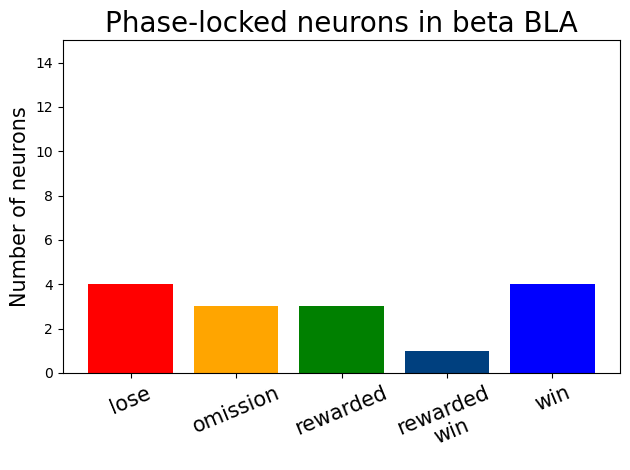

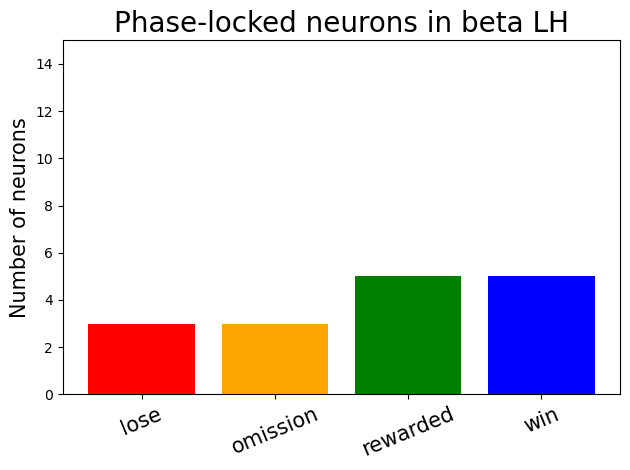

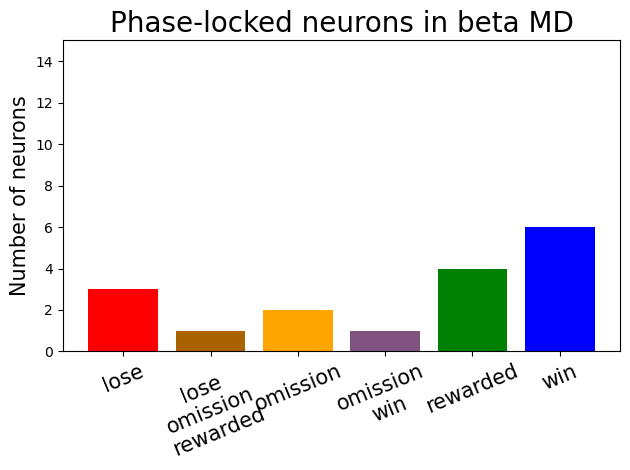

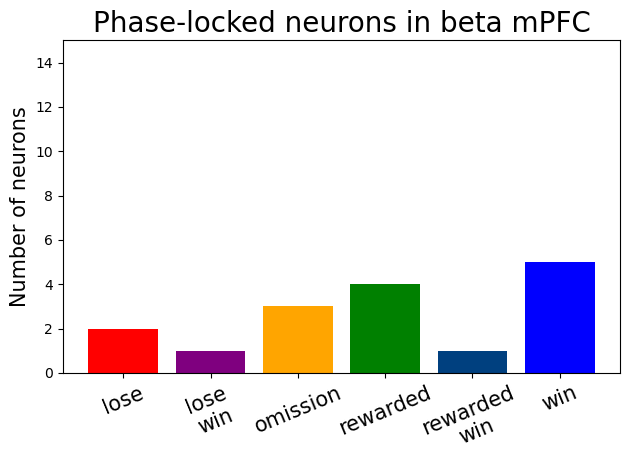

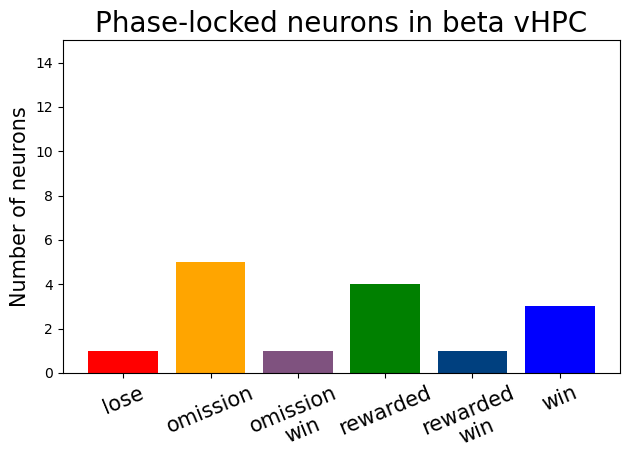

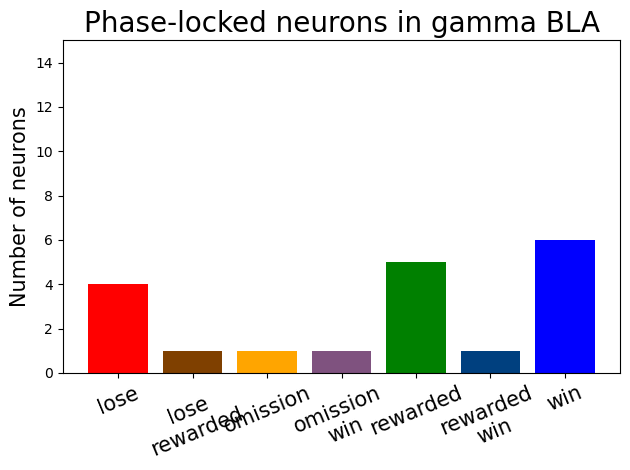

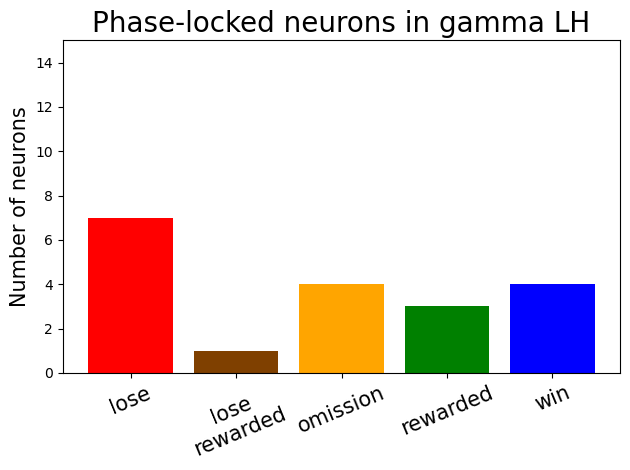

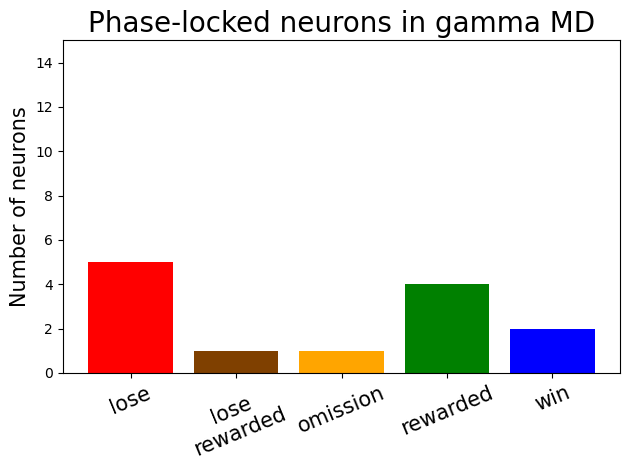

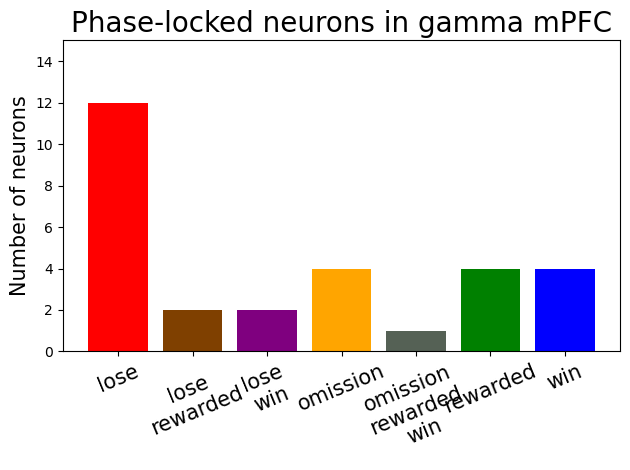

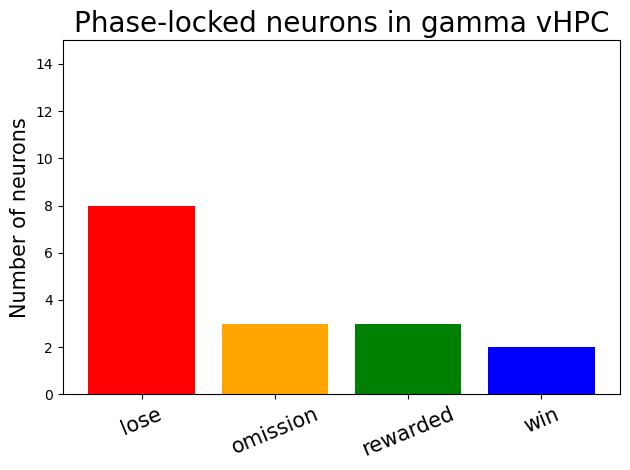

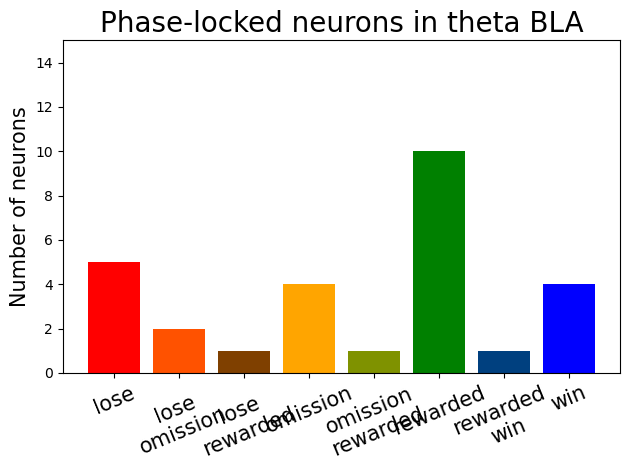

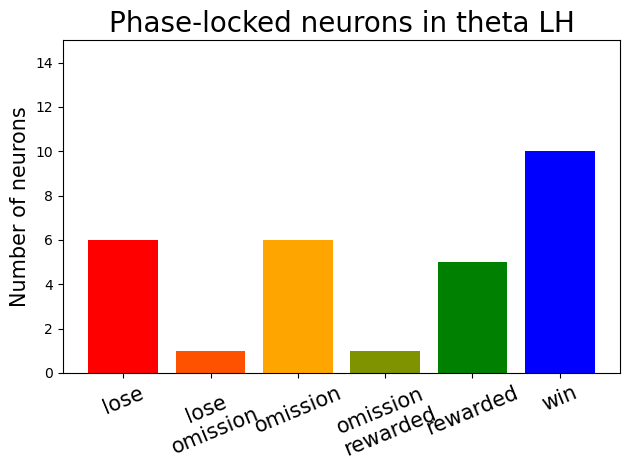

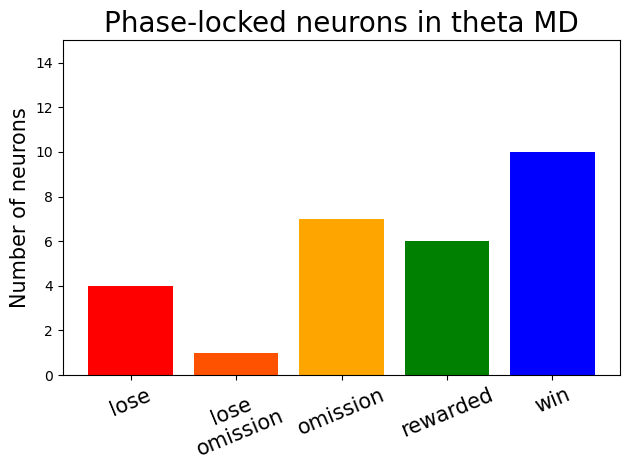

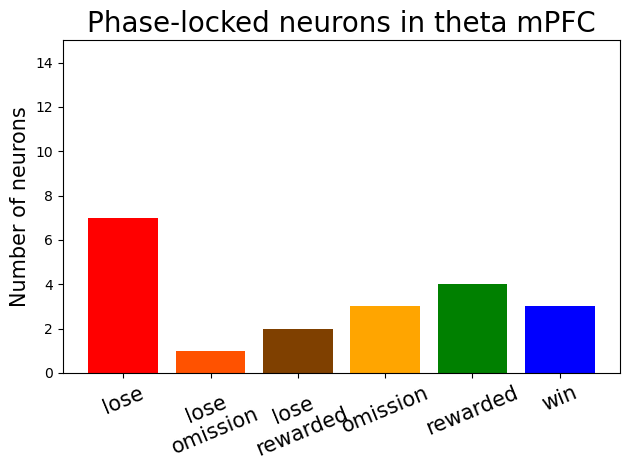

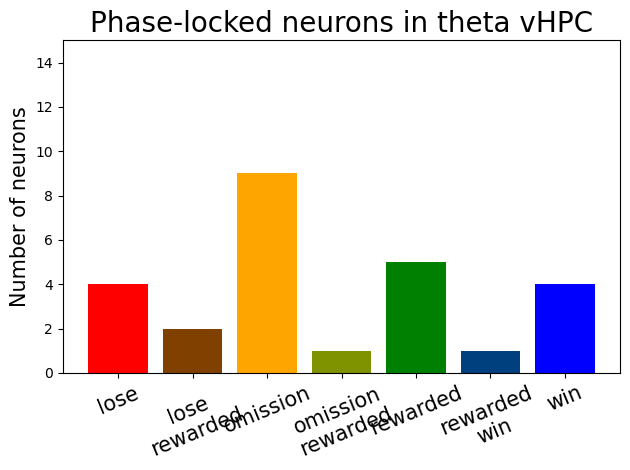

In [368]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]

    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)
    
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=15)
    plt.ylabel("Number of neurons", fontsize=15)
    plt.title("Phase-locked neurons in {} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

In [133]:
all_outcomes = (band_and_region_df["outcome"].unique())

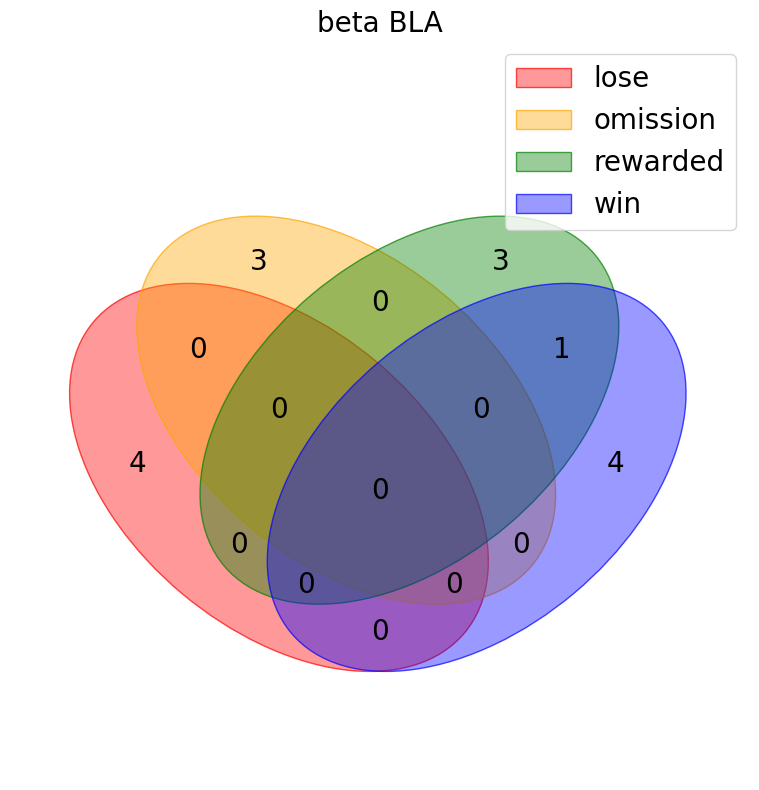

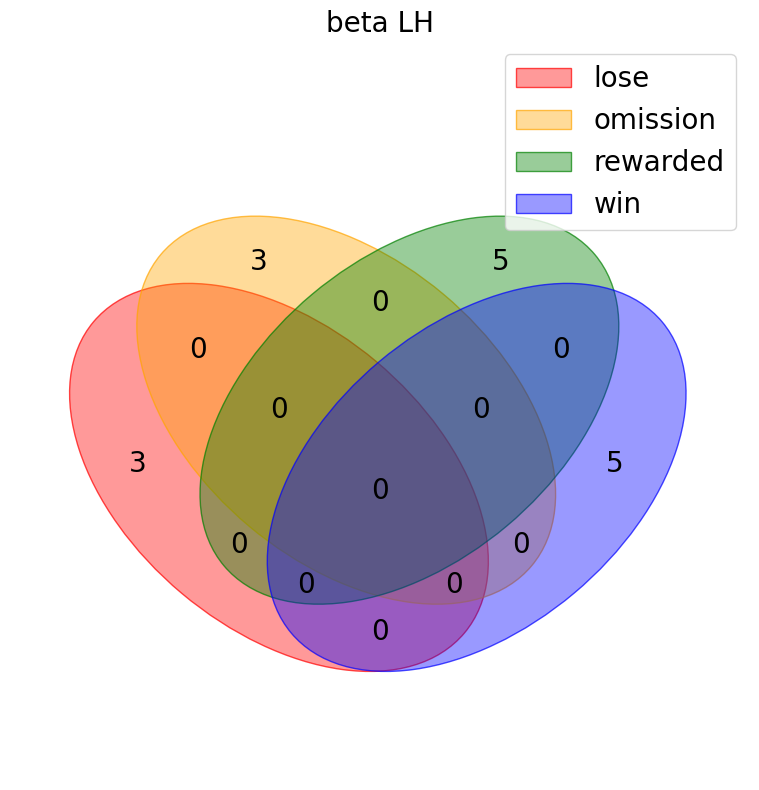

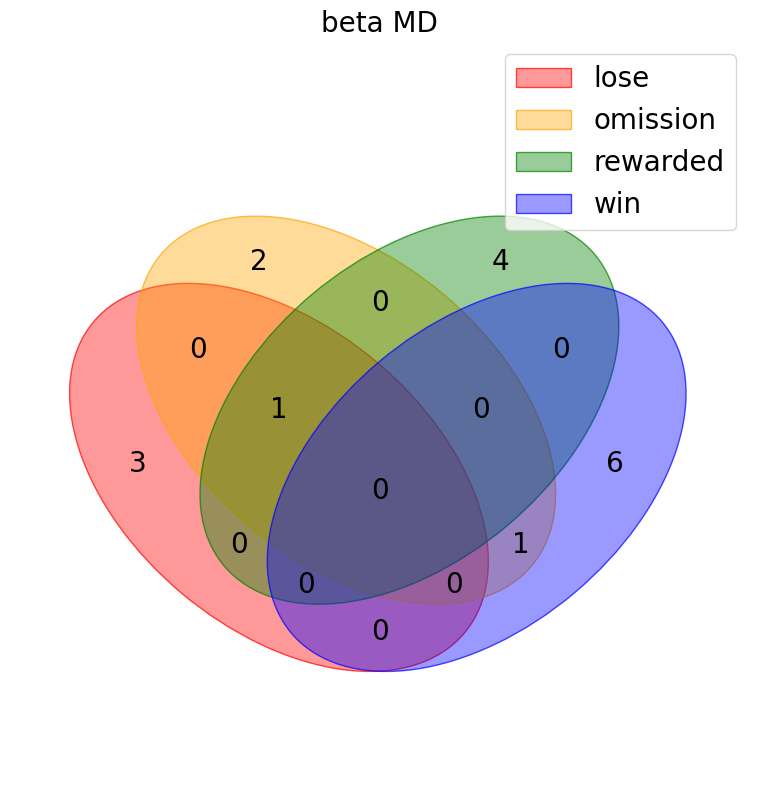

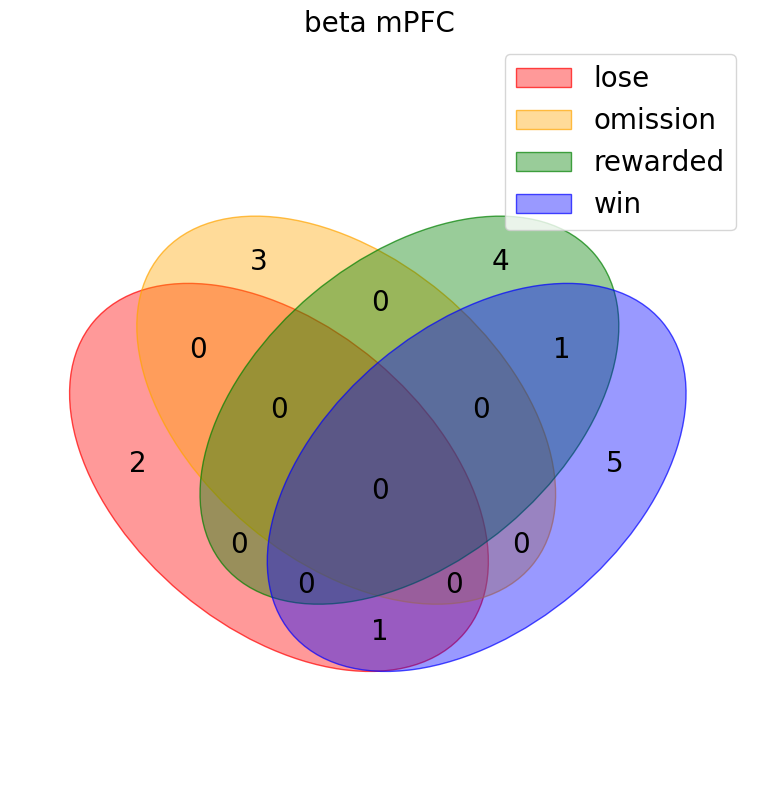

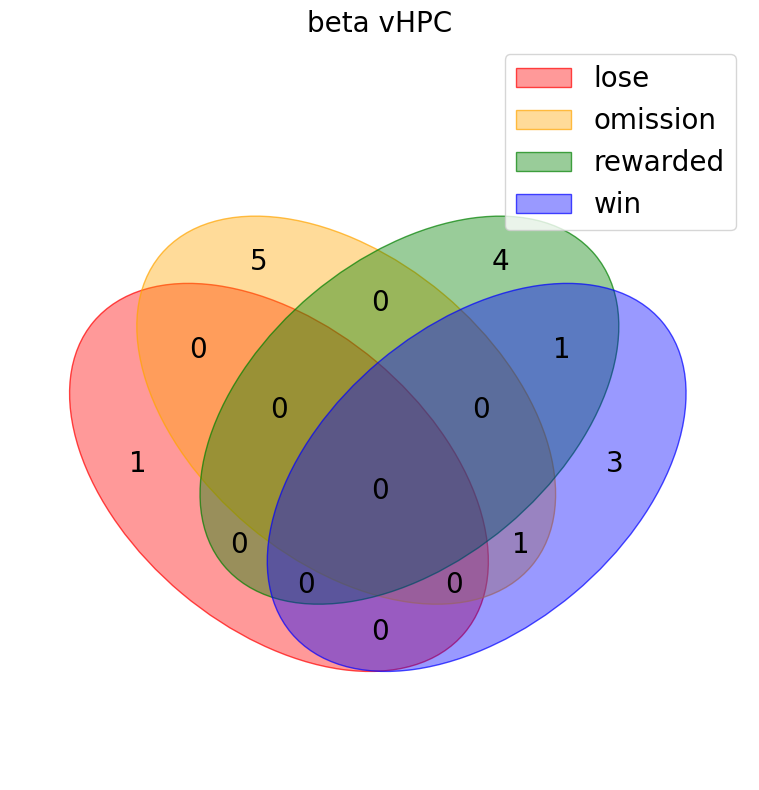

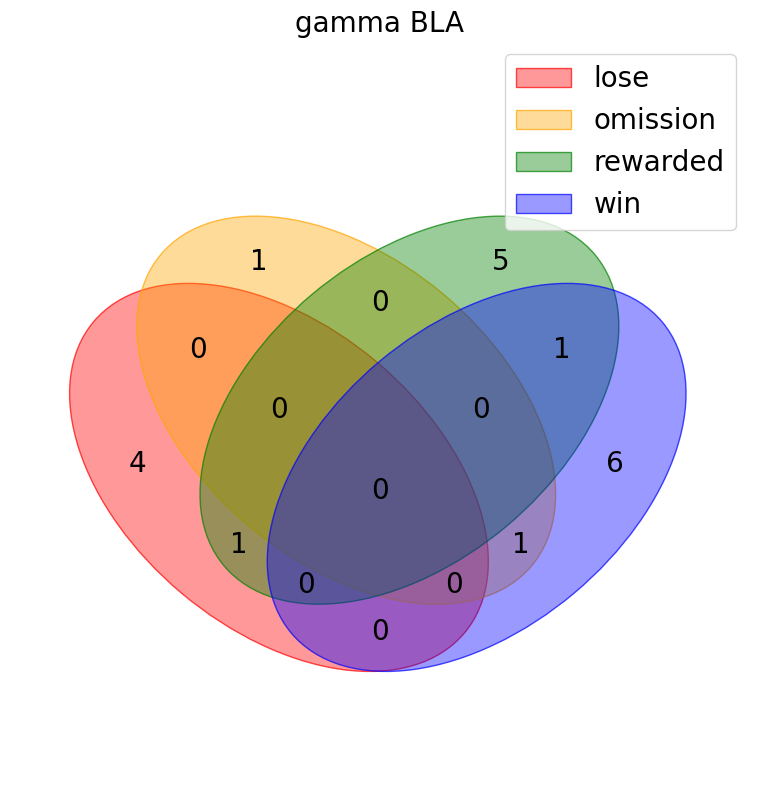

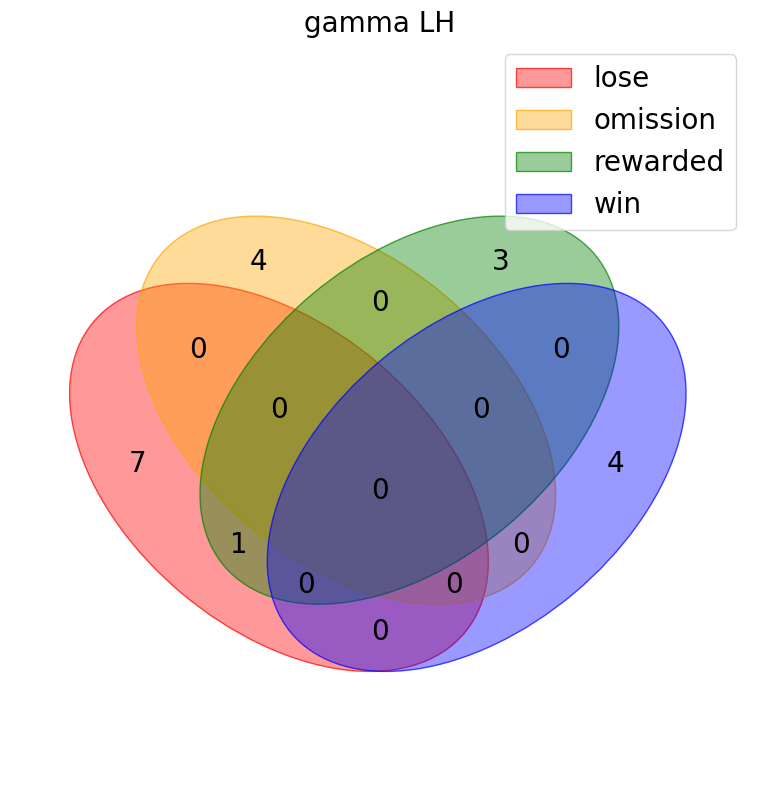

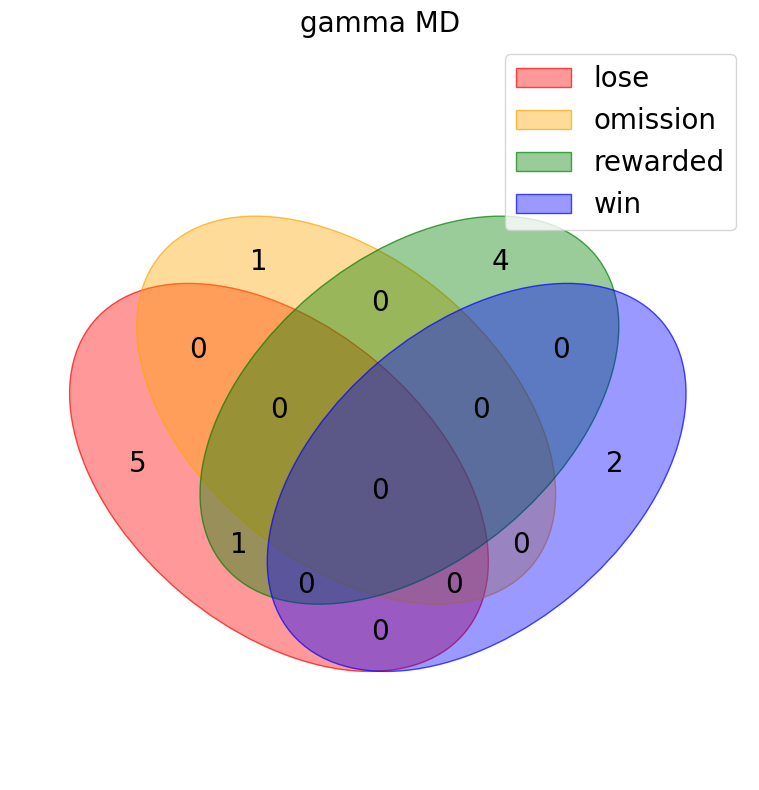

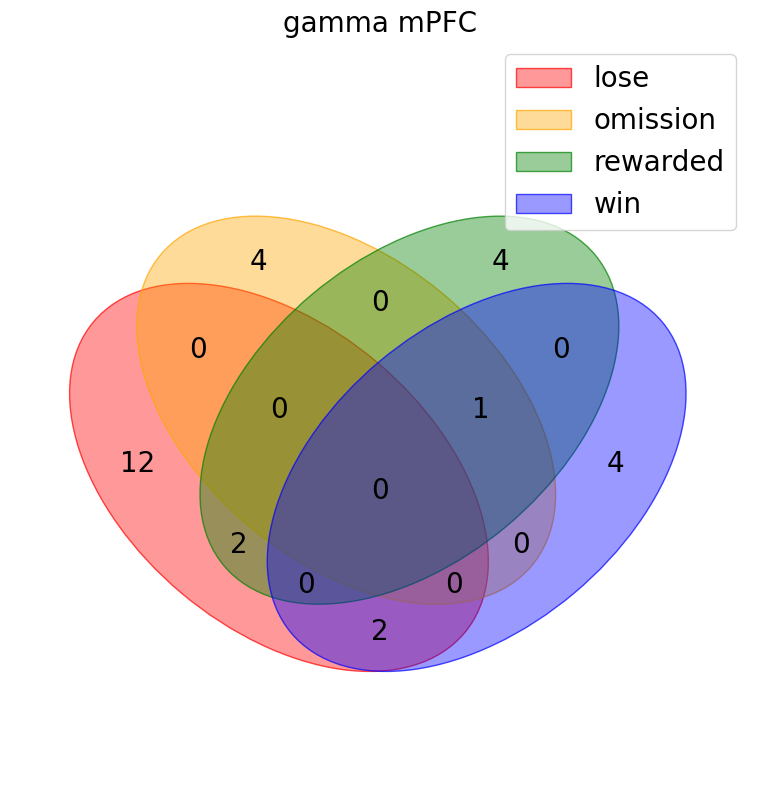

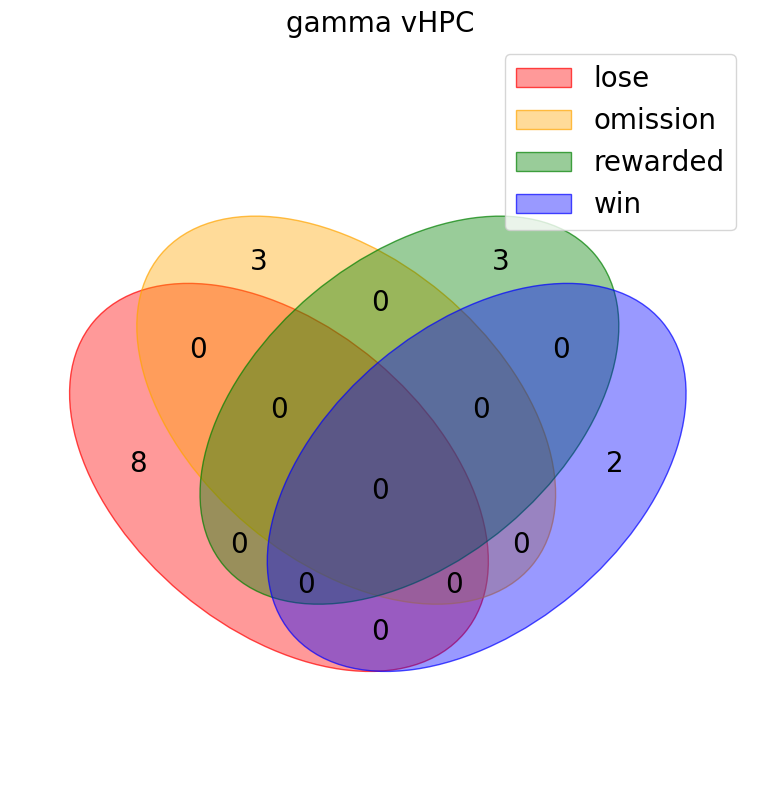

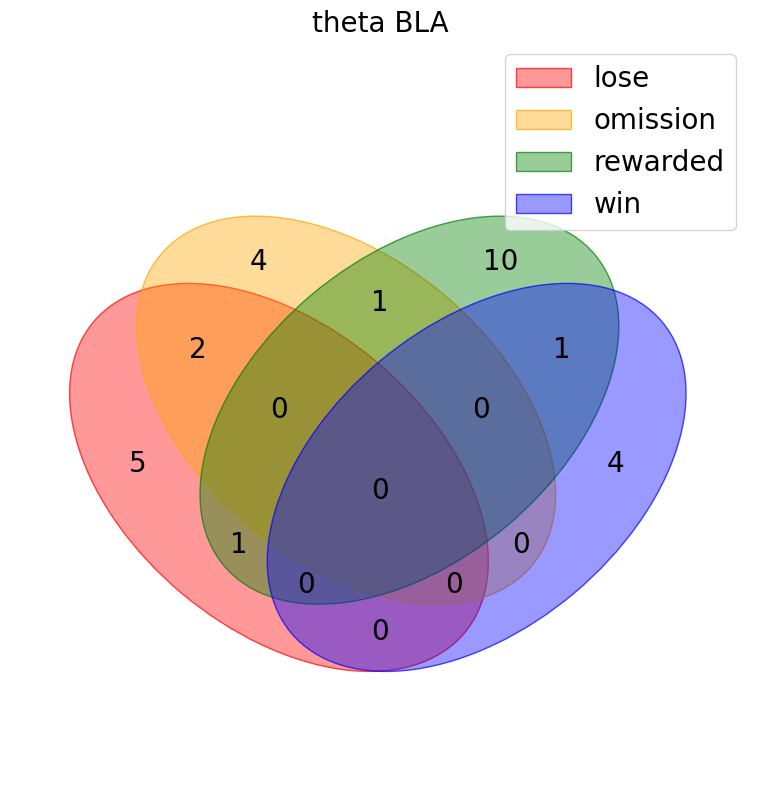

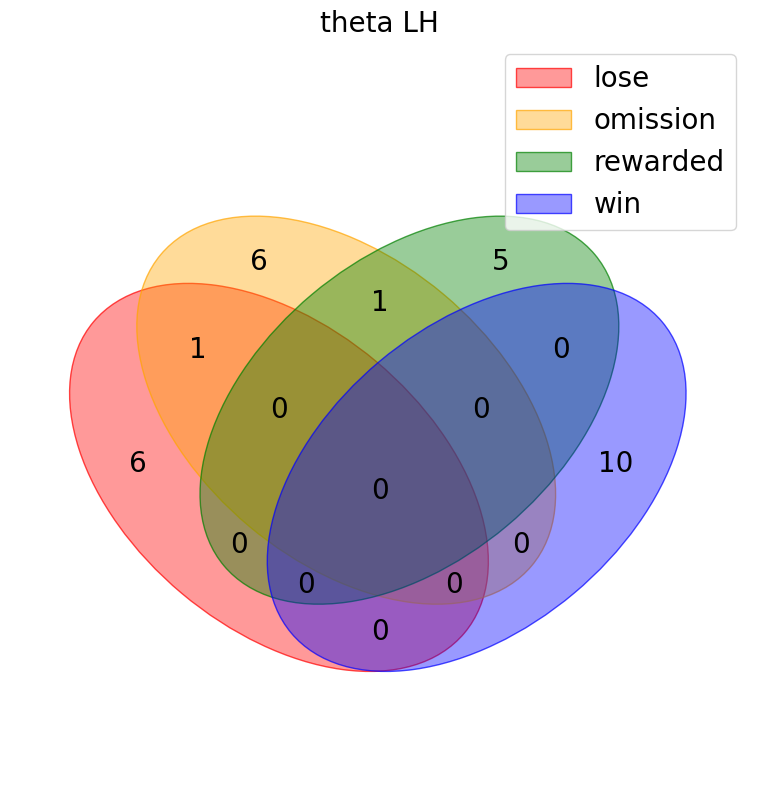

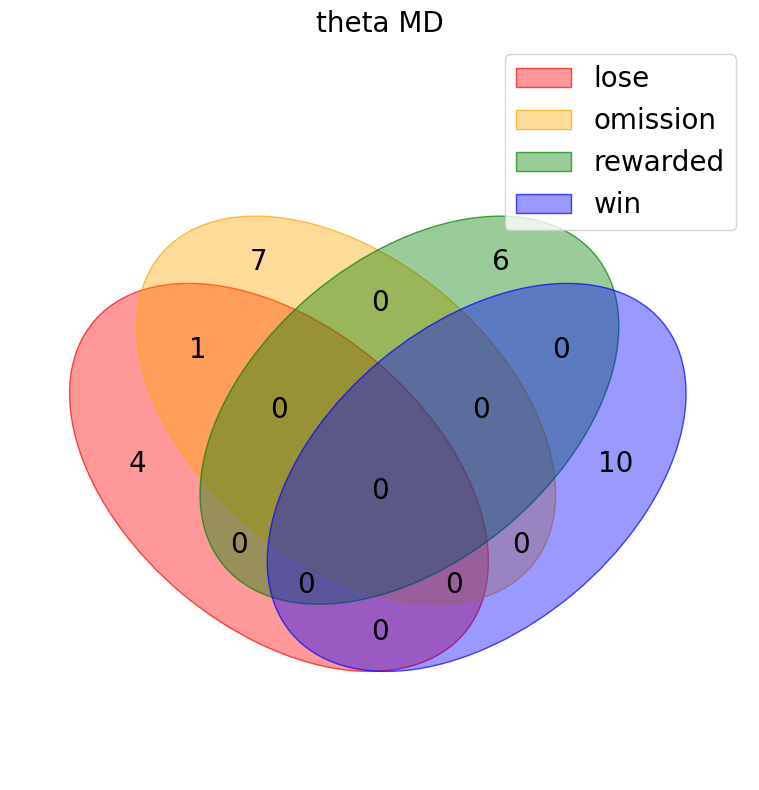

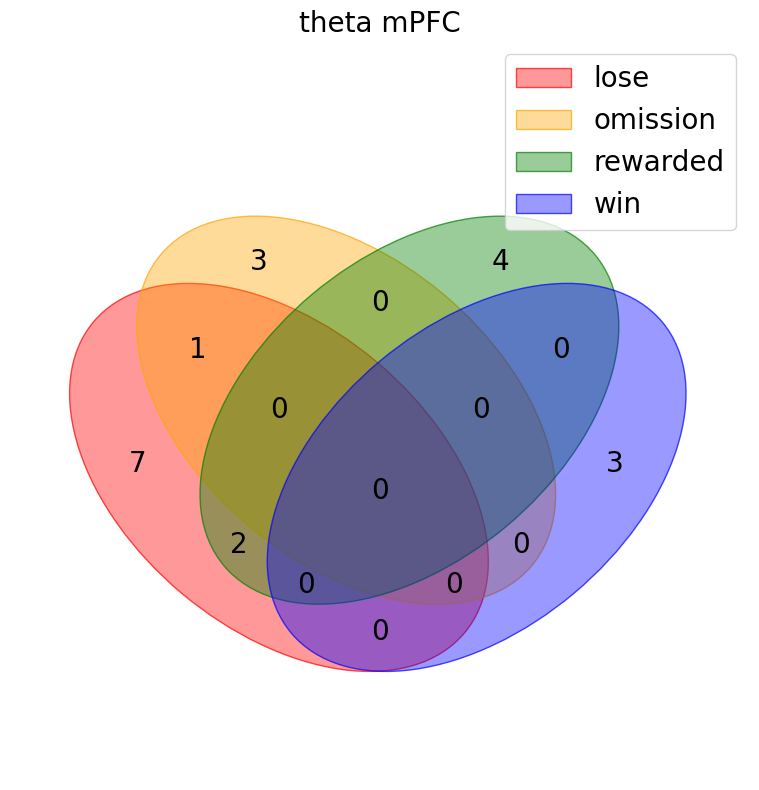

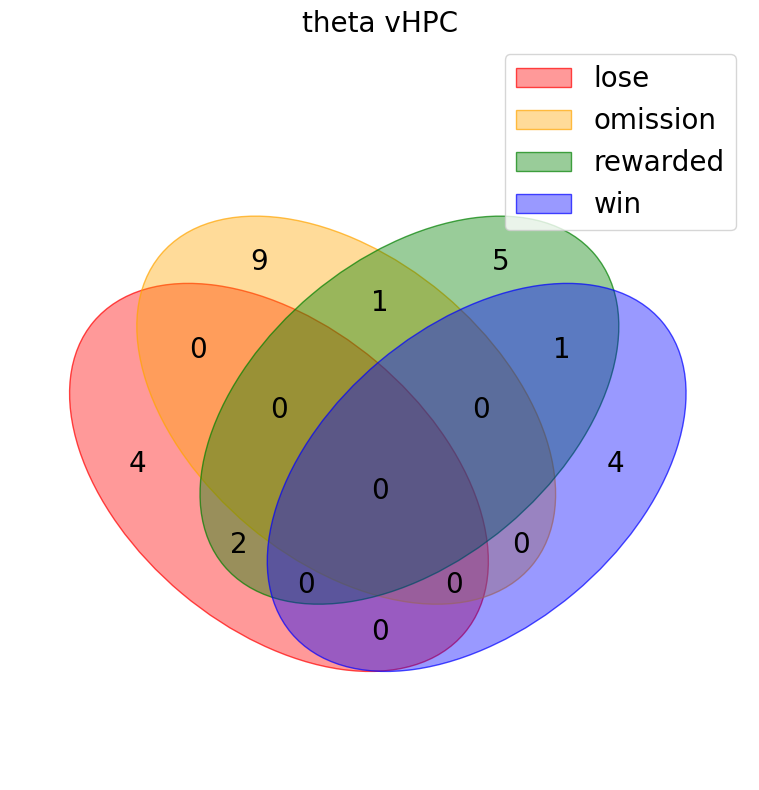

In [393]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # fig, ax = plt.subplots()
    # plt.figure(figsize=(12,12))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]
    
    outcome_to_neurons = {}
    for outcome in sorted(band_and_region_df["outcome"].unique()):
        outcome_to_neurons[outcome] = set(band_and_region_df[band_and_region_df["outcome"] == outcome]["cluster_id_with_file_name"].values)
    # keys, value = zip(*outcome_to_neurons.items())
    # venn3(list(value), keys)

    venn(outcome_to_neurons, cmap=[BASELINE_OUTCOME_TO_COLOR[outcome] for outcome in sorted(band_and_region_df["outcome"].unique())], fontsize=20, figsize=(8,8))
    plt.title("{} {}".format(band, region), fontsize=20)

    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/venn/{}_{}_lfp_spike_coupling_venn.png".format(band, region))
    plt.show()


In [160]:
keys, value = zip(*outcome_to_neurons.items())

In [161]:
keys

('lose', 'omission', 'rewarded', 'win')

In [155]:
outcome_to_neurons.values()

dict_values([{'42_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '48_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '162_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '60_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '34_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '139_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '141_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '9_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '204_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged', '207_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '14_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '78_20230617_115521_standard_comp_to_om

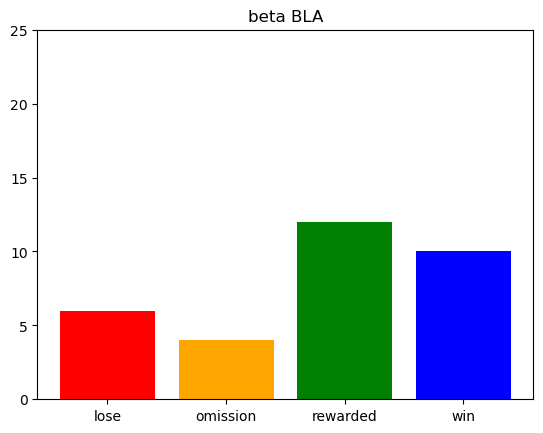

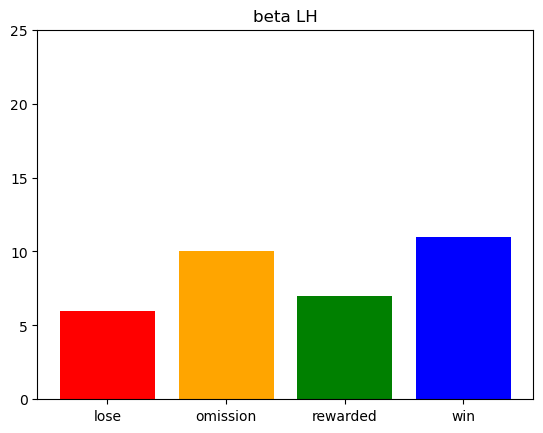

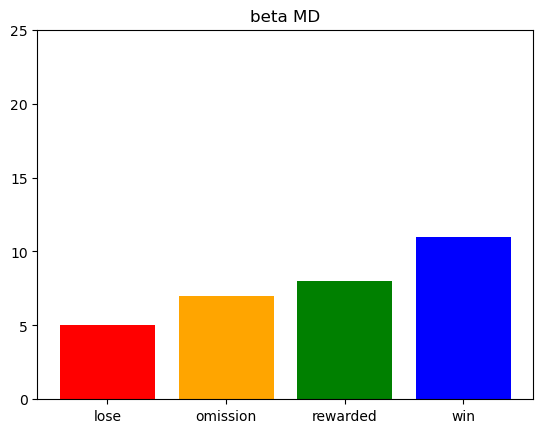

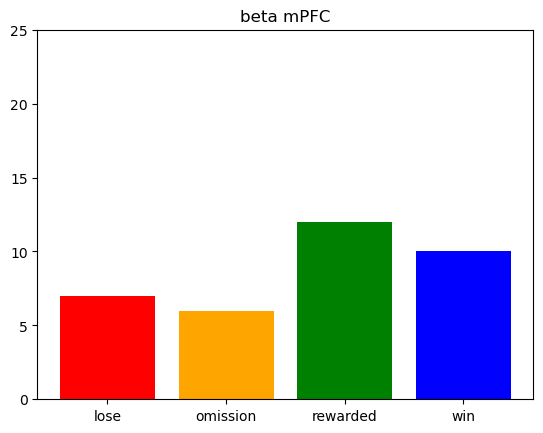

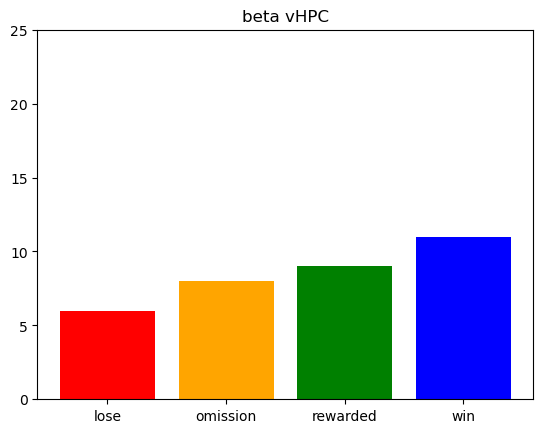

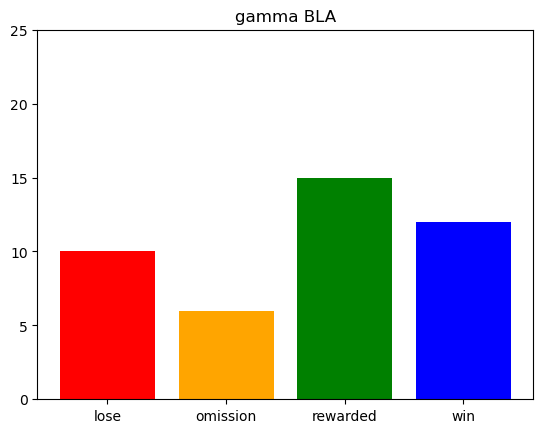

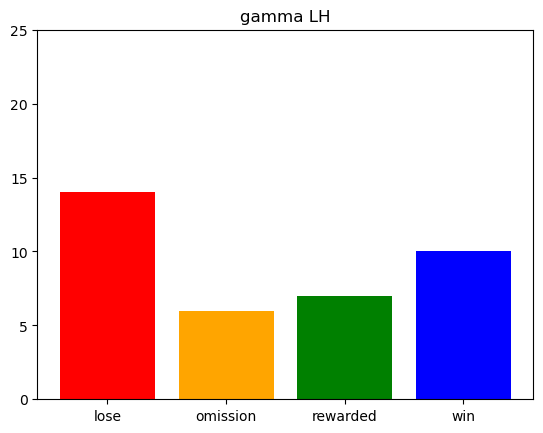

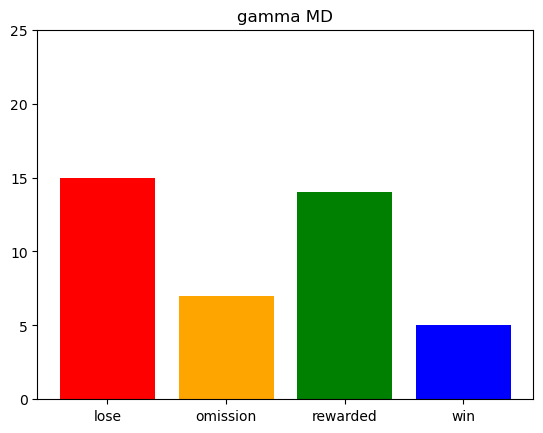

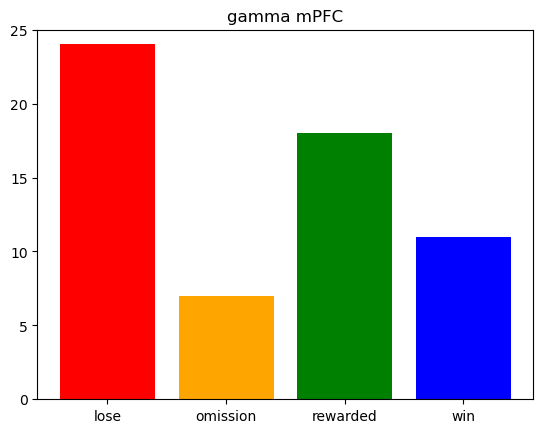

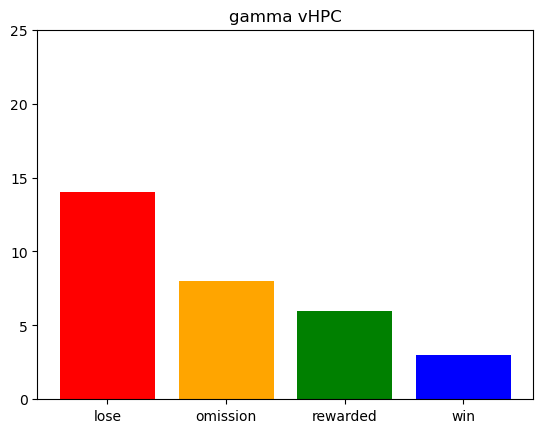

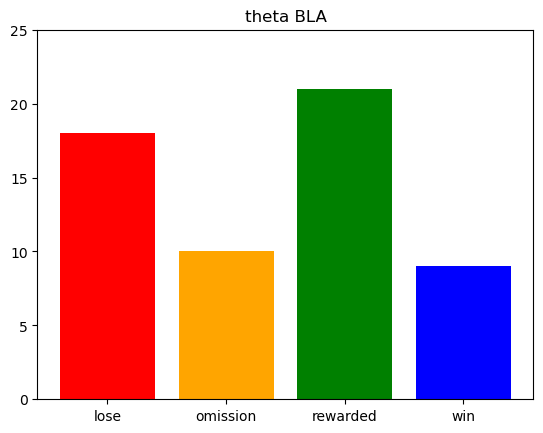

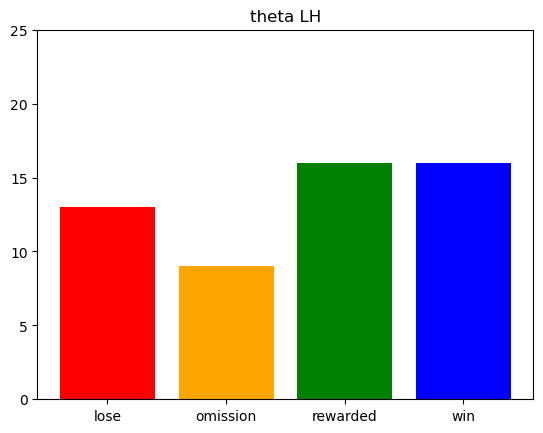

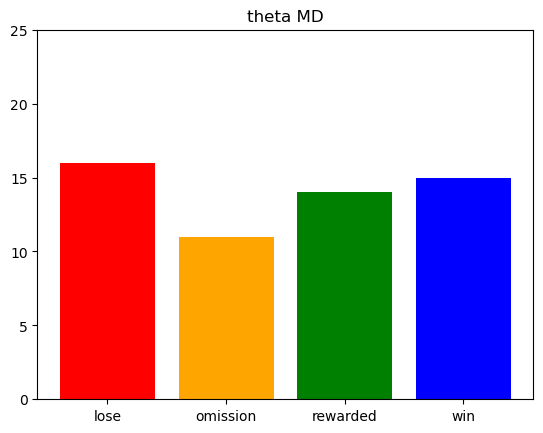

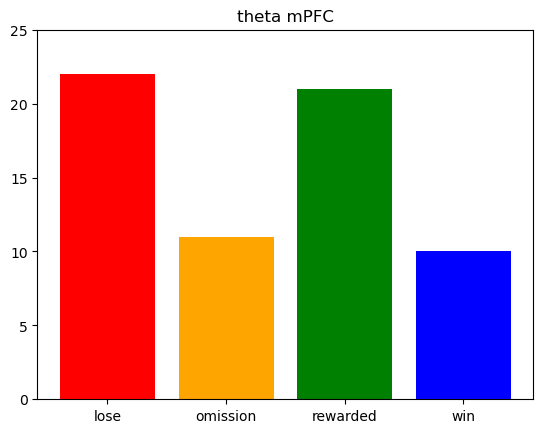

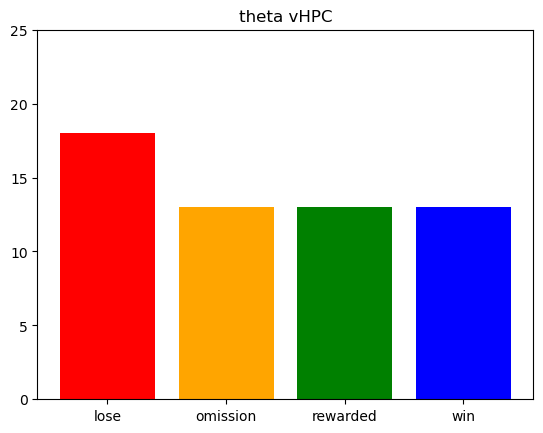

In [108]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band, region))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region) & (spike_lfp_coupling_df["rayleightest"] <= 0.1)]
    
    
    
    plt.bar(x=band_and_region_df.groupby("outcome")["rayleightest"].count().index, height=band_and_region_df.groupby("outcome")["rayleightest"].count(), color=band_and_region_df.groupby("outcome")["rayleightest"].count().index.map(BASELINE_OUTCOME_TO_COLOR))
    plt.ylim(0,25)
    plt.show()
    # region_df.groupby("")

In [ ]:
raise ValueError()

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
raise ValueError()

In [ ]:
from astropy import units as u
data = np.array([130, 90, 0, 145])*u.deg

In [ ]:
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# iterating through each band and each brain region
for radian_col, degree_col in zip(radians_spike_columns, degrees_spike_columns):
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        figure, axis = plt.subplots(2, 2) 
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            radian_spike_phases = outcome_df[radian_col]
            binned_phases = np.digitize(radian_spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(radian_spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(outcome_df[degree_col]) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        # plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
raise ValueError()
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# Iterating through each brain region
for col in spike_columns:
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            spike_phases = outcome_df[col]
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(spike_phases) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        
    

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
all_phase_df.sort_values("rayleightest").head(n=20)


id_and_outcome_to_stats = defaultdict(list)
for col in spike_columns:

    for id in range(len(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique())):
        fig, ax = plt.subplots()
        
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
        
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            
            spike_phases = outcome_df[col]
        
            N_BINS = 18
            PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            print(spike_phase_hist)
            
            #Plot
            ax = plt.subplot(1,1,1, polar=True)
            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            ppc_val = PPC(spike_phases)



            
            rayleightest(data) 
            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleightest(spike_phases)})
            plt.title(neuron_id)
            plt.xlabel(col)
        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
ppc_df = pd.DataFrame(id_and_outcome_to_stats).dropna()

In [ ]:
ppc_df

In [ ]:
    sns.violinplot(x=ppc_df['outcome'], y=ppc_df['ppc'], palette=BASELINE_OUTCOME_TO_COLOR)

In [ ]:
fig, ax = plt.subplots()

# Create a separate violin plot for each group
for i, group in enumerate(ppc_df["outcome"].unique()):
    group_data = ppc_df[ppc_df['outcome'] == group]  # filter the data for this group
    sns.violinplot(x=group_data['outcome'], y=group_data['ppc'])
    # axs[i].set_title(f'Violin plot for {group}')

plt.tight_layout()
plt.show()

In [ ]:
# Create a histogram with Seaborn's 'histplot'
plt.figure(figsize=(10, 6))
sns.histplot(data=ppc_df, x='ppc', hue='outcome', multiple="stack", binwidth=0.01)

# Set labels and title
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Different Groups')

# Show plot
plt.show()

In [ ]:
spike_phases = TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)

# OLD MERGING CODE

In [ ]:
raise ValueError()

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"] = BASIC_LFP_TRACES_DF.apply(lambda x: MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_name"] == x["recording_file"]) & (MERGED_SPIKE_TRIAL_DF["closest_trial"] == x["time_stamp_index"])], axis=1)

In [ ]:
BASIC_LFP_TRACES_DF["has_spike_df"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: not x.empty)

In [ ]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["has_spike_df"]].reset_index(drop=True)

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: {k: sorted(list(v)) for k, v in x.groupby("cluster_id")["lfp_sample_from_trial_onset"]})

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: x.groupby("cluster_id")["lfp_sample_from_trial_onset"].apply(list).reset_index(name='lfp_sample_from_trial_onset'))

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [ ]:
FREQ_BAND = [4, 12]


In [ ]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [ ]:
MERGED_SPIKE_TRIAL_DF.head()

In [ ]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

current_spike_df = BASIC_LFP_TRACES_DF["spike_df"].iloc[0]
current_unit_spikes = current_spike_df[current_spike_df["cluster_id"] == current_spike_df["cluster_id"].unique()[0]]["lfp_sample_from_trial_onset"].values

for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)
for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

In [ ]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

# Plotting phase and LFP

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[5].columns

In [ ]:
BASIC_LFP_TRACES_DF.columns

In [ ]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [ ]:
example_trial = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["recording_file"] == rec_file].iloc[15]

In [ ]:
example_trial.index

In [ ]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [ ]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [ ]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [ ]:
example_spike_df[["spike_clusters", "spike_times"]]

In [ ]:
example_spike_df

In [ ]:
merged_df = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [ ]:
merged_df.columns

In [ ]:
BASIC_LFP_TRACES_DF

In [ ]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


In [ ]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [ ]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [ ]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [ ]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)